## Environment Setup

In [ ]:
%%capture
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install transformers datasets nervaluate torch
    !pip install scikit-multilearn
    !pip install optuna
    # Create project directory in Google Drive
    !mkdir -p "/content/swedish_historical_ner"

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
import json
import ast
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import torch
import torch.nn.functional as F
import shutil
import nbformat
import copy
import random
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from tqdm import tqdm
from collections import defaultdict
from IPython import get_ipython
from IPython.display import display, HTML
from collections import Counter, defaultdict
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, AutoModelForMaskedLM, AutoModelForTokenClassification, EarlyStoppingCallback
from IPython.display import display, Markdown
from datasets import load_dataset, Features, Sequence, Value, load_from_disk, Dataset
from typing import Dict, List, Tuple, Optional
from skmultilearn.model_selection import IterativeStratification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from nervaluate import Evaluator, summary_report_overall_indices
from google.colab import drive, userdata, _message

# Set up project directories
if IN_COLAB:
    BASE_DIR = "/content/swedish_historical_ner"
else:
    BASE_DIR = "."

DATA_DIR = os.path.join(BASE_DIR, "data")
MODELS_DIR = os.path.join(BASE_DIR, "models")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

# Create directories if they don't exist
for directory in [DATA_DIR, MODELS_DIR, RESULTS_DIR]:
    os.makedirs(directory, exist_ok=True)

# Set random seeds for reproducibility
np.random.seed(69)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load the datasets from drive:
if IN_COLAB:
    drive.mount('/content/drive')
    full_df = pd.read_csv("/content/drive/MyDrive/swedish_ner_data/train.csv")
    eval_df = pd.read_csv("/content/drive/MyDrive/swedish_ner_data/eval.csv")

# Display basic information
print(f"Training set shape: {full_df.shape}")
print(f"Evaluation set shape: {eval_df.shape}")

# Display sample from training data
full_df.head(3)

Mounted at /content/drive
Training set shape: (677, 3)
Evaluation set shape: (170, 2)


,text,id,entities
0,SS : 158 \n In stämnde målet emellan Bonden An...,72535,"[{'end': 68, 'label': 'PER', 'start': 36}\n {'..."
1,Grefwe von Schwerin F. B. anſåg de ifrågawaran...,23682,"[{'end': 25, 'label': 'PER', 'start': 0}\n {'e..."
2,Torg= och Hamnpriſer i Stockholm d. 7 Maj . Ha...,72477,"[{'end': 32, 'label': 'LOC', 'start': 23}\n {'..."


In [ ]:
def parse_entities(entities_str):
    if pd.isna(entities_str) or entities_str.strip() == '[]':
        return []

    try:
        # Fix the format by adding missing commas between dictionaries
        fixed_str = entities_str.replace('} {', '}, {')

        # Now try to evaluate the string as Python code
        return ast.literal_eval(fixed_str)
    except Exception as e:
        # If that fails, try a regex-based approach
        try:
            entities = []
            # Use regex to match each dictionary pattern
            import re
            pattern = r"{\'end\': (\d+), \'label\': \'([^\']+)\', \'start\': (\d+)}"
            matches = re.finditer(pattern, entities_str)

            for match in matches:
                label = match.group(2)
                start = int(match.group(3))
                end = int(match.group(1))
                entities.append({
                    'label': label,
                    'start': start,
                    'end': end
                })

            if entities:
                return entities
            else:
                print(f"No entities found with regex in: {entities_str}")
                return []
        except Exception as regex_error:
            print(f"Error parsing: {entities_str} - Original error: {str(e)}, Regex error: {str(regex_error)}")
            return []

full_df['entities'] = full_df['entities'].apply(parse_entities)

Training-side processing steps:
1. Tokenize the text with return_offsets_mapping=True to get input_ids, attention_mask, and offset_mapping.

2. Map entity spans to tokens and words. Assign BIO labels.

3. Map to subwords: label the first subword of each word and use -100 for others.

4. Apply sliding windows to the labelled sequence. This is crucial for getting all of our text in each row to be processed.

In [ ]:
xlm_large = "FacebookAI/xlm-roberta-large"

tokenizer = AutoTokenizer.from_pretrained(xlm_large)

print(full_df["text"][0])

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

SS : 158 
 In stämnde målet emellan Bonden Anders Henricsson Forsnås från Hopp sala by och dess omyndiga Barns Formyndare Bönderne Pehr Ja cobsson Åko ach Eric Erisson Forrkålla ifrån Påras by swarande fore fogs nu och instatte sig harvid Parterne Ömsesedes sjelfve då Kä randen fordrade Arslön med såsom måg å Forsnäs hemman forrättad arbete utom att han derföre någan betalning rosållit Men Swaranden förmente käran den Aldeles icke wara berättigad till nagon arslön hälft han nyttgadt en tredje del af hem manet utan att dertill hafwa warit berättigad - hwarpå käranden forklarade sig nöjd at afsta med all widare talan i detta mål dermed Svaranderne åtnujdes och hwarvid Rätten lät det bero .


In [ ]:
token = tokenizer(full_df["text"][0], return_offsets_mapping=True)
print(token["input_ids"])
print(token["offset_mapping"])
# Return_offsets_mappings = True is very useful
# It returns the start and end positions of each token in the tokenized sentence.
# The initial (0,0) is for the special token at the beginning of the tokenized sequences, there is also one at the end

[0, 29581, 152, 78373, 360, 6, 5468, 39, 1067, 106657, 47545, 1414, 49078, 33, 35583, 192098, 4503, 1326, 7, 145098, 7, 1868, 99111, 4559, 390, 174, 224, 7, 36, 39171, 1758, 35923, 7, 1326, 39171, 1046, 63068, 7944, 86, 1460, 4097, 823, 552, 275, 4503, 8839, 265, 8225, 51838, 72798, 4503, 1326, 42, 99788, 143, 82767, 3868, 2701, 390, 68062, 61020, 100, 13, 7620, 7, 315, 174, 23, 17346, 67, 1144, 182, 5518, 16995, 3196, 5973, 39, 5908, 87369, 6, 8824, 17463, 272, 5530, 23734, 27388, 33, 100, 3041, 112, 1172, 7, 90488, 128, 71481, 3434, 177, 426, 1326, 7, 91761, 30671, 19, 100, 29435, 712, 42245, 486, 306, 243, 777, 122, 5433, 13, 3648, 1972, 124083, 2062, 22942, 48139, 1111, 159, 123739, 555, 394, 1183, 38052, 66, 168, 112480, 1577, 106619, 1631, 11, 186, 29435, 1758, 71, 570, 24, 6126, 187, 7, 90488, 118814, 2480, 777, 10765, 15575, 18, 22, 37304, 146, 261, 2360, 332, 126, 6591, 243, 122, 30394, 74574, 634, 1631, 217, 186, 29435, 1758, 71, 20, 1096, 4205, 19330, 38052, 66, 555, 100, 12

In [ ]:
print(tokenizer.cls_token_id)

0


In [ ]:
text = tokenizer.decode(token["input_ids"], skip_special_tokens=False)
print(text)
# This turns the input ids (tokenized words) back into text

<s> SS : 158 In stämnde målet emellan Bonden Anders Henricsson Forsnås från Hopp sala by och dess omyndiga Barns Formyndare Bönderne Pehr Ja cobsson Åko ach Eric Erisson Forrkålla ifrån Påras by swarande fore fogs nu och instatte sig harvid Parterne Ömsesedes sjelfve då Kä randen fordrade Arslön med såsom måg å Forsnäs hemman forrättad arbete utom att han derföre någan betalning rosållit Men Swaranden förmente käran den Aldeles icke wara berättigad till nagon arslön hälft han nyttgadt en tredje del af hem manet utan att dertill hafwa warit berättigad - hwarpå käranden forklarade sig nöjd at afsta med all widare talan i detta mål dermed Svaranderne åtnujdes och hwarvid Rätten lät det bero .</s>


In [ ]:
# Get a list of the unique entities in train_df["entities"], called label_list:
label_list = []
for entities in full_df["entities"]:
    for entity in entities:
        label_list.append(entity["label"])
label_list = list(set(label_list))
print(label_list)

['MSR-OTH', 'WRK', 'TME-DATE', 'MSR-DIST', 'OCC', 'MSR-AREA', 'MSR-WEI', 'LOC', 'ORG-OTH', 'ORG-COMP', 'TME-INTRV', 'MSR-MON', 'PER', 'EVN', 'TME-TIME', 'ORG-INST', 'MSR-LEN', 'SYMP', 'MSR-VOL']


## Stratified Train-Test Split

It is crucial to stratify the train-test split. This means that we will ensure that all entity types are present in both the training and test data, which would not necessarily be the case if the split was done randomly.

In [ ]:
def create_stratified_split(df, test_size=0.2, random_state=69):
    """
    Create a stratified train-test split for NER data using IterativeStratification,
    working directly with the raw dataframe before any preprocessing.

    Args:
        df: DataFrame with 'text' and 'entities' columns
        test_size: Proportion of data for testing (default: 0.2)
        random_state: Seed for reproducibility

    Returns:
        train_df, test_df: Split dataframes
    """
    # Compute entity counts per document
    doc_entity_counts = []
    for idx, row in df.iterrows():
        entity_counter = Counter()
        for entity in row['entities']:
            entity_counter[entity['label']] += 1
        doc_entity_counts.append(entity_counter)

    # Prepare multi-label matrix for stratification
    all_entity_types = sorted(set(label for counter in doc_entity_counts for label in counter))
    X = np.zeros((len(df), len(all_entity_types)), dtype=int)  # Rows: docs, Columns: entity types

    for i, counter in enumerate(doc_entity_counts):
        for j, entity_type in enumerate(all_entity_types):
            X[i, j] = counter.get(entity_type, 0)  # Entity count per doc

    # Perform iterative stratification to balance entity counts
    stratifier = IterativeStratification(n_splits=2, order=1, sample_distribution_per_fold=[test_size, 1 - test_size])
    train_indices, test_indices = next(stratifier.split(X, X))  # Split doc indices based on counts

    # Create train and test dataframes
    train_df = df.iloc[train_indices].reset_index(drop=True)
    test_df = df.iloc[test_indices].reset_index(drop=True)

    # Compute entity distribution
    train_counts = Counter()
    test_counts = Counter()
    total_counts = Counter()

    for counter in [doc_entity_counts[i] for i in train_indices]:
        for entity_type, count in counter.items():
            train_counts[entity_type] += count
            total_counts[entity_type] += count

    for counter in [doc_entity_counts[i] for i in test_indices]:
        for entity_type, count in counter.items():
            test_counts[entity_type] += count
            total_counts[entity_type] += count

    # Total entities for percentage calculations
    total_entities = sum(total_counts.values())
    train_total = sum(train_counts.values())
    test_total = sum(test_counts.values())

    # Print split statistics
    print(f"\nStratified Split Statistics:")
    print(f"  Total documents: {len(df)}")
    print(f"  Train docs: {len(train_indices)} ({len(train_indices)/len(df):.1%})")
    print(f"  Test docs: {len(test_indices)} ({len(test_indices)/len(df):.1%})")

    # Print detailed entity distribution
    print("\nEntity Type Distribution:")
    print(f"{'Entity':<12} {'Total':<6} {'Overall %':<9} {'Train':<6} {'Train %':<9} {'T % of Tr':<9} {'Test':<6} {'Test %':<9} {'T % of Te':<9}")
    print("-" * 70)
    for entity_type in sorted(total_counts.keys()):
        total = total_counts[entity_type]
        train = train_counts[entity_type]
        test = test_counts[entity_type]
        overall_pct = (total / total_entities) * 100 if total_entities > 0 else 0
        train_split_pct = (train / total) * 100 if total > 0 else 0
        train_set_pct = (train / train_total) * 100 if train_total > 0 else 0
        test_split_pct = (test / total) * 100 if total > 0 else 0
        test_set_pct = (test / test_total) * 100 if test_total > 0 else 0
        print(f"{entity_type:<12} {total:<6} {overall_pct:<8.2f}% {train:<6} {train_split_pct:<8.1f}% {train_set_pct:<8.2f}% {test:<6} {test_split_pct:<8.1f}% {test_set_pct:<8.2f}%")

    return train_df, test_df, train_indices, test_indices

# Usage
train_df, test_df, train_indices, test_indices = create_stratified_split(full_df)


Stratified Split Statistics:
  Total documents: 677
  Train docs: 538 (79.5%)
  Test docs: 139 (20.5%)

Entity Type Distribution:
Entity       Total  Overall % Train  Train %   T % of Tr Test   Test %    T % of Te
----------------------------------------------------------------------
EVN          282    1.18    % 235    83.3    % 1.19    % 47     16.7    % 1.11    %
LOC          4314   18.02   % 3464   80.3    % 17.59   % 850    19.7    % 20.00   %
MSR-AREA     25     0.10    % 22     88.0    % 0.11    % 3      12.0    % 0.07    %
MSR-DIST     29     0.12    % 24     82.8    % 0.12    % 5      17.2    % 0.12    %
MSR-LEN      64     0.27    % 42     65.6    % 0.21    % 22     34.4    % 0.52    %
MSR-MON      1457   6.09    % 1216   83.5    % 6.18    % 241    16.5    % 5.67    %
MSR-OTH      48     0.20    % 38     79.2    % 0.19    % 10     20.8    % 0.24    %
MSR-VOL      169    0.71    % 141    83.4    % 0.72    % 28     16.6    % 0.66    %
MSR-WEI      92     0.38    % 65     70.7 

## Data Preprocessing & Tokenization

1. Tokenize the text with return_offsets_mapping=True to get input_ids, attention_mask, and offset_mapping.

Token indices sequence length is longer than the specified maximum sequence length for this model (634 > 512). Running this sequence through the model will result in indexing errors


Average token count: 1174.70
Min token count: 6
Max token count: 40718

Documents fully covered by 8192 token context window: 531 out of 538
Coverage percentage: 98.70%

Token count distribution:
10th percentile: 121.7
25th percentile: 234.2
50th percentile: 468.0
75th percentile: 1009.0
90th percentile: 2901.9
95th percentile: 4995.2
99th percentile: 8409.4


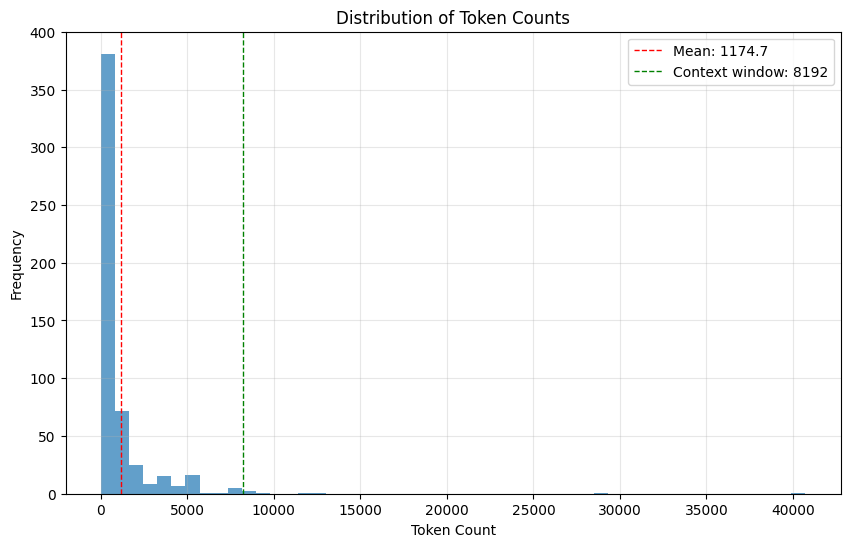


Example inspection:
Text: Grefwe von Schwerin F. B. anſåg de ifrågawarande ſkatterne , bland alla dem ſom Swenſka Folket ärft af ſina fäder , wara närmaſt i ordningen att utgå . De innebure i ſjelfwa ſin hiſtoria ett frö till ſin upplösning . Mantalspenningarne hade i mån af myntförändringar , nedgått från 8 kappar ſäd till 12 ß . De wore ſå ojemnt fördelade , att i wißa orter betalade Torparen i det ena Häradet 12 ß . då i det andra Hemmansegare erlade endaſt 8 eller 4 ß . Grefwen ſkulle ockſå icke tweka att inſtämma med dem , ſom önſkade deßa ſkatters förwandlande nu aenaſt — om han nemligen ſkulle tro , att wårt myntſlag ſkulle ännu i 20 år framwiſa en lika brokig matſedel ſom Jordeboks= och Mantalsräntan . Men en lyckligare tid hade nu i detta afſeende ljusnat för Swerige . Man kunde hoppas , att 150 års förwillelſer ſkulle upphöra . När deßa förhoppningar framſtällde ſig , ſyntes det wara bäſt att låta Folket i förſta rummet wänja ſig wid den nya myntråkningen , och icke tillika 

In [ ]:
def tokenize_full_text(text):
    return tokenizer(
        text,
        return_offsets_mapping=True,  # Get character-to-token mappings
        truncation=False,             # Keep full text
        padding=False                # No padding yet
    )

# Apply tokenization to all rows
encoded_texts = train_df['text'].apply(tokenize_full_text).tolist()

# Extract components as lists
input_ids_list = [enc['input_ids'] for enc in encoded_texts]
attention_mask_list = [enc['attention_mask'] for enc in encoded_texts]
offset_mapping_list = [enc['offset_mapping'] for enc in encoded_texts]

# Store in DataFrame or directly create a Dataset
train_df['input_ids'] = input_ids_list
train_df['attention_mask'] = attention_mask_list
train_df['offset_mapping'] = offset_mapping_list

# Calculate token counts
token_counts = [len(ids) for ids in input_ids_list]
train_df['token_count'] = token_counts

# Calculate and print statistics about token counts
avg_tokens = sum(token_counts) / len(token_counts)
print(f"Average token count: {avg_tokens:.2f}")
print(f"Min token count: {min(token_counts)}")
print(f"Max token count: {max(token_counts)}")

# Calculate percentage covered by 8,192 context window
context_window_size = 8192
docs_covered = sum(1 for count in token_counts if count <= context_window_size)
coverage_percentage = (docs_covered / len(token_counts)) * 100
print(f"\nDocuments fully covered by {context_window_size} token context window: {docs_covered} out of {len(token_counts)}")
print(f"Coverage percentage: {coverage_percentage:.2f}%")

# Calculate percentiles for distribution analysis
percentiles = [10, 25, 50, 75, 90, 95, 99]
percentile_values = np.percentile(token_counts, percentiles)
print("\nToken count distribution:")
for p, v in zip(percentiles, percentile_values):
    print(f"{p}th percentile: {v:.1f}")

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=50, alpha=0.7)
plt.axvline(avg_tokens, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {avg_tokens:.1f}')
plt.axvline(context_window_size, color='green', linestyle='dashed', linewidth=1,
            label=f'Context window: {context_window_size}')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Counts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Convert to Hugging Face Dataset (optional now, can do after windowing)
dataset = Dataset.from_pandas(train_df)

# Inspect an example
print("\nExample inspection:")
print("Text:", train_df['text'].iloc[0])
print("Input IDs length:", len(train_df['input_ids'][0]))
print("Attention Mask:", train_df['attention_mask'][0])
print("Offset Mapping length:", len(train_df['offset_mapping'][0]))
print(dataset[0])

2. Map entity spans to tokens and words.

In [ ]:
def map_entity_spans_to_tokens_and_words(row):
    """
    Maps entity spans to tokens and assigns BIO labels at the word level.

    Args:
        row: A dictionary or DataFrame row with 'text', 'entities', 'input_ids', 'offset_mapping'

    Returns:
        dict: {'token_labels': BIO labels for tokens, 'word_ids': token-to-word mapping}
    """
    text = row['text']
    entities = row['entities']
    input_ids = row['input_ids']
    offset_mapping = row['offset_mapping']
    # Return the word indices. These are telling us which word each token originally belonged to.
    word_ids = []
    word_ids = tokenizer(text, return_offsets_mapping=True).word_ids()
    token_labels = ['O'] * len(input_ids) # Initialize the labels for all tokens as O, for the lols (jk)

    # For each entity, find which tokens overlap with it (core logic)
    for entity in entities:
        input_start_char = entity['start']
        input_end_char = entity['end']
        label = entity['label']

        # Find all tokens that overlap with the entity span (!) This is a crucial step
        # Save the index in the offset mapping in a list if:
        # - token begins before an entity ends
        # - token ends after an entity begins
        entity_tokens = [
            i for i, (entity_start_char, entity_end_char) in enumerate(offset_mapping)
            if entity_start_char < input_end_char and entity_end_char > input_start_char and entity_start_char != entity_end_char  # Exclude special tokens
        ]

        if entity_tokens:
            # Assign B- to the first token and I- to subsequent tokens, as per our processing method
            token_labels[entity_tokens[0]] = f'B-{label}'
            for i in entity_tokens[1:]:
                token_labels[i] = f'I-{label}'

    return {'token_labels': token_labels, 'word_ids': word_ids}

# Process the entire dataset
def process_dataset(dataset):
    """Apply token mapping and BIO labeling to entire dataset"""
    processed_data = []
    for i in range(len(dataset)):
        result = map_entity_spans_to_tokens_and_words(dataset[i])
        processed_data.append({
            **dataset[i],  # Include original data
            'token_labels': result['token_labels'],
            'word_ids': result['word_ids']
        })
    return processed_data

# Example usage for the entire dataset
dataset = process_dataset(dataset)

print(dataset[0].keys())
print(dataset[0]["text"])
print(dataset[0]["entities"])
print("These are the entity labels at the token level:")
print("Token Labels:", dataset[0]['token_labels'])
print("This is the mapping from token to words. Which word in the sentence is each token?")
print("Word IDs:", dataset[0]['word_ids'])

dict_keys(['text', 'id', 'entities', 'input_ids', 'attention_mask', 'offset_mapping', 'token_count', 'token_labels', 'word_ids'])
Grefwe von Schwerin F. B. anſåg de ifrågawarande ſkatterne , bland alla dem ſom Swenſka Folket ärft af ſina fäder , wara närmaſt i ordningen att utgå . De innebure i ſjelfwa ſin hiſtoria ett frö till ſin upplösning . Mantalspenningarne hade i mån af myntförändringar , nedgått från 8 kappar ſäd till 12 ß . De wore ſå ojemnt fördelade , att i wißa orter betalade Torparen i det ena Häradet 12 ß . då i det andra Hemmansegare erlade endaſt 8 eller 4 ß . Grefwen ſkulle ockſå icke tweka att inſtämma med dem , ſom önſkade deßa ſkatters förwandlande nu aenaſt — om han nemligen ſkulle tro , att wårt myntſlag ſkulle ännu i 20 år framwiſa en lika brokig matſedel ſom Jordeboks= och Mantalsräntan . Men en lyckligare tid hade nu i detta afſeende ljusnat för Swerige . Man kunde hoppas , att 150 års förwillelſer ſkulle upphöra . När deßa förhoppningar framſtällde ſig , ſynte

In [ ]:
example_sentence = "Hallo, I am saying Hallo"
tokenized_sentence = tokenizer(example_sentence, return_offsets_mapping=True)
word_ids = tokenized_sentence.word_ids()

print(word_ids)
print(tokenized_sentence["offset_mapping"])

[None, 0, 0, 1, 2, 3, 4, None]
[(0, 0), (0, 5), (5, 6), (7, 8), (9, 11), (12, 18), (19, 24), (0, 0)]


3. Map to subwords: label the first subword of each word and use -100 for others.

In [ ]:
def map_labels_to_subwords(example):
    """
    Map BIO labels to subword tokens.

    Returns:
        word_ids
        Maps each token to its parent word
        Same word_id = tokens are part of the same word
        None = special tokens like [CLS], [SEP]
        Handles BERT's subword tokenization (where words can be split into multiple tokens)

        subword_labels
        Final training labels that handle BERT's subword tokenization
        Only the first subword of each word keeps its original BIO label
        Continuation subwords get -100 (ignored in loss calculation)
        Special tokens also get -100
        This ensures the model only learns to predict entity boundaries at word boundaries
    """
    token_labels = example['token_labels']
    word_ids = example['word_ids']

    # Track the last seen word_id to identify first subword of each word
    previous_word_id = None
    subword_labels = []

    for i, word_id in enumerate(word_ids):
        # Special tokens ([CLS], [SEP]) get -100
        if word_id is None:
            subword_labels.append(-100)
        # First subword of a word gets the original label
        elif word_id != previous_word_id:
            subword_labels.append(token_labels[i])
        # Other subwords of the same word get -100
        else:
            subword_labels.append(-100)

        previous_word_id = word_id

    example['subword_labels'] = subword_labels
    return example

# Process a single example for verification
processed_example = map_labels_to_subwords(dataset[0])

# Print verification
print("Original text:")
print(dataset[0]['text'])

print("Original token labels:")
print(dataset[0]['token_labels'][:20])  # First 20 tokens

print("\nWord IDs:")
print(dataset[0]['word_ids'][:20])      # First 20 tokens

print("\nSubword labels after mapping:")
print(processed_example['subword_labels'][:20])  # First 20 tokens

# Example of processing the entire dataset
def process_dataset_subwords(dataset):
    return [map_labels_to_subwords(example) for example in dataset]

dataset = process_dataset_subwords(dataset)

Original text:
Grefwe von Schwerin F. B. anſåg de ifrågawarande ſkatterne , bland alla dem ſom Swenſka Folket ärft af ſina fäder , wara närmaſt i ordningen att utgå . De innebure i ſjelfwa ſin hiſtoria ett frö till ſin upplösning . Mantalspenningarne hade i mån af myntförändringar , nedgått från 8 kappar ſäd till 12 ß . De wore ſå ojemnt fördelade , att i wißa orter betalade Torparen i det ena Häradet 12 ß . då i det andra Hemmansegare erlade endaſt 8 eller 4 ß . Grefwen ſkulle ockſå icke tweka att inſtämma med dem , ſom önſkade deßa ſkatters förwandlande nu aenaſt — om han nemligen ſkulle tro , att wårt myntſlag ſkulle ännu i 20 år framwiſa en lika brokig matſedel ſom Jordeboks= och Mantalsräntan . Men en lyckligare tid hade nu i detta afſeende ljusnat för Swerige . Man kunde hoppas , att 150 års förwillelſer ſkulle upphöra . När deßa förhoppningar framſtällde ſig , ſyntes det wara bäſt att låta Folket i förſta rummet wänja ſig wid den nya myntråkningen , och icke tillika förwilla det

In [ ]:
print(dataset[0].keys())

dict_keys(['text', 'id', 'entities', 'input_ids', 'attention_mask', 'offset_mapping', 'token_count', 'token_labels', 'word_ids', 'subword_labels'])


4. Apply sliding windows to the labelled sequence.

In [ ]:
def apply_sliding_windows(dataset, max_length=512, stride=256):
    """
    Apply sliding windows to the preprocessed dataset to handle documents longer than BERT's
    maximum context length.

    Args:
        dataset: Dataset with input_ids, attention_mask, token_labels, subword_labels, etc.
        max_length: Maximum sequence length (default: 512)
        stride: Overlap size between consecutive windows (default: 256)

    Returns:
        New dataset with windowed examples
        Window index to track the position of the window in the document
        Window start and end to track the boundaries of the window
    """
    windowed_dataset = []
    for doc_idx, doc in enumerate(dataset):
        doc_input_ids = doc['input_ids']
        doc_len = len(doc_input_ids)
        effective_length = max_length - 2

        if doc_len <= effective_length:
            window = {k: v.copy() if isinstance(v, list) else v for k, v in doc.items()}

            # Add special tokens
            for key in ['input_ids', 'attention_mask', 'offset_mapping', 'token_labels', 'subword_labels', 'word_ids']:
                if key == 'input_ids':
                    window[key] = [tokenizer.cls_token_id] + window[key] + [tokenizer.sep_token_id]
                elif key == 'attention_mask':
                    window[key] = [1] + window[key] + [1]  # Tokens are active
                elif key == 'offset_mapping':
                    window[key] = [(0, 0)] + window[key] + [(0, 0)]  # Special tokens have no mapping
                elif key == 'token_labels':
                    window[key] = ['O'] + window[key] + ['O']  # Special tokens are outside entities
                elif key == 'subword_labels':
                    window[key] = [-100] + window[key] + [-100]  # Special tokens are ignored
                elif key == 'word_ids':
                    window[key] = [None] + window[key] + [None]  # Special tokens have no word

            # Add padding if needed
            padding_length = max_length - (doc_len + 2)
            if padding_length > 0:
                for key in ['input_ids', 'attention_mask', 'offset_mapping', 'token_labels', 'subword_labels', 'word_ids']:
                    if key == 'input_ids':
                        window[key] = window[key] + [0] * padding_length
                    elif key == 'attention_mask':
                        window[key] = window[key] + [0] * padding_length
                    elif key == 'offset_mapping':
                        window[key] = window[key] + [(0, 0)] * padding_length
                    elif key == 'token_labels':
                        window[key] = window[key] + ['O'] * padding_length
                    elif key == 'subword_labels':
                        window[key] = window[key] + [-100] * padding_length
                    elif key == 'word_ids':
                        window[key] = window[key] + [None] * padding_length

            # Add window metadata
            window['window_index'] = 0
            window['window_start'] = 0
            window['window_end'] = doc_len

            windowed_dataset.append(window)
            continue

        # Case 2: Document needs multiple windows
        # Calculate window start positions ensuring full coverage
        window_starts = list(range(0, doc_len, stride))
        if window_starts[-1] + effective_length < doc_len:
            window_starts.append(max(0, doc_len - effective_length))
        window_starts = sorted(set(window_starts))

        for window_idx, window_start in enumerate(window_starts):
            window_end = min(window_start + effective_length, doc_len)
            window_char_start = doc['offset_mapping'][window_start][0]  # Absolute character position

            window = {
                'id': doc['id'],
                'text': doc['text'],
                'entities': doc['entities'].copy(),
                'window_index': window_idx,
                'window_start': window_char_start,  # Store character position
                'window_end': window_end
            }

            for key in ['input_ids', 'attention_mask', 'offset_mapping', 'token_labels', 'subword_labels', 'word_ids']:
                window[key] = doc[key][window_start:window_end].copy()

            # Adjust offset_mapping to be relative to window_char_start
            window['offset_mapping'] = [(start - window_char_start, end - window_char_start) for start, end in window['offset_mapping']]

            # Add special tokens
            for key in ['input_ids', 'attention_mask', 'offset_mapping', 'token_labels', 'subword_labels', 'word_ids']:
                if key == 'input_ids':
                    window[key] = [tokenizer.cls_token_id] + window[key] + [tokenizer.sep_token_id]
                elif key == 'attention_mask':
                    window[key] = [1] + window[key] + [1]
                elif key == 'offset_mapping':
                    window[key] = [(0, 0)] + window[key] + [(0, 0)]
                elif key == 'token_labels':
                    window[key] = ['O'] + window[key] + ['O']
                elif key == 'subword_labels':
                    window[key] = [-100] + window[key] + [-100]
                elif key == 'word_ids':
                    window[key] = [None] + window[key] + [None]

            # Add padding
            window_len = len(window['input_ids'])
            padding_length = max_length - window_len
            if padding_length > 0:
                for key in ['input_ids', 'attention_mask', 'offset_mapping', 'token_labels', 'subword_labels', 'word_ids']:
                    if key == 'input_ids':
                        window[key] = window[key] + [0] * padding_length
                    elif key == 'attention_mask':
                        window[key] = window[key] + [0] * padding_length
                    elif key == 'offset_mapping':
                        window[key] = window[key] + [(0, 0)] * padding_length
                    elif key == 'token_labels':
                        window[key] = window[key] + ['O'] * padding_length
                    elif key == 'subword_labels':
                        window[key] = window[key] + [-100] * padding_length
                    elif key == 'word_ids':
                        window[key] = window[key] + [None] * padding_length

            windowed_dataset.append(window)

    return windowed_dataset

# Verification code
windowed_dataset = apply_sliding_windows(dataset, max_length=512, stride=256)

# Print statistics
print(f"Original dataset size: {len(dataset)} documents")
print(f"Windowed dataset size: {len(windowed_dataset)} windows")

# Count windows per document
doc_window_counts = {}
for window in windowed_dataset:
    doc_id = window['id']
    if doc_id not in doc_window_counts:
        doc_window_counts[doc_id] = 0
    doc_window_counts[doc_id] += 1

# How many documents needed more than one window?
multi_window_docs = sum(1 for count in doc_window_counts.values() if count > 1)
print(f"Documents requiring multiple windows: {multi_window_docs}")

# Show example window details
print("\nExample window details:")
window = windowed_dataset[0]
print(f"Document ID: {window['id']}")
print(f"Window index: {window['window_index']}")
print(f"Window range: {window['window_start']} to {window['window_end']}")
print(f"Input IDs length: {len(window['input_ids'])}")
print(f"Number of real tokens (attention_mask=1): {sum(window['attention_mask'])}")
print(f"Number of labeled tokens (not -100): {sum(1 for label in window['subword_labels'] if label != -100)}")

Original dataset size: 538 documents
Windowed dataset size: 2584 windows
Documents requiring multiple windows: 244

Example window details:
Document ID: 23682
Window index: 0
Window range: 0 to 510
Input IDs length: 512
Number of real tokens (attention_mask=1): 512
Number of labeled tokens (not -100): 283


Drawback of this approach:

Repetition Bias: Tokens in the middle of documents appear in multiple windows (up to 4-5 windows with these parameters). This impacts training.

It is important to do the train test split before augmentation, to not contaminate the data.

In [ ]:
print(windowed_dataset[0].keys())

dict_keys(['id', 'text', 'entities', 'window_index', 'window_start', 'window_end', 'input_ids', 'attention_mask', 'offset_mapping', 'token_labels', 'subword_labels', 'word_ids'])


## Oversampling Minority Labels

We're using a mix of three oversampling strategies, which are tailored to each unique entity type. These strategies ensure that:
1. Majority classes are not also duplicated
2. The synthetic samples are congruent and similar to the original samples

In [ ]:
def create_improved_synthetic_data(train_df, tokenizer, max_length=512, oversampling_factors=None):
    """
    Create synthetic training examples for rare entities without mislabeling
    common entities or creating unnatural text patterns.

    Args:
        train_df: DataFrame with original training data
        tokenizer: Tokenizer to use for processing
        max_length: Maximum sequence length
        oversampling_factors: Dictionary mapping entity types to their oversampling factors
    """

    # Default oversampling factors if none provided
    if oversampling_factors is None:
        oversampling_factors = {
            "MSR-AREA": 11,
            "MSR-DIST": 10,
            "TME-INTRV": 11,
            "MSR-OTH": 10,
            "MSR-LEN": 7,
            "MSR-WEI": 7,
            "MSR-VOL": 8,
            "ORG-OTH": 4,
            "ORG-COMP": 5,
            "SYMP": 6,
            "EVN": 3
        }

    # Group entity types by semantic similarity
    entity_semantic_groups = {
        "measurement": ["MSR-AREA", "MSR-DIST", "MSR-LEN", "MSR-WEI", "MSR-VOL", "MSR-OTH"],
        "organization": ["ORG-OTH", "ORG-COMP", "ORG-INST"],
        "time": ["TME-INTRV", "TME-DATE", "TME-TIME"],
        "other": ["EVN", "SYMP", "WRK"]
    }

    # Reverse mapping to find group for a given entity type
    entity_to_group = {}
    for group, entities in entity_semantic_groups.items():
        for entity in entities:
            entity_to_group[entity] = group

    # Dictionary to store rare entity instances
    rare_entity_examples = defaultdict(list)

    # Track entity counts in original data
    entity_counts = defaultdict(int)

    print("Collecting rare entity examples...")

    # Process documents to extract rare entity examples
    for i in range(len(windowed_dataset)):
        text = windowed_dataset[i]['text']      # Access list index first, then dict key
        entities = windowed_dataset[i]['entities']

        # Skip if no entities
        if not entities:
            continue

        # Count entities by type
        for entity in entities:
            entity_type = entity['label']
            entity_counts[entity_type] += 1

            # Extract rare entity examples with narrow context
            if entity_type in oversampling_factors:
                start = entity['start']
                end = entity['end']
                entity_text = text[start:end]

                # Get a small window around the entity (±30 chars)
                context_start = max(0, start - 30)
                context_end = min(len(text), end + 30)
                context = text[context_start:context_end]

                # Store entity with its local context
                rare_entity_examples[entity_type].append({
                    'entity_text': entity_text,
                    'context': context,
                    'rel_start': start - context_start,
                    'rel_end': end - context_start
                })

    # Calculate target counts based on oversampling factors
    target_counts = {}
    for entity_type, factor in oversampling_factors.items():
        original_count = entity_counts.get(entity_type, 0)
        if original_count > 0:
            target_counts[entity_type] = max(original_count, int(original_count * factor))

    # Print statistics
    print("Original entity counts and targets:")
    for entity_type in sorted(target_counts.keys()):
        original = entity_counts.get(entity_type, 0)
        target = target_counts.get(entity_type, 0)
        print(f"  {entity_type}: {original} → {target} (factor: {oversampling_factors[entity_type]}x)")

    # List to store augmented examples
    augmented_examples = []
    created_counts = defaultdict(int)

    # STRATEGY 1: ENTITY SUBSTITUTION WITHIN ENTITY TYPE
    # Replace entity instances with other entities of the same type
    print("\nCreating substitution examples...")
    for entity_type, examples in rare_entity_examples.items():
        if len(examples) < 2:
            continue

        needed = target_counts[entity_type] - entity_counts[entity_type] - created_counts[entity_type]
        num_to_create = min(needed, len(examples) * 3)  # Create up to 3x the examples we have

        for _ in range(num_to_create):
            # Select a base example
            base_example = random.choice(examples)

            # Select a different entity to insert
            other_entities = [ex['entity_text'] for ex in examples if ex['entity_text'] != base_example['entity_text']]
            if not other_entities:
                continue

            substitute_text = random.choice(other_entities)

            # Create new text with substituted entity
            context = base_example['context']
            rel_start = base_example['rel_start']
            rel_end = base_example['rel_end']

            new_text = context[:rel_start] + substitute_text + context[rel_end:]

            # Create new entity
            new_entity = {
                'label': entity_type,
                'start': rel_start,
                'end': rel_start + len(substitute_text)
            }

            # Add to augmented examples
            augmented_examples.append({
                'text': new_text,
                'entities': [new_entity],
                'augmentation_type': 'entity_substitution'
            })

            created_counts[entity_type] += 1

            if created_counts[entity_type] >= needed:
                break

    # STRATEGY 2: CROSS-TYPE SUBSTITUTION WITHIN SEMANTIC GROUP
    # Replace entities with semantically similar entity types
    print("\nCreating cross-type substitution examples...")
    for entity_type in target_counts.keys():
        needed = target_counts[entity_type] - entity_counts[entity_type] - created_counts[entity_type]
        if needed <= 0 or not rare_entity_examples[entity_type]:
            continue

        # Get the semantic group for this entity type
        semantic_group = entity_to_group.get(entity_type, "other")

        # Find related entity types in the same group
        related_types = [t for t in entity_semantic_groups[semantic_group]
                        if t != entity_type and rare_entity_examples[t]]

        if not related_types:
            continue

        # Choose a related type to borrow contexts from
        related_type = random.choice(related_types)

        num_to_create = min(needed, len(rare_entity_examples[related_type]))

        for _ in range(num_to_create):
            # Choose a context from the related type
            base_example = random.choice(rare_entity_examples[related_type])

            # Choose an entity of our target type to insert
            target_entity = random.choice(rare_entity_examples[entity_type])
            substitute_text = target_entity['entity_text']

            # Create new text with substituted entity
            context = base_example['context']
            rel_start = base_example['rel_start']
            rel_end = base_example['rel_end']

            new_text = context[:rel_start] + substitute_text + context[rel_end:]

            # Create new entity
            new_entity = {
                'label': entity_type,
                'start': rel_start,
                'end': rel_start + len(substitute_text)
            }

            # Add to augmented examples
            augmented_examples.append({
                'text': new_text,
                'entities': [new_entity],
                'augmentation_type': 'cross_type_substitution'
            })

            created_counts[entity_type] += 1

            if created_counts[entity_type] >= needed:
                break

    # STRATEGY 3: TEMPLATE-BASED GENERATION
    # For measurements, we can use templates to generate new examples
    print("\nCreating template-based examples...")

    # Define templates for measurement types
    measurement_templates = {
        "MSR-AREA": [
            "området omfattar {} hektar",
            "en yta på {} kvadratmeter",
            "totalt {} hektar mark",
            "fastigheten är {} tunnland"
        ],
        "MSR-DIST": [
            "avståndet är {} kilometer",
            "reste {} mil",
            "en sträcka på {} meter",
            "{} fot från"
        ],
        "MSR-LEN": [
            "längden är {} meter",
            "{} centimeter lång",
            "höjden {} alnar",
            "en höjd av {} fot"
        ],
        "MSR-WEI": [
            "vikten är {} kilogram",
            "{} pund tung",
            "väger {} gram",
            "totalt {} lispund"
        ],
        "MSR-VOL": [
            "volymen är {} liter",
            "{} kannor vätska",
            "rymmer {} kubikfot",
            "innehåller {} hektoliter"
        ],
        "MSR-OTH": [
            "innehåller {} procent",
            "temperatur på {} grader",
            "hastighet om {} knop",
            "styrka på {} enheter"
        ]
    }

    # Define possible values for each measurement type
    measurement_values = {
        "MSR-AREA": ["5", "10", "20", "50", "100", "500", "1000", "1500"],
        "MSR-DIST": ["2", "5", "10", "15", "20", "50", "100", "500"],
        "MSR-LEN": ["2", "5", "10", "15", "50", "100", "150", "200"],
        "MSR-WEI": ["1", "2", "5", "10", "20", "50", "100", "500"],
        "MSR-VOL": ["1", "2", "5", "10", "20", "50", "100", "200"],
        "MSR-OTH": ["5", "10", "15", "20", "25", "30", "50", "75"]
    }

    # Generate examples using templates
    for entity_type in measurement_templates.keys():
        if entity_type not in target_counts:
            continue

        needed = target_counts[entity_type] - entity_counts[entity_type] - created_counts[entity_type]
        if needed <= 0:
            continue

        templates = measurement_templates[entity_type]
        values = measurement_values[entity_type]

        num_to_create = min(needed, len(templates) * len(values))

        for _ in range(num_to_create):
            template = random.choice(templates)
            value = random.choice(values)

            # Create text using template
            entity_text = template.format(value)

            # Find the entity span within the template
            placeholder_pos = template.find("{}")
            value_start = placeholder_pos
            value_end = value_start + len(value)

            # Create the new entity
            new_entity = {
                'label': entity_type,
                'start': value_start,
                'end': value_end
            }

            # Add to augmented examples
            augmented_examples.append({
                'text': entity_text,
                'entities': [new_entity],
                'augmentation_type': 'template_generation'
            })

            created_counts[entity_type] += 1

            if created_counts[entity_type] >= needed:
                break

    # Print summary of created examples
    print("\nAugmentation summary:")
    for entity_type, target in target_counts.items():
        original = entity_counts[entity_type]
        created = created_counts[entity_type]
        print(f"  {entity_type}: {original} → {original + created} (+{created}, target was {target})")

    print(f"\nCreated {len(augmented_examples)} new examples")

    # Process augmented examples to match expected format
    processed_examples = []

    for example in augmented_examples:
        # Skip empty examples
        if not example['text'] or not example['entities']:
            continue

        # Tokenize the text
        encoded = tokenizer(
            example['text'],
            return_offsets_mapping=True,
            truncation=True,
            max_length=max_length-2,  # Leave room for [CLS] and [SEP]
            add_special_tokens=False,
        )

        # Process like the original dataset
        input_ids = [tokenizer.cls_token_id] + encoded['input_ids'] + [tokenizer.sep_token_id]
        attention_mask = [1] * len(input_ids)
        offset_mapping = [(0, 0)] + encoded['offset_mapping'] + [(0, 0)]
        word_ids = [None] + encoded.word_ids() + [None]

        # Initialize token labels
        token_labels = ['O'] * len(input_ids)

        # Map entity spans to tokens
        for entity in example['entities']:
            start, end = entity['start'], entity['end']
            label = entity['label']

            entity_tokens = []
            for i, (tok_start, tok_end) in enumerate(offset_mapping):
                # Skip special tokens
                if tok_start == tok_end:
                    continue

                # Check if token overlaps with entity
                if tok_start < end and tok_end > start:
                    entity_tokens.append(i)

            if entity_tokens:
                token_labels[entity_tokens[0]] = f'B-{label}'
                for i in entity_tokens[1:]:
                    token_labels[i] = f'I-{label}'

        # Apply subword label mapping
        subword_labels = []
        previous_word_id = None

        for i, word_id in enumerate(word_ids):
            if word_id is None:
                subword_labels.append(-100)
            elif word_id != previous_word_id:
                subword_labels.append(token_labels[i])
            else:
                subword_labels.append(-100)
            previous_word_id = word_id

        # Make sure all sequences have exact length by padding
        padding_length = max_length - len(input_ids)
        if padding_length > 0:
            input_ids = input_ids + [0] * padding_length
            attention_mask = attention_mask + [0] * padding_length
            offset_mapping = offset_mapping + [(0, 0)] * padding_length
            token_labels = token_labels + ['O'] * padding_length
            subword_labels = subword_labels + [-100] * padding_length
            word_ids = word_ids + [None] * padding_length

        # Ensure all sequences have exactly max_length elements
        input_ids = input_ids[:max_length]
        attention_mask = attention_mask[:max_length]
        offset_mapping = offset_mapping[:max_length]
        token_labels = token_labels[:max_length]
        subword_labels = subword_labels[:max_length]
        word_ids = word_ids[:max_length]

        max_id = max(item['id'] for item in train_df) if train_df else 0
        # Create the processed example
        processed_example = {
            'id': max_id + len(processed_examples) + 1,
            'text': example['text'],
            'entities': example['entities'],
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'offset_mapping': offset_mapping,
            'token_labels': token_labels,
            'subword_labels': subword_labels,
            'word_ids': word_ids,
            'window_index': 0,
            'window_start': 0,
            'window_end': len(example['text'])
        }

        processed_examples.append(processed_example)

    return processed_examples

augmented_data = create_improved_synthetic_data(windowed_dataset, tokenizer)

Original entity counts and targets:
  EVN: 2967 → 8901 (factor: 3x)
  MSR-AREA: 91 → 1001 (factor: 11x)
  MSR-DIST: 309 → 3090 (factor: 10x)
  MSR-LEN: 239 → 1673 (factor: 7x)
  MSR-OTH: 231 → 2310 (factor: 10x)
  MSR-VOL: 669 → 5352 (factor: 8x)
  MSR-WEI: 362 → 2534 (factor: 7x)
  ORG-COMP: 1051 → 5255 (factor: 5x)
  ORG-OTH: 1267 → 5068 (factor: 4x)
  SYMP: 1719 → 10314 (factor: 6x)
  TME-INTRV: 140 → 1540 (factor: 11x)

Creating substitution examples...

Creating cross-type substitution examples...

Creating template-based examples...

Augmentation summary:
  MSR-AREA: 91 → 727 (+636, target was 1001)
  MSR-DIST: 309 → 1906 (+1597, target was 3090)
  TME-INTRV: 140 → 560 (+420, target was 1540)
  MSR-OTH: 231 → 1594 (+1363, target was 2310)
  MSR-LEN: 239 → 958 (+719, target was 1673)
  MSR-WEI: 362 → 1450 (+1088, target was 2534)
  MSR-VOL: 669 → 2939 (+2270, target was 5352)
  ORG-OTH: 1267 → 5068 (+3801, target was 5068)
  ORG-COMP: 1051 → 4205 (+3154, target was 5255)
  SYMP: 1

In [ ]:
def audit_augmentation_quality(augmented_data, n_samples=10):
    """
    Perform a comprehensive audit of augmentation quality.

    Args:
        augmented_data: List of augmented examples
        n_samples: Number of random samples to analyze per category (default: 10)
    """

    def parse_entities(entities):
        """Parse entities if they're in string format"""
        if isinstance(entities, str):
            try:
                return ast.literal_eval(entities)
            except (SyntaxError, ValueError):
                # Fix common issues with entity string format
                fixed_str = entities.replace('} {', '}, {')
                try:
                    return ast.literal_eval(fixed_str)
                except:
                    print(f"Warning: Could not parse entities: {entities[:100]}...")
                    return []
        return entities  # Return as is if already a list

    # 1. Count examples by strategy
    strategy_counts = defaultdict(int)
    for example in augmented_data:
        strategy = example.get('augmentation_type')#, 'unknown')
        strategy_counts[strategy] += 1

    print(f"Total augmented examples: {len(augmented_data)}")
    print("\nExamples by strategy:")
    for strategy, count in strategy_counts.items():
        print(f"  {strategy}: {count} ({count/len(augmented_data):.1%})")

    # 2. Entity type distribution by strategy
    entity_by_strategy = defaultdict(lambda: defaultdict(int))

    for example in augmented_data:
        strategy = example.get('augmentation_type', 'unknown')
        entities = parse_entities(example['entities'])
        for entity in entities:
            entity_by_strategy[strategy][entity['label']] += 1

    print("\nEntity types by strategy:")
    for strategy, counts in entity_by_strategy.items():
        print(f"\n  {strategy}:")
        for entity_type, count in sorted(counts.items(), key=lambda x: x[1], reverse=True):
            print(f"    {entity_type}: {count}")

    # 3. Text length statistics
    text_lengths = [len(example['text']) for example in augmented_data]

    print("\nText length statistics:")
    print(f"  Average: {sum(text_lengths)/len(text_lengths):.1f} characters")
    print(f"  Minimum: {min(text_lengths)} characters")
    print(f"  Maximum: {max(text_lengths)} characters")

    # 4. Sample random examples for manual inspection
    print("\nRandom samples for manual inspection:")

    strategies = list(strategy_counts.keys())
    for strategy in strategies:
        examples = [e for e in augmented_data if e.get('augmentation_type', 'unknown') == strategy]

        if not examples:
            continue

        print(f"\n  Strategy: {strategy}")

        # Take random samples
        samples = random.sample(examples, min(n_samples, len(examples)))

        for i, sample in enumerate(samples):
            text = sample['text']
            entities = sample['entities']

            if len(text) > 100:
                # Truncate long texts for display
                preview = text[:100] + "..."
            else:
                preview = text

            print(f"    Sample {i+1}: {preview}")
            for entity in entities:
                entity_text = text[entity['start']:entity['end']]
                print(f"      {entity['label']}: '{entity_text}'")

            print()  # Add empty line between samples

# Audit the augmentation quality
audit_augmentation_quality(augmented_data)

Total augmented examples: 26140

Examples by strategy:
  None: 26140 (100.0%)

Entity types by strategy:

  unknown:
    EVN: 5934
    SYMP: 5158
    ORG-OTH: 3801
    ORG-COMP: 3154
    MSR-VOL: 2270
    MSR-DIST: 1597
    MSR-OTH: 1363
    MSR-WEI: 1088
    MSR-LEN: 719
    MSR-AREA: 636
    TME-INTRV: 420

Text length statistics:
  Average: 73.0 characters
  Minimum: 11 characters
  Maximum: 477 characters

Random samples for manual inspection:


We add the augmented data windows to the windowed dataset

In [ ]:
train_windows_augmented = windowed_dataset + augmented_data

Now we do some basic formatting:

In [ ]:
def prepare_training_dataset(windowed_dataset):
    """
    Extract only the columns needed for model training from the windowed dataset.
    Format the labels to numeric values.
    Create label map for later usage.

    Args:
        windowed_dataset: Dataset with all processed columns

    Returns:
        Dictionary with processed data ready for training
    """
    # Create the streamlined dataset
    training_data = {
        'input_ids': [],
        'attention_mask': [],
        'labels': [],  # Will contain numeric labels
        'id': [],
        'window_index': [],
        'window_start': [],
        'window_end': []
    }

    # First, collect all unique labels to build the label map
    unique_labels = set()
    for window in windowed_dataset:
        for label in window['subword_labels']:
            if isinstance(label, str):  # Only add string labels, not -100
                unique_labels.add(label)

    # Create label map (preserving -100 for ignored tokens)
    label_map = {label: i for i, label in enumerate(sorted(unique_labels))}

    # Populate the dataset with converted values
    for window in windowed_dataset:
        # Add input features (these are already numeric)
        training_data['input_ids'].append(window['input_ids'])
        training_data['attention_mask'].append(window['attention_mask'])

        # Convert string labels to numeric IDs
        numeric_labels = []
        for label in window['subword_labels']:
            if label == -100:
                numeric_labels.append(-100)  # Keep -100 as is
            else:
                numeric_labels.append(label_map[label])
        training_data['labels'].append(numeric_labels)

        # Add metadata
        training_data['id'].append(window['id'])
        training_data['window_index'].append(window['window_index'])
        training_data['window_start'].append(window['window_start'])
        training_data['window_end'].append(window['window_end'])

    return training_data, label_map

# Create the streamlined training dataset
training_data, label_map = prepare_training_dataset(train_windows_augmented)

# Display the label map
print("Label Map:")
for label, id in sorted(label_map.items(), key=lambda x: x[1]):
    print(f"  {label} -> {id}")

print(f"\nDataset size: {len(training_data['input_ids'])} windows")
print(f"Number of labels: {len(label_map)}")

# Verify that we have numeric data only
print("\nChecking first example:")
print("First 10 input_ids:", training_data['input_ids'][0][:10])
print("First 10 attention_mask:", training_data['attention_mask'][0][:10])
print("First 10 labels:", training_data['labels'][0][:10])

# Convert to HuggingFace Dataset

# Define the features schema
features = Features({
    'input_ids': Sequence(Value('int32')),
    'attention_mask': Sequence(Value('int8')),
    'labels': Sequence(Value('int64')),
    'id': Value('int64'),
    'window_index': Value('int32'),
    'window_start': Value('int32'),
    'window_end': Value('int32')
})

# Create the dataset with explicit feature schema
huggingface_dataset = Dataset.from_dict(training_data, features=features)

# Now we can access by index
print("\nAccessing first example after conversion:")
print(huggingface_dataset[0])

# Save the label map to the swedish_ner_data/ folder in my drive:
drive.mount('/content/drive')
LABEL_DIR = "/content/drive/MyDrive/swedish_ner_data"
with open(os.path.join(LABEL_DIR, "label_map.json"), "w") as f:
    json.dump({str(k): v for k, v in label_map.items()}, f)  # Convert keys to strings for JSON

Label Map:
  B-EVN -> 0
  B-LOC -> 1
  B-MSR-AREA -> 2
  B-MSR-DIST -> 3
  B-MSR-LEN -> 4
  B-MSR-MON -> 5
  B-MSR-OTH -> 6
  B-MSR-VOL -> 7
  B-MSR-WEI -> 8
  B-OCC -> 9
  B-ORG-COMP -> 10
  B-ORG-INST -> 11
  B-ORG-OTH -> 12
  B-PER -> 13
  B-SYMP -> 14
  B-TME-DATE -> 15
  B-TME-INTRV -> 16
  B-TME-TIME -> 17
  B-WRK -> 18
  I-EVN -> 19
  I-LOC -> 20
  I-MSR-AREA -> 21
  I-MSR-DIST -> 22
  I-MSR-LEN -> 23
  I-MSR-MON -> 24
  I-MSR-OTH -> 25
  I-MSR-VOL -> 26
  I-MSR-WEI -> 27
  I-OCC -> 28
  I-ORG-COMP -> 29
  I-ORG-INST -> 30
  I-ORG-OTH -> 31
  I-PER -> 32
  I-SYMP -> 33
  I-TME-DATE -> 34
  I-TME-INTRV -> 35
  I-TME-TIME -> 36
  I-WRK -> 37
  O -> 38

Dataset size: 28724 windows
Number of labels: 39

Checking first example:
First 10 input_ids: [0, 0, 10255, 420, 1177, 542, 189536, 73, 563, 5]
First 10 attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
First 10 labels: [-100, -100, 13, -100, -100, 32, 32, -100, 32, -100]

Accessing first example after conversion:
{'input_ids': [0, 0, 

## Model Initialization

In [ ]:
if load_from_pretrained:
  # Load label map
  LABEL_DIR = "/content/drive/MyDrive/swedish_ner_data"
  with open(os.path.join(LABEL_DIR, "label_map.json"), "r") as f:
      label_map_str = json.load(f)
      # The keys are already label strings, not numeric IDs that need conversion
      label_map = {k: int(v) for k, v in label_map_str.items()}

'\n# Load label map\nLABEL_DIR = "/content/drive/MyDrive/swedish_ner_data"\nwith open(os.path.join(LABEL_DIR, "label_map.json"), "r") as f:\n    label_map_str = json.load(f)\n    # The keys are already label strings, not numeric IDs that need conversion\n    label_map = {k: int(v) for k, v in label_map_str.items()}\n'

In [ ]:
label2id = {label: idx for idx, label in enumerate(label_map)}
id2label = {idx: label for label, idx in label2id.items()}

model = AutoModelForTokenClassification.from_pretrained(
    "/content/drive/MyDrive/swedish_historical_ner_results/adapted_model/checkpoint-3710", #setting our domain adapted model path here
    num_labels=len(label_map),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    # Output and Logging
    output_dir="./results",              # Output directory for model checkpoints
    logging_dir="./logs",                # Directory for logs
    logging_steps=100,                   # Log every 100 steps

    # Evaluation and Saving
    evaluation_strategy="no",            # No evaluation during training
    save_strategy="epoch",                # Save at the end of each epoch
    save_total_limit=1,                  # Keep only the most recent checkpoint (last epoch)

    # Training Hyperparameters
    num_train_epochs=3,                  # Number of epochs
    learning_rate=3e-5,                  # Learning rate (0.00003): update weights by w - lr * Loss
    lr_scheduler_type="linear",          # Learning rate scheduler type - control learning rate progress
    warmup_ratio=0.07,                   # Warmup steps ratio
    weight_decay=0.01,                   # Weight decay for regularization

    # Batch Sizes and Gradient Accumulation
    per_device_train_batch_size=16,       # Batch size for training
    per_device_eval_batch_size=16,        # Batch size for evaluation
    gradient_accumulation_steps=1,       # Accumulate gradients over 2 steps -> 1:disabled

    # Optimizer Settings
    optim="adamw_torch",                 # Optimizer type - can switch to adafactor to save memory
    adam_beta1=0.9,                      # Beta1 (default: 0.9) - momentum heavily weights past gradients (90% old, 10% new)
    adam_beta2=0.999,                    # Beta2 (default: 0.999) - second moment is very smooth (99.9% old, 0.1% new)
    adam_epsilon=1e-8,                   # Epsilon (default: 1e-8) - prevents division by zero in flat regions
    max_grad_norm=1.0,                   # Set max gradient if training is unstable (default: 1.0)

    # Mixed Precision
    bf16=True,                           # Use mixed precision - select when using A100 GPU
    fp16=False,                          # Use mixed precision

    # Memory Optimization
    gradient_checkpointing=False,         # Control gradient checkpointing - for saving memory

    # Miscellaneous
    seed=69,                             # Random seed for reproducibility
    resume_from_checkpoint=False,        # Start from scratch
    report_to="none",                    # Disable reporting to W&B
)

def compute_metrics(pred):
    predictions, labels = pred
    # Convert logits to predicted labels
    predictions = np.argmax(predictions, axis=2)

    # Flatten predictions and labels, ignoring -100 (special tokens)
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [[id2label[p] for p, l in zip(pred, label) if l != -100]
                       for pred, label in zip(predictions, labels)]

    # Flatten lists for sklearn metrics
    true_labels_flat = [item for sublist in true_labels for item in sublist]
    true_predictions_flat = [item for sublist in true_predictions for item in sublist]

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels_flat, true_predictions_flat, average="weighted"
    )
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=huggingface_dataset,
    tokenizer=tokenizer
)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at /content/drive/MyDrive/swedish_historical_ner_results/adapted_model/checkpoint-3710 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-38-3ff7ab5d64f4>:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Training

In [ ]:
torch.cuda.empty_cache() # Free up some memory from previous operations

In [ ]:
trainer.train()

Step,Training Loss
100,2.162400
200,0.564600
300,0.292000
400,0.274000
500,0.164400
600,0.136800
700,0.124500
800,0.132500
900,0.096400
1000,0.094000


TrainOutput(global_step=5388, training_loss=0.11199300974585343, metrics={'train_runtime': 1253.8114, 'train_samples_per_second': 68.728, 'train_steps_per_second': 4.297, 'total_flos': 8.003857844621722e+16, 'train_loss': 0.11199300974585343, 'epoch': 3.0})

In [ ]:
if not os.path.exists('/content/drive/MyDrive/swedish_historical_ner_results'):
    drive.mount('/content/drive')

checkpoint_num = 10422

source_folder = f'/content/results/checkpoint-{checkpoint_num}'

# Make the destination folder if it does not exist:
destination_folder = f'/content/drive/MyDrive/swedish_historical_ner_results/checkpoint-{checkpoint_num}'

# Copy the latest checkpoint from the results folder (manually check and save)
shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

print("Results folder successfully saved to Google Drive!")

In [ ]:
checkpoint_num = 10422

# Load model (only if not already trained in the notebook):
if not os.path.exists('/content/drive/MyDrive/swedish_historical_ner_results'):
  drive.mount('/content/drive')

model_path = f'/content/drive/MyDrive/swedish_historical_ner_results/checkpoint-{checkpoint_num}'
model = AutoModelForTokenClassification.from_pretrained(model_path) # Careful, adjust model here

In [ ]:
print(model)

XLMRobertaForTokenClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_f

**Prediction-side processing steps:**

1.Tokenize and Map

2.Apply Sliding Windows

(Same steps as training pre-processing)


**Model Prediction:**

1. **Window-Level Prediction:**

Feed each window to the model independently
Get token-level BIO predictions for each window
Store predictions along with window metadata


2. **Merge Window Predictions:**

For documents requiring multiple windows, merge predictions back together
*For overlapping regions, resolve conflicts using confidence scores*

3. **Entity Extraction:**

- Handle Subword Tokenization: Use word_ids to group subwords back into words. For each word, take the label from the first subword only (following our training pattern). Discard predictions on non-first subwords

- Form Entity Spans: Identify entity beginnings (B- labels). Group consecutive B- and I- labels of the same type into entity spans. *Handle special cases at window boundaries to avoid splitting entities*

- Map to Character Positions: For each entity span, find

  Start position: Use offset_mapping[first_token_of_first_word][0]
  End position: Use offset_mapping[last_token_of_last_word][1]

This maps from token indices back to character positions in the original text

Let's define some different confidence thresholds. These are parameters to be tuned.

In [ ]:
def calculate_adjusted_confidence(probs, entity_type, apply_weighting=False, min_confidence_threshold=0.6, use_max_prob=False):
    """Calculate confidence with adjusted weighting to optimize strict F1-score."""
    if not probs:
        return 0

    # If use_max_prob is True, simply return the maximum probability
    if use_max_prob:
        max_prob = max(probs)
        return 0 if max_prob < min_confidence_threshold else max_prob

    # Adjusted frequency weights
    frequency_weights = {
        "PER": 0.5, "LOC": 0.6, "TME-DATE": 0.7, "OCC": 0.8, "MSR-MON": 0.9,
        "ORG-INST": 0.9, "TME-TIME": 1.0, "WRK": 1.2, "EVN": 1.5, "ORG-COMP": 1.5,
        "MSR-VOL": 1.8, "SYMP": 1.8, "ORG-OTH": 1.8, "MSR-WEI": 2.0, "MSR-LEN": 2.0,
        "MSR-OTH": 2.0, "MSR-DIST": 2.2, "TME-INTRV": 2.2, "MSR-AREA": 2.2
    }

    balanced_weights = {
        "PER": 0.9, "LOC": 0.9, "TME-DATE": 0.9, "OCC": 1.0, "MSR-MON": 1.0,
        "ORG-INST": 1.0, "TME-TIME": 1.0, "WRK": 1.1, "EVN": 1.3, "ORG-COMP": 1.3,
        "MSR-VOL": 1.5, "SYMP": 1.5, "ORG-OTH": 1.5, "MSR-WEI": 1.7, "MSR-LEN": 1.7,
        "MSR-OTH": 1.7, "MSR-DIST": 1.9, "TME-INTRV": 1.9, "MSR-AREA": 1.9
    }

    # Base confidence
    base_conf = sum(probs) / len(probs)
    min_conf = min(probs)

    # Adjusted length-based weighting
    length_ratio = min(1.0, len(probs) / 5)
    avg_weight = 0.3 + 0.2 * length_ratio
    min_weight = 0.7 - 0.2 * length_ratio
    combined_conf = avg_weight * base_conf + min_weight * min_conf

    # Apply type weight
    type_weight = frequency_weights.get(entity_type, 0.8) if apply_weighting else balanced_weights.get(entity_type, 0.8)
    adjusted_conf = min(1.0, combined_conf * type_weight)

    # Return the calculated confidence directly. Filtering will happen in the calling function.
    return adjusted_conf

In [ ]:
def predict_entities(model, eval_df, tokenizer, label_map, max_length=512, stride=256, entity_thresholds=None, return_candidates_only=False):
    """
    Generate NER predictions using per-entity confidence thresholds, or return all candidates.

    Args:
        model: Fine-tuned NER model.
        eval_df: DataFrame with \'id\' and \'text\' columns.
        tokenizer: Tokenizer used during training.
        label_map: Dictionary mapping labels to numeric IDs (e.g., {\'O\': 0, \'B-PER\': 1, ...}).
        max_length: Maximum sequence length for the model (default: 512).
        stride: Stride for sliding windows (default: 256).
        entity_thresholds: Dictionary mapping entity types (e.g., \'PER\') to their minimum confidence thresholds.
                           Used only if return_candidates_only is False. If None when needed, a default is used.
        return_candidates_only: If True, return all potential entities with confidence scores, skipping thresholding and merging.

    Returns:
        List of dictionaries containing document IDs and predicted entities (either filtered/merged or all candidates).
    """
    # Use a default threshold if none provided (for non-Optuna runs or safety)
    if entity_thresholds is None:
        print("Warning: No entity thresholds provided. Using default threshold of 0.1 for all types.")
        # Create a default dictionary mapping all known entity types to 0.1
        default_threshold = 0.1
        all_entity_types = set()
        for label in label_map.keys():
            if label != 'O':
                # Extract base type (e.g., 'PER' from 'B-PER')
                base_type = label.split('-')[-1]
                all_entity_types.add(base_type)
        entity_thresholds = {entity_type: default_threshold for entity_type in all_entity_types}


    # Move model to appropriate device and set to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Create inverse label map (numeric ID -> label string)
    id2label = {v: k for k, v in label_map.items()}

    prediction_results = []

    # Progress tracking
    total = len(eval_df)
    print(f"Processing {total} documents...")

    for idx, (_, row) in enumerate(eval_df.iterrows()):
        if idx % 10 == 0:
            print(f"Progress: {idx}/{total} documents")

        doc_id = row['id']
        text = row['text']

        # Tokenize the full text
        encoded = tokenize_full_text(text)

        # Create document data structure
        doc_data = {
            'id': doc_id,
            'text': text,
            'entities': [],  # Empty for prediction
            'input_ids': encoded['input_ids'],
            'attention_mask': encoded['attention_mask'],
            'offset_mapping': encoded['offset_mapping'],
            'token_labels': ['O'] * len(encoded['input_ids']),  # Dummy labels
            'word_ids': tokenizer(text, return_offsets_mapping=True).word_ids()
        }

        # Apply subword label mapping
        doc_data = map_labels_to_subwords(doc_data)

        # Apply sliding windows
        windows = apply_sliding_windows([doc_data], max_length, stride)

        # Collect predicted entities across all windows
        doc_entities = []

        for window in windows:
            # Prepare model inputs
            inputs = torch.tensor([window['input_ids']]).to(device)
            attention = torch.tensor([window['attention_mask']]).to(device)

            # Get predictions with confidence scores
            with torch.no_grad():  # Disable gradient calculation to save memory
                outputs = model(input_ids=inputs, attention_mask=attention)  # Runs inference
                logits = outputs.logits  # Extract raw prediction scores
                probs = torch.softmax(logits, dim=2)[0].cpu().numpy()  # Shape: (seq_len, num_labels)
                pred_ids = np.argmax(probs, axis=1)  # Shape: (seq_len,) - one prediction per token

            # Compute word spans (start and end character positions for each word)
            word_offset_dict = defaultdict(lambda: [float('inf'), 0])
            for i, (offset, word_id) in enumerate(zip(window['offset_mapping'], window['word_ids'])):
                if word_id is not None and window['attention_mask'][i] == 1:
                    word_offset_dict[word_id][0] = min(word_offset_dict[word_id][0], offset[0])
                    word_offset_dict[word_id][1] = max(word_offset_dict[word_id][1], offset[1])
            unique_word_ids = sorted(set(word_id for word_id in window['word_ids'] if word_id is not None))
            word_spans = [word_offset_dict[word_id] for word_id in unique_word_ids]

            # Adjust word_spans to exclude leading spaces
            adjusted_word_spans = []
            window_text = window['text']
            for start, end in word_spans:
                abs_start = start + window['window_start']  # Convert to absolute position
                abs_end = end + window['window_start']
                while abs_start < abs_end and abs_start < len(window_text) and window_text[abs_start].isspace():
                    abs_start += 1
                adjusted_start = abs_start - window['window_start']  # Convert back to relative for consistency
                adjusted_word_spans.append([adjusted_start, end])
            word_spans = adjusted_word_spans

            # Identify indices of first subwords
            first_subword_indices = []
            for i, word_id in enumerate(window['word_ids']):
                if word_id is None or window['attention_mask'][i] == 0:
                    continue
                if i == 0 or word_id != window['word_ids'][i-1]:
                    first_subword_indices.append(i)

            # Extract predictions and probabilities for first subwords
            pred_labels = [id2label.get(int(pred_ids[i]), 'O') for i in first_subword_indices]
            pred_probs = [probs[i][pred_ids[i]] for i in first_subword_indices]

            # Extract entities using adjusted word spans and confidence scores
            current_entity = None
            current_probs = []
            window_entities = [] # Store entities found *in this window*

            for word_idx, (label, prob, span) in enumerate(zip(pred_labels, pred_probs, word_spans)):
                if label == 'O':
                    if current_entity:
                        # Calculate confidence for the completed entity
                        entity_type = current_entity['label']
                        confidence = calculate_adjusted_confidence(current_probs, entity_type, apply_weighting=False)
                        current_entity['confidence'] = confidence

                        # Store the entity found in this window
                        window_entities.append(current_entity)

                        # If returning candidates, we don't filter here. Filtering happens later if needed.
                        # If *not* returning candidates, we apply threshold now (original logic moved to merge step)

                        current_entity = None
                        current_probs = []
                elif label.startswith('B-'):
                    if current_entity:
                        # Calculate confidence for the previous entity before starting a new one
                        prev_entity_type = current_entity['label']
                        confidence = calculate_adjusted_confidence(current_probs, prev_entity_type, apply_weighting=False)
                        current_entity['confidence'] = confidence
                        window_entities.append(current_entity)

                    # Start the new entity
                    entity_type = label[2:]
                    current_entity = {
                        'label': entity_type,
                        'start': span[0] + window['window_start'],  # Convert to absolute
                        'end': span[1] + window['window_start'],
                        'word_indices': [word_idx] # Store word index relative to the window's first_subwords list
                    }
                    current_probs = [prob]
                elif label.startswith('I-'):
                    entity_type = label[2:]
                    if current_entity and current_entity['label'] == entity_type:
                        # Continue the current entity
                        current_entity['end'] = span[1] + window['window_start']
                        current_entity['word_indices'].append(word_idx)
                        current_probs.append(prob)
                    else:
                        # Mismatched I- label or I- without B-
                        if current_entity:
                            # Close the previous entity first
                            prev_entity_type = current_entity['label']
                            # Use max prob for potentially fragmented I- start? Or just calculate normally?
                            # Let's stick to normal calculation for consistency here.
                            confidence = calculate_adjusted_confidence(current_probs, prev_entity_type, apply_weighting=False)
                            current_entity['confidence'] = confidence
                            window_entities.append(current_entity)

                        # Start a new entity assuming this I- is the beginning
                        current_entity = {
                            'label': entity_type,
                            'start': span[0] + window['window_start'],
                            'end': span[1] + window['window_start'],
                            'word_indices': [word_idx]
                        }
                        current_probs = [prob]

            # Add the last entity in the window
            if current_entity:
                entity_type = current_entity['label']
                confidence = calculate_adjusted_confidence(
                    current_probs, entity_type, apply_weighting=False)
                current_entity['confidence'] = confidence
                window_entities.append(current_entity)

            # Add entities found in this window to the document's list
            doc_entities.extend(window_entities)

        # --- Processing after iterating through all windows for a document ---

        # If returning candidates only, skip thresholding and merging here
        if return_candidates_only:
            final_entities = doc_entities # Keep all candidates with confidence
        else:
            # Apply Thresholding
            thresholded_entities = []
            if entity_thresholds: # Ensure thresholds are provided
                for entity in doc_entities:
                    entity_type = entity['label']
                    threshold = entity_thresholds.get(entity_type, 0.0) # Default to 0 if type somehow missing
                    confidence = entity.get('confidence', 0.0)
                    if confidence >= threshold:
                        thresholded_entities.append(entity)
                    # else: # Optional: Print filtered entities
                    #     entity_text = text[entity['start']:entity['end']]
                    #     print(f"Filtered out low-confidence entity: Type={entity_type}, Threshold={threshold:.3f}, Confidence={confidence:.3f}, Text='{entity_text}'")
            else:
                # Should not happen if default logic at start works, but as fallback:
                thresholded_entities = doc_entities # No thresholds provided, keep all


            # Merge overlapping entities of the same type *after* thresholding
            merged_entities = []
            if thresholded_entities: # Only merge if there are entities left after thresholding
                thresholded_entities.sort(key=lambda e: (e['start'], e['end']))  # Sort by start, then end
                current = thresholded_entities[0]
                for entity in thresholded_entities[1:]:
                    # Check if entities overlap and have the same label
                    if (current['label'] == entity['label'] and
                        entity['start'] < current['end'] and # Overlap condition
                        'confidence' in current and 'confidence' in entity):

                        # Simple strategy: Keep the one with higher confidence
                        if entity['confidence'] > current['confidence']:
                            # If no actual overlap (just adjacent), add current before replacing
                            if current['end'] <= entity['start']:
                                 merged_entities.append(current)
                            current = entity # Replace current with the higher confidence one
                        else:
                            # Keep current, discard entity if fully contained or less confident overlap
                             if entity['end'] <= current['end']:
                                 pass # Entity is fully contained or less confident, discard entity
                             else:
                                 # Partial overlap, lower confidence but extends further.
                                 # Keep `current` (higher confidence one) for simplicity.
                                 pass

                    else:
                        # No overlap or different label, add the completed 'current' entity
                        merged_entities.append(current)
                        current = entity # Move to the next entity

                merged_entities.append(current) # Add the last entity processed

            final_entities = merged_entities # Use the merged list after thresholding


        # Store predictions for the document
        prediction_results.append({
            'id': doc_id,
            'entities': final_entities # Store either candidates or filtered/merged entities
        })

    return prediction_results

# Set the correct directory for the label map
LABEL_DIR = "/content/drive/MyDrive/swedish_ner_data"

# Load label map
with open(os.path.join(LABEL_DIR, "label_map.json"), "r") as f:
    label_map_str = json.load(f)
    # The keys are already label strings, not numeric IDs that need conversion
    label_map = {k: int(v) for k, v in label_map_str.items()}


## Test Split Evaluation

Dynamically adjust the minimum threshold to maximize performance on strict f1 by nervaluate.

In [ ]:
def objective(trial, model, test_df, tokenizer, label_map, cached_predictions):
    """Objective function for Optuna using cached predictions."""

    entity_thresholds = {}
    # Get unique base entity types (excluding 'O')
    entity_types = set()
    for label in label_map.keys():
        if label != 'O':
            base_type = label.split('-')[-1] # e.g., 'PER' from 'B-PER'
            entity_types.add(base_type)

    print(f"\n--- Optuna Trial {trial.number} ---")
    print("Suggesting thresholds:")
    # Suggest a threshold for each entity type
    for entity_type in sorted(list(entity_types)):
        # Suggest a float between 0.0 and 1.0 for this entity type
        threshold = trial.suggest_float(f"threshold_{entity_type}", 0.0, 1.0)
        entity_thresholds[entity_type] = threshold
        print(f"  {entity_type}: {threshold:.4f}")

    # Evaluate using the cached predictions and the trial's thresholds
    results, _, _ = evaluate_predictions_on_test_set(
        model, # Model might not be strictly needed if cache is always used, but good practice
        test_df,
        tokenizer,
        label_map,
        entity_thresholds=entity_thresholds, # Pass the dictionary of thresholds for this trial
        cached_predictions=cached_predictions # Pass the precomputed candidates
    )

    # Extract the strict F1 score (logic remains the same)
    strict_f1 = 0.0 # Default to 0 if not found
    try:
        # Check common locations for the strict F1 score
        if 'strict' in results and 'f1' in results['strict']:
            strict_f1 = results['strict']['f1']
        elif 'f1' in results and 'strict' in results['f1']:
            strict_f1 = results['f1']['strict']
        else:
            print(f"Warning: Could not find strict F1 score in results for trial {trial.number}. Results keys: {results.keys()}")
    except KeyError as e:
        print(f"Warning: KeyError accessing F1 score in trial {trial.number}: {e}")
    except TypeError as e:
        # Handle cases where results might not be a dict or F1 is missing unexpectedly
        print(f"Warning: TypeError accessing F1 score (results might be unexpected): {e}. Results: {results}")
        strict_f1 = 0.0 # Ensure we return a float
    except Exception as e:
        # Catch any other unexpected errors during F1 extraction
        print(f"Warning: Unexpected error accessing F1 score in trial {trial.number}: {e}")
        strict_f1 = 0.0

    # Ensure strict_f1 is a float before printing/returning
    if not isinstance(strict_f1, (float, int)):
        print(f"Warning: Extracted F1 score is not a number ({strict_f1}). Defaulting to 0.0.")
        strict_f1 = 0.0

    print(f"Trial {trial.number} - Thresholds: {entity_thresholds}, Strict F1: {strict_f1:.4f}")
    print(f"----------------------------------")

    # Optuna aims to maximize the returned value
    return float(strict_f1) # Ensure it's float

We're predicting on the test set and caching the predictions. Then, we use optuna to find the best confidence entity thresholds that will adapt our model's predictions to match the distribution of the data.

In [ ]:
def evaluate_predictions_on_test_set(model, test_df, tokenizer, label_map, entity_thresholds, cached_predictions=None):
    """Evaluate model performance on the test set using nervaluate. Accepts dict of confidence thresholds and optional cached predictions."""

    # print(f"\nEvaluating with thresholds: {entity_thresholds}") # Optional: less verbose for Optuna

    if cached_predictions:
        # Use cached predictions: Filter and merge them based on the current trial's thresholds.
        # Note: The cached_predictions should be in the format [{id: ..., entities: [ {label:.., start:.., end:.., confidence:..}, ...]}, ...]
        processed_predictions = []
        for doc_pred in cached_predictions:
            doc_id = doc_pred['id']
            all_candidate_entities = doc_pred['entities']

            # 1. Apply Thresholding to candidates
            thresholded_entities = []
            for entity in all_candidate_entities:
                entity_type = entity['label']
                threshold = entity_thresholds.get(entity_type, 0.0) # Get threshold for this type
                confidence = entity.get('confidence', 0.0)
                if confidence >= threshold:
                    thresholded_entities.append(entity)

            # 2. Merge overlapping entities *after* thresholding (similar logic as in predict_entities)
            merged_entities = []
            if thresholded_entities:
                thresholded_entities.sort(key=lambda e: (e['start'], e['end']))
                current = thresholded_entities[0]
                for entity in thresholded_entities[1:]:
                    if (current['label'] == entity['label'] and
                        entity['start'] < current['end'] and
                        'confidence' in current and 'confidence' in entity):
                        if entity['confidence'] > current['confidence']:
                            if current['end'] <= entity['start']:
                                merged_entities.append(current)
                            current = entity
                        else:
                            if entity['end'] <= current['end']:
                                pass
                            else:
                                pass
                    else:
                        merged_entities.append(current)
                        current = entity
                merged_entities.append(current)

            processed_predictions.append({
                'id': doc_id,
                'entities': merged_entities
            })
        test_prediction_results = processed_predictions

    else:
        # No cache provided, run predictions normally
        test_prediction_results = predict_entities(
            model,
            test_df,
            tokenizer,
            label_map,
            entity_thresholds=entity_thresholds, # Pass the dictionary here
            return_candidates_only=False # Ensure we get filtered results
        )

    # Format for nervaluate
    true = []
    pred = []

    # Create a lookup dict for easier matching
    pred_by_id = {result['id']: result['entities'] for result in test_prediction_results}

    # Process each test document
    for _, row in test_df.iterrows():
        doc_id = row['id']
        # Ensure ground truth entities exist and are correctly parsed
        ground_truth_entities = []
        try:
            # Attempt to parse entities if they are strings
            entities_raw = row['entities']
            if isinstance(entities_raw, str):
                parsed_entities = parse_entities(entities_raw) # Use existing parse_entities function
            elif isinstance(entities_raw, list):
                parsed_entities = entities_raw
            else:
                parsed_entities = []

            if isinstance(parsed_entities, list):
                ground_truth_entities = [
                    {'label': entity['label'], 'start': entity['start'], 'end': entity['end']}
                    for entity in parsed_entities if isinstance(entity, dict) and all(k in entity for k in ['label', 'start', 'end'])
                ]
            else:
                 print(f"Warning: Parsed entities for doc_id {doc_id} is not a list: {parsed_entities}")

        except Exception as e:
            print(f"Error processing ground truth entities for doc_id {doc_id}: {e}")
            ground_truth_entities = [] # Default to empty list on error

        true.append(ground_truth_entities)

        # Get predictions, defaulting to empty list if ID not found
        # Remove confidence before evaluation
        predicted_entities_raw = pred_by_id.get(doc_id, [])
        predicted_entities_clean = [
            {'label': e['label'], 'start': e['start'], 'end': e['end']}
            for e in predicted_entities_raw
        ]
        pred.append(predicted_entities_clean)


    # Get unique entity types for evaluation
    entity_types = set()
    for entities_list in true:
        for entity in entities_list:
             if isinstance(entity, dict) and 'label' in entity:
                entity_types.add(entity['label'])
    # Also consider types present only in predictions, if any
    for entities_list in pred:
        for entity in entities_list:
             if isinstance(entity, dict) and 'label' in entity:
                 entity_types.add(entity['label'])

    if not entity_types:
        print("Warning: No entity types found in true or predicted data for evaluation.")
        # Return empty results or default values if no entities are found
        return {}, {}, test_prediction_results

    # Create evaluator
    evaluator = Evaluator(true, pred, tags=sorted(list(entity_types)))

    # Evaluate
    try:
        results, results_per_tag, result_indices, result_indices_by_tag = evaluator.evaluate()
    except Exception as e:
        print(f"Error during Nervaluate evaluation: {e}")
        # Return default dictionary structure on evaluation error
        return {'strict': {'f1': 0.0}}, {}, test_prediction_results

    # -- (Optional: Keep minimal printing during optimization) --
    # print("\n=== EVALUATION RESULTS ===")
    # ... (rest of the printing can be commented out or simplified for Optuna runs)

    return results, results_per_tag, test_prediction_results # Return raw results for Optuna, full predictions for analysis

# --- Run Optuna Study ---
print("\nStarting Optuna optimization for per-entity min_confidence_thresholds...")

# <<< STEP 1: Precompute Candidate Entities >>>
print("Precomputing candidate entities for test set...")
candidate_predictions_cache = predict_entities(
    model,
    test_df,
    tokenizer,
    label_map,
    return_candidates_only=True # <<< Get all candidates with confidence
)
print(f"Finished precomputing. Found candidates for {len(candidate_predictions_cache)} documents.")

n_trials = 500 # Increase trials significantly for multi-parameter optimization

# Create a study object and specify the TPESampler
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=69) # Explicitly use TPE Sampler, add seed for reproducibility
)

# <<< STEP 2: Run Optuna using cached predictions >>>
# Use a lambda to pass cached predictions (and other args) to the objective function
study.optimize(lambda trial: objective(trial, model, test_df, tokenizer, label_map, candidate_predictions_cache), n_trials=n_trials)

# Get the best trial results
best_trial = study.best_trial
best_thresholds = best_trial.params # This is now a dictionary
best_f1 = best_trial.value

print("\n--- Optuna Optimization Finished ---")
print(f"Number of trials: {n_trials}")
print(f"Best Overall Strict F1 Score: {best_f1:.4f}")
print("Best per-entity thresholds:")
# Print the dictionary nicely
for entity_type, threshold in sorted(best_thresholds.items()):
     # Extract only the base type if the key includes the prefix 'threshold_'
     clean_entity_type = entity_type.replace("threshold_", "")
     print(f"  {clean_entity_type}: {threshold:.4f}")
print("----------------------------------")

# You can now optionally re-run the evaluation with the best thresholds for full reporting
print("\nRunning final evaluation with the best thresholds found by Optuna...")
# Use the best thresholds dictionary found
# We can reuse the cached predictions here as well for the final evaluation report
results, results_per_tag, test_prediction_results = evaluate_predictions_on_test_set(
    model,
    test_df,
    tokenizer,
    label_map,
    entity_thresholds=best_thresholds, # Pass the best thresholds dictionary
    cached_predictions=candidate_predictions_cache # Reuse the cache for final eval
)

# --- Print Final Detailed Results ---

print("\n=== FINAL EVALUATION RESULTS (Best Thresholds) ===")
print("\nOverall Results (Strict):") # Specify strict
# Display the 'strict' metrics which are what we're most interested in
if 'strict' in results and isinstance(results['strict'], dict):
    strict_metrics = results['strict']
    print(f"Precision: {strict_metrics.get('precision', 'N/A'):.4f}")
    print(f"Recall:    {strict_metrics.get('recall', 'N/A'):.4f}")
    print(f"F1 Score:  {strict_metrics.get('f1', 'N/A'):.4f}")

    # Additional useful metrics
    print(f"\nEntities:")
    print(f"  Correct:   {strict_metrics.get('correct', 'N/A')}")
    print(f"  Incorrect: {strict_metrics.get('incorrect', 'N/A')}")
    print(f"  Missed:    {strict_metrics.get('missed', 'N/A')}")
    print(f"  Spurious:  {strict_metrics.get('spurious', 'N/A')}")
    print(f"  Possible:  {strict_metrics.get('possible', 'N/A')}")
    print(f"  Actual:    {strict_metrics.get('actual', 'N/A')}")
else:
    print("Could not find 'strict' metrics in the final results.")

print("\nResults by Entity Type:")
if results_per_tag:
    for tag, tag_results in results_per_tag.items():
        try:
            strict_f1_tag = "N/A"
            if 'strict' in tag_results and 'f1' in tag_results['strict']:
                strict_f1_tag = tag_results['strict']['f1']
            elif 'f1' in tag_results and 'strict' in tag_results['f1']:
                 strict_f1_tag = tag_results['f1']['strict']

            if isinstance(strict_f1_tag, (int, float)):
                print(f"{tag}: strict_f1={strict_f1_tag:.4f}")
            else:
                print(f"{tag}: strict_f1={strict_f1_tag}")
        except Exception as e:
            print(f"{tag}: Error accessing strict_f1 - {str(e)}")
else:
    print("No per-tag results available.")

# Print the error analysis report (assuming result_indices and pred are available)
# Note: Need to ensure pred is populated correctly from the final evaluation run
print("\nDetailed Error Analysis (Best Thresholds):")
try:
    # Ensure pred is correctly formatted for the report (without confidence scores)
    final_pred_clean = []
    for result in test_prediction_results:
         final_pred_clean.append([
             {'label': e['label'], 'start': e['start'], 'end': e['end']}
             for e in result['entities']
         ])

    # Ensure true is also available or re-fetched if necessary
    final_true = []
    for _, row in test_df.iterrows():
         try:
            entities_raw = row['entities']
            if isinstance(entities_raw, str):
                parsed_entities = parse_entities(entities_raw)
            elif isinstance(entities_raw, list):
                parsed_entities = entities_raw
            else:
                parsed_entities = []

            if isinstance(parsed_entities, list):
                 final_true.append([{'label': e['label'], 'start': e['start'], 'end': e['end']} for e in parsed_entities if isinstance(e, dict)])
            else:
                 final_true.append([])
         except Exception:
             final_true.append([])

    # Re-fetch result_indices if needed or ensure it's returned by evaluate_predictions...
    # Assuming evaluate_predictions_on_test_set returns results, results_per_tag, test_prediction_results
    # We might need the indices as well, let's modify evaluate_predictions_on_test_set to return them
    # --> Let's assume for now result_indices are not directly needed for the basic report function shown in original code

    # Need to recalculate result_indices for the final run if the report needs them
    final_evaluator = Evaluator(final_true, final_pred_clean, tags=sorted(list(entity_types)))
    _, _, final_result_indices, _ = final_evaluator.evaluate()

    error_report = summary_report_overall_indices(
        evaluation_indices=final_result_indices, # Use indices from final run
        error_schema='strict',
        preds=final_pred_clean # Use predictions from final run
    )
    print(error_report)
except Exception as e:
    print(f"Error generating detailed error analysis: {str(e)}")
    # Add more debug info if needed

# Print the overall F1 again for clarity, using the best value found by Optuna
print(f"\n=== FINAL OVERALL STRICT F1 (Per-Entity Thresholds): {best_f1:.4f} ===")


Starting Optuna optimization for per-entity min_confidence_thresholds...
Precomputing candidate entities for test set...
Processing 139 documents...
Progress: 0/139 documents
Progress: 10/139 documents
Progress: 20/139 documents
Progress: 30/139 documents
Progress: 40/139 documents
Progress: 50/139 documents
Progress: 60/139 documents
Progress: 70/139 documents
Progress: 80/139 documents
Progress: 90/139 documents
Progress: 100/139 documents
Progress: 110/139 documents
Progress: 120/139 documents
Progress: 130/139 documents


[I 2025-04-08 16:53:16,348] A new study created in memory with name: no-name-2f266a48-fbd1-41fb-a334-79cc4a362e5c


Finished precomputing. Found candidates for 139 documents.

--- Optuna Trial 0 ---
Suggesting thresholds:
  AREA: 0.2962
  COMP: 0.8091
  DATE: 0.3503
  DIST: 0.7894
  EVN: 0.5613
  INST: 0.2536
  INTRV: 0.1050
  LEN: 0.0585
  LOC: 0.6733
  MON: 0.6978
  OCC: 0.7328
  OTH: 0.7879
  PER: 0.0764
  SYMP: 0.3177
  TIME: 0.7410
  VOL: 0.3285
  WEI: 0.4701
  WRK: 0.1811


[I 2025-04-08 16:53:16,671] Trial 0 finished with value: 0.7639415890536967 and parameters: {'threshold_AREA': 0.29624916167243354, 'threshold_COMP': 0.8090677156733267, 'threshold_DATE': 0.35025252522341144, 'threshold_DIST': 0.7894092564308925, 'threshold_EVN': 0.5613489757705725, 'threshold_INST': 0.25358895422013317, 'threshold_INTRV': 0.10497708368510905, 'threshold_LEN': 0.058460729196879724, 'threshold_LOC': 0.6732923807698442, 'threshold_MON': 0.6978296570017101, 'threshold_OCC': 0.7327832059516539, 'threshold_OTH': 0.7878740584977104, 'threshold_PER': 0.07637632039359277, 'threshold_SYMP': 0.3176805966199643, 'threshold_TIME': 0.7410232771836268, 'threshold_VOL': 0.328494229175048, 'threshold_WEI': 0.47014548492004427, 'threshold_WRK': 0.1810857177346843}. Best is trial 0 with value: 0.7639415890536967.


Trial 0 - Thresholds: {'AREA': 0.29624916167243354, 'COMP': 0.8090677156733267, 'DATE': 0.35025252522341144, 'DIST': 0.7894092564308925, 'EVN': 0.5613489757705725, 'INST': 0.25358895422013317, 'INTRV': 0.10497708368510905, 'LEN': 0.058460729196879724, 'LOC': 0.6732923807698442, 'MON': 0.6978296570017101, 'OCC': 0.7327832059516539, 'OTH': 0.7878740584977104, 'PER': 0.07637632039359277, 'SYMP': 0.3176805966199643, 'TIME': 0.7410232771836268, 'VOL': 0.328494229175048, 'WEI': 0.47014548492004427, 'WRK': 0.1810857177346843}, Strict F1: 0.7639
----------------------------------

--- Optuna Trial 1 ---
Suggesting thresholds:
  AREA: 0.3235
  COMP: 0.4549
  DATE: 0.5296
  DIST: 0.2930
  EVN: 0.2770
  INST: 0.6782
  INTRV: 0.2335
  LEN: 0.6773
  LOC: 0.4323
  MON: 0.3877
  OCC: 0.3354
  OTH: 0.5132
  PER: 0.9877
  SYMP: 0.5309
  TIME: 0.6804
  VOL: 0.3911
  WEI: 0.1166
  WRK: 0.7072


[I 2025-04-08 16:53:16,971] Trial 1 finished with value: 0.5567499650984225 and parameters: {'threshold_AREA': 0.3235044018091007, 'threshold_COMP': 0.45490615596698825, 'threshold_DATE': 0.5296305154817527, 'threshold_DIST': 0.2930305486524848, 'threshold_EVN': 0.27697514788018085, 'threshold_INST': 0.6781530719749497, 'threshold_INTRV': 0.233458700605652, 'threshold_LEN': 0.6772553697317375, 'threshold_LOC': 0.43233249756682635, 'threshold_MON': 0.38766628526578384, 'threshold_OCC': 0.33544620663849345, 'threshold_OTH': 0.5132221243123415, 'threshold_PER': 0.9876911143597368, 'threshold_SYMP': 0.5309143712841541, 'threshold_TIME': 0.6804361576402314, 'threshold_VOL': 0.39113473324146986, 'threshold_WEI': 0.11655619545171181, 'threshold_WRK': 0.70722572636939}. Best is trial 0 with value: 0.7639415890536967.


Trial 1 - Thresholds: {'AREA': 0.3235044018091007, 'COMP': 0.45490615596698825, 'DATE': 0.5296305154817527, 'DIST': 0.2930305486524848, 'EVN': 0.27697514788018085, 'INST': 0.6781530719749497, 'INTRV': 0.233458700605652, 'LEN': 0.6772553697317375, 'LOC': 0.43233249756682635, 'MON': 0.38766628526578384, 'OCC': 0.33544620663849345, 'OTH': 0.5132221243123415, 'PER': 0.9876911143597368, 'SYMP': 0.5309143712841541, 'TIME': 0.6804361576402314, 'VOL': 0.39113473324146986, 'WEI': 0.11655619545171181, 'WRK': 0.70722572636939}, Strict F1: 0.5567
----------------------------------

--- Optuna Trial 2 ---
Suggesting thresholds:
  AREA: 0.4136
  COMP: 0.4560
  DATE: 0.3320
  DIST: 0.0937
  EVN: 0.4577
  INST: 0.8058
  INTRV: 0.1935
  LEN: 0.4650
  LOC: 0.1909
  MON: 0.0759
  OCC: 0.0320
  OTH: 0.1525
  PER: 0.2571
  SYMP: 0.0694
  TIME: 0.9272
  VOL: 0.5466
  WEI: 0.9673
  WRK: 0.8973


[I 2025-04-08 16:53:17,295] Trial 2 finished with value: 0.7679037566678016 and parameters: {'threshold_AREA': 0.4136160945599694, 'threshold_COMP': 0.4560330320768555, 'threshold_DATE': 0.33195253580190287, 'threshold_DIST': 0.0937152433162668, 'threshold_EVN': 0.4577166960483934, 'threshold_INST': 0.8057929087049822, 'threshold_INTRV': 0.19350921158975343, 'threshold_LEN': 0.46502849139064684, 'threshold_LOC': 0.19091752157285335, 'threshold_MON': 0.07588166476887537, 'threshold_OCC': 0.03198771223661634, 'threshold_OTH': 0.1524555496740907, 'threshold_PER': 0.25709201836437945, 'threshold_SYMP': 0.06937376769742032, 'threshold_TIME': 0.9271894410882913, 'threshold_VOL': 0.5466259201069118, 'threshold_WEI': 0.9672960369260322, 'threshold_WRK': 0.8973085224641426}. Best is trial 2 with value: 0.7679037566678016.


Trial 2 - Thresholds: {'AREA': 0.4136160945599694, 'COMP': 0.4560330320768555, 'DATE': 0.33195253580190287, 'DIST': 0.0937152433162668, 'EVN': 0.4577166960483934, 'INST': 0.8057929087049822, 'INTRV': 0.19350921158975343, 'LEN': 0.46502849139064684, 'LOC': 0.19091752157285335, 'MON': 0.07588166476887537, 'OCC': 0.03198771223661634, 'OTH': 0.1524555496740907, 'PER': 0.25709201836437945, 'SYMP': 0.06937376769742032, 'TIME': 0.9271894410882913, 'VOL': 0.5466259201069118, 'WEI': 0.9672960369260322, 'WRK': 0.8973085224641426}, Strict F1: 0.7679
----------------------------------

--- Optuna Trial 3 ---
Suggesting thresholds:
  AREA: 0.3911
  COMP: 0.3788
  DATE: 0.6516
  DIST: 0.8563
  EVN: 0.4431
  INST: 0.5328
  INTRV: 0.1629
  LEN: 0.5552
  LOC: 0.1268
  MON: 0.9457
  OCC: 0.9826
  OTH: 0.3014
  PER: 0.7696
  SYMP: 0.3120
  TIME: 0.9782
  VOL: 0.2813
  WEI: 0.6738
  WRK: 0.4331


[I 2025-04-08 16:53:17,622] Trial 3 finished with value: 0.759794776119403 and parameters: {'threshold_AREA': 0.3910502178883323, 'threshold_COMP': 0.37876973050352947, 'threshold_DATE': 0.6515744001430833, 'threshold_DIST': 0.8562783636180507, 'threshold_EVN': 0.44305142261098884, 'threshold_INST': 0.532802108369059, 'threshold_INTRV': 0.1629177546747762, 'threshold_LEN': 0.5551585657135201, 'threshold_LOC': 0.1267851475022781, 'threshold_MON': 0.9457352211284518, 'threshold_OCC': 0.9826123685208349, 'threshold_OTH': 0.301446129711462, 'threshold_PER': 0.7696255696817745, 'threshold_SYMP': 0.31195002070582545, 'threshold_TIME': 0.9781755040038349, 'threshold_VOL': 0.28127815478903406, 'threshold_WEI': 0.6738103391962849, 'threshold_WRK': 0.43307377794914204}. Best is trial 2 with value: 0.7679037566678016.


Trial 3 - Thresholds: {'AREA': 0.3910502178883323, 'COMP': 0.37876973050352947, 'DATE': 0.6515744001430833, 'DIST': 0.8562783636180507, 'EVN': 0.44305142261098884, 'INST': 0.532802108369059, 'INTRV': 0.1629177546747762, 'LEN': 0.5551585657135201, 'LOC': 0.1267851475022781, 'MON': 0.9457352211284518, 'OCC': 0.9826123685208349, 'OTH': 0.301446129711462, 'PER': 0.7696255696817745, 'SYMP': 0.31195002070582545, 'TIME': 0.9781755040038349, 'VOL': 0.28127815478903406, 'WEI': 0.6738103391962849, 'WRK': 0.43307377794914204}, Strict F1: 0.7598
----------------------------------

--- Optuna Trial 4 ---
Suggesting thresholds:
  AREA: 0.4047
  COMP: 0.5810
  DATE: 0.5916
  DIST: 0.0582
  EVN: 0.4208
  INST: 0.6947
  INTRV: 0.0217
  LEN: 0.6942
  LOC: 0.2595
  MON: 0.5186
  OCC: 0.5475
  OTH: 0.3639
  PER: 0.4024
  SYMP: 0.0666
  TIME: 0.2291
  VOL: 0.0010
  WEI: 0.1951
  WRK: 0.1139


[I 2025-04-08 16:53:17,952] Trial 4 finished with value: 0.7639436619718311 and parameters: {'threshold_AREA': 0.4046784137150877, 'threshold_COMP': 0.5810184909789567, 'threshold_DATE': 0.5915811325489647, 'threshold_DIST': 0.05818320873854366, 'threshold_EVN': 0.4208397514452257, 'threshold_INST': 0.6947090083387615, 'threshold_INTRV': 0.02170204214452065, 'threshold_LEN': 0.6942358785223742, 'threshold_LOC': 0.25948498736528336, 'threshold_MON': 0.5186368138299484, 'threshold_OCC': 0.5475159000077975, 'threshold_OTH': 0.36389084535177874, 'threshold_PER': 0.4024220965828651, 'threshold_SYMP': 0.06655436032716688, 'threshold_TIME': 0.22910880978639725, 'threshold_VOL': 0.001007943590017546, 'threshold_WEI': 0.19507262853552654, 'threshold_WRK': 0.11394336180512143}. Best is trial 2 with value: 0.7679037566678016.


Trial 4 - Thresholds: {'AREA': 0.4046784137150877, 'COMP': 0.5810184909789567, 'DATE': 0.5915811325489647, 'DIST': 0.05818320873854366, 'EVN': 0.4208397514452257, 'INST': 0.6947090083387615, 'INTRV': 0.02170204214452065, 'LEN': 0.6942358785223742, 'LOC': 0.25948498736528336, 'MON': 0.5186368138299484, 'OCC': 0.5475159000077975, 'OTH': 0.36389084535177874, 'PER': 0.4024220965828651, 'SYMP': 0.06655436032716688, 'TIME': 0.22910880978639725, 'VOL': 0.001007943590017546, 'WEI': 0.19507262853552654, 'WRK': 0.11394336180512143}, Strict F1: 0.7639
----------------------------------

--- Optuna Trial 5 ---
Suggesting thresholds:
  AREA: 0.4272
  COMP: 0.7604
  DATE: 0.7188
  DIST: 0.6176
  EVN: 0.2654
  INST: 0.6748
  INTRV: 0.1892
  LEN: 0.7243
  LOC: 0.6175
  MON: 0.6058
  OCC: 0.6909
  OTH: 0.5404
  PER: 0.5843
  SYMP: 0.6042
  TIME: 0.3068
  VOL: 0.8595
  WEI: 0.0671
  WRK: 0.8457


[I 2025-04-08 16:53:18,272] Trial 5 finished with value: 0.7723416618245206 and parameters: {'threshold_AREA': 0.42722153601025625, 'threshold_COMP': 0.7603979462127477, 'threshold_DATE': 0.7188311890319254, 'threshold_DIST': 0.6176427024608999, 'threshold_EVN': 0.26542900734015074, 'threshold_INST': 0.6747882191510389, 'threshold_INTRV': 0.18924039702508433, 'threshold_LEN': 0.7242600461642625, 'threshold_LOC': 0.6174889641489588, 'threshold_MON': 0.6057837311891423, 'threshold_OCC': 0.6908601484458186, 'threshold_OTH': 0.5403514236240866, 'threshold_PER': 0.5843104413797825, 'threshold_SYMP': 0.6041657131130971, 'threshold_TIME': 0.3068129327552067, 'threshold_VOL': 0.8595133964057132, 'threshold_WEI': 0.06714565067377654, 'threshold_WRK': 0.845677048159759}. Best is trial 5 with value: 0.7723416618245206.


Trial 5 - Thresholds: {'AREA': 0.42722153601025625, 'COMP': 0.7603979462127477, 'DATE': 0.7188311890319254, 'DIST': 0.6176427024608999, 'EVN': 0.26542900734015074, 'INST': 0.6747882191510389, 'INTRV': 0.18924039702508433, 'LEN': 0.7242600461642625, 'LOC': 0.6174889641489588, 'MON': 0.6057837311891423, 'OCC': 0.6908601484458186, 'OTH': 0.5403514236240866, 'PER': 0.5843104413797825, 'SYMP': 0.6041657131130971, 'TIME': 0.3068129327552067, 'VOL': 0.8595133964057132, 'WEI': 0.06714565067377654, 'WRK': 0.845677048159759}, Strict F1: 0.7723
----------------------------------

--- Optuna Trial 6 ---
Suggesting thresholds:
  AREA: 0.5658
  COMP: 0.2282
  DATE: 0.8905
  DIST: 0.5786
  EVN: 0.0678
  INST: 0.8278
  INTRV: 0.8971
  LEN: 0.4202
  LOC: 0.5521
  MON: 0.6214
  OCC: 0.9684
  OTH: 0.6656
  PER: 0.4469
  SYMP: 0.2245
  TIME: 0.8857
  VOL: 0.2620
  WEI: 0.0905
  WRK: 0.6739


[I 2025-04-08 16:53:19,695] Trial 6 finished with value: 0.7635433620088352 and parameters: {'threshold_AREA': 0.5657841071675863, 'threshold_COMP': 0.2282102698780194, 'threshold_DATE': 0.8905203948166801, 'threshold_DIST': 0.5785709890505814, 'threshold_EVN': 0.06778206723193037, 'threshold_INST': 0.8278362481285824, 'threshold_INTRV': 0.8970925003461351, 'threshold_LEN': 0.4201677351565193, 'threshold_LOC': 0.5520888235734707, 'threshold_MON': 0.6213759481033871, 'threshold_OCC': 0.968387751885342, 'threshold_OTH': 0.6656009663901397, 'threshold_PER': 0.4468665688517708, 'threshold_SYMP': 0.22445298556976356, 'threshold_TIME': 0.8856783021807887, 'threshold_VOL': 0.26203531051078377, 'threshold_WEI': 0.09049883039021211, 'threshold_WRK': 0.6738562352683545}. Best is trial 5 with value: 0.7723416618245206.


Trial 6 - Thresholds: {'AREA': 0.5657841071675863, 'COMP': 0.2282102698780194, 'DATE': 0.8905203948166801, 'DIST': 0.5785709890505814, 'EVN': 0.06778206723193037, 'INST': 0.8278362481285824, 'INTRV': 0.8970925003461351, 'LEN': 0.4201677351565193, 'LOC': 0.5520888235734707, 'MON': 0.6213759481033871, 'OCC': 0.968387751885342, 'OTH': 0.6656009663901397, 'PER': 0.4468665688517708, 'SYMP': 0.22445298556976356, 'TIME': 0.8856783021807887, 'VOL': 0.26203531051078377, 'WEI': 0.09049883039021211, 'WRK': 0.6738562352683545}, Strict F1: 0.7635
----------------------------------

--- Optuna Trial 7 ---
Suggesting thresholds:
  AREA: 0.0424
  COMP: 0.3314
  DATE: 0.4345
  DIST: 0.8887
  EVN: 0.4308
  INST: 0.7242
  INTRV: 0.4191
  LEN: 0.4539
  LOC: 0.7426
  MON: 0.2880
  OCC: 0.5737
  OTH: 0.6472
  PER: 0.6842
  SYMP: 0.0808
  TIME: 0.5062
  VOL: 0.3733
  WEI: 0.4317
  WRK: 0.3929


[I 2025-04-08 16:53:20,041] Trial 7 finished with value: 0.7690512311821682 and parameters: {'threshold_AREA': 0.04235634543141953, 'threshold_COMP': 0.33140249622173956, 'threshold_DATE': 0.4345371240025149, 'threshold_DIST': 0.8886938826657497, 'threshold_EVN': 0.43078742016811866, 'threshold_INST': 0.724249867043646, 'threshold_INTRV': 0.41905871456184207, 'threshold_LEN': 0.4538532851178865, 'threshold_LOC': 0.7426295127116094, 'threshold_MON': 0.2880079704388021, 'threshold_OCC': 0.5737044754308536, 'threshold_OTH': 0.6472300390815291, 'threshold_PER': 0.6841723121906749, 'threshold_SYMP': 0.08079130110978516, 'threshold_TIME': 0.506216898690405, 'threshold_VOL': 0.373337711358423, 'threshold_WEI': 0.4316559043322441, 'threshold_WRK': 0.3929245278413911}. Best is trial 5 with value: 0.7723416618245206.


Trial 7 - Thresholds: {'AREA': 0.04235634543141953, 'COMP': 0.33140249622173956, 'DATE': 0.4345371240025149, 'DIST': 0.8886938826657497, 'EVN': 0.43078742016811866, 'INST': 0.724249867043646, 'INTRV': 0.41905871456184207, 'LEN': 0.4538532851178865, 'LOC': 0.7426295127116094, 'MON': 0.2880079704388021, 'OCC': 0.5737044754308536, 'OTH': 0.6472300390815291, 'PER': 0.6841723121906749, 'SYMP': 0.08079130110978516, 'TIME': 0.506216898690405, 'VOL': 0.373337711358423, 'WEI': 0.4316559043322441, 'WRK': 0.3929245278413911}, Strict F1: 0.7691
----------------------------------

--- Optuna Trial 8 ---
Suggesting thresholds:
  AREA: 0.1908
  COMP: 0.8603
  DATE: 0.4532
  DIST: 0.8061
  EVN: 0.5952
  INST: 0.3514
  INTRV: 0.7044
  LEN: 0.8498
  LOC: 0.1220
  MON: 0.7630
  OCC: 0.5393
  OTH: 0.5479
  PER: 0.8788
  SYMP: 0.4608
  TIME: 0.1614
  VOL: 0.4860
  WEI: 0.0929
  WRK: 0.4805


[I 2025-04-08 16:53:20,368] Trial 8 finished with value: 0.7624386825508058 and parameters: {'threshold_AREA': 0.19078937730632906, 'threshold_COMP': 0.8603373617910889, 'threshold_DATE': 0.4532042005800777, 'threshold_DIST': 0.8060725122978538, 'threshold_EVN': 0.5951946461767202, 'threshold_INST': 0.3514311885453367, 'threshold_INTRV': 0.7044113544069297, 'threshold_LEN': 0.8498202264485101, 'threshold_LOC': 0.1219738702378863, 'threshold_MON': 0.7629766398452571, 'threshold_OCC': 0.5392949281044066, 'threshold_OTH': 0.5478651497090192, 'threshold_PER': 0.8787824275305415, 'threshold_SYMP': 0.46080967106902626, 'threshold_TIME': 0.1613964866977987, 'threshold_VOL': 0.4860332496654447, 'threshold_WEI': 0.09294767183181452, 'threshold_WRK': 0.48047865681865}. Best is trial 5 with value: 0.7723416618245206.


Trial 8 - Thresholds: {'AREA': 0.19078937730632906, 'COMP': 0.8603373617910889, 'DATE': 0.4532042005800777, 'DIST': 0.8060725122978538, 'EVN': 0.5951946461767202, 'INST': 0.3514311885453367, 'INTRV': 0.7044113544069297, 'LEN': 0.8498202264485101, 'LOC': 0.1219738702378863, 'MON': 0.7629766398452571, 'OCC': 0.5392949281044066, 'OTH': 0.5478651497090192, 'PER': 0.8787824275305415, 'SYMP': 0.46080967106902626, 'TIME': 0.1613964866977987, 'VOL': 0.4860332496654447, 'WEI': 0.09294767183181452, 'WRK': 0.48047865681865}, Strict F1: 0.7624
----------------------------------

--- Optuna Trial 9 ---
Suggesting thresholds:
  AREA: 0.6842
  COMP: 0.8976
  DATE: 0.3275
  DIST: 0.2739
  EVN: 0.1360
  INST: 0.9735
  INTRV: 0.7035
  LEN: 0.7693
  LOC: 0.3320
  MON: 0.2085
  OCC: 0.1286
  OTH: 0.5931
  PER: 0.9493
  SYMP: 0.1878
  TIME: 0.9560
  VOL: 0.5073
  WEI: 0.0714
  WRK: 0.0376


[I 2025-04-08 16:53:20,676] Trial 9 finished with value: 0.5545869655458696 and parameters: {'threshold_AREA': 0.6842376481403523, 'threshold_COMP': 0.8976253711163514, 'threshold_DATE': 0.3274919161139379, 'threshold_DIST': 0.2738796474053551, 'threshold_EVN': 0.13597082143499084, 'threshold_INST': 0.9734508141229365, 'threshold_INTRV': 0.703544025340262, 'threshold_LEN': 0.769290650563251, 'threshold_LOC': 0.3319618203499971, 'threshold_MON': 0.2084703210831398, 'threshold_OCC': 0.12860831401405548, 'threshold_OTH': 0.5931373458930623, 'threshold_PER': 0.949300594227645, 'threshold_SYMP': 0.1878151634965004, 'threshold_TIME': 0.9560192481325882, 'threshold_VOL': 0.5073372804531399, 'threshold_WEI': 0.07135745038468833, 'threshold_WRK': 0.037567314675084895}. Best is trial 5 with value: 0.7723416618245206.


Trial 9 - Thresholds: {'AREA': 0.6842376481403523, 'COMP': 0.8976253711163514, 'DATE': 0.3274919161139379, 'DIST': 0.2738796474053551, 'EVN': 0.13597082143499084, 'INST': 0.9734508141229365, 'INTRV': 0.703544025340262, 'LEN': 0.769290650563251, 'LOC': 0.3319618203499971, 'MON': 0.2084703210831398, 'OCC': 0.12860831401405548, 'OTH': 0.5931373458930623, 'PER': 0.949300594227645, 'SYMP': 0.1878151634965004, 'TIME': 0.9560192481325882, 'VOL': 0.5073372804531399, 'WEI': 0.07135745038468833, 'WRK': 0.037567314675084895}, Strict F1: 0.5546
----------------------------------

--- Optuna Trial 10 ---
Suggesting thresholds:
  AREA: 0.9647
  COMP: 0.0011
  DATE: 0.0456
  DIST: 0.5890
  EVN: 0.8877
  INST: 0.0582
  INTRV: 0.4302
  LEN: 0.9552
  LOC: 0.9807
  MON: 0.9458
  OCC: 0.7684
  OTH: 0.9119
  PER: 0.6098
  SYMP: 0.9010
  TIME: 0.3511
  VOL: 0.9984
  WEI: 0.3095
  WRK: 0.9823


[I 2025-04-08 16:53:21,042] Trial 10 finished with value: 0.686070686070686 and parameters: {'threshold_AREA': 0.9647469063597749, 'threshold_COMP': 0.0010959927733326102, 'threshold_DATE': 0.04556209869600247, 'threshold_DIST': 0.5889606772654763, 'threshold_EVN': 0.8876999230349605, 'threshold_INST': 0.05819213739046891, 'threshold_INTRV': 0.4301560552926442, 'threshold_LEN': 0.955198908246543, 'threshold_LOC': 0.9806515328984797, 'threshold_MON': 0.9457532933937436, 'threshold_OCC': 0.7684090343003414, 'threshold_OTH': 0.9118877262568366, 'threshold_PER': 0.6098006403802667, 'threshold_SYMP': 0.9009796603900279, 'threshold_TIME': 0.3511418556474236, 'threshold_VOL': 0.9984402734486022, 'threshold_WEI': 0.3095058056303971, 'threshold_WRK': 0.9822616671205331}. Best is trial 5 with value: 0.7723416618245206.


Trial 10 - Thresholds: {'AREA': 0.9647469063597749, 'COMP': 0.0010959927733326102, 'DATE': 0.04556209869600247, 'DIST': 0.5889606772654763, 'EVN': 0.8876999230349605, 'INST': 0.05819213739046891, 'INTRV': 0.4301560552926442, 'LEN': 0.955198908246543, 'LOC': 0.9806515328984797, 'MON': 0.9457532933937436, 'OCC': 0.7684090343003414, 'OTH': 0.9118877262568366, 'PER': 0.6098006403802667, 'SYMP': 0.9009796603900279, 'TIME': 0.3511418556474236, 'VOL': 0.9984402734486022, 'WEI': 0.3095058056303971, 'WRK': 0.9822616671205331}, Strict F1: 0.6861
----------------------------------

--- Optuna Trial 11 ---
Suggesting thresholds:
  AREA: 0.0309
  COMP: 0.6835
  DATE: 0.8355
  DIST: 0.9540
  EVN: 0.2608
  INST: 0.5395
  INTRV: 0.4238
  LEN: 0.2449
  LOC: 0.7717
  MON: 0.3856
  OCC: 0.7131
  OTH: 0.7518
  PER: 0.6793
  SYMP: 0.6918
  TIME: 0.4837
  VOL: 0.7990
  WEI: 0.6084
  WRK: 0.3065


[I 2025-04-08 16:53:21,435] Trial 11 finished with value: 0.7671007861081779 and parameters: {'threshold_AREA': 0.03089802114850737, 'threshold_COMP': 0.6834845229974348, 'threshold_DATE': 0.8355445979062974, 'threshold_DIST': 0.953973614039599, 'threshold_EVN': 0.2608473920702938, 'threshold_INST': 0.5395423645484096, 'threshold_INTRV': 0.42382633240254997, 'threshold_LEN': 0.24494200983519077, 'threshold_LOC': 0.7716690512387248, 'threshold_MON': 0.3856336070370812, 'threshold_OCC': 0.713113379522778, 'threshold_OTH': 0.7518168736749163, 'threshold_PER': 0.6793027354950762, 'threshold_SYMP': 0.6917981851216738, 'threshold_TIME': 0.48365867471236507, 'threshold_VOL': 0.7989701994736848, 'threshold_WEI': 0.6083792676802111, 'threshold_WRK': 0.30646251351892473}. Best is trial 5 with value: 0.7723416618245206.


Trial 11 - Thresholds: {'AREA': 0.03089802114850737, 'COMP': 0.6834845229974348, 'DATE': 0.8355445979062974, 'DIST': 0.953973614039599, 'EVN': 0.2608473920702938, 'INST': 0.5395423645484096, 'INTRV': 0.42382633240254997, 'LEN': 0.24494200983519077, 'LOC': 0.7716690512387248, 'MON': 0.3856336070370812, 'OCC': 0.713113379522778, 'OTH': 0.7518168736749163, 'PER': 0.6793027354950762, 'SYMP': 0.6917981851216738, 'TIME': 0.48365867471236507, 'VOL': 0.7989701994736848, 'WEI': 0.6083792676802111, 'WRK': 0.30646251351892473}, Strict F1: 0.7671
----------------------------------

--- Optuna Trial 12 ---
Suggesting thresholds:
  AREA: 0.0899
  COMP: 0.2179
  DATE: 0.7182
  DIST: 0.7036
  EVN: 0.9161
  INST: 0.6650
  INTRV: 0.3508
  LEN: 0.3145
  LOC: 0.8540
  MON: 0.2661
  OCC: 0.3324
  OTH: 0.9814
  PER: 0.5656
  SYMP: 0.7254
  TIME: 0.4670
  VOL: 0.7010
  WEI: 0.3523
  WRK: 0.6857


[I 2025-04-08 16:53:21,817] Trial 12 finished with value: 0.7616334283000951 and parameters: {'threshold_AREA': 0.08986426054149735, 'threshold_COMP': 0.2178748161872613, 'threshold_DATE': 0.7181506921533783, 'threshold_DIST': 0.7035937726260437, 'threshold_EVN': 0.9160705289084843, 'threshold_INST': 0.6650261394367121, 'threshold_INTRV': 0.3507535575903175, 'threshold_LEN': 0.31450516947142215, 'threshold_LOC': 0.8539998853713255, 'threshold_MON': 0.2660999111656623, 'threshold_OCC': 0.33239834537966806, 'threshold_OTH': 0.9814195901776527, 'threshold_PER': 0.5655761671560662, 'threshold_SYMP': 0.725423869726295, 'threshold_TIME': 0.46696042292166845, 'threshold_VOL': 0.7009661436328517, 'threshold_WEI': 0.35228479308783556, 'threshold_WRK': 0.6857150875266681}. Best is trial 5 with value: 0.7723416618245206.


Trial 12 - Thresholds: {'AREA': 0.08986426054149735, 'COMP': 0.2178748161872613, 'DATE': 0.7181506921533783, 'DIST': 0.7035937726260437, 'EVN': 0.9160705289084843, 'INST': 0.6650261394367121, 'INTRV': 0.3507535575903175, 'LEN': 0.31450516947142215, 'LOC': 0.8539998853713255, 'MON': 0.2660999111656623, 'OCC': 0.33239834537966806, 'OTH': 0.9814195901776527, 'PER': 0.5655761671560662, 'SYMP': 0.725423869726295, 'TIME': 0.46696042292166845, 'VOL': 0.7009661436328517, 'WEI': 0.35228479308783556, 'WRK': 0.6857150875266681}, Strict F1: 0.7616
----------------------------------

--- Optuna Trial 13 ---
Suggesting thresholds:
  AREA: 0.7454
  COMP: 0.9965
  DATE: 0.1169
  DIST: 0.4432
  EVN: 0.7403
  INST: 0.9580
  INTRV: 0.5820
  LEN: 0.6044
  LOC: 0.5965
  MON: 0.0475
  OCC: 0.4134
  OTH: 0.0021
  PER: 0.7896
  SYMP: 0.5715
  TIME: 0.0049
  VOL: 0.9849
  WEI: 0.8490
  WRK: 0.3033


[I 2025-04-08 16:53:22,203] Trial 13 finished with value: 0.7693198934074847 and parameters: {'threshold_AREA': 0.7453585565721336, 'threshold_COMP': 0.9964757578315178, 'threshold_DATE': 0.11685489745845812, 'threshold_DIST': 0.4431998877809515, 'threshold_EVN': 0.7402918156858611, 'threshold_INST': 0.9580197667701995, 'threshold_INTRV': 0.5820331334231552, 'threshold_LEN': 0.6043963430796642, 'threshold_LOC': 0.5965332444283986, 'threshold_MON': 0.04750636676294823, 'threshold_OCC': 0.4134466265620433, 'threshold_OTH': 0.0020640421098718775, 'threshold_PER': 0.7896443584377969, 'threshold_SYMP': 0.5714872859111397, 'threshold_TIME': 0.004943707935061714, 'threshold_VOL': 0.9848967574812556, 'threshold_WEI': 0.8489697127358892, 'threshold_WRK': 0.3032705440801533}. Best is trial 5 with value: 0.7723416618245206.


Trial 13 - Thresholds: {'AREA': 0.7453585565721336, 'COMP': 0.9964757578315178, 'DATE': 0.11685489745845812, 'DIST': 0.4431998877809515, 'EVN': 0.7402918156858611, 'INST': 0.9580197667701995, 'INTRV': 0.5820331334231552, 'LEN': 0.6043963430796642, 'LOC': 0.5965332444283986, 'MON': 0.04750636676294823, 'OCC': 0.4134466265620433, 'OTH': 0.0020640421098718775, 'PER': 0.7896443584377969, 'SYMP': 0.5714872859111397, 'TIME': 0.004943707935061714, 'VOL': 0.9848967574812556, 'WEI': 0.8489697127358892, 'WRK': 0.3032705440801533}, Strict F1: 0.7693
----------------------------------

--- Optuna Trial 14 ---
Suggesting thresholds:
  AREA: 0.7799
  COMP: 0.9953
  DATE: 0.0031
  DIST: 0.3921
  EVN: 0.7423
  INST: 0.9707
  INTRV: 0.6059
  LEN: 0.6320
  LOC: 0.5721
  MON: 0.0399
  OCC: 0.3539
  OTH: 0.0291
  PER: 0.8059
  SYMP: 0.6009
  TIME: 0.0070
  VOL: 0.9900
  WEI: 0.9076
  WRK: 0.2557


[I 2025-04-08 16:53:22,594] Trial 14 finished with value: 0.7686065383723625 and parameters: {'threshold_AREA': 0.77990178580633, 'threshold_COMP': 0.9953016281929816, 'threshold_DATE': 0.0031451788053727253, 'threshold_DIST': 0.3921318885639175, 'threshold_EVN': 0.7422880456754896, 'threshold_INST': 0.9707457657870818, 'threshold_INTRV': 0.6058670971691927, 'threshold_LEN': 0.6320078268471045, 'threshold_LOC': 0.5721338262428572, 'threshold_MON': 0.03987881930766188, 'threshold_OCC': 0.3538793981693665, 'threshold_OTH': 0.02913732648047092, 'threshold_PER': 0.8059045335057725, 'threshold_SYMP': 0.600920055277427, 'threshold_TIME': 0.006986733048047139, 'threshold_VOL': 0.9900027796899605, 'threshold_WEI': 0.9075843701722559, 'threshold_WRK': 0.25569600877980064}. Best is trial 5 with value: 0.7723416618245206.


Trial 14 - Thresholds: {'AREA': 0.77990178580633, 'COMP': 0.9953016281929816, 'DATE': 0.0031451788053727253, 'DIST': 0.3921318885639175, 'EVN': 0.7422880456754896, 'INST': 0.9707457657870818, 'INTRV': 0.6058670971691927, 'LEN': 0.6320078268471045, 'LOC': 0.5721338262428572, 'MON': 0.03987881930766188, 'OCC': 0.3538793981693665, 'OTH': 0.02913732648047092, 'PER': 0.8059045335057725, 'SYMP': 0.600920055277427, 'TIME': 0.006986733048047139, 'VOL': 0.9900027796899605, 'WEI': 0.9075843701722559, 'WRK': 0.25569600877980064}, Strict F1: 0.7686
----------------------------------

--- Optuna Trial 15 ---
Suggesting thresholds:
  AREA: 0.5943
  COMP: 0.7173
  DATE: 0.1544
  DIST: 0.4958
  EVN: 0.7328
  INST: 0.8422
  INTRV: 0.8858
  LEN: 0.9842
  LOC: 0.4145
  MON: 0.5024
  OCC: 0.4199
  OTH: 0.3522
  PER: 0.3014
  SYMP: 0.8827
  TIME: 0.0070
  VOL: 0.8404
  WEI: 0.8072
  WRK: 0.8020


[I 2025-04-08 16:53:22,990] Trial 15 finished with value: 0.7687933583532356 and parameters: {'threshold_AREA': 0.5942942744929063, 'threshold_COMP': 0.7173083490121123, 'threshold_DATE': 0.15440420371343822, 'threshold_DIST': 0.49581917593959374, 'threshold_EVN': 0.7328476208203748, 'threshold_INST': 0.8422470946896945, 'threshold_INTRV': 0.8857780288692957, 'threshold_LEN': 0.9842247140345846, 'threshold_LOC': 0.4144905560825258, 'threshold_MON': 0.502367746068938, 'threshold_OCC': 0.41987467445169224, 'threshold_OTH': 0.35215956853813235, 'threshold_PER': 0.3014147989023761, 'threshold_SYMP': 0.8826761374766591, 'threshold_TIME': 0.007014156725708265, 'threshold_VOL': 0.8404296880182364, 'threshold_WEI': 0.8071807219507928, 'threshold_WRK': 0.8020137218159852}. Best is trial 5 with value: 0.7723416618245206.


Trial 15 - Thresholds: {'AREA': 0.5942942744929063, 'COMP': 0.7173083490121123, 'DATE': 0.15440420371343822, 'DIST': 0.49581917593959374, 'EVN': 0.7328476208203748, 'INST': 0.8422470946896945, 'INTRV': 0.8857780288692957, 'LEN': 0.9842247140345846, 'LOC': 0.4144905560825258, 'MON': 0.502367746068938, 'OCC': 0.41987467445169224, 'OTH': 0.35215956853813235, 'PER': 0.3014147989023761, 'SYMP': 0.8826761374766591, 'TIME': 0.007014156725708265, 'VOL': 0.8404296880182364, 'WEI': 0.8071807219507928, 'WRK': 0.8020137218159852}, Strict F1: 0.7688
----------------------------------

--- Optuna Trial 16 ---
Suggesting thresholds:
  AREA: 0.7897
  COMP: 0.9826
  DATE: 0.1892
  DIST: 0.4421
  EVN: 0.7544
  INST: 0.4067
  INTRV: 0.6449
  LEN: 0.8398
  LOC: 0.6140
  MON: 0.7895
  OCC: 0.2071
  OTH: 0.2065
  PER: 0.5133
  SYMP: 0.4195
  TIME: 0.1606
  VOL: 0.8334
  WEI: 0.6475
  WRK: 0.5594


[I 2025-04-08 16:53:23,384] Trial 16 finished with value: 0.7681192660550459 and parameters: {'threshold_AREA': 0.7897174242381207, 'threshold_COMP': 0.9826292938007584, 'threshold_DATE': 0.18924292334665538, 'threshold_DIST': 0.44208706564568945, 'threshold_EVN': 0.7543597766005713, 'threshold_INST': 0.4066576205928365, 'threshold_INTRV': 0.6448750579102756, 'threshold_LEN': 0.839767426732281, 'threshold_LOC': 0.6140389883487711, 'threshold_MON': 0.7894534303095517, 'threshold_OCC': 0.20706051017510563, 'threshold_OTH': 0.20652129150421006, 'threshold_PER': 0.5132674369854063, 'threshold_SYMP': 0.4195383136349831, 'threshold_TIME': 0.1605995415739282, 'threshold_VOL': 0.8333705850785285, 'threshold_WEI': 0.6475054978817026, 'threshold_WRK': 0.5593723108773099}. Best is trial 5 with value: 0.7723416618245206.


Trial 16 - Thresholds: {'AREA': 0.7897174242381207, 'COMP': 0.9826292938007584, 'DATE': 0.18924292334665538, 'DIST': 0.44208706564568945, 'EVN': 0.7543597766005713, 'INST': 0.4066576205928365, 'INTRV': 0.6448750579102756, 'LEN': 0.839767426732281, 'LOC': 0.6140389883487711, 'MON': 0.7894534303095517, 'OCC': 0.20706051017510563, 'OTH': 0.20652129150421006, 'PER': 0.5132674369854063, 'SYMP': 0.4195383136349831, 'TIME': 0.1605995415739282, 'VOL': 0.8333705850785285, 'WEI': 0.6475054978817026, 'WRK': 0.5593723108773099}, Strict F1: 0.7681
----------------------------------

--- Optuna Trial 17 ---
Suggesting thresholds:
  AREA: 0.9258
  COMP: 0.7269
  DATE: 0.7890
  DIST: 0.6364
  EVN: 0.3003
  INST: 0.9919
  INTRV: 0.3061
  LEN: 0.5716
  LOC: 0.9307
  MON: 0.1489
  OCC: 0.8609
  OTH: 0.0014
  PER: 0.7850
  SYMP: 0.7743
  TIME: 0.2679
  VOL: 0.6689
  WEI: 0.7789
  WRK: 0.5687


[I 2025-04-08 16:53:23,755] Trial 17 finished with value: 0.6819305320671263 and parameters: {'threshold_AREA': 0.9258293604621097, 'threshold_COMP': 0.7269009287732981, 'threshold_DATE': 0.7890475686847267, 'threshold_DIST': 0.6364366400967569, 'threshold_EVN': 0.30033959758021456, 'threshold_INST': 0.9919497546251146, 'threshold_INTRV': 0.3061430269151181, 'threshold_LEN': 0.571625976643473, 'threshold_LOC': 0.9306984545132851, 'threshold_MON': 0.14891272253156612, 'threshold_OCC': 0.8609325050405651, 'threshold_OTH': 0.0013938064726190308, 'threshold_PER': 0.7850351124780441, 'threshold_SYMP': 0.7743125638029531, 'threshold_TIME': 0.267873829606511, 'threshold_VOL': 0.6689269587429252, 'threshold_WEI': 0.7788845856584024, 'threshold_WRK': 0.5686942593333071}. Best is trial 5 with value: 0.7723416618245206.


Trial 17 - Thresholds: {'AREA': 0.9258293604621097, 'COMP': 0.7269009287732981, 'DATE': 0.7890475686847267, 'DIST': 0.6364366400967569, 'EVN': 0.30033959758021456, 'INST': 0.9919497546251146, 'INTRV': 0.3061430269151181, 'LEN': 0.571625976643473, 'LOC': 0.9306984545132851, 'MON': 0.14891272253156612, 'OCC': 0.8609325050405651, 'OTH': 0.0013938064726190308, 'PER': 0.7850351124780441, 'SYMP': 0.7743125638029531, 'TIME': 0.267873829606511, 'VOL': 0.6689269587429252, 'WEI': 0.7788845856584024, 'WRK': 0.5686942593333071}, Strict F1: 0.6819
----------------------------------

--- Optuna Trial 18 ---
Suggesting thresholds:
  AREA: 0.6728
  COMP: 0.5831
  DATE: 0.9661
  DIST: 0.3266
  EVN: 0.0095
  INST: 0.8765
  INTRV: 0.5539
  LEN: 0.7611
  LOC: 0.4745
  MON: 0.6531
  OCC: 0.6178
  OTH: 0.4174
  PER: 0.0189
  SYMP: 0.6041
  TIME: 0.0968
  VOL: 0.9317
  WEI: 0.2758
  WRK: 0.8462


[I 2025-04-08 16:53:24,148] Trial 18 finished with value: 0.7689844464775846 and parameters: {'threshold_AREA': 0.6727863259685523, 'threshold_COMP': 0.5830689000140192, 'threshold_DATE': 0.9661368561143107, 'threshold_DIST': 0.3266417494545958, 'threshold_EVN': 0.009509319709968489, 'threshold_INST': 0.8764647883951495, 'threshold_INTRV': 0.5538972543545945, 'threshold_LEN': 0.7611417442237783, 'threshold_LOC': 0.47452083150046676, 'threshold_MON': 0.6531191509156896, 'threshold_OCC': 0.6178022199763136, 'threshold_OTH': 0.4173938827215562, 'threshold_PER': 0.018862623357032593, 'threshold_SYMP': 0.604131554123871, 'threshold_TIME': 0.09678205622877623, 'threshold_VOL': 0.9316975322399819, 'threshold_WEI': 0.2758477502909174, 'threshold_WRK': 0.8461747633323846}. Best is trial 5 with value: 0.7723416618245206.


Trial 18 - Thresholds: {'AREA': 0.6727863259685523, 'COMP': 0.5830689000140192, 'DATE': 0.9661368561143107, 'DIST': 0.3266417494545958, 'EVN': 0.009509319709968489, 'INST': 0.8764647883951495, 'INTRV': 0.5538972543545945, 'LEN': 0.7611417442237783, 'LOC': 0.47452083150046676, 'MON': 0.6531191509156896, 'OCC': 0.6178022199763136, 'OTH': 0.4173938827215562, 'PER': 0.018862623357032593, 'SYMP': 0.604131554123871, 'TIME': 0.09678205622877623, 'VOL': 0.9316975322399819, 'WEI': 0.2758477502909174, 'WRK': 0.8461747633323846}, Strict F1: 0.7690
----------------------------------

--- Optuna Trial 19 ---
Suggesting thresholds:
  AREA: 0.5060
  COMP: 0.8818
  DATE: 0.1850
  DIST: 0.6978
  EVN: 0.1825
  INST: 0.5901
  INTRV: 0.5144
  LEN: 0.3289
  LOC: 0.6986
  MON: 0.3969
  OCC: 0.4173
  OTH: 0.1983
  PER: 0.6488
  SYMP: 0.9824
  TIME: 0.3660
  VOL: 0.7156
  WEI: 0.5802
  WRK: 0.2864


[I 2025-04-08 16:53:24,544] Trial 19 finished with value: 0.767824074074074 and parameters: {'threshold_AREA': 0.5059518946655144, 'threshold_COMP': 0.881781478940244, 'threshold_DATE': 0.1850362931945252, 'threshold_DIST': 0.697794364939434, 'threshold_EVN': 0.1824752974252644, 'threshold_INST': 0.5900937963785918, 'threshold_INTRV': 0.514392766207605, 'threshold_LEN': 0.32887206961823434, 'threshold_LOC': 0.6985733279407601, 'threshold_MON': 0.3969086364259329, 'threshold_OCC': 0.417305369752135, 'threshold_OTH': 0.19825512714198057, 'threshold_PER': 0.6487518710924116, 'threshold_SYMP': 0.9824129919090586, 'threshold_TIME': 0.3660226982153808, 'threshold_VOL': 0.715630108105755, 'threshold_WEI': 0.5802476281370805, 'threshold_WRK': 0.28638590124680874}. Best is trial 5 with value: 0.7723416618245206.


Trial 19 - Thresholds: {'AREA': 0.5059518946655144, 'COMP': 0.881781478940244, 'DATE': 0.1850362931945252, 'DIST': 0.697794364939434, 'EVN': 0.1824752974252644, 'INST': 0.5900937963785918, 'INTRV': 0.514392766207605, 'LEN': 0.32887206961823434, 'LOC': 0.6985733279407601, 'MON': 0.3969086364259329, 'OCC': 0.417305369752135, 'OTH': 0.19825512714198057, 'PER': 0.6487518710924116, 'SYMP': 0.9824129919090586, 'TIME': 0.3660226982153808, 'VOL': 0.715630108105755, 'WEI': 0.5802476281370805, 'WRK': 0.28638590124680874}, Strict F1: 0.7678
----------------------------------

--- Optuna Trial 20 ---
Suggesting thresholds:
  AREA: 0.8318
  COMP: 0.8046
  DATE: 0.6576
  DIST: 0.1406
  EVN: 0.6639
  INST: 0.4201
  INTRV: 0.7868
  LEN: 0.1223
  LOC: 0.8388
  MON: 0.5564
  OCC: 0.6524
  OTH: 0.4153
  PER: 0.3654
  SYMP: 0.5791
  TIME: 0.5852
  VOL: 0.8852
  WEI: 0.0071
  WRK: 0.3612


[I 2025-04-08 16:53:24,931] Trial 20 finished with value: 0.7589442815249268 and parameters: {'threshold_AREA': 0.8318395669357896, 'threshold_COMP': 0.8045970713760546, 'threshold_DATE': 0.6576359788619229, 'threshold_DIST': 0.1405539346334565, 'threshold_EVN': 0.6638946221047113, 'threshold_INST': 0.4201293418232834, 'threshold_INTRV': 0.7867921762769832, 'threshold_LEN': 0.12230831709362999, 'threshold_LOC': 0.8387783223875893, 'threshold_MON': 0.5564425391797286, 'threshold_OCC': 0.6524296609883264, 'threshold_OTH': 0.41527936813606814, 'threshold_PER': 0.36538186132168887, 'threshold_SYMP': 0.5791163235919456, 'threshold_TIME': 0.5851718045679488, 'threshold_VOL': 0.885157338907622, 'threshold_WEI': 0.0071250595826948745, 'threshold_WRK': 0.36124687763976293}. Best is trial 5 with value: 0.7723416618245206.


Trial 20 - Thresholds: {'AREA': 0.8318395669357896, 'COMP': 0.8045970713760546, 'DATE': 0.6576359788619229, 'DIST': 0.1405539346334565, 'EVN': 0.6638946221047113, 'INST': 0.4201293418232834, 'INTRV': 0.7867921762769832, 'LEN': 0.12230831709362999, 'LOC': 0.8387783223875893, 'MON': 0.5564425391797286, 'OCC': 0.6524296609883264, 'OTH': 0.41527936813606814, 'PER': 0.36538186132168887, 'SYMP': 0.5791163235919456, 'TIME': 0.5851718045679488, 'VOL': 0.885157338907622, 'WEI': 0.0071250595826948745, 'WRK': 0.36124687763976293}, Strict F1: 0.7589
----------------------------------

--- Optuna Trial 21 ---
Suggesting thresholds:
  AREA: 0.1322
  COMP: 0.2937
  DATE: 0.4341
  DIST: 0.9824
  EVN: 0.3910
  INST: 0.7566
  INTRV: 0.4374
  LEN: 0.4232
  LOC: 0.7201
  MON: 0.2833
  OCC: 0.5173
  OTH: 0.7566
  PER: 0.7048
  SYMP: 0.3848
  TIME: 0.3709
  VOL: 0.0530
  WEI: 0.4283
  WRK: 0.4470


[I 2025-04-08 16:53:25,325] Trial 21 finished with value: 0.7690517742873764 and parameters: {'threshold_AREA': 0.13216639540758623, 'threshold_COMP': 0.2936694999840298, 'threshold_DATE': 0.4341332656427023, 'threshold_DIST': 0.9823585581318557, 'threshold_EVN': 0.39098777776210314, 'threshold_INST': 0.7566178825323682, 'threshold_INTRV': 0.43744092258577316, 'threshold_LEN': 0.4231846540683468, 'threshold_LOC': 0.7200771860504028, 'threshold_MON': 0.28332301562759954, 'threshold_OCC': 0.5172851817432856, 'threshold_OTH': 0.7566208523773037, 'threshold_PER': 0.7047966677208681, 'threshold_SYMP': 0.3848096559178258, 'threshold_TIME': 0.37089653971855835, 'threshold_VOL': 0.05297923735091631, 'threshold_WEI': 0.4283146481300879, 'threshold_WRK': 0.4469851875343998}. Best is trial 5 with value: 0.7723416618245206.


Trial 21 - Thresholds: {'AREA': 0.13216639540758623, 'COMP': 0.2936694999840298, 'DATE': 0.4341332656427023, 'DIST': 0.9823585581318557, 'EVN': 0.39098777776210314, 'INST': 0.7566178825323682, 'INTRV': 0.43744092258577316, 'LEN': 0.4231846540683468, 'LOC': 0.7200771860504028, 'MON': 0.28332301562759954, 'OCC': 0.5172851817432856, 'OTH': 0.7566208523773037, 'PER': 0.7047966677208681, 'SYMP': 0.3848096559178258, 'TIME': 0.37089653971855835, 'VOL': 0.05297923735091631, 'WEI': 0.4283146481300879, 'WRK': 0.4469851875343998}, Strict F1: 0.7691
----------------------------------

--- Optuna Trial 22 ---
Suggesting thresholds:
  AREA: 0.1978
  COMP: 0.0342
  DATE: 0.2602
  DIST: 0.1864
  EVN: 0.3442
  INST: 0.7505
  INTRV: 0.2688
  LEN: 0.5831
  LOC: 0.6366
  MON: 0.1269
  OCC: 0.4682
  OTH: 0.8022
  PER: 0.8607
  SYMP: 0.3971
  TIME: 0.3859
  VOL: 0.0248
  WEI: 0.7644
  WRK: 0.5804


[I 2025-04-08 16:53:25,711] Trial 22 finished with value: 0.7665529813007174 and parameters: {'threshold_AREA': 0.19776074496445706, 'threshold_COMP': 0.03419223585582398, 'threshold_DATE': 0.2601799945057094, 'threshold_DIST': 0.18639890401363823, 'threshold_EVN': 0.3441554952348562, 'threshold_INST': 0.7504710595814112, 'threshold_INTRV': 0.2687622516596349, 'threshold_LEN': 0.5830604387820275, 'threshold_LOC': 0.6366300783406242, 'threshold_MON': 0.1269148466420498, 'threshold_OCC': 0.46815915025317006, 'threshold_OTH': 0.8022036577931819, 'threshold_PER': 0.860677110041079, 'threshold_SYMP': 0.3970637924575986, 'threshold_TIME': 0.3859358228740084, 'threshold_VOL': 0.024820696540783005, 'threshold_WEI': 0.7644224794851511, 'threshold_WRK': 0.5804147668520278}. Best is trial 5 with value: 0.7723416618245206.


Trial 22 - Thresholds: {'AREA': 0.19776074496445706, 'COMP': 0.03419223585582398, 'DATE': 0.2601799945057094, 'DIST': 0.18639890401363823, 'EVN': 0.3441554952348562, 'INST': 0.7504710595814112, 'INTRV': 0.2687622516596349, 'LEN': 0.5830604387820275, 'LOC': 0.6366300783406242, 'MON': 0.1269148466420498, 'OCC': 0.46815915025317006, 'OTH': 0.8022036577931819, 'PER': 0.860677110041079, 'SYMP': 0.3970637924575986, 'TIME': 0.3859358228740084, 'VOL': 0.024820696540783005, 'WEI': 0.7644224794851511, 'WRK': 0.5804147668520278}, Strict F1: 0.7666
----------------------------------

--- Optuna Trial 23 ---
Suggesting thresholds:
  AREA: 0.1989
  COMP: 0.1622
  DATE: 0.5472
  DIST: 0.9814
  EVN: 0.9931
  INST: 0.6018
  INTRV: 0.0406
  LEN: 0.3892
  LOC: 0.5231
  MON: 0.3199
  OCC: 0.2358
  OTH: 0.6948
  PER: 0.7351
  SYMP: 0.6668
  TIME: 0.2800
  VOL: 0.1443
  WEI: 0.2148
  WRK: 0.5120


[I 2025-04-08 16:53:26,103] Trial 23 finished with value: 0.7701348081576218 and parameters: {'threshold_AREA': 0.1988508038421927, 'threshold_COMP': 0.16224741979841584, 'threshold_DATE': 0.5472124150380346, 'threshold_DIST': 0.9814278262916822, 'threshold_EVN': 0.9930844136017078, 'threshold_INST': 0.6018019658614457, 'threshold_INTRV': 0.04063954669808534, 'threshold_LEN': 0.3892384408583587, 'threshold_LOC': 0.5231260557169629, 'threshold_MON': 0.319856441048609, 'threshold_OCC': 0.23582573863983142, 'threshold_OTH': 0.694753080771619, 'threshold_PER': 0.73508373045969, 'threshold_SYMP': 0.666772020463644, 'threshold_TIME': 0.28000931397722173, 'threshold_VOL': 0.14426906917612758, 'threshold_WEI': 0.21475907066278227, 'threshold_WRK': 0.512022956888661}. Best is trial 5 with value: 0.7723416618245206.


Trial 23 - Thresholds: {'AREA': 0.1988508038421927, 'COMP': 0.16224741979841584, 'DATE': 0.5472124150380346, 'DIST': 0.9814278262916822, 'EVN': 0.9930844136017078, 'INST': 0.6018019658614457, 'INTRV': 0.04063954669808534, 'LEN': 0.3892384408583587, 'LOC': 0.5231260557169629, 'MON': 0.319856441048609, 'OCC': 0.23582573863983142, 'OTH': 0.694753080771619, 'PER': 0.73508373045969, 'SYMP': 0.666772020463644, 'TIME': 0.28000931397722173, 'VOL': 0.14426906917612758, 'WEI': 0.21475907066278227, 'WRK': 0.512022956888661}, Strict F1: 0.7701
----------------------------------

--- Optuna Trial 24 ---
Suggesting thresholds:
  AREA: 0.2229
  COMP: 0.1291
  DATE: 0.5623
  DIST: 0.5162
  EVN: 0.9924
  INST: 0.6047
  INTRV: 0.0330
  LEN: 0.2105
  LOC: 0.5168
  MON: 0.4342
  OCC: 0.2354
  OTH: 0.6520
  PER: 0.5587
  SYMP: 0.6843
  TIME: 0.2751
  VOL: 0.1622
  WEI: 0.1961
  WRK: 0.1682


[I 2025-04-08 16:53:26,503] Trial 24 finished with value: 0.7666856816885338 and parameters: {'threshold_AREA': 0.2229013435332991, 'threshold_COMP': 0.12907742077419226, 'threshold_DATE': 0.5622639691782186, 'threshold_DIST': 0.516182294059828, 'threshold_EVN': 0.9924205898805452, 'threshold_INST': 0.6046704041181564, 'threshold_INTRV': 0.033019676820272764, 'threshold_LEN': 0.21046256349083386, 'threshold_LOC': 0.5167565236390568, 'threshold_MON': 0.4341870162745419, 'threshold_OCC': 0.23542704042705434, 'threshold_OTH': 0.6520362678203784, 'threshold_PER': 0.5586708053770818, 'threshold_SYMP': 0.684324284326868, 'threshold_TIME': 0.27511479909356795, 'threshold_VOL': 0.1621776975199792, 'threshold_WEI': 0.1960576496504972, 'threshold_WRK': 0.16819188757306036}. Best is trial 5 with value: 0.7723416618245206.


Trial 24 - Thresholds: {'AREA': 0.2229013435332991, 'COMP': 0.12907742077419226, 'DATE': 0.5622639691782186, 'DIST': 0.516182294059828, 'EVN': 0.9924205898805452, 'INST': 0.6046704041181564, 'INTRV': 0.033019676820272764, 'LEN': 0.21046256349083386, 'LOC': 0.5167565236390568, 'MON': 0.4341870162745419, 'OCC': 0.23542704042705434, 'OTH': 0.6520362678203784, 'PER': 0.5586708053770818, 'SYMP': 0.684324284326868, 'TIME': 0.27511479909356795, 'VOL': 0.1621776975199792, 'WEI': 0.1960576496504972, 'WRK': 0.16819188757306036}, Strict F1: 0.7667
----------------------------------

--- Optuna Trial 25 ---
Suggesting thresholds:
  AREA: 0.6689
  COMP: 0.6224
  DATE: 0.7384
  DIST: 0.7173
  EVN: 0.8455
  INST: 0.1928
  INTRV: 0.0980
  LEN: 0.5216
  LOC: 0.0133
  MON: 0.0085
  OCC: 0.2422
  OTH: 0.4649
  PER: 0.7241
  SYMP: 0.7967
  TIME: 0.1240
  VOL: 0.5945
  WEI: 0.2060
  WRK: 0.9832


[I 2025-04-08 16:53:26,892] Trial 25 finished with value: 0.7723755629980368 and parameters: {'threshold_AREA': 0.668855897419611, 'threshold_COMP': 0.6224383250243923, 'threshold_DATE': 0.7384126305003947, 'threshold_DIST': 0.7172922461149016, 'threshold_EVN': 0.8454593184119881, 'threshold_INST': 0.19283897919228787, 'threshold_INTRV': 0.09801735377435253, 'threshold_LEN': 0.5216051365572125, 'threshold_LOC': 0.013342572605437697, 'threshold_MON': 0.008468733758877516, 'threshold_OCC': 0.24217739671902108, 'threshold_OTH': 0.46493495614716895, 'threshold_PER': 0.7240730019207893, 'threshold_SYMP': 0.7967406905118446, 'threshold_TIME': 0.12399621098507084, 'threshold_VOL': 0.5945285216924319, 'threshold_WEI': 0.20597916897799567, 'threshold_WRK': 0.9831599267785113}. Best is trial 25 with value: 0.7723755629980368.


Trial 25 - Thresholds: {'AREA': 0.668855897419611, 'COMP': 0.6224383250243923, 'DATE': 0.7384126305003947, 'DIST': 0.7172922461149016, 'EVN': 0.8454593184119881, 'INST': 0.19283897919228787, 'INTRV': 0.09801735377435253, 'LEN': 0.5216051365572125, 'LOC': 0.013342572605437697, 'MON': 0.008468733758877516, 'OCC': 0.24217739671902108, 'OTH': 0.46493495614716895, 'PER': 0.7240730019207893, 'SYMP': 0.7967406905118446, 'TIME': 0.12399621098507084, 'VOL': 0.5945285216924319, 'WEI': 0.20597916897799567, 'WRK': 0.9831599267785113}, Strict F1: 0.7724
----------------------------------

--- Optuna Trial 26 ---
Suggesting thresholds:
  AREA: 0.5066
  COMP: 0.5800
  DATE: 0.7138
  DIST: 0.7265
  EVN: 0.8502
  INST: 0.0193
  INTRV: 0.1092
  LEN: 0.3292
  LOC: 0.0450
  MON: 0.5950
  OCC: 0.0350
  OTH: 0.4759
  PER: 0.4694
  SYMP: 0.8245
  TIME: 0.1234
  VOL: 0.5907
  WEI: 0.2517
  WRK: 0.9939


[I 2025-04-08 16:53:27,289] Trial 26 finished with value: 0.7691252144082332 and parameters: {'threshold_AREA': 0.5065785859554772, 'threshold_COMP': 0.5800032197406799, 'threshold_DATE': 0.7138193503336355, 'threshold_DIST': 0.7265132026828339, 'threshold_EVN': 0.8502096780627705, 'threshold_INST': 0.01928424539347043, 'threshold_INTRV': 0.10920331424584777, 'threshold_LEN': 0.32921138343215667, 'threshold_LOC': 0.04503416057342161, 'threshold_MON': 0.5950065705617671, 'threshold_OCC': 0.03501568691186774, 'threshold_OTH': 0.47593267370114467, 'threshold_PER': 0.4693911076337889, 'threshold_SYMP': 0.8245285696265879, 'threshold_TIME': 0.1233664698758007, 'threshold_VOL': 0.5907160668145435, 'threshold_WEI': 0.25170583724197426, 'threshold_WRK': 0.993946450906212}. Best is trial 25 with value: 0.7723755629980368.


Trial 26 - Thresholds: {'AREA': 0.5065785859554772, 'COMP': 0.5800032197406799, 'DATE': 0.7138193503336355, 'DIST': 0.7265132026828339, 'EVN': 0.8502096780627705, 'INST': 0.01928424539347043, 'INTRV': 0.10920331424584777, 'LEN': 0.32921138343215667, 'LOC': 0.04503416057342161, 'MON': 0.5950065705617671, 'OCC': 0.03501568691186774, 'OTH': 0.47593267370114467, 'PER': 0.4693911076337889, 'SYMP': 0.8245285696265879, 'TIME': 0.1233664698758007, 'VOL': 0.5907160668145435, 'WEI': 0.25170583724197426, 'WRK': 0.993946450906212}, Strict F1: 0.7691
----------------------------------

--- Optuna Trial 27 ---
Suggesting thresholds:
  AREA: 0.2936
  COMP: 0.5041
  DATE: 0.7766
  DIST: 0.8986
  EVN: 0.9348
  INST: 0.2460
  INTRV: 0.1019
  LEN: 0.5279
  LOC: 0.3689
  MON: 0.0042
  OCC: 0.1996
  OTH: 0.5998
  PER: 0.5883
  SYMP: 0.6659
  TIME: 0.2657
  VOL: 0.1469
  WEI: 0.1717
  WRK: 0.9089


[I 2025-04-08 16:53:27,683] Trial 27 finished with value: 0.7714875085950034 and parameters: {'threshold_AREA': 0.2936142794403167, 'threshold_COMP': 0.5040627543101153, 'threshold_DATE': 0.7765710378062183, 'threshold_DIST': 0.8985784418500178, 'threshold_EVN': 0.9348080112391747, 'threshold_INST': 0.24595818848548295, 'threshold_INTRV': 0.10194235583536922, 'threshold_LEN': 0.5278885764561531, 'threshold_LOC': 0.3688691129655253, 'threshold_MON': 0.004154106861398506, 'threshold_OCC': 0.19959912822468395, 'threshold_OTH': 0.5998373477946819, 'threshold_PER': 0.5882794522658674, 'threshold_SYMP': 0.6659470795233003, 'threshold_TIME': 0.2656629420536214, 'threshold_VOL': 0.14693943513070623, 'threshold_WEI': 0.17174257038720908, 'threshold_WRK': 0.9089173182046448}. Best is trial 25 with value: 0.7723755629980368.


Trial 27 - Thresholds: {'AREA': 0.2936142794403167, 'COMP': 0.5040627543101153, 'DATE': 0.7765710378062183, 'DIST': 0.8985784418500178, 'EVN': 0.9348080112391747, 'INST': 0.24595818848548295, 'INTRV': 0.10194235583536922, 'LEN': 0.5278885764561531, 'LOC': 0.3688691129655253, 'MON': 0.004154106861398506, 'OCC': 0.19959912822468395, 'OTH': 0.5998373477946819, 'PER': 0.5882794522658674, 'SYMP': 0.6659470795233003, 'TIME': 0.2656629420536214, 'VOL': 0.14693943513070623, 'WEI': 0.17174257038720908, 'WRK': 0.9089173182046448}, Strict F1: 0.7715
----------------------------------

--- Optuna Trial 28 ---
Suggesting thresholds:
  AREA: 0.3162
  COMP: 0.6436
  DATE: 0.9317
  DIST: 0.7860
  EVN: 0.8127
  INST: 0.2232
  INTRV: 0.1243
  LEN: 0.5219
  LOC: 0.0142
  MON: 0.1700
  OCC: 0.1402
  OTH: 0.5857
  PER: 0.6086
  SYMP: 0.8004
  TIME: 0.1918
  VOL: 0.4442
  WEI: 0.0152
  WRK: 0.8944


[I 2025-04-08 16:53:28,078] Trial 28 finished with value: 0.7721026110856619 and parameters: {'threshold_AREA': 0.31623813330000194, 'threshold_COMP': 0.6435720396508051, 'threshold_DATE': 0.9317101067506802, 'threshold_DIST': 0.7859923914252903, 'threshold_EVN': 0.812682564084435, 'threshold_INST': 0.22315416117868148, 'threshold_INTRV': 0.12425324655372723, 'threshold_LEN': 0.5218756133475074, 'threshold_LOC': 0.01423775791449864, 'threshold_MON': 0.1699752702412525, 'threshold_OCC': 0.14015311204340883, 'threshold_OTH': 0.5857045299291013, 'threshold_PER': 0.6085922062779394, 'threshold_SYMP': 0.8004493536334304, 'threshold_TIME': 0.1917564141787499, 'threshold_VOL': 0.4442292779437965, 'threshold_WEI': 0.01524657634316648, 'threshold_WRK': 0.8944480128155119}. Best is trial 25 with value: 0.7723755629980368.


Trial 28 - Thresholds: {'AREA': 0.31623813330000194, 'COMP': 0.6435720396508051, 'DATE': 0.9317101067506802, 'DIST': 0.7859923914252903, 'EVN': 0.812682564084435, 'INST': 0.22315416117868148, 'INTRV': 0.12425324655372723, 'LEN': 0.5218756133475074, 'LOC': 0.01423775791449864, 'MON': 0.1699752702412525, 'OCC': 0.14015311204340883, 'OTH': 0.5857045299291013, 'PER': 0.6085922062779394, 'SYMP': 0.8004493536334304, 'TIME': 0.1917564141787499, 'VOL': 0.4442292779437965, 'WEI': 0.01524657634316648, 'WRK': 0.8944480128155119}, Strict F1: 0.7721
----------------------------------

--- Optuna Trial 29 ---
Suggesting thresholds:
  AREA: 0.5864
  COMP: 0.6407
  DATE: 0.9741
  DIST: 0.7674
  EVN: 0.5306
  INST: 0.1409
  INTRV: 0.1405
  LEN: 0.0113
  LOC: 0.0109
  MON: 0.7311
  OCC: 0.8257
  OTH: 0.4621
  PER: 0.2439
  SYMP: 0.9837
  TIME: 0.1046
  VOL: 0.4313
  WEI: 0.0311
  WRK: 0.7895


[I 2025-04-08 16:53:28,479] Trial 29 finished with value: 0.7678428685622931 and parameters: {'threshold_AREA': 0.5864470097169984, 'threshold_COMP': 0.6407265854072727, 'threshold_DATE': 0.9740979852109752, 'threshold_DIST': 0.7674038097329777, 'threshold_EVN': 0.530621447207231, 'threshold_INST': 0.14091194896753725, 'threshold_INTRV': 0.14049410584600186, 'threshold_LEN': 0.011317955465697138, 'threshold_LOC': 0.010853446482211426, 'threshold_MON': 0.7311177875840664, 'threshold_OCC': 0.8257176482050946, 'threshold_OTH': 0.46209062558946223, 'threshold_PER': 0.24394629265290269, 'threshold_SYMP': 0.9836944686889665, 'threshold_TIME': 0.10460560739220612, 'threshold_VOL': 0.43125340968748127, 'threshold_WEI': 0.03106977211497316, 'threshold_WRK': 0.7894835622681315}. Best is trial 25 with value: 0.7723755629980368.


Trial 29 - Thresholds: {'AREA': 0.5864470097169984, 'COMP': 0.6407265854072727, 'DATE': 0.9740979852109752, 'DIST': 0.7674038097329777, 'EVN': 0.530621447207231, 'INST': 0.14091194896753725, 'INTRV': 0.14049410584600186, 'LEN': 0.011317955465697138, 'LOC': 0.010853446482211426, 'MON': 0.7311177875840664, 'OCC': 0.8257176482050946, 'OTH': 0.46209062558946223, 'PER': 0.24394629265290269, 'SYMP': 0.9836944686889665, 'TIME': 0.10460560739220612, 'VOL': 0.43125340968748127, 'WEI': 0.03106977211497316, 'WRK': 0.7894835622681315}, Strict F1: 0.7678
----------------------------------

--- Optuna Trial 30 ---
Suggesting thresholds:
  AREA: 0.3067
  COMP: 0.7853
  DATE: 0.8934
  DIST: 0.6425
  EVN: 0.6004
  INST: 0.2140
  INTRV: 0.3274
  LEN: 0.7085
  LOC: 0.2522
  MON: 0.1921
  OCC: 0.1066
  OTH: 0.8343
  PER: 0.5094
  SYMP: 0.7983
  TIME: 0.1928
  VOL: 0.5959
  WEI: 0.1413
  WRK: 0.9011


[I 2025-04-08 16:53:28,879] Trial 30 finished with value: 0.7698268003646308 and parameters: {'threshold_AREA': 0.30673191081290585, 'threshold_COMP': 0.785349534267986, 'threshold_DATE': 0.8934141759843077, 'threshold_DIST': 0.6424817664658292, 'threshold_EVN': 0.6003955337070224, 'threshold_INST': 0.21402225529233962, 'threshold_INTRV': 0.32736938014808536, 'threshold_LEN': 0.7085192702375344, 'threshold_LOC': 0.25217045141617433, 'threshold_MON': 0.19206875028549314, 'threshold_OCC': 0.10660453777453441, 'threshold_OTH': 0.8343193844008959, 'threshold_PER': 0.5094260131939019, 'threshold_SYMP': 0.7983355470056964, 'threshold_TIME': 0.19282231942480876, 'threshold_VOL': 0.595937041132, 'threshold_WEI': 0.14132969341747742, 'threshold_WRK': 0.901108367628969}. Best is trial 25 with value: 0.7723755629980368.


Trial 30 - Thresholds: {'AREA': 0.30673191081290585, 'COMP': 0.785349534267986, 'DATE': 0.8934141759843077, 'DIST': 0.6424817664658292, 'EVN': 0.6003955337070224, 'INST': 0.21402225529233962, 'INTRV': 0.32736938014808536, 'LEN': 0.7085192702375344, 'LOC': 0.25217045141617433, 'MON': 0.19206875028549314, 'OCC': 0.10660453777453441, 'OTH': 0.8343193844008959, 'PER': 0.5094260131939019, 'SYMP': 0.7983355470056964, 'TIME': 0.19282231942480876, 'VOL': 0.595937041132, 'WEI': 0.14132969341747742, 'WRK': 0.901108367628969}, Strict F1: 0.7698
----------------------------------

--- Optuna Trial 31 ---
Suggesting thresholds:
  AREA: 0.3333
  COMP: 0.5457
  DATE: 0.7953
  DIST: 0.8657
  EVN: 0.8252
  INST: 0.2407
  INTRV: 0.0827
  LEN: 0.5357
  LOC: 0.0696
  MON: 0.0096
  OCC: 0.1615
  OTH: 0.5740
  PER: 0.6027
  SYMP: 0.7403
  TIME: 0.0802
  VOL: 0.1664
  WEI: 0.1457
  WRK: 0.9296


[I 2025-04-08 16:53:29,274] Trial 31 finished with value: 0.7719821162444114 and parameters: {'threshold_AREA': 0.33325935108844906, 'threshold_COMP': 0.5456954788701209, 'threshold_DATE': 0.7953426314862766, 'threshold_DIST': 0.865668505737529, 'threshold_EVN': 0.8252414424875337, 'threshold_INST': 0.24071270873978293, 'threshold_INTRV': 0.08273355335142017, 'threshold_LEN': 0.5356531213152605, 'threshold_LOC': 0.06963330553826531, 'threshold_MON': 0.009631350244495627, 'threshold_OCC': 0.16151136165694097, 'threshold_OTH': 0.574041002242572, 'threshold_PER': 0.6026592535834469, 'threshold_SYMP': 0.7402665977088344, 'threshold_TIME': 0.08015875707447315, 'threshold_VOL': 0.1663815396221179, 'threshold_WEI': 0.14566411396276696, 'threshold_WRK': 0.9295726091955306}. Best is trial 25 with value: 0.7723755629980368.


Trial 31 - Thresholds: {'AREA': 0.33325935108844906, 'COMP': 0.5456954788701209, 'DATE': 0.7953426314862766, 'DIST': 0.865668505737529, 'EVN': 0.8252414424875337, 'INST': 0.24071270873978293, 'INTRV': 0.08273355335142017, 'LEN': 0.5356531213152605, 'LOC': 0.06963330553826531, 'MON': 0.009631350244495627, 'OCC': 0.16151136165694097, 'OTH': 0.574041002242572, 'PER': 0.6026592535834469, 'SYMP': 0.7402665977088344, 'TIME': 0.08015875707447315, 'VOL': 0.1663815396221179, 'WEI': 0.14566411396276696, 'WRK': 0.9295726091955306}, Strict F1: 0.7720
----------------------------------

--- Optuna Trial 32 ---
Suggesting thresholds:
  AREA: 0.3524
  COMP: 0.6497
  DATE: 0.8898
  DIST: 0.8131
  EVN: 0.8316
  INST: 0.1756
  INTRV: 0.2124
  LEN: 0.5044
  LOC: 0.0729
  MON: 0.1013
  OCC: 0.1221
  OTH: 0.5323
  PER: 0.6276
  SYMP: 0.8816
  TIME: 0.0649
  VOL: 0.7572
  WEI: 0.0015
  WRK: 0.7747


[I 2025-04-08 16:53:29,681] Trial 32 finished with value: 0.7719940510239104 and parameters: {'threshold_AREA': 0.35237979739523845, 'threshold_COMP': 0.6496590720054719, 'threshold_DATE': 0.8898157105231418, 'threshold_DIST': 0.8130859723155329, 'threshold_EVN': 0.8315994758673485, 'threshold_INST': 0.17556707324810955, 'threshold_INTRV': 0.2124340745605357, 'threshold_LEN': 0.5044410051451838, 'threshold_LOC': 0.07289273067821112, 'threshold_MON': 0.10127669468992023, 'threshold_OCC': 0.12210344507657475, 'threshold_OTH': 0.5322948314201403, 'threshold_PER': 0.6275937314782594, 'threshold_SYMP': 0.881597736332606, 'threshold_TIME': 0.06488674406376453, 'threshold_VOL': 0.7572252481501041, 'threshold_WEI': 0.0014753100438175126, 'threshold_WRK': 0.7746796836912648}. Best is trial 25 with value: 0.7723755629980368.


Trial 32 - Thresholds: {'AREA': 0.35237979739523845, 'COMP': 0.6496590720054719, 'DATE': 0.8898157105231418, 'DIST': 0.8130859723155329, 'EVN': 0.8315994758673485, 'INST': 0.17556707324810955, 'INTRV': 0.2124340745605357, 'LEN': 0.5044410051451838, 'LOC': 0.07289273067821112, 'MON': 0.10127669468992023, 'OCC': 0.12210344507657475, 'OTH': 0.5322948314201403, 'PER': 0.6275937314782594, 'SYMP': 0.881597736332606, 'TIME': 0.06488674406376453, 'VOL': 0.7572252481501041, 'WEI': 0.0014753100438175126, 'WRK': 0.7746796836912648}, Strict F1: 0.7720
----------------------------------

--- Optuna Trial 33 ---
Suggesting thresholds:
  AREA: 0.4704
  COMP: 0.6505
  DATE: 0.8946
  DIST: 0.7989
  EVN: 0.8133
  INST: 0.1265
  INTRV: 0.2191
  LEN: 0.6464
  LOC: 0.1302
  MON: 0.1113
  OCC: 0.0046
  OTH: 0.5256
  PER: 0.6443
  SYMP: 0.8760
  TIME: 0.2061
  VOL: 0.7491
  WEI: 0.0027
  WRK: 0.7424


[I 2025-04-08 16:53:30,076] Trial 33 finished with value: 0.7720663995420722 and parameters: {'threshold_AREA': 0.47037488251924553, 'threshold_COMP': 0.6505373306220601, 'threshold_DATE': 0.8945627393553112, 'threshold_DIST': 0.7989255815434063, 'threshold_EVN': 0.8132965061826674, 'threshold_INST': 0.1265128360241632, 'threshold_INTRV': 0.21913636378281245, 'threshold_LEN': 0.6463857406497068, 'threshold_LOC': 0.13021287355710268, 'threshold_MON': 0.11125932212521328, 'threshold_OCC': 0.004621292469493998, 'threshold_OTH': 0.5255588201549406, 'threshold_PER': 0.6443403016744006, 'threshold_SYMP': 0.875953179145328, 'threshold_TIME': 0.20609005292925897, 'threshold_VOL': 0.7491350523934075, 'threshold_WEI': 0.002669819147057644, 'threshold_WRK': 0.7423790136524003}. Best is trial 25 with value: 0.7723755629980368.


Trial 33 - Thresholds: {'AREA': 0.47037488251924553, 'COMP': 0.6505373306220601, 'DATE': 0.8945627393553112, 'DIST': 0.7989255815434063, 'EVN': 0.8132965061826674, 'INST': 0.1265128360241632, 'INTRV': 0.21913636378281245, 'LEN': 0.6463857406497068, 'LOC': 0.13021287355710268, 'MON': 0.11125932212521328, 'OCC': 0.004621292469493998, 'OTH': 0.5255588201549406, 'PER': 0.6443403016744006, 'SYMP': 0.875953179145328, 'TIME': 0.20609005292925897, 'VOL': 0.7491350523934075, 'WEI': 0.002669819147057644, 'WRK': 0.7423790136524003}, Strict F1: 0.7721
----------------------------------

--- Optuna Trial 34 ---
Suggesting thresholds:
  AREA: 0.4481
  COMP: 0.4402
  DATE: 0.9246
  DIST: 0.6510
  EVN: 0.6370
  INST: 0.3211
  INTRV: 0.2240
  LEN: 0.6595
  LOC: 0.1722
  MON: 0.1950
  OCC: 0.0352
  OTH: 0.4957
  PER: 0.8630
  SYMP: 0.8323
  TIME: 0.2202
  VOL: 0.6566
  WEI: 0.0490
  WRK: 0.8483


[I 2025-04-08 16:53:30,469] Trial 34 finished with value: 0.7688178317189871 and parameters: {'threshold_AREA': 0.44810407872976554, 'threshold_COMP': 0.44015784971985344, 'threshold_DATE': 0.924609343955364, 'threshold_DIST': 0.650968846376823, 'threshold_EVN': 0.6370192024169823, 'threshold_INST': 0.32106833255610656, 'threshold_INTRV': 0.22403647287568695, 'threshold_LEN': 0.6595300046291568, 'threshold_LOC': 0.17218735257318524, 'threshold_MON': 0.19503991585555375, 'threshold_OCC': 0.03520104567424213, 'threshold_OTH': 0.4956910175044543, 'threshold_PER': 0.8630393642316825, 'threshold_SYMP': 0.8322626227740089, 'threshold_TIME': 0.22024325267345138, 'threshold_VOL': 0.6566206954917184, 'threshold_WEI': 0.0490198145250299, 'threshold_WRK': 0.8482946333059153}. Best is trial 25 with value: 0.7723755629980368.


Trial 34 - Thresholds: {'AREA': 0.44810407872976554, 'COMP': 0.44015784971985344, 'DATE': 0.924609343955364, 'DIST': 0.650968846376823, 'EVN': 0.6370192024169823, 'INST': 0.32106833255610656, 'INTRV': 0.22403647287568695, 'LEN': 0.6595300046291568, 'LOC': 0.17218735257318524, 'MON': 0.19503991585555375, 'OCC': 0.03520104567424213, 'OTH': 0.4956910175044543, 'PER': 0.8630393642316825, 'SYMP': 0.8322626227740089, 'TIME': 0.22024325267345138, 'VOL': 0.6566206954917184, 'WEI': 0.0490198145250299, 'WRK': 0.8482946333059153}, Strict F1: 0.7688
----------------------------------

--- Optuna Trial 35 ---
Suggesting thresholds:
  AREA: 0.4793
  COMP: 0.7475
  DATE: 0.9992
  DIST: 0.7543
  EVN: 0.6793
  INST: 0.1105
  INTRV: 0.0002
  LEN: 0.7520
  LOC: 0.0055
  MON: 0.0873
  OCC: 0.0088
  OTH: 0.2959
  PER: 0.1761
  SYMP: 0.9219
  TIME: 0.3164
  VOL: 0.6026
  WEI: 0.1066
  WRK: 0.7385


[I 2025-04-08 16:53:30,870] Trial 35 finished with value: 0.7676790571169538 and parameters: {'threshold_AREA': 0.4793398281802577, 'threshold_COMP': 0.7474626728773828, 'threshold_DATE': 0.999180980296964, 'threshold_DIST': 0.7543483571438344, 'threshold_EVN': 0.6793147258029612, 'threshold_INST': 0.11050234511658259, 'threshold_INTRV': 0.00021695827329726303, 'threshold_LEN': 0.7520361216518022, 'threshold_LOC': 0.005450281643255877, 'threshold_MON': 0.08725247909490952, 'threshold_OCC': 0.008776099271624734, 'threshold_OTH': 0.29588851370254965, 'threshold_PER': 0.17611623728827563, 'threshold_SYMP': 0.9219040066116873, 'threshold_TIME': 0.3164090934324002, 'threshold_VOL': 0.6026156376236241, 'threshold_WEI': 0.10662041612391616, 'threshold_WRK': 0.7385393238676399}. Best is trial 25 with value: 0.7723755629980368.


Trial 35 - Thresholds: {'AREA': 0.4793398281802577, 'COMP': 0.7474626728773828, 'DATE': 0.999180980296964, 'DIST': 0.7543483571438344, 'EVN': 0.6793147258029612, 'INST': 0.11050234511658259, 'INTRV': 0.00021695827329726303, 'LEN': 0.7520361216518022, 'LOC': 0.005450281643255877, 'MON': 0.08725247909490952, 'OCC': 0.008776099271624734, 'OTH': 0.29588851370254965, 'PER': 0.17611623728827563, 'SYMP': 0.9219040066116873, 'TIME': 0.3164090934324002, 'VOL': 0.6026156376236241, 'WEI': 0.10662041612391616, 'WRK': 0.7385393238676399}, Strict F1: 0.7677
----------------------------------

--- Optuna Trial 36 ---
Suggesting thresholds:
  AREA: 0.6582
  COMP: 0.6279
  DATE: 0.6424
  DIST: 0.5824
  EVN: 0.7928
  INST: 0.0767
  INTRV: 0.1639
  LEN: 0.8584
  LOC: 0.2433
  MON: 0.8255
  OCC: 0.2853
  OTH: 0.4534
  PER: 0.7276
  SYMP: 0.5295
  TIME: 0.7740
  VOL: 0.4654
  WEI: 0.3741
  WRK: 0.6314


[I 2025-04-08 16:53:31,266] Trial 36 finished with value: 0.7704449273704679 and parameters: {'threshold_AREA': 0.6582101081746571, 'threshold_COMP': 0.6279447110832356, 'threshold_DATE': 0.6424158900391694, 'threshold_DIST': 0.5824313715939116, 'threshold_EVN': 0.7927582857461052, 'threshold_INST': 0.07669736626389623, 'threshold_INTRV': 0.16387684747735476, 'threshold_LEN': 0.8584441357651265, 'threshold_LOC': 0.24330954451144282, 'threshold_MON': 0.8254977794354654, 'threshold_OCC': 0.28525089065161074, 'threshold_OTH': 0.4534135839224158, 'threshold_PER': 0.7276375153283138, 'threshold_SYMP': 0.5295031261257604, 'threshold_TIME': 0.7740171305104672, 'threshold_VOL': 0.46536491598458596, 'threshold_WEI': 0.374135205582267, 'threshold_WRK': 0.6313998898853207}. Best is trial 25 with value: 0.7723755629980368.


Trial 36 - Thresholds: {'AREA': 0.6582101081746571, 'COMP': 0.6279447110832356, 'DATE': 0.6424158900391694, 'DIST': 0.5824313715939116, 'EVN': 0.7927582857461052, 'INST': 0.07669736626389623, 'INTRV': 0.16387684747735476, 'LEN': 0.8584441357651265, 'LOC': 0.24330954451144282, 'MON': 0.8254977794354654, 'OCC': 0.28525089065161074, 'OTH': 0.4534135839224158, 'PER': 0.7276375153283138, 'SYMP': 0.5295031261257604, 'TIME': 0.7740171305104672, 'VOL': 0.46536491598458596, 'WEI': 0.374135205582267, 'WRK': 0.6313998898853207}, Strict F1: 0.7704
----------------------------------

--- Optuna Trial 37 ---
Suggesting thresholds:
  AREA: 0.4088
  COMP: 0.4748
  DATE: 0.8487
  DIST: 0.8149
  EVN: 0.5442
  INST: 0.3258
  INTRV: 0.2711
  LEN: 0.4733
  LOC: 0.1205
  MON: 0.8826
  OCC: 0.0850
  OTH: 0.3783
  PER: 0.3987
  SYMP: 0.7668
  TIME: 0.1645
  VOL: 0.3392
  WEI: 0.0599
  WRK: 0.8385


[I 2025-04-08 16:53:31,682] Trial 37 finished with value: 0.7685321829946646 and parameters: {'threshold_AREA': 0.40875758114613325, 'threshold_COMP': 0.4748341937356964, 'threshold_DATE': 0.8487258982624081, 'threshold_DIST': 0.8148992203582612, 'threshold_EVN': 0.5442464848769781, 'threshold_INST': 0.32582853871462497, 'threshold_INTRV': 0.27108719547484567, 'threshold_LEN': 0.4732929582359197, 'threshold_LOC': 0.12047779076044224, 'threshold_MON': 0.8825823536023513, 'threshold_OCC': 0.0849813103414886, 'threshold_OTH': 0.37834374397730586, 'threshold_PER': 0.39873659398795114, 'threshold_SYMP': 0.7668354693801386, 'threshold_TIME': 0.16451773874480657, 'threshold_VOL': 0.33919266112681784, 'threshold_WEI': 0.05988093966922001, 'threshold_WRK': 0.8385164217145545}. Best is trial 25 with value: 0.7723755629980368.


Trial 37 - Thresholds: {'AREA': 0.40875758114613325, 'COMP': 0.4748341937356964, 'DATE': 0.8487258982624081, 'DIST': 0.8148992203582612, 'EVN': 0.5442464848769781, 'INST': 0.32582853871462497, 'INTRV': 0.27108719547484567, 'LEN': 0.4732929582359197, 'LOC': 0.12047779076044224, 'MON': 0.8825823536023513, 'OCC': 0.0849813103414886, 'OTH': 0.37834374397730586, 'PER': 0.39873659398795114, 'SYMP': 0.7668354693801386, 'TIME': 0.16451773874480657, 'VOL': 0.33919266112681784, 'WEI': 0.05988093966922001, 'WRK': 0.8385164217145545}, Strict F1: 0.7685
----------------------------------

--- Optuna Trial 38 ---
Suggesting thresholds:
  AREA: 0.5328
  COMP: 0.4120
  DATE: 0.7570
  DIST: 0.9210
  EVN: 0.1895
  INST: 0.1740
  INTRV: 0.1814
  LEN: 0.7008
  LOC: 0.2004
  MON: 0.6758
  OCC: 0.0609
  OTH: 0.2939
  PER: 0.5208
  SYMP: 0.9431
  TIME: 0.2269
  VOL: 0.5377
  WEI: 0.1196
  WRK: 0.9316


[I 2025-04-08 16:53:32,083] Trial 38 finished with value: 0.7702317087090513 and parameters: {'threshold_AREA': 0.5328426376280295, 'threshold_COMP': 0.4119724615123842, 'threshold_DATE': 0.7569770820444661, 'threshold_DIST': 0.9209882338139611, 'threshold_EVN': 0.18952515714528673, 'threshold_INST': 0.17403603645333626, 'threshold_INTRV': 0.18141997247624533, 'threshold_LEN': 0.7008396282201882, 'threshold_LOC': 0.20039201019707636, 'threshold_MON': 0.6757532847006471, 'threshold_OCC': 0.060902541903248064, 'threshold_OTH': 0.2939352585470833, 'threshold_PER': 0.5208088121876181, 'threshold_SYMP': 0.943146413012381, 'threshold_TIME': 0.22690038663619005, 'threshold_VOL': 0.5377143938426109, 'threshold_WEI': 0.11963531816297557, 'threshold_WRK': 0.9315693931671464}. Best is trial 25 with value: 0.7723755629980368.


Trial 38 - Thresholds: {'AREA': 0.5328426376280295, 'COMP': 0.4119724615123842, 'DATE': 0.7569770820444661, 'DIST': 0.9209882338139611, 'EVN': 0.18952515714528673, 'INST': 0.17403603645333626, 'INTRV': 0.18141997247624533, 'LEN': 0.7008396282201882, 'LOC': 0.20039201019707636, 'MON': 0.6757532847006471, 'OCC': 0.060902541903248064, 'OTH': 0.2939352585470833, 'PER': 0.5208088121876181, 'SYMP': 0.943146413012381, 'TIME': 0.22690038663619005, 'VOL': 0.5377143938426109, 'WEI': 0.11963531816297557, 'WRK': 0.9315693931671464}, Strict F1: 0.7702
----------------------------------

--- Optuna Trial 39 ---
Suggesting thresholds:
  AREA: 0.4481
  COMP: 0.8276
  DATE: 0.8466
  DIST: 0.6877
  EVN: 0.4851
  INST: 0.2706
  INTRV: 0.3666
  LEN: 0.6380
  LOC: 0.1699
  MON: 0.1430
  OCC: 0.1599
  OTH: 0.7042
  PER: 0.9169
  SYMP: 0.8294
  TIME: 0.4252
  VOL: 0.7353
  WEI: 0.2393
  WRK: 0.7369


[I 2025-04-08 16:53:32,469] Trial 39 finished with value: 0.5573221757322177 and parameters: {'threshold_AREA': 0.4481290844034916, 'threshold_COMP': 0.8275996074113744, 'threshold_DATE': 0.8465543809778864, 'threshold_DIST': 0.687695428007726, 'threshold_EVN': 0.48506100979232364, 'threshold_INST': 0.2706452140530102, 'threshold_INTRV': 0.3665616451788449, 'threshold_LEN': 0.6379803190151399, 'threshold_LOC': 0.16994763805305788, 'threshold_MON': 0.1429544197320031, 'threshold_OCC': 0.15989959558541805, 'threshold_OTH': 0.7041847083795892, 'threshold_PER': 0.9169241007649006, 'threshold_SYMP': 0.8293969868358243, 'threshold_TIME': 0.4251978465151416, 'threshold_VOL': 0.7353240654549353, 'threshold_WEI': 0.23925547498046873, 'threshold_WRK': 0.7369119276624158}. Best is trial 25 with value: 0.7723755629980368.


Trial 39 - Thresholds: {'AREA': 0.4481290844034916, 'COMP': 0.8275996074113744, 'DATE': 0.8465543809778864, 'DIST': 0.687695428007726, 'EVN': 0.48506100979232364, 'INST': 0.2706452140530102, 'INTRV': 0.3665616451788449, 'LEN': 0.6379803190151399, 'LOC': 0.16994763805305788, 'MON': 0.1429544197320031, 'OCC': 0.15989959558541805, 'OTH': 0.7041847083795892, 'PER': 0.9169241007649006, 'SYMP': 0.8293969868358243, 'TIME': 0.4251978465151416, 'VOL': 0.7353240654549353, 'WEI': 0.23925547498046873, 'WRK': 0.7369119276624158}, Strict F1: 0.5573
----------------------------------

--- Optuna Trial 40 ---
Suggesting thresholds:
  AREA: 0.6144
  COMP: 0.5268
  DATE: 0.6083
  DIST: 0.8420
  EVN: 0.8777
  INST: 0.0027
  INTRV: 0.0638
  LEN: 0.8096
  LOC: 0.3017
  MON: 0.2227
  OCC: 0.2766
  OTH: 0.5314
  PER: 0.6659
  SYMP: 0.4802
  TIME: 0.5607
  VOL: 0.4033
  WEI: 0.5323
  WRK: 0.9613


[I 2025-04-08 16:53:32,865] Trial 40 finished with value: 0.7729679944738661 and parameters: {'threshold_AREA': 0.6143742858274266, 'threshold_COMP': 0.5267793421084552, 'threshold_DATE': 0.6082857731132203, 'threshold_DIST': 0.8420326808551373, 'threshold_EVN': 0.8777342319194964, 'threshold_INST': 0.0027353954621550103, 'threshold_INTRV': 0.06384443030896345, 'threshold_LEN': 0.8096288444987177, 'threshold_LOC': 0.3016705037187756, 'threshold_MON': 0.22266290404271816, 'threshold_OCC': 0.2766296161053436, 'threshold_OTH': 0.53141593871016, 'threshold_PER': 0.6659396747820813, 'threshold_SYMP': 0.48017437370922833, 'threshold_TIME': 0.5607040870162774, 'threshold_VOL': 0.4032611771651927, 'threshold_WEI': 0.5322767494506794, 'threshold_WRK': 0.9612717441639747}. Best is trial 40 with value: 0.7729679944738661.


Trial 40 - Thresholds: {'AREA': 0.6143742858274266, 'COMP': 0.5267793421084552, 'DATE': 0.6082857731132203, 'DIST': 0.8420326808551373, 'EVN': 0.8777342319194964, 'INST': 0.0027353954621550103, 'INTRV': 0.06384443030896345, 'LEN': 0.8096288444987177, 'LOC': 0.3016705037187756, 'MON': 0.22266290404271816, 'OCC': 0.2766296161053436, 'OTH': 0.53141593871016, 'PER': 0.6659396747820813, 'SYMP': 0.48017437370922833, 'TIME': 0.5607040870162774, 'VOL': 0.4032611771651927, 'WEI': 0.5322767494506794, 'WRK': 0.9612717441639747}, Strict F1: 0.7730
----------------------------------

--- Optuna Trial 41 ---
Suggesting thresholds:
  AREA: 0.6266
  COMP: 0.5294
  DATE: 0.6896
  DIST: 0.8227
  EVN: 0.8829
  INST: 0.0091
  INTRV: 0.0699
  LEN: 0.9101
  LOC: 0.3138
  MON: 0.2293
  OCC: 0.3010
  OTH: 0.6134
  PER: 0.6758
  SYMP: 0.4822
  TIME: 0.6018
  VOL: 0.4208
  WEI: 0.5230
  WRK: 0.9586


[I 2025-04-08 16:53:33,260] Trial 41 finished with value: 0.773093757198802 and parameters: {'threshold_AREA': 0.6265534495327332, 'threshold_COMP': 0.5294311866875535, 'threshold_DATE': 0.689596445169681, 'threshold_DIST': 0.8226895102582319, 'threshold_EVN': 0.882866660328855, 'threshold_INST': 0.009132046604904576, 'threshold_INTRV': 0.06993200265754822, 'threshold_LEN': 0.9101063124710314, 'threshold_LOC': 0.3138274832782575, 'threshold_MON': 0.22930331270679397, 'threshold_OCC': 0.30102905298761845, 'threshold_OTH': 0.6133679726837062, 'threshold_PER': 0.6757926042572473, 'threshold_SYMP': 0.48221071433655593, 'threshold_TIME': 0.6017998253715611, 'threshold_VOL': 0.42084813652291325, 'threshold_WEI': 0.5230306470153376, 'threshold_WRK': 0.9585521805310999}. Best is trial 41 with value: 0.773093757198802.


Trial 41 - Thresholds: {'AREA': 0.6265534495327332, 'COMP': 0.5294311866875535, 'DATE': 0.689596445169681, 'DIST': 0.8226895102582319, 'EVN': 0.882866660328855, 'INST': 0.009132046604904576, 'INTRV': 0.06993200265754822, 'LEN': 0.9101063124710314, 'LOC': 0.3138274832782575, 'MON': 0.22930331270679397, 'OCC': 0.30102905298761845, 'OTH': 0.6133679726837062, 'PER': 0.6757926042572473, 'SYMP': 0.48221071433655593, 'TIME': 0.6017998253715611, 'VOL': 0.42084813652291325, 'WEI': 0.5230306470153376, 'WRK': 0.9585521805310999}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 42 ---
Suggesting thresholds:
  AREA: 0.6375
  COMP: 0.5159
  DATE: 0.6480
  DIST: 0.8599
  EVN: 0.8793
  INST: 0.0040
  INTRV: 0.0773
  LEN: 0.9094
  LOC: 0.3727
  MON: 0.3413
  OCC: 0.2887
  OTH: 0.6146
  PER: 0.7510
  SYMP: 0.4710
  TIME: 0.6340
  VOL: 0.2706
  WEI: 0.5161
  WRK: 0.9582


[I 2025-04-08 16:53:33,661] Trial 42 finished with value: 0.7733210033522135 and parameters: {'threshold_AREA': 0.6374640963935254, 'threshold_COMP': 0.5158519506313821, 'threshold_DATE': 0.6479921377441867, 'threshold_DIST': 0.8598842312053958, 'threshold_EVN': 0.8792707270601396, 'threshold_INST': 0.003969535291627179, 'threshold_INTRV': 0.07731435645155182, 'threshold_LEN': 0.9093595519306713, 'threshold_LOC': 0.37273048973896317, 'threshold_MON': 0.34132453454591594, 'threshold_OCC': 0.2887073758295308, 'threshold_OTH': 0.6145829466205642, 'threshold_PER': 0.7510225595386356, 'threshold_SYMP': 0.47101310253861967, 'threshold_TIME': 0.6339656255894777, 'threshold_VOL': 0.27064299511651346, 'threshold_WEI': 0.5161420231395842, 'threshold_WRK': 0.9581652721345091}. Best is trial 42 with value: 0.7733210033522135.


Trial 42 - Thresholds: {'AREA': 0.6374640963935254, 'COMP': 0.5158519506313821, 'DATE': 0.6479921377441867, 'DIST': 0.8598842312053958, 'EVN': 0.8792707270601396, 'INST': 0.003969535291627179, 'INTRV': 0.07731435645155182, 'LEN': 0.9093595519306713, 'LOC': 0.37273048973896317, 'MON': 0.34132453454591594, 'OCC': 0.2887073758295308, 'OTH': 0.6145829466205642, 'PER': 0.7510225595386356, 'SYMP': 0.47101310253861967, 'TIME': 0.6339656255894777, 'VOL': 0.27064299511651346, 'WEI': 0.5161420231395842, 'WRK': 0.9581652721345091}, Strict F1: 0.7733
----------------------------------

--- Optuna Trial 43 ---
Suggesting thresholds:
  AREA: 0.6302
  COMP: 0.5336
  DATE: 0.4871
  DIST: 0.8589
  EVN: 0.8982
  INST: 0.0053
  INTRV: 0.0860
  LEN: 0.8915
  LOC: 0.3174
  MON: 0.4462
  OCC: 0.2843
  OTH: 0.6271
  PER: 0.8198
  SYMP: 0.4666
  TIME: 0.6169
  VOL: 0.2554
  WEI: 0.5360
  WRK: 0.9595


[I 2025-04-08 16:53:34,054] Trial 43 finished with value: 0.7715582450832073 and parameters: {'threshold_AREA': 0.6301855886508911, 'threshold_COMP': 0.533575482380986, 'threshold_DATE': 0.4870729733864353, 'threshold_DIST': 0.8589004809763902, 'threshold_EVN': 0.8981616549021482, 'threshold_INST': 0.005337631950819009, 'threshold_INTRV': 0.0860178116938336, 'threshold_LEN': 0.89151578724276, 'threshold_LOC': 0.31741560207344177, 'threshold_MON': 0.44623606068447713, 'threshold_OCC': 0.28431961020962576, 'threshold_OTH': 0.62710016192205, 'threshold_PER': 0.8197666589801544, 'threshold_SYMP': 0.4666197176133339, 'threshold_TIME': 0.6168823156688883, 'threshold_VOL': 0.25542506877099014, 'threshold_WEI': 0.5360362133032867, 'threshold_WRK': 0.9594503980913733}. Best is trial 42 with value: 0.7733210033522135.


Trial 43 - Thresholds: {'AREA': 0.6301855886508911, 'COMP': 0.533575482380986, 'DATE': 0.4870729733864353, 'DIST': 0.8589004809763902, 'EVN': 0.8981616549021482, 'INST': 0.005337631950819009, 'INTRV': 0.0860178116938336, 'LEN': 0.89151578724276, 'LOC': 0.31741560207344177, 'MON': 0.44623606068447713, 'OCC': 0.28431961020962576, 'OTH': 0.62710016192205, 'PER': 0.8197666589801544, 'SYMP': 0.4666197176133339, 'TIME': 0.6168823156688883, 'VOL': 0.25542506877099014, 'WEI': 0.5360362133032867, 'WRK': 0.9594503980913733}, Strict F1: 0.7716
----------------------------------

--- Optuna Trial 44 ---
Suggesting thresholds:
  AREA: 0.7062
  COMP: 0.3493
  DATE: 0.6106
  DIST: 0.9298
  EVN: 0.9434
  INST: 0.0545
  INTRV: 0.0637
  LEN: 0.9323
  LOC: 0.4352
  MON: 0.3478
  OCC: 0.3585
  OTH: 0.5466
  PER: 0.7443
  SYMP: 0.3242
  TIME: 0.7439
  VOL: 0.3912
  WEI: 0.5134
  WRK: 0.9928


[I 2025-04-08 16:53:34,451] Trial 44 finished with value: 0.7724217844727694 and parameters: {'threshold_AREA': 0.7062406354713946, 'threshold_COMP': 0.3493163518843238, 'threshold_DATE': 0.6105543361838649, 'threshold_DIST': 0.929838068513229, 'threshold_EVN': 0.9433598448277684, 'threshold_INST': 0.05445718861881624, 'threshold_INTRV': 0.06373031281381356, 'threshold_LEN': 0.9322560915694534, 'threshold_LOC': 0.4352143557299359, 'threshold_MON': 0.3478053675460767, 'threshold_OCC': 0.3584927023926631, 'threshold_OTH': 0.5465600737036164, 'threshold_PER': 0.7443397988823819, 'threshold_SYMP': 0.32419180765623834, 'threshold_TIME': 0.7439400103964643, 'threshold_VOL': 0.39115452364786635, 'threshold_WEI': 0.5133859952105866, 'threshold_WRK': 0.9927589939673686}. Best is trial 42 with value: 0.7733210033522135.


Trial 44 - Thresholds: {'AREA': 0.7062406354713946, 'COMP': 0.3493163518843238, 'DATE': 0.6105543361838649, 'DIST': 0.929838068513229, 'EVN': 0.9433598448277684, 'INST': 0.05445718861881624, 'INTRV': 0.06373031281381356, 'LEN': 0.9322560915694534, 'LOC': 0.4352143557299359, 'MON': 0.3478053675460767, 'OCC': 0.3584927023926631, 'OTH': 0.5465600737036164, 'PER': 0.7443397988823819, 'SYMP': 0.32419180765623834, 'TIME': 0.7439400103964643, 'VOL': 0.39115452364786635, 'WEI': 0.5133859952105866, 'WRK': 0.9927589939673686}, Strict F1: 0.7724
----------------------------------

--- Optuna Trial 45 ---
Suggesting thresholds:
  AREA: 0.7214
  COMP: 0.3481
  DATE: 0.6139
  DIST: 0.9258
  EVN: 0.9508
  INST: 0.0556
  INTRV: 0.0518
  LEN: 0.9529
  LOC: 0.4397
  MON: 0.2454
  OCC: 0.3475
  OTH: 0.7039
  PER: 0.9973
  SYMP: 0.3021
  TIME: 0.7459
  VOL: 0.3848
  WEI: 0.4968
  WRK: 0.9864


[I 2025-04-08 16:53:34,819] Trial 45 finished with value: 0.5553359683794467 and parameters: {'threshold_AREA': 0.7214024097147007, 'threshold_COMP': 0.34806299441173394, 'threshold_DATE': 0.6138865721749703, 'threshold_DIST': 0.9258071572619583, 'threshold_EVN': 0.9508280136342694, 'threshold_INST': 0.05563926928776891, 'threshold_INTRV': 0.051779522151546784, 'threshold_LEN': 0.9528631479629035, 'threshold_LOC': 0.4397061321729383, 'threshold_MON': 0.24540944813761012, 'threshold_OCC': 0.3474527325194865, 'threshold_OTH': 0.7039086585502647, 'threshold_PER': 0.9972810550535959, 'threshold_SYMP': 0.30207113081157855, 'threshold_TIME': 0.7459158036174434, 'threshold_VOL': 0.38477970878333845, 'threshold_WEI': 0.4968132253098516, 'threshold_WRK': 0.9864467131472616}. Best is trial 42 with value: 0.7733210033522135.


Trial 45 - Thresholds: {'AREA': 0.7214024097147007, 'COMP': 0.34806299441173394, 'DATE': 0.6138865721749703, 'DIST': 0.9258071572619583, 'EVN': 0.9508280136342694, 'INST': 0.05563926928776891, 'INTRV': 0.051779522151546784, 'LEN': 0.9528631479629035, 'LOC': 0.4397061321729383, 'MON': 0.24540944813761012, 'OCC': 0.3474527325194865, 'OTH': 0.7039086585502647, 'PER': 0.9972810550535959, 'SYMP': 0.30207113081157855, 'TIME': 0.7459158036174434, 'VOL': 0.38477970878333845, 'WEI': 0.4968132253098516, 'WRK': 0.9864467131472616}, Strict F1: 0.5553
----------------------------------

--- Optuna Trial 46 ---
Suggesting thresholds:
  AREA: 0.8718
  COMP: 0.4105
  DATE: 0.6685
  DIST: 0.8392
  EVN: 0.8729
  INST: 0.0840
  INTRV: 0.0712
  LEN: 0.9050
  LOC: 0.3254
  MON: 0.3385
  OCC: 0.3098
  OTH: 0.5510
  PER: 0.7450
  SYMP: 0.2707
  TIME: 0.6713
  VOL: 0.3021
  WEI: 0.4452
  WRK: 0.8745


[I 2025-04-08 16:53:35,208] Trial 46 finished with value: 0.7727953890489915 and parameters: {'threshold_AREA': 0.8717839950632316, 'threshold_COMP': 0.41052059950460884, 'threshold_DATE': 0.668460791361192, 'threshold_DIST': 0.8392279596429919, 'threshold_EVN': 0.8729384622560284, 'threshold_INST': 0.08398354353917586, 'threshold_INTRV': 0.07118110433630676, 'threshold_LEN': 0.9049587862430754, 'threshold_LOC': 0.32541847621116593, 'threshold_MON': 0.3384892577334735, 'threshold_OCC': 0.3098096016859188, 'threshold_OTH': 0.5510353817575024, 'threshold_PER': 0.7450476910865812, 'threshold_SYMP': 0.2706835727720334, 'threshold_TIME': 0.6712545711572011, 'threshold_VOL': 0.3021183523937166, 'threshold_WEI': 0.4452387975950777, 'threshold_WRK': 0.8745339639156373}. Best is trial 42 with value: 0.7733210033522135.


Trial 46 - Thresholds: {'AREA': 0.8717839950632316, 'COMP': 0.41052059950460884, 'DATE': 0.668460791361192, 'DIST': 0.8392279596429919, 'EVN': 0.8729384622560284, 'INST': 0.08398354353917586, 'INTRV': 0.07118110433630676, 'LEN': 0.9049587862430754, 'LOC': 0.32541847621116593, 'MON': 0.3384892577334735, 'OCC': 0.3098096016859188, 'OTH': 0.5510353817575024, 'PER': 0.7450476910865812, 'SYMP': 0.2706835727720334, 'TIME': 0.6712545711572011, 'VOL': 0.3021183523937166, 'WEI': 0.4452387975950777, 'WRK': 0.8745339639156373}, Strict F1: 0.7728
----------------------------------

--- Optuna Trial 47 ---
Suggesting thresholds:
  AREA: 0.8795
  COMP: 0.3847
  DATE: 0.6751
  DIST: 0.8522
  EVN: 0.8721
  INST: 0.0446
  INTRV: 0.0049
  LEN: 0.9030
  LOC: 0.3123
  MON: 0.3491
  OCC: 0.3054
  OTH: 0.6274
  PER: 0.7545
  SYMP: 0.2516
  TIME: 0.8318
  VOL: 0.3029
  WEI: 0.5454
  WRK: 0.8774


[I 2025-04-08 16:53:35,608] Trial 47 finished with value: 0.773382539499481 and parameters: {'threshold_AREA': 0.879540194469742, 'threshold_COMP': 0.38473975100744695, 'threshold_DATE': 0.675133347631831, 'threshold_DIST': 0.8522324929925136, 'threshold_EVN': 0.8721009623637453, 'threshold_INST': 0.04459194554028241, 'threshold_INTRV': 0.004855950944283094, 'threshold_LEN': 0.9030198164253759, 'threshold_LOC': 0.3123485796218184, 'threshold_MON': 0.3490966080776124, 'threshold_OCC': 0.305428207821899, 'threshold_OTH': 0.6273557279368479, 'threshold_PER': 0.7545281325464132, 'threshold_SYMP': 0.2516375180607638, 'threshold_TIME': 0.8317814159714578, 'threshold_VOL': 0.3028680254772586, 'threshold_WEI': 0.5454048016080332, 'threshold_WRK': 0.8774443950352124}. Best is trial 47 with value: 0.773382539499481.


Trial 47 - Thresholds: {'AREA': 0.879540194469742, 'COMP': 0.38473975100744695, 'DATE': 0.675133347631831, 'DIST': 0.8522324929925136, 'EVN': 0.8721009623637453, 'INST': 0.04459194554028241, 'INTRV': 0.004855950944283094, 'LEN': 0.9030198164253759, 'LOC': 0.3123485796218184, 'MON': 0.3490966080776124, 'OCC': 0.305428207821899, 'OTH': 0.6273557279368479, 'PER': 0.7545281325464132, 'SYMP': 0.2516375180607638, 'TIME': 0.8317814159714578, 'VOL': 0.3028680254772586, 'WEI': 0.5454048016080332, 'WRK': 0.8774443950352124}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 48 ---
Suggesting thresholds:
  AREA: 0.8950
  COMP: 0.3957
  DATE: 0.6798
  DIST: 0.8421
  EVN: 0.8805
  INST: 0.0995
  INTRV: 0.0031
  LEN: 0.7920
  LOC: 0.3496
  MON: 0.3339
  OCC: 0.2898
  OTH: 0.6308
  PER: 0.6714
  SYMP: 0.1440
  TIME: 0.6682
  VOL: 0.2875
  WEI: 0.4451
  WRK: 0.8141


[I 2025-04-08 16:53:36,003] Trial 48 finished with value: 0.7732077205882353 and parameters: {'threshold_AREA': 0.8949664062936957, 'threshold_COMP': 0.3956677831189297, 'threshold_DATE': 0.6798486200144528, 'threshold_DIST': 0.8420804559603621, 'threshold_EVN': 0.8805460451888806, 'threshold_INST': 0.09954459053334615, 'threshold_INTRV': 0.0031294153058236763, 'threshold_LEN': 0.7919585040724866, 'threshold_LOC': 0.34964822829180814, 'threshold_MON': 0.3339321571781939, 'threshold_OCC': 0.28976068485725615, 'threshold_OTH': 0.6308103312919748, 'threshold_PER': 0.6713718471921869, 'threshold_SYMP': 0.14401727988068042, 'threshold_TIME': 0.668173283141215, 'threshold_VOL': 0.28745143169819354, 'threshold_WEI': 0.4451377206726613, 'threshold_WRK': 0.81406498638252}. Best is trial 47 with value: 0.773382539499481.


Trial 48 - Thresholds: {'AREA': 0.8949664062936957, 'COMP': 0.3956677831189297, 'DATE': 0.6798486200144528, 'DIST': 0.8420804559603621, 'EVN': 0.8805460451888806, 'INST': 0.09954459053334615, 'INTRV': 0.0031294153058236763, 'LEN': 0.7919585040724866, 'LOC': 0.34964822829180814, 'MON': 0.3339321571781939, 'OCC': 0.28976068485725615, 'OTH': 0.6308103312919748, 'PER': 0.6713718471921869, 'SYMP': 0.14401727988068042, 'TIME': 0.668173283141215, 'VOL': 0.28745143169819354, 'WEI': 0.4451377206726613, 'WRK': 0.81406498638252}, Strict F1: 0.7732
----------------------------------

--- Optuna Trial 49 ---
Suggesting thresholds:
  AREA: 0.9293
  COMP: 0.2604
  DATE: 0.6702
  DIST: 0.8796
  EVN: 0.7768
  INST: 0.0107
  INTRV: 0.0076
  LEN: 0.8031
  LOC: 0.3714
  MON: 0.2331
  OCC: 0.4022
  OTH: 0.7503
  PER: 0.6683
  SYMP: 0.0059
  TIME: 0.8608
  VOL: 0.2170
  WEI: 0.7118
  WRK: 0.9459


[I 2025-04-08 16:53:36,404] Trial 49 finished with value: 0.7731460156609857 and parameters: {'threshold_AREA': 0.9293434941538434, 'threshold_COMP': 0.2604395102722954, 'threshold_DATE': 0.6702235439810253, 'threshold_DIST': 0.8796030390797227, 'threshold_EVN': 0.7767629594868152, 'threshold_INST': 0.010652644893210605, 'threshold_INTRV': 0.007614274520131235, 'threshold_LEN': 0.8031148153760703, 'threshold_LOC': 0.3713991846625677, 'threshold_MON': 0.23309842368017364, 'threshold_OCC': 0.402176433425868, 'threshold_OTH': 0.750283461317342, 'threshold_PER': 0.6683283128975831, 'threshold_SYMP': 0.005905302270250878, 'threshold_TIME': 0.8608172042494613, 'threshold_VOL': 0.21696492651978505, 'threshold_WEI': 0.7117863047480442, 'threshold_WRK': 0.9458829996836937}. Best is trial 47 with value: 0.773382539499481.


Trial 49 - Thresholds: {'AREA': 0.9293434941538434, 'COMP': 0.2604395102722954, 'DATE': 0.6702235439810253, 'DIST': 0.8796030390797227, 'EVN': 0.7767629594868152, 'INST': 0.010652644893210605, 'INTRV': 0.007614274520131235, 'LEN': 0.8031148153760703, 'LOC': 0.3713991846625677, 'MON': 0.23309842368017364, 'OCC': 0.402176433425868, 'OTH': 0.750283461317342, 'PER': 0.6683283128975831, 'SYMP': 0.005905302270250878, 'TIME': 0.8608172042494613, 'VOL': 0.21696492651978505, 'WEI': 0.7117863047480442, 'WRK': 0.9458829996836937}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 50 ---
Suggesting thresholds:
  AREA: 0.9647
  COMP: 0.2825
  DATE: 0.6788
  DIST: 0.8868
  EVN: 0.7726
  INST: 0.1441
  INTRV: 0.0035
  LEN: 0.9951
  LOC: 0.3737
  MON: 0.4688
  OCC: 0.4480
  OTH: 0.8547
  PER: 0.8212
  SYMP: 0.0013
  TIME: 0.8565
  VOL: 0.2619
  WEI: 0.6626
  WRK: 0.8226


[I 2025-04-08 16:53:36,797] Trial 50 finished with value: 0.7712661018916096 and parameters: {'threshold_AREA': 0.9646800152335835, 'threshold_COMP': 0.2824720323791365, 'threshold_DATE': 0.678781221477665, 'threshold_DIST': 0.8867991749693636, 'threshold_EVN': 0.7725621839597703, 'threshold_INST': 0.14412830582130576, 'threshold_INTRV': 0.0034670669725980112, 'threshold_LEN': 0.995083728755803, 'threshold_LOC': 0.37365482813116013, 'threshold_MON': 0.4688283280870083, 'threshold_OCC': 0.44804078578463036, 'threshold_OTH': 0.854748757681906, 'threshold_PER': 0.8212374093721027, 'threshold_SYMP': 0.0012800473513306931, 'threshold_TIME': 0.8564690654555743, 'threshold_VOL': 0.26190269353341616, 'threshold_WEI': 0.6626205129966852, 'threshold_WRK': 0.8225663450634906}. Best is trial 47 with value: 0.773382539499481.


Trial 50 - Thresholds: {'AREA': 0.9646800152335835, 'COMP': 0.2824720323791365, 'DATE': 0.678781221477665, 'DIST': 0.8867991749693636, 'EVN': 0.7725621839597703, 'INST': 0.14412830582130576, 'INTRV': 0.0034670669725980112, 'LEN': 0.995083728755803, 'LOC': 0.37365482813116013, 'MON': 0.4688283280870083, 'OCC': 0.44804078578463036, 'OTH': 0.854748757681906, 'PER': 0.8212374093721027, 'SYMP': 0.0012800473513306931, 'TIME': 0.8564690654555743, 'VOL': 0.26190269353341616, 'WEI': 0.6626205129966852, 'WRK': 0.8225663450634906}, Strict F1: 0.7713
----------------------------------

--- Optuna Trial 51 ---
Suggesting thresholds:
  AREA: 0.8875
  COMP: 0.4807
  DATE: 0.5745
  DIST: 0.8464
  EVN: 0.7143
  INST: 0.0050
  INTRV: 0.0021
  LEN: 0.8400
  LOC: 0.2882
  MON: 0.2393
  OCC: 0.3774
  OTH: 0.6240
  PER: 0.6655
  SYMP: 0.1107
  TIME: 0.5505
  VOL: 0.2123
  WEI: 0.5726
  WRK: 0.9425


[I 2025-04-08 16:53:37,197] Trial 51 finished with value: 0.7725390984360625 and parameters: {'threshold_AREA': 0.8875015474622507, 'threshold_COMP': 0.4806965481492809, 'threshold_DATE': 0.5745117488262822, 'threshold_DIST': 0.8464483463627652, 'threshold_EVN': 0.7142626996598556, 'threshold_INST': 0.005023860161638638, 'threshold_INTRV': 0.0020742428390493244, 'threshold_LEN': 0.8399828157670369, 'threshold_LOC': 0.28821779612408965, 'threshold_MON': 0.23928163610921319, 'threshold_OCC': 0.3774059318746983, 'threshold_OTH': 0.6239807756416085, 'threshold_PER': 0.6655260308706312, 'threshold_SYMP': 0.11067211232286507, 'threshold_TIME': 0.5504830975974526, 'threshold_VOL': 0.21232954233254112, 'threshold_WEI': 0.5725655645050484, 'threshold_WRK': 0.9425085462441904}. Best is trial 47 with value: 0.773382539499481.


Trial 51 - Thresholds: {'AREA': 0.8875015474622507, 'COMP': 0.4806965481492809, 'DATE': 0.5745117488262822, 'DIST': 0.8464483463627652, 'EVN': 0.7142626996598556, 'INST': 0.005023860161638638, 'INTRV': 0.0020742428390493244, 'LEN': 0.8399828157670369, 'LOC': 0.28821779612408965, 'MON': 0.23928163610921319, 'OCC': 0.3774059318746983, 'OTH': 0.6239807756416085, 'PER': 0.6655260308706312, 'SYMP': 0.11067211232286507, 'TIME': 0.5504830975974526, 'VOL': 0.21232954233254112, 'WEI': 0.5725655645050484, 'WRK': 0.9425085462441904}, Strict F1: 0.7725
----------------------------------

--- Optuna Trial 52 ---
Suggesting thresholds:
  AREA: 0.9917
  COMP: 0.3867
  DATE: 0.4896
  DIST: 0.9646
  EVN: 0.8831
  INST: 0.0394
  INTRV: 0.1501
  LEN: 0.7985
  LOC: 0.3971
  MON: 0.3749
  OCC: 0.2882
  OTH: 0.7407
  PER: 0.6809
  SYMP: 0.1565
  TIME: 0.8084
  VOL: 0.3416
  WEI: 0.6995
  WRK: 0.8697


[I 2025-04-08 16:53:37,590] Trial 52 finished with value: 0.77372598642586 and parameters: {'threshold_AREA': 0.9917299455338502, 'threshold_COMP': 0.38673113702945744, 'threshold_DATE': 0.4896146797334545, 'threshold_DIST': 0.9645906540448532, 'threshold_EVN': 0.8830907326069323, 'threshold_INST': 0.03940977883457835, 'threshold_INTRV': 0.15008569690108908, 'threshold_LEN': 0.7984723778676764, 'threshold_LOC': 0.39708145598734357, 'threshold_MON': 0.37486401575958445, 'threshold_OCC': 0.2881912712210702, 'threshold_OTH': 0.7407191541736196, 'threshold_PER': 0.6808750686911353, 'threshold_SYMP': 0.15647330076381905, 'threshold_TIME': 0.8084297694972922, 'threshold_VOL': 0.3416290824557632, 'threshold_WEI': 0.6995481984059806, 'threshold_WRK': 0.8696908717908541}. Best is trial 52 with value: 0.77372598642586.


Trial 52 - Thresholds: {'AREA': 0.9917299455338502, 'COMP': 0.38673113702945744, 'DATE': 0.4896146797334545, 'DIST': 0.9645906540448532, 'EVN': 0.8830907326069323, 'INST': 0.03940977883457835, 'INTRV': 0.15008569690108908, 'LEN': 0.7984723778676764, 'LOC': 0.39708145598734357, 'MON': 0.37486401575958445, 'OCC': 0.2881912712210702, 'OTH': 0.7407191541736196, 'PER': 0.6808750686911353, 'SYMP': 0.15647330076381905, 'TIME': 0.8084297694972922, 'VOL': 0.3416290824557632, 'WEI': 0.6995481984059806, 'WRK': 0.8696908717908541}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 53 ---
Suggesting thresholds:
  AREA: 0.9786
  COMP: 0.2884
  DATE: 0.4977
  DIST: 0.9607
  EVN: 0.9654
  INST: 0.0931
  INTRV: 0.0389
  LEN: 0.8101
  LOC: 0.3753
  MON: 0.3820
  OCC: 0.3863
  OTH: 0.7608
  PER: 0.8953
  SYMP: 0.1670
  TIME: 0.8154
  VOL: 0.3308
  WEI: 0.7214
  WRK: 0.8707


[I 2025-04-08 16:53:37,973] Trial 53 finished with value: 0.7320597599804065 and parameters: {'threshold_AREA': 0.9785964551523794, 'threshold_COMP': 0.2883555943959883, 'threshold_DATE': 0.4976773912515713, 'threshold_DIST': 0.9607251447412717, 'threshold_EVN': 0.9653739890238351, 'threshold_INST': 0.09307977313136455, 'threshold_INTRV': 0.03891505237164522, 'threshold_LEN': 0.8100849936259741, 'threshold_LOC': 0.3753464786262719, 'threshold_MON': 0.3819895357691561, 'threshold_OCC': 0.3863137956328295, 'threshold_OTH': 0.7608483805896933, 'threshold_PER': 0.8953460782676077, 'threshold_SYMP': 0.16704948704215666, 'threshold_TIME': 0.8153510644989763, 'threshold_VOL': 0.33077713294345973, 'threshold_WEI': 0.7213559808563658, 'threshold_WRK': 0.8707497020402156}. Best is trial 52 with value: 0.77372598642586.


Trial 53 - Thresholds: {'AREA': 0.9785964551523794, 'COMP': 0.2883555943959883, 'DATE': 0.4976773912515713, 'DIST': 0.9607251447412717, 'EVN': 0.9653739890238351, 'INST': 0.09307977313136455, 'INTRV': 0.03891505237164522, 'LEN': 0.8100849936259741, 'LOC': 0.3753464786262719, 'MON': 0.3819895357691561, 'OCC': 0.3863137956328295, 'OTH': 0.7608483805896933, 'PER': 0.8953460782676077, 'SYMP': 0.16704948704215666, 'TIME': 0.8153510644989763, 'VOL': 0.33077713294345973, 'WEI': 0.7213559808563658, 'WRK': 0.8707497020402156}, Strict F1: 0.7321
----------------------------------

--- Optuna Trial 54 ---
Suggesting thresholds:
  AREA: 0.8221
  COMP: 0.3886
  DATE: 0.3758
  DIST: 0.0141
  EVN: 0.9081
  INST: 0.0450
  INTRV: 0.1586
  LEN: 0.8929
  LOC: 0.4664
  MON: 0.3029
  OCC: 0.3181
  OTH: 0.6796
  PER: 0.7816
  SYMP: 0.0187
  TIME: 0.6752
  VOL: 0.2091
  WEI: 0.7093
  WRK: 0.6655


[I 2025-04-08 16:53:38,369] Trial 54 finished with value: 0.7720069404279932 and parameters: {'threshold_AREA': 0.8221479309708948, 'threshold_COMP': 0.3885991094379854, 'threshold_DATE': 0.37583353117627516, 'threshold_DIST': 0.014124518299049815, 'threshold_EVN': 0.9081066979557533, 'threshold_INST': 0.04496430582646474, 'threshold_INTRV': 0.15855150716623223, 'threshold_LEN': 0.8929040843565785, 'threshold_LOC': 0.466397264567846, 'threshold_MON': 0.30294974465790675, 'threshold_OCC': 0.31810389900014946, 'threshold_OTH': 0.6796142973614594, 'threshold_PER': 0.7816015010982333, 'threshold_SYMP': 0.018689159951876262, 'threshold_TIME': 0.6752492377170143, 'threshold_VOL': 0.20905940584167343, 'threshold_WEI': 0.70928813766267, 'threshold_WRK': 0.6655396587907361}. Best is trial 52 with value: 0.77372598642586.


Trial 54 - Thresholds: {'AREA': 0.8221479309708948, 'COMP': 0.3885991094379854, 'DATE': 0.37583353117627516, 'DIST': 0.014124518299049815, 'EVN': 0.9081066979557533, 'INST': 0.04496430582646474, 'INTRV': 0.15855150716623223, 'LEN': 0.8929040843565785, 'LOC': 0.466397264567846, 'MON': 0.30294974465790675, 'OCC': 0.31810389900014946, 'OTH': 0.6796142973614594, 'PER': 0.7816015010982333, 'SYMP': 0.018689159951876262, 'TIME': 0.6752492377170143, 'VOL': 0.20905940584167343, 'WEI': 0.70928813766267, 'WRK': 0.6655396587907361}, Strict F1: 0.7720
----------------------------------

--- Optuna Trial 55 ---
Suggesting thresholds:
  AREA: 0.9136
  COMP: 0.2367
  DATE: 0.7092
  DIST: 0.9920
  EVN: 0.7768
  INST: 0.1085
  INTRV: 0.1489
  LEN: 0.7775
  LOC: 0.3897
  MON: 0.3848
  OCC: 0.4595
  OTH: 0.7306
  PER: 0.6965
  SYMP: 0.1473
  TIME: 0.8936
  VOL: 0.3022
  WEI: 0.3868
  WRK: 0.8830


[I 2025-04-08 16:53:39,848] Trial 55 finished with value: 0.7734069473199908 and parameters: {'threshold_AREA': 0.9136084534572586, 'threshold_COMP': 0.23667698735516807, 'threshold_DATE': 0.7091892633889133, 'threshold_DIST': 0.9919990319395736, 'threshold_EVN': 0.7768002443254285, 'threshold_INST': 0.10847636131419766, 'threshold_INTRV': 0.14888031320576078, 'threshold_LEN': 0.7774685612838712, 'threshold_LOC': 0.3896903767769048, 'threshold_MON': 0.3848488609933505, 'threshold_OCC': 0.45945511355406116, 'threshold_OTH': 0.7305851746314803, 'threshold_PER': 0.6964609490551019, 'threshold_SYMP': 0.1472751867354094, 'threshold_TIME': 0.893570943471566, 'threshold_VOL': 0.3021507965594278, 'threshold_WEI': 0.38679496121566664, 'threshold_WRK': 0.8829920163517182}. Best is trial 52 with value: 0.77372598642586.


Trial 55 - Thresholds: {'AREA': 0.9136084534572586, 'COMP': 0.23667698735516807, 'DATE': 0.7091892633889133, 'DIST': 0.9919990319395736, 'EVN': 0.7768002443254285, 'INST': 0.10847636131419766, 'INTRV': 0.14888031320576078, 'LEN': 0.7774685612838712, 'LOC': 0.3896903767769048, 'MON': 0.3848488609933505, 'OCC': 0.45945511355406116, 'OTH': 0.7305851746314803, 'PER': 0.6964609490551019, 'SYMP': 0.1472751867354094, 'TIME': 0.893570943471566, 'VOL': 0.3021507965594278, 'WEI': 0.38679496121566664, 'WRK': 0.8829920163517182}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 56 ---
Suggesting thresholds:
  AREA: 0.9127
  COMP: 0.2328
  DATE: 0.4585
  DIST: 0.9941
  EVN: 0.7689
  INST: 0.1184
  INTRV: 0.1469
  LEN: 0.8026
  LOC: 0.3962
  MON: 0.3944
  OCC: 0.4747
  OTH: 0.9347
  PER: 0.5470
  SYMP: 0.1819
  TIME: 0.9430
  VOL: 0.1057
  WEI: 0.3588
  WRK: 0.7897


[I 2025-04-08 16:53:40,251] Trial 56 finished with value: 0.7706526700136924 and parameters: {'threshold_AREA': 0.912720176481974, 'threshold_COMP': 0.2328243381875395, 'threshold_DATE': 0.4584743026114721, 'threshold_DIST': 0.9941242671535055, 'threshold_EVN': 0.7689267743648338, 'threshold_INST': 0.11841791059297756, 'threshold_INTRV': 0.1469397657306014, 'threshold_LEN': 0.8025703463068634, 'threshold_LOC': 0.3961855084000388, 'threshold_MON': 0.39439028190298403, 'threshold_OCC': 0.47470445308993603, 'threshold_OTH': 0.9346988516592769, 'threshold_PER': 0.5469608912628932, 'threshold_SYMP': 0.18185408457837132, 'threshold_TIME': 0.9430246659397501, 'threshold_VOL': 0.10571116744069142, 'threshold_WEI': 0.3587772157288386, 'threshold_WRK': 0.7897370549573135}. Best is trial 52 with value: 0.77372598642586.


Trial 56 - Thresholds: {'AREA': 0.912720176481974, 'COMP': 0.2328243381875395, 'DATE': 0.4584743026114721, 'DIST': 0.9941242671535055, 'EVN': 0.7689267743648338, 'INST': 0.11841791059297756, 'INTRV': 0.1469397657306014, 'LEN': 0.8025703463068634, 'LOC': 0.3961855084000388, 'MON': 0.39439028190298403, 'OCC': 0.47470445308993603, 'OTH': 0.9346988516592769, 'PER': 0.5469608912628932, 'SYMP': 0.18185408457837132, 'TIME': 0.9430246659397501, 'VOL': 0.10571116744069142, 'WEI': 0.3587772157288386, 'WRK': 0.7897370549573135}, Strict F1: 0.7707
----------------------------------

--- Optuna Trial 57 ---
Suggesting thresholds:
  AREA: 0.9368
  COMP: 0.1789
  DATE: 0.5290
  DIST: 0.9545
  EVN: 0.6912
  INST: 0.0401
  INTRV: 0.1192
  LEN: 0.7390
  LOC: 0.3468
  MON: 0.3597
  OCC: 0.5796
  OTH: 0.7229
  PER: 0.7017
  SYMP: 0.1240
  TIME: 0.9926
  VOL: 0.2106
  WEI: 0.4019
  WRK: 0.8694


[I 2025-04-08 16:53:40,645] Trial 57 finished with value: 0.7732718894009217 and parameters: {'threshold_AREA': 0.9367936757854521, 'threshold_COMP': 0.17887470734519875, 'threshold_DATE': 0.5290292840452555, 'threshold_DIST': 0.9544572724671171, 'threshold_EVN': 0.6912421368877079, 'threshold_INST': 0.040056799368322515, 'threshold_INTRV': 0.1192430079550392, 'threshold_LEN': 0.7390270567777769, 'threshold_LOC': 0.34678110067189216, 'threshold_MON': 0.35965232825497034, 'threshold_OCC': 0.5795837540632827, 'threshold_OTH': 0.7228788242678206, 'threshold_PER': 0.7017326207873924, 'threshold_SYMP': 0.1239968909763881, 'threshold_TIME': 0.9926428278517399, 'threshold_VOL': 0.21060348228928127, 'threshold_WEI': 0.4018968290754382, 'threshold_WRK': 0.8693656547324512}. Best is trial 52 with value: 0.77372598642586.


Trial 57 - Thresholds: {'AREA': 0.9367936757854521, 'COMP': 0.17887470734519875, 'DATE': 0.5290292840452555, 'DIST': 0.9544572724671171, 'EVN': 0.6912421368877079, 'INST': 0.040056799368322515, 'INTRV': 0.1192430079550392, 'LEN': 0.7390270567777769, 'LOC': 0.34678110067189216, 'MON': 0.35965232825497034, 'OCC': 0.5795837540632827, 'OTH': 0.7228788242678206, 'PER': 0.7017326207873924, 'SYMP': 0.1239968909763881, 'TIME': 0.9926428278517399, 'VOL': 0.21060348228928127, 'WEI': 0.4018968290754382, 'WRK': 0.8693656547324512}, Strict F1: 0.7733
----------------------------------

--- Optuna Trial 58 ---
Suggesting thresholds:
  AREA: 0.9918
  COMP: 0.1464
  DATE: 0.5173
  DIST: 0.9561
  EVN: 0.7204
  INST: 0.0903
  INTRV: 0.2602
  LEN: 0.8667
  LOC: 0.4833
  MON: 0.5322
  OCC: 0.5669
  OTH: 0.8221
  PER: 0.8290
  SYMP: 0.1084
  TIME: 0.8999
  VOL: 0.3089
  WEI: 0.4227
  WRK: 0.8742


[I 2025-04-08 16:53:41,035] Trial 58 finished with value: 0.7716590669940373 and parameters: {'threshold_AREA': 0.9918368522258765, 'threshold_COMP': 0.14640839091748503, 'threshold_DATE': 0.5173064565368889, 'threshold_DIST': 0.9561086140008169, 'threshold_EVN': 0.7203773540674512, 'threshold_INST': 0.09032187015354734, 'threshold_INTRV': 0.2601796191579707, 'threshold_LEN': 0.8667095646684252, 'threshold_LOC': 0.4832777767358567, 'threshold_MON': 0.5322101697630268, 'threshold_OCC': 0.5668979626824205, 'threshold_OTH': 0.8220652382755607, 'threshold_PER': 0.8290254775846648, 'threshold_SYMP': 0.10835769750020866, 'threshold_TIME': 0.899898466090395, 'threshold_VOL': 0.3088659484135419, 'threshold_WEI': 0.4227063206646735, 'threshold_WRK': 0.8742408648389288}. Best is trial 52 with value: 0.77372598642586.


Trial 58 - Thresholds: {'AREA': 0.9918368522258765, 'COMP': 0.14640839091748503, 'DATE': 0.5173064565368889, 'DIST': 0.9561086140008169, 'EVN': 0.7203773540674512, 'INST': 0.09032187015354734, 'INTRV': 0.2601796191579707, 'LEN': 0.8667095646684252, 'LOC': 0.4832777767358567, 'MON': 0.5322101697630268, 'OCC': 0.5668979626824205, 'OTH': 0.8220652382755607, 'PER': 0.8290254775846648, 'SYMP': 0.10835769750020866, 'TIME': 0.899898466090395, 'VOL': 0.3088659484135419, 'WEI': 0.4227063206646735, 'WRK': 0.8742408648389288}, Strict F1: 0.7717
----------------------------------

--- Optuna Trial 59 ---
Suggesting thresholds:
  AREA: 0.8476
  COMP: 0.0793
  DATE: 0.3952
  DIST: 0.9172
  EVN: 0.6943
  INST: 0.0467
  INTRV: 0.9529
  LEN: 0.7406
  LOC: 0.2791
  MON: 0.3493
  OCC: 0.6316
  OTH: 0.8786
  PER: 0.9346
  SYMP: 0.2311
  TIME: 0.8152
  VOL: 0.3528
  WEI: 0.3161
  WRK: 0.7019


[I 2025-04-08 16:53:41,410] Trial 59 finished with value: 0.5567212197510141 and parameters: {'threshold_AREA': 0.8476402328194623, 'threshold_COMP': 0.07932702415934167, 'threshold_DATE': 0.39520219367075393, 'threshold_DIST': 0.9172075189431752, 'threshold_EVN': 0.6942781277225629, 'threshold_INST': 0.04665319227626041, 'threshold_INTRV': 0.9529451677324555, 'threshold_LEN': 0.7405571011719736, 'threshold_LOC': 0.27906367232770196, 'threshold_MON': 0.3493334517708636, 'threshold_OCC': 0.631606924630778, 'threshold_OTH': 0.878636261300408, 'threshold_PER': 0.9346053787709244, 'threshold_SYMP': 0.23109182396016126, 'threshold_TIME': 0.815191235932063, 'threshold_VOL': 0.35283883589862985, 'threshold_WEI': 0.3160620718354771, 'threshold_WRK': 0.7018827487438362}. Best is trial 52 with value: 0.77372598642586.


Trial 59 - Thresholds: {'AREA': 0.8476402328194623, 'COMP': 0.07932702415934167, 'DATE': 0.39520219367075393, 'DIST': 0.9172075189431752, 'EVN': 0.6942781277225629, 'INST': 0.04665319227626041, 'INTRV': 0.9529451677324555, 'LEN': 0.7405571011719736, 'LOC': 0.27906367232770196, 'MON': 0.3493334517708636, 'OCC': 0.631606924630778, 'OTH': 0.878636261300408, 'PER': 0.9346053787709244, 'SYMP': 0.23109182396016126, 'TIME': 0.815191235932063, 'VOL': 0.35283883589862985, 'WEI': 0.3160620718354771, 'WRK': 0.7018827487438362}, Strict F1: 0.5567
----------------------------------

--- Optuna Trial 60 ---
Suggesting thresholds:
  AREA: 0.7813
  COMP: 0.2196
  DATE: 0.5302
  DIST: 0.9627
  EVN: 0.6387
  INST: 0.1465
  INTRV: 0.1855
  LEN: 0.9612
  LOC: 0.3473
  MON: 0.4764
  OCC: 0.5093
  OTH: 0.7413
  PER: 0.7127
  SYMP: 0.1422
  TIME: 0.9855
  VOL: 0.0980
  WEI: 0.4709
  WRK: 0.8097


[I 2025-04-08 16:53:41,804] Trial 60 finished with value: 0.7730512761554381 and parameters: {'threshold_AREA': 0.7812702967453475, 'threshold_COMP': 0.2195517393857802, 'threshold_DATE': 0.5302396140537663, 'threshold_DIST': 0.9627381611427407, 'threshold_EVN': 0.6386845757867733, 'threshold_INST': 0.14649194668531387, 'threshold_INTRV': 0.1854623430839201, 'threshold_LEN': 0.9611811866609836, 'threshold_LOC': 0.3472670927648023, 'threshold_MON': 0.4764459147539336, 'threshold_OCC': 0.5092819010545147, 'threshold_OTH': 0.7413342993594837, 'threshold_PER': 0.7126862765548095, 'threshold_SYMP': 0.14220756050772246, 'threshold_TIME': 0.9855055027407291, 'threshold_VOL': 0.09796552355214116, 'threshold_WEI': 0.47087952648309667, 'threshold_WRK': 0.8097247108159742}. Best is trial 52 with value: 0.77372598642586.


Trial 60 - Thresholds: {'AREA': 0.7812702967453475, 'COMP': 0.2195517393857802, 'DATE': 0.5302396140537663, 'DIST': 0.9627381611427407, 'EVN': 0.6386845757867733, 'INST': 0.14649194668531387, 'INTRV': 0.1854623430839201, 'LEN': 0.9611811866609836, 'LOC': 0.3472670927648023, 'MON': 0.4764459147539336, 'OCC': 0.5092819010545147, 'OTH': 0.7413342993594837, 'PER': 0.7126862765548095, 'SYMP': 0.14220756050772246, 'TIME': 0.9855055027407291, 'VOL': 0.09796552355214116, 'WEI': 0.47087952648309667, 'WRK': 0.8097247108159742}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 61 ---
Suggesting thresholds:
  AREA: 0.9354
  COMP: 0.1842
  DATE: 0.7084
  DIST: 0.8782
  EVN: 0.7854
  INST: 0.0399
  INTRV: 0.1185
  LEN: 0.7777
  LOC: 0.2187
  MON: 0.4214
  OCC: 0.4082
  OTH: 0.7313
  PER: 0.7662
  SYMP: 0.0448
  TIME: 0.9069
  VOL: 0.2300
  WEI: 0.9790
  WRK: 0.9153


[I 2025-04-08 16:53:42,193] Trial 61 finished with value: 0.7732101616628175 and parameters: {'threshold_AREA': 0.9353697942061555, 'threshold_COMP': 0.18417175198195823, 'threshold_DATE': 0.7084267041807633, 'threshold_DIST': 0.8781583941191504, 'threshold_EVN': 0.7854340433446224, 'threshold_INST': 0.03987234071650568, 'threshold_INTRV': 0.1184779493315671, 'threshold_LEN': 0.7776841360959168, 'threshold_LOC': 0.21874548226459495, 'threshold_MON': 0.4213679389023067, 'threshold_OCC': 0.40819352177109464, 'threshold_OTH': 0.7313010110364602, 'threshold_PER': 0.7661696352604616, 'threshold_SYMP': 0.0448055068834665, 'threshold_TIME': 0.9069418445168649, 'threshold_VOL': 0.22995590736275714, 'threshold_WEI': 0.9790491506433485, 'threshold_WRK': 0.9152503005523055}. Best is trial 52 with value: 0.77372598642586.


Trial 61 - Thresholds: {'AREA': 0.9353697942061555, 'COMP': 0.18417175198195823, 'DATE': 0.7084267041807633, 'DIST': 0.8781583941191504, 'EVN': 0.7854340433446224, 'INST': 0.03987234071650568, 'INTRV': 0.1184779493315671, 'LEN': 0.7776841360959168, 'LOC': 0.21874548226459495, 'MON': 0.4213679389023067, 'OCC': 0.40819352177109464, 'OTH': 0.7313010110364602, 'PER': 0.7661696352604616, 'SYMP': 0.0448055068834665, 'TIME': 0.9069418445168649, 'VOL': 0.22995590736275714, 'WEI': 0.9790491506433485, 'WRK': 0.9152503005523055}, Strict F1: 0.7732
----------------------------------

--- Optuna Trial 62 ---
Suggesting thresholds:
  AREA: 0.9391
  COMP: 0.1818
  DATE: 0.7049
  DIST: 0.9963
  EVN: 0.8575
  INST: 0.0505
  INTRV: 0.1310
  LEN: 0.7817
  LOC: 0.2373
  MON: 0.4224
  OCC: 0.4658
  OTH: 0.7140
  PER: 0.7608
  SYMP: 0.0784
  TIME: 0.9075
  VOL: 0.2421
  WEI: 0.8992
  WRK: 0.9176


[I 2025-04-08 16:53:42,596] Trial 62 finished with value: 0.7737985212569315 and parameters: {'threshold_AREA': 0.9390640282872637, 'threshold_COMP': 0.18182074171538368, 'threshold_DATE': 0.7049075705379161, 'threshold_DIST': 0.9963307083901389, 'threshold_EVN': 0.8575308995608628, 'threshold_INST': 0.05045633742551346, 'threshold_INTRV': 0.13099563883249027, 'threshold_LEN': 0.7816583730992201, 'threshold_LOC': 0.23733052224064843, 'threshold_MON': 0.4224107294092113, 'threshold_OCC': 0.46581089394207315, 'threshold_OTH': 0.714049586799759, 'threshold_PER': 0.7607858468711293, 'threshold_SYMP': 0.07841472771085267, 'threshold_TIME': 0.9075119121569721, 'threshold_VOL': 0.24212096929542104, 'threshold_WEI': 0.8992043069350248, 'threshold_WRK': 0.917616117867966}. Best is trial 62 with value: 0.7737985212569315.


Trial 62 - Thresholds: {'AREA': 0.9390640282872637, 'COMP': 0.18182074171538368, 'DATE': 0.7049075705379161, 'DIST': 0.9963307083901389, 'EVN': 0.8575308995608628, 'INST': 0.05045633742551346, 'INTRV': 0.13099563883249027, 'LEN': 0.7816583730992201, 'LOC': 0.23733052224064843, 'MON': 0.4224107294092113, 'OCC': 0.46581089394207315, 'OTH': 0.714049586799759, 'PER': 0.7607858468711293, 'SYMP': 0.07841472771085267, 'TIME': 0.9075119121569721, 'VOL': 0.24212096929542104, 'WEI': 0.8992043069350248, 'WRK': 0.917616117867966}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 63 ---
Suggesting thresholds:
  AREA: 0.9436
  COMP: 0.1745
  DATE: 0.6364
  DIST: 0.9985
  EVN: 0.7922
  INST: 0.0382
  INTRV: 0.1225
  LEN: 0.7713
  LOC: 0.2044
  MON: 0.4149
  OCC: 0.4485
  OTH: 0.7832
  PER: 0.7635
  SYMP: 0.0638
  TIME: 0.9174
  VOL: 0.2390
  WEI: 0.9859
  WRK: 0.8981


[I 2025-04-08 16:53:42,991] Trial 63 finished with value: 0.7732779508480444 and parameters: {'threshold_AREA': 0.9436334839468546, 'threshold_COMP': 0.17448897377094275, 'threshold_DATE': 0.6363798260112048, 'threshold_DIST': 0.9985152189715573, 'threshold_EVN': 0.7921896392545763, 'threshold_INST': 0.038195241488112805, 'threshold_INTRV': 0.12247365288581208, 'threshold_LEN': 0.7713432703523423, 'threshold_LOC': 0.2044149380631345, 'threshold_MON': 0.41489759521799185, 'threshold_OCC': 0.448549974400202, 'threshold_OTH': 0.7832210098115131, 'threshold_PER': 0.7635034704535077, 'threshold_SYMP': 0.06380139878536151, 'threshold_TIME': 0.9174477599474504, 'threshold_VOL': 0.23904999583995126, 'threshold_WEI': 0.9859236411259017, 'threshold_WRK': 0.8980530663580363}. Best is trial 62 with value: 0.7737985212569315.


Trial 63 - Thresholds: {'AREA': 0.9436334839468546, 'COMP': 0.17448897377094275, 'DATE': 0.6363798260112048, 'DIST': 0.9985152189715573, 'EVN': 0.7921896392545763, 'INST': 0.038195241488112805, 'INTRV': 0.12247365288581208, 'LEN': 0.7713432703523423, 'LOC': 0.2044149380631345, 'MON': 0.41489759521799185, 'OCC': 0.448549974400202, 'OTH': 0.7832210098115131, 'PER': 0.7635034704535077, 'SYMP': 0.06380139878536151, 'TIME': 0.9174477599474504, 'VOL': 0.23904999583995126, 'WEI': 0.9859236411259017, 'WRK': 0.8980530663580363}, Strict F1: 0.7733
----------------------------------

--- Optuna Trial 64 ---
Suggesting thresholds:
  AREA: 0.8580
  COMP: 0.1183
  DATE: 0.6329
  DIST: 0.9829
  EVN: 0.9238
  INST: 0.0641
  INTRV: 0.1233
  LEN: 0.6855
  LOC: 0.4067
  MON: 0.3703
  OCC: 0.5807
  OTH: 0.7808
  PER: 0.7545
  SYMP: 0.0742
  TIME: 0.9992
  VOL: 0.2531
  WEI: 0.9997
  WRK: 0.8649


[I 2025-04-08 16:53:43,387] Trial 64 finished with value: 0.7735739905125535 and parameters: {'threshold_AREA': 0.8580411586223222, 'threshold_COMP': 0.11827942450550302, 'threshold_DATE': 0.6328976055862676, 'threshold_DIST': 0.9828675767385212, 'threshold_EVN': 0.9237675961660557, 'threshold_INST': 0.06410277013532245, 'threshold_INTRV': 0.12326350561593392, 'threshold_LEN': 0.6855347306738508, 'threshold_LOC': 0.4067334562419152, 'threshold_MON': 0.3703144627767825, 'threshold_OCC': 0.5806675512839005, 'threshold_OTH': 0.7807957326199665, 'threshold_PER': 0.7544921865026921, 'threshold_SYMP': 0.07416327088402007, 'threshold_TIME': 0.9991817057484629, 'threshold_VOL': 0.25312129157338703, 'threshold_WEI': 0.999718834509861, 'threshold_WRK': 0.8648768839199817}. Best is trial 62 with value: 0.7737985212569315.


Trial 64 - Thresholds: {'AREA': 0.8580411586223222, 'COMP': 0.11827942450550302, 'DATE': 0.6328976055862676, 'DIST': 0.9828675767385212, 'EVN': 0.9237675961660557, 'INST': 0.06410277013532245, 'INTRV': 0.12326350561593392, 'LEN': 0.6855347306738508, 'LOC': 0.4067334562419152, 'MON': 0.3703144627767825, 'OCC': 0.5806675512839005, 'OTH': 0.7807957326199665, 'PER': 0.7544921865026921, 'SYMP': 0.07416327088402007, 'TIME': 0.9991817057484629, 'VOL': 0.25312129157338703, 'WEI': 0.999718834509861, 'WRK': 0.8648768839199817}, Strict F1: 0.7736
----------------------------------

--- Optuna Trial 65 ---
Suggesting thresholds:
  AREA: 0.8570
  COMP: 0.0866
  DATE: 0.6306
  DIST: 0.9872
  EVN: 0.9673
  INST: 0.1602
  INTRV: 0.1753
  LEN: 0.6808
  LOC: 0.4112
  MON: 0.2877
  OCC: 0.5344
  OTH: 0.6662
  PER: 0.8491
  SYMP: 0.0669
  TIME: 0.9477
  VOL: 0.2596
  WEI: 0.9254
  WRK: 0.7602


[I 2025-04-08 16:53:43,777] Trial 65 finished with value: 0.7696976771331855 and parameters: {'threshold_AREA': 0.8570029155910266, 'threshold_COMP': 0.08660822051912387, 'threshold_DATE': 0.630583639022815, 'threshold_DIST': 0.987181134379275, 'threshold_EVN': 0.9673459150335761, 'threshold_INST': 0.16017087108061023, 'threshold_INTRV': 0.17528119624225452, 'threshold_LEN': 0.6808466545066397, 'threshold_LOC': 0.4112052848542304, 'threshold_MON': 0.2876941648073312, 'threshold_OCC': 0.5343813125632113, 'threshold_OTH': 0.6661955213230577, 'threshold_PER': 0.8491462753319063, 'threshold_SYMP': 0.06693124547211664, 'threshold_TIME': 0.9476923051610044, 'threshold_VOL': 0.2596088223267426, 'threshold_WEI': 0.9254309138191015, 'threshold_WRK': 0.7602024372179628}. Best is trial 62 with value: 0.7737985212569315.


Trial 65 - Thresholds: {'AREA': 0.8570029155910266, 'COMP': 0.08660822051912387, 'DATE': 0.630583639022815, 'DIST': 0.987181134379275, 'EVN': 0.9673459150335761, 'INST': 0.16017087108061023, 'INTRV': 0.17528119624225452, 'LEN': 0.6808466545066397, 'LOC': 0.4112052848542304, 'MON': 0.2876941648073312, 'OCC': 0.5343813125632113, 'OTH': 0.6661955213230577, 'PER': 0.8491462753319063, 'SYMP': 0.06693124547211664, 'TIME': 0.9476923051610044, 'VOL': 0.2596088223267426, 'WEI': 0.9254309138191015, 'WRK': 0.7602024372179628}, Strict F1: 0.7697
----------------------------------

--- Optuna Trial 66 ---
Suggesting thresholds:
  AREA: 0.8055
  COMP: 0.1140
  DATE: 0.5818
  DIST: 0.9939
  EVN: 0.9242
  INST: 0.4418
  INTRV: 0.3016
  LEN: 0.8283
  LOC: 0.5532
  MON: 0.4179
  OCC: 0.4469
  OTH: 0.8105
  PER: 0.7792
  SYMP: 0.2240
  TIME: 0.8092
  VOL: 0.1824
  WEI: 0.8649
  WRK: 0.9031


[I 2025-04-08 16:53:44,169] Trial 66 finished with value: 0.7740654205607477 and parameters: {'threshold_AREA': 0.8054697482062936, 'threshold_COMP': 0.11396831140783434, 'threshold_DATE': 0.5817995331818026, 'threshold_DIST': 0.9938960909387448, 'threshold_EVN': 0.9241654725685585, 'threshold_INST': 0.4417997058892007, 'threshold_INTRV': 0.30160380719178803, 'threshold_LEN': 0.8283410320386263, 'threshold_LOC': 0.5532068052889842, 'threshold_MON': 0.4178771764720011, 'threshold_OCC': 0.4469008298844633, 'threshold_OTH': 0.8105449815699388, 'threshold_PER': 0.7791866731857144, 'threshold_SYMP': 0.22400029827893708, 'threshold_TIME': 0.8091521020962298, 'threshold_VOL': 0.18239514700954665, 'threshold_WEI': 0.8649206216477249, 'threshold_WRK': 0.9030952918810708}. Best is trial 66 with value: 0.7740654205607477.


Trial 66 - Thresholds: {'AREA': 0.8054697482062936, 'COMP': 0.11396831140783434, 'DATE': 0.5817995331818026, 'DIST': 0.9938960909387448, 'EVN': 0.9241654725685585, 'INST': 0.4417997058892007, 'INTRV': 0.30160380719178803, 'LEN': 0.8283410320386263, 'LOC': 0.5532068052889842, 'MON': 0.4178771764720011, 'OCC': 0.4469008298844633, 'OTH': 0.8105449815699388, 'PER': 0.7791866731857144, 'SYMP': 0.22400029827893708, 'TIME': 0.8091521020962298, 'VOL': 0.18239514700954665, 'WEI': 0.8649206216477249, 'WRK': 0.9030952918810708}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 67 ---
Suggesting thresholds:
  AREA: 0.8007
  COMP: 0.0699
  DATE: 0.5917
  DIST: 0.9251
  EVN: 0.9200
  INST: 0.4851
  INTRV: 0.2503
  LEN: 0.8316
  LOC: 0.5695
  MON: 0.4747
  OCC: 0.6915
  OTH: 0.7888
  PER: 0.7855
  SYMP: 0.2107
  TIME: 0.8111
  VOL: 0.1829
  WEI: 0.8513
  WRK: 0.8636


[I 2025-04-08 16:53:44,569] Trial 67 finished with value: 0.7737620276930299 and parameters: {'threshold_AREA': 0.8007301778289022, 'threshold_COMP': 0.0699030649845165, 'threshold_DATE': 0.5917234297238889, 'threshold_DIST': 0.9251178881164427, 'threshold_EVN': 0.9199756115477231, 'threshold_INST': 0.48513241588944134, 'threshold_INTRV': 0.25026245537123903, 'threshold_LEN': 0.8316250558063262, 'threshold_LOC': 0.5694563132681546, 'threshold_MON': 0.4747014463977922, 'threshold_OCC': 0.6914680089537993, 'threshold_OTH': 0.7887864950404073, 'threshold_PER': 0.7854791027602446, 'threshold_SYMP': 0.21069541001740089, 'threshold_TIME': 0.8110855786448223, 'threshold_VOL': 0.18292500106205176, 'threshold_WEI': 0.8512575890814953, 'threshold_WRK': 0.8636271375217641}. Best is trial 66 with value: 0.7740654205607477.


Trial 67 - Thresholds: {'AREA': 0.8007301778289022, 'COMP': 0.0699030649845165, 'DATE': 0.5917234297238889, 'DIST': 0.9251178881164427, 'EVN': 0.9199756115477231, 'INST': 0.48513241588944134, 'INTRV': 0.25026245537123903, 'LEN': 0.8316250558063262, 'LOC': 0.5694563132681546, 'MON': 0.4747014463977922, 'OCC': 0.6914680089537993, 'OTH': 0.7887864950404073, 'PER': 0.7854791027602446, 'SYMP': 0.21069541001740089, 'TIME': 0.8110855786448223, 'VOL': 0.18292500106205176, 'WEI': 0.8512575890814953, 'WRK': 0.8636271375217641}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 68 ---
Suggesting thresholds:
  AREA: 0.8051
  COMP: 0.1054
  DATE: 0.5879
  DIST: 0.9288
  EVN: 0.9308
  INST: 0.4342
  INTRV: 0.2884
  LEN: 0.8403
  LOC: 0.5522
  MON: 0.5209
  OCC: 0.6811
  OTH: 0.8966
  PER: 0.7951
  SYMP: 0.2342
  TIME: 0.8033
  VOL: 0.1761
  WEI: 0.8824
  WRK: 0.0364


[I 2025-04-08 16:53:44,967] Trial 68 finished with value: 0.7696779444250669 and parameters: {'threshold_AREA': 0.8051091070875789, 'threshold_COMP': 0.10539512584884235, 'threshold_DATE': 0.5878511119062154, 'threshold_DIST': 0.9288142898850815, 'threshold_EVN': 0.9308458311401171, 'threshold_INST': 0.43424205728208665, 'threshold_INTRV': 0.28840619418785673, 'threshold_LEN': 0.8402539657813765, 'threshold_LOC': 0.55219228671876, 'threshold_MON': 0.5208534192830095, 'threshold_OCC': 0.6810792316695381, 'threshold_OTH': 0.896636160966745, 'threshold_PER': 0.7950590881568445, 'threshold_SYMP': 0.23423058304858557, 'threshold_TIME': 0.803333773534592, 'threshold_VOL': 0.1760572017202442, 'threshold_WEI': 0.8823793608127413, 'threshold_WRK': 0.03637055497002506}. Best is trial 66 with value: 0.7740654205607477.


Trial 68 - Thresholds: {'AREA': 0.8051091070875789, 'COMP': 0.10539512584884235, 'DATE': 0.5878511119062154, 'DIST': 0.9288142898850815, 'EVN': 0.9308458311401171, 'INST': 0.43424205728208665, 'INTRV': 0.28840619418785673, 'LEN': 0.8402539657813765, 'LOC': 0.55219228671876, 'MON': 0.5208534192830095, 'OCC': 0.6810792316695381, 'OTH': 0.896636160966745, 'PER': 0.7950590881568445, 'SYMP': 0.23423058304858557, 'TIME': 0.803333773534592, 'VOL': 0.1760572017202442, 'WEI': 0.8823793608127413, 'WRK': 0.03637055497002506}, Strict F1: 0.7697
----------------------------------

--- Optuna Trial 69 ---
Suggesting thresholds:
  AREA: 0.9957
  COMP: 0.0310
  DATE: 0.4731
  DIST: 0.9004
  EVN: 0.9855
  INST: 0.4910
  INTRV: 0.3543
  LEN: 0.7127
  LOC: 0.6494
  MON: 0.4890
  OCC: 0.5930
  OTH: 0.9547
  PER: 0.8934
  SYMP: 0.1971
  TIME: 0.8535
  VOL: 0.1231
  WEI: 0.8329
  WRK: 0.8433


[I 2025-04-08 16:53:45,351] Trial 69 finished with value: 0.7456291553804482 and parameters: {'threshold_AREA': 0.9956908369362396, 'threshold_COMP': 0.031014308318014577, 'threshold_DATE': 0.4731152589267088, 'threshold_DIST': 0.9004156284355098, 'threshold_EVN': 0.9854536004958391, 'threshold_INST': 0.4909706073513014, 'threshold_INTRV': 0.3543482665092263, 'threshold_LEN': 0.712706917880901, 'threshold_LOC': 0.6493514771936032, 'threshold_MON': 0.4890487550094622, 'threshold_OCC': 0.5930077954360863, 'threshold_OTH': 0.9547309671340307, 'threshold_PER': 0.8934086027434731, 'threshold_SYMP': 0.19710628044286305, 'threshold_TIME': 0.8534565358456349, 'threshold_VOL': 0.12313361887323293, 'threshold_WEI': 0.8328974293039202, 'threshold_WRK': 0.8432920518156433}. Best is trial 66 with value: 0.7740654205607477.


Trial 69 - Thresholds: {'AREA': 0.9956908369362396, 'COMP': 0.031014308318014577, 'DATE': 0.4731152589267088, 'DIST': 0.9004156284355098, 'EVN': 0.9854536004958391, 'INST': 0.4909706073513014, 'INTRV': 0.3543482665092263, 'LEN': 0.712706917880901, 'LOC': 0.6493514771936032, 'MON': 0.4890487550094622, 'OCC': 0.5930077954360863, 'OTH': 0.9547309671340307, 'PER': 0.8934086027434731, 'SYMP': 0.19710628044286305, 'TIME': 0.8534565358456349, 'VOL': 0.12313361887323293, 'WEI': 0.8328974293039202, 'WRK': 0.8432920518156433}, Strict F1: 0.7456
----------------------------------

--- Optuna Trial 70 ---
Suggesting thresholds:
  AREA: 0.7452
  COMP: 0.0587
  DATE: 0.7447
  DIST: 0.9994
  EVN: 0.9100
  INST: 0.4988
  INTRV: 0.2293
  LEN: 0.8275
  LOC: 0.5819
  MON: 0.5642
  OCC: 0.7164
  OTH: 0.8574
  PER: 0.8483
  SYMP: 0.2674
  TIME: 0.7127
  VOL: 0.0634
  WEI: 0.9550
  WRK: 0.0923


[I 2025-04-08 16:53:45,742] Trial 70 finished with value: 0.7671554252199414 and parameters: {'threshold_AREA': 0.7452466520598297, 'threshold_COMP': 0.05865399029774166, 'threshold_DATE': 0.7446912634958025, 'threshold_DIST': 0.9993893952421121, 'threshold_EVN': 0.9099521497307981, 'threshold_INST': 0.4988360583703973, 'threshold_INTRV': 0.22932490367270986, 'threshold_LEN': 0.8274562979512329, 'threshold_LOC': 0.5819377393547785, 'threshold_MON': 0.5642407847766728, 'threshold_OCC': 0.7164136272115645, 'threshold_OTH': 0.8574163277994116, 'threshold_PER': 0.8482996963601572, 'threshold_SYMP': 0.26744799169607514, 'threshold_TIME': 0.7127213226106173, 'threshold_VOL': 0.06338961891591814, 'threshold_WEI': 0.9550493291244638, 'threshold_WRK': 0.09234254677973686}. Best is trial 66 with value: 0.7740654205607477.


Trial 70 - Thresholds: {'AREA': 0.7452466520598297, 'COMP': 0.05865399029774166, 'DATE': 0.7446912634958025, 'DIST': 0.9993893952421121, 'EVN': 0.9099521497307981, 'INST': 0.4988360583703973, 'INTRV': 0.22932490367270986, 'LEN': 0.8274562979512329, 'LOC': 0.5819377393547785, 'MON': 0.5642407847766728, 'OCC': 0.7164136272115645, 'OTH': 0.8574163277994116, 'PER': 0.8482996963601572, 'SYMP': 0.26744799169607514, 'TIME': 0.7127213226106173, 'VOL': 0.06338961891591814, 'WEI': 0.9550493291244638, 'WRK': 0.09234254677973686}, Strict F1: 0.7672
----------------------------------

--- Optuna Trial 71 ---
Suggesting thresholds:
  AREA: 0.7649
  COMP: 0.1216
  DATE: 0.5615
  DIST: 0.9436
  EVN: 0.8430
  INST: 0.5357
  INTRV: 0.2022
  LEN: 0.8854
  LOC: 0.4448
  MON: 0.4439
  OCC: 0.4728
  OTH: 0.7936
  PER: 0.7606
  SYMP: 0.1997
  TIME: 0.8737
  VOL: 0.1813
  WEI: 0.8725
  WRK: 0.9135


[I 2025-04-08 16:53:46,135] Trial 71 finished with value: 0.773917072040769 and parameters: {'threshold_AREA': 0.7648765747398142, 'threshold_COMP': 0.12155861755465051, 'threshold_DATE': 0.5614917259518738, 'threshold_DIST': 0.9436318242055846, 'threshold_EVN': 0.8430481770491867, 'threshold_INST': 0.5356949308333291, 'threshold_INTRV': 0.20222468268014568, 'threshold_LEN': 0.8853817248525405, 'threshold_LOC': 0.44484206715195096, 'threshold_MON': 0.44393415281729887, 'threshold_OCC': 0.47276659015653255, 'threshold_OTH': 0.7935734147386362, 'threshold_PER': 0.7606047996028811, 'threshold_SYMP': 0.19974818130367178, 'threshold_TIME': 0.8737188198955653, 'threshold_VOL': 0.18127342013996586, 'threshold_WEI': 0.8724770668172155, 'threshold_WRK': 0.9134590665230827}. Best is trial 66 with value: 0.7740654205607477.


Trial 71 - Thresholds: {'AREA': 0.7648765747398142, 'COMP': 0.12155861755465051, 'DATE': 0.5614917259518738, 'DIST': 0.9436318242055846, 'EVN': 0.8430481770491867, 'INST': 0.5356949308333291, 'INTRV': 0.20222468268014568, 'LEN': 0.8853817248525405, 'LOC': 0.44484206715195096, 'MON': 0.44393415281729887, 'OCC': 0.47276659015653255, 'OTH': 0.7935734147386362, 'PER': 0.7606047996028811, 'SYMP': 0.19974818130367178, 'TIME': 0.8737188198955653, 'VOL': 0.18127342013996586, 'WEI': 0.8724770668172155, 'WRK': 0.9134590665230827}, Strict F1: 0.7739
----------------------------------

--- Optuna Trial 72 ---
Suggesting thresholds:
  AREA: 0.7552
  COMP: 0.1231
  DATE: 0.4337
  DIST: 0.9475
  EVN: 0.8508
  INST: 0.5723
  INTRV: 0.2016
  LEN: 0.8739
  LOC: 0.5125
  MON: 0.4531
  OCC: 0.7917
  OTH: 0.8038
  PER: 0.9584
  SYMP: 0.2062
  TIME: 0.8837
  VOL: 0.1930
  WEI: 0.8691
  WRK: 0.8851


[I 2025-04-08 16:53:46,511] Trial 72 finished with value: 0.5554448398576513 and parameters: {'threshold_AREA': 0.7551788297022561, 'threshold_COMP': 0.12314253343083226, 'threshold_DATE': 0.4336663936726137, 'threshold_DIST': 0.9474881929168146, 'threshold_EVN': 0.8508424839089055, 'threshold_INST': 0.5723192232475118, 'threshold_INTRV': 0.2016059705578114, 'threshold_LEN': 0.8739264530816379, 'threshold_LOC': 0.5124961840027619, 'threshold_MON': 0.4530507562469665, 'threshold_OCC': 0.7917214874486498, 'threshold_OTH': 0.8038291208144799, 'threshold_PER': 0.9583846201160169, 'threshold_SYMP': 0.206222446688146, 'threshold_TIME': 0.8837086318226445, 'threshold_VOL': 0.19300014434212026, 'threshold_WEI': 0.8691349143750358, 'threshold_WRK': 0.8850645804521833}. Best is trial 66 with value: 0.7740654205607477.


Trial 72 - Thresholds: {'AREA': 0.7551788297022561, 'COMP': 0.12314253343083226, 'DATE': 0.4336663936726137, 'DIST': 0.9474881929168146, 'EVN': 0.8508424839089055, 'INST': 0.5723192232475118, 'INTRV': 0.2016059705578114, 'LEN': 0.8739264530816379, 'LOC': 0.5124961840027619, 'MON': 0.4530507562469665, 'OCC': 0.7917214874486498, 'OTH': 0.8038291208144799, 'PER': 0.9583846201160169, 'SYMP': 0.206222446688146, 'TIME': 0.8837086318226445, 'VOL': 0.19300014434212026, 'WEI': 0.8691349143750358, 'WRK': 0.8850645804521833}, Strict F1: 0.5554
----------------------------------

--- Optuna Trial 73 ---
Suggesting thresholds:
  AREA: 0.8227
  COMP: 0.0177
  DATE: 0.5656
  DIST: 0.9681
  EVN: 0.8452
  INST: 0.4532
  INTRV: 0.4688
  LEN: 0.5986
  LOC: 0.4526
  MON: 0.3753
  OCC: 0.4614
  OTH: 0.7899
  PER: 0.7975
  SYMP: 0.3514
  TIME: 0.9645
  VOL: 0.3545
  WEI: 0.9316
  WRK: 0.9178


[I 2025-04-08 16:53:46,902] Trial 73 finished with value: 0.7732774674115456 and parameters: {'threshold_AREA': 0.822735724653621, 'threshold_COMP': 0.01765988784113716, 'threshold_DATE': 0.565569766559054, 'threshold_DIST': 0.9681131522503034, 'threshold_EVN': 0.8451924227202404, 'threshold_INST': 0.45317617426505086, 'threshold_INTRV': 0.4687952711855463, 'threshold_LEN': 0.5985911094075372, 'threshold_LOC': 0.4526182241499883, 'threshold_MON': 0.37533182544818305, 'threshold_OCC': 0.46143304369750937, 'threshold_OTH': 0.7899083403557363, 'threshold_PER': 0.7975265413128639, 'threshold_SYMP': 0.3514152780328341, 'threshold_TIME': 0.9645343509268733, 'threshold_VOL': 0.354507952637213, 'threshold_WEI': 0.9316472828977053, 'threshold_WRK': 0.917810212973984}. Best is trial 66 with value: 0.7740654205607477.


Trial 73 - Thresholds: {'AREA': 0.822735724653621, 'COMP': 0.01765988784113716, 'DATE': 0.565569766559054, 'DIST': 0.9681131522503034, 'EVN': 0.8451924227202404, 'INST': 0.45317617426505086, 'INTRV': 0.4687952711855463, 'LEN': 0.5985911094075372, 'LOC': 0.4526182241499883, 'MON': 0.37533182544818305, 'OCC': 0.46143304369750937, 'OTH': 0.7899083403557363, 'PER': 0.7975265413128639, 'SYMP': 0.3514152780328341, 'TIME': 0.9645343509268733, 'VOL': 0.354507952637213, 'WEI': 0.9316472828977053, 'WRK': 0.917810212973984}, Strict F1: 0.7733
----------------------------------

--- Optuna Trial 74 ---
Suggesting thresholds:
  AREA: 0.9023
  COMP: 0.2014
  DATE: 0.5403
  DIST: 0.9092
  EVN: 0.9227
  INST: 0.6447
  INTRV: 0.3946
  LEN: 0.9389
  LOC: 0.5483
  MON: 0.4136
  OCC: 0.4886
  OTH: 0.8241
  PER: 0.7031
  SYMP: 0.1538
  TIME: 0.7865
  VOL: 0.3122
  WEI: 0.7986
  WRK: 0.8448


[I 2025-04-08 16:53:47,300] Trial 74 finished with value: 0.7749274521183981 and parameters: {'threshold_AREA': 0.9023448291974917, 'threshold_COMP': 0.20138831141953456, 'threshold_DATE': 0.5403199409461877, 'threshold_DIST': 0.9091508328216281, 'threshold_EVN': 0.9226848377471841, 'threshold_INST': 0.6446930639156103, 'threshold_INTRV': 0.39461481444816654, 'threshold_LEN': 0.9388557911261538, 'threshold_LOC': 0.5483452491813787, 'threshold_MON': 0.41355397447913544, 'threshold_OCC': 0.4885878198548317, 'threshold_OTH': 0.8241158123199585, 'threshold_PER': 0.7031352921254904, 'threshold_SYMP': 0.1537555687845053, 'threshold_TIME': 0.7864520172081397, 'threshold_VOL': 0.3121672672116953, 'threshold_WEI': 0.7986050533360417, 'threshold_WRK': 0.8447581723286645}. Best is trial 74 with value: 0.7749274521183981.


Trial 74 - Thresholds: {'AREA': 0.9023448291974917, 'COMP': 0.20138831141953456, 'DATE': 0.5403199409461877, 'DIST': 0.9091508328216281, 'EVN': 0.9226848377471841, 'INST': 0.6446930639156103, 'INTRV': 0.39461481444816654, 'LEN': 0.9388557911261538, 'LOC': 0.5483452491813787, 'MON': 0.41355397447913544, 'OCC': 0.4885878198548317, 'OTH': 0.8241158123199585, 'PER': 0.7031352921254904, 'SYMP': 0.1537555687845053, 'TIME': 0.7864520172081397, 'VOL': 0.3121672672116953, 'WEI': 0.7986050533360417, 'WRK': 0.8447581723286645}, Strict F1: 0.7749
----------------------------------

--- Optuna Trial 75 ---
Suggesting thresholds:
  AREA: 0.9073
  COMP: 0.1909
  DATE: 0.5491
  DIST: 0.9009
  EVN: 0.9206
  INST: 0.5466
  INTRV: 0.3894
  LEN: 0.9330
  LOC: 0.4940
  MON: 0.4127
  OCC: 0.4892
  OTH: 0.8249
  PER: 0.6324
  SYMP: 0.0924
  TIME: 0.7626
  VOL: 0.1389
  WEI: 0.7918
  WRK: 0.8290


[I 2025-04-08 16:53:47,698] Trial 75 finished with value: 0.7737546125461255 and parameters: {'threshold_AREA': 0.9072876890794469, 'threshold_COMP': 0.19091998431224422, 'threshold_DATE': 0.549093987630676, 'threshold_DIST': 0.9009147371531867, 'threshold_EVN': 0.9205804200023331, 'threshold_INST': 0.5466158240130798, 'threshold_INTRV': 0.3893978754243884, 'threshold_LEN': 0.9329888182528489, 'threshold_LOC': 0.4939557472853322, 'threshold_MON': 0.4126520868783363, 'threshold_OCC': 0.4892270916160658, 'threshold_OTH': 0.8248586338711857, 'threshold_PER': 0.6324457587559594, 'threshold_SYMP': 0.09239626922791834, 'threshold_TIME': 0.7626018077918573, 'threshold_VOL': 0.13894689903580787, 'threshold_WEI': 0.7917640253239218, 'threshold_WRK': 0.8289645953207478}. Best is trial 74 with value: 0.7749274521183981.


Trial 75 - Thresholds: {'AREA': 0.9072876890794469, 'COMP': 0.19091998431224422, 'DATE': 0.549093987630676, 'DIST': 0.9009147371531867, 'EVN': 0.9205804200023331, 'INST': 0.5466158240130798, 'INTRV': 0.3893978754243884, 'LEN': 0.9329888182528489, 'LOC': 0.4939557472853322, 'MON': 0.4126520868783363, 'OCC': 0.4892270916160658, 'OTH': 0.8248586338711857, 'PER': 0.6324457587559594, 'SYMP': 0.09239626922791834, 'TIME': 0.7626018077918573, 'VOL': 0.13894689903580787, 'WEI': 0.7917640253239218, 'WRK': 0.8289645953207478}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 76 ---
Suggesting thresholds:
  AREA: 0.9660
  COMP: 0.1997
  DATE: 0.5437
  DIST: 0.9077
  EVN: 0.9232
  INST: 0.6676
  INTRV: 0.3916
  LEN: 0.9499
  LOC: 0.5519
  MON: 0.4228
  OCC: 0.4884
  OTH: 0.8321
  PER: 0.6412
  SYMP: 0.1037
  TIME: 0.7838
  VOL: 0.0658
  WEI: 0.7948
  WRK: 0.8353


[I 2025-04-08 16:53:48,091] Trial 76 finished with value: 0.7742383875825322 and parameters: {'threshold_AREA': 0.9660498463550127, 'threshold_COMP': 0.1996907538366311, 'threshold_DATE': 0.5437287380443214, 'threshold_DIST': 0.9076993155151717, 'threshold_EVN': 0.9231916652441866, 'threshold_INST': 0.6676264685973234, 'threshold_INTRV': 0.39160370824471, 'threshold_LEN': 0.9499312102994047, 'threshold_LOC': 0.5518894073826961, 'threshold_MON': 0.4228016742228724, 'threshold_OCC': 0.48836420041985434, 'threshold_OTH': 0.8320967682843841, 'threshold_PER': 0.641205102134802, 'threshold_SYMP': 0.10372159855909892, 'threshold_TIME': 0.7838164074471752, 'threshold_VOL': 0.06578580023613015, 'threshold_WEI': 0.7948310057435664, 'threshold_WRK': 0.8353057893384163}. Best is trial 74 with value: 0.7749274521183981.


Trial 76 - Thresholds: {'AREA': 0.9660498463550127, 'COMP': 0.1996907538366311, 'DATE': 0.5437287380443214, 'DIST': 0.9076993155151717, 'EVN': 0.9231916652441866, 'INST': 0.6676264685973234, 'INTRV': 0.39160370824471, 'LEN': 0.9499312102994047, 'LOC': 0.5518894073826961, 'MON': 0.4228016742228724, 'OCC': 0.48836420041985434, 'OTH': 0.8320967682843841, 'PER': 0.641205102134802, 'SYMP': 0.10372159855909892, 'TIME': 0.7838164074471752, 'VOL': 0.06578580023613015, 'WEI': 0.7948310057435664, 'WRK': 0.8353057893384163}, Strict F1: 0.7742
----------------------------------

--- Optuna Trial 77 ---
Suggesting thresholds:
  AREA: 0.9657
  COMP: 0.0698
  DATE: 0.5114
  DIST: 0.9036
  EVN: 0.9636
  INST: 0.6342
  INTRV: 0.3950
  LEN: 0.9423
  LOC: 0.5382
  MON: 0.5068
  OCC: 0.9259
  OTH: 0.8336
  PER: 0.6472
  SYMP: 0.1035
  TIME: 0.7857
  VOL: 0.0011
  WEI: 0.7928
  WRK: 0.8226


[I 2025-04-08 16:53:48,489] Trial 77 finished with value: 0.7719298245614035 and parameters: {'threshold_AREA': 0.9656818292081425, 'threshold_COMP': 0.06983379487127214, 'threshold_DATE': 0.5114460248774267, 'threshold_DIST': 0.9035566609938791, 'threshold_EVN': 0.9635577483164784, 'threshold_INST': 0.6341582675148238, 'threshold_INTRV': 0.3949557705230843, 'threshold_LEN': 0.9423036417916205, 'threshold_LOC': 0.5381944495120999, 'threshold_MON': 0.5067934056555992, 'threshold_OCC': 0.9258772303590826, 'threshold_OTH': 0.8336158362596736, 'threshold_PER': 0.6471764766055054, 'threshold_SYMP': 0.10350382935159815, 'threshold_TIME': 0.785721800983293, 'threshold_VOL': 0.0010990409379458138, 'threshold_WEI': 0.7927573360195183, 'threshold_WRK': 0.8226268873944023}. Best is trial 74 with value: 0.7749274521183981.


Trial 77 - Thresholds: {'AREA': 0.9656818292081425, 'COMP': 0.06983379487127214, 'DATE': 0.5114460248774267, 'DIST': 0.9035566609938791, 'EVN': 0.9635577483164784, 'INST': 0.6341582675148238, 'INTRV': 0.3949557705230843, 'LEN': 0.9423036417916205, 'LOC': 0.5381944495120999, 'MON': 0.5067934056555992, 'OCC': 0.9258772303590826, 'OTH': 0.8336158362596736, 'PER': 0.6471764766055054, 'SYMP': 0.10350382935159815, 'TIME': 0.785721800983293, 'VOL': 0.0010990409379458138, 'WEI': 0.7927573360195183, 'WRK': 0.8226268873944023}, Strict F1: 0.7719
----------------------------------

--- Optuna Trial 78 ---
Suggesting thresholds:
  AREA: 0.9052
  COMP: 0.1981
  DATE: 0.5488
  DIST: 0.7746
  EVN: 0.9986
  INST: 0.6985
  INTRV: 0.3252
  LEN: 0.9849
  LOC: 0.6760
  MON: 0.4110
  OCC: 0.4907
  OTH: 0.9044
  PER: 0.5817
  SYMP: 0.0312
  TIME: 0.7197
  VOL: 0.0592
  WEI: 0.7596
  WRK: 0.7658


[I 2025-04-08 16:53:48,885] Trial 78 finished with value: 0.7706806282722514 and parameters: {'threshold_AREA': 0.9051579196285527, 'threshold_COMP': 0.19810957035957902, 'threshold_DATE': 0.5488178867397825, 'threshold_DIST': 0.7745500697849999, 'threshold_EVN': 0.9985724680815915, 'threshold_INST': 0.6984928381699002, 'threshold_INTRV': 0.3252484944681649, 'threshold_LEN': 0.9848984845234225, 'threshold_LOC': 0.6759834510961146, 'threshold_MON': 0.4109866809178821, 'threshold_OCC': 0.49074780920219224, 'threshold_OTH': 0.9044282561686643, 'threshold_PER': 0.5817353381990142, 'threshold_SYMP': 0.031192683431865043, 'threshold_TIME': 0.719690247524063, 'threshold_VOL': 0.05924271465427054, 'threshold_WEI': 0.7595934233485899, 'threshold_WRK': 0.7657766555759773}. Best is trial 74 with value: 0.7749274521183981.


Trial 78 - Thresholds: {'AREA': 0.9051579196285527, 'COMP': 0.19810957035957902, 'DATE': 0.5488178867397825, 'DIST': 0.7745500697849999, 'EVN': 0.9985724680815915, 'INST': 0.6984928381699002, 'INTRV': 0.3252484944681649, 'LEN': 0.9848984845234225, 'LOC': 0.6759834510961146, 'MON': 0.4109866809178821, 'OCC': 0.49074780920219224, 'OTH': 0.9044282561686643, 'PER': 0.5817353381990142, 'SYMP': 0.031192683431865043, 'TIME': 0.719690247524063, 'VOL': 0.05924271465427054, 'WEI': 0.7595934233485899, 'WRK': 0.7657766555759773}, Strict F1: 0.7707
----------------------------------

--- Optuna Trial 79 ---
Suggesting thresholds:
  AREA: 0.9575
  COMP: 0.1487
  DATE: 0.4095
  DIST: 0.9444
  EVN: 0.8140
  INST: 0.5408
  INTRV: 0.3925
  LEN: 0.9370
  LOC: 0.5952
  MON: 0.5468
  OCC: 0.4315
  OTH: 0.8631
  PER: 0.6237
  SYMP: 0.1771
  TIME: 0.7710
  VOL: 0.1351
  WEI: 0.8278
  WRK: 0.8368


[I 2025-04-08 16:53:49,284] Trial 79 finished with value: 0.7730430754979156 and parameters: {'threshold_AREA': 0.9574933780196878, 'threshold_COMP': 0.1486916460528544, 'threshold_DATE': 0.40952184118043244, 'threshold_DIST': 0.9443727040554692, 'threshold_EVN': 0.8139568488892028, 'threshold_INST': 0.5408015266183164, 'threshold_INTRV': 0.3925469198754673, 'threshold_LEN': 0.9370086254271496, 'threshold_LOC': 0.5951838726908191, 'threshold_MON': 0.5468396798883775, 'threshold_OCC': 0.4315282952200157, 'threshold_OTH': 0.8631033522516917, 'threshold_PER': 0.623684498156469, 'threshold_SYMP': 0.1770607959295224, 'threshold_TIME': 0.7709840564589109, 'threshold_VOL': 0.13509611822453288, 'threshold_WEI': 0.8278274701211823, 'threshold_WRK': 0.8368152972240579}. Best is trial 74 with value: 0.7749274521183981.


Trial 79 - Thresholds: {'AREA': 0.9574933780196878, 'COMP': 0.1486916460528544, 'DATE': 0.40952184118043244, 'DIST': 0.9443727040554692, 'EVN': 0.8139568488892028, 'INST': 0.5408015266183164, 'INTRV': 0.3925469198754673, 'LEN': 0.9370086254271496, 'LOC': 0.5951838726908191, 'MON': 0.5468396798883775, 'OCC': 0.4315282952200157, 'OTH': 0.8631033522516917, 'PER': 0.623684498156469, 'SYMP': 0.1770607959295224, 'TIME': 0.7709840564589109, 'VOL': 0.13509611822453288, 'WEI': 0.8278274701211823, 'WRK': 0.8368152972240579}, Strict F1: 0.7730
----------------------------------

--- Optuna Trial 80 ---
Suggesting thresholds:
  AREA: 0.7991
  COMP: 0.0474
  DATE: 0.5863
  DIST: 0.9009
  EVN: 0.9242
  INST: 0.7848
  INTRV: 0.5145
  LEN: 0.9696
  LOC: 0.5625
  MON: 0.4507
  OCC: 0.4976
  OTH: 0.9400
  PER: 0.5466
  SYMP: 0.0921
  TIME: 0.7064
  VOL: 0.0790
  WEI: 0.8735
  WRK: 0.7252


[I 2025-04-08 16:53:49,683] Trial 80 finished with value: 0.7714976401519513 and parameters: {'threshold_AREA': 0.7991277388919302, 'threshold_COMP': 0.047430564659684316, 'threshold_DATE': 0.5863292176642693, 'threshold_DIST': 0.9009406007907587, 'threshold_EVN': 0.9242368408543726, 'threshold_INST': 0.7848112258743105, 'threshold_INTRV': 0.5145089735266785, 'threshold_LEN': 0.9696070847679397, 'threshold_LOC': 0.5624587339008805, 'threshold_MON': 0.450679420048518, 'threshold_OCC': 0.4976488868732085, 'threshold_OTH': 0.9400294830462617, 'threshold_PER': 0.5465980677988805, 'threshold_SYMP': 0.09207647598124649, 'threshold_TIME': 0.7064397746031782, 'threshold_VOL': 0.07901196401738078, 'threshold_WEI': 0.8735217221737985, 'threshold_WRK': 0.7251862209224708}. Best is trial 74 with value: 0.7749274521183981.


Trial 80 - Thresholds: {'AREA': 0.7991277388919302, 'COMP': 0.047430564659684316, 'DATE': 0.5863292176642693, 'DIST': 0.9009406007907587, 'EVN': 0.9242368408543726, 'INST': 0.7848112258743105, 'INTRV': 0.5145089735266785, 'LEN': 0.9696070847679397, 'LOC': 0.5624587339008805, 'MON': 0.450679420048518, 'OCC': 0.4976488868732085, 'OTH': 0.9400294830462617, 'PER': 0.5465980677988805, 'SYMP': 0.09207647598124649, 'TIME': 0.7064397746031782, 'VOL': 0.07901196401738078, 'WEI': 0.8735217221737985, 'WRK': 0.7251862209224708}, Strict F1: 0.7715
----------------------------------

--- Optuna Trial 81 ---
Suggesting thresholds:
  AREA: 0.8486
  COMP: 0.1176
  DATE: 0.5417
  DIST: 0.9401
  EVN: 0.9244
  INST: 0.6455
  INTRV: 0.2516
  LEN: 0.8648
  LOC: 0.4928
  MON: 0.4349
  OCC: 0.5461
  OTH: 0.7774
  PER: 0.7199
  SYMP: 0.0857
  TIME: 0.8488
  VOL: 0.1893
  WEI: 0.7509
  WRK: 0.8559


[I 2025-04-08 16:53:50,081] Trial 81 finished with value: 0.7733858815347165 and parameters: {'threshold_AREA': 0.8485611050542773, 'threshold_COMP': 0.11756294639988309, 'threshold_DATE': 0.5417223061417688, 'threshold_DIST': 0.940122378344325, 'threshold_EVN': 0.9243636154406532, 'threshold_INST': 0.6455211111308087, 'threshold_INTRV': 0.2516337124427151, 'threshold_LEN': 0.8648106249085853, 'threshold_LOC': 0.49284669443101403, 'threshold_MON': 0.43492455098011934, 'threshold_OCC': 0.5461141870242742, 'threshold_OTH': 0.7773612681903413, 'threshold_PER': 0.7198973824644274, 'threshold_SYMP': 0.08572312832919163, 'threshold_TIME': 0.8487677184874397, 'threshold_VOL': 0.18928810064863744, 'threshold_WEI': 0.7508723079612803, 'threshold_WRK': 0.8559034186985723}. Best is trial 74 with value: 0.7749274521183981.


Trial 81 - Thresholds: {'AREA': 0.8485611050542773, 'COMP': 0.11756294639988309, 'DATE': 0.5417223061417688, 'DIST': 0.940122378344325, 'EVN': 0.9243636154406532, 'INST': 0.6455211111308087, 'INTRV': 0.2516337124427151, 'LEN': 0.8648106249085853, 'LOC': 0.49284669443101403, 'MON': 0.43492455098011934, 'OCC': 0.5461141870242742, 'OTH': 0.7773612681903413, 'PER': 0.7198973824644274, 'SYMP': 0.08572312832919163, 'TIME': 0.8487677184874397, 'VOL': 0.18928810064863744, 'WEI': 0.7508723079612803, 'WRK': 0.8559034186985723}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 82 ---
Suggesting thresholds:
  AREA: 0.7653
  COMP: 0.1014
  DATE: 0.6069
  DIST: 0.2387
  EVN: 0.8529
  INST: 0.3847
  INTRV: 0.4574
  LEN: 0.9278
  LOC: 0.6351
  MON: 0.3111
  OCC: 0.5216
  OTH: 0.8148
  PER: 0.7752
  SYMP: 0.0548
  TIME: 0.7617
  VOL: 0.1540
  WEI: 0.8162
  WRK: 0.7946


[I 2025-04-08 16:53:50,475] Trial 82 finished with value: 0.7735428638442594 and parameters: {'threshold_AREA': 0.7652766826035843, 'threshold_COMP': 0.1014127585158609, 'threshold_DATE': 0.606861897079205, 'threshold_DIST': 0.2386891215575916, 'threshold_EVN': 0.8529175836094627, 'threshold_INST': 0.38473423173405935, 'threshold_INTRV': 0.45737581460428384, 'threshold_LEN': 0.9277842429422716, 'threshold_LOC': 0.6350857547070599, 'threshold_MON': 0.31113050857141816, 'threshold_OCC': 0.5216412448804875, 'threshold_OTH': 0.8148107728991817, 'threshold_PER': 0.7752459830710853, 'threshold_SYMP': 0.0548209011937395, 'threshold_TIME': 0.7616749850909267, 'threshold_VOL': 0.15400982788879858, 'threshold_WEI': 0.8162308557403432, 'threshold_WRK': 0.7945992543922356}. Best is trial 74 with value: 0.7749274521183981.


Trial 82 - Thresholds: {'AREA': 0.7652766826035843, 'COMP': 0.1014127585158609, 'DATE': 0.606861897079205, 'DIST': 0.2386891215575916, 'EVN': 0.8529175836094627, 'INST': 0.38473423173405935, 'INTRV': 0.45737581460428384, 'LEN': 0.9277842429422716, 'LOC': 0.6350857547070599, 'MON': 0.31113050857141816, 'OCC': 0.5216412448804875, 'OTH': 0.8148107728991817, 'PER': 0.7752459830710853, 'SYMP': 0.0548209011937395, 'TIME': 0.7616749850909267, 'VOL': 0.15400982788879858, 'WEI': 0.8162308557403432, 'WRK': 0.7945992543922356}, Strict F1: 0.7735
----------------------------------

--- Optuna Trial 83 ---
Suggesting thresholds:
  AREA: 0.8643
  COMP: 0.2080
  DATE: 0.5678
  DIST: 0.9701
  EVN: 0.9500
  INST: 0.5395
  INTRV: 0.2890
  LEN: 0.8353
  LOC: 0.5260
  MON: 0.4658
  OCC: 0.6142
  OTH: 0.7662
  PER: 0.6328
  SYMP: 0.1572
  TIME: 0.8764
  VOL: 0.1168
  WEI: 0.9089
  WRK: 0.9194


[I 2025-04-08 16:53:50,867] Trial 83 finished with value: 0.7734075878872259 and parameters: {'threshold_AREA': 0.8643178972594304, 'threshold_COMP': 0.2080409225040111, 'threshold_DATE': 0.5677982095207816, 'threshold_DIST': 0.9701459863212958, 'threshold_EVN': 0.9500469526383121, 'threshold_INST': 0.5395452836263858, 'threshold_INTRV': 0.2889591344651457, 'threshold_LEN': 0.8353230888418676, 'threshold_LOC': 0.5260195124606538, 'threshold_MON': 0.46583244216932385, 'threshold_OCC': 0.6142213969383954, 'threshold_OTH': 0.766168725248098, 'threshold_PER': 0.6327528793003867, 'threshold_SYMP': 0.15716316115198442, 'threshold_TIME': 0.8763630995804907, 'threshold_VOL': 0.11676600854628177, 'threshold_WEI': 0.9089407534053031, 'threshold_WRK': 0.91938330095439}. Best is trial 74 with value: 0.7749274521183981.


Trial 83 - Thresholds: {'AREA': 0.8643178972594304, 'COMP': 0.2080409225040111, 'DATE': 0.5677982095207816, 'DIST': 0.9701459863212958, 'EVN': 0.9500469526383121, 'INST': 0.5395452836263858, 'INTRV': 0.2889591344651457, 'LEN': 0.8353230888418676, 'LOC': 0.5260195124606538, 'MON': 0.46583244216932385, 'OCC': 0.6142213969383954, 'OTH': 0.766168725248098, 'PER': 0.6327528793003867, 'SYMP': 0.15716316115198442, 'TIME': 0.8763630995804907, 'VOL': 0.11676600854628177, 'WEI': 0.9089407534053031, 'WRK': 0.91938330095439}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 84 ---
Suggesting thresholds:
  AREA: 0.8420
  COMP: 0.3173
  DATE: 0.4734
  DIST: 0.9233
  EVN: 0.9703
  INST: 0.4668
  INTRV: 0.3236
  LEN: 0.8813
  LOC: 0.6077
  MON: 0.5848
  OCC: 0.6701
  OTH: 0.9928
  PER: 0.4711
  SYMP: 0.2181
  TIME: 0.9341
  VOL: 0.0838
  WEI: 0.8528
  WRK: 0.7695


[I 2025-04-08 16:53:51,267] Trial 84 finished with value: 0.7705657757723012 and parameters: {'threshold_AREA': 0.8419507773593199, 'threshold_COMP': 0.31732666470471294, 'threshold_DATE': 0.47337865440221893, 'threshold_DIST': 0.923346406885351, 'threshold_EVN': 0.970345443834971, 'threshold_INST': 0.46677121187202425, 'threshold_INTRV': 0.3236248670489154, 'threshold_LEN': 0.8812763396687774, 'threshold_LOC': 0.6076998864350129, 'threshold_MON': 0.5848278744942363, 'threshold_OCC': 0.6700717381016071, 'threshold_OTH': 0.9927776737451681, 'threshold_PER': 0.4710903731134291, 'threshold_SYMP': 0.21814183291900258, 'threshold_TIME': 0.9340782259795964, 'threshold_VOL': 0.08382069885162052, 'threshold_WEI': 0.8528345368073851, 'threshold_WRK': 0.769466788629512}. Best is trial 74 with value: 0.7749274521183981.


Trial 84 - Thresholds: {'AREA': 0.8419507773593199, 'COMP': 0.31732666470471294, 'DATE': 0.47337865440221893, 'DIST': 0.923346406885351, 'EVN': 0.970345443834971, 'INST': 0.46677121187202425, 'INTRV': 0.3236248670489154, 'LEN': 0.8812763396687774, 'LOC': 0.6076998864350129, 'MON': 0.5848278744942363, 'OCC': 0.6700717381016071, 'OTH': 0.9927776737451681, 'PER': 0.4710903731134291, 'SYMP': 0.21814183291900258, 'TIME': 0.9340782259795964, 'VOL': 0.08382069885162052, 'WEI': 0.8528345368073851, 'WRK': 0.769466788629512}, Strict F1: 0.7706
----------------------------------

--- Optuna Trial 85 ---
Suggesting thresholds:
  AREA: 0.9981
  COMP: 0.1468
  DATE: 0.5009
  DIST: 0.8818
  EVN: 0.9014
  INST: 0.5705
  INTRV: 0.3882
  LEN: 0.9202
  LOC: 0.4993
  MON: 0.4934
  OCC: 0.5566
  OTH: 0.8334
  PER: 0.6920
  SYMP: 0.1260
  TIME: 0.7924
  VOL: 0.0249
  WEI: 0.9517
  WRK: 0.8479


[I 2025-04-08 16:53:51,665] Trial 85 finished with value: 0.7745075318655853 and parameters: {'threshold_AREA': 0.9980604640808364, 'threshold_COMP': 0.1467662967426504, 'threshold_DATE': 0.5009220361019024, 'threshold_DIST': 0.8817655296181183, 'threshold_EVN': 0.9014008946535913, 'threshold_INST': 0.570504898406077, 'threshold_INTRV': 0.3881617888421517, 'threshold_LEN': 0.9202302440743845, 'threshold_LOC': 0.4992523532295179, 'threshold_MON': 0.493383886879876, 'threshold_OCC': 0.556639460984666, 'threshold_OTH': 0.8334490497418381, 'threshold_PER': 0.692020931356964, 'threshold_SYMP': 0.12601074539773965, 'threshold_TIME': 0.7924021586886727, 'threshold_VOL': 0.02491704105971903, 'threshold_WEI': 0.951713553700851, 'threshold_WRK': 0.8478851847912895}. Best is trial 74 with value: 0.7749274521183981.


Trial 85 - Thresholds: {'AREA': 0.9980604640808364, 'COMP': 0.1467662967426504, 'DATE': 0.5009220361019024, 'DIST': 0.8817655296181183, 'EVN': 0.9014008946535913, 'INST': 0.570504898406077, 'INTRV': 0.3881617888421517, 'LEN': 0.9202302440743845, 'LOC': 0.4992523532295179, 'MON': 0.493383886879876, 'OCC': 0.556639460984666, 'OTH': 0.8334490497418381, 'PER': 0.692020931356964, 'SYMP': 0.12601074539773965, 'TIME': 0.7924021586886727, 'VOL': 0.02491704105971903, 'WEI': 0.951713553700851, 'WRK': 0.8478851847912895}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 86 ---
Suggesting thresholds:
  AREA: 0.9962
  COMP: 0.1546
  DATE: 0.4393
  DIST: 0.3558
  EVN: 0.9053
  INST: 0.5883
  INTRV: 0.3878
  LEN: 0.9991
  LOC: 0.5730
  MON: 0.6282
  OCC: 0.5539
  OTH: 0.8799
  PER: 0.6996
  SYMP: 0.1263
  TIME: 0.8034
  VOL: 0.0387
  WEI: 0.7937
  WRK: 0.9017


[I 2025-04-08 16:53:52,058] Trial 86 finished with value: 0.7742085661080074 and parameters: {'threshold_AREA': 0.99623179356068, 'threshold_COMP': 0.1546470184792618, 'threshold_DATE': 0.4392674368359478, 'threshold_DIST': 0.3557872633073301, 'threshold_EVN': 0.9052749430054923, 'threshold_INST': 0.5882547112147816, 'threshold_INTRV': 0.3877811868638192, 'threshold_LEN': 0.9991360933912069, 'threshold_LOC': 0.5729949620277819, 'threshold_MON': 0.6282442500976503, 'threshold_OCC': 0.5539258526313396, 'threshold_OTH': 0.8799047529557543, 'threshold_PER': 0.6995718752105754, 'threshold_SYMP': 0.12627504735784517, 'threshold_TIME': 0.8033872164052609, 'threshold_VOL': 0.038672746637304745, 'threshold_WEI': 0.793728332394044, 'threshold_WRK': 0.9017109998123881}. Best is trial 74 with value: 0.7749274521183981.


Trial 86 - Thresholds: {'AREA': 0.99623179356068, 'COMP': 0.1546470184792618, 'DATE': 0.4392674368359478, 'DIST': 0.3557872633073301, 'EVN': 0.9052749430054923, 'INST': 0.5882547112147816, 'INTRV': 0.3877811868638192, 'LEN': 0.9991360933912069, 'LOC': 0.5729949620277819, 'MON': 0.6282442500976503, 'OCC': 0.5539258526313396, 'OTH': 0.8799047529557543, 'PER': 0.6995718752105754, 'SYMP': 0.12627504735784517, 'TIME': 0.8033872164052609, 'VOL': 0.038672746637304745, 'WEI': 0.793728332394044, 'WRK': 0.9017109998123881}, Strict F1: 0.7742
----------------------------------

--- Optuna Trial 87 ---
Suggesting thresholds:
  AREA: 0.9530
  COMP: 0.1451
  DATE: 0.3045
  DIST: 0.4246
  EVN: 0.8996
  INST: 0.5715
  INTRV: 0.3913
  LEN: 0.9965
  LOC: 0.5768
  MON: 0.6262
  OCC: 0.5587
  OTH: 0.8793
  PER: 0.6992
  SYMP: 0.1274
  TIME: 0.8286
  VOL: 0.0261
  WEI: 0.9497
  WRK: 0.9345


[I 2025-04-08 16:53:52,454] Trial 87 finished with value: 0.7745772594752185 and parameters: {'threshold_AREA': 0.9530355546177529, 'threshold_COMP': 0.1451128970038147, 'threshold_DATE': 0.30446454575620063, 'threshold_DIST': 0.42459923036791536, 'threshold_EVN': 0.899596437774483, 'threshold_INST': 0.5715257522822028, 'threshold_INTRV': 0.3913160725433767, 'threshold_LEN': 0.9965078996262073, 'threshold_LOC': 0.5767737396798991, 'threshold_MON': 0.6261705690686635, 'threshold_OCC': 0.5587403020107543, 'threshold_OTH': 0.8792596412491108, 'threshold_PER': 0.6992164164289866, 'threshold_SYMP': 0.1273842209973036, 'threshold_TIME': 0.8286382373304798, 'threshold_VOL': 0.026127815188750635, 'threshold_WEI': 0.949721718917097, 'threshold_WRK': 0.9344809159044235}. Best is trial 74 with value: 0.7749274521183981.


Trial 87 - Thresholds: {'AREA': 0.9530355546177529, 'COMP': 0.1451128970038147, 'DATE': 0.30446454575620063, 'DIST': 0.42459923036791536, 'EVN': 0.899596437774483, 'INST': 0.5715257522822028, 'INTRV': 0.3913160725433767, 'LEN': 0.9965078996262073, 'LOC': 0.5767737396798991, 'MON': 0.6261705690686635, 'OCC': 0.5587403020107543, 'OTH': 0.8792596412491108, 'PER': 0.6992164164289866, 'SYMP': 0.1273842209973036, 'TIME': 0.8286382373304798, 'VOL': 0.026127815188750635, 'WEI': 0.949721718917097, 'WRK': 0.9344809159044235}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 88 ---
Suggesting thresholds:
  AREA: 0.9650
  COMP: 0.0012
  DATE: 0.3397
  DIST: 0.3344
  EVN: 0.8979
  INST: 0.5816
  INTRV: 0.4883
  LEN: 0.9714
  LOC: 0.7393
  MON: 0.6360
  OCC: 0.5575
  OTH: 0.8840
  PER: 0.7252
  SYMP: 0.1260
  TIME: 0.8358
  VOL: 0.0276
  WEI: 0.9466
  WRK: 0.9741


[I 2025-04-08 16:53:52,844] Trial 88 finished with value: 0.7728564661297963 and parameters: {'threshold_AREA': 0.9650055478193187, 'threshold_COMP': 0.0011762897295191088, 'threshold_DATE': 0.339671430519345, 'threshold_DIST': 0.33440714982590425, 'threshold_EVN': 0.8978740131800457, 'threshold_INST': 0.5816434806896328, 'threshold_INTRV': 0.4883233447522135, 'threshold_LEN': 0.9714140293150474, 'threshold_LOC': 0.7392997178132454, 'threshold_MON': 0.6359999022162326, 'threshold_OCC': 0.5574576379489982, 'threshold_OTH': 0.8839972381979914, 'threshold_PER': 0.7251963962602799, 'threshold_SYMP': 0.12604831372410552, 'threshold_TIME': 0.8358307927862936, 'threshold_VOL': 0.027641304064318216, 'threshold_WEI': 0.9466338481708116, 'threshold_WRK': 0.9741146491060669}. Best is trial 74 with value: 0.7749274521183981.


Trial 88 - Thresholds: {'AREA': 0.9650055478193187, 'COMP': 0.0011762897295191088, 'DATE': 0.339671430519345, 'DIST': 0.33440714982590425, 'EVN': 0.8978740131800457, 'INST': 0.5816434806896328, 'INTRV': 0.4883233447522135, 'LEN': 0.9714140293150474, 'LOC': 0.7392997178132454, 'MON': 0.6359999022162326, 'OCC': 0.5574576379489982, 'OTH': 0.8839972381979914, 'PER': 0.7251963962602799, 'SYMP': 0.12604831372410552, 'TIME': 0.8358307927862936, 'VOL': 0.027641304064318216, 'WEI': 0.9466338481708116, 'WRK': 0.9741146491060669}, Strict F1: 0.7729
----------------------------------

--- Optuna Trial 89 ---
Suggesting thresholds:
  AREA: 0.9991
  COMP: 0.1501
  DATE: 0.2400
  DIST: 0.4202
  EVN: 0.8508
  INST: 0.6237
  INTRV: 0.3726
  LEN: 0.9970
  LOC: 0.5756
  MON: 0.7146
  OCC: 0.6244
  OTH: 0.9157
  PER: 0.6978
  SYMP: 0.2920
  TIME: 0.7850
  VOL: 0.0004
  WEI: 0.8978
  WRK: 0.9360


[I 2025-04-08 16:53:53,234] Trial 89 finished with value: 0.7745475773496789 and parameters: {'threshold_AREA': 0.9990965778209497, 'threshold_COMP': 0.15012151063955945, 'threshold_DATE': 0.23995521234470346, 'threshold_DIST': 0.42022502575023374, 'threshold_EVN': 0.8508173966050085, 'threshold_INST': 0.6236899661520983, 'threshold_INTRV': 0.3726395853415682, 'threshold_LEN': 0.9970011614431272, 'threshold_LOC': 0.5755713975751252, 'threshold_MON': 0.7146213083635897, 'threshold_OCC': 0.624420115649106, 'threshold_OTH': 0.9156762098764025, 'threshold_PER': 0.6977572235338548, 'threshold_SYMP': 0.2920380637881359, 'threshold_TIME': 0.7849907337927925, 'threshold_VOL': 0.0003927007326995427, 'threshold_WEI': 0.8977522865146406, 'threshold_WRK': 0.9360487723774024}. Best is trial 74 with value: 0.7749274521183981.


Trial 89 - Thresholds: {'AREA': 0.9990965778209497, 'COMP': 0.15012151063955945, 'DATE': 0.23995521234470346, 'DIST': 0.42022502575023374, 'EVN': 0.8508173966050085, 'INST': 0.6236899661520983, 'INTRV': 0.3726395853415682, 'LEN': 0.9970011614431272, 'LOC': 0.5755713975751252, 'MON': 0.7146213083635897, 'OCC': 0.624420115649106, 'OTH': 0.9156762098764025, 'PER': 0.6977572235338548, 'SYMP': 0.2920380637881359, 'TIME': 0.7849907337927925, 'VOL': 0.0003927007326995427, 'WEI': 0.8977522865146406, 'WRK': 0.9360487723774024}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 90 ---
Suggesting thresholds:
  AREA: 0.9491
  COMP: 0.1506
  DATE: 0.2618
  DIST: 0.4173
  EVN: 0.8280
  INST: 0.7024
  INTRV: 0.4194
  LEN: 0.9972
  LOC: 0.6594
  MON: 0.7287
  OCC: 0.6257
  OTH: 0.9459
  PER: 0.6946
  SYMP: 0.3120
  TIME: 0.7899
  VOL: 0.0273
  WEI: 0.9112
  WRK: 0.9412


[I 2025-04-08 16:53:53,634] Trial 90 finished with value: 0.7731171425214428 and parameters: {'threshold_AREA': 0.9490584620536086, 'threshold_COMP': 0.15056545586167486, 'threshold_DATE': 0.2617669324346784, 'threshold_DIST': 0.4173249819276406, 'threshold_EVN': 0.828019413402315, 'threshold_INST': 0.7024295555308757, 'threshold_INTRV': 0.41940582928854625, 'threshold_LEN': 0.9972457644785956, 'threshold_LOC': 0.6593793361172935, 'threshold_MON': 0.7287338508571217, 'threshold_OCC': 0.6257312070050047, 'threshold_OTH': 0.9459121100438214, 'threshold_PER': 0.6946247791859207, 'threshold_SYMP': 0.31197194640179704, 'threshold_TIME': 0.7898638348850582, 'threshold_VOL': 0.02728563975496202, 'threshold_WEI': 0.9112167305178646, 'threshold_WRK': 0.9412499753195108}. Best is trial 74 with value: 0.7749274521183981.


Trial 90 - Thresholds: {'AREA': 0.9490584620536086, 'COMP': 0.15056545586167486, 'DATE': 0.2617669324346784, 'DIST': 0.4173249819276406, 'EVN': 0.828019413402315, 'INST': 0.7024295555308757, 'INTRV': 0.41940582928854625, 'LEN': 0.9972457644785956, 'LOC': 0.6593793361172935, 'MON': 0.7287338508571217, 'OCC': 0.6257312070050047, 'OTH': 0.9459121100438214, 'PER': 0.6946247791859207, 'SYMP': 0.31197194640179704, 'TIME': 0.7898638348850582, 'VOL': 0.02728563975496202, 'WEI': 0.9112167305178646, 'WRK': 0.9412499753195108}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 91 ---
Suggesting thresholds:
  AREA: 0.9915
  COMP: 0.1422
  DATE: 0.2569
  DIST: 0.4922
  EVN: 0.8586
  INST: 0.6499
  INTRV: 0.3761
  LEN: 0.9157
  LOC: 0.5775
  MON: 0.6794
  OCC: 0.5992
  OTH: 0.9185
  PER: 0.8073
  SYMP: 0.2733
  TIME: 0.7282
  VOL: 0.0374
  WEI: 0.8869
  WRK: 0.8959


[I 2025-04-08 16:53:54,026] Trial 91 finished with value: 0.7731171425214428 and parameters: {'threshold_AREA': 0.9914753032628676, 'threshold_COMP': 0.14224700898673484, 'threshold_DATE': 0.25694842610818464, 'threshold_DIST': 0.4921648431123818, 'threshold_EVN': 0.8586256218094297, 'threshold_INST': 0.6499438038978845, 'threshold_INTRV': 0.37608988040200697, 'threshold_LEN': 0.9156877628749739, 'threshold_LOC': 0.5774935589660262, 'threshold_MON': 0.6794340644879894, 'threshold_OCC': 0.5991873372980091, 'threshold_OTH': 0.918507247379452, 'threshold_PER': 0.80731743830828, 'threshold_SYMP': 0.27328598531858794, 'threshold_TIME': 0.7282079102669795, 'threshold_VOL': 0.03736877243252249, 'threshold_WEI': 0.8868570837239435, 'threshold_WRK': 0.8959432318978603}. Best is trial 74 with value: 0.7749274521183981.


Trial 91 - Thresholds: {'AREA': 0.9914753032628676, 'COMP': 0.14224700898673484, 'DATE': 0.25694842610818464, 'DIST': 0.4921648431123818, 'EVN': 0.8586256218094297, 'INST': 0.6499438038978845, 'INTRV': 0.37608988040200697, 'LEN': 0.9156877628749739, 'LOC': 0.5774935589660262, 'MON': 0.6794340644879894, 'OCC': 0.5991873372980091, 'OTH': 0.918507247379452, 'PER': 0.80731743830828, 'SYMP': 0.27328598531858794, 'TIME': 0.7282079102669795, 'VOL': 0.03736877243252249, 'WEI': 0.8868570837239435, 'WRK': 0.8959432318978603}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 92 ---
Suggesting thresholds:
  AREA: 0.8901
  COMP: 0.2544
  DATE: 0.3064
  DIST: 0.3936
  EVN: 0.9046
  INST: 0.6185
  INTRV: 0.3492
  LEN: 0.9995
  LOC: 0.6231
  MON: 0.6169
  OCC: 0.7580
  OTH: 0.9713
  PER: 0.7134
  SYMP: 0.1983
  TIME: 0.8323
  VOL: 0.0057
  WEI: 0.8462
  WRK: 0.9279


[I 2025-04-08 16:53:54,423] Trial 92 finished with value: 0.7749207467418106 and parameters: {'threshold_AREA': 0.890061928330219, 'threshold_COMP': 0.2543984359260638, 'threshold_DATE': 0.30644098011847304, 'threshold_DIST': 0.39357668789434147, 'threshold_EVN': 0.9046377345444684, 'threshold_INST': 0.618473318091874, 'threshold_INTRV': 0.34915762311845183, 'threshold_LEN': 0.9994664981761356, 'threshold_LOC': 0.6231259232199208, 'threshold_MON': 0.6169170427978905, 'threshold_OCC': 0.7579656998384763, 'threshold_OTH': 0.9712711170753678, 'threshold_PER': 0.7133895703760381, 'threshold_SYMP': 0.1983267429349327, 'threshold_TIME': 0.8323480256710624, 'threshold_VOL': 0.005719881631533573, 'threshold_WEI': 0.8461553972138744, 'threshold_WRK': 0.9279117044719969}. Best is trial 74 with value: 0.7749274521183981.


Trial 92 - Thresholds: {'AREA': 0.890061928330219, 'COMP': 0.2543984359260638, 'DATE': 0.30644098011847304, 'DIST': 0.39357668789434147, 'EVN': 0.9046377345444684, 'INST': 0.618473318091874, 'INTRV': 0.34915762311845183, 'LEN': 0.9994664981761356, 'LOC': 0.6231259232199208, 'MON': 0.6169170427978905, 'OCC': 0.7579656998384763, 'OTH': 0.9712711170753678, 'PER': 0.7133895703760381, 'SYMP': 0.1983267429349327, 'TIME': 0.8323480256710624, 'VOL': 0.005719881631533573, 'WEI': 0.8461553972138744, 'WRK': 0.9279117044719969}, Strict F1: 0.7749
----------------------------------

--- Optuna Trial 93 ---
Suggesting thresholds:
  AREA: 0.8854
  COMP: 0.2493
  DATE: 0.2902
  DIST: 0.3601
  EVN: 0.8117
  INST: 0.6069
  INTRV: 0.4435
  LEN: 0.9612
  LOC: 0.7014
  MON: 0.6235
  OCC: 0.5206
  OTH: 0.8459
  PER: 0.7254
  SYMP: 0.1876
  TIME: 0.8369
  VOL: 0.0057
  WEI: 0.9021
  WRK: 0.9992


[I 2025-04-08 16:53:54,819] Trial 93 finished with value: 0.7716609689968171 and parameters: {'threshold_AREA': 0.8853899810866402, 'threshold_COMP': 0.2492646637624692, 'threshold_DATE': 0.2901696787247532, 'threshold_DIST': 0.360141679456055, 'threshold_EVN': 0.8117392976001805, 'threshold_INST': 0.6069276875996766, 'threshold_INTRV': 0.44346539616735287, 'threshold_LEN': 0.9611993100357709, 'threshold_LOC': 0.7014215495510729, 'threshold_MON': 0.6235185169327059, 'threshold_OCC': 0.5205943237421503, 'threshold_OTH': 0.8458723051323749, 'threshold_PER': 0.7253636516910963, 'threshold_SYMP': 0.18755715985582547, 'threshold_TIME': 0.836871092997065, 'threshold_VOL': 0.0057125123977863415, 'threshold_WEI': 0.902111351227959, 'threshold_WRK': 0.9992269540866517}. Best is trial 74 with value: 0.7749274521183981.


Trial 93 - Thresholds: {'AREA': 0.8853899810866402, 'COMP': 0.2492646637624692, 'DATE': 0.2901696787247532, 'DIST': 0.360141679456055, 'EVN': 0.8117392976001805, 'INST': 0.6069276875996766, 'INTRV': 0.44346539616735287, 'LEN': 0.9611993100357709, 'LOC': 0.7014215495510729, 'MON': 0.6235185169327059, 'OCC': 0.5205943237421503, 'OTH': 0.8458723051323749, 'PER': 0.7253636516910963, 'SYMP': 0.18755715985582547, 'TIME': 0.836871092997065, 'VOL': 0.0057125123977863415, 'WEI': 0.902111351227959, 'WRK': 0.9992269540866517}, Strict F1: 0.7717
----------------------------------

--- Optuna Trial 94 ---
Suggesting thresholds:
  AREA: 0.9179
  COMP: 0.2650
  DATE: 0.3085
  DIST: 0.3800
  EVN: 0.9472
  INST: 0.6221
  INTRV: 0.3509
  LEN: 0.9795
  LOC: 0.6221
  MON: 0.7218
  OCC: 0.5424
  OTH: 0.9610
  PER: 0.5985
  SYMP: 0.2524
  TIME: 0.6931
  VOL: 0.0442
  WEI: 0.9593
  WRK: 0.9362


[I 2025-04-08 16:53:55,214] Trial 94 finished with value: 0.7727431566686079 and parameters: {'threshold_AREA': 0.9179304593721072, 'threshold_COMP': 0.26499316187912336, 'threshold_DATE': 0.3085346923719037, 'threshold_DIST': 0.37999348709434105, 'threshold_EVN': 0.947237988110282, 'threshold_INST': 0.6220991794610733, 'threshold_INTRV': 0.35091379888531904, 'threshold_LEN': 0.9795106946066324, 'threshold_LOC': 0.6221334957903494, 'threshold_MON': 0.7217675384689403, 'threshold_OCC': 0.5423852860218721, 'threshold_OTH': 0.9609865256941936, 'threshold_PER': 0.5985417287261561, 'threshold_SYMP': 0.2523756069274143, 'threshold_TIME': 0.693091256241903, 'threshold_VOL': 0.044222175035606846, 'threshold_WEI': 0.9593187371060771, 'threshold_WRK': 0.9362136827709322}. Best is trial 74 with value: 0.7749274521183981.


Trial 94 - Thresholds: {'AREA': 0.9179304593721072, 'COMP': 0.26499316187912336, 'DATE': 0.3085346923719037, 'DIST': 0.37999348709434105, 'EVN': 0.947237988110282, 'INST': 0.6220991794610733, 'INTRV': 0.35091379888531904, 'LEN': 0.9795106946066324, 'LOC': 0.6221334957903494, 'MON': 0.7217675384689403, 'OCC': 0.5423852860218721, 'OTH': 0.9609865256941936, 'PER': 0.5985417287261561, 'SYMP': 0.2523756069274143, 'TIME': 0.693091256241903, 'VOL': 0.044222175035606846, 'WEI': 0.9593187371060771, 'WRK': 0.9362136827709322}, Strict F1: 0.7727
----------------------------------

--- Optuna Trial 95 ---
Suggesting thresholds:
  AREA: 0.9716
  COMP: 0.2187
  DATE: 0.2083
  DIST: 0.4620
  EVN: 0.9030
  INST: 0.6801
  INTRV: 0.4101
  LEN: 0.9971
  LOC: 0.5452
  MON: 0.6592
  OCC: 0.6489
  OTH: 0.9180
  PER: 0.6543
  SYMP: 0.1199
  TIME: 0.7497
  VOL: 0.0862
  WEI: 0.7397
  WRK: 0.9641


[I 2025-04-08 16:53:55,619] Trial 95 finished with value: 0.7742311276794034 and parameters: {'threshold_AREA': 0.97158477168322, 'threshold_COMP': 0.21873231555509626, 'threshold_DATE': 0.208283679724441, 'threshold_DIST': 0.46196177567936064, 'threshold_EVN': 0.9030135162917374, 'threshold_INST': 0.6801126547581915, 'threshold_INTRV': 0.4101332356011135, 'threshold_LEN': 0.9971110690839493, 'threshold_LOC': 0.5451899705647182, 'threshold_MON': 0.6592422494046494, 'threshold_OCC': 0.6488581438256098, 'threshold_OTH': 0.9179609979373005, 'threshold_PER': 0.6543132728816526, 'threshold_SYMP': 0.11989925494921416, 'threshold_TIME': 0.7497246172515523, 'threshold_VOL': 0.08622438728497389, 'threshold_WEI': 0.7397044124952845, 'threshold_WRK': 0.9641285464988801}. Best is trial 74 with value: 0.7749274521183981.


Trial 95 - Thresholds: {'AREA': 0.97158477168322, 'COMP': 0.21873231555509626, 'DATE': 0.208283679724441, 'DIST': 0.46196177567936064, 'EVN': 0.9030135162917374, 'INST': 0.6801126547581915, 'INTRV': 0.4101332356011135, 'LEN': 0.9971110690839493, 'LOC': 0.5451899705647182, 'MON': 0.6592422494046494, 'OCC': 0.6488581438256098, 'OTH': 0.9179609979373005, 'PER': 0.6543132728816526, 'SYMP': 0.11989925494921416, 'TIME': 0.7497246172515523, 'VOL': 0.08622438728497389, 'WEI': 0.7397044124952845, 'WRK': 0.9641285464988801}, Strict F1: 0.7742
----------------------------------

--- Optuna Trial 96 ---
Suggesting thresholds:
  AREA: 0.9784
  COMP: 0.2159
  DATE: 0.2125
  DIST: 0.4601
  EVN: 0.8964
  INST: 0.6719
  INTRV: 0.4092
  LEN: 0.9959
  LOC: 0.5394
  MON: 0.7770
  OCC: 0.7579
  OTH: 0.9819
  PER: 0.7002
  SYMP: 0.1284
  TIME: 0.8722
  VOL: 0.0782
  WEI: 0.8017
  WRK: 0.9742


[I 2025-04-08 16:53:56,023] Trial 96 finished with value: 0.7750759878419453 and parameters: {'threshold_AREA': 0.9783969589556701, 'threshold_COMP': 0.21591471812839386, 'threshold_DATE': 0.21253662014069719, 'threshold_DIST': 0.4600891066919726, 'threshold_EVN': 0.8964071750019944, 'threshold_INST': 0.6718511323013715, 'threshold_INTRV': 0.4091923487783157, 'threshold_LEN': 0.995905414169227, 'threshold_LOC': 0.5394234904714859, 'threshold_MON': 0.7769597288015795, 'threshold_OCC': 0.7578980680874199, 'threshold_OTH': 0.9819474804261035, 'threshold_PER': 0.7001919074173173, 'threshold_SYMP': 0.12840307195025275, 'threshold_TIME': 0.8722146101907028, 'threshold_VOL': 0.0782372757365262, 'threshold_WEI': 0.8017325555621055, 'threshold_WRK': 0.9741534197741629}. Best is trial 96 with value: 0.7750759878419453.


Trial 96 - Thresholds: {'AREA': 0.9783969589556701, 'COMP': 0.21591471812839386, 'DATE': 0.21253662014069719, 'DIST': 0.4600891066919726, 'EVN': 0.8964071750019944, 'INST': 0.6718511323013715, 'INTRV': 0.4091923487783157, 'LEN': 0.995905414169227, 'LOC': 0.5394234904714859, 'MON': 0.7769597288015795, 'OCC': 0.7578980680874199, 'OTH': 0.9819474804261035, 'PER': 0.7001919074173173, 'SYMP': 0.12840307195025275, 'TIME': 0.8722146101907028, 'VOL': 0.0782372757365262, 'WEI': 0.8017325555621055, 'WRK': 0.9741534197741629}, Strict F1: 0.7751
----------------------------------

--- Optuna Trial 97 ---
Suggesting thresholds:
  AREA: 0.9713
  COMP: 0.3162
  DATE: 0.2041
  DIST: 0.4696
  EVN: 0.9008
  INST: 0.7489
  INTRV: 0.5376
  LEN: 0.9935
  LOC: 0.5352
  MON: 0.7835
  OCC: 0.7625
  OTH: 0.9727
  PER: 0.5737
  SYMP: 0.1264
  TIME: 0.7424
  VOL: 0.0840
  WEI: 0.7371
  WRK: 0.9724


[I 2025-04-08 16:53:56,436] Trial 97 finished with value: 0.7729491052753893 and parameters: {'threshold_AREA': 0.9713259380346638, 'threshold_COMP': 0.3161544174394817, 'threshold_DATE': 0.2041480192610542, 'threshold_DIST': 0.46956707949378335, 'threshold_EVN': 0.9007731595507457, 'threshold_INST': 0.7488666213570543, 'threshold_INTRV': 0.5375969514761885, 'threshold_LEN': 0.9934671075893853, 'threshold_LOC': 0.5352345527397819, 'threshold_MON': 0.7834809532782347, 'threshold_OCC': 0.7625238588502077, 'threshold_OTH': 0.9727054699614115, 'threshold_PER': 0.5736588834467177, 'threshold_SYMP': 0.12639127058600033, 'threshold_TIME': 0.7423715580783843, 'threshold_VOL': 0.0839815337016332, 'threshold_WEI': 0.7370606256051078, 'threshold_WRK': 0.9723605260660007}. Best is trial 96 with value: 0.7750759878419453.


Trial 97 - Thresholds: {'AREA': 0.9713259380346638, 'COMP': 0.3161544174394817, 'DATE': 0.2041480192610542, 'DIST': 0.46956707949378335, 'EVN': 0.9007731595507457, 'INST': 0.7488666213570543, 'INTRV': 0.5375969514761885, 'LEN': 0.9934671075893853, 'LOC': 0.5352345527397819, 'MON': 0.7834809532782347, 'OCC': 0.7625238588502077, 'OTH': 0.9727054699614115, 'PER': 0.5736588834467177, 'SYMP': 0.12639127058600033, 'TIME': 0.7423715580783843, 'VOL': 0.0839815337016332, 'WEI': 0.7370606256051078, 'WRK': 0.9723605260660007}, Strict F1: 0.7729
----------------------------------

--- Optuna Trial 98 ---
Suggesting thresholds:
  AREA: 0.9832
  COMP: 0.2144
  DATE: 0.1309
  DIST: 0.5481
  EVN: 0.9718
  INST: 0.6685
  INTRV: 0.4045
  LEN: 0.9580
  LOC: 0.5967
  MON: 0.6493
  OCC: 0.6485
  OTH: 0.9205
  PER: 0.6486
  SYMP: 0.1318
  TIME: 0.7862
  VOL: 0.0144
  WEI: 0.8008
  WRK: 0.9593


[I 2025-04-08 16:53:56,832] Trial 98 finished with value: 0.7740277939974308 and parameters: {'threshold_AREA': 0.9831940318268271, 'threshold_COMP': 0.21439201676129366, 'threshold_DATE': 0.1308923440950819, 'threshold_DIST': 0.54808773832481, 'threshold_EVN': 0.9718370366008922, 'threshold_INST': 0.668502459151988, 'threshold_INTRV': 0.40447123718771866, 'threshold_LEN': 0.957963502915619, 'threshold_LOC': 0.5967413675914546, 'threshold_MON': 0.6493293554954717, 'threshold_OCC': 0.6484843283350115, 'threshold_OTH': 0.9204758455110638, 'threshold_PER': 0.6486252684571633, 'threshold_SYMP': 0.13176824745859667, 'threshold_TIME': 0.7862332973790755, 'threshold_VOL': 0.014403213809592887, 'threshold_WEI': 0.800777521148473, 'threshold_WRK': 0.959277544661896}. Best is trial 96 with value: 0.7750759878419453.


Trial 98 - Thresholds: {'AREA': 0.9831940318268271, 'COMP': 0.21439201676129366, 'DATE': 0.1308923440950819, 'DIST': 0.54808773832481, 'EVN': 0.9718370366008922, 'INST': 0.668502459151988, 'INTRV': 0.40447123718771866, 'LEN': 0.957963502915619, 'LOC': 0.5967413675914546, 'MON': 0.6493293554954717, 'OCC': 0.6484843283350115, 'OTH': 0.9204758455110638, 'PER': 0.6486252684571633, 'SYMP': 0.13176824745859667, 'TIME': 0.7862332973790755, 'VOL': 0.014403213809592887, 'WEI': 0.800777521148473, 'WRK': 0.959277544661896}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 99 ---
Suggesting thresholds:
  AREA: 0.9480
  COMP: 0.1649
  DATE: 0.2001
  DIST: 0.4247
  EVN: 0.8911
  INST: 0.7252
  INTRV: 0.4256
  LEN: 0.9986
  LOC: 0.5087
  MON: 0.7080
  OCC: 0.7570
  OTH: 0.9872
  PER: 0.6842
  SYMP: 0.1623
  TIME: 0.8284
  VOL: 0.0637
  WEI: 0.6461
  WRK: 0.9462


[I 2025-04-08 16:53:57,223] Trial 99 finished with value: 0.7747201492537313 and parameters: {'threshold_AREA': 0.9479776817596076, 'threshold_COMP': 0.1648798209529693, 'threshold_DATE': 0.20008414173239855, 'threshold_DIST': 0.42472396072588153, 'threshold_EVN': 0.891062909014962, 'threshold_INST': 0.7251897038282795, 'threshold_INTRV': 0.42561879668202307, 'threshold_LEN': 0.998637004251728, 'threshold_LOC': 0.5086958550860516, 'threshold_MON': 0.7080381376074324, 'threshold_OCC': 0.7569945769219196, 'threshold_OTH': 0.9872269629231647, 'threshold_PER': 0.6842414939849332, 'threshold_SYMP': 0.16232793177502358, 'threshold_TIME': 0.8284271693620358, 'threshold_VOL': 0.06372700515191154, 'threshold_WEI': 0.6461259718115417, 'threshold_WRK': 0.9462438214807073}. Best is trial 96 with value: 0.7750759878419453.


Trial 99 - Thresholds: {'AREA': 0.9479776817596076, 'COMP': 0.1648798209529693, 'DATE': 0.20008414173239855, 'DIST': 0.42472396072588153, 'EVN': 0.891062909014962, 'INST': 0.7251897038282795, 'INTRV': 0.42561879668202307, 'LEN': 0.998637004251728, 'LOC': 0.5086958550860516, 'MON': 0.7080381376074324, 'OCC': 0.7569945769219196, 'OTH': 0.9872269629231647, 'PER': 0.6842414939849332, 'SYMP': 0.16232793177502358, 'TIME': 0.8284271693620358, 'VOL': 0.06372700515191154, 'WEI': 0.6461259718115417, 'WRK': 0.9462438214807073}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 100 ---
Suggesting thresholds:
  AREA: 0.9568
  COMP: 0.1608
  DATE: 0.2027
  DIST: 0.4323
  EVN: 0.8878
  INST: 0.7215
  INTRV: 0.4292
  LEN: 0.9982
  LOC: 0.4669
  MON: 0.8392
  OCC: 0.7493
  OTH: 0.9810
  PER: 0.6159
  SYMP: 0.1674
  TIME: 0.6508
  VOL: 0.0701
  WEI: 0.7780
  WRK: 0.9979


[I 2025-04-08 16:53:57,624] Trial 100 finished with value: 0.7727483751160632 and parameters: {'threshold_AREA': 0.9568465773008903, 'threshold_COMP': 0.16075019560373732, 'threshold_DATE': 0.20269866707961046, 'threshold_DIST': 0.432315220371224, 'threshold_EVN': 0.8878026268153827, 'threshold_INST': 0.721489955005616, 'threshold_INTRV': 0.42918167607929714, 'threshold_LEN': 0.9981690975509852, 'threshold_LOC': 0.46688571273714946, 'threshold_MON': 0.8392187054270772, 'threshold_OCC': 0.7493231206829934, 'threshold_OTH': 0.9809781756539573, 'threshold_PER': 0.6158833179709858, 'threshold_SYMP': 0.1674276850438599, 'threshold_TIME': 0.6508289303679757, 'threshold_VOL': 0.07008575374525754, 'threshold_WEI': 0.7779500774262876, 'threshold_WRK': 0.9978918311645001}. Best is trial 96 with value: 0.7750759878419453.


Trial 100 - Thresholds: {'AREA': 0.9568465773008903, 'COMP': 0.16075019560373732, 'DATE': 0.20269866707961046, 'DIST': 0.432315220371224, 'EVN': 0.8878026268153827, 'INST': 0.721489955005616, 'INTRV': 0.42918167607929714, 'LEN': 0.9981690975509852, 'LOC': 0.46688571273714946, 'MON': 0.8392187054270772, 'OCC': 0.7493231206829934, 'OTH': 0.9809781756539573, 'PER': 0.6158833179709858, 'SYMP': 0.1674276850438599, 'TIME': 0.6508289303679757, 'VOL': 0.07008575374525754, 'WEI': 0.7779500774262876, 'WRK': 0.9978918311645001}, Strict F1: 0.7727
----------------------------------

--- Optuna Trial 101 ---
Suggesting thresholds:
  AREA: 0.9250
  COMP: 0.2326
  DATE: 0.2392
  DIST: 0.4604
  EVN: 0.9013
  INST: 0.5615
  INTRV: 0.3678
  LEN: 0.9484
  LOC: 0.5487
  MON: 0.6069
  OCC: 0.8902
  OTH: 0.8755
  PER: 0.6913
  SYMP: 0.0410
  TIME: 0.8263
  VOL: 0.0522
  WEI: 0.6742
  WRK: 0.9437


[I 2025-04-08 16:53:58,019] Trial 101 finished with value: 0.7738528341743927 and parameters: {'threshold_AREA': 0.9250257578641872, 'threshold_COMP': 0.23262738019177, 'threshold_DATE': 0.23917405445545362, 'threshold_DIST': 0.4603717818771277, 'threshold_EVN': 0.9012748108678582, 'threshold_INST': 0.5615054910308159, 'threshold_INTRV': 0.36783415166706407, 'threshold_LEN': 0.9484131476773673, 'threshold_LOC': 0.5486827044942706, 'threshold_MON': 0.6069227520732391, 'threshold_OCC': 0.8902176249979159, 'threshold_OTH': 0.8755206755633912, 'threshold_PER': 0.691263071827484, 'threshold_SYMP': 0.0409838017797193, 'threshold_TIME': 0.8262739569336823, 'threshold_VOL': 0.05222108589022052, 'threshold_WEI': 0.6742187160386812, 'threshold_WRK': 0.943690672051921}. Best is trial 96 with value: 0.7750759878419453.


Trial 101 - Thresholds: {'AREA': 0.9250257578641872, 'COMP': 0.23262738019177, 'DATE': 0.23917405445545362, 'DIST': 0.4603717818771277, 'EVN': 0.9012748108678582, 'INST': 0.5615054910308159, 'INTRV': 0.36783415166706407, 'LEN': 0.9484131476773673, 'LOC': 0.5486827044942706, 'MON': 0.6069227520732391, 'OCC': 0.8902176249979159, 'OTH': 0.8755206755633912, 'PER': 0.691263071827484, 'SYMP': 0.0409838017797193, 'TIME': 0.8262739569336823, 'VOL': 0.05222108589022052, 'WEI': 0.6742187160386812, 'WRK': 0.943690672051921}, Strict F1: 0.7739
----------------------------------

--- Optuna Trial 102 ---
Suggesting thresholds:
  AREA: 0.9952
  COMP: 0.1622
  DATE: 0.0633
  DIST: 0.2858
  EVN: 0.9442
  INST: 0.6792
  INTRV: 0.3364
  LEN: 0.9752
  LOC: 0.5119
  MON: 0.7030
  OCC: 0.8164
  OTH: 0.9256
  PER: 0.6577
  SYMP: 0.4393
  TIME: 0.7487
  VOL: 0.0991
  WEI: 0.8418
  WRK: 0.9725


[I 2025-04-08 16:53:58,415] Trial 102 finished with value: 0.773056268970348 and parameters: {'threshold_AREA': 0.9951839166686685, 'threshold_COMP': 0.16219217221409654, 'threshold_DATE': 0.06333695534744027, 'threshold_DIST': 0.28583056364628895, 'threshold_EVN': 0.9442045650482923, 'threshold_INST': 0.6792142374959594, 'threshold_INTRV': 0.3363676037944965, 'threshold_LEN': 0.9752237055294113, 'threshold_LOC': 0.5118921158253786, 'threshold_MON': 0.7029506262650668, 'threshold_OCC': 0.8164348077064452, 'threshold_OTH': 0.9255791596658549, 'threshold_PER': 0.6577147364420064, 'threshold_SYMP': 0.439342746460682, 'threshold_TIME': 0.7486703446846044, 'threshold_VOL': 0.09905879764619904, 'threshold_WEI': 0.8418230168074068, 'threshold_WRK': 0.9724748749718611}. Best is trial 96 with value: 0.7750759878419453.


Trial 102 - Thresholds: {'AREA': 0.9951839166686685, 'COMP': 0.16219217221409654, 'DATE': 0.06333695534744027, 'DIST': 0.28583056364628895, 'EVN': 0.9442045650482923, 'INST': 0.6792142374959594, 'INTRV': 0.3363676037944965, 'LEN': 0.9752237055294113, 'LOC': 0.5118921158253786, 'MON': 0.7029506262650668, 'OCC': 0.8164348077064452, 'OTH': 0.9255791596658549, 'PER': 0.6577147364420064, 'SYMP': 0.439342746460682, 'TIME': 0.7486703446846044, 'VOL': 0.09905879764619904, 'WEI': 0.8418230168074068, 'WRK': 0.9724748749718611}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 103 ---
Suggesting thresholds:
  AREA: 0.9996
  COMP: 0.2034
  DATE: 0.1756
  DIST: 0.4179
  EVN: 0.8737
  INST: 0.6160
  INTRV: 0.4732
  LEN: 0.9137
  LOC: 0.6297
  MON: 0.7581
  OCC: 0.7250
  OTH: 0.9994
  PER: 0.6876
  SYMP: 0.1092
  TIME: 0.7941
  VOL: 0.0467
  WEI: 0.6109
  WRK: 0.9383


[I 2025-04-08 16:53:58,811] Trial 103 finished with value: 0.7746098791505338 and parameters: {'threshold_AREA': 0.9996249832068109, 'threshold_COMP': 0.20337621333882366, 'threshold_DATE': 0.17556468279692905, 'threshold_DIST': 0.41788767493827705, 'threshold_EVN': 0.8737385067799354, 'threshold_INST': 0.6160441001591701, 'threshold_INTRV': 0.47321116808024544, 'threshold_LEN': 0.9136990069179168, 'threshold_LOC': 0.6297273341024131, 'threshold_MON': 0.7581464342084532, 'threshold_OCC': 0.7250442022247163, 'threshold_OTH': 0.9994096071175537, 'threshold_PER': 0.6875704824811399, 'threshold_SYMP': 0.10920797281355017, 'threshold_TIME': 0.7941203375879989, 'threshold_VOL': 0.04674836519557926, 'threshold_WEI': 0.6108729751988811, 'threshold_WRK': 0.9382998213464653}. Best is trial 96 with value: 0.7750759878419453.


Trial 103 - Thresholds: {'AREA': 0.9996249832068109, 'COMP': 0.20337621333882366, 'DATE': 0.17556468279692905, 'DIST': 0.41788767493827705, 'EVN': 0.8737385067799354, 'INST': 0.6160441001591701, 'INTRV': 0.47321116808024544, 'LEN': 0.9136990069179168, 'LOC': 0.6297273341024131, 'MON': 0.7581464342084532, 'OCC': 0.7250442022247163, 'OTH': 0.9994096071175537, 'PER': 0.6875704824811399, 'SYMP': 0.10920797281355017, 'TIME': 0.7941203375879989, 'VOL': 0.04674836519557926, 'WEI': 0.6108729751988811, 'WRK': 0.9382998213464653}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 104 ---
Suggesting thresholds:
  AREA: 0.9451
  COMP: 0.2705
  DATE: 0.1671
  DIST: 0.4181
  EVN: 0.8671
  INST: 0.6192
  INTRV: 0.4939
  LEN: 0.9166
  LOC: 0.7910
  MON: 0.7562
  OCC: 0.7208
  OTH: 0.9709
  PER: 0.7055
  SYMP: 0.1128
  TIME: 0.8711
  VOL: 0.0383
  WEI: 0.6008
  WRK: 0.3494


[I 2025-04-08 16:54:00,288] Trial 104 finished with value: 0.7673430863614913 and parameters: {'threshold_AREA': 0.9450529313278715, 'threshold_COMP': 0.27046167497639784, 'threshold_DATE': 0.16710677195555212, 'threshold_DIST': 0.41812175632134474, 'threshold_EVN': 0.8670792509335705, 'threshold_INST': 0.6192463588976165, 'threshold_INTRV': 0.49387505774345997, 'threshold_LEN': 0.9166240197566871, 'threshold_LOC': 0.7910042843641337, 'threshold_MON': 0.75619394007631, 'threshold_OCC': 0.720845200147279, 'threshold_OTH': 0.9708619605883969, 'threshold_PER': 0.705484762469191, 'threshold_SYMP': 0.11282150071551122, 'threshold_TIME': 0.8710535050731025, 'threshold_VOL': 0.03825075362449758, 'threshold_WEI': 0.6008342649794085, 'threshold_WRK': 0.3494494937128962}. Best is trial 96 with value: 0.7750759878419453.


Trial 104 - Thresholds: {'AREA': 0.9450529313278715, 'COMP': 0.27046167497639784, 'DATE': 0.16710677195555212, 'DIST': 0.41812175632134474, 'EVN': 0.8670792509335705, 'INST': 0.6192463588976165, 'INTRV': 0.49387505774345997, 'LEN': 0.9166240197566871, 'LOC': 0.7910042843641337, 'MON': 0.75619394007631, 'OCC': 0.720845200147279, 'OTH': 0.9708619605883969, 'PER': 0.705484762469191, 'SYMP': 0.11282150071551122, 'TIME': 0.8710535050731025, 'VOL': 0.03825075362449758, 'WEI': 0.6008342649794085, 'WRK': 0.3494494937128962}, Strict F1: 0.7673
----------------------------------

--- Optuna Trial 105 ---
Suggesting thresholds:
  AREA: 0.9999
  COMP: 0.2061
  DATE: 0.1228
  DIST: 0.5179
  EVN: 0.8214
  INST: 0.5146
  INTRV: 0.4663
  LEN: 0.9476
  LOC: 0.6191
  MON: 0.6687
  OCC: 0.8081
  OTH: 0.9984
  PER: 0.6807
  SYMP: 0.1469
  TIME: 0.7908
  VOL: 0.0012
  WEI: 0.6339
  WRK: 0.9326


[I 2025-04-08 16:54:00,694] Trial 105 finished with value: 0.7742162733356817 and parameters: {'threshold_AREA': 0.9999361650449661, 'threshold_COMP': 0.20612343496938226, 'threshold_DATE': 0.1227589784541032, 'threshold_DIST': 0.5178808845531411, 'threshold_EVN': 0.821433915446187, 'threshold_INST': 0.5145683678029861, 'threshold_INTRV': 0.4662737718587015, 'threshold_LEN': 0.9476049277789466, 'threshold_LOC': 0.6191214201076161, 'threshold_MON': 0.6687291238716764, 'threshold_OCC': 0.8080951555610602, 'threshold_OTH': 0.9983724786881519, 'threshold_PER': 0.6807193923155905, 'threshold_SYMP': 0.14686708347713304, 'threshold_TIME': 0.7908230515801892, 'threshold_VOL': 0.0011585656167611563, 'threshold_WEI': 0.6338893370428982, 'threshold_WRK': 0.9326366580157261}. Best is trial 96 with value: 0.7750759878419453.


Trial 105 - Thresholds: {'AREA': 0.9999361650449661, 'COMP': 0.20612343496938226, 'DATE': 0.1227589784541032, 'DIST': 0.5178808845531411, 'EVN': 0.821433915446187, 'INST': 0.5145683678029861, 'INTRV': 0.4662737718587015, 'LEN': 0.9476049277789466, 'LOC': 0.6191214201076161, 'MON': 0.6687291238716764, 'OCC': 0.8080951555610602, 'OTH': 0.9983724786881519, 'PER': 0.6807193923155905, 'SYMP': 0.14686708347713304, 'TIME': 0.7908230515801892, 'VOL': 0.0011585656167611563, 'WEI': 0.6338893370428982, 'WRK': 0.9326366580157261}, Strict F1: 0.7742
----------------------------------

--- Optuna Trial 106 ---
Suggesting thresholds:
  AREA: 0.8937
  COMP: 0.2090
  DATE: 0.0954
  DIST: 0.5286
  EVN: 0.8244
  INST: 0.7316
  INTRV: 0.4716
  LEN: 0.9483
  LOC: 0.6890
  MON: 0.6688
  OCC: 0.7979
  OTH: 0.9983
  PER: 0.6774
  SYMP: 0.1550
  TIME: 0.7321
  VOL: 0.0185
  WEI: 0.6516
  WRK: 0.9359


[I 2025-04-08 16:54:01,097] Trial 106 finished with value: 0.7732043873098243 and parameters: {'threshold_AREA': 0.8936511545844696, 'threshold_COMP': 0.20900235414029072, 'threshold_DATE': 0.09539851333012564, 'threshold_DIST': 0.528604140255053, 'threshold_EVN': 0.8243729025653619, 'threshold_INST': 0.731587352525203, 'threshold_INTRV': 0.4716420204361569, 'threshold_LEN': 0.9482756204914333, 'threshold_LOC': 0.6890418235051313, 'threshold_MON': 0.6688317085158326, 'threshold_OCC': 0.7978877351267716, 'threshold_OTH': 0.9983172172665781, 'threshold_PER': 0.6774278330772155, 'threshold_SYMP': 0.15500907245602732, 'threshold_TIME': 0.7321387501729885, 'threshold_VOL': 0.018453045148434932, 'threshold_WEI': 0.6515708372697371, 'threshold_WRK': 0.9359066846756716}. Best is trial 96 with value: 0.7750759878419453.


Trial 106 - Thresholds: {'AREA': 0.8936511545844696, 'COMP': 0.20900235414029072, 'DATE': 0.09539851333012564, 'DIST': 0.528604140255053, 'EVN': 0.8243729025653619, 'INST': 0.731587352525203, 'INTRV': 0.4716420204361569, 'LEN': 0.9482756204914333, 'LOC': 0.6890418235051313, 'MON': 0.6688317085158326, 'OCC': 0.7978877351267716, 'OTH': 0.9983172172665781, 'PER': 0.6774278330772155, 'SYMP': 0.15500907245602732, 'TIME': 0.7321387501729885, 'VOL': 0.018453045148434932, 'WEI': 0.6515708372697371, 'WRK': 0.9359066846756716}, Strict F1: 0.7732
----------------------------------

--- Optuna Trial 107 ---
Suggesting thresholds:
  AREA: 0.9719
  COMP: 0.2526
  DATE: 0.1475
  DIST: 0.3962
  EVN: 0.7547
  INST: 0.5187
  INTRV: 0.5689
  LEN: 0.9261
  LOC: 0.6110
  MON: 0.7572
  OCC: 0.7395
  OTH: 0.9018
  PER: 0.6037
  SYMP: 0.1748
  TIME: 0.7811
  VOL: 0.0632
  WEI: 0.6363
  WRK: 0.5164


[I 2025-04-08 16:54:01,503] Trial 107 finished with value: 0.7699953767914933 and parameters: {'threshold_AREA': 0.971871226264268, 'threshold_COMP': 0.2526471327637716, 'threshold_DATE': 0.14749134076997694, 'threshold_DIST': 0.39618923285325797, 'threshold_EVN': 0.754706327042073, 'threshold_INST': 0.5187461664971617, 'threshold_INTRV': 0.5689161544887142, 'threshold_LEN': 0.9260589189539279, 'threshold_LOC': 0.61103104520784, 'threshold_MON': 0.757219096574506, 'threshold_OCC': 0.7394543473180455, 'threshold_OTH': 0.901753726812893, 'threshold_PER': 0.603730596677491, 'threshold_SYMP': 0.17477686656512886, 'threshold_TIME': 0.7810737322158704, 'threshold_VOL': 0.06323949534061356, 'threshold_WEI': 0.6362593280849678, 'threshold_WRK': 0.5164177311524882}. Best is trial 96 with value: 0.7750759878419453.


Trial 107 - Thresholds: {'AREA': 0.971871226264268, 'COMP': 0.2526471327637716, 'DATE': 0.14749134076997694, 'DIST': 0.39618923285325797, 'EVN': 0.754706327042073, 'INST': 0.5187461664971617, 'INTRV': 0.5689161544887142, 'LEN': 0.9260589189539279, 'LOC': 0.61103104520784, 'MON': 0.757219096574506, 'OCC': 0.7394543473180455, 'OTH': 0.901753726812893, 'PER': 0.603730596677491, 'SYMP': 0.17477686656512886, 'TIME': 0.7810737322158704, 'VOL': 0.06323949534061356, 'WEI': 0.6362593280849678, 'WRK': 0.5164177311524882}, Strict F1: 0.7700
----------------------------------

--- Optuna Trial 108 ---
Suggesting thresholds:
  AREA: 0.9198
  COMP: 0.2943
  DATE: 0.2287
  DIST: 0.4940
  EVN: 0.8075
  INST: 0.7948
  INTRV: 0.4106
  LEN: 0.9647
  LOC: 0.6334
  MON: 0.8221
  OCC: 0.8395
  OTH: 0.9548
  PER: 0.7333
  SYMP: 0.0956
  TIME: 0.6978
  VOL: 0.0036
  WEI: 0.6910
  WRK: 0.9598


[I 2025-04-08 16:54:01,898] Trial 108 finished with value: 0.7738053097345133 and parameters: {'threshold_AREA': 0.9198216858805209, 'threshold_COMP': 0.2942521298192727, 'threshold_DATE': 0.22872410615948935, 'threshold_DIST': 0.4940006716858968, 'threshold_EVN': 0.807548747202756, 'threshold_INST': 0.7948247125996192, 'threshold_INTRV': 0.4106413667111967, 'threshold_LEN': 0.9646635825752085, 'threshold_LOC': 0.6333529413119896, 'threshold_MON': 0.8220875149924254, 'threshold_OCC': 0.8394844987436028, 'threshold_OTH': 0.9547551921739335, 'threshold_PER': 0.7333479202140517, 'threshold_SYMP': 0.09556839558323085, 'threshold_TIME': 0.6978466283848545, 'threshold_VOL': 0.0035947791515601305, 'threshold_WEI': 0.6910342852739917, 'threshold_WRK': 0.9597629745115319}. Best is trial 96 with value: 0.7750759878419453.


Trial 108 - Thresholds: {'AREA': 0.9198216858805209, 'COMP': 0.2942521298192727, 'DATE': 0.22872410615948935, 'DIST': 0.4940006716858968, 'EVN': 0.807548747202756, 'INST': 0.7948247125996192, 'INTRV': 0.4106413667111967, 'LEN': 0.9646635825752085, 'LOC': 0.6333529413119896, 'MON': 0.8220875149924254, 'OCC': 0.8394844987436028, 'OTH': 0.9547551921739335, 'PER': 0.7333479202140517, 'SYMP': 0.09556839558323085, 'TIME': 0.6978466283848545, 'VOL': 0.0035947791515601305, 'WEI': 0.6910342852739917, 'WRK': 0.9597629745115319}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 109 ---
Suggesting thresholds:
  AREA: 0.9730
  COMP: 0.2388
  DATE: 0.1675
  DIST: 0.4607
  EVN: 0.8668
  INST: 0.8306
  INTRV: 0.4460
  LEN: 0.9010
  LOC: 0.5855
  MON: 0.6935
  OCC: 0.7779
  OTH: 0.9963
  PER: 0.6595
  SYMP: 0.0262
  TIME: 0.8431
  VOL: 0.0948
  WEI: 0.7446
  WRK: 0.9808


[I 2025-04-08 16:54:02,294] Trial 109 finished with value: 0.7742766779899263 and parameters: {'threshold_AREA': 0.9730268658873307, 'threshold_COMP': 0.23876734316055134, 'threshold_DATE': 0.16749992907391206, 'threshold_DIST': 0.46069488485976584, 'threshold_EVN': 0.8667598449853353, 'threshold_INST': 0.8306132795047118, 'threshold_INTRV': 0.4460495633900738, 'threshold_LEN': 0.9010260381495092, 'threshold_LOC': 0.5854906725262727, 'threshold_MON': 0.6935214188414343, 'threshold_OCC': 0.7779366888357501, 'threshold_OTH': 0.9962906174395127, 'threshold_PER': 0.6595303627606481, 'threshold_SYMP': 0.02616496200007437, 'threshold_TIME': 0.8430902197643643, 'threshold_VOL': 0.09478948995478159, 'threshold_WEI': 0.7446124194960726, 'threshold_WRK': 0.9807957803096367}. Best is trial 96 with value: 0.7750759878419453.


Trial 109 - Thresholds: {'AREA': 0.9730268658873307, 'COMP': 0.23876734316055134, 'DATE': 0.16749992907391206, 'DIST': 0.46069488485976584, 'EVN': 0.8667598449853353, 'INST': 0.8306132795047118, 'INTRV': 0.4460495633900738, 'LEN': 0.9010260381495092, 'LOC': 0.5854906725262727, 'MON': 0.6935214188414343, 'OCC': 0.7779366888357501, 'OTH': 0.9962906174395127, 'PER': 0.6595303627606481, 'SYMP': 0.02616496200007437, 'TIME': 0.8430902197643643, 'VOL': 0.09478948995478159, 'WEI': 0.7446124194960726, 'WRK': 0.9807957803096367}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 110 ---
Suggesting thresholds:
  AREA: 0.9523
  COMP: 0.2367
  DATE: 0.1818
  DIST: 0.4668
  EVN: 0.8731
  INST: 0.8842
  INTRV: 0.4410
  LEN: 0.9011
  LOC: 0.5915
  MON: 0.9112
  OCC: 0.7787
  OTH: 0.9357
  PER: 0.6521
  SYMP: 0.0229
  TIME: 0.8252
  VOL: 0.1026
  WEI: 0.8175
  WRK: 0.9772


[I 2025-04-08 16:54:02,693] Trial 110 finished with value: 0.7737704918032787 and parameters: {'threshold_AREA': 0.9523000631475913, 'threshold_COMP': 0.23666131987994643, 'threshold_DATE': 0.18177688565366756, 'threshold_DIST': 0.4668350416010786, 'threshold_EVN': 0.873083852031268, 'threshold_INST': 0.8841948103802729, 'threshold_INTRV': 0.441023579384462, 'threshold_LEN': 0.9010531005410025, 'threshold_LOC': 0.5914910144511828, 'threshold_MON': 0.9112185633651048, 'threshold_OCC': 0.7786579844138521, 'threshold_OTH': 0.9356937446832355, 'threshold_PER': 0.6521499653501843, 'threshold_SYMP': 0.02293561389977719, 'threshold_TIME': 0.8251831939157543, 'threshold_VOL': 0.10258673937434078, 'threshold_WEI': 0.8175196054104938, 'threshold_WRK': 0.9771741926996104}. Best is trial 96 with value: 0.7750759878419453.


Trial 110 - Thresholds: {'AREA': 0.9523000631475913, 'COMP': 0.23666131987994643, 'DATE': 0.18177688565366756, 'DIST': 0.4668350416010786, 'EVN': 0.873083852031268, 'INST': 0.8841948103802729, 'INTRV': 0.441023579384462, 'LEN': 0.9010531005410025, 'LOC': 0.5914910144511828, 'MON': 0.9112185633651048, 'OCC': 0.7786579844138521, 'OTH': 0.9356937446832355, 'PER': 0.6521499653501843, 'SYMP': 0.02293561389977719, 'TIME': 0.8251831939157543, 'VOL': 0.10258673937434078, 'WEI': 0.8175196054104938, 'WRK': 0.9771741926996104}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 111 ---
Suggesting thresholds:
  AREA: 0.9687
  COMP: 0.2027
  DATE: 0.0970
  DIST: 0.4021
  EVN: 0.8884
  INST: 0.6550
  INTRV: 0.5247
  LEN: 0.9743
  LOC: 0.6490
  MON: 0.6996
  OCC: 0.6922
  OTH: 0.9761
  PER: 0.6665
  SYMP: 0.1433
  TIME: 0.8461
  VOL: 0.0913
  WEI: 0.6176
  WRK: 0.9285


[I 2025-04-08 16:54:03,091] Trial 111 finished with value: 0.7737620276930297 and parameters: {'threshold_AREA': 0.9687204883771103, 'threshold_COMP': 0.2026814406734351, 'threshold_DATE': 0.09697814393215362, 'threshold_DIST': 0.40211483048394625, 'threshold_EVN': 0.8884034200203986, 'threshold_INST': 0.6549681123204548, 'threshold_INTRV': 0.5246653854351732, 'threshold_LEN': 0.9742622969674004, 'threshold_LOC': 0.648953497840665, 'threshold_MON': 0.6995780362999797, 'threshold_OCC': 0.6921884641512749, 'threshold_OTH': 0.9761372991007206, 'threshold_PER': 0.6665289355518893, 'threshold_SYMP': 0.14328175225079887, 'threshold_TIME': 0.8461101360209766, 'threshold_VOL': 0.09134173544770817, 'threshold_WEI': 0.6176018200658063, 'threshold_WRK': 0.9285403912748013}. Best is trial 96 with value: 0.7750759878419453.


Trial 111 - Thresholds: {'AREA': 0.9687204883771103, 'COMP': 0.2026814406734351, 'DATE': 0.09697814393215362, 'DIST': 0.40211483048394625, 'EVN': 0.8884034200203986, 'INST': 0.6549681123204548, 'INTRV': 0.5246653854351732, 'LEN': 0.9742622969674004, 'LOC': 0.648953497840665, 'MON': 0.6995780362999797, 'OCC': 0.6921884641512749, 'OTH': 0.9761372991007206, 'PER': 0.6665289355518893, 'SYMP': 0.14328175225079887, 'TIME': 0.8461101360209766, 'VOL': 0.09134173544770817, 'WEI': 0.6176018200658063, 'WRK': 0.9285403912748013}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 112 ---
Suggesting thresholds:
  AREA: 0.9320
  COMP: 0.1750
  DATE: 0.2218
  DIST: 0.4498
  EVN: 0.8446
  INST: 0.6836
  INTRV: 0.4557
  LEN: 0.9434
  LOC: 0.5094
  MON: 0.7834
  OCC: 0.8755
  OTH: 0.9991
  PER: 0.7100
  SYMP: 0.0578
  TIME: 0.7604
  VOL: 0.0531
  WEI: 0.7447
  WRK: 0.9442


[I 2025-04-08 16:54:03,493] Trial 112 finished with value: 0.7730679156908665 and parameters: {'threshold_AREA': 0.932044817323245, 'threshold_COMP': 0.17497008116779458, 'threshold_DATE': 0.2218048111111945, 'threshold_DIST': 0.4497779178740807, 'threshold_EVN': 0.8445742704582337, 'threshold_INST': 0.6835976083382946, 'threshold_INTRV': 0.4557137436706394, 'threshold_LEN': 0.9433577680446071, 'threshold_LOC': 0.5094417532553652, 'threshold_MON': 0.7833946900630177, 'threshold_OCC': 0.8754590253320524, 'threshold_OTH': 0.9990600175148142, 'threshold_PER': 0.7100291918052066, 'threshold_SYMP': 0.05777137380031174, 'threshold_TIME': 0.7604445593684805, 'threshold_VOL': 0.05307337403781637, 'threshold_WEI': 0.7447339570501145, 'threshold_WRK': 0.9442457109266145}. Best is trial 96 with value: 0.7750759878419453.


Trial 112 - Thresholds: {'AREA': 0.932044817323245, 'COMP': 0.17497008116779458, 'DATE': 0.2218048111111945, 'DIST': 0.4497779178740807, 'EVN': 0.8445742704582337, 'INST': 0.6835976083382946, 'INTRV': 0.4557137436706394, 'LEN': 0.9433577680446071, 'LOC': 0.5094417532553652, 'MON': 0.7833946900630177, 'OCC': 0.8754590253320524, 'OTH': 0.9990600175148142, 'PER': 0.7100291918052066, 'SYMP': 0.05777137380031174, 'TIME': 0.7604445593684805, 'VOL': 0.05307337403781637, 'WEI': 0.7447339570501145, 'WRK': 0.9442457109266145}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 113 ---
Suggesting thresholds:
  AREA: 0.9802
  COMP: 0.0926
  DATE: 0.2951
  DIST: 0.5189
  EVN: 0.9375
  INST: 0.8247
  INTRV: 0.4234
  LEN: 0.9222
  LOC: 0.5340
  MON: 0.6810
  OCC: 0.6500
  OTH: 0.9665
  PER: 0.6822
  SYMP: 0.1098
  TIME: 0.7935
  VOL: 0.1252
  WEI: 0.6787
  WRK: 0.9804


[I 2025-04-08 16:54:03,890] Trial 113 finished with value: 0.7744720569361802 and parameters: {'threshold_AREA': 0.9802121114036736, 'threshold_COMP': 0.09256463820162883, 'threshold_DATE': 0.2950962887923655, 'threshold_DIST': 0.5189182627773273, 'threshold_EVN': 0.9375233918595296, 'threshold_INST': 0.8247437561755746, 'threshold_INTRV': 0.4233677885410281, 'threshold_LEN': 0.9222444047285464, 'threshold_LOC': 0.5340131410698259, 'threshold_MON': 0.6810249065842842, 'threshold_OCC': 0.6499576524485065, 'threshold_OTH': 0.9665173170306486, 'threshold_PER': 0.682244997376618, 'threshold_SYMP': 0.10982813832528082, 'threshold_TIME': 0.7934588447816033, 'threshold_VOL': 0.1252075232003461, 'threshold_WEI': 0.6787359503142393, 'threshold_WRK': 0.9803757850011074}. Best is trial 96 with value: 0.7750759878419453.


Trial 113 - Thresholds: {'AREA': 0.9802121114036736, 'COMP': 0.09256463820162883, 'DATE': 0.2950962887923655, 'DIST': 0.5189182627773273, 'EVN': 0.9375233918595296, 'INST': 0.8247437561755746, 'INTRV': 0.4233677885410281, 'LEN': 0.9222444047285464, 'LOC': 0.5340131410698259, 'MON': 0.6810249065842842, 'OCC': 0.6499576524485065, 'OTH': 0.9665173170306486, 'PER': 0.682244997376618, 'SYMP': 0.10982813832528082, 'TIME': 0.7934588447816033, 'VOL': 0.1252075232003461, 'WEI': 0.6787359503142393, 'WRK': 0.9803757850011074}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 114 ---
Suggesting thresholds:
  AREA: 0.8835
  COMP: 0.0954
  DATE: 0.2754
  DIST: 0.6062
  EVN: 0.9416
  INST: 0.8950
  INTRV: 0.4124
  LEN: 0.9012
  LOC: 0.5381
  MON: 0.7472
  OCC: 0.6589
  OTH: 0.9164
  PER: 0.6317
  SYMP: 0.1119
  TIME: 0.8646
  VOL: 0.0717
  WEI: 0.7310
  WRK: 0.9879


[I 2025-04-08 16:54:04,293] Trial 114 finished with value: 0.7734047508150909 and parameters: {'threshold_AREA': 0.8835471871170808, 'threshold_COMP': 0.09541750001090527, 'threshold_DATE': 0.27540496709244755, 'threshold_DIST': 0.606204318414675, 'threshold_EVN': 0.9416264929464487, 'threshold_INST': 0.8949625999235943, 'threshold_INTRV': 0.4124048863635663, 'threshold_LEN': 0.9012031745171482, 'threshold_LOC': 0.5381464576866736, 'threshold_MON': 0.7472040955531751, 'threshold_OCC': 0.6588979981496992, 'threshold_OTH': 0.9164078766921431, 'threshold_PER': 0.631724175823309, 'threshold_SYMP': 0.11186084686238265, 'threshold_TIME': 0.864592865785355, 'threshold_VOL': 0.07171601760381367, 'threshold_WEI': 0.730998640381107, 'threshold_WRK': 0.9879323691193601}. Best is trial 96 with value: 0.7750759878419453.


Trial 114 - Thresholds: {'AREA': 0.8835471871170808, 'COMP': 0.09541750001090527, 'DATE': 0.27540496709244755, 'DIST': 0.606204318414675, 'EVN': 0.9416264929464487, 'INST': 0.8949625999235943, 'INTRV': 0.4124048863635663, 'LEN': 0.9012031745171482, 'LOC': 0.5381464576866736, 'MON': 0.7472040955531751, 'OCC': 0.6588979981496992, 'OTH': 0.9164078766921431, 'PER': 0.631724175823309, 'SYMP': 0.11186084686238265, 'TIME': 0.864592865785355, 'VOL': 0.07171601760381367, 'WEI': 0.730998640381107, 'WRK': 0.9879323691193601}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 115 ---
Suggesting thresholds:
  AREA: 0.9809
  COMP: 0.1370
  DATE: 0.3610
  DIST: 0.3741
  EVN: 0.9904
  INST: 0.8412
  INTRV: 0.3580
  LEN: 0.1757
  LOC: 0.4824
  MON: 0.6845
  OCC: 0.6409
  OTH: 0.9578
  PER: 0.7435
  SYMP: 0.0897
  TIME: 0.9203
  VOL: 0.1292
  WEI: 0.6895
  WRK: 0.2367


[I 2025-04-08 16:54:04,696] Trial 115 finished with value: 0.7694079705137066 and parameters: {'threshold_AREA': 0.9808632057319795, 'threshold_COMP': 0.13700403618589718, 'threshold_DATE': 0.3609571073404616, 'threshold_DIST': 0.37414739940693076, 'threshold_EVN': 0.9903835468648412, 'threshold_INST': 0.8411892631684426, 'threshold_INTRV': 0.35803553701756263, 'threshold_LEN': 0.17569807761730938, 'threshold_LOC': 0.48237590185191903, 'threshold_MON': 0.6845256141730449, 'threshold_OCC': 0.6409488082984186, 'threshold_OTH': 0.9578226895740569, 'threshold_PER': 0.7435210251671986, 'threshold_SYMP': 0.08965700301117757, 'threshold_TIME': 0.9202541871528884, 'threshold_VOL': 0.12924761377852886, 'threshold_WEI': 0.6894877897149335, 'threshold_WRK': 0.23670080714296027}. Best is trial 96 with value: 0.7750759878419453.


Trial 115 - Thresholds: {'AREA': 0.9808632057319795, 'COMP': 0.13700403618589718, 'DATE': 0.3609571073404616, 'DIST': 0.37414739940693076, 'EVN': 0.9903835468648412, 'INST': 0.8411892631684426, 'INTRV': 0.35803553701756263, 'LEN': 0.17569807761730938, 'LOC': 0.48237590185191903, 'MON': 0.6845256141730449, 'OCC': 0.6409488082984186, 'OTH': 0.9578226895740569, 'PER': 0.7435210251671986, 'SYMP': 0.08965700301117757, 'TIME': 0.9202541871528884, 'VOL': 0.12924761377852886, 'WEI': 0.6894877897149335, 'WRK': 0.23670080714296027}, Strict F1: 0.7694
----------------------------------

--- Optuna Trial 116 ---
Suggesting thresholds:
  AREA: 0.0008
  COMP: 0.1825
  DATE: 0.3178
  DIST: 0.3136
  EVN: 0.9781
  INST: 0.7767
  INTRV: 0.4844
  LEN: 0.9229
  LOC: 0.5601
  MON: 0.7178
  OCC: 0.7043
  OTH: 0.8952
  PER: 0.6869
  SYMP: 0.0379
  TIME: 0.8935
  VOL: 0.1125
  WEI: 0.7711
  WRK: 0.9610


[I 2025-04-08 16:54:05,091] Trial 116 finished with value: 0.7748189675309507 and parameters: {'threshold_AREA': 0.0007725146775129366, 'threshold_COMP': 0.1825279440305021, 'threshold_DATE': 0.31781359271079146, 'threshold_DIST': 0.3135780123755793, 'threshold_EVN': 0.9781270424168718, 'threshold_INST': 0.7766735469337559, 'threshold_INTRV': 0.4844151795533681, 'threshold_LEN': 0.9228564889711174, 'threshold_LOC': 0.5600672155078399, 'threshold_MON': 0.7177953216860272, 'threshold_OCC': 0.7042820401604453, 'threshold_OTH': 0.8951655369667962, 'threshold_PER': 0.6869278306093242, 'threshold_SYMP': 0.03785138586509545, 'threshold_TIME': 0.8935308958919755, 'threshold_VOL': 0.11245912806568378, 'threshold_WEI': 0.7711268814515914, 'threshold_WRK': 0.9610000009457564}. Best is trial 96 with value: 0.7750759878419453.


Trial 116 - Thresholds: {'AREA': 0.0007725146775129366, 'COMP': 0.1825279440305021, 'DATE': 0.31781359271079146, 'DIST': 0.3135780123755793, 'EVN': 0.9781270424168718, 'INST': 0.7766735469337559, 'INTRV': 0.4844151795533681, 'LEN': 0.9228564889711174, 'LOC': 0.5600672155078399, 'MON': 0.7177953216860272, 'OCC': 0.7042820401604453, 'OTH': 0.8951655369667962, 'PER': 0.6869278306093242, 'SYMP': 0.03785138586509545, 'TIME': 0.8935308958919755, 'VOL': 0.11245912806568378, 'WEI': 0.7711268814515914, 'WRK': 0.9610000009457564}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 117 ---
Suggesting thresholds:
  AREA: 0.9064
  COMP: 0.1834
  DATE: 0.2965
  DIST: 0.3312
  EVN: 0.9439
  INST: 0.7876
  INTRV: 0.3773
  LEN: 0.8597
  LOC: 0.5220
  MON: 0.7067
  OCC: 0.7082
  OTH: 0.8941
  PER: 0.7158
  SYMP: 0.0477
  TIME: 0.8888
  VOL: 0.1238
  WEI: 0.7632
  WRK: 0.8885


[I 2025-04-08 16:54:05,496] Trial 117 finished with value: 0.7733519683205219 and parameters: {'threshold_AREA': 0.906432128791977, 'threshold_COMP': 0.1834400612067166, 'threshold_DATE': 0.2964658054843948, 'threshold_DIST': 0.331206750094882, 'threshold_EVN': 0.9438553853928284, 'threshold_INST': 0.7875766202697203, 'threshold_INTRV': 0.37733751911325614, 'threshold_LEN': 0.8597248171013283, 'threshold_LOC': 0.5219820029076745, 'threshold_MON': 0.7067199061448406, 'threshold_OCC': 0.7081790828108282, 'threshold_OTH': 0.894064434399996, 'threshold_PER': 0.7158259920086727, 'threshold_SYMP': 0.0476944135426272, 'threshold_TIME': 0.8888335947848846, 'threshold_VOL': 0.12379107594949373, 'threshold_WEI': 0.763185106567117, 'threshold_WRK': 0.8885278529063301}. Best is trial 96 with value: 0.7750759878419453.


Trial 117 - Thresholds: {'AREA': 0.906432128791977, 'COMP': 0.1834400612067166, 'DATE': 0.2964658054843948, 'DIST': 0.331206750094882, 'EVN': 0.9438553853928284, 'INST': 0.7875766202697203, 'INTRV': 0.37733751911325614, 'LEN': 0.8597248171013283, 'LOC': 0.5219820029076745, 'MON': 0.7067199061448406, 'OCC': 0.7081790828108282, 'OTH': 0.894064434399996, 'PER': 0.7158259920086727, 'SYMP': 0.0476944135426272, 'TIME': 0.8888335947848846, 'VOL': 0.12379107594949373, 'WEI': 0.763185106567117, 'WRK': 0.8885278529063301}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 118 ---
Suggesting thresholds:
  AREA: 0.5586
  COMP: 0.2425
  DATE: 0.3284
  DIST: 0.5545
  EVN: 0.9827
  INST: 0.8078
  INTRV: 0.6057
  LEN: 0.9207
  LOC: 0.5654
  MON: 0.5781
  OCC: 0.7610
  OTH: 0.9749
  PER: 0.6866
  SYMP: 0.0132
  TIME: 0.8428
  VOL: 0.1534
  WEI: 0.5620
  WRK: 0.9824


[I 2025-04-08 16:54:05,895] Trial 118 finished with value: 0.7745786516853932 and parameters: {'threshold_AREA': 0.5586491238093948, 'threshold_COMP': 0.24250049271616317, 'threshold_DATE': 0.32842796199915764, 'threshold_DIST': 0.5545070909679399, 'threshold_EVN': 0.9827327583866194, 'threshold_INST': 0.8077823047895781, 'threshold_INTRV': 0.6057055741887998, 'threshold_LEN': 0.9207146675408084, 'threshold_LOC': 0.5653965837151587, 'threshold_MON': 0.5780717870391402, 'threshold_OCC': 0.7609694648770644, 'threshold_OTH': 0.9749100781094575, 'threshold_PER': 0.6866011102962102, 'threshold_SYMP': 0.01315351908321799, 'threshold_TIME': 0.8427975982278118, 'threshold_VOL': 0.15339367634833598, 'threshold_WEI': 0.5620012417387686, 'threshold_WRK': 0.9823579680250141}. Best is trial 96 with value: 0.7750759878419453.


Trial 118 - Thresholds: {'AREA': 0.5586491238093948, 'COMP': 0.24250049271616317, 'DATE': 0.32842796199915764, 'DIST': 0.5545070909679399, 'EVN': 0.9827327583866194, 'INST': 0.8077823047895781, 'INTRV': 0.6057055741887998, 'LEN': 0.9207146675408084, 'LOC': 0.5653965837151587, 'MON': 0.5780717870391402, 'OCC': 0.7609694648770644, 'OTH': 0.9749100781094575, 'PER': 0.6866011102962102, 'SYMP': 0.01315351908321799, 'TIME': 0.8427975982278118, 'VOL': 0.15339367634833598, 'WEI': 0.5620012417387686, 'WRK': 0.9823579680250141}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 119 ---
Suggesting thresholds:
  AREA: 0.2646
  COMP: 0.2788
  DATE: 0.3255
  DIST: 0.2464
  EVN: 0.9765
  INST: 0.8119
  INTRV: 0.5835
  LEN: 0.9171
  LOC: 0.6615
  MON: 0.5745
  OCC: 0.7357
  OTH: 0.9450
  PER: 0.6858
  SYMP: 0.0737
  TIME: 0.9596
  VOL: 0.1589
  WEI: 0.5664
  WRK: 0.9994


[I 2025-04-08 16:54:06,296] Trial 119 finished with value: 0.772877358490566 and parameters: {'threshold_AREA': 0.2646460194623059, 'threshold_COMP': 0.2788041159792714, 'threshold_DATE': 0.3255380407512637, 'threshold_DIST': 0.24637988201350508, 'threshold_EVN': 0.9765303845100464, 'threshold_INST': 0.8118876074073065, 'threshold_INTRV': 0.5834819384166655, 'threshold_LEN': 0.9170654280435665, 'threshold_LOC': 0.6615464070547437, 'threshold_MON': 0.5744554055252927, 'threshold_OCC': 0.7357479844704617, 'threshold_OTH': 0.9450387699446593, 'threshold_PER': 0.6858047537210121, 'threshold_SYMP': 0.07368384362745473, 'threshold_TIME': 0.9596173376804014, 'threshold_VOL': 0.15887461878226078, 'threshold_WEI': 0.5664466776953763, 'threshold_WRK': 0.9994438861212831}. Best is trial 96 with value: 0.7750759878419453.


Trial 119 - Thresholds: {'AREA': 0.2646460194623059, 'COMP': 0.2788041159792714, 'DATE': 0.3255380407512637, 'DIST': 0.24637988201350508, 'EVN': 0.9765303845100464, 'INST': 0.8118876074073065, 'INTRV': 0.5834819384166655, 'LEN': 0.9170654280435665, 'LOC': 0.6615464070547437, 'MON': 0.5744554055252927, 'OCC': 0.7357479844704617, 'OTH': 0.9450387699446593, 'PER': 0.6858047537210121, 'SYMP': 0.07368384362745473, 'TIME': 0.9596173376804014, 'VOL': 0.15887461878226078, 'WEI': 0.5664466776953763, 'WRK': 0.9994438861212831}, Strict F1: 0.7729
----------------------------------

--- Optuna Trial 120 ---
Suggesting thresholds:
  AREA: 0.0275
  COMP: 0.3070
  DATE: 0.2491
  DIST: 0.5638
  EVN: 0.9586
  INST: 0.9064
  INTRV: 0.6133
  LEN: 0.8778
  LOC: 0.5705
  MON: 0.8101
  OCC: 0.7565
  OTH: 0.9753
  PER: 0.7344
  SYMP: 0.0028
  TIME: 0.8439
  VOL: 0.1069
  WEI: 0.6013
  WRK: 0.9537


[I 2025-04-08 16:54:06,697] Trial 120 finished with value: 0.7745718977246071 and parameters: {'threshold_AREA': 0.02751212933783652, 'threshold_COMP': 0.3070123222506329, 'threshold_DATE': 0.24912769337677826, 'threshold_DIST': 0.5637984792702248, 'threshold_EVN': 0.9586325353059916, 'threshold_INST': 0.9063699212179683, 'threshold_INTRV': 0.61328444565226, 'threshold_LEN': 0.8777996062924524, 'threshold_LOC': 0.5704519050375797, 'threshold_MON': 0.8100550202412192, 'threshold_OCC': 0.7564774784936504, 'threshold_OTH': 0.9753438083491325, 'threshold_PER': 0.7343669750054354, 'threshold_SYMP': 0.002828993741408492, 'threshold_TIME': 0.8439065503793066, 'threshold_VOL': 0.10690414343397357, 'threshold_WEI': 0.6012971924460893, 'threshold_WRK': 0.9537108726450821}. Best is trial 96 with value: 0.7750759878419453.


Trial 120 - Thresholds: {'AREA': 0.02751212933783652, 'COMP': 0.3070123222506329, 'DATE': 0.24912769337677826, 'DIST': 0.5637984792702248, 'EVN': 0.9586325353059916, 'INST': 0.9063699212179683, 'INTRV': 0.61328444565226, 'LEN': 0.8777996062924524, 'LOC': 0.5704519050375797, 'MON': 0.8100550202412192, 'OCC': 0.7564774784936504, 'OTH': 0.9753438083491325, 'PER': 0.7343669750054354, 'SYMP': 0.002828993741408492, 'TIME': 0.8439065503793066, 'VOL': 0.10690414343397357, 'WEI': 0.6012971924460893, 'WRK': 0.9537108726450821}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 121 ---
Suggesting thresholds:
  AREA: 0.1261
  COMP: 0.2483
  DATE: 0.2515
  DIST: 0.5580
  EVN: 0.9611
  INST: 0.9133
  INTRV: 0.7017
  LEN: 0.8867
  LOC: 0.5784
  MON: 0.8098
  OCC: 0.7598
  OTH: 0.9764
  PER: 0.7438
  SYMP: 0.0017
  TIME: 0.8461
  VOL: 0.1095
  WEI: 0.5923
  WRK: 0.9536


[I 2025-04-08 16:54:07,097] Trial 121 finished with value: 0.7747007744660878 and parameters: {'threshold_AREA': 0.12614769903723067, 'threshold_COMP': 0.24834361778037647, 'threshold_DATE': 0.25151659029957474, 'threshold_DIST': 0.5580470721418107, 'threshold_EVN': 0.9611128823617952, 'threshold_INST': 0.9132579356426355, 'threshold_INTRV': 0.7017477816515141, 'threshold_LEN': 0.8867078701188277, 'threshold_LOC': 0.5784040299063337, 'threshold_MON': 0.8098325154305283, 'threshold_OCC': 0.7598089607617295, 'threshold_OTH': 0.9763816850219514, 'threshold_PER': 0.7437966366734851, 'threshold_SYMP': 0.0017425959888141551, 'threshold_TIME': 0.846145399296851, 'threshold_VOL': 0.1094523760123077, 'threshold_WEI': 0.5923090530412392, 'threshold_WRK': 0.9536137172883813}. Best is trial 96 with value: 0.7750759878419453.


Trial 121 - Thresholds: {'AREA': 0.12614769903723067, 'COMP': 0.24834361778037647, 'DATE': 0.25151659029957474, 'DIST': 0.5580470721418107, 'EVN': 0.9611128823617952, 'INST': 0.9132579356426355, 'INTRV': 0.7017477816515141, 'LEN': 0.8867078701188277, 'LOC': 0.5784040299063337, 'MON': 0.8098325154305283, 'OCC': 0.7598089607617295, 'OTH': 0.9763816850219514, 'PER': 0.7437966366734851, 'SYMP': 0.0017425959888141551, 'TIME': 0.846145399296851, 'VOL': 0.1094523760123077, 'WEI': 0.5923090530412392, 'WRK': 0.9536137172883813}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 122 ---
Suggesting thresholds:
  AREA: 0.0735
  COMP: 0.3041
  DATE: 0.3134
  DIST: 0.5710
  EVN: 0.9652
  INST: 0.9344
  INTRV: 0.6968
  LEN: 0.8859
  LOC: 0.5635
  MON: 0.8027
  OCC: 0.7626
  OTH: 0.0658
  PER: 0.7352
  SYMP: 0.0021
  TIME: 0.8575
  VOL: 0.1142
  WEI: 0.5866
  WRK: 0.9527


[I 2025-04-08 16:54:07,496] Trial 122 finished with value: 0.7747832200609326 and parameters: {'threshold_AREA': 0.07354190043690885, 'threshold_COMP': 0.3040536791460657, 'threshold_DATE': 0.3133509857153128, 'threshold_DIST': 0.5710346136422408, 'threshold_EVN': 0.9652402556043206, 'threshold_INST': 0.9343673299390699, 'threshold_INTRV': 0.6967590985979744, 'threshold_LEN': 0.8859372831794693, 'threshold_LOC': 0.5634694758925627, 'threshold_MON': 0.8027064829827091, 'threshold_OCC': 0.762586005307693, 'threshold_OTH': 0.06578269937105652, 'threshold_PER': 0.7351666894147921, 'threshold_SYMP': 0.0020872443117689, 'threshold_TIME': 0.8574978234392221, 'threshold_VOL': 0.11422880078527255, 'threshold_WEI': 0.5865865002729777, 'threshold_WRK': 0.9526527825510412}. Best is trial 96 with value: 0.7750759878419453.


Trial 122 - Thresholds: {'AREA': 0.07354190043690885, 'COMP': 0.3040536791460657, 'DATE': 0.3133509857153128, 'DIST': 0.5710346136422408, 'EVN': 0.9652402556043206, 'INST': 0.9343673299390699, 'INTRV': 0.6967590985979744, 'LEN': 0.8859372831794693, 'LOC': 0.5634694758925627, 'MON': 0.8027064829827091, 'OCC': 0.762586005307693, 'OTH': 0.06578269937105652, 'PER': 0.7351666894147921, 'SYMP': 0.0020872443117689, 'TIME': 0.8574978234392221, 'VOL': 0.11422880078527255, 'WEI': 0.5865865002729777, 'WRK': 0.9526527825510412}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 123 ---
Suggesting thresholds:
  AREA: 0.0035
  COMP: 0.3585
  DATE: 0.2440
  DIST: 0.5572
  EVN: 0.9632
  INST: 0.9514
  INTRV: 0.7463
  LEN: 0.8571
  LOC: 0.5719
  MON: 0.8095
  OCC: 0.7576
  OTH: 0.1301
  PER: 0.7453
  SYMP: 0.0090
  TIME: 0.8939
  VOL: 0.0265
  WEI: 0.5560
  WRK: 0.9531


[I 2025-04-08 16:54:07,901] Trial 123 finished with value: 0.7746098791505339 and parameters: {'threshold_AREA': 0.003479419917647932, 'threshold_COMP': 0.3584874426809717, 'threshold_DATE': 0.24395604851247638, 'threshold_DIST': 0.5572359004279186, 'threshold_EVN': 0.963186985107363, 'threshold_INST': 0.9513510846667318, 'threshold_INTRV': 0.746335834722044, 'threshold_LEN': 0.8570717777455792, 'threshold_LOC': 0.571893845480285, 'threshold_MON': 0.8094692498050772, 'threshold_OCC': 0.757573187818869, 'threshold_OTH': 0.13005879687574562, 'threshold_PER': 0.7453033672838052, 'threshold_SYMP': 0.0089786077947372, 'threshold_TIME': 0.8938553348660522, 'threshold_VOL': 0.026515215107975016, 'threshold_WEI': 0.5560113070921723, 'threshold_WRK': 0.9530697969536726}. Best is trial 96 with value: 0.7750759878419453.


Trial 123 - Thresholds: {'AREA': 0.003479419917647932, 'COMP': 0.3584874426809717, 'DATE': 0.24395604851247638, 'DIST': 0.5572359004279186, 'EVN': 0.963186985107363, 'INST': 0.9513510846667318, 'INTRV': 0.746335834722044, 'LEN': 0.8570717777455792, 'LOC': 0.571893845480285, 'MON': 0.8094692498050772, 'OCC': 0.757573187818869, 'OTH': 0.13005879687574562, 'PER': 0.7453033672838052, 'SYMP': 0.0089786077947372, 'TIME': 0.8938553348660522, 'VOL': 0.026515215107975016, 'WEI': 0.5560113070921723, 'WRK': 0.9530697969536726}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 124 ---
Suggesting thresholds:
  AREA: 0.0484
  COMP: 0.3447
  DATE: 0.3188
  DIST: 0.5696
  EVN: 0.9596
  INST: 0.9366
  INTRV: 0.7374
  LEN: 0.8733
  LOC: 0.5662
  MON: 0.8054
  OCC: 0.8427
  OTH: 0.0803
  PER: 0.7346
  SYMP: 0.0022
  TIME: 0.9028
  VOL: 0.1145
  WEI: 0.5515
  WRK: 0.9490


[I 2025-04-08 16:54:08,304] Trial 124 finished with value: 0.7737689505229757 and parameters: {'threshold_AREA': 0.04839238130336809, 'threshold_COMP': 0.34465895361079874, 'threshold_DATE': 0.3188393419097978, 'threshold_DIST': 0.569619833553295, 'threshold_EVN': 0.9595947623953883, 'threshold_INST': 0.9366175436506082, 'threshold_INTRV': 0.7373572917677244, 'threshold_LEN': 0.8733435372492325, 'threshold_LOC': 0.5662117034409897, 'threshold_MON': 0.8053617078067674, 'threshold_OCC': 0.8427040533654857, 'threshold_OTH': 0.08031859985235074, 'threshold_PER': 0.734586027004993, 'threshold_SYMP': 0.002175111953983032, 'threshold_TIME': 0.9027935799650662, 'threshold_VOL': 0.11452685176691023, 'threshold_WEI': 0.5514730777512878, 'threshold_WRK': 0.9490198024912185}. Best is trial 96 with value: 0.7750759878419453.


Trial 124 - Thresholds: {'AREA': 0.04839238130336809, 'COMP': 0.34465895361079874, 'DATE': 0.3188393419097978, 'DIST': 0.569619833553295, 'EVN': 0.9595947623953883, 'INST': 0.9366175436506082, 'INTRV': 0.7373572917677244, 'LEN': 0.8733435372492325, 'LOC': 0.5662117034409897, 'MON': 0.8053617078067674, 'OCC': 0.8427040533654857, 'OTH': 0.08031859985235074, 'PER': 0.734586027004993, 'SYMP': 0.002175111953983032, 'TIME': 0.9027935799650662, 'VOL': 0.11452685176691023, 'WEI': 0.5514730777512878, 'WRK': 0.9490198024912185}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 125 ---
Suggesting thresholds:
  AREA: 0.0009
  COMP: 0.2905
  DATE: 0.2489
  DIST: 0.6723
  EVN: 0.9713
  INST: 0.9333
  INTRV: 0.6477
  LEN: 0.8852
  LOC: 0.6097
  MON: 0.8649
  OCC: 0.7542
  OTH: 0.0810
  PER: 0.8327
  SYMP: 0.0170
  TIME: 0.8880
  VOL: 0.1439
  WEI: 0.5919
  WRK: 0.9178


[I 2025-04-08 16:54:08,709] Trial 125 finished with value: 0.7724955542382929 and parameters: {'threshold_AREA': 0.0009319382075653269, 'threshold_COMP': 0.2905497546499053, 'threshold_DATE': 0.24890568041912264, 'threshold_DIST': 0.672335461107205, 'threshold_EVN': 0.971282108593047, 'threshold_INST': 0.9332811185064144, 'threshold_INTRV': 0.647737876864146, 'threshold_LEN': 0.8852405135675334, 'threshold_LOC': 0.6097158255382503, 'threshold_MON': 0.8648616678965406, 'threshold_OCC': 0.754239953459833, 'threshold_OTH': 0.08100475219755521, 'threshold_PER': 0.8326890022876212, 'threshold_SYMP': 0.017033398249809362, 'threshold_TIME': 0.8879502685059105, 'threshold_VOL': 0.14392289417628262, 'threshold_WEI': 0.5918575490473574, 'threshold_WRK': 0.9178397354484515}. Best is trial 96 with value: 0.7750759878419453.


Trial 125 - Thresholds: {'AREA': 0.0009319382075653269, 'COMP': 0.2905497546499053, 'DATE': 0.24890568041912264, 'DIST': 0.672335461107205, 'EVN': 0.971282108593047, 'INST': 0.9332811185064144, 'INTRV': 0.647737876864146, 'LEN': 0.8852405135675334, 'LOC': 0.6097158255382503, 'MON': 0.8648616678965406, 'OCC': 0.754239953459833, 'OTH': 0.08100475219755521, 'PER': 0.8326890022876212, 'SYMP': 0.017033398249809362, 'TIME': 0.8879502685059105, 'VOL': 0.14392289417628262, 'WEI': 0.5918575490473574, 'WRK': 0.9178397354484515}, Strict F1: 0.7725
----------------------------------

--- Optuna Trial 126 ---
Suggesting thresholds:
  AREA: 0.0861
  COMP: 0.3200
  DATE: 0.2785
  DIST: 0.5605
  EVN: 0.9865
  INST: 0.9816
  INTRV: 0.7840
  LEN: 0.9781
  LOC: 0.6284
  MON: 0.8003
  OCC: 0.7740
  OTH: 0.0600
  PER: 0.7411
  SYMP: 0.0022
  TIME: 0.9276
  VOL: 0.0471
  WEI: 0.4923
  WRK: 0.9581


[I 2025-04-08 16:54:09,106] Trial 126 finished with value: 0.7743227326266195 and parameters: {'threshold_AREA': 0.08607937597355952, 'threshold_COMP': 0.3200434542401348, 'threshold_DATE': 0.2784823193732532, 'threshold_DIST': 0.5605158777448461, 'threshold_EVN': 0.9865478238728864, 'threshold_INST': 0.9815665051883715, 'threshold_INTRV': 0.7840026579571789, 'threshold_LEN': 0.9781177056361928, 'threshold_LOC': 0.6284041734016308, 'threshold_MON': 0.800342396222134, 'threshold_OCC': 0.7740407199857967, 'threshold_OTH': 0.0600234573951648, 'threshold_PER': 0.7411246351319761, 'threshold_SYMP': 0.0021516083874569547, 'threshold_TIME': 0.9276300027121722, 'threshold_VOL': 0.047114770422393815, 'threshold_WEI': 0.49229641862377216, 'threshold_WRK': 0.9580973708664074}. Best is trial 96 with value: 0.7750759878419453.


Trial 126 - Thresholds: {'AREA': 0.08607937597355952, 'COMP': 0.3200434542401348, 'DATE': 0.2784823193732532, 'DIST': 0.5605158777448461, 'EVN': 0.9865478238728864, 'INST': 0.9815665051883715, 'INTRV': 0.7840026579571789, 'LEN': 0.9781177056361928, 'LOC': 0.6284041734016308, 'MON': 0.800342396222134, 'OCC': 0.7740407199857967, 'OTH': 0.0600234573951648, 'PER': 0.7411246351319761, 'SYMP': 0.0021516083874569547, 'TIME': 0.9276300027121722, 'VOL': 0.047114770422393815, 'WEI': 0.49229641862377216, 'WRK': 0.9580973708664074}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 127 ---
Suggesting thresholds:
  AREA: 0.0543
  COMP: 0.2971
  DATE: 0.3521
  DIST: 0.6009
  EVN: 0.9979
  INST: 0.9067
  INTRV: 0.6828
  LEN: 0.8654
  LOC: 0.5921
  MON: 0.8560
  OCC: 0.7088
  OTH: 0.1418
  PER: 0.7787
  SYMP: 0.0413
  TIME: 0.8683
  VOL: 0.5066
  WEI: 0.6236
  WRK: 0.9143


[I 2025-04-08 16:54:09,508] Trial 127 finished with value: 0.7738823529411766 and parameters: {'threshold_AREA': 0.054256977342904966, 'threshold_COMP': 0.29708435976439973, 'threshold_DATE': 0.3521095029938638, 'threshold_DIST': 0.6008990991886297, 'threshold_EVN': 0.9979286306510958, 'threshold_INST': 0.9067461901287178, 'threshold_INTRV': 0.6828192872998015, 'threshold_LEN': 0.8653760960355175, 'threshold_LOC': 0.5921066251656784, 'threshold_MON': 0.8560272731202602, 'threshold_OCC': 0.7087516280598949, 'threshold_OTH': 0.14178535616884846, 'threshold_PER': 0.7787010513459299, 'threshold_SYMP': 0.04130435522861613, 'threshold_TIME': 0.8683359401083449, 'threshold_VOL': 0.5066493649713026, 'threshold_WEI': 0.6236308174828216, 'threshold_WRK': 0.9143159696724945}. Best is trial 96 with value: 0.7750759878419453.


Trial 127 - Thresholds: {'AREA': 0.054256977342904966, 'COMP': 0.29708435976439973, 'DATE': 0.3521095029938638, 'DIST': 0.6008990991886297, 'EVN': 0.9979286306510958, 'INST': 0.9067461901287178, 'INTRV': 0.6828192872998015, 'LEN': 0.8653760960355175, 'LOC': 0.5921066251656784, 'MON': 0.8560272731202602, 'OCC': 0.7087516280598949, 'OTH': 0.14178535616884846, 'PER': 0.7787010513459299, 'SYMP': 0.04130435522861613, 'TIME': 0.8683359401083449, 'VOL': 0.5066493649713026, 'WEI': 0.6236308174828216, 'WRK': 0.9143159696724945}, Strict F1: 0.7739
----------------------------------

--- Optuna Trial 128 ---
Suggesting thresholds:
  AREA: 0.0019
  COMP: 0.3404
  DATE: 0.3829
  DIST: 0.5475
  EVN: 0.3879
  INST: 0.9323
  INTRV: 0.7377
  LEN: 0.8533
  LOC: 0.5632
  MON: 0.7701
  OCC: 0.7297
  OTH: 0.2454
  PER: 0.8098
  SYMP: 0.0280
  TIME: 0.8254
  VOL: 0.0744
  WEI: 0.5767
  WRK: 0.6024


[I 2025-04-08 16:54:09,908] Trial 128 finished with value: 0.7705587308993351 and parameters: {'threshold_AREA': 0.0019112040722489136, 'threshold_COMP': 0.34041478316239576, 'threshold_DATE': 0.38293528773233854, 'threshold_DIST': 0.547460166555634, 'threshold_EVN': 0.3878683664931639, 'threshold_INST': 0.9322612973499946, 'threshold_INTRV': 0.7377287498779839, 'threshold_LEN': 0.8532627972367914, 'threshold_LOC': 0.5631662749064147, 'threshold_MON': 0.7701381600397053, 'threshold_OCC': 0.7297251974172246, 'threshold_OTH': 0.24540438450497157, 'threshold_PER': 0.809828930519223, 'threshold_SYMP': 0.02797335114627071, 'threshold_TIME': 0.8253997107847093, 'threshold_VOL': 0.07442736935422217, 'threshold_WEI': 0.576699942076474, 'threshold_WRK': 0.6024000233649058}. Best is trial 96 with value: 0.7750759878419453.


Trial 128 - Thresholds: {'AREA': 0.0019112040722489136, 'COMP': 0.34041478316239576, 'DATE': 0.38293528773233854, 'DIST': 0.547460166555634, 'EVN': 0.3878683664931639, 'INST': 0.9322612973499946, 'INTRV': 0.7377287498779839, 'LEN': 0.8532627972367914, 'LOC': 0.5631662749064147, 'MON': 0.7701381600397053, 'OCC': 0.7297251974172246, 'OTH': 0.24540438450497157, 'PER': 0.809828930519223, 'SYMP': 0.02797335114627071, 'TIME': 0.8253997107847093, 'VOL': 0.07442736935422217, 'WEI': 0.576699942076474, 'WRK': 0.6024000233649058}, Strict F1: 0.7706
----------------------------------

--- Optuna Trial 129 ---
Suggesting thresholds:
  AREA: 0.1291
  COMP: 0.2565
  DATE: 0.2240
  DIST: 0.6296
  EVN: 0.9578
  INST: 0.8684
  INTRV: 0.6218
  LEN: 0.9345
  LOC: 0.6462
  MON: 0.9039
  OCC: 0.7564
  OTH: 0.1252
  PER: 0.7179
  SYMP: 0.0590
  TIME: 0.8629
  VOL: 0.1095
  WEI: 0.5490
  WRK: 0.8961


[I 2025-04-08 16:54:10,307] Trial 129 finished with value: 0.7735339052767657 and parameters: {'threshold_AREA': 0.12914729070939063, 'threshold_COMP': 0.25651672146832694, 'threshold_DATE': 0.22403342668587908, 'threshold_DIST': 0.6295782697102668, 'threshold_EVN': 0.9577602178530066, 'threshold_INST': 0.8684119888533861, 'threshold_INTRV': 0.6218169792372031, 'threshold_LEN': 0.9345462511064905, 'threshold_LOC': 0.6461900222534609, 'threshold_MON': 0.9038504527013731, 'threshold_OCC': 0.7563913192722536, 'threshold_OTH': 0.12518710714395892, 'threshold_PER': 0.7179360212276638, 'threshold_SYMP': 0.059041156448488875, 'threshold_TIME': 0.8628519248755812, 'threshold_VOL': 0.109466633891734, 'threshold_WEI': 0.548969964607389, 'threshold_WRK': 0.8961451144228079}. Best is trial 96 with value: 0.7750759878419453.


Trial 129 - Thresholds: {'AREA': 0.12914729070939063, 'COMP': 0.25651672146832694, 'DATE': 0.22403342668587908, 'DIST': 0.6295782697102668, 'EVN': 0.9577602178530066, 'INST': 0.8684119888533861, 'INTRV': 0.6218169792372031, 'LEN': 0.9345462511064905, 'LOC': 0.6461900222534609, 'MON': 0.9038504527013731, 'OCC': 0.7563913192722536, 'OTH': 0.12518710714395892, 'PER': 0.7179360212276638, 'SYMP': 0.059041156448488875, 'TIME': 0.8628519248755812, 'VOL': 0.109466633891734, 'WEI': 0.548969964607389, 'WRK': 0.8961451144228079}, Strict F1: 0.7735
----------------------------------

--- Optuna Trial 130 ---
Suggesting thresholds:
  AREA: 0.0969
  COMP: 0.3172
  DATE: 0.2673
  DIST: 0.4259
  EVN: 0.9983
  INST: 0.9647
  INTRV: 0.6788
  LEN: 0.9642
  LOC: 0.6775
  MON: 0.8218
  OCC: 0.7991
  OTH: 0.9374
  PER: 0.7555
  SYMP: 0.0182
  TIME: 0.9081
  VOL: 0.0185
  WEI: 0.5828
  WRK: 0.9305


[I 2025-04-08 16:54:10,709] Trial 130 finished with value: 0.773109243697479 and parameters: {'threshold_AREA': 0.09687281380302018, 'threshold_COMP': 0.31724950063643975, 'threshold_DATE': 0.2673072027554293, 'threshold_DIST': 0.4259200601262236, 'threshold_EVN': 0.9983246179945225, 'threshold_INST': 0.9647168213125185, 'threshold_INTRV': 0.6788414635619123, 'threshold_LEN': 0.9642253436236901, 'threshold_LOC': 0.6774611877043923, 'threshold_MON': 0.8218301574622753, 'threshold_OCC': 0.7991106609427894, 'threshold_OTH': 0.9373635015166284, 'threshold_PER': 0.7554544443170759, 'threshold_SYMP': 0.0181878113902669, 'threshold_TIME': 0.9080641005151451, 'threshold_VOL': 0.0185122270811886, 'threshold_WEI': 0.5828112742121974, 'threshold_WRK': 0.9305333683968299}. Best is trial 96 with value: 0.7750759878419453.


Trial 130 - Thresholds: {'AREA': 0.09687281380302018, 'COMP': 0.31724950063643975, 'DATE': 0.2673072027554293, 'DIST': 0.4259200601262236, 'EVN': 0.9983246179945225, 'INST': 0.9647168213125185, 'INTRV': 0.6788414635619123, 'LEN': 0.9642253436236901, 'LOC': 0.6774611877043923, 'MON': 0.8218301574622753, 'OCC': 0.7991106609427894, 'OTH': 0.9373635015166284, 'PER': 0.7554544443170759, 'SYMP': 0.0181878113902669, 'TIME': 0.9080641005151451, 'VOL': 0.0185122270811886, 'WEI': 0.5828112742121974, 'WRK': 0.9305333683968299}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 131 ---
Suggesting thresholds:
  AREA: 0.0181
  COMP: 0.2470
  DATE: 0.2419
  DIST: 0.3126
  EVN: 0.9563
  INST: 0.7661
  INTRV: 0.8017
  LEN: 0.9235
  LOC: 0.4984
  MON: 0.7224
  OCC: 0.7021
  OTH: 0.0213
  PER: 0.7015
  SYMP: 0.0399
  TIME: 0.8460
  VOL: 0.0306
  WEI: 0.6074
  WRK: 0.9536


[I 2025-04-08 16:54:11,112] Trial 131 finished with value: 0.7745543516253058 and parameters: {'threshold_AREA': 0.01808713560529911, 'threshold_COMP': 0.24703039885937872, 'threshold_DATE': 0.24188757640384542, 'threshold_DIST': 0.31261810388685757, 'threshold_EVN': 0.9563220791538413, 'threshold_INST': 0.7661356758020396, 'threshold_INTRV': 0.8017179477245567, 'threshold_LEN': 0.9235228755370126, 'threshold_LOC': 0.49835510576604825, 'threshold_MON': 0.7224326611712579, 'threshold_OCC': 0.7020568935999801, 'threshold_OTH': 0.021266399075248202, 'threshold_PER': 0.7014648343446633, 'threshold_SYMP': 0.03987106290011746, 'threshold_TIME': 0.8460142949080709, 'threshold_VOL': 0.030649740175981762, 'threshold_WEI': 0.6074094450013201, 'threshold_WRK': 0.9536071933668077}. Best is trial 96 with value: 0.7750759878419453.


Trial 131 - Thresholds: {'AREA': 0.01808713560529911, 'COMP': 0.24703039885937872, 'DATE': 0.24188757640384542, 'DIST': 0.31261810388685757, 'EVN': 0.9563220791538413, 'INST': 0.7661356758020396, 'INTRV': 0.8017179477245567, 'LEN': 0.9235228755370126, 'LOC': 0.49835510576604825, 'MON': 0.7224326611712579, 'OCC': 0.7020568935999801, 'OTH': 0.021266399075248202, 'PER': 0.7014648343446633, 'SYMP': 0.03987106290011746, 'TIME': 0.8460142949080709, 'VOL': 0.030649740175981762, 'WEI': 0.6074094450013201, 'WRK': 0.9536071933668077}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 132 ---
Suggesting thresholds:
  AREA: 0.0181
  COMP: 0.3727
  DATE: 0.2389
  DIST: 0.3105
  EVN: 0.9605
  INST: 0.7599
  INTRV: 0.8201
  LEN: 0.8880
  LOC: 0.5731
  MON: 0.7303
  OCC: 0.6781
  OTH: 0.9759
  PER: 0.7355
  SYMP: 0.0411
  TIME: 0.8324
  VOL: 0.0432
  WEI: 0.6063
  WRK: 0.9619


[I 2025-04-08 16:54:11,517] Trial 132 finished with value: 0.7739894551845343 and parameters: {'threshold_AREA': 0.018146203136067227, 'threshold_COMP': 0.3727473180924342, 'threshold_DATE': 0.2388999185487338, 'threshold_DIST': 0.3105457002306029, 'threshold_EVN': 0.9605041957474916, 'threshold_INST': 0.7598731345863108, 'threshold_INTRV': 0.8200834822217082, 'threshold_LEN': 0.8880274361781008, 'threshold_LOC': 0.5731294103058269, 'threshold_MON': 0.7303162502528305, 'threshold_OCC': 0.6780783799552368, 'threshold_OTH': 0.9759413235430616, 'threshold_PER': 0.7355046417735511, 'threshold_SYMP': 0.041134160329148725, 'threshold_TIME': 0.83241716526112, 'threshold_VOL': 0.04324766939502289, 'threshold_WEI': 0.6063382130089853, 'threshold_WRK': 0.961855778780388}. Best is trial 96 with value: 0.7750759878419453.


Trial 132 - Thresholds: {'AREA': 0.018146203136067227, 'COMP': 0.3727473180924342, 'DATE': 0.2388999185487338, 'DIST': 0.3105457002306029, 'EVN': 0.9605041957474916, 'INST': 0.7598731345863108, 'INTRV': 0.8200834822217082, 'LEN': 0.8880274361781008, 'LOC': 0.5731294103058269, 'MON': 0.7303162502528305, 'OCC': 0.6780783799552368, 'OTH': 0.9759413235430616, 'PER': 0.7355046417735511, 'SYMP': 0.041134160329148725, 'TIME': 0.83241716526112, 'VOL': 0.04324766939502289, 'WEI': 0.6063382130089853, 'WRK': 0.961855778780388}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 133 ---
Suggesting thresholds:
  AREA: 0.0284
  COMP: 0.2673
  DATE: 0.1847
  DIST: 0.4857
  EVN: 0.9361
  INST: 0.9081
  INTRV: 0.8126
  LEN: 0.9797
  LOC: 0.4663
  MON: 0.8030
  OCC: 0.6912
  OTH: 0.0141
  PER: 0.1484
  SYMP: 0.0747
  TIME: 0.8877
  VOL: 0.0315
  WEI: 0.5630
  WRK: 0.9469


[I 2025-04-08 16:54:11,925] Trial 133 finished with value: 0.7696551724137931 and parameters: {'threshold_AREA': 0.028446262273441398, 'threshold_COMP': 0.26733429326624863, 'threshold_DATE': 0.18472308585519143, 'threshold_DIST': 0.48567631875951034, 'threshold_EVN': 0.9360514356243825, 'threshold_INST': 0.9081023147347387, 'threshold_INTRV': 0.8125605514745863, 'threshold_LEN': 0.9797278728711788, 'threshold_LOC': 0.46632850101879075, 'threshold_MON': 0.8030013327976495, 'threshold_OCC': 0.6911820642588506, 'threshold_OTH': 0.014099035581539193, 'threshold_PER': 0.14837296190734117, 'threshold_SYMP': 0.0747304800184462, 'threshold_TIME': 0.8877107431470441, 'threshold_VOL': 0.03152290012183293, 'threshold_WEI': 0.5629537791016218, 'threshold_WRK': 0.9468941572246701}. Best is trial 96 with value: 0.7750759878419453.


Trial 133 - Thresholds: {'AREA': 0.028446262273441398, 'COMP': 0.26733429326624863, 'DATE': 0.18472308585519143, 'DIST': 0.48567631875951034, 'EVN': 0.9360514356243825, 'INST': 0.9081023147347387, 'INTRV': 0.8125605514745863, 'LEN': 0.9797278728711788, 'LOC': 0.46632850101879075, 'MON': 0.8030013327976495, 'OCC': 0.6911820642588506, 'OTH': 0.014099035581539193, 'PER': 0.14837296190734117, 'SYMP': 0.0747304800184462, 'TIME': 0.8877107431470441, 'VOL': 0.03152290012183293, 'WEI': 0.5629537791016218, 'WRK': 0.9468941572246701}, Strict F1: 0.7697
----------------------------------

--- Optuna Trial 134 ---
Suggesting thresholds:
  AREA: 0.0621
  COMP: 0.2460
  DATE: 0.3035
  DIST: 0.2625
  EVN: 0.9778
  INST: 0.9990
  INTRV: 0.7655
  LEN: 0.9368
  LOC: 0.5158
  MON: 0.7724
  OCC: 0.7822
  OTH: 0.0607
  PER: 0.7065
  SYMP: 0.0094
  TIME: 0.8514
  VOL: 0.0617
  WEI: 0.5125
  WRK: 0.9995


[I 2025-04-08 16:54:12,324] Trial 134 finished with value: 0.7736202057998128 and parameters: {'threshold_AREA': 0.06205907835090782, 'threshold_COMP': 0.24601367533751534, 'threshold_DATE': 0.303535967738677, 'threshold_DIST': 0.2625195308837982, 'threshold_EVN': 0.9778464985249945, 'threshold_INST': 0.9990061805665577, 'threshold_INTRV': 0.765548983102588, 'threshold_LEN': 0.936767645974208, 'threshold_LOC': 0.5157845190819478, 'threshold_MON': 0.7724434884807732, 'threshold_OCC': 0.7821824385176596, 'threshold_OTH': 0.060707540777846104, 'threshold_PER': 0.7064651745777477, 'threshold_SYMP': 0.009403076105082446, 'threshold_TIME': 0.8514254566496496, 'threshold_VOL': 0.06170183605863911, 'threshold_WEI': 0.5124850520344801, 'threshold_WRK': 0.999511403521366}. Best is trial 96 with value: 0.7750759878419453.


Trial 134 - Thresholds: {'AREA': 0.06205907835090782, 'COMP': 0.24601367533751534, 'DATE': 0.303535967738677, 'DIST': 0.2625195308837982, 'EVN': 0.9778464985249945, 'INST': 0.9990061805665577, 'INTRV': 0.765548983102588, 'LEN': 0.936767645974208, 'LOC': 0.5157845190819478, 'MON': 0.7724434884807732, 'OCC': 0.7821824385176596, 'OTH': 0.060707540777846104, 'PER': 0.7064651745777477, 'SYMP': 0.009403076105082446, 'TIME': 0.8514254566496496, 'VOL': 0.06170183605863911, 'WEI': 0.5124850520344801, 'WRK': 0.999511403521366}, Strict F1: 0.7736
----------------------------------

--- Optuna Trial 135 ---
Suggesting thresholds:
  AREA: 0.1372
  COMP: 0.2216
  DATE: 0.3306
  DIST: 0.5359
  EVN: 0.9179
  INST: 0.7166
  INTRV: 0.7123
  LEN: 0.9067
  LOC: 0.4960
  MON: 0.8417
  OCC: 0.8297
  OTH: 0.0514
  PER: 0.7632
  SYMP: 0.0545
  TIME: 0.8154
  VOL: 0.1560
  WEI: 0.6518
  WRK: 0.9761


[I 2025-04-08 16:54:12,729] Trial 135 finished with value: 0.7747007744660878 and parameters: {'threshold_AREA': 0.13724295754859078, 'threshold_COMP': 0.22155181316318573, 'threshold_DATE': 0.3305883222727546, 'threshold_DIST': 0.5359496370790751, 'threshold_EVN': 0.917878267213968, 'threshold_INST': 0.7165831023770488, 'threshold_INTRV': 0.7122510748123311, 'threshold_LEN': 0.9066611311034676, 'threshold_LOC': 0.49596602905784726, 'threshold_MON': 0.8417109385963868, 'threshold_OCC': 0.8297303995171783, 'threshold_OTH': 0.0513806283364098, 'threshold_PER': 0.7632369684321458, 'threshold_SYMP': 0.054493906924837306, 'threshold_TIME': 0.8154152534924889, 'threshold_VOL': 0.15596027035028515, 'threshold_WEI': 0.6518453867482067, 'threshold_WRK': 0.9760556238118768}. Best is trial 96 with value: 0.7750759878419453.


Trial 135 - Thresholds: {'AREA': 0.13724295754859078, 'COMP': 0.22155181316318573, 'DATE': 0.3305883222727546, 'DIST': 0.5359496370790751, 'EVN': 0.917878267213968, 'INST': 0.7165831023770488, 'INTRV': 0.7122510748123311, 'LEN': 0.9066611311034676, 'LOC': 0.49596602905784726, 'MON': 0.8417109385963868, 'OCC': 0.8297303995171783, 'OTH': 0.0513806283364098, 'PER': 0.7632369684321458, 'SYMP': 0.054493906924837306, 'TIME': 0.8154152534924889, 'VOL': 0.15596027035028515, 'WEI': 0.6518453867482067, 'WRK': 0.9760556238118768}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 136 ---
Suggesting thresholds:
  AREA: 0.1591
  COMP: 0.3639
  DATE: 0.3393
  DIST: 0.5338
  EVN: 0.9271
  INST: 0.8602
  INTRV: 0.7078
  LEN: 0.8188
  LOC: 0.4883
  MON: 0.8562
  OCC: 0.8254
  OTH: 0.0292
  PER: 0.7939
  SYMP: 0.0595
  TIME: 0.9342
  VOL: 0.1605
  WEI: 0.6550
  WRK: 0.9743


[I 2025-04-08 16:54:13,128] Trial 136 finished with value: 0.7734117647058825 and parameters: {'threshold_AREA': 0.15910715400862085, 'threshold_COMP': 0.3638912611886805, 'threshold_DATE': 0.3392942277367441, 'threshold_DIST': 0.5337678017957082, 'threshold_EVN': 0.9271171433961842, 'threshold_INST': 0.8601939062852589, 'threshold_INTRV': 0.7078437837597176, 'threshold_LEN': 0.8187612394120876, 'threshold_LOC': 0.4883409956391531, 'threshold_MON': 0.8562018244673892, 'threshold_OCC': 0.8253795453859688, 'threshold_OTH': 0.029191427386742123, 'threshold_PER': 0.7939001383167318, 'threshold_SYMP': 0.05951370783138596, 'threshold_TIME': 0.9342325480074203, 'threshold_VOL': 0.16050832404305962, 'threshold_WEI': 0.6549852850009454, 'threshold_WRK': 0.9742727206630171}. Best is trial 96 with value: 0.7750759878419453.


Trial 136 - Thresholds: {'AREA': 0.15910715400862085, 'COMP': 0.3638912611886805, 'DATE': 0.3392942277367441, 'DIST': 0.5337678017957082, 'EVN': 0.9271171433961842, 'INST': 0.8601939062852589, 'INTRV': 0.7078437837597176, 'LEN': 0.8187612394120876, 'LOC': 0.4883409956391531, 'MON': 0.8562018244673892, 'OCC': 0.8253795453859688, 'OTH': 0.029191427386742123, 'PER': 0.7939001383167318, 'SYMP': 0.05951370783138596, 'TIME': 0.9342325480074203, 'VOL': 0.16050832404305962, 'WEI': 0.6549852850009454, 'WRK': 0.9742727206630171}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 137 ---
Suggesting thresholds:
  AREA: 0.0826
  COMP: 0.3072
  DATE: 0.3675
  DIST: 0.5814
  EVN: 0.9558
  INST: 0.7728
  INTRV: 0.8681
  LEN: 0.8470
  LOC: 0.6029
  MON: 0.7432
  OCC: 0.8469
  OTH: 0.0962
  PER: 0.7596
  SYMP: 0.0343
  TIME: 0.8150
  VOL: 0.1497
  WEI: 0.6250
  WRK: 0.9059


[I 2025-04-08 16:54:13,530] Trial 137 finished with value: 0.7740112994350283 and parameters: {'threshold_AREA': 0.08257359334682929, 'threshold_COMP': 0.30718874522617917, 'threshold_DATE': 0.36749139052315394, 'threshold_DIST': 0.5813921960024638, 'threshold_EVN': 0.9557637387168425, 'threshold_INST': 0.7728435061862542, 'threshold_INTRV': 0.8680986649435207, 'threshold_LEN': 0.8470108620866167, 'threshold_LOC': 0.6029446691217328, 'threshold_MON': 0.7432321371921184, 'threshold_OCC': 0.846856797427771, 'threshold_OTH': 0.09616697698533387, 'threshold_PER': 0.7596361974486, 'threshold_SYMP': 0.03426726344230393, 'threshold_TIME': 0.8150323643393381, 'threshold_VOL': 0.14971185171060697, 'threshold_WEI': 0.625041072875811, 'threshold_WRK': 0.9058775879338192}. Best is trial 96 with value: 0.7750759878419453.


Trial 137 - Thresholds: {'AREA': 0.08257359334682929, 'COMP': 0.30718874522617917, 'DATE': 0.36749139052315394, 'DIST': 0.5813921960024638, 'EVN': 0.9557637387168425, 'INST': 0.7728435061862542, 'INTRV': 0.8680986649435207, 'LEN': 0.8470108620866167, 'LOC': 0.6029446691217328, 'MON': 0.7432321371921184, 'OCC': 0.846856797427771, 'OTH': 0.09616697698533387, 'PER': 0.7596361974486, 'SYMP': 0.03426726344230393, 'TIME': 0.8150323643393381, 'VOL': 0.14971185171060697, 'WEI': 0.625041072875811, 'WRK': 0.9058775879338192}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 138 ---
Suggesting thresholds:
  AREA: 0.1220
  COMP: 0.2228
  DATE: 0.2804
  DIST: 0.3057
  EVN: 0.2342
  INST: 0.7251
  INTRV: 0.7314
  LEN: 0.8860
  LOC: 0.5269
  MON: 0.8330
  OCC: 0.9136
  OTH: 0.0340
  PER: 0.7706
  SYMP: 0.0022
  TIME: 0.9713
  VOL: 0.0886
  WEI: 0.5974
  WRK: 0.9582


[I 2025-04-08 16:54:13,930] Trial 138 finished with value: 0.7718389451377443 and parameters: {'threshold_AREA': 0.12204710433339341, 'threshold_COMP': 0.22283624306636882, 'threshold_DATE': 0.28043776856106983, 'threshold_DIST': 0.3056866944245886, 'threshold_EVN': 0.23417344426192, 'threshold_INST': 0.7251372422691981, 'threshold_INTRV': 0.7314260951740357, 'threshold_LEN': 0.886045974057403, 'threshold_LOC': 0.5269367387965872, 'threshold_MON': 0.8330412268121373, 'threshold_OCC': 0.9136296738977568, 'threshold_OTH': 0.03396395650485382, 'threshold_PER': 0.7705855396255924, 'threshold_SYMP': 0.002193148175879893, 'threshold_TIME': 0.9712671501048749, 'threshold_VOL': 0.08860938262953919, 'threshold_WEI': 0.5973850872755554, 'threshold_WRK': 0.9581629168256662}. Best is trial 96 with value: 0.7750759878419453.


Trial 138 - Thresholds: {'AREA': 0.12204710433339341, 'COMP': 0.22283624306636882, 'DATE': 0.28043776856106983, 'DIST': 0.3056866944245886, 'EVN': 0.23417344426192, 'INST': 0.7251372422691981, 'INTRV': 0.7314260951740357, 'LEN': 0.886045974057403, 'LOC': 0.5269367387965872, 'MON': 0.8330412268121373, 'OCC': 0.9136296738977568, 'OTH': 0.03396395650485382, 'PER': 0.7705855396255924, 'SYMP': 0.002193148175879893, 'TIME': 0.9712671501048749, 'VOL': 0.08860938262953919, 'WEI': 0.5973850872755554, 'WRK': 0.9581629168256662}, Strict F1: 0.7718
----------------------------------

--- Optuna Trial 139 ---
Suggesting thresholds:
  AREA: 0.1714
  COMP: 0.4407
  DATE: 0.3207
  DIST: 0.4994
  EVN: 0.0410
  INST: 0.7027
  INTRV: 0.6556
  LEN: 0.9072
  LOC: 0.4256
  MON: 0.8789
  OCC: 0.7376
  OTH: 0.1701
  PER: 0.7275
  SYMP: 0.0799
  TIME: 0.8503
  VOL: 0.1102
  WEI: 0.4792
  WRK: 0.8862


[I 2025-04-08 16:54:14,334] Trial 139 finished with value: 0.7726483859770913 and parameters: {'threshold_AREA': 0.17136075637613074, 'threshold_COMP': 0.44070426319127126, 'threshold_DATE': 0.3206829412075944, 'threshold_DIST': 0.49940695802590784, 'threshold_EVN': 0.04102372016843003, 'threshold_INST': 0.7027098122311276, 'threshold_INTRV': 0.6556005198312124, 'threshold_LEN': 0.907194440760565, 'threshold_LOC': 0.42557569243728005, 'threshold_MON': 0.8789181724282055, 'threshold_OCC': 0.7375923581071492, 'threshold_OTH': 0.1700897817847494, 'threshold_PER': 0.727527305853794, 'threshold_SYMP': 0.07993614383002726, 'threshold_TIME': 0.8502646465543594, 'threshold_VOL': 0.11021606551149925, 'threshold_WEI': 0.47919685311434324, 'threshold_WRK': 0.8862405769167356}. Best is trial 96 with value: 0.7750759878419453.


Trial 139 - Thresholds: {'AREA': 0.17136075637613074, 'COMP': 0.44070426319127126, 'DATE': 0.3206829412075944, 'DIST': 0.49940695802590784, 'EVN': 0.04102372016843003, 'INST': 0.7027098122311276, 'INTRV': 0.6556005198312124, 'LEN': 0.907194440760565, 'LOC': 0.42557569243728005, 'MON': 0.8789181724282055, 'OCC': 0.7375923581071492, 'OTH': 0.1700897817847494, 'PER': 0.727527305853794, 'SYMP': 0.07993614383002726, 'TIME': 0.8502646465543594, 'VOL': 0.11021606551149925, 'WEI': 0.47919685311434324, 'WRK': 0.8862405769167356}, Strict F1: 0.7726
----------------------------------

--- Optuna Trial 140 ---
Suggesting thresholds:
  AREA: 0.1096
  COMP: 0.2728
  DATE: 0.4032
  DIST: 0.5485
  EVN: 0.9808
  INST: 0.7405
  INTRV: 0.7130
  LEN: 0.9545
  LOC: 0.5532
  MON: 0.7988
  OCC: 0.7664
  OTH: 0.0000
  PER: 0.7453
  SYMP: 0.0506
  TIME: 0.8848
  VOL: 0.1383
  WEI: 0.6634
  WRK: 0.9193


[I 2025-04-08 16:54:14,744] Trial 140 finished with value: 0.7748507200561995 and parameters: {'threshold_AREA': 0.10960709705027032, 'threshold_COMP': 0.27284717257511487, 'threshold_DATE': 0.403209431118076, 'threshold_DIST': 0.548454629006379, 'threshold_EVN': 0.9807903420278484, 'threshold_INST': 0.7405488482379516, 'threshold_INTRV': 0.7130385303059511, 'threshold_LEN': 0.9545338542786841, 'threshold_LOC': 0.5531758372754922, 'threshold_MON': 0.7988308131760248, 'threshold_OCC': 0.7664058938959185, 'threshold_OTH': 3.386982879469147e-05, 'threshold_PER': 0.745337548570922, 'threshold_SYMP': 0.05056835826889502, 'threshold_TIME': 0.8847640266927705, 'threshold_VOL': 0.138277573930404, 'threshold_WEI': 0.6633892270900674, 'threshold_WRK': 0.9193218602895336}. Best is trial 96 with value: 0.7750759878419453.


Trial 140 - Thresholds: {'AREA': 0.10960709705027032, 'COMP': 0.27284717257511487, 'DATE': 0.403209431118076, 'DIST': 0.548454629006379, 'EVN': 0.9807903420278484, 'INST': 0.7405488482379516, 'INTRV': 0.7130385303059511, 'LEN': 0.9545338542786841, 'LOC': 0.5531758372754922, 'MON': 0.7988308131760248, 'OCC': 0.7664058938959185, 'OTH': 3.386982879469147e-05, 'PER': 0.745337548570922, 'SYMP': 0.05056835826889502, 'TIME': 0.8847640266927705, 'VOL': 0.138277573930404, 'WEI': 0.6633892270900674, 'WRK': 0.9193218602895336}, Strict F1: 0.7749
----------------------------------

--- Optuna Trial 141 ---
Suggesting thresholds:
  AREA: 0.1069
  COMP: 0.2693
  DATE: 0.3359
  DIST: 0.2131
  EVN: 0.9788
  INST: 0.7411
  INTRV: 0.7097
  LEN: 0.2996
  LOC: 0.5535
  MON: 0.7889
  OCC: 0.7594
  OTH: 0.0547
  PER: 0.7463
  SYMP: 0.0514
  TIME: 0.8802
  VOL: 0.1387
  WEI: 0.6446
  WRK: 0.9223


[I 2025-04-08 16:54:15,143] Trial 141 finished with value: 0.7748507200561995 and parameters: {'threshold_AREA': 0.10688621708881184, 'threshold_COMP': 0.26934322155635465, 'threshold_DATE': 0.33591666287425087, 'threshold_DIST': 0.21308669475450226, 'threshold_EVN': 0.9788030000900318, 'threshold_INST': 0.7411302179482214, 'threshold_INTRV': 0.7096957171548615, 'threshold_LEN': 0.2995973361460825, 'threshold_LOC': 0.5535431867524062, 'threshold_MON': 0.788928657513707, 'threshold_OCC': 0.7593510867573222, 'threshold_OTH': 0.05473913108505896, 'threshold_PER': 0.7463483581648886, 'threshold_SYMP': 0.05143354699600635, 'threshold_TIME': 0.8801763272012182, 'threshold_VOL': 0.13868152164296021, 'threshold_WEI': 0.6446342779022056, 'threshold_WRK': 0.9223199262090773}. Best is trial 96 with value: 0.7750759878419453.


Trial 141 - Thresholds: {'AREA': 0.10688621708881184, 'COMP': 0.26934322155635465, 'DATE': 0.33591666287425087, 'DIST': 0.21308669475450226, 'EVN': 0.9788030000900318, 'INST': 0.7411302179482214, 'INTRV': 0.7096957171548615, 'LEN': 0.2995973361460825, 'LOC': 0.5535431867524062, 'MON': 0.788928657513707, 'OCC': 0.7593510867573222, 'OTH': 0.05473913108505896, 'PER': 0.7463483581648886, 'SYMP': 0.05143354699600635, 'TIME': 0.8801763272012182, 'VOL': 0.13868152164296021, 'WEI': 0.6446342779022056, 'WRK': 0.9223199262090773}, Strict F1: 0.7749
----------------------------------

--- Optuna Trial 142 ---
Suggesting thresholds:
  AREA: 0.1088
  COMP: 0.9583
  DATE: 0.4011
  DIST: 0.0971
  EVN: 0.9858
  INST: 0.7480
  INTRV: 0.7117
  LEN: 0.2530
  LOC: 0.5600
  MON: 0.8090
  OCC: 0.7637
  OTH: 0.0461
  PER: 0.7587
  SYMP: 0.0562
  TIME: 0.8792
  VOL: 0.1402
  WEI: 0.6584
  WRK: 0.9217


[I 2025-04-08 16:54:15,549] Trial 142 finished with value: 0.7754719193340368 and parameters: {'threshold_AREA': 0.10878447028433688, 'threshold_COMP': 0.9583161285486709, 'threshold_DATE': 0.40114865833825786, 'threshold_DIST': 0.0970896941928692, 'threshold_EVN': 0.9857780175559433, 'threshold_INST': 0.7479775031924438, 'threshold_INTRV': 0.7116531580189026, 'threshold_LEN': 0.25304913337030754, 'threshold_LOC': 0.5599581225324309, 'threshold_MON': 0.8089653438115919, 'threshold_OCC': 0.7637384413102538, 'threshold_OTH': 0.04607594553100571, 'threshold_PER': 0.7587123716206772, 'threshold_SYMP': 0.056225143920615665, 'threshold_TIME': 0.8791575338477071, 'threshold_VOL': 0.14022773780890244, 'threshold_WEI': 0.6583721391623387, 'threshold_WRK': 0.9217430366222259}. Best is trial 142 with value: 0.7754719193340368.


Trial 142 - Thresholds: {'AREA': 0.10878447028433688, 'COMP': 0.9583161285486709, 'DATE': 0.40114865833825786, 'DIST': 0.0970896941928692, 'EVN': 0.9857780175559433, 'INST': 0.7479775031924438, 'INTRV': 0.7116531580189026, 'LEN': 0.25304913337030754, 'LOC': 0.5599581225324309, 'MON': 0.8089653438115919, 'OCC': 0.7637384413102538, 'OTH': 0.04607594553100571, 'PER': 0.7587123716206772, 'SYMP': 0.056225143920615665, 'TIME': 0.8791575338477071, 'VOL': 0.14022773780890244, 'WEI': 0.6583721391623387, 'WRK': 0.9217430366222259}, Strict F1: 0.7755
----------------------------------

--- Optuna Trial 143 ---
Suggesting thresholds:
  AREA: 0.1027
  COMP: 0.9064
  DATE: 0.4155
  DIST: 0.0319
  EVN: 0.9964
  INST: 0.7412
  INTRV: 0.6932
  LEN: 0.2148
  LOC: 0.5527
  MON: 0.7838
  OCC: 0.7894
  OTH: 0.0550
  PER: 0.7902
  SYMP: 0.0823
  TIME: 0.8860
  VOL: 0.2035
  WEI: 0.6604
  WRK: 0.9183


[I 2025-04-08 16:54:15,945] Trial 143 finished with value: 0.7743909615158292 and parameters: {'threshold_AREA': 0.10270881982067245, 'threshold_COMP': 0.9064372672341796, 'threshold_DATE': 0.41552996513506407, 'threshold_DIST': 0.03188909301488359, 'threshold_EVN': 0.9964425763111441, 'threshold_INST': 0.7411852644199003, 'threshold_INTRV': 0.6932478269943682, 'threshold_LEN': 0.21478662886189137, 'threshold_LOC': 0.5526544231605792, 'threshold_MON': 0.7837925490059432, 'threshold_OCC': 0.7893803448517666, 'threshold_OTH': 0.05500881230594402, 'threshold_PER': 0.7902303968997791, 'threshold_SYMP': 0.08227691274474783, 'threshold_TIME': 0.8859700218007475, 'threshold_VOL': 0.20346098415964795, 'threshold_WEI': 0.6604043982320209, 'threshold_WRK': 0.9183294217615546}. Best is trial 142 with value: 0.7754719193340368.


Trial 143 - Thresholds: {'AREA': 0.10270881982067245, 'COMP': 0.9064372672341796, 'DATE': 0.41552996513506407, 'DIST': 0.03188909301488359, 'EVN': 0.9964425763111441, 'INST': 0.7411852644199003, 'INTRV': 0.6932478269943682, 'LEN': 0.21478662886189137, 'LOC': 0.5526544231605792, 'MON': 0.7837925490059432, 'OCC': 0.7893803448517666, 'OTH': 0.05500881230594402, 'PER': 0.7902303968997791, 'SYMP': 0.08227691274474783, 'TIME': 0.8859700218007475, 'VOL': 0.20346098415964795, 'WEI': 0.6604043982320209, 'WRK': 0.9183294217615546}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 144 ---
Suggesting thresholds:
  AREA: 0.1614
  COMP: 0.2215
  DATE: 0.3975
  DIST: 0.1412
  EVN: 0.9149
  INST: 0.7223
  INTRV: 0.7183
  LEN: 0.2637
  LOC: 0.5924
  MON: 0.9808
  OCC: 0.8166
  OTH: 0.0017
  PER: 0.7503
  SYMP: 0.0589
  TIME: 0.9166
  VOL: 0.1659
  WEI: 0.6643
  WRK: 0.9201


[I 2025-04-08 16:54:16,342] Trial 144 finished with value: 0.7740949694405266 and parameters: {'threshold_AREA': 0.1613818739391306, 'threshold_COMP': 0.22146743081796333, 'threshold_DATE': 0.39747113876939816, 'threshold_DIST': 0.14119350126888908, 'threshold_EVN': 0.9149076368265456, 'threshold_INST': 0.7223277781198879, 'threshold_INTRV': 0.7183023987270303, 'threshold_LEN': 0.2636950379668885, 'threshold_LOC': 0.5923550990067858, 'threshold_MON': 0.9808411049537396, 'threshold_OCC': 0.8166490477456717, 'threshold_OTH': 0.001658870407264213, 'threshold_PER': 0.750299467724851, 'threshold_SYMP': 0.058920239032349664, 'threshold_TIME': 0.9165757453086117, 'threshold_VOL': 0.16588823860207808, 'threshold_WEI': 0.6643410860139137, 'threshold_WRK': 0.920111239001492}. Best is trial 142 with value: 0.7754719193340368.


Trial 144 - Thresholds: {'AREA': 0.1613818739391306, 'COMP': 0.22146743081796333, 'DATE': 0.39747113876939816, 'DIST': 0.14119350126888908, 'EVN': 0.9149076368265456, 'INST': 0.7223277781198879, 'INTRV': 0.7183023987270303, 'LEN': 0.2636950379668885, 'LOC': 0.5923550990067858, 'MON': 0.9808411049537396, 'OCC': 0.8166490477456717, 'OTH': 0.001658870407264213, 'PER': 0.750299467724851, 'SYMP': 0.058920239032349664, 'TIME': 0.9165757453086117, 'VOL': 0.16588823860207808, 'WEI': 0.6643410860139137, 'WRK': 0.920111239001492}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 145 ---
Suggesting thresholds:
  AREA: 0.0681
  COMP: 0.2741
  DATE: 0.3393
  DIST: 0.2044
  EVN: 0.9731
  INST: 0.6350
  INTRV: 0.6687
  LEN: 0.3153
  LOC: 0.5399
  MON: 0.8331
  OCC: 0.7329
  OTH: 0.1150
  PER: 0.8169
  SYMP: 0.0243
  TIME: 0.8708
  VOL: 0.1427
  WEI: 0.6391
  WRK: 0.9782


[I 2025-04-08 16:54:16,749] Trial 145 finished with value: 0.7725878744987026 and parameters: {'threshold_AREA': 0.06808918698292231, 'threshold_COMP': 0.2741335194451192, 'threshold_DATE': 0.33932439996733854, 'threshold_DIST': 0.20440670611416886, 'threshold_EVN': 0.9731335731365407, 'threshold_INST': 0.6350190684844039, 'threshold_INTRV': 0.6686975853557825, 'threshold_LEN': 0.31532385928981616, 'threshold_LOC': 0.53989210054933, 'threshold_MON': 0.8330719136747531, 'threshold_OCC': 0.7328635910392953, 'threshold_OTH': 0.11495677061296254, 'threshold_PER': 0.8169097964000238, 'threshold_SYMP': 0.02433840489348819, 'threshold_TIME': 0.8708000416742552, 'threshold_VOL': 0.14269556805549613, 'threshold_WEI': 0.639083520370096, 'threshold_WRK': 0.9781743059025771}. Best is trial 142 with value: 0.7754719193340368.


Trial 145 - Thresholds: {'AREA': 0.06808918698292231, 'COMP': 0.2741335194451192, 'DATE': 0.33932439996733854, 'DIST': 0.20440670611416886, 'EVN': 0.9731335731365407, 'INST': 0.6350190684844039, 'INTRV': 0.6686975853557825, 'LEN': 0.31532385928981616, 'LOC': 0.53989210054933, 'MON': 0.8330719136747531, 'OCC': 0.7328635910392953, 'OTH': 0.11495677061296254, 'PER': 0.8169097964000238, 'SYMP': 0.02433840489348819, 'TIME': 0.8708000416742552, 'VOL': 0.14269556805549613, 'WEI': 0.639083520370096, 'WRK': 0.9781743059025771}, Strict F1: 0.7726
----------------------------------

--- Optuna Trial 146 ---
Suggesting thresholds:
  AREA: 0.2130
  COMP: 0.1859
  DATE: 0.3821
  DIST: 0.1379
  EVN: 0.9805
  INST: 0.8063
  INTRV: 0.7636
  LEN: 0.4129
  LOC: 0.6233
  MON: 0.7684
  OCC: 0.7617
  OTH: 0.1009
  PER: 0.7707
  SYMP: 0.0526
  TIME: 0.8990
  VOL: 0.1759
  WEI: 0.5268
  WRK: 0.8830


[I 2025-04-08 16:54:17,143] Trial 146 finished with value: 0.7743758831841734 and parameters: {'threshold_AREA': 0.21295134178351302, 'threshold_COMP': 0.1858930471086801, 'threshold_DATE': 0.38205393099781426, 'threshold_DIST': 0.1379226201969344, 'threshold_EVN': 0.9805162390016936, 'threshold_INST': 0.8063080475621449, 'threshold_INTRV': 0.7635784228537026, 'threshold_LEN': 0.41291078107412005, 'threshold_LOC': 0.6232766338638321, 'threshold_MON': 0.7684069224752005, 'threshold_OCC': 0.7617361635607337, 'threshold_OTH': 0.10087948981822586, 'threshold_PER': 0.7707032714109764, 'threshold_SYMP': 0.0525605645214414, 'threshold_TIME': 0.8989873419159722, 'threshold_VOL': 0.17587393076587002, 'threshold_WEI': 0.5268382103844629, 'threshold_WRK': 0.8830270298343441}. Best is trial 142 with value: 0.7754719193340368.


Trial 146 - Thresholds: {'AREA': 0.21295134178351302, 'COMP': 0.1858930471086801, 'DATE': 0.38205393099781426, 'DIST': 0.1379226201969344, 'EVN': 0.9805162390016936, 'INST': 0.8063080475621449, 'INTRV': 0.7635784228537026, 'LEN': 0.41291078107412005, 'LOC': 0.6232766338638321, 'MON': 0.7684069224752005, 'OCC': 0.7617361635607337, 'OTH': 0.10087948981822586, 'PER': 0.7707032714109764, 'SYMP': 0.0525605645214414, 'TIME': 0.8989873419159722, 'VOL': 0.17587393076587002, 'WEI': 0.5268382103844629, 'WRK': 0.8830270298343441}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 147 ---
Suggesting thresholds:
  AREA: 0.1462
  COMP: 0.5744
  DATE: 0.3074
  DIST: 0.3532
  EVN: 0.9362
  INST: 0.6980
  INTRV: 0.7505
  LEN: 0.2309
  LOC: 0.5550
  MON: 0.6047
  OCC: 0.8652
  OTH: 0.0402
  PER: 0.8352
  SYMP: 0.0718
  TIME: 0.8163
  VOL: 0.0771
  WEI: 0.7011
  WRK: 0.4293


[I 2025-04-08 16:54:17,544] Trial 147 finished with value: 0.7677502640535149 and parameters: {'threshold_AREA': 0.1461580405953112, 'threshold_COMP': 0.5743661585710522, 'threshold_DATE': 0.3074259668546247, 'threshold_DIST': 0.35321910841394544, 'threshold_EVN': 0.9361535976156017, 'threshold_INST': 0.6980075175810595, 'threshold_INTRV': 0.7505209959800256, 'threshold_LEN': 0.2309102519401638, 'threshold_LOC': 0.5549794868902029, 'threshold_MON': 0.6047424005704783, 'threshold_OCC': 0.8651869393000782, 'threshold_OTH': 0.0401628245008223, 'threshold_PER': 0.8352033978994472, 'threshold_SYMP': 0.07177411131664813, 'threshold_TIME': 0.8162845795095158, 'threshold_VOL': 0.0770631758902834, 'threshold_WEI': 0.7010936344824885, 'threshold_WRK': 0.42930382554826907}. Best is trial 142 with value: 0.7754719193340368.


Trial 147 - Thresholds: {'AREA': 0.1461580405953112, 'COMP': 0.5743661585710522, 'DATE': 0.3074259668546247, 'DIST': 0.35321910841394544, 'EVN': 0.9361535976156017, 'INST': 0.6980075175810595, 'INTRV': 0.7505209959800256, 'LEN': 0.2309102519401638, 'LOC': 0.5549794868902029, 'MON': 0.6047424005704783, 'OCC': 0.8651869393000782, 'OTH': 0.0401628245008223, 'PER': 0.8352033978994472, 'SYMP': 0.07177411131664813, 'TIME': 0.8162845795095158, 'VOL': 0.0770631758902834, 'WEI': 0.7010936344824885, 'WRK': 0.42930382554826907}, Strict F1: 0.7678
----------------------------------

--- Optuna Trial 148 ---
Suggesting thresholds:
  AREA: 0.1156
  COMP: 0.6774
  DATE: 0.3518
  DIST: 0.1983
  EVN: 0.9160
  INST: 0.7158
  INTRV: 0.7219
  LEN: 0.2600
  LOC: 0.4590
  MON: 0.8447
  OCC: 0.7916
  OTH: 0.0496
  PER: 0.7230
  SYMP: 0.5235
  TIME: 0.4220
  VOL: 0.1344
  WEI: 0.7113
  WRK: 0.8580


[I 2025-04-08 16:54:17,943] Trial 148 finished with value: 0.7740585774058577 and parameters: {'threshold_AREA': 0.1156280932203924, 'threshold_COMP': 0.6774034802289102, 'threshold_DATE': 0.3517861442684735, 'threshold_DIST': 0.1983458557191442, 'threshold_EVN': 0.9160151297923537, 'threshold_INST': 0.7158360661773077, 'threshold_INTRV': 0.7219254053248428, 'threshold_LEN': 0.2600399182673143, 'threshold_LOC': 0.45902367979335523, 'threshold_MON': 0.8447076765454725, 'threshold_OCC': 0.7915655672446095, 'threshold_OTH': 0.049552687836207795, 'threshold_PER': 0.7230140103071565, 'threshold_SYMP': 0.5235378411102882, 'threshold_TIME': 0.42204205567519815, 'threshold_VOL': 0.13440510069914427, 'threshold_WEI': 0.7113166272923238, 'threshold_WRK': 0.8579567434335958}. Best is trial 142 with value: 0.7754719193340368.


Trial 148 - Thresholds: {'AREA': 0.1156280932203924, 'COMP': 0.6774034802289102, 'DATE': 0.3517861442684735, 'DIST': 0.1983458557191442, 'EVN': 0.9160151297923537, 'INST': 0.7158360661773077, 'INTRV': 0.7219254053248428, 'LEN': 0.2600399182673143, 'LOC': 0.45902367979335523, 'MON': 0.8447076765454725, 'OCC': 0.7915655672446095, 'OTH': 0.049552687836207795, 'PER': 0.7230140103071565, 'SYMP': 0.5235378411102882, 'TIME': 0.42204205567519815, 'VOL': 0.13440510069914427, 'WEI': 0.7113166272923238, 'WRK': 0.8579567434335958}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 149 ---
Suggesting thresholds:
  AREA: 0.0749
  COMP: 0.9309
  DATE: 0.3274
  DIST: 0.5418
  EVN: 0.8817
  INST: 0.9518
  INTRV: 0.6327
  LEN: 0.1351
  LOC: 0.5097
  MON: 0.8860
  OCC: 0.7161
  OTH: 0.0710
  PER: 0.8742
  SYMP: 0.0899
  TIME: 0.9467
  VOL: 0.2295
  WEI: 0.6391
  WRK: 0.9015


[I 2025-04-08 16:54:18,333] Trial 149 finished with value: 0.7690846491748783 and parameters: {'threshold_AREA': 0.07487812769324995, 'threshold_COMP': 0.9309132657110492, 'threshold_DATE': 0.3274057233397619, 'threshold_DIST': 0.5417798053312879, 'threshold_EVN': 0.8817176453030037, 'threshold_INST': 0.9518353380880483, 'threshold_INTRV': 0.6327332608432872, 'threshold_LEN': 0.13508742587843253, 'threshold_LOC': 0.5096695753558034, 'threshold_MON': 0.8860276742941062, 'threshold_OCC': 0.7161459749133269, 'threshold_OTH': 0.07101860903753242, 'threshold_PER': 0.874211605340024, 'threshold_SYMP': 0.08986272788378039, 'threshold_TIME': 0.946725406293574, 'threshold_VOL': 0.22948090052256764, 'threshold_WEI': 0.639076765904451, 'threshold_WRK': 0.9014857182695964}. Best is trial 142 with value: 0.7754719193340368.


Trial 149 - Thresholds: {'AREA': 0.07487812769324995, 'COMP': 0.9309132657110492, 'DATE': 0.3274057233397619, 'DIST': 0.5417798053312879, 'EVN': 0.8817176453030037, 'INST': 0.9518353380880483, 'INTRV': 0.6327332608432872, 'LEN': 0.13508742587843253, 'LOC': 0.5096695753558034, 'MON': 0.8860276742941062, 'OCC': 0.7161459749133269, 'OTH': 0.07101860903753242, 'PER': 0.874211605340024, 'SYMP': 0.08986272788378039, 'TIME': 0.946725406293574, 'VOL': 0.22948090052256764, 'WEI': 0.639076765904451, 'WRK': 0.9014857182695964}, Strict F1: 0.7691
----------------------------------

--- Optuna Trial 150 ---
Suggesting thresholds:
  AREA: 0.5483
  COMP: 0.1734
  DATE: 0.2849
  DIST: 0.0797
  EVN: 0.9774
  INST: 0.7473
  INTRV: 0.7029
  LEN: 0.2896
  LOC: 0.6064
  MON: 0.7431
  OCC: 0.7695
  OTH: 0.0031
  PER: 0.6702
  SYMP: 0.0322
  TIME: 0.8725
  VOL: 0.1224
  WEI: 0.5767
  WRK: 0.9332


[I 2025-04-08 16:54:18,745] Trial 150 finished with value: 0.7747832200609326 and parameters: {'threshold_AREA': 0.5483058687999444, 'threshold_COMP': 0.1734331228206275, 'threshold_DATE': 0.28489288689135317, 'threshold_DIST': 0.07965277203280977, 'threshold_EVN': 0.977398343603138, 'threshold_INST': 0.7472916351725167, 'threshold_INTRV': 0.7028926809157368, 'threshold_LEN': 0.2895520843361145, 'threshold_LOC': 0.6063570481116942, 'threshold_MON': 0.7431329330865424, 'threshold_OCC': 0.7694745201994422, 'threshold_OTH': 0.003071052801268573, 'threshold_PER': 0.6701804684548239, 'threshold_SYMP': 0.032175086871343586, 'threshold_TIME': 0.8725497422170782, 'threshold_VOL': 0.12239014623170576, 'threshold_WEI': 0.5767447229739406, 'threshold_WRK': 0.9331564420615002}. Best is trial 142 with value: 0.7754719193340368.


Trial 150 - Thresholds: {'AREA': 0.5483058687999444, 'COMP': 0.1734331228206275, 'DATE': 0.28489288689135317, 'DIST': 0.07965277203280977, 'EVN': 0.977398343603138, 'INST': 0.7472916351725167, 'INTRV': 0.7028926809157368, 'LEN': 0.2895520843361145, 'LOC': 0.6063570481116942, 'MON': 0.7431329330865424, 'OCC': 0.7694745201994422, 'OTH': 0.003071052801268573, 'PER': 0.6701804684548239, 'SYMP': 0.032175086871343586, 'TIME': 0.8725497422170782, 'VOL': 0.12239014623170576, 'WEI': 0.5767447229739406, 'WRK': 0.9331564420615002}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 151 ---
Suggesting thresholds:
  AREA: 0.5779
  COMP: 0.1759
  DATE: 0.2053
  DIST: 0.0753
  EVN: 0.9743
  INST: 0.7443
  INTRV: 0.6962
  LEN: 0.2810
  LOC: 0.6087
  MON: 0.7910
  OCC: 0.7709
  OTH: 0.0163
  PER: 0.6736
  SYMP: 0.0314
  TIME: 0.8740
  VOL: 0.1268
  WEI: 0.5829
  WRK: 0.9326


[I 2025-04-08 16:54:19,155] Trial 151 finished with value: 0.7748212401828626 and parameters: {'threshold_AREA': 0.5779158184455816, 'threshold_COMP': 0.17588408353473095, 'threshold_DATE': 0.20534600634678207, 'threshold_DIST': 0.07531871707386081, 'threshold_EVN': 0.974283062105045, 'threshold_INST': 0.7442985694975092, 'threshold_INTRV': 0.6961724978727818, 'threshold_LEN': 0.2809695878373811, 'threshold_LOC': 0.6086757860881141, 'threshold_MON': 0.7909719411875017, 'threshold_OCC': 0.7709022572349089, 'threshold_OTH': 0.01629680154280296, 'threshold_PER': 0.6736195956966846, 'threshold_SYMP': 0.03139081324528289, 'threshold_TIME': 0.874049174751448, 'threshold_VOL': 0.1268487601269801, 'threshold_WEI': 0.582901999469698, 'threshold_WRK': 0.9325752910690595}. Best is trial 142 with value: 0.7754719193340368.


Trial 151 - Thresholds: {'AREA': 0.5779158184455816, 'COMP': 0.17588408353473095, 'DATE': 0.20534600634678207, 'DIST': 0.07531871707386081, 'EVN': 0.974283062105045, 'INST': 0.7442985694975092, 'INTRV': 0.6961724978727818, 'LEN': 0.2809695878373811, 'LOC': 0.6086757860881141, 'MON': 0.7909719411875017, 'OCC': 0.7709022572349089, 'OTH': 0.01629680154280296, 'PER': 0.6736195956966846, 'SYMP': 0.03139081324528289, 'TIME': 0.874049174751448, 'VOL': 0.1268487601269801, 'WEI': 0.582901999469698, 'WRK': 0.9325752910690595}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 152 ---
Suggesting thresholds:
  AREA: 0.5681
  COMP: 0.1961
  DATE: 0.2664
  DIST: 0.0776
  EVN: 0.9806
  INST: 0.7415
  INTRV: 0.6924
  LEN: 0.3579
  LOC: 0.6102
  MON: 0.7964
  OCC: 0.7615
  OTH: 0.0021
  PER: 0.6776
  SYMP: 0.0311
  TIME: 0.8720
  VOL: 0.1355
  WEI: 0.5560
  WRK: 0.9798


[I 2025-04-08 16:54:19,566] Trial 152 finished with value: 0.7742692804319756 and parameters: {'threshold_AREA': 0.5680969893730954, 'threshold_COMP': 0.1960983467489688, 'threshold_DATE': 0.2663712663914351, 'threshold_DIST': 0.07757098653676714, 'threshold_EVN': 0.9805848346558201, 'threshold_INST': 0.7414878255083573, 'threshold_INTRV': 0.6923574350804077, 'threshold_LEN': 0.3578794352185107, 'threshold_LOC': 0.6102499870507311, 'threshold_MON': 0.7963801936148843, 'threshold_OCC': 0.7614560445628039, 'threshold_OTH': 0.0021327248234343345, 'threshold_PER': 0.677619050095083, 'threshold_SYMP': 0.031084375462037662, 'threshold_TIME': 0.871996588496651, 'threshold_VOL': 0.13554932792714053, 'threshold_WEI': 0.5560086497258582, 'threshold_WRK': 0.9798407601185005}. Best is trial 142 with value: 0.7754719193340368.


Trial 152 - Thresholds: {'AREA': 0.5680969893730954, 'COMP': 0.1960983467489688, 'DATE': 0.2663712663914351, 'DIST': 0.07757098653676714, 'EVN': 0.9805848346558201, 'INST': 0.7414878255083573, 'INTRV': 0.6923574350804077, 'LEN': 0.3578794352185107, 'LOC': 0.6102499870507311, 'MON': 0.7963801936148843, 'OCC': 0.7614560445628039, 'OTH': 0.0021327248234343345, 'PER': 0.677619050095083, 'SYMP': 0.031084375462037662, 'TIME': 0.871996588496651, 'VOL': 0.13554932792714053, 'WEI': 0.5560086497258582, 'WRK': 0.9798407601185005}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 153 ---
Suggesting thresholds:
  AREA: 0.5693
  COMP: 0.2231
  DATE: 0.2082
  DIST: 0.1075
  EVN: 0.9983
  INST: 0.7646
  INTRV: 0.6640
  LEN: 0.3468
  LOC: 0.5885
  MON: 0.7430
  OCC: 0.8119
  OTH: 0.0205
  PER: 0.7513
  SYMP: 0.0353
  TIME: 0.9200
  VOL: 0.1677
  WEI: 0.5759
  WRK: 0.9334


[I 2025-04-08 16:54:21,081] Trial 153 finished with value: 0.7740265851076344 and parameters: {'threshold_AREA': 0.5692806429907555, 'threshold_COMP': 0.22313906969924702, 'threshold_DATE': 0.2081884027898374, 'threshold_DIST': 0.10754355126268887, 'threshold_EVN': 0.9982666537797057, 'threshold_INST': 0.764566577186532, 'threshold_INTRV': 0.6640236297294757, 'threshold_LEN': 0.3468195515203088, 'threshold_LOC': 0.5885371582098586, 'threshold_MON': 0.742958988428637, 'threshold_OCC': 0.8119445842023151, 'threshold_OTH': 0.020462931036609355, 'threshold_PER': 0.7513353900431845, 'threshold_SYMP': 0.035298491138758346, 'threshold_TIME': 0.9200346841008187, 'threshold_VOL': 0.1677086055569767, 'threshold_WEI': 0.5758949184684193, 'threshold_WRK': 0.9334487226531912}. Best is trial 142 with value: 0.7754719193340368.


Trial 153 - Thresholds: {'AREA': 0.5692806429907555, 'COMP': 0.22313906969924702, 'DATE': 0.2081884027898374, 'DIST': 0.10754355126268887, 'EVN': 0.9982666537797057, 'INST': 0.764566577186532, 'INTRV': 0.6640236297294757, 'LEN': 0.3468195515203088, 'LOC': 0.5885371582098586, 'MON': 0.742958988428637, 'OCC': 0.8119445842023151, 'OTH': 0.020462931036609355, 'PER': 0.7513353900431845, 'SYMP': 0.035298491138758346, 'TIME': 0.9200346841008187, 'VOL': 0.1677086055569767, 'WEI': 0.5758949184684193, 'WRK': 0.9334487226531912}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 154 ---
Suggesting thresholds:
  AREA: 0.5317
  COMP: 0.1655
  DATE: 0.2861
  DIST: 0.0528
  EVN: 0.9422
  INST: 0.7752
  INTRV: 0.7098
  LEN: 0.2687
  LOC: 0.6396
  MON: 0.7848
  OCC: 0.7425
  OTH: 0.0894
  PER: 0.6722
  SYMP: 0.0481
  TIME: 0.8997
  VOL: 0.1214
  WEI: 0.5379
  WRK: 0.9076


[I 2025-04-08 16:54:21,492] Trial 154 finished with value: 0.7735959667018409 and parameters: {'threshold_AREA': 0.531726199647702, 'threshold_COMP': 0.1655281198580982, 'threshold_DATE': 0.2860503500604339, 'threshold_DIST': 0.05275698355416513, 'threshold_EVN': 0.9422031242607986, 'threshold_INST': 0.7751835514993407, 'threshold_INTRV': 0.7097512581109603, 'threshold_LEN': 0.2687061844435358, 'threshold_LOC': 0.63957614748622, 'threshold_MON': 0.7848290119010934, 'threshold_OCC': 0.7425284966685886, 'threshold_OTH': 0.0894379317148678, 'threshold_PER': 0.6722257833573151, 'threshold_SYMP': 0.048085411538363695, 'threshold_TIME': 0.8996696252528061, 'threshold_VOL': 0.1213987403565988, 'threshold_WEI': 0.5379128975779031, 'threshold_WRK': 0.907610370557712}. Best is trial 142 with value: 0.7754719193340368.


Trial 154 - Thresholds: {'AREA': 0.531726199647702, 'COMP': 0.1655281198580982, 'DATE': 0.2860503500604339, 'DIST': 0.05275698355416513, 'EVN': 0.9422031242607986, 'INST': 0.7751835514993407, 'INTRV': 0.7097512581109603, 'LEN': 0.2687061844435358, 'LOC': 0.63957614748622, 'MON': 0.7848290119010934, 'OCC': 0.7425284966685886, 'OTH': 0.0894379317148678, 'PER': 0.6722257833573151, 'SYMP': 0.048085411538363695, 'TIME': 0.8996696252528061, 'VOL': 0.1213987403565988, 'WEI': 0.5379128975779031, 'WRK': 0.907610370557712}, Strict F1: 0.7736
----------------------------------

--- Optuna Trial 155 ---
Suggesting thresholds:
  AREA: 0.6118
  COMP: 0.2650
  DATE: 0.4198
  DIST: 0.1147
  EVN: 0.9735
  INST: 0.7430
  INTRV: 0.7482
  LEN: 0.1713
  LOC: 0.5291
  MON: 0.7624
  OCC: 0.7762
  OTH: 0.0578
  PER: 0.7110
  SYMP: 0.0250
  TIME: 0.8703
  VOL: 0.1949
  WEI: 0.5871
  WRK: 0.9714


[I 2025-04-08 16:54:21,898] Trial 155 finished with value: 0.7745178258328462 and parameters: {'threshold_AREA': 0.6118014555084668, 'threshold_COMP': 0.26498835869304666, 'threshold_DATE': 0.419755791602542, 'threshold_DIST': 0.11473067126158883, 'threshold_EVN': 0.9734569326042807, 'threshold_INST': 0.7429741613770294, 'threshold_INTRV': 0.7482305581176715, 'threshold_LEN': 0.17130615403913418, 'threshold_LOC': 0.529109598445707, 'threshold_MON': 0.7624311035871356, 'threshold_OCC': 0.7762084749627498, 'threshold_OTH': 0.05780523339191315, 'threshold_PER': 0.711025056194203, 'threshold_SYMP': 0.02500172701173746, 'threshold_TIME': 0.8703376875029822, 'threshold_VOL': 0.1949478211835226, 'threshold_WEI': 0.5870796700192226, 'threshold_WRK': 0.9714203928323095}. Best is trial 142 with value: 0.7754719193340368.


Trial 155 - Thresholds: {'AREA': 0.6118014555084668, 'COMP': 0.26498835869304666, 'DATE': 0.419755791602542, 'DIST': 0.11473067126158883, 'EVN': 0.9734569326042807, 'INST': 0.7429741613770294, 'INTRV': 0.7482305581176715, 'LEN': 0.17130615403913418, 'LOC': 0.529109598445707, 'MON': 0.7624311035871356, 'OCC': 0.7762084749627498, 'OTH': 0.05780523339191315, 'PER': 0.711025056194203, 'SYMP': 0.02500172701173746, 'TIME': 0.8703376875029822, 'VOL': 0.1949478211835226, 'WEI': 0.5870796700192226, 'WRK': 0.9714203928323095}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 156 ---
Suggesting thresholds:
  AREA: 0.3625
  COMP: 0.2396
  DATE: 0.1527
  DIST: 0.0797
  EVN: 0.9510
  INST: 0.7977
  INTRV: 0.7738
  LEN: 0.2801
  LOC: 0.5527
  MON: 0.8183
  OCC: 0.8278
  OTH: 0.0455
  PER: 0.6203
  SYMP: 0.0682
  TIME: 0.9411
  VOL: 0.1017
  WEI: 0.6757
  WRK: 0.9995


[I 2025-04-08 16:54:22,303] Trial 156 finished with value: 0.7727751140217519 and parameters: {'threshold_AREA': 0.36245313557364534, 'threshold_COMP': 0.23963263028338702, 'threshold_DATE': 0.15273959234506174, 'threshold_DIST': 0.07973820477527505, 'threshold_EVN': 0.9510073986198226, 'threshold_INST': 0.7976506626794921, 'threshold_INTRV': 0.7737783852202522, 'threshold_LEN': 0.2800674077004168, 'threshold_LOC': 0.5526503738474576, 'threshold_MON': 0.8183106936486074, 'threshold_OCC': 0.8277520727328576, 'threshold_OTH': 0.04548807664386573, 'threshold_PER': 0.6202668498433463, 'threshold_SYMP': 0.06816571002141543, 'threshold_TIME': 0.9410877538452602, 'threshold_VOL': 0.10173484876227748, 'threshold_WEI': 0.6756796580132992, 'threshold_WRK': 0.9995298227397001}. Best is trial 142 with value: 0.7754719193340368.


Trial 156 - Thresholds: {'AREA': 0.36245313557364534, 'COMP': 0.23963263028338702, 'DATE': 0.15273959234506174, 'DIST': 0.07973820477527505, 'EVN': 0.9510073986198226, 'INST': 0.7976506626794921, 'INTRV': 0.7737783852202522, 'LEN': 0.2800674077004168, 'LOC': 0.5526503738474576, 'MON': 0.8183106936486074, 'OCC': 0.8277520727328576, 'OTH': 0.04548807664386573, 'PER': 0.6202668498433463, 'SYMP': 0.06816571002141543, 'TIME': 0.9410877538452602, 'VOL': 0.10173484876227748, 'WEI': 0.6756796580132992, 'WRK': 0.9995298227397001}, Strict F1: 0.7728
----------------------------------

--- Optuna Trial 157 ---
Suggesting thresholds:
  AREA: 0.5435
  COMP: 0.1922
  DATE: 0.2179
  DIST: 0.1603
  EVN: 0.9291
  INST: 0.7011
  INTRV: 0.7010
  LEN: 0.2997
  LOC: 0.7075
  MON: 0.7463
  OCC: 0.7212
  OTH: 0.0340
  PER: 0.3138
  SYMP: 0.0181
  TIME: 0.8584
  VOL: 0.1477
  WEI: 0.6213
  WRK: 0.9441


[I 2025-04-08 16:54:22,717] Trial 157 finished with value: 0.7685304073771447 and parameters: {'threshold_AREA': 0.5434578678901709, 'threshold_COMP': 0.19222351040456698, 'threshold_DATE': 0.21786955507748662, 'threshold_DIST': 0.16025429866586738, 'threshold_EVN': 0.9290548267141253, 'threshold_INST': 0.7010598578287388, 'threshold_INTRV': 0.7010208578204474, 'threshold_LEN': 0.2996873406949539, 'threshold_LOC': 0.7074992069646063, 'threshold_MON': 0.746320422001208, 'threshold_OCC': 0.721227236636873, 'threshold_OTH': 0.03398857278927865, 'threshold_PER': 0.3138139188573224, 'threshold_SYMP': 0.018059725215477433, 'threshold_TIME': 0.8584196022044358, 'threshold_VOL': 0.14767797431024263, 'threshold_WEI': 0.6213471791215959, 'threshold_WRK': 0.9440872375198913}. Best is trial 142 with value: 0.7754719193340368.


Trial 157 - Thresholds: {'AREA': 0.5434578678901709, 'COMP': 0.19222351040456698, 'DATE': 0.21786955507748662, 'DIST': 0.16025429866586738, 'EVN': 0.9290548267141253, 'INST': 0.7010598578287388, 'INTRV': 0.7010208578204474, 'LEN': 0.2996873406949539, 'LOC': 0.7074992069646063, 'MON': 0.746320422001208, 'OCC': 0.721227236636873, 'OTH': 0.03398857278927865, 'PER': 0.3138139188573224, 'SYMP': 0.018059725215477433, 'TIME': 0.8584196022044358, 'VOL': 0.14767797431024263, 'WEI': 0.6213471791215959, 'WRK': 0.9440872375198913}, Strict F1: 0.7685
----------------------------------

--- Optuna Trial 158 ---
Suggesting thresholds:
  AREA: 0.4909
  COMP: 0.2824
  DATE: 0.1934
  DIST: 0.0595
  EVN: 0.9755
  INST: 0.6697
  INTRV: 0.6742
  LEN: 0.2967
  LOC: 0.9880
  MON: 0.7935
  OCC: 0.8005
  OTH: 0.0002
  PER: 0.7786
  SYMP: 0.0006
  TIME: 0.8844
  VOL: 0.0797
  WEI: 0.6447
  WRK: 0.8710


[I 2025-04-08 16:54:23,102] Trial 158 finished with value: 0.686140948388787 and parameters: {'threshold_AREA': 0.4909006252149668, 'threshold_COMP': 0.28243388041137474, 'threshold_DATE': 0.19337279326602588, 'threshold_DIST': 0.05945716864753041, 'threshold_EVN': 0.9754583200434652, 'threshold_INST': 0.6697476636873398, 'threshold_INTRV': 0.6741569571824167, 'threshold_LEN': 0.29671059363255325, 'threshold_LOC': 0.9879827436449096, 'threshold_MON': 0.7934609375271976, 'threshold_OCC': 0.800522107829051, 'threshold_OTH': 0.00017449306073055726, 'threshold_PER': 0.7786378404138083, 'threshold_SYMP': 0.0006076818275074711, 'threshold_TIME': 0.8843597737466399, 'threshold_VOL': 0.07973438216178971, 'threshold_WEI': 0.6447096481841795, 'threshold_WRK': 0.8709530108161988}. Best is trial 142 with value: 0.7754719193340368.


Trial 158 - Thresholds: {'AREA': 0.4909006252149668, 'COMP': 0.28243388041137474, 'DATE': 0.19337279326602588, 'DIST': 0.05945716864753041, 'EVN': 0.9754583200434652, 'INST': 0.6697476636873398, 'INTRV': 0.6741569571824167, 'LEN': 0.29671059363255325, 'LOC': 0.9879827436449096, 'MON': 0.7934609375271976, 'OCC': 0.800522107829051, 'OTH': 0.00017449306073055726, 'PER': 0.7786378404138083, 'SYMP': 0.0006076818275074711, 'TIME': 0.8843597737466399, 'VOL': 0.07973438216178971, 'WEI': 0.6447096481841795, 'WRK': 0.8709530108161988}, Strict F1: 0.6861
----------------------------------

--- Optuna Trial 159 ---
Suggesting thresholds:
  AREA: 0.1097
  COMP: 0.1715
  DATE: 0.1738
  DIST: 0.0233
  EVN: 0.9988
  INST: 0.8579
  INTRV: 0.6388
  LEN: 0.2338
  LOC: 0.6634
  MON: 0.8127
  OCC: 0.7735
  OTH: 0.1133
  PER: 0.7411
  SYMP: 0.0920
  TIME: 0.8181
  VOL: 0.1201
  WEI: 0.5646
  WRK: 0.9263


[I 2025-04-08 16:54:23,510] Trial 159 finished with value: 0.7735002361832782 and parameters: {'threshold_AREA': 0.10970512706380806, 'threshold_COMP': 0.17148656037180549, 'threshold_DATE': 0.1738091169423903, 'threshold_DIST': 0.023264592540199386, 'threshold_EVN': 0.9988078919537305, 'threshold_INST': 0.8579488634563155, 'threshold_INTRV': 0.6388262401939541, 'threshold_LEN': 0.2338202457409128, 'threshold_LOC': 0.6634388421129203, 'threshold_MON': 0.8126681183292459, 'threshold_OCC': 0.7735403945931169, 'threshold_OTH': 0.11334415099986285, 'threshold_PER': 0.7410965622295718, 'threshold_SYMP': 0.09198097745077136, 'threshold_TIME': 0.818074416987497, 'threshold_VOL': 0.12008201789874157, 'threshold_WEI': 0.5645583363672894, 'threshold_WRK': 0.9262953116395513}. Best is trial 142 with value: 0.7754719193340368.


Trial 159 - Thresholds: {'AREA': 0.10970512706380806, 'COMP': 0.17148656037180549, 'DATE': 0.1738091169423903, 'DIST': 0.023264592540199386, 'EVN': 0.9988078919537305, 'INST': 0.8579488634563155, 'INTRV': 0.6388262401939541, 'LEN': 0.2338202457409128, 'LOC': 0.6634388421129203, 'MON': 0.8126681183292459, 'OCC': 0.7735403945931169, 'OTH': 0.11334415099986285, 'PER': 0.7410965622295718, 'SYMP': 0.09198097745077136, 'TIME': 0.818074416987497, 'VOL': 0.12008201789874157, 'WEI': 0.5645583363672894, 'WRK': 0.9262953116395513}, Strict F1: 0.7735
----------------------------------

--- Optuna Trial 160 ---
Suggesting thresholds:
  AREA: 0.1805
  COMP: 0.2069
  DATE: 0.3632
  DIST: 0.5852
  EVN: 0.9145
  INST: 0.7159
  INTRV: 0.5996
  LEN: 0.3508
  LOC: 0.6153
  MON: 0.7701
  OCC: 0.7463
  OTH: 0.4029
  PER: 0.6626
  SYMP: 0.0567
  TIME: 0.5256
  VOL: 0.0545
  WEI: 0.6139
  WRK: 0.0078


[I 2025-04-08 16:54:23,917] Trial 160 finished with value: 0.7694624652455979 and parameters: {'threshold_AREA': 0.18051138336071712, 'threshold_COMP': 0.2069167273794128, 'threshold_DATE': 0.3631540615765516, 'threshold_DIST': 0.585202094192863, 'threshold_EVN': 0.9144720133330925, 'threshold_INST': 0.7159001333277412, 'threshold_INTRV': 0.5996483027088908, 'threshold_LEN': 0.3508391690338509, 'threshold_LOC': 0.6153152741478466, 'threshold_MON': 0.7701460872466194, 'threshold_OCC': 0.7462806518004078, 'threshold_OTH': 0.4029060511504666, 'threshold_PER': 0.6625756746697756, 'threshold_SYMP': 0.056724515727325724, 'threshold_TIME': 0.5255567200913995, 'threshold_VOL': 0.05451263598202913, 'threshold_WEI': 0.6138620043430733, 'threshold_WRK': 0.007773366914623492}. Best is trial 142 with value: 0.7754719193340368.


Trial 160 - Thresholds: {'AREA': 0.18051138336071712, 'COMP': 0.2069167273794128, 'DATE': 0.3631540615765516, 'DIST': 0.585202094192863, 'EVN': 0.9144720133330925, 'INST': 0.7159001333277412, 'INTRV': 0.5996483027088908, 'LEN': 0.3508391690338509, 'LOC': 0.6153152741478466, 'MON': 0.7701460872466194, 'OCC': 0.7462806518004078, 'OTH': 0.4029060511504666, 'PER': 0.6625756746697756, 'SYMP': 0.056724515727325724, 'TIME': 0.5255567200913995, 'VOL': 0.05451263598202913, 'WEI': 0.6138620043430733, 'WRK': 0.007773366914623492}, Strict F1: 0.7695
----------------------------------

--- Optuna Trial 161 ---
Suggesting thresholds:
  AREA: 0.0437
  COMP: 0.2240
  DATE: 0.3068
  DIST: 0.4010
  EVN: 0.5696
  INST: 0.6534
  INTRV: 0.4844
  LEN: 0.2877
  LOC: 0.5689
  MON: 0.6445
  OCC: 0.7259
  OTH: 0.0205
  PER: 0.6916
  SYMP: 0.1083
  TIME: 0.8324
  VOL: 0.0954
  WEI: 0.5876
  WRK: 0.9344


[I 2025-04-08 16:54:24,323] Trial 161 finished with value: 0.7745246704770791 and parameters: {'threshold_AREA': 0.04367114328795976, 'threshold_COMP': 0.22403360861656155, 'threshold_DATE': 0.3068498620216246, 'threshold_DIST': 0.40104389982583555, 'threshold_EVN': 0.5695900013550159, 'threshold_INST': 0.6534084970371947, 'threshold_INTRV': 0.48442428303574886, 'threshold_LEN': 0.28765496385596456, 'threshold_LOC': 0.5689088979391856, 'threshold_MON': 0.6445167844422757, 'threshold_OCC': 0.7258689355017884, 'threshold_OTH': 0.020542886816380057, 'threshold_PER': 0.6916329841093789, 'threshold_SYMP': 0.10834034490932923, 'threshold_TIME': 0.8324372536402402, 'threshold_VOL': 0.09544124373457241, 'threshold_WEI': 0.5876149245785414, 'threshold_WRK': 0.9344446883703313}. Best is trial 142 with value: 0.7754719193340368.


Trial 161 - Thresholds: {'AREA': 0.04367114328795976, 'COMP': 0.22403360861656155, 'DATE': 0.3068498620216246, 'DIST': 0.40104389982583555, 'EVN': 0.5695900013550159, 'INST': 0.6534084970371947, 'INTRV': 0.48442428303574886, 'LEN': 0.28765496385596456, 'LOC': 0.5689088979391856, 'MON': 0.6445167844422757, 'OCC': 0.7258689355017884, 'OTH': 0.020542886816380057, 'PER': 0.6916329841093789, 'SYMP': 0.10834034490932923, 'TIME': 0.8324372536402402, 'VOL': 0.09544124373457241, 'WEI': 0.5876149245785414, 'WRK': 0.9344446883703313}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 162 ---
Suggesting thresholds:
  AREA: 0.1460
  COMP: 0.1718
  DATE: 0.3238
  DIST: 0.4400
  EVN: 0.8960
  INST: 0.6886
  INTRV: 0.7253
  LEN: 0.9565
  LOC: 0.5849
  MON: 0.7362
  OCC: 0.7576
  OTH: 0.0394
  PER: 0.7218
  SYMP: 0.1383
  TIME: 0.8355
  VOL: 0.0618
  WEI: 0.6252
  WRK: 0.9660


[I 2025-04-08 16:54:24,726] Trial 162 finished with value: 0.7748064743138634 and parameters: {'threshold_AREA': 0.14604384063000664, 'threshold_COMP': 0.17182676849158948, 'threshold_DATE': 0.3237773496720342, 'threshold_DIST': 0.4400022465124115, 'threshold_EVN': 0.895966448985849, 'threshold_INST': 0.6885839616506629, 'threshold_INTRV': 0.7253159166063937, 'threshold_LEN': 0.9564977610824968, 'threshold_LOC': 0.5848764559651971, 'threshold_MON': 0.7362048374409811, 'threshold_OCC': 0.7575591822339242, 'threshold_OTH': 0.03944052005307222, 'threshold_PER': 0.7217929130683609, 'threshold_SYMP': 0.1383370607061339, 'threshold_TIME': 0.8354608370308526, 'threshold_VOL': 0.06179328530537802, 'threshold_WEI': 0.6251608267599174, 'threshold_WRK': 0.9659789892065695}. Best is trial 142 with value: 0.7754719193340368.


Trial 162 - Thresholds: {'AREA': 0.14604384063000664, 'COMP': 0.17182676849158948, 'DATE': 0.3237773496720342, 'DIST': 0.4400022465124115, 'EVN': 0.895966448985849, 'INST': 0.6885839616506629, 'INTRV': 0.7253159166063937, 'LEN': 0.9564977610824968, 'LOC': 0.5848764559651971, 'MON': 0.7362048374409811, 'OCC': 0.7575591822339242, 'OTH': 0.03944052005307222, 'PER': 0.7217929130683609, 'SYMP': 0.1383370607061339, 'TIME': 0.8354608370308526, 'VOL': 0.06179328530537802, 'WEI': 0.6251608267599174, 'WRK': 0.9659789892065695}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 163 ---
Suggesting thresholds:
  AREA: 0.1466
  COMP: 0.1782
  DATE: 0.3388
  DIST: 0.4848
  EVN: 0.9404
  INST: 0.7506
  INTRV: 0.6996
  LEN: 0.9566
  LOC: 0.5855
  MON: 0.7353
  OCC: 0.9923
  OTH: 0.0684
  PER: 0.7133
  SYMP: 0.1638
  TIME: 0.8022
  VOL: 0.1559
  WEI: 0.6249
  WRK: 0.9604


[I 2025-04-08 16:54:25,123] Trial 163 finished with value: 0.7608227696723272 and parameters: {'threshold_AREA': 0.14664968532211542, 'threshold_COMP': 0.17824299155898354, 'threshold_DATE': 0.3388437664394022, 'threshold_DIST': 0.4848245151352812, 'threshold_EVN': 0.9403914628121766, 'threshold_INST': 0.7505639792163077, 'threshold_INTRV': 0.6995641923918924, 'threshold_LEN': 0.9565529656618214, 'threshold_LOC': 0.5854570109364587, 'threshold_MON': 0.7352874111083644, 'threshold_OCC': 0.9923398582538763, 'threshold_OTH': 0.0684221401452744, 'threshold_PER': 0.7132805805699851, 'threshold_SYMP': 0.16383942179009522, 'threshold_TIME': 0.8022387440954334, 'threshold_VOL': 0.15586589604275017, 'threshold_WEI': 0.6249373246862701, 'threshold_WRK': 0.9603537859218242}. Best is trial 142 with value: 0.7754719193340368.


Trial 163 - Thresholds: {'AREA': 0.14664968532211542, 'COMP': 0.17824299155898354, 'DATE': 0.3388437664394022, 'DIST': 0.4848245151352812, 'EVN': 0.9403914628121766, 'INST': 0.7505639792163077, 'INTRV': 0.6995641923918924, 'LEN': 0.9565529656618214, 'LOC': 0.5854570109364587, 'MON': 0.7352874111083644, 'OCC': 0.9923398582538763, 'OTH': 0.0684221401452744, 'PER': 0.7132805805699851, 'SYMP': 0.16383942179009522, 'TIME': 0.8022387440954334, 'VOL': 0.15586589604275017, 'WEI': 0.6249373246862701, 'WRK': 0.9603537859218242}, Strict F1: 0.7608
----------------------------------

--- Optuna Trial 164 ---
Suggesting thresholds:
  AREA: 0.1350
  COMP: 0.2638
  DATE: 0.2622
  DIST: 0.4459
  EVN: 0.8920
  INST: 0.7314
  INTRV: 0.7213
  LEN: 0.3880
  LOC: 0.5419
  MON: 0.7854
  OCC: 0.7528
  OTH: 0.0395
  PER: 0.7288
  SYMP: 0.0413
  TIME: 0.8584
  VOL: 0.0678
  WEI: 0.6595
  WRK: 0.9814


[I 2025-04-08 16:54:25,533] Trial 164 finished with value: 0.7740953273217004 and parameters: {'threshold_AREA': 0.13496920778838015, 'threshold_COMP': 0.2638429120561407, 'threshold_DATE': 0.262158992885396, 'threshold_DIST': 0.4459073708730692, 'threshold_EVN': 0.8919648417721275, 'threshold_INST': 0.7314205196207989, 'threshold_INTRV': 0.7213228791416193, 'threshold_LEN': 0.3879915234893704, 'threshold_LOC': 0.5419489236785893, 'threshold_MON': 0.7853539477731947, 'threshold_OCC': 0.7527508409402297, 'threshold_OTH': 0.03945576157653203, 'threshold_PER': 0.7288076050982156, 'threshold_SYMP': 0.04132400455365556, 'threshold_TIME': 0.8584496016698756, 'threshold_VOL': 0.0677698600990466, 'threshold_WEI': 0.659480064194479, 'threshold_WRK': 0.981355331958147}. Best is trial 142 with value: 0.7754719193340368.


Trial 164 - Thresholds: {'AREA': 0.13496920778838015, 'COMP': 0.2638429120561407, 'DATE': 0.262158992885396, 'DIST': 0.4459073708730692, 'EVN': 0.8919648417721275, 'INST': 0.7314205196207989, 'INTRV': 0.7213228791416193, 'LEN': 0.3879915234893704, 'LOC': 0.5419489236785893, 'MON': 0.7853539477731947, 'OCC': 0.7527508409402297, 'OTH': 0.03945576157653203, 'PER': 0.7288076050982156, 'SYMP': 0.04132400455365556, 'TIME': 0.8584496016698756, 'VOL': 0.0677698600990466, 'WEI': 0.659480064194479, 'WRK': 0.981355331958147}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 165 ---
Suggesting thresholds:
  AREA: 0.2587
  COMP: 0.1280
  DATE: 0.2818
  DIST: 0.5144
  EVN: 0.9579
  INST: 0.7059
  INTRV: 0.7527
  LEN: 0.1947
  LOC: 0.6032
  MON: 0.8512
  OCC: 0.7712
  OTH: 0.0727
  PER: 0.0092
  SYMP: 0.0681
  TIME: 0.9057
  VOL: 0.1150
  WEI: 0.7708
  WRK: 0.8984


[I 2025-04-08 16:54:25,941] Trial 165 finished with value: 0.7700138824618232 and parameters: {'threshold_AREA': 0.2586807411263848, 'threshold_COMP': 0.12797394635880016, 'threshold_DATE': 0.2818107656100484, 'threshold_DIST': 0.5144306578580783, 'threshold_EVN': 0.9579129047552314, 'threshold_INST': 0.705929584749879, 'threshold_INTRV': 0.7526528525523467, 'threshold_LEN': 0.19474640205637989, 'threshold_LOC': 0.6032262094391583, 'threshold_MON': 0.8511552212784385, 'threshold_OCC': 0.7711775426123639, 'threshold_OTH': 0.07273862160227282, 'threshold_PER': 0.009238896516175488, 'threshold_SYMP': 0.06812219293281926, 'threshold_TIME': 0.9056706254351057, 'threshold_VOL': 0.11499940624481657, 'threshold_WEI': 0.7708253736256011, 'threshold_WRK': 0.8984124586987658}. Best is trial 142 with value: 0.7754719193340368.


Trial 165 - Thresholds: {'AREA': 0.2586807411263848, 'COMP': 0.12797394635880016, 'DATE': 0.2818107656100484, 'DIST': 0.5144306578580783, 'EVN': 0.9579129047552314, 'INST': 0.705929584749879, 'INTRV': 0.7526528525523467, 'LEN': 0.19474640205637989, 'LOC': 0.6032262094391583, 'MON': 0.8511552212784385, 'OCC': 0.7711775426123639, 'OTH': 0.07273862160227282, 'PER': 0.009238896516175488, 'SYMP': 0.06812219293281926, 'TIME': 0.9056706254351057, 'VOL': 0.11499940624481657, 'WEI': 0.7708253736256011, 'WRK': 0.8984124586987658}, Strict F1: 0.7700
----------------------------------

--- Optuna Trial 166 ---
Suggesting thresholds:
  AREA: 0.4565
  COMP: 0.2436
  DATE: 0.3264
  DIST: 0.6188
  EVN: 0.9790
  INST: 0.6762
  INTRV: 0.7269
  LEN: 0.3132
  LOC: 0.6336
  MON: 0.7117
  OCC: 0.8008
  OTH: 0.1328
  PER: 0.7518
  SYMP: 0.1004
  TIME: 0.8849
  VOL: 0.1371
  WEI: 0.5383
  WRK: 0.9499


[I 2025-04-08 16:54:26,342] Trial 166 finished with value: 0.7747110167492333 and parameters: {'threshold_AREA': 0.45652687917328694, 'threshold_COMP': 0.24364549726426066, 'threshold_DATE': 0.32635783792093453, 'threshold_DIST': 0.6187665812960557, 'threshold_EVN': 0.9790497701644587, 'threshold_INST': 0.6762023831583938, 'threshold_INTRV': 0.7268806007894625, 'threshold_LEN': 0.31315663837692115, 'threshold_LOC': 0.6335539901940019, 'threshold_MON': 0.7117418115758687, 'threshold_OCC': 0.8007665475286604, 'threshold_OTH': 0.1328398402590747, 'threshold_PER': 0.751807932197504, 'threshold_SYMP': 0.10039013123139481, 'threshold_TIME': 0.8849290029841588, 'threshold_VOL': 0.13710107231878293, 'threshold_WEI': 0.5383008775809298, 'threshold_WRK': 0.9498913504668954}. Best is trial 142 with value: 0.7754719193340368.


Trial 166 - Thresholds: {'AREA': 0.45652687917328694, 'COMP': 0.24364549726426066, 'DATE': 0.32635783792093453, 'DIST': 0.6187665812960557, 'EVN': 0.9790497701644587, 'INST': 0.6762023831583938, 'INTRV': 0.7268806007894625, 'LEN': 0.31315663837692115, 'LOC': 0.6335539901940019, 'MON': 0.7117418115758687, 'OCC': 0.8007665475286604, 'OTH': 0.1328398402590747, 'PER': 0.751807932197504, 'SYMP': 0.10039013123139481, 'TIME': 0.8849290029841588, 'VOL': 0.13710107231878293, 'WEI': 0.5383008775809298, 'WRK': 0.9498913504668954}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 167 ---
Suggesting thresholds:
  AREA: 0.1008
  COMP: 0.2004
  DATE: 0.3949
  DIST: 0.6158
  EVN: 0.9206
  INST: 0.5966
  INTRV: 0.7299
  LEN: 0.3134
  LOC: 0.6322
  MON: 0.7221
  OCC: 0.8018
  OTH: 0.0954
  PER: 0.7573
  SYMP: 0.6267
  TIME: 0.8804
  VOL: 0.0901
  WEI: 0.5111
  WRK: 0.9502


[I 2025-04-08 16:54:26,752] Trial 167 finished with value: 0.7751681812817184 and parameters: {'threshold_AREA': 0.10082444508840548, 'threshold_COMP': 0.2003886528261149, 'threshold_DATE': 0.3949187870284237, 'threshold_DIST': 0.6157622770917432, 'threshold_EVN': 0.9206306208168548, 'threshold_INST': 0.5966490657941119, 'threshold_INTRV': 0.729863159754646, 'threshold_LEN': 0.31340361045409015, 'threshold_LOC': 0.6322139766975247, 'threshold_MON': 0.7221375325494015, 'threshold_OCC': 0.8018160159710214, 'threshold_OTH': 0.09535226857700393, 'threshold_PER': 0.7573111873551708, 'threshold_SYMP': 0.6266767761378154, 'threshold_TIME': 0.8804022574160025, 'threshold_VOL': 0.09008478183606541, 'threshold_WEI': 0.5110845827656286, 'threshold_WRK': 0.9501598166328526}. Best is trial 142 with value: 0.7754719193340368.


Trial 167 - Thresholds: {'AREA': 0.10082444508840548, 'COMP': 0.2003886528261149, 'DATE': 0.3949187870284237, 'DIST': 0.6157622770917432, 'EVN': 0.9206306208168548, 'INST': 0.5966490657941119, 'INTRV': 0.729863159754646, 'LEN': 0.31340361045409015, 'LOC': 0.6322139766975247, 'MON': 0.7221375325494015, 'OCC': 0.8018160159710214, 'OTH': 0.09535226857700393, 'PER': 0.7573111873551708, 'SYMP': 0.6266767761378154, 'TIME': 0.8804022574160025, 'VOL': 0.09008478183606541, 'WEI': 0.5110845827656286, 'WRK': 0.9501598166328526}, Strict F1: 0.7752
----------------------------------

--- Optuna Trial 168 ---
Suggesting thresholds:
  AREA: 0.0944
  COMP: 0.1705
  DATE: 0.3921
  DIST: 0.6252
  EVN: 0.9175
  INST: 0.6903
  INTRV: 0.7323
  LEN: 0.3078
  LOC: 0.6777
  MON: 0.7143
  OCC: 0.8440
  OTH: 0.1722
  PER: 0.7591
  SYMP: 0.6945
  TIME: 0.8865
  VOL: 0.1340
  WEI: 0.5114
  WRK: 0.9163


[I 2025-04-08 16:54:27,150] Trial 168 finished with value: 0.7731311455988626 and parameters: {'threshold_AREA': 0.09436060205040883, 'threshold_COMP': 0.17051753958915433, 'threshold_DATE': 0.39205138955552515, 'threshold_DIST': 0.6251637753994038, 'threshold_EVN': 0.917504218856346, 'threshold_INST': 0.6902543524674477, 'threshold_INTRV': 0.7323012752229483, 'threshold_LEN': 0.30780443567616045, 'threshold_LOC': 0.6776706752439403, 'threshold_MON': 0.7143044182223101, 'threshold_OCC': 0.8439753509434269, 'threshold_OTH': 0.17217490863679585, 'threshold_PER': 0.759139292852895, 'threshold_SYMP': 0.6945162858269347, 'threshold_TIME': 0.8865197971064002, 'threshold_VOL': 0.13401511479993006, 'threshold_WEI': 0.5114034918440079, 'threshold_WRK': 0.9163081814397216}. Best is trial 142 with value: 0.7754719193340368.


Trial 168 - Thresholds: {'AREA': 0.09436060205040883, 'COMP': 0.17051753958915433, 'DATE': 0.39205138955552515, 'DIST': 0.6251637753994038, 'EVN': 0.917504218856346, 'INST': 0.6902543524674477, 'INTRV': 0.7323012752229483, 'LEN': 0.30780443567616045, 'LOC': 0.6776706752439403, 'MON': 0.7143044182223101, 'OCC': 0.8439753509434269, 'OTH': 0.17217490863679585, 'PER': 0.759139292852895, 'SYMP': 0.6945162858269347, 'TIME': 0.8865197971064002, 'VOL': 0.13401511479993006, 'WEI': 0.5114034918440079, 'WRK': 0.9163081814397216}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 169 ---
Suggesting thresholds:
  AREA: 0.0705
  COMP: 0.2281
  DATE: 0.4504
  DIST: 0.7307
  EVN: 0.9548
  INST: 0.6003
  INTRV: 0.7912
  LEN: 0.3312
  LOC: 0.6428
  MON: 0.6998
  OCC: 0.8045
  OTH: 0.1465
  PER: 0.7944
  SYMP: 0.6425
  TIME: 0.8773
  VOL: 0.0913
  WEI: 0.4605
  WRK: 0.9579


[I 2025-04-08 16:54:27,554] Trial 169 finished with value: 0.7731909845788849 and parameters: {'threshold_AREA': 0.0705461277745251, 'threshold_COMP': 0.22809497923360375, 'threshold_DATE': 0.45037457731161734, 'threshold_DIST': 0.730712266447859, 'threshold_EVN': 0.9547767899484793, 'threshold_INST': 0.6002789199112031, 'threshold_INTRV': 0.7912078938216047, 'threshold_LEN': 0.3311806280427875, 'threshold_LOC': 0.6428035466025873, 'threshold_MON': 0.6997855231045644, 'threshold_OCC': 0.8044610186160134, 'threshold_OTH': 0.1464886130174775, 'threshold_PER': 0.7943967019146965, 'threshold_SYMP': 0.6425207330037628, 'threshold_TIME': 0.8772777172869224, 'threshold_VOL': 0.09128130402577402, 'threshold_WEI': 0.4604947245648539, 'threshold_WRK': 0.9578715260282161}. Best is trial 142 with value: 0.7754719193340368.


Trial 169 - Thresholds: {'AREA': 0.0705461277745251, 'COMP': 0.22809497923360375, 'DATE': 0.45037457731161734, 'DIST': 0.730712266447859, 'EVN': 0.9547767899484793, 'INST': 0.6002789199112031, 'INTRV': 0.7912078938216047, 'LEN': 0.3311806280427875, 'LOC': 0.6428035466025873, 'MON': 0.6997855231045644, 'OCC': 0.8044610186160134, 'OTH': 0.1464886130174775, 'PER': 0.7943967019146965, 'SYMP': 0.6425207330037628, 'TIME': 0.8772777172869224, 'VOL': 0.09128130402577402, 'WEI': 0.4604947245648539, 'WRK': 0.9578715260282161}, Strict F1: 0.7732
----------------------------------

--- Optuna Trial 170 ---
Suggesting thresholds:
  AREA: 0.1978
  COMP: 0.1932
  DATE: 0.3703
  DIST: 0.6477
  EVN: 0.9387
  INST: 0.6806
  INTRV: 0.6809
  LEN: 0.2425
  LOC: 0.5218
  MON: 0.8310
  OCC: 0.8319
  OTH: 0.1019
  PER: 0.7707
  SYMP: 0.5897
  TIME: 0.9245
  VOL: 0.1842
  WEI: 0.5346
  WRK: 0.8931


[I 2025-04-08 16:54:27,952] Trial 170 finished with value: 0.7733083147648646 and parameters: {'threshold_AREA': 0.19779164677442063, 'threshold_COMP': 0.19319627845215262, 'threshold_DATE': 0.3702549146068978, 'threshold_DIST': 0.6476587147385204, 'threshold_EVN': 0.9386526254916272, 'threshold_INST': 0.6806391757085097, 'threshold_INTRV': 0.6809045740287575, 'threshold_LEN': 0.24251936479203173, 'threshold_LOC': 0.5218153528429789, 'threshold_MON': 0.8309604491055559, 'threshold_OCC': 0.8319488319357585, 'threshold_OTH': 0.1019123585194518, 'threshold_PER': 0.7707077729864839, 'threshold_SYMP': 0.5896667036532346, 'threshold_TIME': 0.9245180307527798, 'threshold_VOL': 0.18418080541117574, 'threshold_WEI': 0.5346477060702624, 'threshold_WRK': 0.8931270326133552}. Best is trial 142 with value: 0.7754719193340368.


Trial 170 - Thresholds: {'AREA': 0.19779164677442063, 'COMP': 0.19319627845215262, 'DATE': 0.3702549146068978, 'DIST': 0.6476587147385204, 'EVN': 0.9386526254916272, 'INST': 0.6806391757085097, 'INTRV': 0.6809045740287575, 'LEN': 0.24251936479203173, 'LOC': 0.5218153528429789, 'MON': 0.8309604491055559, 'OCC': 0.8319488319357585, 'OTH': 0.1019123585194518, 'PER': 0.7707077729864839, 'SYMP': 0.5896667036532346, 'TIME': 0.9245180307527798, 'VOL': 0.18418080541117574, 'WEI': 0.5346477060702624, 'WRK': 0.8931270326133552}, Strict F1: 0.7733
----------------------------------

--- Optuna Trial 171 ---
Suggesting thresholds:
  AREA: 0.4588
  COMP: 0.2107
  DATE: 0.3121
  DIST: 0.5963
  EVN: 0.9033
  INST: 0.6412
  INTRV: 0.8292
  LEN: 0.3275
  LOC: 0.6245
  MON: 0.7532
  OCC: 0.7883
  OTH: 0.0905
  PER: 0.7428
  SYMP: 0.1905
  TIME: 0.9025
  VOL: 0.0565
  WEI: 0.6032
  WRK: 0.9431


[I 2025-04-08 16:54:28,354] Trial 171 finished with value: 0.7747026263102109 and parameters: {'threshold_AREA': 0.45877041480707775, 'threshold_COMP': 0.21068851714328274, 'threshold_DATE': 0.3120952117684321, 'threshold_DIST': 0.5962931304628725, 'threshold_EVN': 0.9032735001236603, 'threshold_INST': 0.6412305520609843, 'threshold_INTRV': 0.8291959879036431, 'threshold_LEN': 0.32750890875828575, 'threshold_LOC': 0.6244693104213738, 'threshold_MON': 0.7531952356349503, 'threshold_OCC': 0.7882501434654552, 'threshold_OTH': 0.09053973160957185, 'threshold_PER': 0.742808743947801, 'threshold_SYMP': 0.19054264241859725, 'threshold_TIME': 0.9024929218188992, 'threshold_VOL': 0.05652393335363387, 'threshold_WEI': 0.6031651653894232, 'threshold_WRK': 0.9430706217466882}. Best is trial 142 with value: 0.7754719193340368.


Trial 171 - Thresholds: {'AREA': 0.45877041480707775, 'COMP': 0.21068851714328274, 'DATE': 0.3120952117684321, 'DIST': 0.5962931304628725, 'EVN': 0.9032735001236603, 'INST': 0.6412305520609843, 'INTRV': 0.8291959879036431, 'LEN': 0.32750890875828575, 'LOC': 0.6244693104213738, 'MON': 0.7531952356349503, 'OCC': 0.7882501434654552, 'OTH': 0.09053973160957185, 'PER': 0.742808743947801, 'SYMP': 0.19054264241859725, 'TIME': 0.9024929218188992, 'VOL': 0.05652393335363387, 'WEI': 0.6031651653894232, 'WRK': 0.9430706217466882}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 172 ---
Suggesting thresholds:
  AREA: 0.4327
  COMP: 0.2530
  DATE: 0.2979
  DIST: 0.5876
  EVN: 0.9108
  INST: 0.6342
  INTRV: 0.7148
  LEN: 0.4802
  LOC: 0.6021
  MON: 0.7544
  OCC: 0.7947
  OTH: 0.1188
  PER: 0.7457
  SYMP: 0.1784
  TIME: 0.9031
  VOL: 0.5658
  WEI: 0.4944
  WRK: 0.9500


[I 2025-04-08 16:54:28,756] Trial 172 finished with value: 0.7746031746031747 and parameters: {'threshold_AREA': 0.4327129557223692, 'threshold_COMP': 0.2530246423649858, 'threshold_DATE': 0.2979414529847899, 'threshold_DIST': 0.5876279667344181, 'threshold_EVN': 0.9108424850627334, 'threshold_INST': 0.6342053907721725, 'threshold_INTRV': 0.7147849274662763, 'threshold_LEN': 0.4802210563489348, 'threshold_LOC': 0.6021288324732305, 'threshold_MON': 0.7543945434535172, 'threshold_OCC': 0.7946626736526875, 'threshold_OTH': 0.11884244957473551, 'threshold_PER': 0.7456711979038043, 'threshold_SYMP': 0.17842066786792807, 'threshold_TIME': 0.9030500396350716, 'threshold_VOL': 0.5657744240082783, 'threshold_WEI': 0.494447430229593, 'threshold_WRK': 0.9500335399495734}. Best is trial 142 with value: 0.7754719193340368.


Trial 172 - Thresholds: {'AREA': 0.4327129557223692, 'COMP': 0.2530246423649858, 'DATE': 0.2979414529847899, 'DIST': 0.5876279667344181, 'EVN': 0.9108424850627334, 'INST': 0.6342053907721725, 'INTRV': 0.7147849274662763, 'LEN': 0.4802210563489348, 'LOC': 0.6021288324732305, 'MON': 0.7543945434535172, 'OCC': 0.7946626736526875, 'OTH': 0.11884244957473551, 'PER': 0.7456711979038043, 'SYMP': 0.17842066786792807, 'TIME': 0.9030500396350716, 'VOL': 0.5657744240082783, 'WEI': 0.494447430229593, 'WRK': 0.9500335399495734}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 173 ---
Suggesting thresholds:
  AREA: 0.1132
  COMP: 0.2138
  DATE: 0.3435
  DIST: 0.6214
  EVN: 0.9679
  INST: 0.6648
  INTRV: 0.7696
  LEN: 0.3233
  LOC: 0.6250
  MON: 0.7275
  OCC: 0.7826
  OTH: 0.0879
  PER: 0.8016
  SYMP: 0.2031
  TIME: 0.9587
  VOL: 0.0780
  WEI: 0.5902
  WRK: 0.9246


[I 2025-04-08 16:54:29,157] Trial 173 finished with value: 0.7738729144479943 and parameters: {'threshold_AREA': 0.11322342176056291, 'threshold_COMP': 0.21381411206447698, 'threshold_DATE': 0.343534857207865, 'threshold_DIST': 0.6213904489346151, 'threshold_EVN': 0.9678593425479388, 'threshold_INST': 0.6647806935944776, 'threshold_INTRV': 0.769624035881116, 'threshold_LEN': 0.3233379390755922, 'threshold_LOC': 0.6249965254715267, 'threshold_MON': 0.727534082260157, 'threshold_OCC': 0.7825829259637227, 'threshold_OTH': 0.08794398467108144, 'threshold_PER': 0.8016034796861986, 'threshold_SYMP': 0.20310208642351754, 'threshold_TIME': 0.9586904215939698, 'threshold_VOL': 0.07804883269196208, 'threshold_WEI': 0.5901684737923902, 'threshold_WRK': 0.9245596040108127}. Best is trial 142 with value: 0.7754719193340368.


Trial 173 - Thresholds: {'AREA': 0.11322342176056291, 'COMP': 0.21381411206447698, 'DATE': 0.343534857207865, 'DIST': 0.6213904489346151, 'EVN': 0.9678593425479388, 'INST': 0.6647806935944776, 'INTRV': 0.769624035881116, 'LEN': 0.3233379390755922, 'LOC': 0.6249965254715267, 'MON': 0.727534082260157, 'OCC': 0.7825829259637227, 'OTH': 0.08794398467108144, 'PER': 0.8016034796861986, 'SYMP': 0.20310208642351754, 'TIME': 0.9586904215939698, 'VOL': 0.07804883269196208, 'WEI': 0.5901684737923902, 'WRK': 0.9245596040108127}, Strict F1: 0.7739
----------------------------------

--- Optuna Trial 174 ---
Suggesting thresholds:
  AREA: 0.5143
  COMP: 0.2883
  DATE: 0.3204
  DIST: 0.6675
  EVN: 0.8919
  INST: 0.6479
  INTRV: 0.7375
  LEN: 0.3763
  LOC: 0.5888
  MON: 0.7933
  OCC: 0.8648
  OTH: 0.3305
  PER: 0.7237
  SYMP: 0.1490
  TIME: 0.8573
  VOL: 0.1018
  WEI: 0.8147
  WRK: 0.9648


[I 2025-04-08 16:54:29,556] Trial 174 finished with value: 0.7734494527480286 and parameters: {'threshold_AREA': 0.5142983275372333, 'threshold_COMP': 0.2882952244252453, 'threshold_DATE': 0.32042892492835773, 'threshold_DIST': 0.6675001375360212, 'threshold_EVN': 0.8919319481073811, 'threshold_INST': 0.6479110300170476, 'threshold_INTRV': 0.737497871093732, 'threshold_LEN': 0.3762612184280482, 'threshold_LOC': 0.5888081020540953, 'threshold_MON': 0.7932676819285671, 'threshold_OCC': 0.8647883115959891, 'threshold_OTH': 0.330540445090865, 'threshold_PER': 0.7237337459062858, 'threshold_SYMP': 0.14896162141684233, 'threshold_TIME': 0.8573279933324737, 'threshold_VOL': 0.10183964255965217, 'threshold_WEI': 0.8147017795446729, 'threshold_WRK': 0.9647992948410073}. Best is trial 142 with value: 0.7754719193340368.


Trial 174 - Thresholds: {'AREA': 0.5142983275372333, 'COMP': 0.2882952244252453, 'DATE': 0.32042892492835773, 'DIST': 0.6675001375360212, 'EVN': 0.8919319481073811, 'INST': 0.6479110300170476, 'INTRV': 0.737497871093732, 'LEN': 0.3762612184280482, 'LOC': 0.5888081020540953, 'MON': 0.7932676819285671, 'OCC': 0.8647883115959891, 'OTH': 0.330540445090865, 'PER': 0.7237337459062858, 'SYMP': 0.14896162141684233, 'TIME': 0.8573279933324737, 'VOL': 0.10183964255965217, 'WEI': 0.8147017795446729, 'WRK': 0.9647992948410073}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 175 ---
Suggesting thresholds:
  AREA: 0.1387
  COMP: 0.1635
  DATE: 0.3571
  DIST: 0.5704
  EVN: 0.9303
  INST: 0.7542
  INTRV: 0.8541
  LEN: 0.2730
  LOC: 0.6619
  MON: 0.7717
  OCC: 0.8113
  OTH: 0.1351
  PER: 0.7592
  SYMP: 0.0933
  TIME: 0.9307
  VOL: 0.1222
  WEI: 0.6835
  WRK: 0.9428


[I 2025-04-08 16:54:29,957] Trial 175 finished with value: 0.7735133854536839 and parameters: {'threshold_AREA': 0.1386689098223055, 'threshold_COMP': 0.16350064790338684, 'threshold_DATE': 0.35711870286077835, 'threshold_DIST': 0.5704043291923233, 'threshold_EVN': 0.9303326883547006, 'threshold_INST': 0.7541711298506772, 'threshold_INTRV': 0.85409310453407, 'threshold_LEN': 0.2730451634426718, 'threshold_LOC': 0.6619432753118343, 'threshold_MON': 0.7716840884148786, 'threshold_OCC': 0.8113119613013663, 'threshold_OTH': 0.13512907608925742, 'threshold_PER': 0.7592376351633094, 'threshold_SYMP': 0.0933385634682059, 'threshold_TIME': 0.9307036308369702, 'threshold_VOL': 0.12222449108460398, 'threshold_WEI': 0.6834572771162981, 'threshold_WRK': 0.9428202682951285}. Best is trial 142 with value: 0.7754719193340368.


Trial 175 - Thresholds: {'AREA': 0.1386689098223055, 'COMP': 0.16350064790338684, 'DATE': 0.35711870286077835, 'DIST': 0.5704043291923233, 'EVN': 0.9303326883547006, 'INST': 0.7541711298506772, 'INTRV': 0.85409310453407, 'LEN': 0.2730451634426718, 'LOC': 0.6619432753118343, 'MON': 0.7716840884148786, 'OCC': 0.8113119613013663, 'OTH': 0.13512907608925742, 'PER': 0.7592376351633094, 'SYMP': 0.0933385634682059, 'TIME': 0.9307036308369702, 'VOL': 0.12222449108460398, 'WEI': 0.6834572771162981, 'WRK': 0.9428202682951285}, Strict F1: 0.7735
----------------------------------

--- Optuna Trial 176 ---
Suggesting thresholds:
  AREA: 0.3815
  COMP: 0.3310
  DATE: 0.4027
  DIST: 0.0021
  EVN: 0.9593
  INST: 0.6893
  INTRV: 0.9666
  LEN: 0.3286
  LOC: 0.5504
  MON: 0.8158
  OCC: 0.7861
  OTH: 0.0541
  PER: 0.7772
  SYMP: 0.6393
  TIME: 0.8894
  VOL: 0.0485
  WEI: 0.5470
  WRK: 0.9102


[I 2025-04-08 16:54:30,361] Trial 176 finished with value: 0.7745420385157351 and parameters: {'threshold_AREA': 0.38152909507586075, 'threshold_COMP': 0.33095795708217923, 'threshold_DATE': 0.4027072283210768, 'threshold_DIST': 0.0021376209476846597, 'threshold_EVN': 0.9593384190148672, 'threshold_INST': 0.6893441877426104, 'threshold_INTRV': 0.9666142252906581, 'threshold_LEN': 0.3286358246335846, 'threshold_LOC': 0.55035168644828, 'threshold_MON': 0.8158110182088063, 'threshold_OCC': 0.7860512157574752, 'threshold_OTH': 0.05408878673150108, 'threshold_PER': 0.7772103210536634, 'threshold_SYMP': 0.6392626520589497, 'threshold_TIME': 0.8893589450413105, 'threshold_VOL': 0.04854078266557654, 'threshold_WEI': 0.5470162078669817, 'threshold_WRK': 0.9101892035664889}. Best is trial 142 with value: 0.7754719193340368.


Trial 176 - Thresholds: {'AREA': 0.38152909507586075, 'COMP': 0.33095795708217923, 'DATE': 0.4027072283210768, 'DIST': 0.0021376209476846597, 'EVN': 0.9593384190148672, 'INST': 0.6893441877426104, 'INTRV': 0.9666142252906581, 'LEN': 0.3286358246335846, 'LOC': 0.55035168644828, 'MON': 0.8158110182088063, 'OCC': 0.7860512157574752, 'OTH': 0.05408878673150108, 'PER': 0.7772103210536634, 'SYMP': 0.6392626520589497, 'TIME': 0.8893589450413105, 'VOL': 0.04854078266557654, 'WEI': 0.5470162078669817, 'WRK': 0.9101892035664889}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 177 ---
Suggesting thresholds:
  AREA: 0.4483
  COMP: 0.7666
  DATE: 0.2699
  DIST: 0.5954
  EVN: 0.9810
  INST: 0.7210
  INTRV: 0.6954
  LEN: 0.2600
  LOC: 0.5016
  MON: 0.8684
  OCC: 0.7469
  OTH: 0.1780
  PER: 0.7121
  SYMP: 0.1331
  TIME: 0.9099
  VOL: 0.4552
  WEI: 0.6392
  WRK: 0.9685


[I 2025-04-08 16:54:30,768] Trial 177 finished with value: 0.7742387119355968 and parameters: {'threshold_AREA': 0.44833970076844226, 'threshold_COMP': 0.766550394395868, 'threshold_DATE': 0.2698995229600634, 'threshold_DIST': 0.5953557144389972, 'threshold_EVN': 0.9810453569809913, 'threshold_INST': 0.7209527616173351, 'threshold_INTRV': 0.6953823030934047, 'threshold_LEN': 0.2599570354665378, 'threshold_LOC': 0.5015868150458567, 'threshold_MON': 0.8683720776039562, 'threshold_OCC': 0.7468570080798168, 'threshold_OTH': 0.17802802418105057, 'threshold_PER': 0.7120778581178738, 'threshold_SYMP': 0.1331227665356288, 'threshold_TIME': 0.9099088770572058, 'threshold_VOL': 0.4551976402086843, 'threshold_WEI': 0.639220707282221, 'threshold_WRK': 0.9684782056258323}. Best is trial 142 with value: 0.7754719193340368.


Trial 177 - Thresholds: {'AREA': 0.44833970076844226, 'COMP': 0.766550394395868, 'DATE': 0.2698995229600634, 'DIST': 0.5953557144389972, 'EVN': 0.9810453569809913, 'INST': 0.7209527616173351, 'INTRV': 0.6953823030934047, 'LEN': 0.2599570354665378, 'LOC': 0.5015868150458567, 'MON': 0.8683720776039562, 'OCC': 0.7468570080798168, 'OTH': 0.17802802418105057, 'PER': 0.7120778581178738, 'SYMP': 0.1331227665356288, 'TIME': 0.9099088770572058, 'VOL': 0.4551976402086843, 'WEI': 0.639220707282221, 'WRK': 0.9684782056258323}, Strict F1: 0.7742
----------------------------------

--- Optuna Trial 178 ---
Suggesting thresholds:
  AREA: 0.4594
  COMP: 0.2329
  DATE: 0.3156
  DIST: 0.2223
  EVN: 0.1402
  INST: 0.6697
  INTRV: 0.8285
  LEN: 0.2843
  LOC: 0.5780
  MON: 0.7413
  OCC: 0.8867
  OTH: 0.0267
  PER: 0.7406
  SYMP: 0.1861
  TIME: 0.8338
  VOL: 0.0698
  WEI: 0.5718
  WRK: 0.9996


[I 2025-04-08 16:54:31,175] Trial 178 finished with value: 0.772020725388601 and parameters: {'threshold_AREA': 0.45937102826773313, 'threshold_COMP': 0.23294615510862315, 'threshold_DATE': 0.3156116761491557, 'threshold_DIST': 0.22225481886448306, 'threshold_EVN': 0.1401945564901942, 'threshold_INST': 0.6697437547336453, 'threshold_INTRV': 0.8285405446631022, 'threshold_LEN': 0.2842750889855444, 'threshold_LOC': 0.5780327749971006, 'threshold_MON': 0.741348632152121, 'threshold_OCC': 0.8867000102055704, 'threshold_OTH': 0.026702437031987308, 'threshold_PER': 0.7406055115342145, 'threshold_SYMP': 0.1860799126931528, 'threshold_TIME': 0.8338337105239148, 'threshold_VOL': 0.06979394089020619, 'threshold_WEI': 0.5717988556842046, 'threshold_WRK': 0.9995689389505524}. Best is trial 142 with value: 0.7754719193340368.


Trial 178 - Thresholds: {'AREA': 0.45937102826773313, 'COMP': 0.23294615510862315, 'DATE': 0.3156116761491557, 'DIST': 0.22225481886448306, 'EVN': 0.1401945564901942, 'INST': 0.6697437547336453, 'INTRV': 0.8285405446631022, 'LEN': 0.2842750889855444, 'LOC': 0.5780327749971006, 'MON': 0.741348632152121, 'OCC': 0.8867000102055704, 'OTH': 0.026702437031987308, 'PER': 0.7406055115342145, 'SYMP': 0.1860799126931528, 'TIME': 0.8338337105239148, 'VOL': 0.06979394089020619, 'WEI': 0.5717988556842046, 'WRK': 0.9995689389505524}, Strict F1: 0.7720
----------------------------------

--- Optuna Trial 179 ---
Suggesting thresholds:
  AREA: 0.4072
  COMP: 0.1917
  DATE: 0.2887
  DIST: 0.5165
  EVN: 0.9397
  INST: 0.7782
  INTRV: 0.6572
  LEN: 0.0401
  LOC: 0.6155
  MON: 0.7104
  OCC: 0.8257
  OTH: 0.0713
  PER: 0.8157
  SYMP: 0.5591
  TIME: 0.8685
  VOL: 0.0944
  WEI: 0.6101
  WRK: 0.9475


[I 2025-04-08 16:54:31,577] Trial 179 finished with value: 0.772209026128266 and parameters: {'threshold_AREA': 0.407248512986411, 'threshold_COMP': 0.19170002849110507, 'threshold_DATE': 0.28874309606569326, 'threshold_DIST': 0.5165135491513682, 'threshold_EVN': 0.9397464975510736, 'threshold_INST': 0.77817711136742, 'threshold_INTRV': 0.6572191191180258, 'threshold_LEN': 0.04005865029447597, 'threshold_LOC': 0.6154558427132967, 'threshold_MON': 0.7104140961425587, 'threshold_OCC': 0.8257216209759812, 'threshold_OTH': 0.07131994265619214, 'threshold_PER': 0.8157058575572775, 'threshold_SYMP': 0.5590956565275739, 'threshold_TIME': 0.868470438882108, 'threshold_VOL': 0.09439543013657856, 'threshold_WEI': 0.6100859188291659, 'threshold_WRK': 0.9475430017627443}. Best is trial 142 with value: 0.7754719193340368.


Trial 179 - Thresholds: {'AREA': 0.407248512986411, 'COMP': 0.19170002849110507, 'DATE': 0.28874309606569326, 'DIST': 0.5165135491513682, 'EVN': 0.9397464975510736, 'INST': 0.77817711136742, 'INTRV': 0.6572191191180258, 'LEN': 0.04005865029447597, 'LOC': 0.6154558427132967, 'MON': 0.7104140961425587, 'OCC': 0.8257216209759812, 'OTH': 0.07131994265619214, 'PER': 0.8157058575572775, 'SYMP': 0.5590956565275739, 'TIME': 0.868470438882108, 'VOL': 0.09439543013657856, 'WEI': 0.6100859188291659, 'WRK': 0.9475430017627443}, Strict F1: 0.7722
----------------------------------

--- Optuna Trial 180 ---
Suggesting thresholds:
  AREA: 0.0452
  COMP: 0.1366
  DATE: 0.3794
  DIST: 0.5382
  EVN: 0.9982
  INST: 0.9518
  INTRV: 0.7527
  LEN: 0.3043
  LOC: 0.6378
  MON: 0.8061
  OCC: 0.7678
  OTH: 0.2260
  PER: 0.7349
  SYMP: 0.0472
  TIME: 0.8518
  VOL: 0.6501
  WEI: 0.5170
  WRK: 0.8775


[I 2025-04-08 16:54:31,981] Trial 180 finished with value: 0.7737913186683919 and parameters: {'threshold_AREA': 0.04520430135227832, 'threshold_COMP': 0.13657214419750976, 'threshold_DATE': 0.3794023417115241, 'threshold_DIST': 0.5382050413619643, 'threshold_EVN': 0.9982342018252777, 'threshold_INST': 0.9517831601982057, 'threshold_INTRV': 0.7526788756558978, 'threshold_LEN': 0.30430028704271633, 'threshold_LOC': 0.6378117272614008, 'threshold_MON': 0.8060910402020753, 'threshold_OCC': 0.7678496788323581, 'threshold_OTH': 0.2260077028019925, 'threshold_PER': 0.7349168723751506, 'threshold_SYMP': 0.047221964130697555, 'threshold_TIME': 0.8517744096756439, 'threshold_VOL': 0.6500724558418736, 'threshold_WEI': 0.516950442394178, 'threshold_WRK': 0.8774760659079983}. Best is trial 142 with value: 0.7754719193340368.


Trial 180 - Thresholds: {'AREA': 0.04520430135227832, 'COMP': 0.13657214419750976, 'DATE': 0.3794023417115241, 'DIST': 0.5382050413619643, 'EVN': 0.9982342018252777, 'INST': 0.9517831601982057, 'INTRV': 0.7526788756558978, 'LEN': 0.30430028704271633, 'LOC': 0.6378117272614008, 'MON': 0.8060910402020753, 'OCC': 0.7678496788323581, 'OTH': 0.2260077028019925, 'PER': 0.7349168723751506, 'SYMP': 0.047221964130697555, 'TIME': 0.8517744096756439, 'VOL': 0.6500724558418736, 'WEI': 0.516950442394178, 'WRK': 0.8774760659079983}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 181 ---
Suggesting thresholds:
  AREA: 0.7121
  COMP: 0.2097
  DATE: 0.2382
  DIST: 0.0898
  EVN: 0.8858
  INST: 0.6090
  INTRV: 0.7160
  LEN: 0.9690
  LOC: 0.6294
  MON: 0.7695
  OCC: 0.7289
  OTH: 0.0000
  PER: 0.7006
  SYMP: 0.3653
  TIME: 0.8130
  VOL: 0.9411
  WEI: 0.6036
  WRK: 0.9279


[I 2025-04-08 16:54:32,391] Trial 181 finished with value: 0.7746627565982406 and parameters: {'threshold_AREA': 0.7121160521024845, 'threshold_COMP': 0.20970464365634267, 'threshold_DATE': 0.23816590471608395, 'threshold_DIST': 0.08983256399322788, 'threshold_EVN': 0.8857585791687853, 'threshold_INST': 0.6089848359407315, 'threshold_INTRV': 0.7159813578402063, 'threshold_LEN': 0.9689741890801576, 'threshold_LOC': 0.6293623255197888, 'threshold_MON': 0.7695146822403716, 'threshold_OCC': 0.7289212341455427, 'threshold_OTH': 4.8631726785267754e-05, 'threshold_PER': 0.7005647848489474, 'threshold_SYMP': 0.3653064839683299, 'threshold_TIME': 0.8129618526167349, 'threshold_VOL': 0.9411449066955513, 'threshold_WEI': 0.6035710602556242, 'threshold_WRK': 0.927905496891105}. Best is trial 142 with value: 0.7754719193340368.


Trial 181 - Thresholds: {'AREA': 0.7121160521024845, 'COMP': 0.20970464365634267, 'DATE': 0.23816590471608395, 'DIST': 0.08983256399322788, 'EVN': 0.8857585791687853, 'INST': 0.6089848359407315, 'INTRV': 0.7159813578402063, 'LEN': 0.9689741890801576, 'LOC': 0.6293623255197888, 'MON': 0.7695146822403716, 'OCC': 0.7289212341455427, 'OTH': 4.8631726785267754e-05, 'PER': 0.7005647848489474, 'SYMP': 0.3653064839683299, 'TIME': 0.8129618526167349, 'VOL': 0.9411449066955513, 'WEI': 0.6035710602556242, 'WRK': 0.927905496891105}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 182 ---
Suggesting thresholds:
  AREA: 0.4758
  COMP: 0.2559
  DATE: 0.2250
  DIST: 0.0428
  EVN: 0.5055
  INST: 0.5962
  INTRV: 0.7151
  LEN: 0.9769
  LOC: 0.5939
  MON: 0.7615
  OCC: 0.7101
  OTH: 0.0172
  PER: 0.7089
  SYMP: 0.4450
  TIME: 0.8169
  VOL: 0.4852
  WEI: 0.5939
  WRK: 0.9244


[I 2025-04-08 16:54:32,799] Trial 182 finished with value: 0.7740277939974308 and parameters: {'threshold_AREA': 0.47577099489987484, 'threshold_COMP': 0.25587729964802236, 'threshold_DATE': 0.22495846804271064, 'threshold_DIST': 0.042832332121229236, 'threshold_EVN': 0.5054535700305045, 'threshold_INST': 0.596227198591976, 'threshold_INTRV': 0.7150522663019674, 'threshold_LEN': 0.9769297704799019, 'threshold_LOC': 0.5939278312586476, 'threshold_MON': 0.7615079140087998, 'threshold_OCC': 0.7100661227753426, 'threshold_OTH': 0.01723887821135929, 'threshold_PER': 0.708889484906843, 'threshold_SYMP': 0.44502359588196305, 'threshold_TIME': 0.8168774367925576, 'threshold_VOL': 0.4852042322140949, 'threshold_WEI': 0.5939131632694289, 'threshold_WRK': 0.9243954926769815}. Best is trial 142 with value: 0.7754719193340368.


Trial 182 - Thresholds: {'AREA': 0.47577099489987484, 'COMP': 0.25587729964802236, 'DATE': 0.22495846804271064, 'DIST': 0.042832332121229236, 'EVN': 0.5054535700305045, 'INST': 0.596227198591976, 'INTRV': 0.7150522663019674, 'LEN': 0.9769297704799019, 'LOC': 0.5939278312586476, 'MON': 0.7615079140087998, 'OCC': 0.7100661227753426, 'OTH': 0.01723887821135929, 'PER': 0.708889484906843, 'SYMP': 0.44502359588196305, 'TIME': 0.8168774367925576, 'VOL': 0.4852042322140949, 'WEI': 0.5939131632694289, 'WRK': 0.9243954926769815}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 183 ---
Suggesting thresholds:
  AREA: 0.0982
  COMP: 0.2053
  DATE: 0.4289
  DIST: 0.0825
  EVN: 0.8951
  INST: 0.6495
  INTRV: 0.6783
  LEN: 0.2515
  LOC: 0.5687
  MON: 0.7841
  OCC: 0.7438
  OTH: 0.0409
  PER: 0.7521
  SYMP: 0.3983
  TIME: 0.8755
  VOL: 0.8076
  WEI: 0.6512
  WRK: 0.9707


[I 2025-04-08 16:54:33,202] Trial 183 finished with value: 0.7746627565982406 and parameters: {'threshold_AREA': 0.09820181004098553, 'threshold_COMP': 0.2052620014810324, 'threshold_DATE': 0.42885453480459235, 'threshold_DIST': 0.0825318967087436, 'threshold_EVN': 0.895119532852233, 'threshold_INST': 0.6495073231102197, 'threshold_INTRV': 0.678349670694948, 'threshold_LEN': 0.2515449688197767, 'threshold_LOC': 0.5687151032831099, 'threshold_MON': 0.7840947194490271, 'threshold_OCC': 0.743802753797454, 'threshold_OTH': 0.04090194242144236, 'threshold_PER': 0.7521264326423335, 'threshold_SYMP': 0.3982892028013908, 'threshold_TIME': 0.8755429965734789, 'threshold_VOL': 0.8075769122297226, 'threshold_WEI': 0.6511681807974172, 'threshold_WRK': 0.9706779135560052}. Best is trial 142 with value: 0.7754719193340368.


Trial 183 - Thresholds: {'AREA': 0.09820181004098553, 'COMP': 0.2052620014810324, 'DATE': 0.42885453480459235, 'DIST': 0.0825318967087436, 'EVN': 0.895119532852233, 'INST': 0.6495073231102197, 'INTRV': 0.678349670694948, 'LEN': 0.2515449688197767, 'LOC': 0.5687151032831099, 'MON': 0.7840947194490271, 'OCC': 0.743802753797454, 'OTH': 0.04090194242144236, 'PER': 0.7521264326423335, 'SYMP': 0.3982892028013908, 'TIME': 0.8755429965734789, 'VOL': 0.8075769122297226, 'WEI': 0.6511681807974172, 'WRK': 0.9706779135560052}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 184 ---
Suggesting thresholds:
  AREA: 0.6610
  COMP: 0.2141
  DATE: 0.4332
  DIST: 0.0990
  EVN: 0.8646
  INST: 0.6262
  INTRV: 0.6891
  LEN: 0.2507
  LOC: 0.5393
  MON: 0.7799
  OCC: 0.7975
  OTH: 0.0439
  PER: 0.7635
  SYMP: 0.2315
  TIME: 0.8382
  VOL: 0.9498
  WEI: 0.6555
  WRK: 0.9710


[I 2025-04-08 16:54:33,611] Trial 184 finished with value: 0.7755725190839694 and parameters: {'threshold_AREA': 0.6609796794421843, 'threshold_COMP': 0.21410397357138053, 'threshold_DATE': 0.43317398958179815, 'threshold_DIST': 0.09895465593029532, 'threshold_EVN': 0.8646030450385445, 'threshold_INST': 0.6261996884396016, 'threshold_INTRV': 0.6890788419682236, 'threshold_LEN': 0.25071862979052134, 'threshold_LOC': 0.5392909158188792, 'threshold_MON': 0.7798774356671156, 'threshold_OCC': 0.7975119020658561, 'threshold_OTH': 0.04392526505295612, 'threshold_PER': 0.7635467862699788, 'threshold_SYMP': 0.23148561821383723, 'threshold_TIME': 0.838225725594129, 'threshold_VOL': 0.949775295241328, 'threshold_WEI': 0.655506175703687, 'threshold_WRK': 0.9710071424447416}. Best is trial 184 with value: 0.7755725190839694.


Trial 184 - Thresholds: {'AREA': 0.6609796794421843, 'COMP': 0.21410397357138053, 'DATE': 0.43317398958179815, 'DIST': 0.09895465593029532, 'EVN': 0.8646030450385445, 'INST': 0.6261996884396016, 'INTRV': 0.6890788419682236, 'LEN': 0.25071862979052134, 'LOC': 0.5392909158188792, 'MON': 0.7798774356671156, 'OCC': 0.7975119020658561, 'OTH': 0.04392526505295612, 'PER': 0.7635467862699788, 'SYMP': 0.23148561821383723, 'TIME': 0.838225725594129, 'VOL': 0.949775295241328, 'WEI': 0.655506175703687, 'WRK': 0.9710071424447416}, Strict F1: 0.7756
----------------------------------

--- Optuna Trial 185 ---
Suggesting thresholds:
  AREA: 0.5154
  COMP: 0.8529
  DATE: 0.4682
  DIST: 0.1245
  EVN: 0.8616
  INST: 0.6259
  INTRV: 0.9317
  LEN: 0.2281
  LOC: 0.5323
  MON: 0.7253
  OCC: 0.8011
  OTH: 0.0010
  PER: 0.7903
  SYMP: 0.2249
  TIME: 0.8292
  VOL: 0.9622
  WEI: 0.6749
  WRK: 0.9269


[I 2025-04-08 16:54:34,011] Trial 185 finished with value: 0.7743300423131171 and parameters: {'threshold_AREA': 0.5154226919720969, 'threshold_COMP': 0.8529324487050561, 'threshold_DATE': 0.46824012739937176, 'threshold_DIST': 0.12450278960784467, 'threshold_EVN': 0.8616040530864201, 'threshold_INST': 0.6259228092601516, 'threshold_INTRV': 0.9317439936545812, 'threshold_LEN': 0.22813787685193773, 'threshold_LOC': 0.5322695142601026, 'threshold_MON': 0.72527105273167, 'threshold_OCC': 0.8010531102750703, 'threshold_OTH': 0.0010069762978975496, 'threshold_PER': 0.7902767496750778, 'threshold_SYMP': 0.22491670408993927, 'threshold_TIME': 0.8291656902634359, 'threshold_VOL': 0.9621745282107337, 'threshold_WEI': 0.6749390854476425, 'threshold_WRK': 0.9269191012419051}. Best is trial 184 with value: 0.7755725190839694.


Trial 185 - Thresholds: {'AREA': 0.5154226919720969, 'COMP': 0.8529324487050561, 'DATE': 0.46824012739937176, 'DIST': 0.12450278960784467, 'EVN': 0.8616040530864201, 'INST': 0.6259228092601516, 'INTRV': 0.9317439936545812, 'LEN': 0.22813787685193773, 'LOC': 0.5322695142601026, 'MON': 0.72527105273167, 'OCC': 0.8010531102750703, 'OTH': 0.0010069762978975496, 'PER': 0.7902767496750778, 'SYMP': 0.22491670408993927, 'TIME': 0.8291656902634359, 'VOL': 0.9621745282107337, 'WEI': 0.6749390854476425, 'WRK': 0.9269191012419051}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 186 ---
Suggesting thresholds:
  AREA: 0.1229
  COMP: 0.1767
  DATE: 0.4113
  DIST: 0.0986
  EVN: 0.8779
  INST: 0.6105
  INTRV: 0.6972
  LEN: 0.9579
  LOC: 0.4768
  MON: 0.7500
  OCC: 0.7834
  OTH: 0.0447
  PER: 0.7201
  SYMP: 0.1591
  TIME: 0.8429
  VOL: 0.8961
  WEI: 0.8465
  WRK: 0.9099


[I 2025-04-08 16:54:34,412] Trial 186 finished with value: 0.7736529733504014 and parameters: {'threshold_AREA': 0.12290817255541019, 'threshold_COMP': 0.1766786342388271, 'threshold_DATE': 0.41133142373041587, 'threshold_DIST': 0.09858590149261004, 'threshold_EVN': 0.8778792001347127, 'threshold_INST': 0.6105096253575589, 'threshold_INTRV': 0.6971902158103256, 'threshold_LEN': 0.9578848442481047, 'threshold_LOC': 0.4768450228839583, 'threshold_MON': 0.7499800270828076, 'threshold_OCC': 0.7833662603476861, 'threshold_OTH': 0.04466600522753478, 'threshold_PER': 0.7200884306319406, 'threshold_SYMP': 0.15906563060754228, 'threshold_TIME': 0.8428840154848842, 'threshold_VOL': 0.8961299812753238, 'threshold_WEI': 0.8465497994450053, 'threshold_WRK': 0.9099297030301288}. Best is trial 184 with value: 0.7755725190839694.


Trial 186 - Thresholds: {'AREA': 0.12290817255541019, 'COMP': 0.1766786342388271, 'DATE': 0.41133142373041587, 'DIST': 0.09858590149261004, 'EVN': 0.8778792001347127, 'INST': 0.6105096253575589, 'INTRV': 0.6971902158103256, 'LEN': 0.9578848442481047, 'LOC': 0.4768450228839583, 'MON': 0.7499800270828076, 'OCC': 0.7833662603476861, 'OTH': 0.04466600522753478, 'PER': 0.7200884306319406, 'SYMP': 0.15906563060754228, 'TIME': 0.8428840154848842, 'VOL': 0.8961299812753238, 'WEI': 0.8465497994450053, 'WRK': 0.9099297030301288}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 187 ---
Suggesting thresholds:
  AREA: 0.6516
  COMP: 0.2160
  DATE: 0.3476
  DIST: 0.0658
  EVN: 0.9128
  INST: 0.6390
  INTRV: 0.7214
  LEN: 0.3678
  LOC: 0.6197
  MON: 0.8373
  OCC: 0.8503
  OTH: 0.0189
  PER: 0.6930
  SYMP: 0.2494
  TIME: 0.7730
  VOL: 0.9286
  WEI: 0.6288
  WRK: 0.9873


[I 2025-04-08 16:54:34,822] Trial 187 finished with value: 0.7737983034872762 and parameters: {'threshold_AREA': 0.6515950143620857, 'threshold_COMP': 0.21602880963555798, 'threshold_DATE': 0.3476241553209868, 'threshold_DIST': 0.06582027831987891, 'threshold_EVN': 0.9128476316697935, 'threshold_INST': 0.6389943422845024, 'threshold_INTRV': 0.7213726824052381, 'threshold_LEN': 0.3677750004726967, 'threshold_LOC': 0.6196733341186642, 'threshold_MON': 0.8372531584627076, 'threshold_OCC': 0.850294883904297, 'threshold_OTH': 0.01891569915691861, 'threshold_PER': 0.692958880248204, 'threshold_SYMP': 0.2493742517507879, 'threshold_TIME': 0.7729925400472754, 'threshold_VOL': 0.9285908359547695, 'threshold_WEI': 0.6288449464147255, 'threshold_WRK': 0.9872960885209905}. Best is trial 184 with value: 0.7755725190839694.


Trial 187 - Thresholds: {'AREA': 0.6515950143620857, 'COMP': 0.21602880963555798, 'DATE': 0.3476241553209868, 'DIST': 0.06582027831987891, 'EVN': 0.9128476316697935, 'INST': 0.6389943422845024, 'INTRV': 0.7213726824052381, 'LEN': 0.3677750004726967, 'LOC': 0.6196733341186642, 'MON': 0.8372531584627076, 'OCC': 0.850294883904297, 'OTH': 0.01891569915691861, 'PER': 0.692958880248204, 'SYMP': 0.2493742517507879, 'TIME': 0.7729925400472754, 'VOL': 0.9285908359547695, 'WEI': 0.6288449464147255, 'WRK': 0.9872960885209905}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 188 ---
Suggesting thresholds:
  AREA: 0.7144
  COMP: 0.2393
  DATE: 0.3727
  DIST: 0.1284
  EVN: 0.9019
  INST: 0.5893
  INTRV: 0.6503
  LEN: 0.3390
  LOC: 0.5148
  MON: 0.6894
  OCC: 0.8181
  OTH: 0.0672
  PER: 0.7691
  SYMP: 0.2073
  TIME: 0.8112
  VOL: 0.9828
  WEI: 0.6980
  WRK: 0.9428


[I 2025-04-08 16:54:35,228] Trial 188 finished with value: 0.7733677782996712 and parameters: {'threshold_AREA': 0.7143517959083435, 'threshold_COMP': 0.2392815376618586, 'threshold_DATE': 0.3727374403901113, 'threshold_DIST': 0.12838827037501388, 'threshold_EVN': 0.9019405055902898, 'threshold_INST': 0.5892967181921805, 'threshold_INTRV': 0.6503389702029367, 'threshold_LEN': 0.33903231256594074, 'threshold_LOC': 0.514794503406704, 'threshold_MON': 0.6894333423320115, 'threshold_OCC': 0.8181000530340283, 'threshold_OTH': 0.06720062594748615, 'threshold_PER': 0.7690881196964663, 'threshold_SYMP': 0.20733686155559847, 'threshold_TIME': 0.8112236045470308, 'threshold_VOL': 0.9827935430251998, 'threshold_WEI': 0.6979792690117987, 'threshold_WRK': 0.9428113365550675}. Best is trial 184 with value: 0.7755725190839694.


Trial 188 - Thresholds: {'AREA': 0.7143517959083435, 'COMP': 0.2392815376618586, 'DATE': 0.3727374403901113, 'DIST': 0.12838827037501388, 'EVN': 0.9019405055902898, 'INST': 0.5892967181921805, 'INTRV': 0.6503389702029367, 'LEN': 0.33903231256594074, 'LOC': 0.514794503406704, 'MON': 0.6894333423320115, 'OCC': 0.8181000530340283, 'OTH': 0.06720062594748615, 'PER': 0.7690881196964663, 'SYMP': 0.20733686155559847, 'TIME': 0.8112236045470308, 'VOL': 0.9827935430251998, 'WEI': 0.6979792690117987, 'WRK': 0.9428113365550675}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 189 ---
Suggesting thresholds:
  AREA: 0.6967
  COMP: 0.1586
  DATE: 0.4403
  DIST: 0.1815
  EVN: 0.9331
  INST: 0.6874
  INTRV: 0.6862
  LEN: 0.2063
  LOC: 0.6491
  MON: 0.7751
  OCC: 0.7733
  OTH: 0.0997
  PER: 0.6416
  SYMP: 0.1862
  TIME: 0.8652
  VOL: 0.9123
  WEI: 0.6602
  WRK: 0.6542


[I 2025-04-08 16:54:35,635] Trial 189 finished with value: 0.7719953325554259 and parameters: {'threshold_AREA': 0.6967299888453858, 'threshold_COMP': 0.15860316612049635, 'threshold_DATE': 0.44031349344198534, 'threshold_DIST': 0.18147340386975255, 'threshold_EVN': 0.933092826548464, 'threshold_INST': 0.6874060498352117, 'threshold_INTRV': 0.6861854971647817, 'threshold_LEN': 0.2063449282229997, 'threshold_LOC': 0.6491223306545474, 'threshold_MON': 0.7750982469764325, 'threshold_OCC': 0.773325642128713, 'threshold_OTH': 0.0997463211563713, 'threshold_PER': 0.6415587593909655, 'threshold_SYMP': 0.18616545181527316, 'threshold_TIME': 0.8651792643496465, 'threshold_VOL': 0.9122690782078469, 'threshold_WEI': 0.6601856988547448, 'threshold_WRK': 0.6541545131899091}. Best is trial 184 with value: 0.7755725190839694.


Trial 189 - Thresholds: {'AREA': 0.6967299888453858, 'COMP': 0.15860316612049635, 'DATE': 0.44031349344198534, 'DIST': 0.18147340386975255, 'EVN': 0.933092826548464, 'INST': 0.6874060498352117, 'INTRV': 0.6861854971647817, 'LEN': 0.2063449282229997, 'LOC': 0.6491223306545474, 'MON': 0.7750982469764325, 'OCC': 0.773325642128713, 'OTH': 0.0997463211563713, 'PER': 0.6415587593909655, 'SYMP': 0.18616545181527316, 'TIME': 0.8651792643496465, 'VOL': 0.9122690782078469, 'WEI': 0.6601856988547448, 'WRK': 0.6541545131899091}, Strict F1: 0.7720
----------------------------------

--- Optuna Trial 190 ---
Suggesting thresholds:
  AREA: 0.5883
  COMP: 0.1932
  DATE: 0.3292
  DIST: 0.1647
  EVN: 0.9198
  INST: 0.7304
  INTRV: 0.7304
  LEN: 0.4462
  LOC: 0.5548
  MON: 0.7288
  OCC: 0.7272
  OTH: 0.0839
  PER: 0.6800
  SYMP: 0.3780
  TIME: 0.8482
  VOL: 0.8727
  WEI: 0.7222
  WRK: 0.9722


[I 2025-04-08 16:54:36,043] Trial 190 finished with value: 0.7748042538272758 and parameters: {'threshold_AREA': 0.5882793062107117, 'threshold_COMP': 0.19323259546523003, 'threshold_DATE': 0.3291795324072348, 'threshold_DIST': 0.16472238184017365, 'threshold_EVN': 0.9198260428739382, 'threshold_INST': 0.7304449877551301, 'threshold_INTRV': 0.730406862595863, 'threshold_LEN': 0.44623950250978045, 'threshold_LOC': 0.5548473960286677, 'threshold_MON': 0.7288382082824519, 'threshold_OCC': 0.7272138121025178, 'threshold_OTH': 0.08388391305523045, 'threshold_PER': 0.6799760602405945, 'threshold_SYMP': 0.37795492293674915, 'threshold_TIME': 0.848185165242584, 'threshold_VOL': 0.8726677358757671, 'threshold_WEI': 0.7221597016070275, 'threshold_WRK': 0.9721674567166692}. Best is trial 184 with value: 0.7755725190839694.


Trial 190 - Thresholds: {'AREA': 0.5882793062107117, 'COMP': 0.19323259546523003, 'DATE': 0.3291795324072348, 'DIST': 0.16472238184017365, 'EVN': 0.9198260428739382, 'INST': 0.7304449877551301, 'INTRV': 0.730406862595863, 'LEN': 0.44623950250978045, 'LOC': 0.5548473960286677, 'MON': 0.7288382082824519, 'OCC': 0.7272138121025178, 'OTH': 0.08388391305523045, 'PER': 0.6799760602405945, 'SYMP': 0.37795492293674915, 'TIME': 0.848185165242584, 'VOL': 0.8726677358757671, 'WEI': 0.7221597016070275, 'WRK': 0.9721674567166692}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 191 ---
Suggesting thresholds:
  AREA: 0.6737
  COMP: 0.1905
  DATE: 0.3304
  DIST: 0.1739
  EVN: 0.8801
  INST: 0.7342
  INTRV: 0.9154
  LEN: 0.4104
  LOC: 0.5517
  MON: 0.7378
  OCC: 0.6971
  OTH: 0.0831
  PER: 0.6709
  SYMP: 0.4988
  TIME: 0.8375
  VOL: 0.9436
  WEI: 0.7825
  WRK: 0.9722


[I 2025-04-08 16:54:36,457] Trial 191 finished with value: 0.7746380196170013 and parameters: {'threshold_AREA': 0.6737129138822181, 'threshold_COMP': 0.19054600459110038, 'threshold_DATE': 0.33042552458556934, 'threshold_DIST': 0.17385899445694858, 'threshold_EVN': 0.8800710192752176, 'threshold_INST': 0.734243305400524, 'threshold_INTRV': 0.9153879362919433, 'threshold_LEN': 0.4103635496047243, 'threshold_LOC': 0.551726789443724, 'threshold_MON': 0.7377685338083791, 'threshold_OCC': 0.6970920337272044, 'threshold_OTH': 0.08305291454782834, 'threshold_PER': 0.6709278061451279, 'threshold_SYMP': 0.4987842621341474, 'threshold_TIME': 0.8375069101623809, 'threshold_VOL': 0.9435892311329446, 'threshold_WEI': 0.7824842120328508, 'threshold_WRK': 0.9721716385708544}. Best is trial 184 with value: 0.7755725190839694.


Trial 191 - Thresholds: {'AREA': 0.6737129138822181, 'COMP': 0.19054600459110038, 'DATE': 0.33042552458556934, 'DIST': 0.17385899445694858, 'EVN': 0.8800710192752176, 'INST': 0.734243305400524, 'INTRV': 0.9153879362919433, 'LEN': 0.4103635496047243, 'LOC': 0.551726789443724, 'MON': 0.7377685338083791, 'OCC': 0.6970920337272044, 'OTH': 0.08305291454782834, 'PER': 0.6709278061451279, 'SYMP': 0.4987842621341474, 'TIME': 0.8375069101623809, 'VOL': 0.9435892311329446, 'WEI': 0.7824842120328508, 'WRK': 0.9721716385708544}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 192 ---
Suggesting thresholds:
  AREA: 0.6032
  COMP: 0.2146
  DATE: 0.2970
  DIST: 0.0953
  EVN: 0.9157
  INST: 0.7110
  INTRV: 0.7380
  LEN: 0.2901
  LOC: 0.5457
  MON: 0.7020
  OCC: 0.7359
  OTH: 0.0465
  PER: 0.7038
  SYMP: 0.3320
  TIME: 0.8586
  VOL: 0.9713
  WEI: 0.7300
  WRK: 0.9597


[I 2025-04-08 16:54:36,864] Trial 192 finished with value: 0.7750000000000001 and parameters: {'threshold_AREA': 0.6032460667629975, 'threshold_COMP': 0.21462276692948873, 'threshold_DATE': 0.2970279630378358, 'threshold_DIST': 0.0953270730477982, 'threshold_EVN': 0.915736482424581, 'threshold_INST': 0.7110254795905281, 'threshold_INTRV': 0.7380140880854718, 'threshold_LEN': 0.29005326500616135, 'threshold_LOC': 0.5457168298752864, 'threshold_MON': 0.701953790124107, 'threshold_OCC': 0.7358966038743816, 'threshold_OTH': 0.04651975414616966, 'threshold_PER': 0.7037569809797569, 'threshold_SYMP': 0.33195657310578036, 'threshold_TIME': 0.8585778878901953, 'threshold_VOL': 0.9712770339253343, 'threshold_WEI': 0.7300463023307173, 'threshold_WRK': 0.9597380643991797}. Best is trial 184 with value: 0.7755725190839694.


Trial 192 - Thresholds: {'AREA': 0.6032460667629975, 'COMP': 0.21462276692948873, 'DATE': 0.2970279630378358, 'DIST': 0.0953270730477982, 'EVN': 0.915736482424581, 'INST': 0.7110254795905281, 'INTRV': 0.7380140880854718, 'LEN': 0.29005326500616135, 'LOC': 0.5457168298752864, 'MON': 0.701953790124107, 'OCC': 0.7358966038743816, 'OTH': 0.04651975414616966, 'PER': 0.7037569809797569, 'SYMP': 0.33195657310578036, 'TIME': 0.8585778878901953, 'VOL': 0.9712770339253343, 'WEI': 0.7300463023307173, 'WRK': 0.9597380643991797}, Strict F1: 0.7750
----------------------------------

--- Optuna Trial 193 ---
Suggesting thresholds:
  AREA: 0.5905
  COMP: 0.2303
  DATE: 0.3062
  DIST: 0.1560
  EVN: 0.9211
  INST: 0.7107
  INTRV: 0.7354
  LEN: 0.4351
  LOC: 0.8994
  MON: 0.6643
  OCC: 0.7426
  OTH: 0.0544
  PER: 0.7260
  SYMP: 0.2440
  TIME: 0.8842
  VOL: 0.9748
  WEI: 0.7183
  WRK: 0.9619


[I 2025-04-08 16:54:37,262] Trial 193 finished with value: 0.6859752120026092 and parameters: {'threshold_AREA': 0.5904906535357767, 'threshold_COMP': 0.23031743895737536, 'threshold_DATE': 0.3061995894524421, 'threshold_DIST': 0.15597610426086547, 'threshold_EVN': 0.9210839712188762, 'threshold_INST': 0.710668524976759, 'threshold_INTRV': 0.7353849454112396, 'threshold_LEN': 0.4351392756710424, 'threshold_LOC': 0.8993971648912595, 'threshold_MON': 0.6642964482770374, 'threshold_OCC': 0.7426469184153565, 'threshold_OTH': 0.05442123040170366, 'threshold_PER': 0.7259688838394899, 'threshold_SYMP': 0.2439842845634957, 'threshold_TIME': 0.8841575973936742, 'threshold_VOL': 0.9747524616178987, 'threshold_WEI': 0.7183115273395168, 'threshold_WRK': 0.9619471163888922}. Best is trial 184 with value: 0.7755725190839694.


Trial 193 - Thresholds: {'AREA': 0.5904906535357767, 'COMP': 0.23031743895737536, 'DATE': 0.3061995894524421, 'DIST': 0.15597610426086547, 'EVN': 0.9210839712188762, 'INST': 0.710668524976759, 'INTRV': 0.7353849454112396, 'LEN': 0.4351392756710424, 'LOC': 0.8993971648912595, 'MON': 0.6642964482770374, 'OCC': 0.7426469184153565, 'OTH': 0.05442123040170366, 'PER': 0.7259688838394899, 'SYMP': 0.2439842845634957, 'TIME': 0.8841575973936742, 'VOL': 0.9747524616178987, 'WEI': 0.7183115273395168, 'WRK': 0.9619471163888922}, Strict F1: 0.6860
----------------------------------

--- Optuna Trial 194 ---
Suggesting thresholds:
  AREA: 0.6110
  COMP: 0.1863
  DATE: 0.3213
  DIST: 0.0969
  EVN: 0.9506
  INST: 0.7485
  INTRV: 0.7846
  LEN: 0.2951
  LOC: 0.5342
  MON: 0.7130
  OCC: 0.7610
  OTH: 0.0850
  PER: 0.6721
  SYMP: 0.1473
  TIME: 0.8551
  VOL: 0.1270
  WEI: 0.7243
  WRK: 0.9856


[I 2025-04-08 16:54:37,677] Trial 194 finished with value: 0.7744800186959571 and parameters: {'threshold_AREA': 0.6109798832145015, 'threshold_COMP': 0.1862905309468758, 'threshold_DATE': 0.32134059023038464, 'threshold_DIST': 0.0968759931268251, 'threshold_EVN': 0.950641659904408, 'threshold_INST': 0.7485103747908881, 'threshold_INTRV': 0.7846258560936646, 'threshold_LEN': 0.2950906910694518, 'threshold_LOC': 0.5341537359879959, 'threshold_MON': 0.7130007134002433, 'threshold_OCC': 0.7610241304781025, 'threshold_OTH': 0.08503361106576016, 'threshold_PER': 0.6721039149977983, 'threshold_SYMP': 0.1472819965369828, 'threshold_TIME': 0.8551498508815142, 'threshold_VOL': 0.12703198660565654, 'threshold_WEI': 0.7243022161909444, 'threshold_WRK': 0.9855505733162507}. Best is trial 184 with value: 0.7755725190839694.


Trial 194 - Thresholds: {'AREA': 0.6109798832145015, 'COMP': 0.1862905309468758, 'DATE': 0.32134059023038464, 'DIST': 0.0968759931268251, 'EVN': 0.950641659904408, 'INST': 0.7485103747908881, 'INTRV': 0.7846258560936646, 'LEN': 0.2950906910694518, 'LOC': 0.5341537359879959, 'MON': 0.7130007134002433, 'OCC': 0.7610241304781025, 'OTH': 0.08503361106576016, 'PER': 0.6721039149977983, 'SYMP': 0.1472819965369828, 'TIME': 0.8551498508815142, 'VOL': 0.12703198660565654, 'WEI': 0.7243022161909444, 'WRK': 0.9855505733162507}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 195 ---
Suggesting thresholds:
  AREA: 0.5925
  COMP: 0.2783
  DATE: 0.3566
  DIST: 0.1121
  EVN: 0.9746
  INST: 0.7100
  INTRV: 0.7625
  LEN: 0.2463
  LOC: 0.5569
  MON: 0.6908
  OCC: 0.7879
  OTH: 0.0296
  PER: 0.7597
  SYMP: 0.3839
  TIME: 0.9052
  VOL: 0.8933
  WEI: 0.7553
  WRK: 0.9482


[I 2025-04-08 16:54:38,085] Trial 195 finished with value: 0.7756252201479394 and parameters: {'threshold_AREA': 0.5924935712450391, 'threshold_COMP': 0.2782657419833059, 'threshold_DATE': 0.35664435467535793, 'threshold_DIST': 0.112077338192857, 'threshold_EVN': 0.9745611764364198, 'threshold_INST': 0.7099624283673678, 'threshold_INTRV': 0.762488333036506, 'threshold_LEN': 0.24626395897419998, 'threshold_LOC': 0.556875179562559, 'threshold_MON': 0.6907980422991713, 'threshold_OCC': 0.7879438535783277, 'threshold_OTH': 0.029591102050335893, 'threshold_PER': 0.7596804017433352, 'threshold_SYMP': 0.38385647633694286, 'threshold_TIME': 0.9052238926378322, 'threshold_VOL': 0.8932903943591599, 'threshold_WEI': 0.7552793559103456, 'threshold_WRK': 0.9482157591259628}. Best is trial 195 with value: 0.7756252201479394.


Trial 195 - Thresholds: {'AREA': 0.5924935712450391, 'COMP': 0.2782657419833059, 'DATE': 0.35664435467535793, 'DIST': 0.112077338192857, 'EVN': 0.9745611764364198, 'INST': 0.7099624283673678, 'INTRV': 0.762488333036506, 'LEN': 0.24626395897419998, 'LOC': 0.556875179562559, 'MON': 0.6907980422991713, 'OCC': 0.7879438535783277, 'OTH': 0.029591102050335893, 'PER': 0.7596804017433352, 'SYMP': 0.38385647633694286, 'TIME': 0.9052238926378322, 'VOL': 0.8932903943591599, 'WEI': 0.7552793559103456, 'WRK': 0.9482157591259628}, Strict F1: 0.7756
----------------------------------

--- Optuna Trial 196 ---
Suggesting thresholds:
  AREA: 0.5790
  COMP: 0.2691
  DATE: 0.3616
  DIST: 0.1443
  EVN: 0.9805
  INST: 0.6622
  INTRV: 0.7593
  LEN: 0.2772
  LOC: 0.5565
  MON: 0.6800
  OCC: 0.7875
  OTH: 0.0336
  PER: 0.7122
  SYMP: 0.3332
  TIME: 0.9034
  VOL: 0.8575
  WEI: 0.7623
  WRK: 0.9455


[I 2025-04-08 16:54:38,497] Trial 196 finished with value: 0.774812734082397 and parameters: {'threshold_AREA': 0.5790193684317023, 'threshold_COMP': 0.2690840866794784, 'threshold_DATE': 0.36158478384857284, 'threshold_DIST': 0.1443139444981082, 'threshold_EVN': 0.9805379548578805, 'threshold_INST': 0.6621752455396869, 'threshold_INTRV': 0.7593269123322414, 'threshold_LEN': 0.2772101312638486, 'threshold_LOC': 0.5564808868953404, 'threshold_MON': 0.6800013365201764, 'threshold_OCC': 0.7875188433662565, 'threshold_OTH': 0.03360872104040656, 'threshold_PER': 0.7122297539639202, 'threshold_SYMP': 0.3332225871051905, 'threshold_TIME': 0.903397420340486, 'threshold_VOL': 0.8575367176361666, 'threshold_WEI': 0.7623348419187449, 'threshold_WRK': 0.9455146708184767}. Best is trial 195 with value: 0.7756252201479394.


Trial 196 - Thresholds: {'AREA': 0.5790193684317023, 'COMP': 0.2690840866794784, 'DATE': 0.36158478384857284, 'DIST': 0.1443139444981082, 'EVN': 0.9805379548578805, 'INST': 0.6621752455396869, 'INTRV': 0.7593269123322414, 'LEN': 0.2772101312638486, 'LOC': 0.5564808868953404, 'MON': 0.6800013365201764, 'OCC': 0.7875188433662565, 'OTH': 0.03360872104040656, 'PER': 0.7122297539639202, 'SYMP': 0.3332225871051905, 'TIME': 0.903397420340486, 'VOL': 0.8575367176361666, 'WEI': 0.7623348419187449, 'WRK': 0.9455146708184767}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 197 ---
Suggesting thresholds:
  AREA: 0.5991
  COMP: 0.2779
  DATE: 0.3577
  DIST: 0.1491
  EVN: 0.9820
  INST: 0.6588
  INTRV: 0.8393
  LEN: 0.2817
  LOC: 0.5547
  MON: 0.6846
  OCC: 0.7988
  OTH: 0.0275
  PER: 0.6996
  SYMP: 0.3345
  TIME: 0.9130
  VOL: 0.8688
  WEI: 0.7614
  WRK: 0.8941


[I 2025-04-08 16:54:38,903] Trial 197 finished with value: 0.7749094731923841 and parameters: {'threshold_AREA': 0.5991124995940225, 'threshold_COMP': 0.27786517621486484, 'threshold_DATE': 0.3577129452181683, 'threshold_DIST': 0.1491232808733386, 'threshold_EVN': 0.9819718215370615, 'threshold_INST': 0.6588117562432926, 'threshold_INTRV': 0.8392861126687906, 'threshold_LEN': 0.28168785567238114, 'threshold_LOC': 0.5547309409246312, 'threshold_MON': 0.6845961005090098, 'threshold_OCC': 0.7988135504856292, 'threshold_OTH': 0.027549049317199894, 'threshold_PER': 0.6995931394375269, 'threshold_SYMP': 0.334478632630867, 'threshold_TIME': 0.9129756593859628, 'threshold_VOL': 0.8687574857159073, 'threshold_WEI': 0.7614477006938333, 'threshold_WRK': 0.8941244888631903}. Best is trial 195 with value: 0.7756252201479394.


Trial 197 - Thresholds: {'AREA': 0.5991124995940225, 'COMP': 0.27786517621486484, 'DATE': 0.3577129452181683, 'DIST': 0.1491232808733386, 'EVN': 0.9819718215370615, 'INST': 0.6588117562432926, 'INTRV': 0.8392861126687906, 'LEN': 0.28168785567238114, 'LOC': 0.5547309409246312, 'MON': 0.6845961005090098, 'OCC': 0.7988135504856292, 'OTH': 0.027549049317199894, 'PER': 0.6995931394375269, 'SYMP': 0.334478632630867, 'TIME': 0.9129756593859628, 'VOL': 0.8687574857159073, 'WEI': 0.7614477006938333, 'WRK': 0.8941244888631903}, Strict F1: 0.7749
----------------------------------

--- Optuna Trial 198 ---
Suggesting thresholds:
  AREA: 0.6302
  COMP: 0.2796
  DATE: 0.4003
  DIST: 0.1170
  EVN: 0.9884
  INST: 0.6621
  INTRV: 0.7766
  LEN: 0.5572
  LOC: 0.5569
  MON: 0.6740
  OCC: 0.8024
  OTH: 0.0288
  PER: 0.6864
  SYMP: 0.3330
  TIME: 0.9264
  VOL: 0.8545
  WEI: 0.8008
  WRK: 0.8917


[I 2025-04-08 16:54:39,313] Trial 198 finished with value: 0.7748189675309508 and parameters: {'threshold_AREA': 0.6301724359087016, 'threshold_COMP': 0.2796096552653638, 'threshold_DATE': 0.40029440960209944, 'threshold_DIST': 0.11701995719948942, 'threshold_EVN': 0.9883710512344722, 'threshold_INST': 0.6621417758649859, 'threshold_INTRV': 0.7766439162299013, 'threshold_LEN': 0.5571885345608165, 'threshold_LOC': 0.5568836727918774, 'threshold_MON': 0.6740367172881915, 'threshold_OCC': 0.802429107985015, 'threshold_OTH': 0.02876803292437408, 'threshold_PER': 0.6863881866150257, 'threshold_SYMP': 0.33304120349186944, 'threshold_TIME': 0.926358227317027, 'threshold_VOL': 0.8544931366865384, 'threshold_WEI': 0.8008419318628874, 'threshold_WRK': 0.8916601438210697}. Best is trial 195 with value: 0.7756252201479394.


Trial 198 - Thresholds: {'AREA': 0.6301724359087016, 'COMP': 0.2796096552653638, 'DATE': 0.40029440960209944, 'DIST': 0.11701995719948942, 'EVN': 0.9883710512344722, 'INST': 0.6621417758649859, 'INTRV': 0.7766439162299013, 'LEN': 0.5571885345608165, 'LOC': 0.5568836727918774, 'MON': 0.6740367172881915, 'OCC': 0.802429107985015, 'OTH': 0.02876803292437408, 'PER': 0.6863881866150257, 'SYMP': 0.33304120349186944, 'TIME': 0.926358227317027, 'VOL': 0.8544931366865384, 'WEI': 0.8008419318628874, 'WRK': 0.8916601438210697}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 199 ---
Suggesting thresholds:
  AREA: 0.6353
  COMP: 0.2993
  DATE: 0.3902
  DIST: 0.1223
  EVN: 0.9771
  INST: 0.6602
  INTRV: 0.7679
  LEN: 0.2510
  LOC: 0.5511
  MON: 0.6912
  OCC: 0.7295
  OTH: 0.0263
  PER: 0.6481
  SYMP: 0.3338
  TIME: 0.9506
  VOL: 0.8517
  WEI: 0.7637
  WRK: 0.8848


[I 2025-04-08 16:54:39,724] Trial 199 finished with value: 0.7740658829007101 and parameters: {'threshold_AREA': 0.6353033732804907, 'threshold_COMP': 0.29933298407241, 'threshold_DATE': 0.3902314631679006, 'threshold_DIST': 0.12230163455558347, 'threshold_EVN': 0.9771038496653363, 'threshold_INST': 0.6601852138638085, 'threshold_INTRV': 0.7679451402896187, 'threshold_LEN': 0.25099166828598973, 'threshold_LOC': 0.551074605182283, 'threshold_MON': 0.6911718216250247, 'threshold_OCC': 0.7294969764767857, 'threshold_OTH': 0.026264417476078786, 'threshold_PER': 0.6481075035885965, 'threshold_SYMP': 0.33380991550187966, 'threshold_TIME': 0.9506249626778182, 'threshold_VOL': 0.8516952218885646, 'threshold_WEI': 0.763709916427803, 'threshold_WRK': 0.8848116573442489}. Best is trial 195 with value: 0.7756252201479394.


Trial 199 - Thresholds: {'AREA': 0.6353033732804907, 'COMP': 0.29933298407241, 'DATE': 0.3902314631679006, 'DIST': 0.12230163455558347, 'EVN': 0.9771038496653363, 'INST': 0.6601852138638085, 'INTRV': 0.7679451402896187, 'LEN': 0.25099166828598973, 'LOC': 0.551074605182283, 'MON': 0.6911718216250247, 'OCC': 0.7294969764767857, 'OTH': 0.026264417476078786, 'PER': 0.6481075035885965, 'SYMP': 0.33380991550187966, 'TIME': 0.9506249626778182, 'VOL': 0.8516952218885646, 'WEI': 0.763709916427803, 'WRK': 0.8848116573442489}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 200 ---
Suggesting thresholds:
  AREA: 0.5683
  COMP: 0.2818
  DATE: 0.4033
  DIST: 0.1538
  EVN: 0.9838
  INST: 0.6888
  INTRV: 0.8075
  LEN: 0.2800
  LOC: 0.5292
  MON: 0.6507
  OCC: 0.7741
  OTH: 0.0374
  PER: 0.6855
  SYMP: 0.3547
  TIME: 0.9363
  VOL: 0.8818
  WEI: 0.7530
  WRK: 0.9024


[I 2025-04-08 16:54:40,135] Trial 200 finished with value: 0.7746446049871825 and parameters: {'threshold_AREA': 0.5683475634233104, 'threshold_COMP': 0.2817617983088404, 'threshold_DATE': 0.4032935711898821, 'threshold_DIST': 0.15376634523752175, 'threshold_EVN': 0.9837948218469024, 'threshold_INST': 0.6887733291381425, 'threshold_INTRV': 0.807512539070362, 'threshold_LEN': 0.28004947725112006, 'threshold_LOC': 0.5291817356399792, 'threshold_MON': 0.6506642612979596, 'threshold_OCC': 0.774116865723541, 'threshold_OTH': 0.037361906252614874, 'threshold_PER': 0.6854600302033212, 'threshold_SYMP': 0.35469966729978186, 'threshold_TIME': 0.9362877782414609, 'threshold_VOL': 0.8818079766218845, 'threshold_WEI': 0.7530215441314126, 'threshold_WRK': 0.9024472587371231}. Best is trial 195 with value: 0.7756252201479394.


Trial 200 - Thresholds: {'AREA': 0.5683475634233104, 'COMP': 0.2817617983088404, 'DATE': 0.4032935711898821, 'DIST': 0.15376634523752175, 'EVN': 0.9837948218469024, 'INST': 0.6887733291381425, 'INTRV': 0.807512539070362, 'LEN': 0.28004947725112006, 'LOC': 0.5291817356399792, 'MON': 0.6506642612979596, 'OCC': 0.774116865723541, 'OTH': 0.037361906252614874, 'PER': 0.6854600302033212, 'SYMP': 0.35469966729978186, 'TIME': 0.9362877782414609, 'VOL': 0.8818079766218845, 'WEI': 0.7530215441314126, 'WRK': 0.9024472587371231}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 201 ---
Suggesting thresholds:
  AREA: 0.5962
  COMP: 0.2649
  DATE: 0.3627
  DIST: 0.1089
  EVN: 0.9958
  INST: 0.6714
  INTRV: 0.7562
  LEN: 0.2700
  LOC: 0.5544
  MON: 0.6745
  OCC: 0.8058
  OTH: 0.0184
  PER: 0.6986
  SYMP: 0.3849
  TIME: 0.9196
  VOL: 0.8168
  WEI: 0.7786
  WRK: 0.9139


[I 2025-04-08 16:54:40,554] Trial 201 finished with value: 0.7741407528641571 and parameters: {'threshold_AREA': 0.5962238954421255, 'threshold_COMP': 0.2648505250121736, 'threshold_DATE': 0.36267381996269593, 'threshold_DIST': 0.10894441969690095, 'threshold_EVN': 0.9957518488367102, 'threshold_INST': 0.671447980086903, 'threshold_INTRV': 0.7561665002334879, 'threshold_LEN': 0.27003594430049804, 'threshold_LOC': 0.5544072571760502, 'threshold_MON': 0.6745389299134957, 'threshold_OCC': 0.8058343328225687, 'threshold_OTH': 0.018429379717492318, 'threshold_PER': 0.6985637805368131, 'threshold_SYMP': 0.38493105114028914, 'threshold_TIME': 0.9195519480685853, 'threshold_VOL': 0.8167998275686364, 'threshold_WEI': 0.7786167570146214, 'threshold_WRK': 0.9138646828462993}. Best is trial 195 with value: 0.7756252201479394.


Trial 201 - Thresholds: {'AREA': 0.5962238954421255, 'COMP': 0.2648505250121736, 'DATE': 0.36267381996269593, 'DIST': 0.10894441969690095, 'EVN': 0.9957518488367102, 'INST': 0.671447980086903, 'INTRV': 0.7561665002334879, 'LEN': 0.27003594430049804, 'LOC': 0.5544072571760502, 'MON': 0.6745389299134957, 'OCC': 0.8058343328225687, 'OTH': 0.018429379717492318, 'PER': 0.6985637805368131, 'SYMP': 0.38493105114028914, 'TIME': 0.9195519480685853, 'VOL': 0.8167998275686364, 'WEI': 0.7786167570146214, 'WRK': 0.9138646828462993}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 202 ---
Suggesting thresholds:
  AREA: 0.5930
  COMP: 0.2759
  DATE: 0.3810
  DIST: 0.1396
  EVN: 0.9999
  INST: 0.7032
  INTRV: 0.7385
  LEN: 0.5745
  LOC: 0.5616
  MON: 0.7024
  OCC: 0.7941
  OTH: 0.0380
  PER: 0.6584
  SYMP: 0.3351
  TIME: 0.9115
  VOL: 0.8754
  WEI: 0.7900
  WRK: 0.9324


[I 2025-04-08 16:54:40,965] Trial 202 finished with value: 0.7744800186959571 and parameters: {'threshold_AREA': 0.5930097631593083, 'threshold_COMP': 0.27588347988634737, 'threshold_DATE': 0.3810380707288439, 'threshold_DIST': 0.13962810250478994, 'threshold_EVN': 0.9998929594612975, 'threshold_INST': 0.7031608330360275, 'threshold_INTRV': 0.7385082571197931, 'threshold_LEN': 0.5745301687983697, 'threshold_LOC': 0.5616198468374963, 'threshold_MON': 0.7024176943527765, 'threshold_OCC': 0.7941088457051781, 'threshold_OTH': 0.037972016646267884, 'threshold_PER': 0.6584157186055163, 'threshold_SYMP': 0.33506472796057746, 'threshold_TIME': 0.9114622497644593, 'threshold_VOL': 0.8754477444861757, 'threshold_WEI': 0.789950779315184, 'threshold_WRK': 0.9324119575536498}. Best is trial 195 with value: 0.7756252201479394.


Trial 202 - Thresholds: {'AREA': 0.5930097631593083, 'COMP': 0.27588347988634737, 'DATE': 0.3810380707288439, 'DIST': 0.13962810250478994, 'EVN': 0.9998929594612975, 'INST': 0.7031608330360275, 'INTRV': 0.7385082571197931, 'LEN': 0.5745301687983697, 'LOC': 0.5616198468374963, 'MON': 0.7024176943527765, 'OCC': 0.7941088457051781, 'OTH': 0.037972016646267884, 'PER': 0.6584157186055163, 'SYMP': 0.33506472796057746, 'TIME': 0.9114622497644593, 'VOL': 0.8754477444861757, 'WEI': 0.789950779315184, 'WRK': 0.9324119575536498}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 203 ---
Suggesting thresholds:
  AREA: 0.5491
  COMP: 0.2579
  DATE: 0.3553
  DIST: 0.1085
  EVN: 0.9698
  INST: 0.7365
  INTRV: 0.7878
  LEN: 0.6119
  LOC: 0.5197
  MON: 0.6793
  OCC: 0.8150
  OTH: 0.0631
  PER: 0.7057
  SYMP: 0.3021
  TIME: 0.8880
  VOL: 0.8708
  WEI: 0.7272
  WRK: 0.8928


[I 2025-04-08 16:54:42,475] Trial 203 finished with value: 0.7736289381563594 and parameters: {'threshold_AREA': 0.5490987033016909, 'threshold_COMP': 0.2579395470183099, 'threshold_DATE': 0.35532693627420797, 'threshold_DIST': 0.10849118334896717, 'threshold_EVN': 0.9697713886759476, 'threshold_INST': 0.7364790362572099, 'threshold_INTRV': 0.7877850331366794, 'threshold_LEN': 0.6119284747946461, 'threshold_LOC': 0.5197190929725971, 'threshold_MON': 0.6793254399237593, 'threshold_OCC': 0.8149893454933566, 'threshold_OTH': 0.06309475438764459, 'threshold_PER': 0.7057497511119343, 'threshold_SYMP': 0.3020715107009546, 'threshold_TIME': 0.8879761418333989, 'threshold_VOL': 0.8707935308982353, 'threshold_WEI': 0.7271986264999979, 'threshold_WRK': 0.8927892982628207}. Best is trial 195 with value: 0.7756252201479394.


Trial 203 - Thresholds: {'AREA': 0.5490987033016909, 'COMP': 0.2579395470183099, 'DATE': 0.35532693627420797, 'DIST': 0.10849118334896717, 'EVN': 0.9697713886759476, 'INST': 0.7364790362572099, 'INTRV': 0.7877850331366794, 'LEN': 0.6119284747946461, 'LOC': 0.5197190929725971, 'MON': 0.6793254399237593, 'OCC': 0.8149893454933566, 'OTH': 0.06309475438764459, 'PER': 0.7057497511119343, 'SYMP': 0.3020715107009546, 'TIME': 0.8879761418333989, 'VOL': 0.8707935308982353, 'WEI': 0.7271986264999979, 'WRK': 0.8927892982628207}, Strict F1: 0.7736
----------------------------------

--- Optuna Trial 204 ---
Suggesting thresholds:
  AREA: 0.5810
  COMP: 0.3017
  DATE: 0.4194
  DIST: 0.0704
  EVN: 0.9541
  INST: 0.6660
  INTRV: 0.7683
  LEN: 0.5443
  LOC: 0.5834
  MON: 0.7097
  OCC: 0.7665
  OTH: 0.0142
  PER: 0.7134
  SYMP: 0.3231
  TIME: 0.8750
  VOL: 0.8999
  WEI: 0.8074
  WRK: 0.9508


[I 2025-04-08 16:54:42,892] Trial 204 finished with value: 0.7751992498827942 and parameters: {'threshold_AREA': 0.5809957227297107, 'threshold_COMP': 0.30169898958754043, 'threshold_DATE': 0.4194070047646277, 'threshold_DIST': 0.07042406303276492, 'threshold_EVN': 0.9541102362700604, 'threshold_INST': 0.6659751349371644, 'threshold_INTRV': 0.7683459648091565, 'threshold_LEN': 0.5443332213708201, 'threshold_LOC': 0.5833925192071373, 'threshold_MON': 0.7096713320056992, 'threshold_OCC': 0.766506593720459, 'threshold_OTH': 0.014208368380193074, 'threshold_PER': 0.7133780677492858, 'threshold_SYMP': 0.3230909475846163, 'threshold_TIME': 0.8750190142856624, 'threshold_VOL': 0.8999338087436074, 'threshold_WEI': 0.8073869924784924, 'threshold_WRK': 0.950770328329885}. Best is trial 195 with value: 0.7756252201479394.


Trial 204 - Thresholds: {'AREA': 0.5809957227297107, 'COMP': 0.30169898958754043, 'DATE': 0.4194070047646277, 'DIST': 0.07042406303276492, 'EVN': 0.9541102362700604, 'INST': 0.6659751349371644, 'INTRV': 0.7683459648091565, 'LEN': 0.5443332213708201, 'LOC': 0.5833925192071373, 'MON': 0.7096713320056992, 'OCC': 0.766506593720459, 'OTH': 0.014208368380193074, 'PER': 0.7133780677492858, 'SYMP': 0.3230909475846163, 'TIME': 0.8750190142856624, 'VOL': 0.8999338087436074, 'WEI': 0.8073869924784924, 'WRK': 0.950770328329885}, Strict F1: 0.7752
----------------------------------

--- Optuna Trial 205 ---
Suggesting thresholds:
  AREA: 0.5761
  COMP: 0.3330
  DATE: 0.4296
  DIST: 0.0672
  EVN: 0.9507
  INST: 0.7210
  INTRV: 0.7734
  LEN: 0.2423
  LOC: 0.5886
  MON: 0.6586
  OCC: 0.7594
  OTH: 0.0158
  PER: 0.6803
  SYMP: 0.3725
  TIME: 0.9196
  VOL: 0.8958
  WEI: 0.8129
  WRK: 0.8548


[I 2025-04-08 16:54:43,313] Trial 205 finished with value: 0.7749999999999999 and parameters: {'threshold_AREA': 0.5760631469428644, 'threshold_COMP': 0.33304281280117976, 'threshold_DATE': 0.4296053667067648, 'threshold_DIST': 0.06719002876713434, 'threshold_EVN': 0.9506954657423138, 'threshold_INST': 0.720974950111765, 'threshold_INTRV': 0.7734216658427742, 'threshold_LEN': 0.24232975285732983, 'threshold_LOC': 0.5886262747732678, 'threshold_MON': 0.6586282080868381, 'threshold_OCC': 0.7594370341052341, 'threshold_OTH': 0.01575328028776989, 'threshold_PER': 0.6803136936106833, 'threshold_SYMP': 0.37245081109451356, 'threshold_TIME': 0.9196400687906753, 'threshold_VOL': 0.8957607222152341, 'threshold_WEI': 0.8129264442262532, 'threshold_WRK': 0.8547731401298359}. Best is trial 195 with value: 0.7756252201479394.


Trial 205 - Thresholds: {'AREA': 0.5760631469428644, 'COMP': 0.33304281280117976, 'DATE': 0.4296053667067648, 'DIST': 0.06719002876713434, 'EVN': 0.9506954657423138, 'INST': 0.720974950111765, 'INTRV': 0.7734216658427742, 'LEN': 0.24232975285732983, 'LOC': 0.5886262747732678, 'MON': 0.6586282080868381, 'OCC': 0.7594370341052341, 'OTH': 0.01575328028776989, 'PER': 0.6803136936106833, 'SYMP': 0.37245081109451356, 'TIME': 0.9196400687906753, 'VOL': 0.8957607222152341, 'WEI': 0.8129264442262532, 'WRK': 0.8547731401298359}, Strict F1: 0.7750
----------------------------------

--- Optuna Trial 206 ---
Suggesting thresholds:
  AREA: 0.6278
  COMP: 0.3017
  DATE: 0.4192
  DIST: 0.0669
  EVN: 0.9465
  INST: 0.6564
  INTRV: 0.8411
  LEN: 0.2401
  LOC: 0.5857
  MON: 0.6430
  OCC: 0.7414
  OTH: 0.0123
  PER: 0.7194
  SYMP: 0.4206
  TIME: 0.9714
  VOL: 0.9058
  WEI: 0.7946
  WRK: 0.8668


[I 2025-04-08 16:54:43,734] Trial 206 finished with value: 0.7743217960710945 and parameters: {'threshold_AREA': 0.6278492147322602, 'threshold_COMP': 0.30169627305772817, 'threshold_DATE': 0.4192015960568991, 'threshold_DIST': 0.066877460992829, 'threshold_EVN': 0.9464792975164548, 'threshold_INST': 0.6564174378348803, 'threshold_INTRV': 0.8411338756145335, 'threshold_LEN': 0.24005006583183847, 'threshold_LOC': 0.5856680477939651, 'threshold_MON': 0.6430283290932219, 'threshold_OCC': 0.7413941787582095, 'threshold_OTH': 0.012251121049465234, 'threshold_PER': 0.7194064662023563, 'threshold_SYMP': 0.42064302935834397, 'threshold_TIME': 0.9713628638108324, 'threshold_VOL': 0.9058070727183518, 'threshold_WEI': 0.7945719691527373, 'threshold_WRK': 0.8667588526109138}. Best is trial 195 with value: 0.7756252201479394.


Trial 206 - Thresholds: {'AREA': 0.6278492147322602, 'COMP': 0.30169627305772817, 'DATE': 0.4192015960568991, 'DIST': 0.066877460992829, 'EVN': 0.9464792975164548, 'INST': 0.6564174378348803, 'INTRV': 0.8411338756145335, 'LEN': 0.24005006583183847, 'LOC': 0.5856680477939651, 'MON': 0.6430283290932219, 'OCC': 0.7413941787582095, 'OTH': 0.012251121049465234, 'PER': 0.7194064662023563, 'SYMP': 0.42064302935834397, 'TIME': 0.9713628638108324, 'VOL': 0.9058070727183518, 'WEI': 0.7945719691527373, 'WRK': 0.8667588526109138}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 207 ---
Suggesting thresholds:
  AREA: 0.5876
  COMP: 0.3322
  DATE: 0.4261
  DIST: 0.0395
  EVN: 0.9588
  INST: 0.7582
  INTRV: 0.9994
  LEN: 0.5608
  LOC: 0.5702
  MON: 0.6724
  OCC: 0.7730
  OTH: 0.0299
  PER: 0.6758
  SYMP: 0.3587
  TIME: 0.9352
  VOL: 0.8497
  WEI: 0.8287
  WRK: 0.8908


[I 2025-04-08 16:54:44,162] Trial 207 finished with value: 0.7744044838860347 and parameters: {'threshold_AREA': 0.5876209286457879, 'threshold_COMP': 0.33220181966497986, 'threshold_DATE': 0.42611529377085117, 'threshold_DIST': 0.03953097042750542, 'threshold_EVN': 0.9588175088092536, 'threshold_INST': 0.7581831812713954, 'threshold_INTRV': 0.9994253956125553, 'threshold_LEN': 0.5608167830523442, 'threshold_LOC': 0.5701527993134097, 'threshold_MON': 0.6723942245859977, 'threshold_OCC': 0.7730362950342164, 'threshold_OTH': 0.029941329151095878, 'threshold_PER': 0.6758241713089962, 'threshold_SYMP': 0.3586648832257802, 'threshold_TIME': 0.935243698915997, 'threshold_VOL': 0.8497397728905582, 'threshold_WEI': 0.8287291382981232, 'threshold_WRK': 0.890783493655221}. Best is trial 195 with value: 0.7756252201479394.


Trial 207 - Thresholds: {'AREA': 0.5876209286457879, 'COMP': 0.33220181966497986, 'DATE': 0.42611529377085117, 'DIST': 0.03953097042750542, 'EVN': 0.9588175088092536, 'INST': 0.7581831812713954, 'INTRV': 0.9994253956125553, 'LEN': 0.5608167830523442, 'LOC': 0.5701527993134097, 'MON': 0.6723942245859977, 'OCC': 0.7730362950342164, 'OTH': 0.029941329151095878, 'PER': 0.6758241713089962, 'SYMP': 0.3586648832257802, 'TIME': 0.935243698915997, 'VOL': 0.8497397728905582, 'WEI': 0.8287291382981232, 'WRK': 0.890783493655221}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 208 ---
Suggesting thresholds:
  AREA: 0.6030
  COMP: 0.2865
  DATE: 0.4426
  DIST: 0.0714
  EVN: 0.9414
  INST: 0.7022
  INTRV: 0.7786
  LEN: 0.4931
  LOC: 0.6008
  MON: 0.6579
  OCC: 0.7092
  OTH: 0.0447
  PER: 0.6598
  SYMP: 0.2852
  TIME: 0.9076
  VOL: 0.9214
  WEI: 0.7637
  WRK: 0.8651


[I 2025-04-08 16:54:44,572] Trial 208 finished with value: 0.7736289381563595 and parameters: {'threshold_AREA': 0.6030280820717142, 'threshold_COMP': 0.2865437067619871, 'threshold_DATE': 0.44262370729880823, 'threshold_DIST': 0.07140263887932544, 'threshold_EVN': 0.9413966473843912, 'threshold_INST': 0.7022100758539249, 'threshold_INTRV': 0.7785731399965997, 'threshold_LEN': 0.49314210405234193, 'threshold_LOC': 0.600764218722291, 'threshold_MON': 0.6578860002684563, 'threshold_OCC': 0.7092216145534459, 'threshold_OTH': 0.04471954429441761, 'threshold_PER': 0.6598251044006072, 'threshold_SYMP': 0.2852352367163709, 'threshold_TIME': 0.9076090354909734, 'threshold_VOL': 0.9214040851900192, 'threshold_WEI': 0.7637061092164791, 'threshold_WRK': 0.8651311858170969}. Best is trial 195 with value: 0.7756252201479394.


Trial 208 - Thresholds: {'AREA': 0.6030280820717142, 'COMP': 0.2865437067619871, 'DATE': 0.44262370729880823, 'DIST': 0.07140263887932544, 'EVN': 0.9413966473843912, 'INST': 0.7022100758539249, 'INTRV': 0.7785731399965997, 'LEN': 0.49314210405234193, 'LOC': 0.600764218722291, 'MON': 0.6578860002684563, 'OCC': 0.7092216145534459, 'OTH': 0.04471954429441761, 'PER': 0.6598251044006072, 'SYMP': 0.2852352367163709, 'TIME': 0.9076090354909734, 'VOL': 0.9214040851900192, 'WEI': 0.7637061092164791, 'WRK': 0.8651311858170969}, Strict F1: 0.7736
----------------------------------

--- Optuna Trial 209 ---
Suggesting thresholds:
  AREA: 0.5731
  COMP: 0.3189
  DATE: 0.3901
  DIST: 0.0934
  EVN: 0.9719
  INST: 0.7720
  INTRV: 0.8052
  LEN: 0.5462
  LOC: 0.5444
  MON: 0.6968
  OCC: 0.7592
  OTH: 0.0018
  PER: 0.7045
  SYMP: 0.3296
  TIME: 0.9192
  VOL: 0.8296
  WEI: 0.8063
  WRK: 0.8547


[I 2025-04-08 16:54:44,983] Trial 209 finished with value: 0.7749154913160042 and parameters: {'threshold_AREA': 0.5731335360654488, 'threshold_COMP': 0.31886806791784694, 'threshold_DATE': 0.39013564482090357, 'threshold_DIST': 0.09342110404447211, 'threshold_EVN': 0.9719077697229553, 'threshold_INST': 0.7720231754168242, 'threshold_INTRV': 0.8052360670936047, 'threshold_LEN': 0.5462049267218366, 'threshold_LOC': 0.5444221359542707, 'threshold_MON': 0.69676511211116, 'threshold_OCC': 0.7592430463019052, 'threshold_OTH': 0.0017972075518572633, 'threshold_PER': 0.704519826277996, 'threshold_SYMP': 0.3295746524343355, 'threshold_TIME': 0.9192099370563723, 'threshold_VOL': 0.8295575946047213, 'threshold_WEI': 0.8062553939728404, 'threshold_WRK': 0.8546669876436297}. Best is trial 195 with value: 0.7756252201479394.


Trial 209 - Thresholds: {'AREA': 0.5731335360654488, 'COMP': 0.31886806791784694, 'DATE': 0.39013564482090357, 'DIST': 0.09342110404447211, 'EVN': 0.9719077697229553, 'INST': 0.7720231754168242, 'INTRV': 0.8052360670936047, 'LEN': 0.5462049267218366, 'LOC': 0.5444221359542707, 'MON': 0.69676511211116, 'OCC': 0.7592430463019052, 'OTH': 0.0017972075518572633, 'PER': 0.704519826277996, 'SYMP': 0.3295746524343355, 'TIME': 0.9192099370563723, 'VOL': 0.8295575946047213, 'WEI': 0.8062553939728404, 'WRK': 0.8546669876436297}, Strict F1: 0.7749
----------------------------------

--- Optuna Trial 210 ---
Suggesting thresholds:
  AREA: 0.6535
  COMP: 0.3108
  DATE: 0.4822
  DIST: 0.0944
  EVN: 0.9617
  INST: 0.7837
  INTRV: 0.8005
  LEN: 0.5057
  LOC: 0.5391
  MON: 0.6213
  OCC: 0.7454
  OTH: 0.0247
  PER: 0.7092
  SYMP: 0.3273
  TIME: 0.9281
  VOL: 0.8642
  WEI: 0.8114
  WRK: 0.8170


[I 2025-04-08 16:54:45,389] Trial 210 finished with value: 0.7747495923596553 and parameters: {'threshold_AREA': 0.6535157255714176, 'threshold_COMP': 0.31080856885706654, 'threshold_DATE': 0.48221198763885387, 'threshold_DIST': 0.09442395597626872, 'threshold_EVN': 0.9616850841785421, 'threshold_INST': 0.7836951755902959, 'threshold_INTRV': 0.8004889324159544, 'threshold_LEN': 0.5056860897199754, 'threshold_LOC': 0.5391072197740618, 'threshold_MON': 0.6212846936407412, 'threshold_OCC': 0.7453631342726027, 'threshold_OTH': 0.024699024203153425, 'threshold_PER': 0.7091770567045526, 'threshold_SYMP': 0.3272823893240796, 'threshold_TIME': 0.9281120460091201, 'threshold_VOL': 0.8642077336964746, 'threshold_WEI': 0.8113653257021349, 'threshold_WRK': 0.8169789740671514}. Best is trial 195 with value: 0.7756252201479394.


Trial 210 - Thresholds: {'AREA': 0.6535157255714176, 'COMP': 0.31080856885706654, 'DATE': 0.48221198763885387, 'DIST': 0.09442395597626872, 'EVN': 0.9616850841785421, 'INST': 0.7836951755902959, 'INTRV': 0.8004889324159544, 'LEN': 0.5056860897199754, 'LOC': 0.5391072197740618, 'MON': 0.6212846936407412, 'OCC': 0.7453631342726027, 'OTH': 0.024699024203153425, 'PER': 0.7091770567045526, 'SYMP': 0.3272823893240796, 'TIME': 0.9281120460091201, 'VOL': 0.8642077336964746, 'WEI': 0.8113653257021349, 'WRK': 0.8169789740671514}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 211 ---
Suggesting thresholds:
  AREA: 0.5712
  COMP: 0.3276
  DATE: 0.4028
  DIST: 0.1732
  EVN: 0.9777
  INST: 0.7657
  INTRV: 0.7659
  LEN: 0.5177
  LOC: 0.5557
  MON: 0.6860
  OCC: 0.7696
  OTH: 0.0002
  PER: 0.4221
  SYMP: 0.3748
  TIME: 0.8739
  VOL: 0.8360
  WEI: 0.8078
  WRK: 0.8492


[I 2025-04-08 16:54:45,803] Trial 211 finished with value: 0.7710426047800484 and parameters: {'threshold_AREA': 0.5711555518155892, 'threshold_COMP': 0.3275657747151216, 'threshold_DATE': 0.40282541371514013, 'threshold_DIST': 0.17323468492305938, 'threshold_EVN': 0.977718353993865, 'threshold_INST': 0.7657039932481455, 'threshold_INTRV': 0.7658729884053446, 'threshold_LEN': 0.5176918293552515, 'threshold_LOC': 0.5556843586590033, 'threshold_MON': 0.6859533728005831, 'threshold_OCC': 0.769607666511897, 'threshold_OTH': 0.0001666489785530148, 'threshold_PER': 0.42213754840335715, 'threshold_SYMP': 0.374760141934947, 'threshold_TIME': 0.8738736658558603, 'threshold_VOL': 0.8360178067495411, 'threshold_WEI': 0.8078065943359466, 'threshold_WRK': 0.8491941510807086}. Best is trial 195 with value: 0.7756252201479394.


Trial 211 - Thresholds: {'AREA': 0.5711555518155892, 'COMP': 0.3275657747151216, 'DATE': 0.40282541371514013, 'DIST': 0.17323468492305938, 'EVN': 0.977718353993865, 'INST': 0.7657039932481455, 'INTRV': 0.7658729884053446, 'LEN': 0.5176918293552515, 'LOC': 0.5556843586590033, 'MON': 0.6859533728005831, 'OCC': 0.769607666511897, 'OTH': 0.0001666489785530148, 'PER': 0.42213754840335715, 'SYMP': 0.374760141934947, 'TIME': 0.8738736658558603, 'VOL': 0.8360178067495411, 'WEI': 0.8078065943359466, 'WRK': 0.8491941510807086}, Strict F1: 0.7710
----------------------------------

--- Optuna Trial 212 ---
Suggesting thresholds:
  AREA: 0.6195
  COMP: 0.3036
  DATE: 0.4525
  DIST: 0.0503
  EVN: 0.9786
  INST: 0.7282
  INTRV: 0.8111
  LEN: 0.2249
  LOC: 0.5835
  MON: 0.7257
  OCC: 0.7950
  OTH: 0.0144
  PER: 0.6895
  SYMP: 0.3413
  TIME: 0.8983
  VOL: 0.8908
  WEI: 0.8285
  WRK: 0.8283


[I 2025-04-08 16:54:46,210] Trial 212 finished with value: 0.7751285647498832 and parameters: {'threshold_AREA': 0.6194788718431893, 'threshold_COMP': 0.3035593499134573, 'threshold_DATE': 0.4524784923819604, 'threshold_DIST': 0.05025069528489938, 'threshold_EVN': 0.9786057026647761, 'threshold_INST': 0.7281720235754332, 'threshold_INTRV': 0.8111148246026118, 'threshold_LEN': 0.22488791165739247, 'threshold_LOC': 0.5835212599478184, 'threshold_MON': 0.7256747710607743, 'threshold_OCC': 0.7950125072059402, 'threshold_OTH': 0.014400463726210256, 'threshold_PER': 0.6894910501969421, 'threshold_SYMP': 0.3412752987788129, 'threshold_TIME': 0.8983101151605536, 'threshold_VOL': 0.8908151358776009, 'threshold_WEI': 0.8285237315685587, 'threshold_WRK': 0.8282936409853561}. Best is trial 195 with value: 0.7756252201479394.


Trial 212 - Thresholds: {'AREA': 0.6194788718431893, 'COMP': 0.3035593499134573, 'DATE': 0.4524784923819604, 'DIST': 0.05025069528489938, 'EVN': 0.9786057026647761, 'INST': 0.7281720235754332, 'INTRV': 0.8111148246026118, 'LEN': 0.22488791165739247, 'LOC': 0.5835212599478184, 'MON': 0.7256747710607743, 'OCC': 0.7950125072059402, 'OTH': 0.014400463726210256, 'PER': 0.6894910501969421, 'SYMP': 0.3412752987788129, 'TIME': 0.8983101151605536, 'VOL': 0.8908151358776009, 'WEI': 0.8285237315685587, 'WRK': 0.8282936409853561}, Strict F1: 0.7751
----------------------------------

--- Optuna Trial 213 ---
Suggesting thresholds:
  AREA: 0.6230
  COMP: 0.3055
  DATE: 0.4528
  DIST: 0.0577
  EVN: 0.9316
  INST: 0.7191
  INTRV: 0.8799
  LEN: 0.5325
  LOC: 0.5785
  MON: 0.7238
  OCC: 0.7896
  OTH: 0.0537
  PER: 0.6998
  SYMP: 0.3270
  TIME: 0.9824
  VOL: 0.8891
  WEI: 0.8342
  WRK: 0.8366


[I 2025-04-08 16:54:46,616] Trial 213 finished with value: 0.774766355140187 and parameters: {'threshold_AREA': 0.6229549797519606, 'threshold_COMP': 0.30552799735240393, 'threshold_DATE': 0.45284696882296904, 'threshold_DIST': 0.05767214015122675, 'threshold_EVN': 0.9316325070294206, 'threshold_INST': 0.7190985424071668, 'threshold_INTRV': 0.8799439048185933, 'threshold_LEN': 0.5325300010816567, 'threshold_LOC': 0.5785075217025467, 'threshold_MON': 0.7238159131793845, 'threshold_OCC': 0.7895798719636692, 'threshold_OTH': 0.053682842061330255, 'threshold_PER': 0.6998049080679984, 'threshold_SYMP': 0.32701017263093096, 'threshold_TIME': 0.982385533574289, 'threshold_VOL': 0.8891425233076007, 'threshold_WEI': 0.8341612652613355, 'threshold_WRK': 0.8366334080024023}. Best is trial 195 with value: 0.7756252201479394.


Trial 213 - Thresholds: {'AREA': 0.6229549797519606, 'COMP': 0.30552799735240393, 'DATE': 0.45284696882296904, 'DIST': 0.05767214015122675, 'EVN': 0.9316325070294206, 'INST': 0.7190985424071668, 'INTRV': 0.8799439048185933, 'LEN': 0.5325300010816567, 'LOC': 0.5785075217025467, 'MON': 0.7238159131793845, 'OCC': 0.7895798719636692, 'OTH': 0.053682842061330255, 'PER': 0.6998049080679984, 'SYMP': 0.32701017263093096, 'TIME': 0.982385533574289, 'VOL': 0.8891425233076007, 'WEI': 0.8341612652613355, 'WRK': 0.8366334080024023}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 214 ---
Suggesting thresholds:
  AREA: 0.5744
  COMP: 0.3460
  DATE: 0.3954
  DIST: 0.1300
  EVN: 0.9512
  INST: 0.6853
  INTRV: 0.8515
  LEN: 0.2161
  LOC: 0.5435
  MON: 0.6921
  OCC: 0.7205
  OTH: 0.0252
  PER: 0.7252
  SYMP: 0.3466
  TIME: 0.9110
  VOL: 0.9576
  WEI: 0.8572
  WRK: 0.8439


[I 2025-04-08 16:54:47,030] Trial 214 finished with value: 0.7738775510204081 and parameters: {'threshold_AREA': 0.5744025623931734, 'threshold_COMP': 0.34602229823611397, 'threshold_DATE': 0.3953815998966033, 'threshold_DIST': 0.1300224882488784, 'threshold_EVN': 0.9511547317273992, 'threshold_INST': 0.6852957726845428, 'threshold_INTRV': 0.8515109367340973, 'threshold_LEN': 0.21608770878964498, 'threshold_LOC': 0.5435465565329114, 'threshold_MON': 0.6920604461270742, 'threshold_OCC': 0.7205149142484243, 'threshold_OTH': 0.025169517719111953, 'threshold_PER': 0.7252144095420092, 'threshold_SYMP': 0.34662310839226285, 'threshold_TIME': 0.9109884868905125, 'threshold_VOL': 0.9576383095209076, 'threshold_WEI': 0.8571906197716563, 'threshold_WRK': 0.8438671904475152}. Best is trial 195 with value: 0.7756252201479394.


Trial 214 - Thresholds: {'AREA': 0.5744025623931734, 'COMP': 0.34602229823611397, 'DATE': 0.3953815998966033, 'DIST': 0.1300224882488784, 'EVN': 0.9511547317273992, 'INST': 0.6852957726845428, 'INTRV': 0.8515109367340973, 'LEN': 0.21608770878964498, 'LOC': 0.5435465565329114, 'MON': 0.6920604461270742, 'OCC': 0.7205149142484243, 'OTH': 0.025169517719111953, 'PER': 0.7252144095420092, 'SYMP': 0.34662310839226285, 'TIME': 0.9109884868905125, 'VOL': 0.9576383095209076, 'WEI': 0.8571906197716563, 'WRK': 0.8438671904475152}, Strict F1: 0.7739
----------------------------------

--- Optuna Trial 215 ---
Suggesting thresholds:
  AREA: 0.6168
  COMP: 0.2869
  DATE: 0.4312
  DIST: 0.1124
  EVN: 0.9982
  INST: 0.6286
  INTRV: 0.8110
  LEN: 0.5483
  LOC: 0.5652
  MON: 0.6608
  OCC: 0.7540
  OTH: 0.0350
  PER: 0.6923
  SYMP: 0.3131
  TIME: 0.9563
  VOL: 0.9992
  WEI: 0.8201
  WRK: 0.8619


[I 2025-04-08 16:54:47,447] Trial 215 finished with value: 0.774757961040476 and parameters: {'threshold_AREA': 0.6168432558536394, 'threshold_COMP': 0.28687057372344077, 'threshold_DATE': 0.4311514854164246, 'threshold_DIST': 0.11236075394600038, 'threshold_EVN': 0.9982145757994202, 'threshold_INST': 0.6285788671244614, 'threshold_INTRV': 0.811049457580867, 'threshold_LEN': 0.5482636722803031, 'threshold_LOC': 0.5651986881628241, 'threshold_MON': 0.6608092860292359, 'threshold_OCC': 0.7540023180925058, 'threshold_OTH': 0.03503922310396272, 'threshold_PER': 0.6923094095655058, 'threshold_SYMP': 0.31307117998145473, 'threshold_TIME': 0.9563496615353844, 'threshold_VOL': 0.999152495265897, 'threshold_WEI': 0.8201015282556746, 'threshold_WRK': 0.8619337405750842}. Best is trial 195 with value: 0.7756252201479394.


Trial 215 - Thresholds: {'AREA': 0.6168432558536394, 'COMP': 0.28687057372344077, 'DATE': 0.4311514854164246, 'DIST': 0.11236075394600038, 'EVN': 0.9982145757994202, 'INST': 0.6285788671244614, 'INTRV': 0.811049457580867, 'LEN': 0.5482636722803031, 'LOC': 0.5651986881628241, 'MON': 0.6608092860292359, 'OCC': 0.7540023180925058, 'OTH': 0.03503922310396272, 'PER': 0.6923094095655058, 'SYMP': 0.31307117998145473, 'TIME': 0.9563496615353844, 'VOL': 0.999152495265897, 'WEI': 0.8201015282556746, 'WRK': 0.8619337405750842}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 216 ---
Suggesting thresholds:
  AREA: 0.6385
  COMP: 0.3290
  DATE: 0.4622
  DIST: 0.1607
  EVN: 0.9673
  INST: 0.7300
  INTRV: 0.7836
  LEN: 0.1893
  LOC: 0.5320
  MON: 0.7015
  OCC: 0.8120
  OTH: 0.0678
  PER: 0.7204
  SYMP: 0.3923
  TIME: 0.8961
  VOL: 0.8982
  WEI: 0.7769
  WRK: 0.8122


[I 2025-04-08 16:54:47,858] Trial 216 finished with value: 0.7732897501751109 and parameters: {'threshold_AREA': 0.6384889671522437, 'threshold_COMP': 0.328971948597651, 'threshold_DATE': 0.46219029859295235, 'threshold_DIST': 0.1606946163030648, 'threshold_EVN': 0.9673106733146983, 'threshold_INST': 0.7299803227653552, 'threshold_INTRV': 0.7835877785816107, 'threshold_LEN': 0.18934178454164774, 'threshold_LOC': 0.532000362644737, 'threshold_MON': 0.7014917965377894, 'threshold_OCC': 0.8120480543201517, 'threshold_OTH': 0.06776718112953939, 'threshold_PER': 0.7203804248585911, 'threshold_SYMP': 0.39234232361589455, 'threshold_TIME': 0.8961245930777364, 'threshold_VOL': 0.8982030741949653, 'threshold_WEI': 0.7769182976502835, 'threshold_WRK': 0.812166519063707}. Best is trial 195 with value: 0.7756252201479394.


Trial 216 - Thresholds: {'AREA': 0.6384889671522437, 'COMP': 0.328971948597651, 'DATE': 0.46219029859295235, 'DIST': 0.1606946163030648, 'EVN': 0.9673106733146983, 'INST': 0.7299803227653552, 'INTRV': 0.7835877785816107, 'LEN': 0.18934178454164774, 'LOC': 0.532000362644737, 'MON': 0.7014917965377894, 'OCC': 0.8120480543201517, 'OTH': 0.06776718112953939, 'PER': 0.7203804248585911, 'SYMP': 0.39234232361589455, 'TIME': 0.8961245930777364, 'VOL': 0.8982030741949653, 'WEI': 0.7769182976502835, 'WRK': 0.812166519063707}, Strict F1: 0.7733
----------------------------------

--- Optuna Trial 217 ---
Suggesting thresholds:
  AREA: 0.5338
  COMP: 0.3156
  DATE: 0.3789
  DIST: 0.0465
  EVN: 0.9278
  INST: 0.6608
  INTRV: 0.8234
  LEN: 0.5860
  LOC: 0.5811
  MON: 0.7222
  OCC: 0.7921
  OTH: 0.4939
  PER: 0.6863
  SYMP: 0.4088
  TIME: 0.9393
  VOL: 0.8205
  WEI: 0.7435
  WRK: 0.8800


[I 2025-04-08 16:54:48,272] Trial 217 finished with value: 0.7750759878419453 and parameters: {'threshold_AREA': 0.5337678220543637, 'threshold_COMP': 0.3155514181208064, 'threshold_DATE': 0.37893968461143357, 'threshold_DIST': 0.04645821868555793, 'threshold_EVN': 0.9277945332054094, 'threshold_INST': 0.660780522919756, 'threshold_INTRV': 0.8234363789978113, 'threshold_LEN': 0.5859614379525189, 'threshold_LOC': 0.5810916076562136, 'threshold_MON': 0.7221809163627647, 'threshold_OCC': 0.7921155782410119, 'threshold_OTH': 0.49385087141240314, 'threshold_PER': 0.6862529469000691, 'threshold_SYMP': 0.4088008443857943, 'threshold_TIME': 0.9392584049719503, 'threshold_VOL': 0.820515302077657, 'threshold_WEI': 0.7435202342195713, 'threshold_WRK': 0.8799928898422845}. Best is trial 195 with value: 0.7756252201479394.


Trial 217 - Thresholds: {'AREA': 0.5337678220543637, 'COMP': 0.3155514181208064, 'DATE': 0.37893968461143357, 'DIST': 0.04645821868555793, 'EVN': 0.9277945332054094, 'INST': 0.660780522919756, 'INTRV': 0.8234363789978113, 'LEN': 0.5859614379525189, 'LOC': 0.5810916076562136, 'MON': 0.7221809163627647, 'OCC': 0.7921155782410119, 'OTH': 0.49385087141240314, 'PER': 0.6862529469000691, 'SYMP': 0.4088008443857943, 'TIME': 0.9392584049719503, 'VOL': 0.820515302077657, 'WEI': 0.7435202342195713, 'WRK': 0.8799928898422845}, Strict F1: 0.7751
----------------------------------

--- Optuna Trial 218 ---
Suggesting thresholds:
  AREA: 0.5255
  COMP: 0.2674
  DATE: 0.3752
  DIST: 0.0282
  EVN: 0.9257
  INST: 0.6666
  INTRV: 0.8327
  LEN: 0.5850
  LOC: 0.5883
  MON: 0.7274
  OCC: 0.7876
  OTH: 0.0205
  PER: 0.6290
  SYMP: 0.4094
  TIME: 0.9472
  VOL: 0.8361
  WEI: 0.7448
  WRK: 0.8733


[I 2025-04-08 16:54:48,687] Trial 218 finished with value: 0.7739302786522094 and parameters: {'threshold_AREA': 0.525527306835645, 'threshold_COMP': 0.2674226192408852, 'threshold_DATE': 0.3752079737632536, 'threshold_DIST': 0.028161848322772493, 'threshold_EVN': 0.9256732440443437, 'threshold_INST': 0.6665740811358731, 'threshold_INTRV': 0.8326863488057729, 'threshold_LEN': 0.5850282942536531, 'threshold_LOC': 0.5882784427446407, 'threshold_MON': 0.7273924984871157, 'threshold_OCC': 0.7875828992634398, 'threshold_OTH': 0.020472904462588037, 'threshold_PER': 0.6290011202262982, 'threshold_SYMP': 0.40943245693249436, 'threshold_TIME': 0.9472198616586923, 'threshold_VOL': 0.8361253345024758, 'threshold_WEI': 0.7448359311476823, 'threshold_WRK': 0.8732866161345727}. Best is trial 195 with value: 0.7756252201479394.


Trial 218 - Thresholds: {'AREA': 0.525527306835645, 'COMP': 0.2674226192408852, 'DATE': 0.3752079737632536, 'DIST': 0.028161848322772493, 'EVN': 0.9256732440443437, 'INST': 0.6665740811358731, 'INTRV': 0.8326863488057729, 'LEN': 0.5850282942536531, 'LOC': 0.5882784427446407, 'MON': 0.7273924984871157, 'OCC': 0.7875828992634398, 'OTH': 0.020472904462588037, 'PER': 0.6290011202262982, 'SYMP': 0.40943245693249436, 'TIME': 0.9472198616586923, 'VOL': 0.8361253345024758, 'WEI': 0.7448359311476823, 'WRK': 0.8732866161345727}, Strict F1: 0.7739
----------------------------------

--- Optuna Trial 219 ---
Suggesting thresholds:
  AREA: 0.5813
  COMP: 0.3177
  DATE: 0.4108
  DIST: 0.0876
  EVN: 0.9438
  INST: 0.7080
  INTRV: 0.7969
  LEN: 0.4510
  LOC: 0.5900
  MON: 0.6827
  OCC: 0.8264
  OTH: 0.0471
  PER: 0.6822
  SYMP: 0.3748
  TIME: 0.9238
  VOL: 0.8669
  WEI: 0.8022
  WRK: 0.8505


[I 2025-04-08 16:54:49,095] Trial 219 finished with value: 0.7741482262030207 and parameters: {'threshold_AREA': 0.581277676221513, 'threshold_COMP': 0.3176887482979465, 'threshold_DATE': 0.41081107586958404, 'threshold_DIST': 0.08756961833952331, 'threshold_EVN': 0.943813310309336, 'threshold_INST': 0.7080149064917799, 'threshold_INTRV': 0.7968601912841935, 'threshold_LEN': 0.4510070972586848, 'threshold_LOC': 0.5900480996652842, 'threshold_MON': 0.6826516591568174, 'threshold_OCC': 0.8264470295833644, 'threshold_OTH': 0.04706931565144367, 'threshold_PER': 0.6821971755873305, 'threshold_SYMP': 0.37484144619859894, 'threshold_TIME': 0.9238047172457162, 'threshold_VOL': 0.8669325328164366, 'threshold_WEI': 0.8022148686288466, 'threshold_WRK': 0.8504683892413107}. Best is trial 195 with value: 0.7756252201479394.


Trial 219 - Thresholds: {'AREA': 0.581277676221513, 'COMP': 0.3176887482979465, 'DATE': 0.41081107586958404, 'DIST': 0.08756961833952331, 'EVN': 0.943813310309336, 'INST': 0.7080149064917799, 'INTRV': 0.7968601912841935, 'LEN': 0.4510070972586848, 'LOC': 0.5900480996652842, 'MON': 0.6826516591568174, 'OCC': 0.8264470295833644, 'OTH': 0.04706931565144367, 'PER': 0.6821971755873305, 'SYMP': 0.37484144619859894, 'TIME': 0.9238047172457162, 'VOL': 0.8669325328164366, 'WEI': 0.8022148686288466, 'WRK': 0.8504683892413107}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 220 ---
Suggesting thresholds:
  AREA: 0.5509
  COMP: 0.3559
  DATE: 0.3919
  DIST: 0.0595
  EVN: 0.9821
  INST: 0.6515
  INTRV: 0.8190
  LEN: 0.5574
  LOC: 0.5520
  MON: 0.7246
  OCC: 0.7923
  OTH: 0.0137
  PER: 0.6419
  SYMP: 0.3537
  TIME: 0.9179
  VOL: 0.8224
  WEI: 0.7539
  WRK: 0.7960


[I 2025-04-08 16:54:49,511] Trial 220 finished with value: 0.7741184685208891 and parameters: {'threshold_AREA': 0.5508595687770897, 'threshold_COMP': 0.35588530215107345, 'threshold_DATE': 0.3918526387689568, 'threshold_DIST': 0.05953862173072351, 'threshold_EVN': 0.9821088135257698, 'threshold_INST': 0.6515493418984311, 'threshold_INTRV': 0.8190156032331075, 'threshold_LEN': 0.5574008956482348, 'threshold_LOC': 0.5519998848411489, 'threshold_MON': 0.7246311441104752, 'threshold_OCC': 0.7923474453406334, 'threshold_OTH': 0.013711127086260481, 'threshold_PER': 0.641859439221002, 'threshold_SYMP': 0.35367423265553766, 'threshold_TIME': 0.9178672652465779, 'threshold_VOL': 0.8223915395540488, 'threshold_WEI': 0.7539124456016294, 'threshold_WRK': 0.7959554964306057}. Best is trial 195 with value: 0.7756252201479394.


Trial 220 - Thresholds: {'AREA': 0.5508595687770897, 'COMP': 0.35588530215107345, 'DATE': 0.3918526387689568, 'DIST': 0.05953862173072351, 'EVN': 0.9821088135257698, 'INST': 0.6515493418984311, 'INTRV': 0.8190156032331075, 'LEN': 0.5574008956482348, 'LOC': 0.5519998848411489, 'MON': 0.7246311441104752, 'OCC': 0.7923474453406334, 'OTH': 0.013711127086260481, 'PER': 0.641859439221002, 'SYMP': 0.35367423265553766, 'TIME': 0.9178672652465779, 'VOL': 0.8223915395540488, 'WEI': 0.7539124456016294, 'WRK': 0.7959554964306057}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 221 ---
Suggesting thresholds:
  AREA: 0.6072
  COMP: 0.2967
  DATE: 0.3580
  DIST: 0.0478
  EVN: 0.9624
  INST: 0.6777
  INTRV: 0.7553
  LEN: 0.2446
  LOC: 0.5668
  MON: 0.7038
  OCC: 0.7624
  OTH: 0.0609
  PER: 0.7318
  SYMP: 0.3082
  TIME: 0.8952
  VOL: 0.7993
  WEI: 0.8365
  WRK: 0.9060


[I 2025-04-08 16:54:49,919] Trial 221 finished with value: 0.7743595742192069 and parameters: {'threshold_AREA': 0.6072055673290863, 'threshold_COMP': 0.29666683765731783, 'threshold_DATE': 0.3580025627278508, 'threshold_DIST': 0.047838447778290986, 'threshold_EVN': 0.9624015753398362, 'threshold_INST': 0.6777030766317362, 'threshold_INTRV': 0.7552704955219114, 'threshold_LEN': 0.24463418438065987, 'threshold_LOC': 0.566792908691805, 'threshold_MON': 0.7037690159081896, 'threshold_OCC': 0.7623910194143534, 'threshold_OTH': 0.06093929506573604, 'threshold_PER': 0.731780207379353, 'threshold_SYMP': 0.3082280215259012, 'threshold_TIME': 0.8951536258087883, 'threshold_VOL': 0.7992642231384668, 'threshold_WEI': 0.8364786429334459, 'threshold_WRK': 0.9059702170406199}. Best is trial 195 with value: 0.7756252201479394.


Trial 221 - Thresholds: {'AREA': 0.6072055673290863, 'COMP': 0.29666683765731783, 'DATE': 0.3580025627278508, 'DIST': 0.047838447778290986, 'EVN': 0.9624015753398362, 'INST': 0.6777030766317362, 'INTRV': 0.7552704955219114, 'LEN': 0.24463418438065987, 'LOC': 0.566792908691805, 'MON': 0.7037690159081896, 'OCC': 0.7623910194143534, 'OTH': 0.06093929506573604, 'PER': 0.731780207379353, 'SYMP': 0.3082280215259012, 'TIME': 0.8951536258087883, 'VOL': 0.7992642231384668, 'WEI': 0.8364786429334459, 'WRK': 0.9059702170406199}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 222 ---
Suggesting thresholds:
  AREA: 0.5780
  COMP: 0.4111
  DATE: 0.3699
  DIST: 0.1427
  EVN: 0.9308
  INST: 0.6433
  INTRV: 0.8684
  LEN: 0.6111
  LOC: 0.5390
  MON: 0.6400
  OCC: 0.7346
  OTH: 0.4423
  PER: 0.7049
  SYMP: 0.3428
  TIME: 0.8723
  VOL: 0.7632
  WEI: 0.7931
  WRK: 0.8841


[I 2025-04-08 16:54:50,333] Trial 222 finished with value: 0.7748251748251748 and parameters: {'threshold_AREA': 0.5780440893429777, 'threshold_COMP': 0.41111292841684643, 'threshold_DATE': 0.369854006317594, 'threshold_DIST': 0.1426561702051691, 'threshold_EVN': 0.9308179003645075, 'threshold_INST': 0.6432772694891344, 'threshold_INTRV': 0.8684270038436243, 'threshold_LEN': 0.6110882226321982, 'threshold_LOC': 0.5390099529442273, 'threshold_MON': 0.6399685854243309, 'threshold_OCC': 0.7345819662344059, 'threshold_OTH': 0.4422623485339129, 'threshold_PER': 0.7048935013224223, 'threshold_SYMP': 0.34281928198696454, 'threshold_TIME': 0.8722518347005113, 'threshold_VOL': 0.763232324282317, 'threshold_WEI': 0.7930592035003063, 'threshold_WRK': 0.8841129909728893}. Best is trial 195 with value: 0.7756252201479394.


Trial 222 - Thresholds: {'AREA': 0.5780440893429777, 'COMP': 0.41111292841684643, 'DATE': 0.369854006317594, 'DIST': 0.1426561702051691, 'EVN': 0.9308179003645075, 'INST': 0.6432772694891344, 'INTRV': 0.8684270038436243, 'LEN': 0.6110882226321982, 'LOC': 0.5390099529442273, 'MON': 0.6399685854243309, 'OCC': 0.7345819662344059, 'OTH': 0.4422623485339129, 'PER': 0.7048935013224223, 'SYMP': 0.34281928198696454, 'TIME': 0.8722518347005113, 'VOL': 0.763232324282317, 'WEI': 0.7930592035003063, 'WRK': 0.8841129909728893}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 223 ---
Suggesting thresholds:
  AREA: 0.5902
  COMP: 0.3989
  DATE: 0.3817
  DIST: 0.1413
  EVN: 0.9272
  INST: 0.6486
  INTRV: 0.8625
  LEN: 0.6005
  LOC: 0.5242
  MON: 0.6385
  OCC: 0.7354
  OTH: 0.4825
  PER: 0.6914
  SYMP: 0.3413
  TIME: 0.9380
  VOL: 0.7859
  WEI: 0.7800
  WRK: 0.8815


[I 2025-04-08 16:54:50,745] Trial 223 finished with value: 0.774531486439297 and parameters: {'threshold_AREA': 0.5901548153604191, 'threshold_COMP': 0.3988896349755683, 'threshold_DATE': 0.38173134195784486, 'threshold_DIST': 0.1412957989857486, 'threshold_EVN': 0.927236657648347, 'threshold_INST': 0.6485963680693605, 'threshold_INTRV': 0.8625041976393236, 'threshold_LEN': 0.6005343443202822, 'threshold_LOC': 0.5241604693904448, 'threshold_MON': 0.6384628655192304, 'threshold_OCC': 0.7354348350112927, 'threshold_OTH': 0.48253238803610043, 'threshold_PER': 0.6913518276125646, 'threshold_SYMP': 0.34127148849767425, 'threshold_TIME': 0.937960989862709, 'threshold_VOL': 0.7858956181220824, 'threshold_WEI': 0.7799962002765886, 'threshold_WRK': 0.8815498995761566}. Best is trial 195 with value: 0.7756252201479394.


Trial 223 - Thresholds: {'AREA': 0.5901548153604191, 'COMP': 0.3988896349755683, 'DATE': 0.38173134195784486, 'DIST': 0.1412957989857486, 'EVN': 0.927236657648347, 'INST': 0.6485963680693605, 'INTRV': 0.8625041976393236, 'LEN': 0.6005343443202822, 'LOC': 0.5241604693904448, 'MON': 0.6384628655192304, 'OCC': 0.7354348350112927, 'OTH': 0.48253238803610043, 'PER': 0.6913518276125646, 'SYMP': 0.34127148849767425, 'TIME': 0.937960989862709, 'VOL': 0.7858956181220824, 'WEI': 0.7799962002765886, 'WRK': 0.8815498995761566}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 224 ---
Suggesting thresholds:
  AREA: 0.5592
  COMP: 0.4246
  DATE: 0.4325
  DIST: 0.2009
  EVN: 0.9477
  INST: 0.6245
  INTRV: 0.8744
  LEN: 0.5428
  LOC: 0.5062
  MON: 0.6148
  OCC: 0.6815
  OTH: 0.4977
  PER: 0.7099
  SYMP: 0.2791
  TIME: 0.8960
  VOL: 0.7732
  WEI: 0.8024
  WRK: 0.8251


[I 2025-04-08 16:54:51,161] Trial 224 finished with value: 0.7739686228936664 and parameters: {'threshold_AREA': 0.5592136333576331, 'threshold_COMP': 0.42464571497876236, 'threshold_DATE': 0.43247859553921464, 'threshold_DIST': 0.20093140855531774, 'threshold_EVN': 0.947747128812916, 'threshold_INST': 0.624517407612408, 'threshold_INTRV': 0.8744399393597291, 'threshold_LEN': 0.5427571478516687, 'threshold_LOC': 0.506182954979802, 'threshold_MON': 0.6148326722961953, 'threshold_OCC': 0.6814940794407521, 'threshold_OTH': 0.49766762702711415, 'threshold_PER': 0.7098981127884763, 'threshold_SYMP': 0.27914865001286415, 'threshold_TIME': 0.8960456598232551, 'threshold_VOL': 0.7731783366539146, 'threshold_WEI': 0.8024414859978957, 'threshold_WRK': 0.8251156524673927}. Best is trial 195 with value: 0.7756252201479394.


Trial 224 - Thresholds: {'AREA': 0.5592136333576331, 'COMP': 0.42464571497876236, 'DATE': 0.43247859553921464, 'DIST': 0.20093140855531774, 'EVN': 0.947747128812916, 'INST': 0.624517407612408, 'INTRV': 0.8744399393597291, 'LEN': 0.5427571478516687, 'LOC': 0.506182954979802, 'MON': 0.6148326722961953, 'OCC': 0.6814940794407521, 'OTH': 0.49766762702711415, 'PER': 0.7098981127884763, 'SYMP': 0.27914865001286415, 'TIME': 0.8960456598232551, 'VOL': 0.7731783366539146, 'WEI': 0.8024414859978957, 'WRK': 0.8251156524673927}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 225 ---
Suggesting thresholds:
  AREA: 0.5377
  COMP: 0.4963
  DATE: 0.3676
  DIST: 0.0925
  EVN: 0.9113
  INST: 0.7360
  INTRV: 0.8484
  LEN: 0.6358
  LOC: 0.5393
  MON: 0.6694
  OCC: 0.7811
  OTH: 0.5214
  PER: 0.6659
  SYMP: 0.3698
  TIME: 0.8734
  VOL: 0.8503
  WEI: 0.7363
  WRK: 0.8873


[I 2025-04-08 16:54:51,576] Trial 225 finished with value: 0.7747873703833159 and parameters: {'threshold_AREA': 0.5377028978941901, 'threshold_COMP': 0.49629272839959576, 'threshold_DATE': 0.3676094635218325, 'threshold_DIST': 0.09254564401096926, 'threshold_EVN': 0.9113324128011548, 'threshold_INST': 0.735965235281315, 'threshold_INTRV': 0.8484333290405427, 'threshold_LEN': 0.6358220489041296, 'threshold_LOC': 0.5393418051510277, 'threshold_MON': 0.6693916319406982, 'threshold_OCC': 0.7811242317769812, 'threshold_OTH': 0.5214030107576251, 'threshold_PER': 0.6659472759162878, 'threshold_SYMP': 0.3697914546929847, 'threshold_TIME': 0.8734135912890627, 'threshold_VOL': 0.8503183043500714, 'threshold_WEI': 0.7362840229061214, 'threshold_WRK': 0.887300765267369}. Best is trial 195 with value: 0.7756252201479394.


Trial 225 - Thresholds: {'AREA': 0.5377028978941901, 'COMP': 0.49629272839959576, 'DATE': 0.3676094635218325, 'DIST': 0.09254564401096926, 'EVN': 0.9113324128011548, 'INST': 0.735965235281315, 'INTRV': 0.8484333290405427, 'LEN': 0.6358220489041296, 'LOC': 0.5393418051510277, 'MON': 0.6693916319406982, 'OCC': 0.7811242317769812, 'OTH': 0.5214030107576251, 'PER': 0.6659472759162878, 'SYMP': 0.3697914546929847, 'TIME': 0.8734135912890627, 'VOL': 0.8503183043500714, 'WEI': 0.7362840229061214, 'WRK': 0.887300765267369}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 226 ---
Suggesting thresholds:
  AREA: 0.5819
  COMP: 0.9592
  DATE: 0.4103
  DIST: 0.1212
  EVN: 0.9837
  INST: 0.7683
  INTRV: 0.8094
  LEN: 0.5760
  LOC: 0.5804
  MON: 0.6538
  OCC: 0.7281
  OTH: 0.5504
  PER: 0.6891
  SYMP: 0.4250
  TIME: 0.9186
  VOL: 0.9169
  WEI: 0.7675
  WRK: 0.9109


[I 2025-04-08 16:54:51,986] Trial 226 finished with value: 0.7744422380563017 and parameters: {'threshold_AREA': 0.5818858093212768, 'threshold_COMP': 0.9592299019420163, 'threshold_DATE': 0.4102645320393705, 'threshold_DIST': 0.12121120980573132, 'threshold_EVN': 0.9836530889730641, 'threshold_INST': 0.7683372949348776, 'threshold_INTRV': 0.809368234958658, 'threshold_LEN': 0.5759796383508686, 'threshold_LOC': 0.5804301573554256, 'threshold_MON': 0.6537759084218321, 'threshold_OCC': 0.7280979208267819, 'threshold_OTH': 0.5503601686103837, 'threshold_PER': 0.6891233336686499, 'threshold_SYMP': 0.4249693525232862, 'threshold_TIME': 0.9186155529765524, 'threshold_VOL': 0.9169192306959689, 'threshold_WEI': 0.7674813574283985, 'threshold_WRK': 0.9109156286210566}. Best is trial 195 with value: 0.7756252201479394.


Trial 226 - Thresholds: {'AREA': 0.5818858093212768, 'COMP': 0.9592299019420163, 'DATE': 0.4102645320393705, 'DIST': 0.12121120980573132, 'EVN': 0.9836530889730641, 'INST': 0.7683372949348776, 'INTRV': 0.809368234958658, 'LEN': 0.5759796383508686, 'LOC': 0.5804301573554256, 'MON': 0.6537759084218321, 'OCC': 0.7280979208267819, 'OTH': 0.5503601686103837, 'PER': 0.6891233336686499, 'SYMP': 0.4249693525232862, 'TIME': 0.9186155529765524, 'VOL': 0.9169192306959689, 'WEI': 0.7674813574283985, 'WRK': 0.9109156286210566}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 227 ---
Suggesting thresholds:
  AREA: 0.5968
  COMP: 0.2787
  DATE: 0.3959
  DIST: 0.0201
  EVN: 0.9311
  INST: 0.6945
  INTRV: 0.7734
  LEN: 0.6224
  LOC: 0.5999
  MON: 0.6894
  OCC: 0.7513
  OTH: 0.0347
  PER: 0.7110
  SYMP: 0.3130
  TIME: 0.0429
  VOL: 0.8740
  WEI: 0.8261
  WRK: 0.5359


[I 2025-04-08 16:54:52,402] Trial 227 finished with value: 0.7716242888656683 and parameters: {'threshold_AREA': 0.5968278229573125, 'threshold_COMP': 0.2786934125488124, 'threshold_DATE': 0.3959352333828797, 'threshold_DIST': 0.02010884474417078, 'threshold_EVN': 0.9311480532694564, 'threshold_INST': 0.694517786532687, 'threshold_INTRV': 0.7733604160169442, 'threshold_LEN': 0.6223796198630931, 'threshold_LOC': 0.5999322523120284, 'threshold_MON': 0.6894060201775569, 'threshold_OCC': 0.7512584319067684, 'threshold_OTH': 0.034717195027174325, 'threshold_PER': 0.7109864883490675, 'threshold_SYMP': 0.31302081064091275, 'threshold_TIME': 0.04294631570712093, 'threshold_VOL': 0.8740372704181908, 'threshold_WEI': 0.8261101268851373, 'threshold_WRK': 0.5359021575262812}. Best is trial 195 with value: 0.7756252201479394.


Trial 227 - Thresholds: {'AREA': 0.5968278229573125, 'COMP': 0.2786934125488124, 'DATE': 0.3959352333828797, 'DIST': 0.02010884474417078, 'EVN': 0.9311480532694564, 'INST': 0.694517786532687, 'INTRV': 0.7733604160169442, 'LEN': 0.6223796198630931, 'LOC': 0.5999322523120284, 'MON': 0.6894060201775569, 'OCC': 0.7512584319067684, 'OTH': 0.034717195027174325, 'PER': 0.7109864883490675, 'SYMP': 0.31302081064091275, 'TIME': 0.04294631570712093, 'VOL': 0.8740372704181908, 'WEI': 0.8261101268851373, 'WRK': 0.5359021575262812}, Strict F1: 0.7716
----------------------------------

--- Optuna Trial 228 ---
Suggesting thresholds:
  AREA: 0.6401
  COMP: 0.2715
  DATE: 0.3497
  DIST: 0.0773
  EVN: 0.9989
  INST: 0.7931
  INTRV: 0.8333
  LEN: 0.2192
  LOC: 0.5565
  MON: 0.7194
  OCC: 0.8081
  OTH: 0.4641
  PER: 0.6782
  SYMP: 0.3983
  TIME: 0.8825
  VOL: 0.8959
  WEI: 0.7945
  WRK: 0.8575


[I 2025-04-08 16:54:52,811] Trial 228 finished with value: 0.7740277939974308 and parameters: {'threshold_AREA': 0.640051746815615, 'threshold_COMP': 0.27153871197631885, 'threshold_DATE': 0.3496895965405265, 'threshold_DIST': 0.07731363006792226, 'threshold_EVN': 0.9988500628735242, 'threshold_INST': 0.7930509175415087, 'threshold_INTRV': 0.8332802588636676, 'threshold_LEN': 0.219176595550788, 'threshold_LOC': 0.5565440159186316, 'threshold_MON': 0.7193747017157414, 'threshold_OCC': 0.8081216055696409, 'threshold_OTH': 0.464120656625571, 'threshold_PER': 0.67815766817348, 'threshold_SYMP': 0.39829465719212287, 'threshold_TIME': 0.8824965623270697, 'threshold_VOL': 0.8959083598994773, 'threshold_WEI': 0.7945219340446605, 'threshold_WRK': 0.8575006896527093}. Best is trial 195 with value: 0.7756252201479394.


Trial 228 - Thresholds: {'AREA': 0.640051746815615, 'COMP': 0.27153871197631885, 'DATE': 0.3496895965405265, 'DIST': 0.07731363006792226, 'EVN': 0.9988500628735242, 'INST': 0.7930509175415087, 'INTRV': 0.8332802588636676, 'LEN': 0.219176595550788, 'LOC': 0.5565440159186316, 'MON': 0.7193747017157414, 'OCC': 0.8081216055696409, 'OTH': 0.464120656625571, 'PER': 0.67815766817348, 'SYMP': 0.39829465719212287, 'TIME': 0.8824965623270697, 'VOL': 0.8959083598994773, 'WEI': 0.7945219340446605, 'WRK': 0.8575006896527093}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 229 ---
Suggesting thresholds:
  AREA: 0.6165
  COMP: 0.3718
  DATE: 0.4955
  DIST: 0.1507
  EVN: 0.9580
  INST: 0.6356
  INTRV: 0.7435
  LEN: 0.2604
  LOC: 0.5395
  MON: 0.7396
  OCC: 0.8414
  OTH: 0.0003
  PER: 0.7353
  SYMP: 0.3401
  TIME: 0.8606
  VOL: 0.8271
  WEI: 0.7137
  WRK: 0.9268


[I 2025-04-08 16:54:53,222] Trial 229 finished with value: 0.7741027445460943 and parameters: {'threshold_AREA': 0.6164775494121738, 'threshold_COMP': 0.3718135572385729, 'threshold_DATE': 0.49545022402239564, 'threshold_DIST': 0.15068687530074026, 'threshold_EVN': 0.9580075631314158, 'threshold_INST': 0.6355863585275553, 'threshold_INTRV': 0.7434696206674015, 'threshold_LEN': 0.26042589247069603, 'threshold_LOC': 0.5395347233630639, 'threshold_MON': 0.7395605366643526, 'threshold_OCC': 0.8414117438752103, 'threshold_OTH': 0.00033903211717259516, 'threshold_PER': 0.7352634557088634, 'threshold_SYMP': 0.3401376887971341, 'threshold_TIME': 0.8605514449776793, 'threshold_VOL': 0.8270685801277426, 'threshold_WEI': 0.7137439035191163, 'threshold_WRK': 0.9268390439966712}. Best is trial 195 with value: 0.7756252201479394.


Trial 229 - Thresholds: {'AREA': 0.6164775494121738, 'COMP': 0.3718135572385729, 'DATE': 0.49545022402239564, 'DIST': 0.15068687530074026, 'EVN': 0.9580075631314158, 'INST': 0.6355863585275553, 'INTRV': 0.7434696206674015, 'LEN': 0.26042589247069603, 'LOC': 0.5395347233630639, 'MON': 0.7395605366643526, 'OCC': 0.8414117438752103, 'OTH': 0.00033903211717259516, 'PER': 0.7352634557088634, 'SYMP': 0.3401376887971341, 'TIME': 0.8605514449776793, 'VOL': 0.8270685801277426, 'WEI': 0.7137439035191163, 'WRK': 0.9268390439966712}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 230 ---
Suggesting thresholds:
  AREA: 0.5602
  COMP: 0.4687
  DATE: 0.4570
  DIST: 0.1044
  EVN: 0.9434
  INST: 0.6692
  INTRV: 0.8966
  LEN: 0.5236
  LOC: 0.5727
  MON: 0.7087
  OCC: 0.7790
  OTH: 0.0182
  PER: 0.7048
  SYMP: 0.3716
  TIME: 0.9608
  VOL: 0.8568
  WEI: 0.8502
  WRK: 0.9078


[I 2025-04-08 16:54:53,637] Trial 230 finished with value: 0.7742840444184688 and parameters: {'threshold_AREA': 0.5602103284326906, 'threshold_COMP': 0.46865519786125676, 'threshold_DATE': 0.457048561363502, 'threshold_DIST': 0.10435309500260004, 'threshold_EVN': 0.9434191871330764, 'threshold_INST': 0.6691608822029189, 'threshold_INTRV': 0.8966460622313605, 'threshold_LEN': 0.5236256916602032, 'threshold_LOC': 0.5726751164742263, 'threshold_MON': 0.7086955425493437, 'threshold_OCC': 0.7790014956472856, 'threshold_OTH': 0.018176903560944386, 'threshold_PER': 0.7047722757979816, 'threshold_SYMP': 0.3715797186152756, 'threshold_TIME': 0.9608396060457524, 'threshold_VOL': 0.856771161826547, 'threshold_WEI': 0.8502093237334035, 'threshold_WRK': 0.9077599598003501}. Best is trial 195 with value: 0.7756252201479394.


Trial 230 - Thresholds: {'AREA': 0.5602103284326906, 'COMP': 0.46865519786125676, 'DATE': 0.457048561363502, 'DIST': 0.10435309500260004, 'EVN': 0.9434191871330764, 'INST': 0.6691608822029189, 'INTRV': 0.8966460622313605, 'LEN': 0.5236256916602032, 'LOC': 0.5726751164742263, 'MON': 0.7086955425493437, 'OCC': 0.7790014956472856, 'OTH': 0.018176903560944386, 'PER': 0.7047722757979816, 'SYMP': 0.3715797186152756, 'TIME': 0.9608396060457524, 'VOL': 0.856771161826547, 'WEI': 0.8502093237334035, 'WRK': 0.9077599598003501}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 231 ---
Suggesting thresholds:
  AREA: 0.5246
  COMP: 0.4819
  DATE: 0.3709
  DIST: 0.1044
  EVN: 0.9088
  INST: 0.7293
  INTRV: 0.8394
  LEN: 0.2385
  LOC: 0.5415
  MON: 0.6698
  OCC: 0.7922
  OTH: 0.5221
  PER: 0.6612
  SYMP: 0.3632
  TIME: 0.8796
  VOL: 0.8388
  WEI: 0.7379
  WRK: 0.8842


[I 2025-04-08 16:54:54,049] Trial 231 finished with value: 0.7748776508972267 and parameters: {'threshold_AREA': 0.5246409930743999, 'threshold_COMP': 0.48191859369749307, 'threshold_DATE': 0.3709113664876533, 'threshold_DIST': 0.10441207147057051, 'threshold_EVN': 0.9087816117920207, 'threshold_INST': 0.7293442131014682, 'threshold_INTRV': 0.839377823935845, 'threshold_LEN': 0.2384784899667934, 'threshold_LOC': 0.5415223064942143, 'threshold_MON': 0.6697753351980273, 'threshold_OCC': 0.7921891696072334, 'threshold_OTH': 0.5221079905192451, 'threshold_PER': 0.6612498540278553, 'threshold_SYMP': 0.363207781907321, 'threshold_TIME': 0.87958859376792, 'threshold_VOL': 0.8387627477043691, 'threshold_WEI': 0.737869533688867, 'threshold_WRK': 0.8842059626881954}. Best is trial 195 with value: 0.7756252201479394.


Trial 231 - Thresholds: {'AREA': 0.5246409930743999, 'COMP': 0.48191859369749307, 'DATE': 0.3709113664876533, 'DIST': 0.10441207147057051, 'EVN': 0.9087816117920207, 'INST': 0.7293442131014682, 'INTRV': 0.839377823935845, 'LEN': 0.2384784899667934, 'LOC': 0.5415223064942143, 'MON': 0.6697753351980273, 'OCC': 0.7921891696072334, 'OTH': 0.5221079905192451, 'PER': 0.6612498540278553, 'SYMP': 0.363207781907321, 'TIME': 0.87958859376792, 'VOL': 0.8387627477043691, 'WEI': 0.737869533688867, 'WRK': 0.8842059626881954}, Strict F1: 0.7749
----------------------------------

--- Optuna Trial 232 ---
Suggesting thresholds:
  AREA: 0.4939
  COMP: 0.4406
  DATE: 0.3755
  DIST: 0.1256
  EVN: 0.9124
  INST: 0.7178
  INTRV: 0.7870
  LEN: 0.2262
  LOC: 0.5194
  MON: 0.6345
  OCC: 0.7987
  OTH: 0.3643
  PER: 0.6544
  SYMP: 0.2961
  TIME: 0.8995
  VOL: 0.8848
  WEI: 0.7504
  WRK: 0.8348


[I 2025-04-08 16:54:54,464] Trial 232 finished with value: 0.773578323060821 and parameters: {'threshold_AREA': 0.4938881513976209, 'threshold_COMP': 0.44059664139027643, 'threshold_DATE': 0.37548226656156275, 'threshold_DIST': 0.12559691338320236, 'threshold_EVN': 0.9124278527150751, 'threshold_INST': 0.7178436905944025, 'threshold_INTRV': 0.7869631190666093, 'threshold_LEN': 0.22618963644881057, 'threshold_LOC': 0.5194122801332053, 'threshold_MON': 0.6345278115237074, 'threshold_OCC': 0.7987093010985693, 'threshold_OTH': 0.3643031316284715, 'threshold_PER': 0.6543704343998754, 'threshold_SYMP': 0.2961338194954514, 'threshold_TIME': 0.8994784938829705, 'threshold_VOL': 0.8847794643044816, 'threshold_WEI': 0.75044378162054, 'threshold_WRK': 0.8348178348910242}. Best is trial 195 with value: 0.7756252201479394.


Trial 232 - Thresholds: {'AREA': 0.4938881513976209, 'COMP': 0.44059664139027643, 'DATE': 0.37548226656156275, 'DIST': 0.12559691338320236, 'EVN': 0.9124278527150751, 'INST': 0.7178436905944025, 'INTRV': 0.7869631190666093, 'LEN': 0.22618963644881057, 'LOC': 0.5194122801332053, 'MON': 0.6345278115237074, 'OCC': 0.7987093010985693, 'OTH': 0.3643031316284715, 'PER': 0.6543704343998754, 'SYMP': 0.2961338194954514, 'TIME': 0.8994784938829705, 'VOL': 0.8847794643044816, 'WEI': 0.75044378162054, 'WRK': 0.8348178348910242}, Strict F1: 0.7736
----------------------------------

--- Optuna Trial 233 ---
Suggesting thresholds:
  AREA: 0.5362
  COMP: 0.5682
  DATE: 0.4233
  DIST: 0.0423
  EVN: 0.8992
  INST: 0.7500
  INTRV: 0.8165
  LEN: 0.2457
  LOC: 0.5470
  MON: 0.6673
  OCC: 0.7584
  OTH: 0.0392
  PER: 0.6848
  SYMP: 0.3245
  TIME: 0.8696
  VOL: 0.8439
  WEI: 0.7797
  WRK: 0.8799


[I 2025-04-08 16:54:54,883] Trial 233 finished with value: 0.7754721380275124 and parameters: {'threshold_AREA': 0.5361781702228723, 'threshold_COMP': 0.5682204832263209, 'threshold_DATE': 0.42330099086989775, 'threshold_DIST': 0.04227070502693815, 'threshold_EVN': 0.8992024286634501, 'threshold_INST': 0.7500347887355173, 'threshold_INTRV': 0.8165132555696586, 'threshold_LEN': 0.24565708790445245, 'threshold_LOC': 0.5469748400821298, 'threshold_MON': 0.6673336581168965, 'threshold_OCC': 0.7584084345473964, 'threshold_OTH': 0.03918063346275727, 'threshold_PER': 0.6848042219928957, 'threshold_SYMP': 0.3245014391296936, 'threshold_TIME': 0.8695568970134808, 'threshold_VOL': 0.8439046276371603, 'threshold_WEI': 0.779655824158036, 'threshold_WRK': 0.8798928525463274}. Best is trial 195 with value: 0.7756252201479394.


Trial 233 - Thresholds: {'AREA': 0.5361781702228723, 'COMP': 0.5682204832263209, 'DATE': 0.42330099086989775, 'DIST': 0.04227070502693815, 'EVN': 0.8992024286634501, 'INST': 0.7500347887355173, 'INTRV': 0.8165132555696586, 'LEN': 0.24565708790445245, 'LOC': 0.5469748400821298, 'MON': 0.6673336581168965, 'OCC': 0.7584084345473964, 'OTH': 0.03918063346275727, 'PER': 0.6848042219928957, 'SYMP': 0.3245014391296936, 'TIME': 0.8695568970134808, 'VOL': 0.8439046276371603, 'WEI': 0.779655824158036, 'WRK': 0.8798928525463274}, Strict F1: 0.7755
----------------------------------

--- Optuna Trial 234 ---
Suggesting thresholds:
  AREA: 0.5201
  COMP: 0.5040
  DATE: 0.4192
  DIST: 0.0541
  EVN: 0.9749
  INST: 0.7585
  INTRV: 0.8210
  LEN: 0.2559
  LOC: 0.5408
  MON: 0.6630
  OCC: 0.7674
  OTH: 0.4480
  PER: 0.7130
  SYMP: 0.3238
  TIME: 0.8732
  VOL: 0.8379
  WEI: 0.7819
  WRK: 0.8730


[I 2025-04-08 16:54:55,296] Trial 234 finished with value: 0.774900863074411 and parameters: {'threshold_AREA': 0.5200528038330586, 'threshold_COMP': 0.5040060191023661, 'threshold_DATE': 0.4191770064827328, 'threshold_DIST': 0.054115324448715474, 'threshold_EVN': 0.9748832418494383, 'threshold_INST': 0.7584739856922056, 'threshold_INTRV': 0.8210036454895899, 'threshold_LEN': 0.25590723929832937, 'threshold_LOC': 0.5408357793305928, 'threshold_MON': 0.6630213635600846, 'threshold_OCC': 0.7673967503561996, 'threshold_OTH': 0.4480350075816947, 'threshold_PER': 0.7129727981415994, 'threshold_SYMP': 0.32379864594839963, 'threshold_TIME': 0.8731715540331711, 'threshold_VOL': 0.8379167536829145, 'threshold_WEI': 0.7819293604040194, 'threshold_WRK': 0.8730421307651097}. Best is trial 195 with value: 0.7756252201479394.


Trial 234 - Thresholds: {'AREA': 0.5200528038330586, 'COMP': 0.5040060191023661, 'DATE': 0.4191770064827328, 'DIST': 0.054115324448715474, 'EVN': 0.9748832418494383, 'INST': 0.7584739856922056, 'INTRV': 0.8210036454895899, 'LEN': 0.25590723929832937, 'LOC': 0.5408357793305928, 'MON': 0.6630213635600846, 'OCC': 0.7673967503561996, 'OTH': 0.4480350075816947, 'PER': 0.7129727981415994, 'SYMP': 0.32379864594839963, 'TIME': 0.8731715540331711, 'VOL': 0.8379167536829145, 'WEI': 0.7819293604040194, 'WRK': 0.8730421307651097}, Strict F1: 0.7749
----------------------------------

--- Optuna Trial 235 ---
Suggesting thresholds:
  AREA: 0.5297
  COMP: 0.5557
  DATE: 0.4229
  DIST: 0.0441
  EVN: 0.9738
  INST: 0.7641
  INTRV: 0.8266
  LEN: 0.2466
  LOC: 0.4914
  MON: 0.6634
  OCC: 0.7787
  OTH: 0.5790
  PER: 0.6949
  SYMP: 0.3225
  TIME: 0.8788
  VOL: 0.8372
  WEI: 0.7777
  WRK: 0.8720


[I 2025-04-08 16:54:55,709] Trial 235 finished with value: 0.7746511627906976 and parameters: {'threshold_AREA': 0.5297088784760811, 'threshold_COMP': 0.5557046788006907, 'threshold_DATE': 0.422872864050704, 'threshold_DIST': 0.044093714218475064, 'threshold_EVN': 0.9737831868072481, 'threshold_INST': 0.7641164699104049, 'threshold_INTRV': 0.8266365356011497, 'threshold_LEN': 0.2466381675180203, 'threshold_LOC': 0.4914194989530454, 'threshold_MON': 0.6634284120916566, 'threshold_OCC': 0.7786927194462956, 'threshold_OTH': 0.5790196565205493, 'threshold_PER': 0.6948871160662234, 'threshold_SYMP': 0.3224813842430344, 'threshold_TIME': 0.878764667246469, 'threshold_VOL': 0.837227630815427, 'threshold_WEI': 0.7777299174424089, 'threshold_WRK': 0.8719910818078019}. Best is trial 195 with value: 0.7756252201479394.


Trial 235 - Thresholds: {'AREA': 0.5297088784760811, 'COMP': 0.5557046788006907, 'DATE': 0.422872864050704, 'DIST': 0.044093714218475064, 'EVN': 0.9737831868072481, 'INST': 0.7641164699104049, 'INTRV': 0.8266365356011497, 'LEN': 0.2466381675180203, 'LOC': 0.4914194989530454, 'MON': 0.6634284120916566, 'OCC': 0.7786927194462956, 'OTH': 0.5790196565205493, 'PER': 0.6948871160662234, 'SYMP': 0.3224813842430344, 'TIME': 0.878764667246469, 'VOL': 0.837227630815427, 'WEI': 0.7777299174424089, 'WRK': 0.8719910818078019}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 236 ---
Suggesting thresholds:
  AREA: 0.5064
  COMP: 0.5609
  DATE: 0.4113
  DIST: 0.0017
  EVN: 0.9677
  INST: 0.7889
  INTRV: 0.8558
  LEN: 0.2012
  LOC: 0.5280
  MON: 0.6390
  OCC: 0.8103
  OTH: 0.2803
  PER: 0.6600
  SYMP: 0.3544
  TIME: 0.9115
  VOL: 0.8061
  WEI: 0.8061
  WRK: 0.8573


[I 2025-04-08 16:54:56,119] Trial 236 finished with value: 0.7736222765932657 and parameters: {'threshold_AREA': 0.506391722660172, 'threshold_COMP': 0.5608890090591254, 'threshold_DATE': 0.41131353745961147, 'threshold_DIST': 0.0017314288614214066, 'threshold_EVN': 0.9676771969445279, 'threshold_INST': 0.7888777312513865, 'threshold_INTRV': 0.8557653576203318, 'threshold_LEN': 0.20121194805902776, 'threshold_LOC': 0.5279873183675499, 'threshold_MON': 0.6389784884485084, 'threshold_OCC': 0.8102522361488186, 'threshold_OTH': 0.28026363877549076, 'threshold_PER': 0.6600111793132457, 'threshold_SYMP': 0.3543847564558442, 'threshold_TIME': 0.9115251317397824, 'threshold_VOL': 0.8060654053028874, 'threshold_WEI': 0.8061021891671419, 'threshold_WRK': 0.8572597255719864}. Best is trial 195 with value: 0.7756252201479394.


Trial 236 - Thresholds: {'AREA': 0.506391722660172, 'COMP': 0.5608890090591254, 'DATE': 0.41131353745961147, 'DIST': 0.0017314288614214066, 'EVN': 0.9676771969445279, 'INST': 0.7888777312513865, 'INTRV': 0.8557653576203318, 'LEN': 0.20121194805902776, 'LOC': 0.5279873183675499, 'MON': 0.6389784884485084, 'OCC': 0.8102522361488186, 'OTH': 0.28026363877549076, 'PER': 0.6600111793132457, 'SYMP': 0.3543847564558442, 'TIME': 0.9115251317397824, 'VOL': 0.8060654053028874, 'WEI': 0.8061021891671419, 'WRK': 0.8572597255719864}, Strict F1: 0.7736
----------------------------------

--- Optuna Trial 237 ---
Suggesting thresholds:
  AREA: 0.5468
  COMP: 0.5152
  DATE: 0.4269
  DIST: 0.0709
  EVN: 0.9854
  INST: 0.7476
  INTRV: 0.7996
  LEN: 0.6567
  LOC: 0.5422
  MON: 0.5944
  OCC: 0.7702
  OTH: 0.4335
  PER: 0.7150
  SYMP: 0.3342
  TIME: 0.8875
  VOL: 0.8469
  WEI: 0.7691
  WRK: 0.8821


[I 2025-04-08 16:54:56,540] Trial 237 finished with value: 0.7747432306255836 and parameters: {'threshold_AREA': 0.5467835550357044, 'threshold_COMP': 0.5152439749977334, 'threshold_DATE': 0.42692625829593767, 'threshold_DIST': 0.07091011433283664, 'threshold_EVN': 0.9853701706811746, 'threshold_INST': 0.7475716372600638, 'threshold_INTRV': 0.7996413662370382, 'threshold_LEN': 0.656698790770553, 'threshold_LOC': 0.5422270080200932, 'threshold_MON': 0.5944058031057095, 'threshold_OCC': 0.7702165217143369, 'threshold_OTH': 0.4334586399921968, 'threshold_PER': 0.7149685622774207, 'threshold_SYMP': 0.33420694377016236, 'threshold_TIME': 0.887537548195201, 'threshold_VOL': 0.8468840122001375, 'threshold_WEI': 0.7691058695513118, 'threshold_WRK': 0.8821006573022001}. Best is trial 195 with value: 0.7756252201479394.


Trial 237 - Thresholds: {'AREA': 0.5467835550357044, 'COMP': 0.5152439749977334, 'DATE': 0.42692625829593767, 'DIST': 0.07091011433283664, 'EVN': 0.9853701706811746, 'INST': 0.7475716372600638, 'INTRV': 0.7996413662370382, 'LEN': 0.656698790770553, 'LOC': 0.5422270080200932, 'MON': 0.5944058031057095, 'OCC': 0.7702165217143369, 'OTH': 0.4334586399921968, 'PER': 0.7149685622774207, 'SYMP': 0.33420694377016236, 'TIME': 0.887537548195201, 'VOL': 0.8468840122001375, 'WEI': 0.7691058695513118, 'WRK': 0.8821006573022001}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 238 ---
Suggesting thresholds:
  AREA: 0.5215
  COMP: 0.6230
  DATE: 0.4443
  DIST: 0.0526
  EVN: 0.9512
  INST: 0.7468
  INTRV: 0.8371
  LEN: 0.2789
  LOC: 0.5067
  MON: 0.6634
  OCC: 0.7921
  OTH: 0.4714
  PER: 0.0522
  SYMP: 0.2899
  TIME: 0.9280
  VOL: 0.7460
  WEI: 0.8064
  WRK: 0.8919


[I 2025-04-08 16:54:56,958] Trial 238 finished with value: 0.7699573781822371 and parameters: {'threshold_AREA': 0.5214616679759285, 'threshold_COMP': 0.622963583922604, 'threshold_DATE': 0.4442907285763324, 'threshold_DIST': 0.05258964533639919, 'threshold_EVN': 0.9512089940433007, 'threshold_INST': 0.7468163931152026, 'threshold_INTRV': 0.8371342815741502, 'threshold_LEN': 0.27887095930607303, 'threshold_LOC': 0.5066524439467207, 'threshold_MON': 0.6634314679505362, 'threshold_OCC': 0.7920584340804091, 'threshold_OTH': 0.47140192116611607, 'threshold_PER': 0.05222942351355453, 'threshold_SYMP': 0.2899468261099513, 'threshold_TIME': 0.9279623583397628, 'threshold_VOL': 0.7460151163585431, 'threshold_WEI': 0.8063589406399737, 'threshold_WRK': 0.8918873772795347}. Best is trial 195 with value: 0.7756252201479394.


Trial 238 - Thresholds: {'AREA': 0.5214616679759285, 'COMP': 0.622963583922604, 'DATE': 0.4442907285763324, 'DIST': 0.05258964533639919, 'EVN': 0.9512089940433007, 'INST': 0.7468163931152026, 'INTRV': 0.8371342815741502, 'LEN': 0.27887095930607303, 'LOC': 0.5066524439467207, 'MON': 0.6634314679505362, 'OCC': 0.7920584340804091, 'OTH': 0.47140192116611607, 'PER': 0.05222942351355453, 'SYMP': 0.2899468261099513, 'TIME': 0.9279623583397628, 'VOL': 0.7460151163585431, 'WEI': 0.8063589406399737, 'WRK': 0.8918873772795347}, Strict F1: 0.7700
----------------------------------

--- Optuna Trial 239 ---
Suggesting thresholds:
  AREA: 0.5654
  COMP: 0.3280
  DATE: 0.3916
  DIST: 0.0347
  EVN: 0.4411
  INST: 0.8112
  INTRV: 0.8177
  LEN: 0.1605
  LOC: 0.5661
  MON: 0.6922
  OCC: 0.7483
  OTH: 0.5076
  PER: 0.7567
  SYMP: 0.2623
  TIME: 0.8647
  VOL: 0.9607
  WEI: 0.8224
  WRK: 0.8438


[I 2025-04-08 16:54:57,373] Trial 239 finished with value: 0.774766355140187 and parameters: {'threshold_AREA': 0.5653849111703462, 'threshold_COMP': 0.32796884460623543, 'threshold_DATE': 0.3916037555641409, 'threshold_DIST': 0.03467586543694995, 'threshold_EVN': 0.4410566359807835, 'threshold_INST': 0.8111654622792487, 'threshold_INTRV': 0.8177234244011706, 'threshold_LEN': 0.16046062549341633, 'threshold_LOC': 0.5661166980907787, 'threshold_MON': 0.6922077176487346, 'threshold_OCC': 0.7482981531132744, 'threshold_OTH': 0.507609944295109, 'threshold_PER': 0.756687114957852, 'threshold_SYMP': 0.26229784170091375, 'threshold_TIME': 0.8647072726891072, 'threshold_VOL': 0.9607430556422328, 'threshold_WEI': 0.8224490641517994, 'threshold_WRK': 0.8437833080889835}. Best is trial 195 with value: 0.7756252201479394.


Trial 239 - Thresholds: {'AREA': 0.5653849111703462, 'COMP': 0.32796884460623543, 'DATE': 0.3916037555641409, 'DIST': 0.03467586543694995, 'EVN': 0.4410566359807835, 'INST': 0.8111654622792487, 'INTRV': 0.8177234244011706, 'LEN': 0.16046062549341633, 'LOC': 0.5661166980907787, 'MON': 0.6922077176487346, 'OCC': 0.7482981531132744, 'OTH': 0.507609944295109, 'PER': 0.756687114957852, 'SYMP': 0.26229784170091375, 'TIME': 0.8647072726891072, 'VOL': 0.9607430556422328, 'WEI': 0.8224490641517994, 'WRK': 0.8437833080889835}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 240 ---
Suggesting thresholds:
  AREA: 0.4944
  COMP: 0.4615
  DATE: 0.4077
  DIST: 0.0962
  EVN: 0.9356
  INST: 0.7753
  INTRV: 0.8803
  LEN: 0.2611
  LOC: 0.5412
  MON: 0.6780
  OCC: 0.8226
  OTH: 0.4381
  PER: 0.7305
  SYMP: 0.3480
  TIME: 0.9001
  VOL: 0.8232
  WEI: 0.7499
  WRK: 0.8659


[I 2025-04-08 16:54:57,780] Trial 240 finished with value: 0.7741633512754504 and parameters: {'threshold_AREA': 0.49442878856992556, 'threshold_COMP': 0.46146761027325195, 'threshold_DATE': 0.4076546341420584, 'threshold_DIST': 0.09617542399427544, 'threshold_EVN': 0.935572892818257, 'threshold_INST': 0.7752772066158943, 'threshold_INTRV': 0.8802840753350103, 'threshold_LEN': 0.2611213243295135, 'threshold_LOC': 0.5412212046673271, 'threshold_MON': 0.678008572024967, 'threshold_OCC': 0.8226140479091787, 'threshold_OTH': 0.4380899099905185, 'threshold_PER': 0.730483282833856, 'threshold_SYMP': 0.3479945026618965, 'threshold_TIME': 0.900122367733378, 'threshold_VOL': 0.8232081497757433, 'threshold_WEI': 0.7499058174759607, 'threshold_WRK': 0.8659376230659672}. Best is trial 195 with value: 0.7756252201479394.


Trial 240 - Thresholds: {'AREA': 0.49442878856992556, 'COMP': 0.46146761027325195, 'DATE': 0.4076546341420584, 'DIST': 0.09617542399427544, 'EVN': 0.935572892818257, 'INST': 0.7752772066158943, 'INTRV': 0.8802840753350103, 'LEN': 0.2611213243295135, 'LOC': 0.5412212046673271, 'MON': 0.678008572024967, 'OCC': 0.8226140479091787, 'OTH': 0.4380899099905185, 'PER': 0.730483282833856, 'SYMP': 0.3479945026618965, 'TIME': 0.900122367733378, 'VOL': 0.8232081497757433, 'WEI': 0.7499058174759607, 'WRK': 0.8659376230659672}, Strict F1: 0.7742
----------------------------------

--- Optuna Trial 241 ---
Suggesting thresholds:
  AREA: 0.5396
  COMP: 0.5295
  DATE: 0.3759
  DIST: 0.0728
  EVN: 0.8944
  INST: 0.6963
  INTRV: 0.8056
  LEN: 0.2335
  LOC: 0.5849
  MON: 0.6764
  OCC: 0.7687
  OTH: 0.0363
  PER: 0.7032
  SYMP: 0.3303
  TIME: 0.8674
  VOL: 0.7870
  WEI: 0.7891
  WRK: 0.4707


[I 2025-04-08 16:54:58,191] Trial 241 finished with value: 0.7721210715528238 and parameters: {'threshold_AREA': 0.5396367766252924, 'threshold_COMP': 0.5294861879474682, 'threshold_DATE': 0.37587783354921916, 'threshold_DIST': 0.07279576575801444, 'threshold_EVN': 0.8944436892474148, 'threshold_INST': 0.6963045987922026, 'threshold_INTRV': 0.8055604937871398, 'threshold_LEN': 0.2334700136472411, 'threshold_LOC': 0.5849098713017261, 'threshold_MON': 0.6763783602007561, 'threshold_OCC': 0.7686804778574574, 'threshold_OTH': 0.03629524948622971, 'threshold_PER': 0.7032433494928435, 'threshold_SYMP': 0.33032474408965695, 'threshold_TIME': 0.8673840463833081, 'threshold_VOL': 0.7869786864976661, 'threshold_WEI': 0.7890875250137587, 'threshold_WRK': 0.4706726385943877}. Best is trial 195 with value: 0.7756252201479394.


Trial 241 - Thresholds: {'AREA': 0.5396367766252924, 'COMP': 0.5294861879474682, 'DATE': 0.37587783354921916, 'DIST': 0.07279576575801444, 'EVN': 0.8944436892474148, 'INST': 0.6963045987922026, 'INTRV': 0.8055604937871398, 'LEN': 0.2334700136472411, 'LOC': 0.5849098713017261, 'MON': 0.6763783602007561, 'OCC': 0.7686804778574574, 'OTH': 0.03629524948622971, 'PER': 0.7032433494928435, 'SYMP': 0.33032474408965695, 'TIME': 0.8673840463833081, 'VOL': 0.7869786864976661, 'WEI': 0.7890875250137587, 'WRK': 0.4706726385943877}, Strict F1: 0.7721
----------------------------------

--- Optuna Trial 242 ---
Suggesting thresholds:
  AREA: 0.5705
  COMP: 0.4779
  DATE: 0.3583
  DIST: 0.0916
  EVN: 0.9798
  INST: 0.6140
  INTRV: 0.7611
  LEN: 0.2745
  LOC: 0.6014
  MON: 0.6460
  OCC: 0.7615
  OTH: 0.4063
  PER: 0.6781
  SYMP: 0.3110
  TIME: 0.8828
  VOL: 0.9399
  WEI: 0.7828
  WRK: 0.8994


[I 2025-04-08 16:54:58,603] Trial 242 finished with value: 0.7744650999649246 and parameters: {'threshold_AREA': 0.5704728846662837, 'threshold_COMP': 0.47785890905061196, 'threshold_DATE': 0.3582878696288382, 'threshold_DIST': 0.09161546845942045, 'threshold_EVN': 0.9798485162395063, 'threshold_INST': 0.6139957631985637, 'threshold_INTRV': 0.7610723843982037, 'threshold_LEN': 0.27446684132042587, 'threshold_LOC': 0.6014336683708452, 'threshold_MON': 0.6460223130259631, 'threshold_OCC': 0.7614628978608655, 'threshold_OTH': 0.40630998009915875, 'threshold_PER': 0.6781080917516121, 'threshold_SYMP': 0.31100465187851173, 'threshold_TIME': 0.882796516901424, 'threshold_VOL': 0.9399174083908629, 'threshold_WEI': 0.7827941695782463, 'threshold_WRK': 0.8993886378677285}. Best is trial 195 with value: 0.7756252201479394.


Trial 242 - Thresholds: {'AREA': 0.5704728846662837, 'COMP': 0.47785890905061196, 'DATE': 0.3582878696288382, 'DIST': 0.09161546845942045, 'EVN': 0.9798485162395063, 'INST': 0.6139957631985637, 'INTRV': 0.7610723843982037, 'LEN': 0.27446684132042587, 'LOC': 0.6014336683708452, 'MON': 0.6460223130259631, 'OCC': 0.7614628978608655, 'OTH': 0.40630998009915875, 'PER': 0.6781080917516121, 'SYMP': 0.31100465187851173, 'TIME': 0.882796516901424, 'VOL': 0.9399174083908629, 'WEI': 0.7827941695782463, 'WRK': 0.8993886378677285}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 243 ---
Suggesting thresholds:
  AREA: 0.6049
  COMP: 0.4105
  DATE: 0.4405
  DIST: 0.2735
  EVN: 0.9055
  INST: 0.7153
  INTRV: 0.3436
  LEN: 0.2445
  LOC: 0.5599
  MON: 0.6965
  OCC: 0.7468
  OTH: 0.4476
  PER: 0.7208
  SYMP: 0.3553
  TIME: 0.8554
  VOL: 0.6934
  WEI: 0.7627
  WRK: 0.9206


[I 2025-04-08 16:54:59,012] Trial 243 finished with value: 0.7743745616086041 and parameters: {'threshold_AREA': 0.6048641889040807, 'threshold_COMP': 0.4105433951474232, 'threshold_DATE': 0.44052533546643463, 'threshold_DIST': 0.2734847083556773, 'threshold_EVN': 0.9054879181973982, 'threshold_INST': 0.7152845284804953, 'threshold_INTRV': 0.34362830474897366, 'threshold_LEN': 0.24446688622743995, 'threshold_LOC': 0.5598968833380674, 'threshold_MON': 0.6965459838311528, 'threshold_OCC': 0.7467572295864027, 'threshold_OTH': 0.4475728399326169, 'threshold_PER': 0.720834781453048, 'threshold_SYMP': 0.35526401288798276, 'threshold_TIME': 0.8553583421732099, 'threshold_VOL': 0.6933807127243762, 'threshold_WEI': 0.7626721698120469, 'threshold_WRK': 0.9205525923112746}. Best is trial 195 with value: 0.7756252201479394.


Trial 243 - Thresholds: {'AREA': 0.6048641889040807, 'COMP': 0.4105433951474232, 'DATE': 0.44052533546643463, 'DIST': 0.2734847083556773, 'EVN': 0.9054879181973982, 'INST': 0.7152845284804953, 'INTRV': 0.34362830474897366, 'LEN': 0.24446688622743995, 'LOC': 0.5598968833380674, 'MON': 0.6965459838311528, 'OCC': 0.7467572295864027, 'OTH': 0.4475728399326169, 'PER': 0.720834781453048, 'SYMP': 0.35526401288798276, 'TIME': 0.8553583421732099, 'VOL': 0.6933807127243762, 'WEI': 0.7626721698120469, 'WRK': 0.9205525923112746}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 244 ---
Suggesting thresholds:
  AREA: 0.5536
  COMP: 0.2968
  DATE: 0.3904
  DIST: 0.1089
  EVN: 0.9601
  INST: 0.6594
  INTRV: 0.7778
  LEN: 0.2925
  LOC: 0.5800
  MON: 0.6570
  OCC: 0.7888
  OTH: 0.6531
  PER: 0.7430
  SYMP: 0.3187
  TIME: 0.9023
  VOL: 0.8601
  WEI: 0.8388
  WRK: 0.8787


[I 2025-04-08 16:54:59,424] Trial 244 finished with value: 0.774601686972821 and parameters: {'threshold_AREA': 0.5536310391750846, 'threshold_COMP': 0.2968180466542351, 'threshold_DATE': 0.39041967918155907, 'threshold_DIST': 0.10887231338904182, 'threshold_EVN': 0.9600733585739379, 'threshold_INST': 0.6593637091707438, 'threshold_INTRV': 0.7777594086627116, 'threshold_LEN': 0.2925368778599516, 'threshold_LOC': 0.5799658778936437, 'threshold_MON': 0.6570168333699997, 'threshold_OCC': 0.7887727340433971, 'threshold_OTH': 0.6531450409501355, 'threshold_PER': 0.7430182401060381, 'threshold_SYMP': 0.31869779901375184, 'threshold_TIME': 0.9023367760837986, 'threshold_VOL': 0.8601368162244651, 'threshold_WEI': 0.8388118031809487, 'threshold_WRK': 0.8786929235592684}. Best is trial 195 with value: 0.7756252201479394.


Trial 244 - Thresholds: {'AREA': 0.5536310391750846, 'COMP': 0.2968180466542351, 'DATE': 0.39041967918155907, 'DIST': 0.10887231338904182, 'EVN': 0.9600733585739379, 'INST': 0.6593637091707438, 'INTRV': 0.7777594086627116, 'LEN': 0.2925368778599516, 'LOC': 0.5799658778936437, 'MON': 0.6570168333699997, 'OCC': 0.7887727340433971, 'OTH': 0.6531450409501355, 'PER': 0.7430182401060381, 'SYMP': 0.31869779901375184, 'TIME': 0.9023367760837986, 'VOL': 0.8601368162244651, 'WEI': 0.8388118031809487, 'WRK': 0.8786929235592684}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 245 ---
Suggesting thresholds:
  AREA: 0.5846
  COMP: 0.2475
  DATE: 0.3465
  DIST: 0.0565
  EVN: 0.9978
  INST: 0.7523
  INTRV: 0.3066
  LEN: 0.2255
  LOC: 0.5437
  MON: 0.7019
  OCC: 0.8038
  OTH: 0.0170
  PER: 0.6938
  SYMP: 0.3798
  TIME: 0.9407
  VOL: 0.9074
  WEI: 0.8166
  WRK: 0.8986


[I 2025-04-08 16:54:59,834] Trial 245 finished with value: 0.7744044838860346 and parameters: {'threshold_AREA': 0.5846061027911893, 'threshold_COMP': 0.2475457821802938, 'threshold_DATE': 0.34647022328143307, 'threshold_DIST': 0.05652500461023555, 'threshold_EVN': 0.9977677029161072, 'threshold_INST': 0.7522663190370636, 'threshold_INTRV': 0.3066111577538639, 'threshold_LEN': 0.2255406720776006, 'threshold_LOC': 0.5437186471064515, 'threshold_MON': 0.7019159504164395, 'threshold_OCC': 0.8038054416531535, 'threshold_OTH': 0.01704315697041185, 'threshold_PER': 0.6938170772687992, 'threshold_SYMP': 0.37979402978386606, 'threshold_TIME': 0.9406860615816164, 'threshold_VOL': 0.9073580948703901, 'threshold_WEI': 0.8166176842251309, 'threshold_WRK': 0.8985951951548804}. Best is trial 195 with value: 0.7756252201479394.


Trial 245 - Thresholds: {'AREA': 0.5846061027911893, 'COMP': 0.2475457821802938, 'DATE': 0.34647022328143307, 'DIST': 0.05652500461023555, 'EVN': 0.9977677029161072, 'INST': 0.7522663190370636, 'INTRV': 0.3066111577538639, 'LEN': 0.2255406720776006, 'LOC': 0.5437186471064515, 'MON': 0.7019159504164395, 'OCC': 0.8038054416531535, 'OTH': 0.01704315697041185, 'PER': 0.6938170772687992, 'SYMP': 0.37979402978386606, 'TIME': 0.9406860615816164, 'VOL': 0.9073580948703901, 'WEI': 0.8166176842251309, 'WRK': 0.8985951951548804}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 246 ---
Suggesting thresholds:
  AREA: 0.6558
  COMP: 0.5965
  DATE: 0.4097
  DIST: 0.0772
  EVN: 0.8725
  INST: 0.6823
  INTRV: 0.7942
  LEN: 0.2611
  LOC: 0.5668
  MON: 0.6836
  OCC: 0.7508
  OTH: 0.0420
  PER: 0.7147
  SYMP: 0.3399
  TIME: 0.9134
  VOL: 0.8334
  WEI: 0.7338
  WRK: 0.9243


[I 2025-04-08 16:55:00,247] Trial 246 finished with value: 0.7746083703530511 and parameters: {'threshold_AREA': 0.6558424053103123, 'threshold_COMP': 0.5964813640750759, 'threshold_DATE': 0.40967570067202513, 'threshold_DIST': 0.07720715526608536, 'threshold_EVN': 0.8724928017012965, 'threshold_INST': 0.682321628962111, 'threshold_INTRV': 0.7942260684852169, 'threshold_LEN': 0.26114571113412277, 'threshold_LOC': 0.5668100360494316, 'threshold_MON': 0.6836234913231787, 'threshold_OCC': 0.7508164100994889, 'threshold_OTH': 0.04202216821930973, 'threshold_PER': 0.7146813574808004, 'threshold_SYMP': 0.33988137548910685, 'threshold_TIME': 0.9133602311275698, 'threshold_VOL': 0.8334231473617433, 'threshold_WEI': 0.7337985696856342, 'threshold_WRK': 0.9243245485282388}. Best is trial 195 with value: 0.7756252201479394.


Trial 246 - Thresholds: {'AREA': 0.6558424053103123, 'COMP': 0.5964813640750759, 'DATE': 0.40967570067202513, 'DIST': 0.07720715526608536, 'EVN': 0.8724928017012965, 'INST': 0.682321628962111, 'INTRV': 0.7942260684852169, 'LEN': 0.26114571113412277, 'LOC': 0.5668100360494316, 'MON': 0.6836234913231787, 'OCC': 0.7508164100994889, 'OTH': 0.04202216821930973, 'PER': 0.7146813574808004, 'SYMP': 0.33988137548910685, 'TIME': 0.9133602311275698, 'VOL': 0.8334231473617433, 'WEI': 0.7337985696856342, 'WRK': 0.9243245485282388}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 247 ---
Suggesting thresholds:
  AREA: 0.5123
  COMP: 0.4983
  DATE: 0.4730
  DIST: 0.0211
  EVN: 0.9260
  INST: 0.7319
  INTRV: 0.8420
  LEN: 0.5872
  LOC: 0.5177
  MON: 0.6306
  OCC: 0.7760
  OTH: 0.0006
  PER: 0.7649
  SYMP: 0.3032
  TIME: 0.8743
  VOL: 0.9267
  WEI: 0.7016
  WRK: 0.8291


[I 2025-04-08 16:55:00,666] Trial 247 finished with value: 0.7741407528641571 and parameters: {'threshold_AREA': 0.5122940868000477, 'threshold_COMP': 0.4982572871983655, 'threshold_DATE': 0.47303935347829384, 'threshold_DIST': 0.021109084226665006, 'threshold_EVN': 0.9259981286216492, 'threshold_INST': 0.7318945674308821, 'threshold_INTRV': 0.8420117092306901, 'threshold_LEN': 0.5872024312978461, 'threshold_LOC': 0.5177266644587412, 'threshold_MON': 0.6306023894503127, 'threshold_OCC': 0.7759753039759426, 'threshold_OTH': 0.000610909317760014, 'threshold_PER': 0.7649138734777055, 'threshold_SYMP': 0.3032497113704481, 'threshold_TIME': 0.8743293428682661, 'threshold_VOL': 0.926742334709649, 'threshold_WEI': 0.7016412280922626, 'threshold_WRK': 0.829077838248291}. Best is trial 195 with value: 0.7756252201479394.


Trial 247 - Thresholds: {'AREA': 0.5122940868000477, 'COMP': 0.4982572871983655, 'DATE': 0.47303935347829384, 'DIST': 0.021109084226665006, 'EVN': 0.9259981286216492, 'INST': 0.7318945674308821, 'INTRV': 0.8420117092306901, 'LEN': 0.5872024312978461, 'LOC': 0.5177266644587412, 'MON': 0.6306023894503127, 'OCC': 0.7759753039759426, 'OTH': 0.000610909317760014, 'PER': 0.7649138734777055, 'SYMP': 0.3032497113704481, 'TIME': 0.8743293428682661, 'VOL': 0.926742334709649, 'WEI': 0.7016412280922626, 'WRK': 0.829077838248291}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 248 ---
Suggesting thresholds:
  AREA: 0.6227
  COMP: 0.7402
  DATE: 0.3814
  DIST: 0.1235
  EVN: 0.9445
  INST: 0.6382
  INTRV: 0.8204
  LEN: 0.2985
  LOC: 0.6059
  MON: 0.7157
  OCC: 0.7336
  OTH: 0.0497
  PER: 0.6747
  SYMP: 0.3980
  TIME: 0.8447
  VOL: 0.8951
  WEI: 0.8659
  WRK: 0.8577


[I 2025-04-08 16:55:01,083] Trial 248 finished with value: 0.7740126197709745 and parameters: {'threshold_AREA': 0.6226594532102696, 'threshold_COMP': 0.7401683520894413, 'threshold_DATE': 0.38141517561075905, 'threshold_DIST': 0.12346544709523594, 'threshold_EVN': 0.9444900449884915, 'threshold_INST': 0.6382110440749814, 'threshold_INTRV': 0.8203601070186737, 'threshold_LEN': 0.29852685877098145, 'threshold_LOC': 0.6058513207817867, 'threshold_MON': 0.7156558175607908, 'threshold_OCC': 0.733635016403086, 'threshold_OTH': 0.04973994270778308, 'threshold_PER': 0.6747297973669574, 'threshold_SYMP': 0.39799070507330087, 'threshold_TIME': 0.8446833428680788, 'threshold_VOL': 0.8951434890681688, 'threshold_WEI': 0.8658932278495148, 'threshold_WRK': 0.8576793182782262}. Best is trial 195 with value: 0.7756252201479394.


Trial 248 - Thresholds: {'AREA': 0.6226594532102696, 'COMP': 0.7401683520894413, 'DATE': 0.38141517561075905, 'DIST': 0.12346544709523594, 'EVN': 0.9444900449884915, 'INST': 0.6382110440749814, 'INTRV': 0.8203601070186737, 'LEN': 0.29852685877098145, 'LOC': 0.6058513207817867, 'MON': 0.7156558175607908, 'OCC': 0.733635016403086, 'OTH': 0.04973994270778308, 'PER': 0.6747297973669574, 'SYMP': 0.39799070507330087, 'TIME': 0.8446833428680788, 'VOL': 0.8951434890681688, 'WEI': 0.8658932278495148, 'WRK': 0.8576793182782262}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 249 ---
Suggesting thresholds:
  AREA: 0.6038
  COMP: 0.3109
  DATE: 0.4230
  DIST: 0.0438
  EVN: 0.9677
  INST: 0.7013
  INTRV: 0.7584
  LEN: 0.2098
  LOC: 0.5848
  MON: 0.7542
  OCC: 0.7604
  OTH: 0.0262
  PER: 0.7302
  SYMP: 0.3638
  TIME: 0.8996
  VOL: 0.8567
  WEI: 0.7827
  WRK: 0.9492


[I 2025-04-08 16:55:01,495] Trial 249 finished with value: 0.7751173708920187 and parameters: {'threshold_AREA': 0.603833209850679, 'threshold_COMP': 0.3108797715604048, 'threshold_DATE': 0.42297465801105993, 'threshold_DIST': 0.04379550999573049, 'threshold_EVN': 0.9676618796812021, 'threshold_INST': 0.7013207668204201, 'threshold_INTRV': 0.7584250419814871, 'threshold_LEN': 0.20978534687988498, 'threshold_LOC': 0.5848140547151255, 'threshold_MON': 0.7541579190902644, 'threshold_OCC': 0.7603855488022244, 'threshold_OTH': 0.026223784945222983, 'threshold_PER': 0.7302173225137557, 'threshold_SYMP': 0.36380626090584683, 'threshold_TIME': 0.8996479769069277, 'threshold_VOL': 0.8567168144381009, 'threshold_WEI': 0.7826636281778206, 'threshold_WRK': 0.9492467525628708}. Best is trial 195 with value: 0.7756252201479394.


Trial 249 - Thresholds: {'AREA': 0.603833209850679, 'COMP': 0.3108797715604048, 'DATE': 0.42297465801105993, 'DIST': 0.04379550999573049, 'EVN': 0.9676618796812021, 'INST': 0.7013207668204201, 'INTRV': 0.7584250419814871, 'LEN': 0.20978534687988498, 'LOC': 0.5848140547151255, 'MON': 0.7541579190902644, 'OCC': 0.7603855488022244, 'OTH': 0.026223784945222983, 'PER': 0.7302173225137557, 'SYMP': 0.36380626090584683, 'TIME': 0.8996479769069277, 'VOL': 0.8567168144381009, 'WEI': 0.7826636281778206, 'WRK': 0.9492467525628708}, Strict F1: 0.7751
----------------------------------

--- Optuna Trial 250 ---
Suggesting thresholds:
  AREA: 0.6024
  COMP: 0.3135
  DATE: 0.4214
  DIST: 0.0394
  EVN: 0.9747
  INST: 0.7113
  INTRV: 0.7643
  LEN: 0.1850
  LOC: 0.5305
  MON: 0.7582
  OCC: 0.7929
  OTH: 0.0215
  PER: 0.7486
  SYMP: 0.3604
  TIME: 0.8911
  VOL: 0.8532
  WEI: 0.7867
  WRK: 0.9381


[I 2025-04-08 16:55:01,905] Trial 250 finished with value: 0.7745637662489752 and parameters: {'threshold_AREA': 0.6023794365772497, 'threshold_COMP': 0.3134641195690661, 'threshold_DATE': 0.42143105281283444, 'threshold_DIST': 0.039357736931815615, 'threshold_EVN': 0.9746749600740141, 'threshold_INST': 0.7113157414827472, 'threshold_INTRV': 0.7643478069167406, 'threshold_LEN': 0.18498096692346125, 'threshold_LOC': 0.5305178184550547, 'threshold_MON': 0.7581777868833742, 'threshold_OCC': 0.7928658247048683, 'threshold_OTH': 0.02146746661109479, 'threshold_PER': 0.7486437512567077, 'threshold_SYMP': 0.36042099684419215, 'threshold_TIME': 0.8911376500035044, 'threshold_VOL': 0.853193132166289, 'threshold_WEI': 0.7867462873059572, 'threshold_WRK': 0.9381015381187111}. Best is trial 195 with value: 0.7756252201479394.


Trial 250 - Thresholds: {'AREA': 0.6023794365772497, 'COMP': 0.3134641195690661, 'DATE': 0.42143105281283444, 'DIST': 0.039357736931815615, 'EVN': 0.9746749600740141, 'INST': 0.7113157414827472, 'INTRV': 0.7643478069167406, 'LEN': 0.18498096692346125, 'LOC': 0.5305178184550547, 'MON': 0.7581777868833742, 'OCC': 0.7928658247048683, 'OTH': 0.02146746661109479, 'PER': 0.7486437512567077, 'SYMP': 0.36042099684419215, 'TIME': 0.8911376500035044, 'VOL': 0.853193132166289, 'WEI': 0.7867462873059572, 'WRK': 0.9381015381187111}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 251 ---
Suggesting thresholds:
  AREA: 0.5786
  COMP: 0.3412
  DATE: 0.5140
  DIST: 0.0527
  EVN: 0.9649
  INST: 0.7652
  INTRV: 0.7499
  LEN: 0.2228
  LOC: 0.5545
  MON: 0.7846
  OCC: 0.8368
  OTH: 0.3302
  PER: 0.7819
  SYMP: 0.3610
  TIME: 0.9161
  VOL: 0.8776
  WEI: 0.7592
  WRK: 0.9148


[I 2025-04-08 16:55:02,319] Trial 251 finished with value: 0.7739959957602167 and parameters: {'threshold_AREA': 0.5785805849093061, 'threshold_COMP': 0.3411516826812868, 'threshold_DATE': 0.5139831930439485, 'threshold_DIST': 0.05267588166982968, 'threshold_EVN': 0.964853161376795, 'threshold_INST': 0.76524523200644, 'threshold_INTRV': 0.7498590787948747, 'threshold_LEN': 0.22282117933295137, 'threshold_LOC': 0.5545159061855515, 'threshold_MON': 0.7845514173192631, 'threshold_OCC': 0.8368251096196275, 'threshold_OTH': 0.33016206669550885, 'threshold_PER': 0.7819483401632695, 'threshold_SYMP': 0.36097687589637606, 'threshold_TIME': 0.9161135277307783, 'threshold_VOL': 0.8775692872617676, 'threshold_WEI': 0.7591571505208111, 'threshold_WRK': 0.9147939165371318}. Best is trial 195 with value: 0.7756252201479394.


Trial 251 - Thresholds: {'AREA': 0.5785805849093061, 'COMP': 0.3411516826812868, 'DATE': 0.5139831930439485, 'DIST': 0.05267588166982968, 'EVN': 0.964853161376795, 'INST': 0.76524523200644, 'INTRV': 0.7498590787948747, 'LEN': 0.22282117933295137, 'LOC': 0.5545159061855515, 'MON': 0.7845514173192631, 'OCC': 0.8368251096196275, 'OTH': 0.33016206669550885, 'PER': 0.7819483401632695, 'SYMP': 0.36097687589637606, 'TIME': 0.9161135277307783, 'VOL': 0.8775692872617676, 'WEI': 0.7591571505208111, 'WRK': 0.9147939165371318}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 252 ---
Suggesting thresholds:
  AREA: 0.6370
  COMP: 0.7128
  DATE: 0.4507
  DIST: 0.0852
  EVN: 0.9825
  INST: 0.7378
  INTRV: 0.7972
  LEN: 0.2515
  LOC: 0.5777
  MON: 0.5465
  OCC: 0.7110
  OTH: 0.0243
  PER: 0.6945
  SYMP: 0.3250
  TIME: 0.8957
  VOL: 0.8137
  WEI: 0.8007
  WRK: 0.8814


[I 2025-04-08 16:55:03,805] Trial 252 finished with value: 0.7741333022061399 and parameters: {'threshold_AREA': 0.6369851803908054, 'threshold_COMP': 0.7127828031212935, 'threshold_DATE': 0.4507218897679327, 'threshold_DIST': 0.08515723966832991, 'threshold_EVN': 0.9825063722934879, 'threshold_INST': 0.7377871579987172, 'threshold_INTRV': 0.79722771878038, 'threshold_LEN': 0.25148813955018073, 'threshold_LOC': 0.5777317367185639, 'threshold_MON': 0.5465138156378522, 'threshold_OCC': 0.710981328106928, 'threshold_OTH': 0.024348863690757606, 'threshold_PER': 0.6944785145272896, 'threshold_SYMP': 0.32501637880888073, 'threshold_TIME': 0.8957479324726472, 'threshold_VOL': 0.81369931897021, 'threshold_WEI': 0.8006775742302809, 'threshold_WRK': 0.8814096695565998}. Best is trial 195 with value: 0.7756252201479394.


Trial 252 - Thresholds: {'AREA': 0.6369851803908054, 'COMP': 0.7127828031212935, 'DATE': 0.4507218897679327, 'DIST': 0.08515723966832991, 'EVN': 0.9825063722934879, 'INST': 0.7377871579987172, 'INTRV': 0.79722771878038, 'LEN': 0.25148813955018073, 'LOC': 0.5777317367185639, 'MON': 0.5465138156378522, 'OCC': 0.710981328106928, 'OTH': 0.024348863690757606, 'PER': 0.6944785145272896, 'SYMP': 0.32501637880888073, 'TIME': 0.8957479324726472, 'VOL': 0.81369931897021, 'WEI': 0.8006775742302809, 'WRK': 0.8814096695565998}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 253 ---
Suggesting thresholds:
  AREA: 0.6782
  COMP: 0.7976
  DATE: 0.3960
  DIST: 0.0152
  EVN: 0.9473
  INST: 0.6597
  INTRV: 0.8640
  LEN: 0.2752
  LOC: 0.5132
  MON: 0.6682
  OCC: 0.7657
  OTH: 0.0542
  PER: 0.7318
  SYMP: 0.2777
  TIME: 0.9300
  VOL: 0.8478
  WEI: 0.7718
  WRK: 0.9452


[I 2025-04-08 16:55:04,222] Trial 253 finished with value: 0.7740502630040913 and parameters: {'threshold_AREA': 0.6781613175800615, 'threshold_COMP': 0.7975921222624722, 'threshold_DATE': 0.3959774909495567, 'threshold_DIST': 0.015225133940345206, 'threshold_EVN': 0.9473420431934282, 'threshold_INST': 0.6597358662139385, 'threshold_INTRV': 0.863951274347452, 'threshold_LEN': 0.27516347164765304, 'threshold_LOC': 0.5132376364208651, 'threshold_MON': 0.6681527981932712, 'threshold_OCC': 0.7657405533529426, 'threshold_OTH': 0.054241764780179724, 'threshold_PER': 0.7317721092847306, 'threshold_SYMP': 0.2776667293893398, 'threshold_TIME': 0.9299904387747656, 'threshold_VOL': 0.8477637600357241, 'threshold_WEI': 0.7717829500316046, 'threshold_WRK': 0.9452145812054508}. Best is trial 195 with value: 0.7756252201479394.


Trial 253 - Thresholds: {'AREA': 0.6781613175800615, 'COMP': 0.7975921222624722, 'DATE': 0.3959774909495567, 'DIST': 0.015225133940345206, 'EVN': 0.9473420431934282, 'INST': 0.6597358662139385, 'INTRV': 0.863951274347452, 'LEN': 0.27516347164765304, 'LOC': 0.5132376364208651, 'MON': 0.6681527981932712, 'OCC': 0.7657405533529426, 'OTH': 0.054241764780179724, 'PER': 0.7317721092847306, 'SYMP': 0.2776667293893398, 'TIME': 0.9299904387747656, 'VOL': 0.8477637600357241, 'WEI': 0.7717829500316046, 'WRK': 0.9452145812054508}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 254 ---
Suggesting thresholds:
  AREA: 0.5389
  COMP: 0.2716
  DATE: 0.4195
  DIST: 0.0634
  EVN: 0.9621
  INST: 0.6989
  INTRV: 0.7757
  LEN: 0.2059
  LOC: 0.5513
  MON: 0.6176
  OCC: 0.8231
  OTH: 0.0010
  PER: 0.6448
  SYMP: 0.3863
  TIME: 0.8732
  VOL: 0.8863
  WEI: 0.7411
  WRK: 0.9118


[I 2025-04-08 16:55:04,638] Trial 254 finished with value: 0.7736663943037236 and parameters: {'threshold_AREA': 0.538946103676517, 'threshold_COMP': 0.2716151662338198, 'threshold_DATE': 0.4194763780943769, 'threshold_DIST': 0.06337992861625147, 'threshold_EVN': 0.962056387040642, 'threshold_INST': 0.69886141603083, 'threshold_INTRV': 0.7757271618892677, 'threshold_LEN': 0.2059253113321654, 'threshold_LOC': 0.5512730230851116, 'threshold_MON': 0.6176484899913224, 'threshold_OCC': 0.8230632321219946, 'threshold_OTH': 0.0009792643722269269, 'threshold_PER': 0.6448427027533368, 'threshold_SYMP': 0.38632689683293986, 'threshold_TIME': 0.8731740032157802, 'threshold_VOL': 0.886273357787837, 'threshold_WEI': 0.741142778097854, 'threshold_WRK': 0.9118305132553225}. Best is trial 195 with value: 0.7756252201479394.


Trial 254 - Thresholds: {'AREA': 0.538946103676517, 'COMP': 0.2716151662338198, 'DATE': 0.4194763780943769, 'DIST': 0.06337992861625147, 'EVN': 0.962056387040642, 'INST': 0.69886141603083, 'INTRV': 0.7757271618892677, 'LEN': 0.2059253113321654, 'LOC': 0.5512730230851116, 'MON': 0.6176484899913224, 'OCC': 0.8230632321219946, 'OTH': 0.0009792643722269269, 'PER': 0.6448427027533368, 'SYMP': 0.38632689683293986, 'TIME': 0.8731740032157802, 'VOL': 0.886273357787837, 'WEI': 0.741142778097854, 'WRK': 0.9118305132553225}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 255 ---
Suggesting thresholds:
  AREA: 0.6116
  COMP: 0.2868
  DATE: 0.3664
  DIST: 0.1146
  EVN: 0.3475
  INST: 0.6013
  INTRV: 0.8283
  LEN: 0.1510
  LOC: 0.6049
  MON: 0.7549
  OCC: 0.8036
  OTH: 0.0346
  PER: 0.6656
  SYMP: 0.4115
  TIME: 0.9451
  VOL: 0.8653
  WEI: 0.8292
  WRK: 0.8982


[I 2025-04-08 16:55:05,053] Trial 255 finished with value: 0.7736510161177296 and parameters: {'threshold_AREA': 0.6116073751856705, 'threshold_COMP': 0.28675286448833104, 'threshold_DATE': 0.3664352851486928, 'threshold_DIST': 0.11456738812807668, 'threshold_EVN': 0.3474692149991128, 'threshold_INST': 0.6013368167703059, 'threshold_INTRV': 0.8282855232129553, 'threshold_LEN': 0.15099099565722518, 'threshold_LOC': 0.6048977167713824, 'threshold_MON': 0.7548945501799307, 'threshold_OCC': 0.8035842924946411, 'threshold_OTH': 0.03456307486581922, 'threshold_PER': 0.6655719962331267, 'threshold_SYMP': 0.4115248075378099, 'threshold_TIME': 0.945069664772497, 'threshold_VOL': 0.8653034205750567, 'threshold_WEI': 0.8291592323577636, 'threshold_WRK': 0.8982387659774463}. Best is trial 195 with value: 0.7756252201479394.


Trial 255 - Thresholds: {'AREA': 0.6116073751856705, 'COMP': 0.28675286448833104, 'DATE': 0.3664352851486928, 'DIST': 0.11456738812807668, 'EVN': 0.3474692149991128, 'INST': 0.6013368167703059, 'INTRV': 0.8282855232129553, 'LEN': 0.15099099565722518, 'LOC': 0.6048977167713824, 'MON': 0.7548945501799307, 'OCC': 0.8035842924946411, 'OTH': 0.03456307486581922, 'PER': 0.6655719962331267, 'SYMP': 0.4115248075378099, 'TIME': 0.945069664772497, 'VOL': 0.8653034205750567, 'WEI': 0.8291592323577636, 'WRK': 0.8982387659774463}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 256 ---
Suggesting thresholds:
  AREA: 0.5634
  COMP: 0.3124
  DATE: 0.4467
  DIST: 0.0987
  EVN: 0.9346
  INST: 0.7827
  INTRV: 0.7475
  LEN: 0.5591
  LOC: 0.5691
  MON: 0.7125
  OCC: 0.7820
  OTH: 0.4228
  PER: 0.7027
  SYMP: 0.4420
  TIME: 0.4644
  VOL: 0.8377
  WEI: 0.7901
  WRK: 0.1477


[I 2025-04-08 16:55:05,470] Trial 256 finished with value: 0.7701388888888889 and parameters: {'threshold_AREA': 0.5634499362198316, 'threshold_COMP': 0.3124160152036064, 'threshold_DATE': 0.44665946448760013, 'threshold_DIST': 0.0986958974063596, 'threshold_EVN': 0.9345682453960632, 'threshold_INST': 0.7827462138214158, 'threshold_INTRV': 0.7474942464540741, 'threshold_LEN': 0.5590806114332311, 'threshold_LOC': 0.5690501459290765, 'threshold_MON': 0.7124976476811926, 'threshold_OCC': 0.7819723050985914, 'threshold_OTH': 0.42278428084190334, 'threshold_PER': 0.7027336326601502, 'threshold_SYMP': 0.44198820072155987, 'threshold_TIME': 0.4643902795995296, 'threshold_VOL': 0.8376657215046726, 'threshold_WEI': 0.790084178739127, 'threshold_WRK': 0.14769521372205152}. Best is trial 195 with value: 0.7756252201479394.


Trial 256 - Thresholds: {'AREA': 0.5634499362198316, 'COMP': 0.3124160152036064, 'DATE': 0.44665946448760013, 'DIST': 0.0986958974063596, 'EVN': 0.9345682453960632, 'INST': 0.7827462138214158, 'INTRV': 0.7474942464540741, 'LEN': 0.5590806114332311, 'LOC': 0.5690501459290765, 'MON': 0.7124976476811926, 'OCC': 0.7819723050985914, 'OTH': 0.42278428084190334, 'PER': 0.7027336326601502, 'SYMP': 0.44198820072155987, 'TIME': 0.4643902795995296, 'VOL': 0.8376657215046726, 'WEI': 0.790084178739127, 'WRK': 0.14769521372205152}, Strict F1: 0.7701
----------------------------------

--- Optuna Trial 257 ---
Suggesting thresholds:
  AREA: 0.5980
  COMP: 0.2623
  DATE: 0.4302
  DIST: 0.2377
  EVN: 0.9975
  INST: 0.6767
  INTRV: 0.8134
  LEN: 0.2419
  LOC: 0.5303
  MON: 0.6477
  OCC: 0.7435
  OTH: 0.5980
  PER: 0.7356
  SYMP: 0.3359
  TIME: 0.9051
  VOL: 0.9096
  WEI: 0.8146
  WRK: 0.8452


[I 2025-04-08 16:55:05,885] Trial 257 finished with value: 0.773719220445793 and parameters: {'threshold_AREA': 0.5979737012490078, 'threshold_COMP': 0.2623160422171312, 'threshold_DATE': 0.4302358847595331, 'threshold_DIST': 0.23765987802171473, 'threshold_EVN': 0.9974839059581023, 'threshold_INST': 0.6767229581375995, 'threshold_INTRV': 0.8133500222528842, 'threshold_LEN': 0.24185857139196262, 'threshold_LOC': 0.5303496381763794, 'threshold_MON': 0.6477055592604046, 'threshold_OCC': 0.743536805045013, 'threshold_OTH': 0.5979878164444923, 'threshold_PER': 0.7356452376802137, 'threshold_SYMP': 0.3358870931948252, 'threshold_TIME': 0.9051116519473704, 'threshold_VOL': 0.9096358525633439, 'threshold_WEI': 0.8146308071803192, 'threshold_WRK': 0.8451737540420206}. Best is trial 195 with value: 0.7756252201479394.


Trial 257 - Thresholds: {'AREA': 0.5979737012490078, 'COMP': 0.2623160422171312, 'DATE': 0.4302358847595331, 'DIST': 0.23765987802171473, 'EVN': 0.9974839059581023, 'INST': 0.6767229581375995, 'INTRV': 0.8133500222528842, 'LEN': 0.24185857139196262, 'LOC': 0.5303496381763794, 'MON': 0.6477055592604046, 'OCC': 0.743536805045013, 'OTH': 0.5979878164444923, 'PER': 0.7356452376802137, 'SYMP': 0.3358870931948252, 'TIME': 0.9051116519473704, 'VOL': 0.9096358525633439, 'WEI': 0.8146308071803192, 'WRK': 0.8451737540420206}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 258 ---
Suggesting thresholds:
  AREA: 0.5260
  COMP: 0.3492
  DATE: 0.3847
  DIST: 0.1405
  EVN: 0.9781
  INST: 0.7555
  INTRV: 0.5084
  LEN: 0.2028
  LOC: 0.5956
  MON: 0.6891
  OCC: 0.7625
  OTH: 0.0233
  PER: 0.6804
  SYMP: 0.7410
  TIME: 0.8621
  VOL: 0.7897
  WEI: 0.7684
  WRK: 0.8743


[I 2025-04-08 16:55:06,302] Trial 258 finished with value: 0.7748948106591866 and parameters: {'threshold_AREA': 0.525952692010692, 'threshold_COMP': 0.3491575635551473, 'threshold_DATE': 0.3847270418154036, 'threshold_DIST': 0.14049405736847353, 'threshold_EVN': 0.9781049021058837, 'threshold_INST': 0.7554811564088562, 'threshold_INTRV': 0.5083817957537864, 'threshold_LEN': 0.20284697740351104, 'threshold_LOC': 0.5955507933915917, 'threshold_MON': 0.6891167092715311, 'threshold_OCC': 0.7624914978914389, 'threshold_OTH': 0.023325482076777197, 'threshold_PER': 0.6804040251258189, 'threshold_SYMP': 0.7409983736167617, 'threshold_TIME': 0.8620753111974999, 'threshold_VOL': 0.789739844575782, 'threshold_WEI': 0.7683725988807901, 'threshold_WRK': 0.8743253390921083}. Best is trial 195 with value: 0.7756252201479394.


Trial 258 - Thresholds: {'AREA': 0.525952692010692, 'COMP': 0.3491575635551473, 'DATE': 0.3847270418154036, 'DIST': 0.14049405736847353, 'EVN': 0.9781049021058837, 'INST': 0.7554811564088562, 'INTRV': 0.5083817957537864, 'LEN': 0.20284697740351104, 'LOC': 0.5955507933915917, 'MON': 0.6891167092715311, 'OCC': 0.7624914978914389, 'OTH': 0.023325482076777197, 'PER': 0.6804040251258189, 'SYMP': 0.7409983736167617, 'TIME': 0.8620753111974999, 'VOL': 0.789739844575782, 'WEI': 0.7683725988807901, 'WRK': 0.8743253390921083}, Strict F1: 0.7749
----------------------------------

--- Optuna Trial 259 ---
Suggesting thresholds:
  AREA: 0.4973
  COMP: 0.3523
  DATE: 0.3952
  DIST: 0.0342
  EVN: 0.9575
  INST: 0.7481
  INTRV: 0.8967
  LEN: 0.2005
  LOC: 0.6146
  MON: 0.7388
  OCC: 0.7220
  OTH: 0.0167
  PER: 0.6819
  SYMP: 0.7338
  TIME: 0.8627
  VOL: 0.8085
  WEI: 0.7937
  WRK: 0.8684


[I 2025-04-08 16:55:06,725] Trial 259 finished with value: 0.7741256287285063 and parameters: {'threshold_AREA': 0.49731717258605695, 'threshold_COMP': 0.3523218511924093, 'threshold_DATE': 0.3952397297241008, 'threshold_DIST': 0.034191268349613085, 'threshold_EVN': 0.9574734497129893, 'threshold_INST': 0.7481284031362432, 'threshold_INTRV': 0.8966823180594998, 'threshold_LEN': 0.2005428692390684, 'threshold_LOC': 0.6146012473335807, 'threshold_MON': 0.738767660844686, 'threshold_OCC': 0.7220453922565401, 'threshold_OTH': 0.01673847136974238, 'threshold_PER': 0.6818885834761594, 'threshold_SYMP': 0.7337559370408081, 'threshold_TIME': 0.8627090167009895, 'threshold_VOL': 0.8085293379328298, 'threshold_WEI': 0.7936542726712723, 'threshold_WRK': 0.8684155992608458}. Best is trial 195 with value: 0.7756252201479394.


Trial 259 - Thresholds: {'AREA': 0.49731717258605695, 'COMP': 0.3523218511924093, 'DATE': 0.3952397297241008, 'DIST': 0.034191268349613085, 'EVN': 0.9574734497129893, 'INST': 0.7481284031362432, 'INTRV': 0.8966823180594998, 'LEN': 0.2005428692390684, 'LOC': 0.6146012473335807, 'MON': 0.738767660844686, 'OCC': 0.7220453922565401, 'OTH': 0.01673847136974238, 'PER': 0.6818885834761594, 'SYMP': 0.7337559370408081, 'TIME': 0.8627090167009895, 'VOL': 0.8085293379328298, 'WEI': 0.7936542726712723, 'WRK': 0.8684155992608458}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 260 ---
Suggesting thresholds:
  AREA: 0.5153
  COMP: 0.3645
  DATE: 0.4141
  DIST: 0.0738
  EVN: 0.9140
  INST: 0.7238
  INTRV: 0.8544
  LEN: 0.2163
  LOC: 0.5851
  MON: 0.6952
  OCC: 0.7502
  OTH: 0.0739
  PER: 0.6547
  SYMP: 0.6928
  TIME: 0.8565
  VOL: 0.8244
  WEI: 0.7337
  WRK: 0.8905


[I 2025-04-08 16:55:07,145] Trial 260 finished with value: 0.7743290548424738 and parameters: {'threshold_AREA': 0.5153106732498847, 'threshold_COMP': 0.3645172225656671, 'threshold_DATE': 0.4140829872148473, 'threshold_DIST': 0.07376213746255605, 'threshold_EVN': 0.9139910661104411, 'threshold_INST': 0.7238130466307859, 'threshold_INTRV': 0.8543756618713388, 'threshold_LEN': 0.21631155973202493, 'threshold_LOC': 0.5851165561368628, 'threshold_MON': 0.6951529943994723, 'threshold_OCC': 0.7501630610228861, 'threshold_OTH': 0.073917577011752, 'threshold_PER': 0.6546963118619417, 'threshold_SYMP': 0.6928009814258852, 'threshold_TIME': 0.856496184727402, 'threshold_VOL': 0.8243791051210844, 'threshold_WEI': 0.7336916009224566, 'threshold_WRK': 0.8904607433764926}. Best is trial 195 with value: 0.7756252201479394.


Trial 260 - Thresholds: {'AREA': 0.5153106732498847, 'COMP': 0.3645172225656671, 'DATE': 0.4140829872148473, 'DIST': 0.07376213746255605, 'EVN': 0.9139910661104411, 'INST': 0.7238130466307859, 'INTRV': 0.8543756618713388, 'LEN': 0.21631155973202493, 'LOC': 0.5851165561368628, 'MON': 0.6951529943994723, 'OCC': 0.7501630610228861, 'OTH': 0.073917577011752, 'PER': 0.6546963118619417, 'SYMP': 0.6928009814258852, 'TIME': 0.856496184727402, 'VOL': 0.8243791051210844, 'WEI': 0.7336916009224566, 'WRK': 0.8904607433764926}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 261 ---
Suggesting thresholds:
  AREA: 0.5311
  COMP: 0.3352
  DATE: 0.4616
  DIST: 0.1368
  EVN: 0.9319
  INST: 0.7634
  INTRV: 0.7876
  LEN: 0.1836
  LOC: 0.5970
  MON: 0.7910
  OCC: 0.7679
  OTH: 0.4852
  PER: 0.7678
  SYMP: 0.9583
  TIME: 0.8854
  VOL: 0.7825
  WEI: 0.8485
  WRK: 0.8246


[I 2025-04-08 16:55:07,559] Trial 261 finished with value: 0.774633000587199 and parameters: {'threshold_AREA': 0.5311158074003507, 'threshold_COMP': 0.3351818698869208, 'threshold_DATE': 0.4616082094612213, 'threshold_DIST': 0.13675181221496255, 'threshold_EVN': 0.9319158150099615, 'threshold_INST': 0.7634133590096047, 'threshold_INTRV': 0.7876150737427712, 'threshold_LEN': 0.1836254348831565, 'threshold_LOC': 0.597036477791293, 'threshold_MON': 0.7909627832252006, 'threshold_OCC': 0.7678672804888552, 'threshold_OTH': 0.48520357854908447, 'threshold_PER': 0.7677900695667893, 'threshold_SYMP': 0.9582948981226549, 'threshold_TIME': 0.8853849326832529, 'threshold_VOL': 0.7824758004476555, 'threshold_WEI': 0.8485168615803411, 'threshold_WRK': 0.8246132908270808}. Best is trial 195 with value: 0.7756252201479394.


Trial 261 - Thresholds: {'AREA': 0.5311158074003507, 'COMP': 0.3351818698869208, 'DATE': 0.4616082094612213, 'DIST': 0.13675181221496255, 'EVN': 0.9319158150099615, 'INST': 0.7634133590096047, 'INTRV': 0.7876150737427712, 'LEN': 0.1836254348831565, 'LOC': 0.597036477791293, 'MON': 0.7909627832252006, 'OCC': 0.7678672804888552, 'OTH': 0.48520357854908447, 'PER': 0.7677900695667893, 'SYMP': 0.9582948981226549, 'TIME': 0.8853849326832529, 'VOL': 0.7824758004476555, 'WEI': 0.8485168615803411, 'WRK': 0.8246132908270808}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 262 ---
Suggesting thresholds:
  AREA: 0.5477
  COMP: 0.3780
  DATE: 0.3836
  DIST: 0.0984
  EVN: 0.9752
  INST: 0.8007
  INTRV: 0.5230
  LEN: 0.1121
  LOC: 0.4988
  MON: 0.7227
  OCC: 0.7403
  OTH: 0.0547
  PER: 0.6305
  SYMP: 0.2987
  TIME: 0.8775
  VOL: 0.7702
  WEI: 0.7721
  WRK: 0.8546


[I 2025-04-08 16:55:07,973] Trial 262 finished with value: 0.7735805330243337 and parameters: {'threshold_AREA': 0.5476954870530827, 'threshold_COMP': 0.3779682601568819, 'threshold_DATE': 0.38362788767601236, 'threshold_DIST': 0.09838522318511685, 'threshold_EVN': 0.9751510333906175, 'threshold_INST': 0.8006997613245614, 'threshold_INTRV': 0.5230157703018075, 'threshold_LEN': 0.11210534776416037, 'threshold_LOC': 0.4988016988779359, 'threshold_MON': 0.7226624756069915, 'threshold_OCC': 0.7402981407535272, 'threshold_OTH': 0.054735198682974016, 'threshold_PER': 0.630450983259042, 'threshold_SYMP': 0.2986642269502788, 'threshold_TIME': 0.8774564261519757, 'threshold_VOL': 0.7702290244762025, 'threshold_WEI': 0.7721002994613819, 'threshold_WRK': 0.8545995042874664}. Best is trial 195 with value: 0.7756252201479394.


Trial 262 - Thresholds: {'AREA': 0.5476954870530827, 'COMP': 0.3779682601568819, 'DATE': 0.38362788767601236, 'DIST': 0.09838522318511685, 'EVN': 0.9751510333906175, 'INST': 0.8006997613245614, 'INTRV': 0.5230157703018075, 'LEN': 0.11210534776416037, 'LOC': 0.4988016988779359, 'MON': 0.7226624756069915, 'OCC': 0.7402981407535272, 'OTH': 0.054735198682974016, 'PER': 0.630450983259042, 'SYMP': 0.2986642269502788, 'TIME': 0.8774564261519757, 'VOL': 0.7702290244762025, 'WEI': 0.7721002994613819, 'WRK': 0.8545995042874664}, Strict F1: 0.7736
----------------------------------

--- Optuna Trial 263 ---
Suggesting thresholds:
  AREA: 0.6296
  COMP: 0.3172
  DATE: 0.3994
  DIST: 0.0497
  EVN: 0.9986
  INST: 0.7354
  INTRV: 0.5626
  LEN: 0.2401
  LOC: 0.5400
  MON: 0.7750
  OCC: 0.5088
  OTH: 0.3851
  PER: 0.6674
  SYMP: 0.3684
  TIME: 0.8538
  VOL: 0.9475
  WEI: 0.8113
  WRK: 0.8823


[I 2025-04-08 16:55:08,395] Trial 263 finished with value: 0.7741935483870968 and parameters: {'threshold_AREA': 0.6295761011948666, 'threshold_COMP': 0.31720604272224634, 'threshold_DATE': 0.39938928276015373, 'threshold_DIST': 0.049692978843347516, 'threshold_EVN': 0.9985754244355427, 'threshold_INST': 0.7354360431742093, 'threshold_INTRV': 0.5626049222797174, 'threshold_LEN': 0.24010752324017504, 'threshold_LOC': 0.5400399503737084, 'threshold_MON': 0.7750389627677446, 'threshold_OCC': 0.5087618002577727, 'threshold_OTH': 0.3851178611355299, 'threshold_PER': 0.6674158978395729, 'threshold_SYMP': 0.3683726655508606, 'threshold_TIME': 0.853773196288146, 'threshold_VOL': 0.9474823545387222, 'threshold_WEI': 0.8112935721250667, 'threshold_WRK': 0.8823371847739445}. Best is trial 195 with value: 0.7756252201479394.


Trial 263 - Thresholds: {'AREA': 0.6295761011948666, 'COMP': 0.31720604272224634, 'DATE': 0.39938928276015373, 'DIST': 0.049692978843347516, 'EVN': 0.9985754244355427, 'INST': 0.7354360431742093, 'INTRV': 0.5626049222797174, 'LEN': 0.24010752324017504, 'LOC': 0.5400399503737084, 'MON': 0.7750389627677446, 'OCC': 0.5087618002577727, 'OTH': 0.3851178611355299, 'PER': 0.6674158978395729, 'SYMP': 0.3683726655508606, 'TIME': 0.853773196288146, 'VOL': 0.9474823545387222, 'WEI': 0.8112935721250667, 'WRK': 0.8823371847739445}, Strict F1: 0.7742
----------------------------------

--- Optuna Trial 264 ---
Suggesting thresholds:
  AREA: 0.5317
  COMP: 0.3024
  DATE: 0.4322
  DIST: 0.0676
  EVN: 0.9513
  INST: 0.7113
  INTRV: 0.8480
  LEN: 0.5417
  LOC: 0.6186
  MON: 0.6625
  OCC: 0.7631
  OTH: 0.0131
  PER: 0.4783
  SYMP: 0.5544
  TIME: 0.9996
  VOL: 0.9759
  WEI: 0.7045
  WRK: 0.9220


[I 2025-04-08 16:55:08,811] Trial 264 finished with value: 0.7713953488372093 and parameters: {'threshold_AREA': 0.5317071585150874, 'threshold_COMP': 0.30239252500446834, 'threshold_DATE': 0.43223990921417293, 'threshold_DIST': 0.06759141477228865, 'threshold_EVN': 0.9513045928740785, 'threshold_INST': 0.7113216577892499, 'threshold_INTRV': 0.8479856183411498, 'threshold_LEN': 0.5416916318032743, 'threshold_LOC': 0.6185511207768413, 'threshold_MON': 0.6624559831794209, 'threshold_OCC': 0.7631364132189123, 'threshold_OTH': 0.01307743658789637, 'threshold_PER': 0.4783339116371923, 'threshold_SYMP': 0.5543879910473895, 'threshold_TIME': 0.9996358771412415, 'threshold_VOL': 0.975893488666785, 'threshold_WEI': 0.7045340615866709, 'threshold_WRK': 0.9219909415057123}. Best is trial 195 with value: 0.7756252201479394.


Trial 264 - Thresholds: {'AREA': 0.5317071585150874, 'COMP': 0.30239252500446834, 'DATE': 0.43223990921417293, 'DIST': 0.06759141477228865, 'EVN': 0.9513045928740785, 'INST': 0.7113216577892499, 'INTRV': 0.8479856183411498, 'LEN': 0.5416916318032743, 'LOC': 0.6185511207768413, 'MON': 0.6624559831794209, 'OCC': 0.7631364132189123, 'OTH': 0.01307743658789637, 'PER': 0.4783339116371923, 'SYMP': 0.5543879910473895, 'TIME': 0.9996358771412415, 'VOL': 0.975893488666785, 'WEI': 0.7045340615866709, 'WRK': 0.9219909415057123}, Strict F1: 0.7714
----------------------------------

--- Optuna Trial 265 ---
Suggesting thresholds:
  AREA: 0.5598
  COMP: 0.4345
  DATE: 0.3430
  DIST: 0.1099
  EVN: 0.9128
  INST: 0.7788
  INTRV: 0.8047
  LEN: 0.2009
  LOC: 0.5790
  MON: 0.6952
  OCC: 0.6970
  OTH: 0.0412
  PER: 0.6922
  SYMP: 0.7878
  TIME: 0.9246
  VOL: 0.3656
  WEI: 0.7553
  WRK: 0.8090


[I 2025-04-08 16:55:09,227] Trial 265 finished with value: 0.7749154913160042 and parameters: {'threshold_AREA': 0.5597959172429221, 'threshold_COMP': 0.4345453586998824, 'threshold_DATE': 0.34300932214882407, 'threshold_DIST': 0.10991362195401858, 'threshold_EVN': 0.9128384103932224, 'threshold_INST': 0.778771838665446, 'threshold_INTRV': 0.8046847197643069, 'threshold_LEN': 0.2008678995383904, 'threshold_LOC': 0.5790138890609122, 'threshold_MON': 0.6951588560608364, 'threshold_OCC': 0.6970020433596436, 'threshold_OTH': 0.04123879282785045, 'threshold_PER': 0.6922338798416423, 'threshold_SYMP': 0.7877516558704235, 'threshold_TIME': 0.924622403506033, 'threshold_VOL': 0.3656189703848057, 'threshold_WEI': 0.7553155339357448, 'threshold_WRK': 0.80902957522539}. Best is trial 195 with value: 0.7756252201479394.


Trial 265 - Thresholds: {'AREA': 0.5597959172429221, 'COMP': 0.4345453586998824, 'DATE': 0.34300932214882407, 'DIST': 0.10991362195401858, 'EVN': 0.9128384103932224, 'INST': 0.778771838665446, 'INTRV': 0.8046847197643069, 'LEN': 0.2008678995383904, 'LOC': 0.5790138890609122, 'MON': 0.6951588560608364, 'OCC': 0.6970020433596436, 'OTH': 0.04123879282785045, 'PER': 0.6922338798416423, 'SYMP': 0.7877516558704235, 'TIME': 0.924622403506033, 'VOL': 0.3656189703848057, 'WEI': 0.7553155339357448, 'WRK': 0.80902957522539}, Strict F1: 0.7749
----------------------------------

--- Optuna Trial 266 ---
Suggesting thresholds:
  AREA: 0.5571
  COMP: 0.4511
  DATE: 0.3443
  DIST: 0.1160
  EVN: 0.9130
  INST: 0.7570
  INTRV: 0.8217
  LEN: 0.1991
  LOC: 0.5902
  MON: 0.6909
  OCC: 0.8045
  OTH: 0.6907
  PER: 0.7011
  SYMP: 0.7693
  TIME: 0.3375
  VOL: 0.4145
  WEI: 0.7482
  WRK: 0.7847


[I 2025-04-08 16:55:09,642] Trial 266 finished with value: 0.7741407528641572 and parameters: {'threshold_AREA': 0.55710703065881, 'threshold_COMP': 0.45109396753623665, 'threshold_DATE': 0.3442803083043138, 'threshold_DIST': 0.11595417453351238, 'threshold_EVN': 0.9129668238898239, 'threshold_INST': 0.7569867337643545, 'threshold_INTRV': 0.821709016964417, 'threshold_LEN': 0.1990924872599892, 'threshold_LOC': 0.5902494445007599, 'threshold_MON': 0.6909077507361909, 'threshold_OCC': 0.8044576152435785, 'threshold_OTH': 0.690657852358485, 'threshold_PER': 0.7011084156327025, 'threshold_SYMP': 0.7692837254632215, 'threshold_TIME': 0.33747782414458055, 'threshold_VOL': 0.4145132805645855, 'threshold_WEI': 0.748170498467797, 'threshold_WRK': 0.78472406377529}. Best is trial 195 with value: 0.7756252201479394.


Trial 266 - Thresholds: {'AREA': 0.55710703065881, 'COMP': 0.45109396753623665, 'DATE': 0.3442803083043138, 'DIST': 0.11595417453351238, 'EVN': 0.9129668238898239, 'INST': 0.7569867337643545, 'INTRV': 0.821709016964417, 'LEN': 0.1990924872599892, 'LOC': 0.5902494445007599, 'MON': 0.6909077507361909, 'OCC': 0.8044576152435785, 'OTH': 0.690657852358485, 'PER': 0.7011084156327025, 'SYMP': 0.7692837254632215, 'TIME': 0.33747782414458055, 'VOL': 0.4145132805645855, 'WEI': 0.748170498467797, 'WRK': 0.78472406377529}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 267 ---
Suggesting thresholds:
  AREA: 0.5866
  COMP: 0.3980
  DATE: 0.3751
  DIST: 0.0857
  EVN: 0.8911
  INST: 0.7296
  INTRV: 0.7810
  LEN: 0.3078
  LOC: 0.5707
  MON: 0.6723
  OCC: 0.7742
  OTH: 0.0453
  PER: 0.7498
  SYMP: 0.8330
  TIME: 0.9681
  VOL: 0.5324
  WEI: 0.8328
  WRK: 0.8055


[I 2025-04-08 16:55:10,058] Trial 267 finished with value: 0.7748654341212263 and parameters: {'threshold_AREA': 0.5865534447211227, 'threshold_COMP': 0.3979566726679927, 'threshold_DATE': 0.3751223120184561, 'threshold_DIST': 0.08567303341607663, 'threshold_EVN': 0.8911250492147981, 'threshold_INST': 0.7296248082745234, 'threshold_INTRV': 0.7810028859553374, 'threshold_LEN': 0.30775937456513464, 'threshold_LOC': 0.5707488373481415, 'threshold_MON': 0.6723108696143902, 'threshold_OCC': 0.774212083602089, 'threshold_OTH': 0.045328879288458246, 'threshold_PER': 0.7497705029162006, 'threshold_SYMP': 0.832988318935387, 'threshold_TIME': 0.96814248877321, 'threshold_VOL': 0.5324235758618779, 'threshold_WEI': 0.8328182136894696, 'threshold_WRK': 0.8055073761463948}. Best is trial 195 with value: 0.7756252201479394.


Trial 267 - Thresholds: {'AREA': 0.5865534447211227, 'COMP': 0.3979566726679927, 'DATE': 0.3751223120184561, 'DIST': 0.08567303341607663, 'EVN': 0.8911250492147981, 'INST': 0.7296248082745234, 'INTRV': 0.7810028859553374, 'LEN': 0.30775937456513464, 'LOC': 0.5707488373481415, 'MON': 0.6723108696143902, 'OCC': 0.774212083602089, 'OTH': 0.045328879288458246, 'PER': 0.7497705029162006, 'SYMP': 0.832988318935387, 'TIME': 0.96814248877321, 'VOL': 0.5324235758618779, 'WEI': 0.8328182136894696, 'WRK': 0.8055073761463948}, Strict F1: 0.7749
----------------------------------

--- Optuna Trial 268 ---
Suggesting thresholds:
  AREA: 0.5768
  COMP: 0.4113
  DATE: 0.3665
  DIST: 0.0885
  EVN: 0.8781
  INST: 0.7308
  INTRV: 0.8005
  LEN: 0.3173
  LOC: 0.5766
  MON: 0.6023
  OCC: 0.7277
  OTH: 0.0669
  PER: 0.7596
  SYMP: 0.8192
  TIME: 0.9643
  VOL: 0.6115
  WEI: 0.8755
  WRK: 0.8059


[I 2025-04-08 16:55:10,471] Trial 268 finished with value: 0.7751375395060284 and parameters: {'threshold_AREA': 0.5768114065454332, 'threshold_COMP': 0.4112917285455893, 'threshold_DATE': 0.3665168398891297, 'threshold_DIST': 0.08852966777400498, 'threshold_EVN': 0.8781329487338813, 'threshold_INST': 0.7308054399524947, 'threshold_INTRV': 0.8004992979695823, 'threshold_LEN': 0.317256251747322, 'threshold_LOC': 0.5766334932963972, 'threshold_MON': 0.6022694191373197, 'threshold_OCC': 0.727704856554634, 'threshold_OTH': 0.0669326432430682, 'threshold_PER': 0.7595706716272841, 'threshold_SYMP': 0.819236436711783, 'threshold_TIME': 0.9643047336733503, 'threshold_VOL': 0.6115195563617333, 'threshold_WEI': 0.8755482572750869, 'threshold_WRK': 0.8059064082386718}. Best is trial 195 with value: 0.7756252201479394.


Trial 268 - Thresholds: {'AREA': 0.5768114065454332, 'COMP': 0.4112917285455893, 'DATE': 0.3665168398891297, 'DIST': 0.08852966777400498, 'EVN': 0.8781329487338813, 'INST': 0.7308054399524947, 'INTRV': 0.8004992979695823, 'LEN': 0.317256251747322, 'LOC': 0.5766334932963972, 'MON': 0.6022694191373197, 'OCC': 0.727704856554634, 'OTH': 0.0669326432430682, 'PER': 0.7595706716272841, 'SYMP': 0.819236436711783, 'TIME': 0.9643047336733503, 'VOL': 0.6115195563617333, 'WEI': 0.8755482572750869, 'WRK': 0.8059064082386718}, Strict F1: 0.7751
----------------------------------

--- Optuna Trial 269 ---
Suggesting thresholds:
  AREA: 0.5751
  COMP: 0.4200
  DATE: 0.3687
  DIST: 0.0924
  EVN: 0.8697
  INST: 0.7173
  INTRV: 0.7991
  LEN: 0.3105
  LOC: 0.5784
  MON: 0.5970
  OCC: 0.7112
  OTH: 0.0721
  PER: 0.7775
  SYMP: 0.8142
  TIME: 0.9683
  VOL: 0.5425
  WEI: 0.8852
  WRK: 0.7508


[I 2025-04-08 16:55:10,882] Trial 269 finished with value: 0.7734301780693534 and parameters: {'threshold_AREA': 0.5751079834247929, 'threshold_COMP': 0.4200439663315614, 'threshold_DATE': 0.3686576545102802, 'threshold_DIST': 0.09236814814360764, 'threshold_EVN': 0.8697043720630518, 'threshold_INST': 0.7172695402253704, 'threshold_INTRV': 0.7990961919858026, 'threshold_LEN': 0.31050204383768687, 'threshold_LOC': 0.5784340943630297, 'threshold_MON': 0.5970015628353305, 'threshold_OCC': 0.7111970290797072, 'threshold_OTH': 0.07208619208602557, 'threshold_PER': 0.7775159366110168, 'threshold_SYMP': 0.8141586597266917, 'threshold_TIME': 0.9683277939594148, 'threshold_VOL': 0.5425404602043239, 'threshold_WEI': 0.8851949166348612, 'threshold_WRK': 0.7507810933330087}. Best is trial 195 with value: 0.7756252201479394.


Trial 269 - Thresholds: {'AREA': 0.5751079834247929, 'COMP': 0.4200439663315614, 'DATE': 0.3686576545102802, 'DIST': 0.09236814814360764, 'EVN': 0.8697043720630518, 'INST': 0.7172695402253704, 'INTRV': 0.7990961919858026, 'LEN': 0.31050204383768687, 'LOC': 0.5784340943630297, 'MON': 0.5970015628353305, 'OCC': 0.7111970290797072, 'OTH': 0.07208619208602557, 'PER': 0.7775159366110168, 'SYMP': 0.8141586597266917, 'TIME': 0.9683277939594148, 'VOL': 0.5425404602043239, 'WEI': 0.8851949166348612, 'WRK': 0.7507810933330087}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 270 ---
Suggesting thresholds:
  AREA: 0.5572
  COMP: 0.4316
  DATE: 0.3463
  DIST: 0.0424
  EVN: 0.8592
  INST: 0.7772
  INTRV: 0.8098
  LEN: 0.1760
  LOC: 0.5770
  MON: 0.6378
  OCC: 0.7278
  OTH: 0.0571
  PER: 0.7934
  SYMP: 0.8526
  TIME: 0.9780
  VOL: 0.5553
  WEI: 0.8810
  WRK: 0.8185


[I 2025-04-08 16:55:11,290] Trial 270 finished with value: 0.7743451192294138 and parameters: {'threshold_AREA': 0.5571850704601429, 'threshold_COMP': 0.43156182744849847, 'threshold_DATE': 0.3462708891711351, 'threshold_DIST': 0.042415078345140966, 'threshold_EVN': 0.8592398491444816, 'threshold_INST': 0.7772246611993242, 'threshold_INTRV': 0.8097779166325564, 'threshold_LEN': 0.1759599030963292, 'threshold_LOC': 0.5769719659623448, 'threshold_MON': 0.6378178586504186, 'threshold_OCC': 0.7278269139789015, 'threshold_OTH': 0.05712846752126937, 'threshold_PER': 0.7934373398584629, 'threshold_SYMP': 0.8525541186143814, 'threshold_TIME': 0.9780094794437504, 'threshold_VOL': 0.5552602894089893, 'threshold_WEI': 0.8809940320476155, 'threshold_WRK': 0.8185338462326239}. Best is trial 195 with value: 0.7756252201479394.


Trial 270 - Thresholds: {'AREA': 0.5571850704601429, 'COMP': 0.43156182744849847, 'DATE': 0.3462708891711351, 'DIST': 0.042415078345140966, 'EVN': 0.8592398491444816, 'INST': 0.7772246611993242, 'INTRV': 0.8097779166325564, 'LEN': 0.1759599030963292, 'LOC': 0.5769719659623448, 'MON': 0.6378178586504186, 'OCC': 0.7278269139789015, 'OTH': 0.05712846752126937, 'PER': 0.7934373398584629, 'SYMP': 0.8525541186143814, 'TIME': 0.9780094794437504, 'VOL': 0.5552602894089893, 'WEI': 0.8809940320476155, 'WRK': 0.8185338462326239}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 271 ---
Suggesting thresholds:
  AREA: 0.4808
  COMP: 0.4065
  DATE: 0.3800
  DIST: 0.0817
  EVN: 0.8351
  INST: 0.7036
  INTRV: 0.7900
  LEN: 0.3119
  LOC: 0.5212
  MON: 0.6537
  OCC: 0.7375
  OTH: 0.0483
  PER: 0.7586
  SYMP: 0.8988
  TIME: 0.9834
  VOL: 0.5147
  WEI: 0.8509
  WRK: 0.7772


[I 2025-04-08 16:55:11,708] Trial 271 finished with value: 0.7745772594752186 and parameters: {'threshold_AREA': 0.4807835075583829, 'threshold_COMP': 0.4065459928547, 'threshold_DATE': 0.38002183097364367, 'threshold_DIST': 0.08167553304240219, 'threshold_EVN': 0.8351442144376766, 'threshold_INST': 0.7035995018350241, 'threshold_INTRV': 0.7899560206368628, 'threshold_LEN': 0.3119460681374239, 'threshold_LOC': 0.5211951603741424, 'threshold_MON': 0.6537173325692728, 'threshold_OCC': 0.7375207264797301, 'threshold_OTH': 0.04831103144330675, 'threshold_PER': 0.7586199091833844, 'threshold_SYMP': 0.8987593599486765, 'threshold_TIME': 0.9833680695860477, 'threshold_VOL': 0.5146939415753798, 'threshold_WEI': 0.8509137120500077, 'threshold_WRK': 0.7772238186626814}. Best is trial 195 with value: 0.7756252201479394.


Trial 271 - Thresholds: {'AREA': 0.4807835075583829, 'COMP': 0.4065459928547, 'DATE': 0.38002183097364367, 'DIST': 0.08167553304240219, 'EVN': 0.8351442144376766, 'INST': 0.7035995018350241, 'INTRV': 0.7899560206368628, 'LEN': 0.3119460681374239, 'LOC': 0.5211951603741424, 'MON': 0.6537173325692728, 'OCC': 0.7375207264797301, 'OTH': 0.04831103144330675, 'PER': 0.7586199091833844, 'SYMP': 0.8987593599486765, 'TIME': 0.9833680695860477, 'VOL': 0.5146939415753798, 'WEI': 0.8509137120500077, 'WRK': 0.7772238186626814}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 272 ---
Suggesting thresholds:
  AREA: 0.5109
  COMP: 0.3891
  DATE: 0.3606
  DIST: 0.7434
  EVN: 0.8923
  INST: 0.7307
  INTRV: 0.8372
  LEN: 0.2151
  LOC: 0.5972
  MON: 0.6293
  OCC: 0.7054
  OTH: 0.0721
  PER: 0.7534
  SYMP: 0.8427
  TIME: 0.9584
  VOL: 0.6109
  WEI: 0.8282
  WRK: 0.8096


[I 2025-04-08 16:55:12,121] Trial 272 finished with value: 0.7748507200561995 and parameters: {'threshold_AREA': 0.5108959599470506, 'threshold_COMP': 0.3891313172338159, 'threshold_DATE': 0.36055000860063946, 'threshold_DIST': 0.7434363617968223, 'threshold_EVN': 0.892304736507906, 'threshold_INST': 0.7307033116062297, 'threshold_INTRV': 0.8372125958818941, 'threshold_LEN': 0.21510871096224418, 'threshold_LOC': 0.5971587600786411, 'threshold_MON': 0.6292982018012462, 'threshold_OCC': 0.705378450874807, 'threshold_OTH': 0.07206242244834475, 'threshold_PER': 0.7533677665948545, 'threshold_SYMP': 0.8426804101103038, 'threshold_TIME': 0.9584153698497165, 'threshold_VOL': 0.6109033503842601, 'threshold_WEI': 0.8281926154328985, 'threshold_WRK': 0.8096024905414809}. Best is trial 195 with value: 0.7756252201479394.


Trial 272 - Thresholds: {'AREA': 0.5108959599470506, 'COMP': 0.3891313172338159, 'DATE': 0.36055000860063946, 'DIST': 0.7434363617968223, 'EVN': 0.892304736507906, 'INST': 0.7307033116062297, 'INTRV': 0.8372125958818941, 'LEN': 0.21510871096224418, 'LOC': 0.5971587600786411, 'MON': 0.6292982018012462, 'OCC': 0.705378450874807, 'OTH': 0.07206242244834475, 'PER': 0.7533677665948545, 'SYMP': 0.8426804101103038, 'TIME': 0.9584153698497165, 'VOL': 0.6109033503842601, 'WEI': 0.8281926154328985, 'WRK': 0.8096024905414809}, Strict F1: 0.7749
----------------------------------

--- Optuna Trial 273 ---
Suggesting thresholds:
  AREA: 0.5184
  COMP: 0.3748
  DATE: 0.4795
  DIST: 0.7320
  EVN: 0.8935
  INST: 0.7397
  INTRV: 0.8385
  LEN: 0.2180
  LOC: 0.5982
  MON: 0.6057
  OCC: 0.6853
  OTH: 0.0964
  PER: 0.7461
  SYMP: 0.8048
  TIME: 0.9583
  VOL: 0.3901
  WEI: 0.8285
  WRK: 0.8100


[I 2025-04-08 16:55:12,540] Trial 273 finished with value: 0.7745407745407745 and parameters: {'threshold_AREA': 0.5183627561903836, 'threshold_COMP': 0.3747768447318931, 'threshold_DATE': 0.47948396383684805, 'threshold_DIST': 0.7320192356272991, 'threshold_EVN': 0.8935061253001881, 'threshold_INST': 0.7397201962575095, 'threshold_INTRV': 0.838487256832575, 'threshold_LEN': 0.21797676062310495, 'threshold_LOC': 0.5981976293036724, 'threshold_MON': 0.6057065851596722, 'threshold_OCC': 0.6853389023097124, 'threshold_OTH': 0.09640380328376633, 'threshold_PER': 0.7461341201441131, 'threshold_SYMP': 0.8047879700999079, 'threshold_TIME': 0.9583121161265529, 'threshold_VOL': 0.3900910000561041, 'threshold_WEI': 0.8285280389301315, 'threshold_WRK': 0.8100335122343175}. Best is trial 195 with value: 0.7756252201479394.


Trial 273 - Thresholds: {'AREA': 0.5183627561903836, 'COMP': 0.3747768447318931, 'DATE': 0.47948396383684805, 'DIST': 0.7320192356272991, 'EVN': 0.8935061253001881, 'INST': 0.7397201962575095, 'INTRV': 0.838487256832575, 'LEN': 0.21797676062310495, 'LOC': 0.5981976293036724, 'MON': 0.6057065851596722, 'OCC': 0.6853389023097124, 'OTH': 0.09640380328376633, 'PER': 0.7461341201441131, 'SYMP': 0.8047879700999079, 'TIME': 0.9583121161265529, 'VOL': 0.3900910000561041, 'WEI': 0.8285280389301315, 'WRK': 0.8100335122343175}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 274 ---
Suggesting thresholds:
  AREA: 0.4813
  COMP: 0.3873
  DATE: 0.3448
  DIST: 0.8224
  EVN: 0.8832
  INST: 0.7289
  INTRV: 0.8059
  LEN: 0.2328
  LOC: 0.6217
  MON: 0.6202
  OCC: 0.6976
  OTH: 0.0588
  PER: 0.7713
  SYMP: 0.8476
  TIME: 0.9561
  VOL: 0.6397
  WEI: 0.8605
  WRK: 0.8090


[I 2025-04-08 16:55:12,955] Trial 274 finished with value: 0.7744210650052897 and parameters: {'threshold_AREA': 0.4812817099343715, 'threshold_COMP': 0.38732145095930276, 'threshold_DATE': 0.3448221151191133, 'threshold_DIST': 0.8223538791333661, 'threshold_EVN': 0.8831592954864949, 'threshold_INST': 0.7288756736797586, 'threshold_INTRV': 0.8059103377342968, 'threshold_LEN': 0.2328289424501038, 'threshold_LOC': 0.6217332355817347, 'threshold_MON': 0.6201905428789771, 'threshold_OCC': 0.6975726225948393, 'threshold_OTH': 0.058843481713169936, 'threshold_PER': 0.7713041774881785, 'threshold_SYMP': 0.8475707551783656, 'threshold_TIME': 0.9560556343959777, 'threshold_VOL': 0.6396635346062315, 'threshold_WEI': 0.8605285370079306, 'threshold_WRK': 0.8090025930604662}. Best is trial 195 with value: 0.7756252201479394.


Trial 274 - Thresholds: {'AREA': 0.4812817099343715, 'COMP': 0.38732145095930276, 'DATE': 0.3448221151191133, 'DIST': 0.8223538791333661, 'EVN': 0.8831592954864949, 'INST': 0.7288756736797586, 'INTRV': 0.8059103377342968, 'LEN': 0.2328289424501038, 'LOC': 0.6217332355817347, 'MON': 0.6201905428789771, 'OCC': 0.6975726225948393, 'OTH': 0.058843481713169936, 'PER': 0.7713041774881785, 'SYMP': 0.8475707551783656, 'TIME': 0.9560556343959777, 'VOL': 0.6396635346062315, 'WEI': 0.8605285370079306, 'WRK': 0.8090025930604662}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 275 ---
Suggesting thresholds:
  AREA: 0.5297
  COMP: 0.3913
  DATE: 0.3559
  DIST: 0.0257
  EVN: 0.8680
  INST: 0.7606
  INTRV: 0.8275
  LEN: 0.2020
  LOC: 0.5675
  MON: 0.7035
  OCC: 0.4839
  OTH: 0.0391
  PER: 0.7472
  SYMP: 0.8467
  TIME: 0.9787
  VOL: 0.4400
  WEI: 0.3205
  WRK: 0.7788


[I 2025-04-08 16:55:13,375] Trial 275 finished with value: 0.7740960353447274 and parameters: {'threshold_AREA': 0.5296706203317436, 'threshold_COMP': 0.3913233993881849, 'threshold_DATE': 0.35593540841445775, 'threshold_DIST': 0.025726034770403493, 'threshold_EVN': 0.8680004886252418, 'threshold_INST': 0.7606185366701371, 'threshold_INTRV': 0.8275315918090016, 'threshold_LEN': 0.2020025204776586, 'threshold_LOC': 0.5674644691495845, 'threshold_MON': 0.7034766899852875, 'threshold_OCC': 0.4838921867953334, 'threshold_OTH': 0.039052841036133615, 'threshold_PER': 0.7472488134856099, 'threshold_SYMP': 0.8466739376220721, 'threshold_TIME': 0.9787466628414496, 'threshold_VOL': 0.44001268049821257, 'threshold_WEI': 0.3205267876208146, 'threshold_WRK': 0.7787913023599049}. Best is trial 195 with value: 0.7756252201479394.


Trial 275 - Thresholds: {'AREA': 0.5296706203317436, 'COMP': 0.3913233993881849, 'DATE': 0.35593540841445775, 'DIST': 0.025726034770403493, 'EVN': 0.8680004886252418, 'INST': 0.7606185366701371, 'INTRV': 0.8275315918090016, 'LEN': 0.2020025204776586, 'LOC': 0.5674644691495845, 'MON': 0.7034766899852875, 'OCC': 0.4838921867953334, 'OTH': 0.039052841036133615, 'PER': 0.7472488134856099, 'SYMP': 0.8466739376220721, 'TIME': 0.9787466628414496, 'VOL': 0.44001268049821257, 'WEI': 0.3205267876208146, 'WRK': 0.7787913023599049}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 276 ---
Suggesting thresholds:
  AREA: 0.5026
  COMP: 0.4530
  DATE: 0.4106
  DIST: 0.7499
  EVN: 0.8441
  INST: 0.7228
  INTRV: 0.7679
  LEN: 0.2612
  LOC: 0.5953
  MON: 0.5740
  OCC: 0.6661
  OTH: 0.0783
  PER: 0.7982
  SYMP: 0.7835
  TIME: 0.9457
  VOL: 0.6773
  WEI: 0.8368
  WRK: 0.7980


[I 2025-04-08 16:55:13,792] Trial 276 finished with value: 0.7736780258519389 and parameters: {'threshold_AREA': 0.50263960941947, 'threshold_COMP': 0.4530022321691423, 'threshold_DATE': 0.4106461573878088, 'threshold_DIST': 0.749870134654979, 'threshold_EVN': 0.8441107242437825, 'threshold_INST': 0.7227976823000484, 'threshold_INTRV': 0.767868043062065, 'threshold_LEN': 0.26116172757314987, 'threshold_LOC': 0.5953253633220293, 'threshold_MON': 0.5739814190912248, 'threshold_OCC': 0.6660913643640847, 'threshold_OTH': 0.0783018825804749, 'threshold_PER': 0.7982408016452618, 'threshold_SYMP': 0.783521804364227, 'threshold_TIME': 0.9456874363453116, 'threshold_VOL': 0.6773193658007611, 'threshold_WEI': 0.83675633158212, 'threshold_WRK': 0.7979737577187606}. Best is trial 195 with value: 0.7756252201479394.


Trial 276 - Thresholds: {'AREA': 0.50263960941947, 'COMP': 0.4530022321691423, 'DATE': 0.4106461573878088, 'DIST': 0.749870134654979, 'EVN': 0.8441107242437825, 'INST': 0.7227976823000484, 'INTRV': 0.767868043062065, 'LEN': 0.26116172757314987, 'LOC': 0.5953253633220293, 'MON': 0.5739814190912248, 'OCC': 0.6660913643640847, 'OTH': 0.0783018825804749, 'PER': 0.7982408016452618, 'SYMP': 0.783521804364227, 'TIME': 0.9456874363453116, 'VOL': 0.6773193658007611, 'WEI': 0.83675633158212, 'WRK': 0.7979737577187606}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 277 ---
Suggesting thresholds:
  AREA: 0.6031
  COMP: 0.3475
  DATE: 0.3838
  DIST: 0.0546
  EVN: 0.8956
  INST: 0.8258
  INTRV: 0.3138
  LEN: 0.2155
  LOC: 0.6445
  MON: 0.6768
  OCC: 0.7588
  OTH: 0.0777
  PER: 0.7314
  SYMP: 0.8691
  TIME: 0.9356
  VOL: 0.6218
  WEI: 0.8722
  WRK: 0.8031


[I 2025-04-08 16:55:14,202] Trial 277 finished with value: 0.7743300423131171 and parameters: {'threshold_AREA': 0.6031007117906794, 'threshold_COMP': 0.3474520202745186, 'threshold_DATE': 0.3837971688365697, 'threshold_DIST': 0.054576505974810716, 'threshold_EVN': 0.8955688898378419, 'threshold_INST': 0.825754461701567, 'threshold_INTRV': 0.31375945101007374, 'threshold_LEN': 0.2154789627810373, 'threshold_LOC': 0.6444790674532852, 'threshold_MON': 0.676767166695058, 'threshold_OCC': 0.7587526610237778, 'threshold_OTH': 0.07774736090274295, 'threshold_PER': 0.7313874069792333, 'threshold_SYMP': 0.8690530104269633, 'threshold_TIME': 0.9356385277100274, 'threshold_VOL': 0.6218064734802627, 'threshold_WEI': 0.872152928693373, 'threshold_WRK': 0.8030624849892536}. Best is trial 195 with value: 0.7756252201479394.


Trial 277 - Thresholds: {'AREA': 0.6031007117906794, 'COMP': 0.3474520202745186, 'DATE': 0.3837971688365697, 'DIST': 0.054576505974810716, 'EVN': 0.8955688898378419, 'INST': 0.825754461701567, 'INTRV': 0.31375945101007374, 'LEN': 0.2154789627810373, 'LOC': 0.6444790674532852, 'MON': 0.676767166695058, 'OCC': 0.7587526610237778, 'OTH': 0.07774736090274295, 'PER': 0.7313874069792333, 'SYMP': 0.8690530104269633, 'TIME': 0.9356385277100274, 'VOL': 0.6218064734802627, 'WEI': 0.872152928693373, 'WRK': 0.8030624849892536}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 278 ---
Suggesting thresholds:
  AREA: 0.5565
  COMP: 0.3888
  DATE: 0.4328
  DIST: 0.6903
  EVN: 0.8850
  INST: 0.6962
  INTRV: 0.7413
  LEN: 0.1619
  LOC: 0.5747
  MON: 0.7386
  OCC: 0.7795
  OTH: 0.2689
  PER: 0.7657
  SYMP: 0.7857
  TIME: 0.9667
  VOL: 0.7191
  WEI: 0.4067
  WRK: 0.8414


[I 2025-04-08 16:55:14,628] Trial 278 finished with value: 0.7749882684185829 and parameters: {'threshold_AREA': 0.5565457376582932, 'threshold_COMP': 0.38877826671213694, 'threshold_DATE': 0.432799962797585, 'threshold_DIST': 0.6902552570291005, 'threshold_EVN': 0.8850235505099624, 'threshold_INST': 0.6961969055700071, 'threshold_INTRV': 0.7413496928863116, 'threshold_LEN': 0.16193809779247578, 'threshold_LOC': 0.5747247828181966, 'threshold_MON': 0.7386112647749241, 'threshold_OCC': 0.779542903091978, 'threshold_OTH': 0.26891848575412464, 'threshold_PER': 0.7656787876183818, 'threshold_SYMP': 0.785673847479492, 'threshold_TIME': 0.9666771079516657, 'threshold_VOL': 0.7190775281034717, 'threshold_WEI': 0.40670390696906444, 'threshold_WRK': 0.8413971749084653}. Best is trial 195 with value: 0.7756252201479394.


Trial 278 - Thresholds: {'AREA': 0.5565457376582932, 'COMP': 0.38877826671213694, 'DATE': 0.432799962797585, 'DIST': 0.6902552570291005, 'EVN': 0.8850235505099624, 'INST': 0.6961969055700071, 'INTRV': 0.7413496928863116, 'LEN': 0.16193809779247578, 'LOC': 0.5747247828181966, 'MON': 0.7386112647749241, 'OCC': 0.779542903091978, 'OTH': 0.26891848575412464, 'PER': 0.7656787876183818, 'SYMP': 0.785673847479492, 'TIME': 0.9666771079516657, 'VOL': 0.7190775281034717, 'WEI': 0.40670390696906444, 'WRK': 0.8413971749084653}, Strict F1: 0.7750
----------------------------------

--- Optuna Trial 279 ---
Suggesting thresholds:
  AREA: 0.5502
  COMP: 0.4838
  DATE: 0.4612
  DIST: 0.0949
  EVN: 0.9078
  INST: 0.5577
  INTRV: 0.7269
  LEN: 0.3356
  LOC: 0.5654
  MON: 0.7442
  OCC: 0.7821
  OTH: 0.0346
  PER: 0.7775
  SYMP: 0.7999
  TIME: 0.9832
  VOL: 0.7205
  WEI: 0.4306
  WRK: 0.8349


[I 2025-04-08 16:55:15,042] Trial 279 finished with value: 0.7745569768806478 and parameters: {'threshold_AREA': 0.550157792120085, 'threshold_COMP': 0.4837622404157191, 'threshold_DATE': 0.4611691299340492, 'threshold_DIST': 0.09491146281937288, 'threshold_EVN': 0.9078404277265344, 'threshold_INST': 0.5577447627762137, 'threshold_INTRV': 0.7268736634809269, 'threshold_LEN': 0.33562612013086307, 'threshold_LOC': 0.5653535356640118, 'threshold_MON': 0.744214348413294, 'threshold_OCC': 0.7821404140382243, 'threshold_OTH': 0.03457449614990438, 'threshold_PER': 0.7775138569521687, 'threshold_SYMP': 0.7999304805464607, 'threshold_TIME': 0.9831993836870118, 'threshold_VOL': 0.7205488254040441, 'threshold_WEI': 0.4306262184546708, 'threshold_WRK': 0.8349480115817675}. Best is trial 195 with value: 0.7756252201479394.


Trial 279 - Thresholds: {'AREA': 0.550157792120085, 'COMP': 0.4837622404157191, 'DATE': 0.4611691299340492, 'DIST': 0.09491146281937288, 'EVN': 0.9078404277265344, 'INST': 0.5577447627762137, 'INTRV': 0.7268736634809269, 'LEN': 0.33562612013086307, 'LOC': 0.5653535356640118, 'MON': 0.744214348413294, 'OCC': 0.7821404140382243, 'OTH': 0.03457449614990438, 'PER': 0.7775138569521687, 'SYMP': 0.7999304805464607, 'TIME': 0.9831993836870118, 'VOL': 0.7205488254040441, 'WEI': 0.4306262184546708, 'WRK': 0.8349480115817675}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 280 ---
Suggesting thresholds:
  AREA: 0.5872
  COMP: 0.8267
  DATE: 0.4217
  DIST: 0.6840
  EVN: 0.6240
  INST: 0.7008
  INTRV: 0.7437
  LEN: 0.1513
  LOC: 0.5564
  MON: 0.7250
  OCC: 0.7780
  OTH: 0.2208
  PER: 0.7256
  SYMP: 0.7513
  TIME: 0.9959
  VOL: 0.9207
  WEI: 0.4061
  WRK: 0.8362


[I 2025-04-08 16:55:15,460] Trial 280 finished with value: 0.7742010730114298 and parameters: {'threshold_AREA': 0.5872147950896136, 'threshold_COMP': 0.8267092075935009, 'threshold_DATE': 0.42165424139376173, 'threshold_DIST': 0.6839844805077754, 'threshold_EVN': 0.6240069281294776, 'threshold_INST': 0.7007946780031254, 'threshold_INTRV': 0.7437052827874986, 'threshold_LEN': 0.15130296882774158, 'threshold_LOC': 0.5563947134237661, 'threshold_MON': 0.7249835366441122, 'threshold_OCC': 0.7780021916504422, 'threshold_OTH': 0.22080990529063796, 'threshold_PER': 0.7256271554336221, 'threshold_SYMP': 0.7512885721044392, 'threshold_TIME': 0.9959445833204226, 'threshold_VOL': 0.9207210982393261, 'threshold_WEI': 0.40614660426019755, 'threshold_WRK': 0.8361972686060032}. Best is trial 195 with value: 0.7756252201479394.


Trial 280 - Thresholds: {'AREA': 0.5872147950896136, 'COMP': 0.8267092075935009, 'DATE': 0.42165424139376173, 'DIST': 0.6839844805077754, 'EVN': 0.6240069281294776, 'INST': 0.7007946780031254, 'INTRV': 0.7437052827874986, 'LEN': 0.15130296882774158, 'LOC': 0.5563947134237661, 'MON': 0.7249835366441122, 'OCC': 0.7780021916504422, 'OTH': 0.22080990529063796, 'PER': 0.7256271554336221, 'SYMP': 0.7512885721044392, 'TIME': 0.9959445833204226, 'VOL': 0.9207210982393261, 'WEI': 0.40614660426019755, 'WRK': 0.8361972686060032}, Strict F1: 0.7742
----------------------------------

--- Optuna Trial 281 ---
Suggesting thresholds:
  AREA: 0.5379
  COMP: 0.4249
  DATE: 0.4438
  DIST: 0.0721
  EVN: 0.8598
  INST: 0.6895
  INTRV: 0.3572
  LEN: 0.1408
  LOC: 0.5838
  MON: 0.7580
  OCC: 0.8535
  OTH: 0.2807
  PER: 0.7637
  SYMP: 0.7818
  TIME: 0.9363
  VOL: 0.3183
  WEI: 0.7386
  WRK: 0.8457


[I 2025-04-08 16:55:15,877] Trial 281 finished with value: 0.7750205809714219 and parameters: {'threshold_AREA': 0.5378873898291057, 'threshold_COMP': 0.4249013903697071, 'threshold_DATE': 0.443846397325064, 'threshold_DIST': 0.07213318652065424, 'threshold_EVN': 0.8598298575694107, 'threshold_INST': 0.6894551178028598, 'threshold_INTRV': 0.3571842310226375, 'threshold_LEN': 0.140818701084008, 'threshold_LOC': 0.5837557798468037, 'threshold_MON': 0.7580038193388692, 'threshold_OCC': 0.8535217798574615, 'threshold_OTH': 0.28066059569330953, 'threshold_PER': 0.7636544493063829, 'threshold_SYMP': 0.7817821273420258, 'threshold_TIME': 0.9362848371560517, 'threshold_VOL': 0.3182849332333819, 'threshold_WEI': 0.73855476769015, 'threshold_WRK': 0.8456741118810375}. Best is trial 195 with value: 0.7756252201479394.


Trial 281 - Thresholds: {'AREA': 0.5378873898291057, 'COMP': 0.4249013903697071, 'DATE': 0.443846397325064, 'DIST': 0.07213318652065424, 'EVN': 0.8598298575694107, 'INST': 0.6894551178028598, 'INTRV': 0.3571842310226375, 'LEN': 0.140818701084008, 'LOC': 0.5837557798468037, 'MON': 0.7580038193388692, 'OCC': 0.8535217798574615, 'OTH': 0.28066059569330953, 'PER': 0.7636544493063829, 'SYMP': 0.7817821273420258, 'TIME': 0.9362848371560517, 'VOL': 0.3182849332333819, 'WEI': 0.73855476769015, 'WRK': 0.8456741118810375}, Strict F1: 0.7750
----------------------------------

--- Optuna Trial 282 ---
Suggesting thresholds:
  AREA: 0.5407
  COMP: 0.4184
  DATE: 0.4367
  DIST: 0.0672
  EVN: 0.8656
  INST: 0.6833
  INTRV: 0.3406
  LEN: 0.1380
  LOC: 0.6165
  MON: 0.7530
  OCC: 0.8571
  OTH: 0.0014
  PER: 0.7910
  SYMP: 0.7858
  TIME: 0.9679
  VOL: 0.3665
  WEI: 0.7276
  WRK: 0.8337


[I 2025-04-08 16:55:16,296] Trial 282 finished with value: 0.7733931947069944 and parameters: {'threshold_AREA': 0.5407203933094917, 'threshold_COMP': 0.41838698196550733, 'threshold_DATE': 0.43665371022794836, 'threshold_DIST': 0.06718490487222044, 'threshold_EVN': 0.8655768678939062, 'threshold_INST': 0.6832810713744203, 'threshold_INTRV': 0.3406276073241168, 'threshold_LEN': 0.13802235040599922, 'threshold_LOC': 0.6164852420474702, 'threshold_MON': 0.7530257574982334, 'threshold_OCC': 0.8571330494254881, 'threshold_OTH': 0.0013514661176976875, 'threshold_PER': 0.7909787227158094, 'threshold_SYMP': 0.7858443749608548, 'threshold_TIME': 0.9678820194039403, 'threshold_VOL': 0.36646755519583407, 'threshold_WEI': 0.7275969195440215, 'threshold_WRK': 0.8337029180081819}. Best is trial 195 with value: 0.7756252201479394.


Trial 282 - Thresholds: {'AREA': 0.5407203933094917, 'COMP': 0.41838698196550733, 'DATE': 0.43665371022794836, 'DIST': 0.06718490487222044, 'EVN': 0.8655768678939062, 'INST': 0.6832810713744203, 'INTRV': 0.3406276073241168, 'LEN': 0.13802235040599922, 'LOC': 0.6164852420474702, 'MON': 0.7530257574982334, 'OCC': 0.8571330494254881, 'OTH': 0.0013514661176976875, 'PER': 0.7909787227158094, 'SYMP': 0.7858443749608548, 'TIME': 0.9678820194039403, 'VOL': 0.36646755519583407, 'WEI': 0.7275969195440215, 'WRK': 0.8337029180081819}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 283 ---
Suggesting thresholds:
  AREA: 0.8175
  COMP: 0.4442
  DATE: 0.4871
  DIST: 0.0086
  EVN: 0.8789
  INST: 0.6918
  INTRV: 0.3825
  LEN: 0.1219
  LOC: 0.5783
  MON: 0.7014
  OCC: 0.9182
  OTH: 0.3324
  PER: 0.7633
  SYMP: 0.8108
  TIME: 0.9398
  VOL: 0.3273
  WEI: 0.2326
  WRK: 0.8536


[I 2025-04-08 16:55:16,714] Trial 283 finished with value: 0.7727862280391463 and parameters: {'threshold_AREA': 0.8174663410430919, 'threshold_COMP': 0.4441705925592523, 'threshold_DATE': 0.48714139769688936, 'threshold_DIST': 0.008620373159449454, 'threshold_EVN': 0.8788942703716919, 'threshold_INST': 0.6917999078412492, 'threshold_INTRV': 0.38245314152559284, 'threshold_LEN': 0.1218583181156028, 'threshold_LOC': 0.5782711418795329, 'threshold_MON': 0.7014179906197998, 'threshold_OCC': 0.9182372862880369, 'threshold_OTH': 0.3323581892622907, 'threshold_PER': 0.7632786019151414, 'threshold_SYMP': 0.8108400455494327, 'threshold_TIME': 0.9398464234880078, 'threshold_VOL': 0.32730666866607083, 'threshold_WEI': 0.23263898226925317, 'threshold_WRK': 0.8536052949074382}. Best is trial 195 with value: 0.7756252201479394.


Trial 283 - Thresholds: {'AREA': 0.8174663410430919, 'COMP': 0.4441705925592523, 'DATE': 0.48714139769688936, 'DIST': 0.008620373159449454, 'EVN': 0.8788942703716919, 'INST': 0.6917999078412492, 'INTRV': 0.38245314152559284, 'LEN': 0.1218583181156028, 'LOC': 0.5782711418795329, 'MON': 0.7014179906197998, 'OCC': 0.9182372862880369, 'OTH': 0.3323581892622907, 'PER': 0.7632786019151414, 'SYMP': 0.8108400455494327, 'TIME': 0.9398464234880078, 'VOL': 0.32730666866607083, 'WEI': 0.23263898226925317, 'WRK': 0.8536052949074382}, Strict F1: 0.7728
----------------------------------

--- Optuna Trial 284 ---
Suggesting thresholds:
  AREA: 0.5606
  COMP: 0.3612
  DATE: 0.4459
  DIST: 0.0841
  EVN: 0.8550
  INST: 0.7056
  INTRV: 0.3295
  LEN: 0.1731
  LOC: 0.5857
  MON: 0.5143
  OCC: 0.8336
  OTH: 0.5240
  PER: 0.8113
  SYMP: 0.7776
  TIME: 0.9248
  VOL: 0.7889
  WEI: 0.7522
  WRK: 0.8435


[I 2025-04-08 16:55:17,124] Trial 284 finished with value: 0.7731032852753487 and parameters: {'threshold_AREA': 0.5606020296783761, 'threshold_COMP': 0.36121340482712133, 'threshold_DATE': 0.4458840831854272, 'threshold_DIST': 0.0840653531021912, 'threshold_EVN': 0.8549738766256991, 'threshold_INST': 0.7055769462056815, 'threshold_INTRV': 0.3295176797170653, 'threshold_LEN': 0.1731341818491541, 'threshold_LOC': 0.5857375689112766, 'threshold_MON': 0.5143299425002399, 'threshold_OCC': 0.8336228915276822, 'threshold_OTH': 0.5239981433137004, 'threshold_PER': 0.8112994002252634, 'threshold_SYMP': 0.7776057261189692, 'threshold_TIME': 0.9247519036618023, 'threshold_VOL': 0.7889167626591832, 'threshold_WEI': 0.7521963787118031, 'threshold_WRK': 0.8434880034739217}. Best is trial 195 with value: 0.7756252201479394.


Trial 284 - Thresholds: {'AREA': 0.5606020296783761, 'COMP': 0.36121340482712133, 'DATE': 0.4458840831854272, 'DIST': 0.0840653531021912, 'EVN': 0.8549738766256991, 'INST': 0.7055769462056815, 'INTRV': 0.3295176797170653, 'LEN': 0.1731341818491541, 'LOC': 0.5857375689112766, 'MON': 0.5143299425002399, 'OCC': 0.8336228915276822, 'OTH': 0.5239981433137004, 'PER': 0.8112994002252634, 'SYMP': 0.7776057261189692, 'TIME': 0.9247519036618023, 'VOL': 0.7889167626591832, 'WEI': 0.7521963787118031, 'WRK': 0.8434880034739217}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 285 ---
Suggesting thresholds:
  AREA: 0.5363
  COMP: 0.4289
  DATE: 0.4594
  DIST: 0.0365
  EVN: 0.8375
  INST: 0.6839
  INTRV: 0.3670
  LEN: 0.0652
  LOC: 0.5406
  MON: 0.7364
  OCC: 0.8187
  OTH: 0.0208
  PER: 0.7247
  SYMP: 0.7583
  TIME: 0.9217
  VOL: 0.3129
  WEI: 0.7101
  WRK: 0.8213


[I 2025-04-08 16:55:17,549] Trial 285 finished with value: 0.7741030735070702 and parameters: {'threshold_AREA': 0.5362956003401795, 'threshold_COMP': 0.42893255830596205, 'threshold_DATE': 0.4593614843684647, 'threshold_DIST': 0.0364936429869129, 'threshold_EVN': 0.8375491777263162, 'threshold_INST': 0.6839339355246749, 'threshold_INTRV': 0.367036105763558, 'threshold_LEN': 0.06517242585519079, 'threshold_LOC': 0.5406394911080132, 'threshold_MON': 0.7363756402304646, 'threshold_OCC': 0.8187374689137277, 'threshold_OTH': 0.020839745250977974, 'threshold_PER': 0.7247302545274348, 'threshold_SYMP': 0.7583250176796689, 'threshold_TIME': 0.9216574592618845, 'threshold_VOL': 0.31290088556215123, 'threshold_WEI': 0.7101224371877928, 'threshold_WRK': 0.8212562384150954}. Best is trial 195 with value: 0.7756252201479394.


Trial 285 - Thresholds: {'AREA': 0.5362956003401795, 'COMP': 0.42893255830596205, 'DATE': 0.4593614843684647, 'DIST': 0.0364936429869129, 'EVN': 0.8375491777263162, 'INST': 0.6839339355246749, 'INTRV': 0.367036105763558, 'LEN': 0.06517242585519079, 'LOC': 0.5406394911080132, 'MON': 0.7363756402304646, 'OCC': 0.8187374689137277, 'OTH': 0.020839745250977974, 'PER': 0.7247302545274348, 'SYMP': 0.7583250176796689, 'TIME': 0.9216574592618845, 'VOL': 0.31290088556215123, 'WEI': 0.7101224371877928, 'WRK': 0.8212562384150954}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 286 ---
Suggesting thresholds:
  AREA: 0.5647
  COMP: 0.4650
  DATE: 0.5339
  DIST: 0.1084
  EVN: 0.9124
  INST: 0.7882
  INTRV: 0.3579
  LEN: 0.1576
  LOC: 0.6064
  MON: 0.7638
  OCC: 0.8891
  OTH: 0.2688
  PER: 0.7659
  SYMP: 0.8223
  TIME: 0.9482
  VOL: 0.7245
  WEI: 0.7705
  WRK: 0.8578


[I 2025-04-08 16:55:17,964] Trial 286 finished with value: 0.7734245928723154 and parameters: {'threshold_AREA': 0.5646569317143999, 'threshold_COMP': 0.465041175621669, 'threshold_DATE': 0.5338538212535395, 'threshold_DIST': 0.10842185983268184, 'threshold_EVN': 0.9124347276223803, 'threshold_INST': 0.7881691040721676, 'threshold_INTRV': 0.35786702339358795, 'threshold_LEN': 0.1575699790969442, 'threshold_LOC': 0.6063687025593344, 'threshold_MON': 0.7637996042376236, 'threshold_OCC': 0.889085016115089, 'threshold_OTH': 0.2688178599277546, 'threshold_PER': 0.7658723317102945, 'threshold_SYMP': 0.8223181467781616, 'threshold_TIME': 0.9482123513579104, 'threshold_VOL': 0.724509977843064, 'threshold_WEI': 0.770486695429808, 'threshold_WRK': 0.8577591042550106}. Best is trial 195 with value: 0.7756252201479394.


Trial 286 - Thresholds: {'AREA': 0.5646569317143999, 'COMP': 0.465041175621669, 'DATE': 0.5338538212535395, 'DIST': 0.10842185983268184, 'EVN': 0.9124347276223803, 'INST': 0.7881691040721676, 'INTRV': 0.35786702339358795, 'LEN': 0.1575699790969442, 'LOC': 0.6063687025593344, 'MON': 0.7637996042376236, 'OCC': 0.889085016115089, 'OTH': 0.2688178599277546, 'PER': 0.7658723317102945, 'SYMP': 0.8223181467781616, 'TIME': 0.9482123513579104, 'VOL': 0.724509977843064, 'WEI': 0.770486695429808, 'WRK': 0.8577591042550106}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 287 ---
Suggesting thresholds:
  AREA: 0.5984
  COMP: 0.3998
  DATE: 0.4271
  DIST: 0.0595
  EVN: 0.8810
  INST: 0.7551
  INTRV: 0.7828
  LEN: 0.1904
  LOC: 0.5692
  MON: 0.7160
  OCC: 0.9503
  OTH: 0.3065
  PER: 0.7329
  SYMP: 0.7952
  TIME: 0.9600
  VOL: 0.4837
  WEI: 0.3521
  WRK: 0.8263


[I 2025-04-08 16:55:18,385] Trial 287 finished with value: 0.7701379879702795 and parameters: {'threshold_AREA': 0.5983790610765272, 'threshold_COMP': 0.3998354300651616, 'threshold_DATE': 0.4271095813894195, 'threshold_DIST': 0.05945954053696793, 'threshold_EVN': 0.8810199156870456, 'threshold_INST': 0.7550567577128948, 'threshold_INTRV': 0.7828328787154886, 'threshold_LEN': 0.19038676186719594, 'threshold_LOC': 0.5691703436409763, 'threshold_MON': 0.7159813308875586, 'threshold_OCC': 0.9502610028124168, 'threshold_OTH': 0.30651686569865355, 'threshold_PER': 0.732943520942245, 'threshold_SYMP': 0.795234137573554, 'threshold_TIME': 0.9600281139038083, 'threshold_VOL': 0.4837077126572657, 'threshold_WEI': 0.3521284657195173, 'threshold_WRK': 0.8262622125955842}. Best is trial 195 with value: 0.7756252201479394.


Trial 287 - Thresholds: {'AREA': 0.5983790610765272, 'COMP': 0.3998354300651616, 'DATE': 0.4271095813894195, 'DIST': 0.05945954053696793, 'EVN': 0.8810199156870456, 'INST': 0.7550567577128948, 'INTRV': 0.7828328787154886, 'LEN': 0.19038676186719594, 'LOC': 0.5691703436409763, 'MON': 0.7159813308875586, 'OCC': 0.9502610028124168, 'OTH': 0.30651686569865355, 'PER': 0.732943520942245, 'SYMP': 0.795234137573554, 'TIME': 0.9600281139038083, 'VOL': 0.4837077126572657, 'WEI': 0.3521284657195173, 'WRK': 0.8262622125955842}, Strict F1: 0.7701
----------------------------------

--- Optuna Trial 288 ---
Suggesting thresholds:
  AREA: 0.7323
  COMP: 0.3791
  DATE: 0.3992
  DIST: 0.0799
  EVN: 0.8958
  INST: 0.6229
  INTRV: 0.7689
  LEN: 0.1012
  LOC: 0.6303
  MON: 0.6832
  OCC: 0.7944
  OTH: 0.5593
  PER: 0.7832
  SYMP: 0.6120
  TIME: 0.9120
  VOL: 0.2733
  WEI: 0.7360
  WRK: 0.7882


[I 2025-04-08 16:55:18,812] Trial 288 finished with value: 0.7740186254862667 and parameters: {'threshold_AREA': 0.7323213708237982, 'threshold_COMP': 0.37914479692889363, 'threshold_DATE': 0.39919577074363066, 'threshold_DIST': 0.0798537927674895, 'threshold_EVN': 0.8957840119159515, 'threshold_INST': 0.6229417304892984, 'threshold_INTRV': 0.7688933638172692, 'threshold_LEN': 0.10123050227696709, 'threshold_LOC': 0.6303093598715356, 'threshold_MON': 0.6832028546633981, 'threshold_OCC': 0.7943743478278719, 'threshold_OTH': 0.5593459830629818, 'threshold_PER': 0.783186739025832, 'threshold_SYMP': 0.61204410066279, 'threshold_TIME': 0.912021581751127, 'threshold_VOL': 0.2732516349235684, 'threshold_WEI': 0.7359719272148233, 'threshold_WRK': 0.7881997782544643}. Best is trial 195 with value: 0.7756252201479394.


Trial 288 - Thresholds: {'AREA': 0.7323213708237982, 'COMP': 0.37914479692889363, 'DATE': 0.39919577074363066, 'DIST': 0.0798537927674895, 'EVN': 0.8957840119159515, 'INST': 0.6229417304892984, 'INTRV': 0.7688933638172692, 'LEN': 0.10123050227696709, 'LOC': 0.6303093598715356, 'MON': 0.6832028546633981, 'OCC': 0.7943743478278719, 'OTH': 0.5593459830629818, 'PER': 0.783186739025832, 'SYMP': 0.61204410066279, 'TIME': 0.912021581751127, 'VOL': 0.2732516349235684, 'WEI': 0.7359719272148233, 'WRK': 0.7881997782544643}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 289 ---
Suggesting thresholds:
  AREA: 0.5251
  COMP: 0.3375
  DATE: 0.4116
  DIST: 0.1003
  EVN: 0.9209
  INST: 0.2763
  INTRV: 0.7538
  LEN: 0.2454
  LOC: 0.5876
  MON: 0.6660
  OCC: 0.8689
  OTH: 0.2592
  PER: 0.7486
  SYMP: 0.7301
  TIME: 0.5883
  VOL: 0.3459
  WEI: 0.7799
  WRK: 0.8680


[I 2025-04-08 16:55:19,228] Trial 289 finished with value: 0.7737689505229757 and parameters: {'threshold_AREA': 0.5251306154128803, 'threshold_COMP': 0.33747931771979955, 'threshold_DATE': 0.4115685896931782, 'threshold_DIST': 0.10033542124908101, 'threshold_EVN': 0.9208662678269204, 'threshold_INST': 0.27630817347542935, 'threshold_INTRV': 0.7538399450050612, 'threshold_LEN': 0.24535100143807503, 'threshold_LOC': 0.5876331594961289, 'threshold_MON': 0.6660414092480161, 'threshold_OCC': 0.8688834465778356, 'threshold_OTH': 0.25920536632979607, 'threshold_PER': 0.7485664234157399, 'threshold_SYMP': 0.730074067870518, 'threshold_TIME': 0.5883399038828354, 'threshold_VOL': 0.34591583411932486, 'threshold_WEI': 0.7798860684222122, 'threshold_WRK': 0.8679778134267805}. Best is trial 195 with value: 0.7756252201479394.


Trial 289 - Thresholds: {'AREA': 0.5251306154128803, 'COMP': 0.33747931771979955, 'DATE': 0.4115685896931782, 'DIST': 0.10033542124908101, 'EVN': 0.9208662678269204, 'INST': 0.27630817347542935, 'INTRV': 0.7538399450050612, 'LEN': 0.24535100143807503, 'LOC': 0.5876331594961289, 'MON': 0.6660414092480161, 'OCC': 0.8688834465778356, 'OTH': 0.25920536632979607, 'PER': 0.7485664234157399, 'SYMP': 0.730074067870518, 'TIME': 0.5883399038828354, 'VOL': 0.34591583411932486, 'WEI': 0.7798860684222122, 'WRK': 0.8679778134267805}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 290 ---
Suggesting thresholds:
  AREA: 0.6132
  COMP: 0.4281
  DATE: 0.5038
  DIST: 0.0566
  EVN: 0.8550
  INST: 0.7180
  INTRV: 0.4040
  LEN: 0.1721
  LOC: 0.5222
  MON: 0.7103
  OCC: 0.7546
  OTH: 0.1883
  PER: 0.7160
  SYMP: 0.7110
  TIME: 0.9280
  VOL: 0.5936
  WEI: 0.7600
  WRK: 0.7597


[I 2025-04-08 16:55:19,652] Trial 290 finished with value: 0.773578323060821 and parameters: {'threshold_AREA': 0.6132052849484974, 'threshold_COMP': 0.42806914201533697, 'threshold_DATE': 0.5038248286583827, 'threshold_DIST': 0.056642931738252446, 'threshold_EVN': 0.8549684698643734, 'threshold_INST': 0.718034124871957, 'threshold_INTRV': 0.40397425041912, 'threshold_LEN': 0.17209192629803105, 'threshold_LOC': 0.5221526240858618, 'threshold_MON': 0.7103498496525753, 'threshold_OCC': 0.7546225679077235, 'threshold_OTH': 0.1883158843718232, 'threshold_PER': 0.7159513808539926, 'threshold_SYMP': 0.7109761732720302, 'threshold_TIME': 0.9279825616170095, 'threshold_VOL': 0.5936332818337288, 'threshold_WEI': 0.7599527802013091, 'threshold_WRK': 0.7597121613763403}. Best is trial 195 with value: 0.7756252201479394.


Trial 290 - Thresholds: {'AREA': 0.6132052849484974, 'COMP': 0.42806914201533697, 'DATE': 0.5038248286583827, 'DIST': 0.056642931738252446, 'EVN': 0.8549684698643734, 'INST': 0.718034124871957, 'INTRV': 0.40397425041912, 'LEN': 0.17209192629803105, 'LOC': 0.5221526240858618, 'MON': 0.7103498496525753, 'OCC': 0.7546225679077235, 'OTH': 0.1883158843718232, 'PER': 0.7159513808539926, 'SYMP': 0.7109761732720302, 'TIME': 0.9279825616170095, 'VOL': 0.5936332818337288, 'WEI': 0.7599527802013091, 'WRK': 0.7597121613763403}, Strict F1: 0.7736
----------------------------------

--- Optuna Trial 291 ---
Suggesting thresholds:
  AREA: 0.5800
  COMP: 0.3552
  DATE: 0.4343
  DIST: 0.6564
  EVN: 0.9027
  INST: 0.6751
  INTRV: 0.8006
  LEN: 0.2631
  LOC: 0.5456
  MON: 0.7319
  OCC: 0.8177
  OTH: 0.0008
  PER: 0.8341
  SYMP: 0.8226
  TIME: 0.9037
  VOL: 0.2894
  WEI: 0.6828
  WRK: 0.8422


[I 2025-04-08 16:55:20,065] Trial 291 finished with value: 0.7723567631423508 and parameters: {'threshold_AREA': 0.5800388424189534, 'threshold_COMP': 0.3552372523867007, 'threshold_DATE': 0.43433666809252763, 'threshold_DIST': 0.6564365615811756, 'threshold_EVN': 0.9026796973807266, 'threshold_INST': 0.6750868524803939, 'threshold_INTRV': 0.8006246942292652, 'threshold_LEN': 0.26306827288028867, 'threshold_LOC': 0.5456413664688887, 'threshold_MON': 0.7318875410540628, 'threshold_OCC': 0.8177062860277576, 'threshold_OTH': 0.0007918086872559828, 'threshold_PER': 0.834105228917258, 'threshold_SYMP': 0.822607920343029, 'threshold_TIME': 0.9036946047294782, 'threshold_VOL': 0.28943403335488305, 'threshold_WEI': 0.6828249819414484, 'threshold_WRK': 0.8421717669670726}. Best is trial 195 with value: 0.7756252201479394.


Trial 291 - Thresholds: {'AREA': 0.5800388424189534, 'COMP': 0.3552372523867007, 'DATE': 0.43433666809252763, 'DIST': 0.6564365615811756, 'EVN': 0.9026796973807266, 'INST': 0.6750868524803939, 'INTRV': 0.8006246942292652, 'LEN': 0.26306827288028867, 'LOC': 0.5456413664688887, 'MON': 0.7318875410540628, 'OCC': 0.8177062860277576, 'OTH': 0.0007918086872559828, 'PER': 0.834105228917258, 'SYMP': 0.822607920343029, 'TIME': 0.9036946047294782, 'VOL': 0.28943403335488305, 'WEI': 0.6828249819414484, 'WRK': 0.8421717669670726}, Strict F1: 0.7724
----------------------------------

--- Optuna Trial 292 ---
Suggesting thresholds:
  AREA: 0.5492
  COMP: 0.5061
  DATE: 0.3855
  DIST: 0.1267
  EVN: 0.8792
  INST: 0.6968
  INTRV: 0.8097
  LEN: 0.1004
  LOC: 0.5675
  MON: 0.6972
  OCC: 0.7826
  OTH: 0.0361
  PER: 0.7118
  SYMP: 0.8149
  TIME: 0.8406
  VOL: 0.5762
  WEI: 0.9166
  WRK: 0.8635


[I 2025-04-08 16:55:20,488] Trial 292 finished with value: 0.7748189675309508 and parameters: {'threshold_AREA': 0.5492154159319557, 'threshold_COMP': 0.5061342376820321, 'threshold_DATE': 0.3854506813859381, 'threshold_DIST': 0.1266910964679143, 'threshold_EVN': 0.8791645420361061, 'threshold_INST': 0.6968294386587368, 'threshold_INTRV': 0.8097050577614038, 'threshold_LEN': 0.10039430453355985, 'threshold_LOC': 0.5674535378244854, 'threshold_MON': 0.6972390757319687, 'threshold_OCC': 0.7826069291517102, 'threshold_OTH': 0.03609602915623062, 'threshold_PER': 0.7117671399858014, 'threshold_SYMP': 0.8149008554763811, 'threshold_TIME': 0.8406404906319223, 'threshold_VOL': 0.5762322750807963, 'threshold_WEI': 0.9166178202519566, 'threshold_WRK': 0.8635394785534325}. Best is trial 195 with value: 0.7756252201479394.


Trial 292 - Thresholds: {'AREA': 0.5492154159319557, 'COMP': 0.5061342376820321, 'DATE': 0.3854506813859381, 'DIST': 0.1266910964679143, 'EVN': 0.8791645420361061, 'INST': 0.6968294386587368, 'INTRV': 0.8097050577614038, 'LEN': 0.10039430453355985, 'LOC': 0.5674535378244854, 'MON': 0.6972390757319687, 'OCC': 0.7826069291517102, 'OTH': 0.03609602915623062, 'PER': 0.7117671399858014, 'SYMP': 0.8149008554763811, 'TIME': 0.8406404906319223, 'VOL': 0.5762322750807963, 'WEI': 0.9166178202519566, 'WRK': 0.8635394785534325}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 293 ---
Suggesting thresholds:
  AREA: 0.8661
  COMP: 0.4004
  DATE: 0.4484
  DIST: 0.0812
  EVN: 0.9195
  INST: 0.5832
  INTRV: 0.7820
  LEN: 0.1393
  LOC: 0.4830
  MON: 0.7627
  OCC: 0.8498
  OTH: 0.2373
  PER: 0.7562
  SYMP: 0.8350
  TIME: 0.9433
  VOL: 0.5203
  WEI: 0.8095
  WRK: 0.7962


[I 2025-04-08 16:55:20,907] Trial 293 finished with value: 0.7741333022061399 and parameters: {'threshold_AREA': 0.8660976426201799, 'threshold_COMP': 0.4003595362626505, 'threshold_DATE': 0.448405268352348, 'threshold_DIST': 0.08116025678919803, 'threshold_EVN': 0.9194587565538507, 'threshold_INST': 0.5831738689355186, 'threshold_INTRV': 0.7819939009129494, 'threshold_LEN': 0.1393203735743597, 'threshold_LOC': 0.482962059492927, 'threshold_MON': 0.7627158350789641, 'threshold_OCC': 0.8498361825317006, 'threshold_OTH': 0.23730528211441165, 'threshold_PER': 0.7561834698573193, 'threshold_SYMP': 0.8350295966329878, 'threshold_TIME': 0.9433153639266814, 'threshold_VOL': 0.5203122839154457, 'threshold_WEI': 0.8095021909450372, 'threshold_WRK': 0.7962114975846583}. Best is trial 195 with value: 0.7756252201479394.


Trial 293 - Thresholds: {'AREA': 0.8660976426201799, 'COMP': 0.4003595362626505, 'DATE': 0.448405268352348, 'DIST': 0.08116025678919803, 'EVN': 0.9194587565538507, 'INST': 0.5831738689355186, 'INTRV': 0.7819939009129494, 'LEN': 0.1393203735743597, 'LOC': 0.482962059492927, 'MON': 0.7627158350789641, 'OCC': 0.8498361825317006, 'OTH': 0.23730528211441165, 'PER': 0.7561834698573193, 'SYMP': 0.8350295966329878, 'TIME': 0.9433153639266814, 'VOL': 0.5203122839154457, 'WEI': 0.8095021909450372, 'WRK': 0.7962114975846583}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 294 ---
Suggesting thresholds:
  AREA: 0.5923
  COMP: 0.3246
  DATE: 0.4084
  DIST: 0.1078
  EVN: 0.9301
  INST: 0.6463
  INTRV: 0.7372
  LEN: 0.2882
  LOC: 0.6153
  MON: 0.6859
  OCC: 0.7663
  OTH: 0.0260
  PER: 0.8091
  SYMP: 0.2260
  TIME: 0.9295
  VOL: 0.8799
  WEI: 0.7448
  WRK: 0.3862


[I 2025-04-08 16:55:21,328] Trial 294 finished with value: 0.7688165749736626 and parameters: {'threshold_AREA': 0.5923473517482558, 'threshold_COMP': 0.3245933786240205, 'threshold_DATE': 0.4084086061828509, 'threshold_DIST': 0.10778401527943571, 'threshold_EVN': 0.9300956003635704, 'threshold_INST': 0.6463057212652573, 'threshold_INTRV': 0.737156238143179, 'threshold_LEN': 0.28824622210999773, 'threshold_LOC': 0.6153024570183365, 'threshold_MON': 0.6858843707757991, 'threshold_OCC': 0.7663484423866779, 'threshold_OTH': 0.026021790314767743, 'threshold_PER': 0.8091464338177189, 'threshold_SYMP': 0.22604135618509774, 'threshold_TIME': 0.9294994334896363, 'threshold_VOL': 0.879915775495702, 'threshold_WEI': 0.7448343620137535, 'threshold_WRK': 0.38622452430924503}. Best is trial 195 with value: 0.7756252201479394.


Trial 294 - Thresholds: {'AREA': 0.5923473517482558, 'COMP': 0.3245933786240205, 'DATE': 0.4084086061828509, 'DIST': 0.10778401527943571, 'EVN': 0.9300956003635704, 'INST': 0.6463057212652573, 'INTRV': 0.737156238143179, 'LEN': 0.28824622210999773, 'LOC': 0.6153024570183365, 'MON': 0.6858843707757991, 'OCC': 0.7663484423866779, 'OTH': 0.026021790314767743, 'PER': 0.8091464338177189, 'SYMP': 0.22604135618509774, 'TIME': 0.9294994334896363, 'VOL': 0.879915775495702, 'WEI': 0.7448343620137535, 'WRK': 0.38622452430924503}, Strict F1: 0.7688
----------------------------------

--- Optuna Trial 295 ---
Suggesting thresholds:
  AREA: 0.5697
  COMP: 0.2966
  DATE: 0.4782
  DIST: 0.8012
  EVN: 0.9016
  INST: 0.7463
  INTRV: 0.7620
  LEN: 0.2315
  LOC: 0.5389
  MON: 0.7364
  OCC: 0.4412
  OTH: 0.0567
  PER: 0.7287
  SYMP: 0.7585
  TIME: 0.9680
  VOL: 0.9006
  WEI: 0.7231
  WRK: 0.8504


[I 2025-04-08 16:55:21,750] Trial 295 finished with value: 0.7741261177563582 and parameters: {'threshold_AREA': 0.5696501625430966, 'threshold_COMP': 0.29661276212226256, 'threshold_DATE': 0.4781999764419068, 'threshold_DIST': 0.8011516827090106, 'threshold_EVN': 0.9016079421314929, 'threshold_INST': 0.7463097235387232, 'threshold_INTRV': 0.7619536613283233, 'threshold_LEN': 0.23148636782452367, 'threshold_LOC': 0.53887028606665, 'threshold_MON': 0.7363881278948894, 'threshold_OCC': 0.44123935489381705, 'threshold_OTH': 0.0566529793773996, 'threshold_PER': 0.7287410494154486, 'threshold_SYMP': 0.7584642031906385, 'threshold_TIME': 0.9680214971741603, 'threshold_VOL': 0.9006153708209862, 'threshold_WEI': 0.7230962716275875, 'threshold_WRK': 0.8504080675951611}. Best is trial 195 with value: 0.7756252201479394.


Trial 295 - Thresholds: {'AREA': 0.5696501625430966, 'COMP': 0.29661276212226256, 'DATE': 0.4781999764419068, 'DIST': 0.8011516827090106, 'EVN': 0.9016079421314929, 'INST': 0.7463097235387232, 'INTRV': 0.7619536613283233, 'LEN': 0.23148636782452367, 'LOC': 0.53887028606665, 'MON': 0.7363881278948894, 'OCC': 0.44123935489381705, 'OTH': 0.0566529793773996, 'PER': 0.7287410494154486, 'SYMP': 0.7584642031906385, 'TIME': 0.9680214971741603, 'VOL': 0.9006153708209862, 'WEI': 0.7230962716275875, 'WRK': 0.8504080675951611}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 296 ---
Suggesting thresholds:
  AREA: 0.6550
  COMP: 0.6638
  DATE: 0.4195
  DIST: 0.0310
  EVN: 0.9424
  INST: 0.7744
  INTRV: 0.3673
  LEN: 0.1959
  LOC: 0.5840
  MON: 0.7124
  OCC: 0.8003
  OTH: 0.0400
  PER: 0.6936
  SYMP: 0.7452
  TIME: 0.8919
  VOL: 0.8224
  WEI: 0.7815
  WRK: 0.7216


[I 2025-04-08 16:55:22,166] Trial 296 finished with value: 0.7745246704770792 and parameters: {'threshold_AREA': 0.6549926212933933, 'threshold_COMP': 0.6637968769317835, 'threshold_DATE': 0.41945139648163776, 'threshold_DIST': 0.03095350461630417, 'threshold_EVN': 0.9424472364431464, 'threshold_INST': 0.7744173066972965, 'threshold_INTRV': 0.3673016893101668, 'threshold_LEN': 0.19588481403494765, 'threshold_LOC': 0.5839965203018926, 'threshold_MON': 0.7124261080883988, 'threshold_OCC': 0.8003002363811397, 'threshold_OTH': 0.03997281931765375, 'threshold_PER': 0.693635741925109, 'threshold_SYMP': 0.745236334104568, 'threshold_TIME': 0.8918821606751537, 'threshold_VOL': 0.8224388424097088, 'threshold_WEI': 0.7815092566562098, 'threshold_WRK': 0.7216222778744008}. Best is trial 195 with value: 0.7756252201479394.


Trial 296 - Thresholds: {'AREA': 0.6549926212933933, 'COMP': 0.6637968769317835, 'DATE': 0.41945139648163776, 'DIST': 0.03095350461630417, 'EVN': 0.9424472364431464, 'INST': 0.7744173066972965, 'INTRV': 0.3673016893101668, 'LEN': 0.19588481403494765, 'LOC': 0.5839965203018926, 'MON': 0.7124261080883988, 'OCC': 0.8003002363811397, 'OTH': 0.03997281931765375, 'PER': 0.693635741925109, 'SYMP': 0.745236334104568, 'TIME': 0.8918821606751537, 'VOL': 0.8224388424097088, 'WEI': 0.7815092566562098, 'WRK': 0.7216222778744008}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 297 ---
Suggesting thresholds:
  AREA: 0.7866
  COMP: 0.3727
  DATE: 0.3936
  DIST: 0.0674
  EVN: 0.8604
  INST: 0.7183
  INTRV: 0.8208
  LEN: 0.7226
  LOC: 0.5574
  MON: 0.6538
  OCC: 0.7477
  OTH: 0.1067
  PER: 0.7425
  SYMP: 0.3900
  TIME: 0.9097
  VOL: 0.9382
  WEI: 0.8442
  WRK: 0.2857


[I 2025-04-08 16:55:22,591] Trial 297 finished with value: 0.7702640111162574 and parameters: {'threshold_AREA': 0.7865922644910819, 'threshold_COMP': 0.37269572816302277, 'threshold_DATE': 0.39360392015069434, 'threshold_DIST': 0.06736849030073878, 'threshold_EVN': 0.8604071611210533, 'threshold_INST': 0.7183387013258169, 'threshold_INTRV': 0.820769844453097, 'threshold_LEN': 0.7225777324953527, 'threshold_LOC': 0.557434758888142, 'threshold_MON': 0.6537593357296253, 'threshold_OCC': 0.7477244205732335, 'threshold_OTH': 0.1066694783113893, 'threshold_PER': 0.7424711271717864, 'threshold_SYMP': 0.390031641240413, 'threshold_TIME': 0.9096953848426163, 'threshold_VOL': 0.9381614388502892, 'threshold_WEI': 0.8442361998134373, 'threshold_WRK': 0.28566736868168097}. Best is trial 195 with value: 0.7756252201479394.


Trial 297 - Thresholds: {'AREA': 0.7865922644910819, 'COMP': 0.37269572816302277, 'DATE': 0.39360392015069434, 'DIST': 0.06736849030073878, 'EVN': 0.8604071611210533, 'INST': 0.7183387013258169, 'INTRV': 0.820769844453097, 'LEN': 0.7225777324953527, 'LOC': 0.557434758888142, 'MON': 0.6537593357296253, 'OCC': 0.7477244205732335, 'OTH': 0.1066694783113893, 'PER': 0.7424711271717864, 'SYMP': 0.390031641240413, 'TIME': 0.9096953848426163, 'VOL': 0.9381614388502892, 'WEI': 0.8442361998134373, 'WRK': 0.28566736868168097}, Strict F1: 0.7703
----------------------------------

--- Optuna Trial 298 ---
Suggesting thresholds:
  AREA: 0.6140
  COMP: 0.2431
  DATE: 0.3758
  DIST: 0.0484
  EVN: 0.8845
  INST: 0.6997
  INTRV: 0.7971
  LEN: 0.2580
  LOC: 0.5063
  MON: 0.7579
  OCC: 0.7812
  OTH: 0.0156
  PER: 0.1508
  SYMP: 0.7775
  TIME: 0.8492
  VOL: 0.8008
  WEI: 0.8059
  WRK: 0.8722


[I 2025-04-08 16:55:23,015] Trial 298 finished with value: 0.7702049274694912 and parameters: {'threshold_AREA': 0.6139840540431143, 'threshold_COMP': 0.24311390687662354, 'threshold_DATE': 0.37578918839203834, 'threshold_DIST': 0.048427308327306316, 'threshold_EVN': 0.884522781768844, 'threshold_INST': 0.6997079745763455, 'threshold_INTRV': 0.7971146232153259, 'threshold_LEN': 0.2580230638765932, 'threshold_LOC': 0.5062703258625301, 'threshold_MON': 0.7579177563449853, 'threshold_OCC': 0.7811671742643564, 'threshold_OTH': 0.015578120314496607, 'threshold_PER': 0.15079706620335886, 'threshold_SYMP': 0.7774521524640331, 'threshold_TIME': 0.8492221848203357, 'threshold_VOL': 0.8008029455004576, 'threshold_WEI': 0.8058780256759318, 'threshold_WRK': 0.8722109504339678}. Best is trial 195 with value: 0.7756252201479394.


Trial 298 - Thresholds: {'AREA': 0.6139840540431143, 'COMP': 0.24311390687662354, 'DATE': 0.37578918839203834, 'DIST': 0.048427308327306316, 'EVN': 0.884522781768844, 'INST': 0.6997079745763455, 'INTRV': 0.7971146232153259, 'LEN': 0.2580230638765932, 'LOC': 0.5062703258625301, 'MON': 0.7579177563449853, 'OCC': 0.7811671742643564, 'OTH': 0.015578120314496607, 'PER': 0.15079706620335886, 'SYMP': 0.7774521524640331, 'TIME': 0.8492221848203357, 'VOL': 0.8008029455004576, 'WEI': 0.8058780256759318, 'WRK': 0.8722109504339678}, Strict F1: 0.7702
----------------------------------

--- Optuna Trial 299 ---
Suggesting thresholds:
  AREA: 0.5094
  COMP: 0.5919
  DATE: 0.4379
  DIST: 0.0214
  EVN: 0.9131
  INST: 0.8047
  INTRV: 0.2835
  LEN: 0.2357
  LOC: 0.6001
  MON: 0.6724
  OCC: 0.7287
  OTH: 0.3040
  PER: 0.7750
  SYMP: 0.4690
  TIME: 0.8268
  VOL: 0.4683
  WEI: 0.8178
  WRK: 0.8177


[I 2025-04-08 16:55:23,434] Trial 299 finished with value: 0.7741253815449636 and parameters: {'threshold_AREA': 0.5094019716532836, 'threshold_COMP': 0.5918676300297167, 'threshold_DATE': 0.4378550811910181, 'threshold_DIST': 0.021423613606323944, 'threshold_EVN': 0.913140615239738, 'threshold_INST': 0.8046588411361315, 'threshold_INTRV': 0.2834612064147332, 'threshold_LEN': 0.2356561793314253, 'threshold_LOC': 0.6000695171374368, 'threshold_MON': 0.6724179272627666, 'threshold_OCC': 0.7287057799097849, 'threshold_OTH': 0.3039942086174128, 'threshold_PER': 0.7750368494350618, 'threshold_SYMP': 0.4690060233538237, 'threshold_TIME': 0.8267636941466602, 'threshold_VOL': 0.46831501449602, 'threshold_WEI': 0.8178474115329524, 'threshold_WRK': 0.8176803100163282}. Best is trial 195 with value: 0.7756252201479394.


Trial 299 - Thresholds: {'AREA': 0.5094019716532836, 'COMP': 0.5918676300297167, 'DATE': 0.4378550811910181, 'DIST': 0.021423613606323944, 'EVN': 0.913140615239738, 'INST': 0.8046588411361315, 'INTRV': 0.2834612064147332, 'LEN': 0.2356561793314253, 'LOC': 0.6000695171374368, 'MON': 0.6724179272627666, 'OCC': 0.7287057799097849, 'OTH': 0.3039942086174128, 'PER': 0.7750368494350618, 'SYMP': 0.4690060233538237, 'TIME': 0.8267636941466602, 'VOL': 0.46831501449602, 'WEI': 0.8178474115329524, 'WRK': 0.8176803100163282}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 300 ---
Suggesting thresholds:
  AREA: 0.5433
  COMP: 0.3312
  DATE: 0.3977
  DIST: 0.0902
  EVN: 0.9348
  INST: 0.6691
  INTRV: 0.7331
  LEN: 0.2880
  LOC: 0.6502
  MON: 0.6937
  OCC: 0.8151
  OTH: 0.0427
  PER: 0.5204
  SYMP: 0.4145
  TIME: 0.9154
  VOL: 0.8440
  WEI: 0.7574
  WRK: 0.8356


[I 2025-04-08 16:55:23,853] Trial 300 finished with value: 0.7704879757179547 and parameters: {'threshold_AREA': 0.5432803940553949, 'threshold_COMP': 0.33118676088755156, 'threshold_DATE': 0.39765559398873895, 'threshold_DIST': 0.09022353482194129, 'threshold_EVN': 0.9347529906151331, 'threshold_INST': 0.6690767100613998, 'threshold_INTRV': 0.7330876670513371, 'threshold_LEN': 0.28795947525109533, 'threshold_LOC': 0.6501905237483281, 'threshold_MON': 0.6937424805748275, 'threshold_OCC': 0.8151479256117634, 'threshold_OTH': 0.04265689870256707, 'threshold_PER': 0.5204454137552275, 'threshold_SYMP': 0.4144593863915135, 'threshold_TIME': 0.9154224974548787, 'threshold_VOL': 0.8440327620064468, 'threshold_WEI': 0.7574173870211109, 'threshold_WRK': 0.8356147053918483}. Best is trial 195 with value: 0.7756252201479394.


Trial 300 - Thresholds: {'AREA': 0.5432803940553949, 'COMP': 0.33118676088755156, 'DATE': 0.39765559398873895, 'DIST': 0.09022353482194129, 'EVN': 0.9347529906151331, 'INST': 0.6690767100613998, 'INTRV': 0.7330876670513371, 'LEN': 0.28795947525109533, 'LOC': 0.6501905237483281, 'MON': 0.6937424805748275, 'OCC': 0.8151479256117634, 'OTH': 0.04265689870256707, 'PER': 0.5204454137552275, 'SYMP': 0.4144593863915135, 'TIME': 0.9154224974548787, 'VOL': 0.8440327620064468, 'WEI': 0.7574173870211109, 'WRK': 0.8356147053918483}, Strict F1: 0.7705
----------------------------------

--- Optuna Trial 301 ---
Suggesting thresholds:
  AREA: 0.5628
  COMP: 0.4811
  DATE: 0.3717
  DIST: 0.1230
  EVN: 0.9511
  INST: 0.7289
  INTRV: 0.7781
  LEN: 0.9988
  LOC: 0.5763
  MON: 0.7226
  OCC: 0.7681
  OTH: 0.0156
  PER: 0.3725
  SYMP: 0.3135
  TIME: 0.9491
  VOL: 0.8761
  WEI: 0.7890
  WRK: 0.8656


[I 2025-04-08 16:55:24,280] Trial 301 finished with value: 0.7705637707948244 and parameters: {'threshold_AREA': 0.5627712006242618, 'threshold_COMP': 0.48108019288795956, 'threshold_DATE': 0.37169735371837037, 'threshold_DIST': 0.12297872259365153, 'threshold_EVN': 0.9510527076467931, 'threshold_INST': 0.728907146510977, 'threshold_INTRV': 0.7781033893747101, 'threshold_LEN': 0.9987501807098776, 'threshold_LOC': 0.5763141406232134, 'threshold_MON': 0.7225816851107512, 'threshold_OCC': 0.7681456428072087, 'threshold_OTH': 0.0156440649930955, 'threshold_PER': 0.3724756753281091, 'threshold_SYMP': 0.3134717181747018, 'threshold_TIME': 0.9490805442649148, 'threshold_VOL': 0.8761321005972388, 'threshold_WEI': 0.7889992352745053, 'threshold_WRK': 0.8656415346381963}. Best is trial 195 with value: 0.7756252201479394.


Trial 301 - Thresholds: {'AREA': 0.5627712006242618, 'COMP': 0.48108019288795956, 'DATE': 0.37169735371837037, 'DIST': 0.12297872259365153, 'EVN': 0.9510527076467931, 'INST': 0.728907146510977, 'INTRV': 0.7781033893747101, 'LEN': 0.9987501807098776, 'LOC': 0.5763141406232134, 'MON': 0.7225816851107512, 'OCC': 0.7681456428072087, 'OTH': 0.0156440649930955, 'PER': 0.3724756753281091, 'SYMP': 0.3134717181747018, 'TIME': 0.9490805442649148, 'VOL': 0.8761321005972388, 'WEI': 0.7889992352745053, 'WRK': 0.8656415346381963}, Strict F1: 0.7706
----------------------------------

--- Optuna Trial 302 ---
Suggesting thresholds:
  AREA: 0.5888
  COMP: 0.4111
  DATE: 0.4654
  DIST: 0.0690
  EVN: 0.8061
  INST: 0.7590
  INTRV: 0.8448
  LEN: 0.4794
  LOC: 0.5274
  MON: 0.2717
  OCC: 0.7919
  OTH: 0.1576
  PER: 0.7075
  SYMP: 0.7883
  TIME: 0.8931
  VOL: 0.6952
  WEI: 0.7162
  WRK: 0.8489


[I 2025-04-08 16:55:25,790] Trial 302 finished with value: 0.7746971109040073 and parameters: {'threshold_AREA': 0.5888467645421691, 'threshold_COMP': 0.4111261001850498, 'threshold_DATE': 0.4654240056034104, 'threshold_DIST': 0.06901696927988293, 'threshold_EVN': 0.8061265133179887, 'threshold_INST': 0.7590035433827347, 'threshold_INTRV': 0.8447723667235304, 'threshold_LEN': 0.4793594654353384, 'threshold_LOC': 0.5274494014897751, 'threshold_MON': 0.271691883359343, 'threshold_OCC': 0.7919033965712545, 'threshold_OTH': 0.1575515787414411, 'threshold_PER': 0.7074726979269356, 'threshold_SYMP': 0.788339691858007, 'threshold_TIME': 0.8931416209328175, 'threshold_VOL': 0.6952357118654331, 'threshold_WEI': 0.716160446272004, 'threshold_WRK': 0.8488564052863746}. Best is trial 195 with value: 0.7756252201479394.


Trial 302 - Thresholds: {'AREA': 0.5888467645421691, 'COMP': 0.4111261001850498, 'DATE': 0.4654240056034104, 'DIST': 0.06901696927988293, 'EVN': 0.8061265133179887, 'INST': 0.7590035433827347, 'INTRV': 0.8447723667235304, 'LEN': 0.4793594654353384, 'LOC': 0.5274494014897751, 'MON': 0.271691883359343, 'OCC': 0.7919033965712545, 'OTH': 0.1575515787414411, 'PER': 0.7074726979269356, 'SYMP': 0.788339691858007, 'TIME': 0.8931416209328175, 'VOL': 0.6952357118654331, 'WEI': 0.716160446272004, 'WRK': 0.8488564052863746}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 303 ---
Suggesting thresholds:
  AREA: 0.5306
  COMP: 0.4462
  DATE: 0.4129
  DIST: 0.7799
  EVN: 0.9022
  INST: 0.6088
  INTRV: 0.3437
  LEN: 0.3137
  LOC: 0.5542
  MON: 0.7721
  OCC: 0.7493
  OTH: 0.2097
  PER: 0.6838
  SYMP: 0.8722
  TIME: 0.8616
  VOL: 0.9722
  WEI: 0.8608
  WRK: 0.6916


[I 2025-04-08 16:55:26,210] Trial 303 finished with value: 0.7745234774523477 and parameters: {'threshold_AREA': 0.5306049273487554, 'threshold_COMP': 0.44620170342224635, 'threshold_DATE': 0.4128955434890454, 'threshold_DIST': 0.779923761303293, 'threshold_EVN': 0.9021502037464046, 'threshold_INST': 0.6087791764112381, 'threshold_INTRV': 0.3437131626027542, 'threshold_LEN': 0.31367072580873884, 'threshold_LOC': 0.5542195225526039, 'threshold_MON': 0.7721168602724047, 'threshold_OCC': 0.7493309337817745, 'threshold_OTH': 0.20969164763645437, 'threshold_PER': 0.6837569345713413, 'threshold_SYMP': 0.8721914291369248, 'threshold_TIME': 0.8615876266609128, 'threshold_VOL': 0.9721863434902851, 'threshold_WEI': 0.8607921330057807, 'threshold_WRK': 0.6915874161900786}. Best is trial 195 with value: 0.7756252201479394.


Trial 303 - Thresholds: {'AREA': 0.5306049273487554, 'COMP': 0.44620170342224635, 'DATE': 0.4128955434890454, 'DIST': 0.779923761303293, 'EVN': 0.9021502037464046, 'INST': 0.6087791764112381, 'INTRV': 0.3437131626027542, 'LEN': 0.31367072580873884, 'LOC': 0.5542195225526039, 'MON': 0.7721168602724047, 'OCC': 0.7493309337817745, 'OTH': 0.20969164763645437, 'PER': 0.6837569345713413, 'SYMP': 0.8721914291369248, 'TIME': 0.8615876266609128, 'VOL': 0.9721863434902851, 'WEI': 0.8607921330057807, 'WRK': 0.6915874161900786}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 304 ---
Suggesting thresholds:
  AREA: 0.4899
  COMP: 0.3124
  DATE: 0.4268
  DIST: 0.0478
  EVN: 0.9278
  INST: 0.6307
  INTRV: 0.7559
  LEN: 0.2568
  LOC: 0.6079
  MON: 0.7486
  OCC: 0.7226
  OTH: 0.0537
  PER: 0.7202
  SYMP: 0.2653
  TIME: 0.9883
  VOL: 0.8938
  WEI: 0.8969
  WRK: 0.9016


[I 2025-04-08 16:55:26,629] Trial 304 finished with value: 0.7734301780693533 and parameters: {'threshold_AREA': 0.4899380879597065, 'threshold_COMP': 0.31240115830894716, 'threshold_DATE': 0.42682922753357316, 'threshold_DIST': 0.0477609862302031, 'threshold_EVN': 0.9278258326971598, 'threshold_INST': 0.6307379041715531, 'threshold_INTRV': 0.7558521602238085, 'threshold_LEN': 0.2567609822128879, 'threshold_LOC': 0.6078886070373365, 'threshold_MON': 0.7485847140370276, 'threshold_OCC': 0.7226026448237368, 'threshold_OTH': 0.053685640947216874, 'threshold_PER': 0.7201918927224463, 'threshold_SYMP': 0.2652606997246935, 'threshold_TIME': 0.9882844242770176, 'threshold_VOL': 0.8937702214659897, 'threshold_WEI': 0.8968556740846794, 'threshold_WRK': 0.9016003788685752}. Best is trial 195 with value: 0.7756252201479394.


Trial 304 - Thresholds: {'AREA': 0.4899380879597065, 'COMP': 0.31240115830894716, 'DATE': 0.42682922753357316, 'DIST': 0.0477609862302031, 'EVN': 0.9278258326971598, 'INST': 0.6307379041715531, 'INTRV': 0.7558521602238085, 'LEN': 0.2567609822128879, 'LOC': 0.6078886070373365, 'MON': 0.7485847140370276, 'OCC': 0.7226026448237368, 'OTH': 0.053685640947216874, 'PER': 0.7201918927224463, 'SYMP': 0.2652606997246935, 'TIME': 0.9882844242770176, 'VOL': 0.8937702214659897, 'WEI': 0.8968556740846794, 'WRK': 0.9016003788685752}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 305 ---
Suggesting thresholds:
  AREA: 0.5725
  COMP: 0.3428
  DATE: 0.3621
  DIST: 0.1034
  EVN: 0.9524
  INST: 0.7121
  INTRV: 0.8215
  LEN: 0.2205
  LOC: 0.5441
  MON: 0.7027
  OCC: 0.8323
  OTH: 0.0279
  PER: 0.7581
  SYMP: 0.3625
  TIME: 0.9280
  VOL: 0.9961
  WEI: 0.4506
  WRK: 0.8065


[I 2025-04-08 16:55:27,046] Trial 305 finished with value: 0.7747452266604195 and parameters: {'threshold_AREA': 0.5725468982800103, 'threshold_COMP': 0.3427847741612278, 'threshold_DATE': 0.3621265651278225, 'threshold_DIST': 0.10342795392151843, 'threshold_EVN': 0.9523558360045599, 'threshold_INST': 0.7120517609005269, 'threshold_INTRV': 0.8214988284919762, 'threshold_LEN': 0.22053944666268163, 'threshold_LOC': 0.5441487340834822, 'threshold_MON': 0.7027126340778057, 'threshold_OCC': 0.8323306819029693, 'threshold_OTH': 0.027895944639899778, 'threshold_PER': 0.7581359231226878, 'threshold_SYMP': 0.362493502430542, 'threshold_TIME': 0.9280392939168495, 'threshold_VOL': 0.9961404097608902, 'threshold_WEI': 0.45058496441920115, 'threshold_WRK': 0.8065437520916497}. Best is trial 195 with value: 0.7756252201479394.


Trial 305 - Thresholds: {'AREA': 0.5725468982800103, 'COMP': 0.3427847741612278, 'DATE': 0.3621265651278225, 'DIST': 0.10342795392151843, 'EVN': 0.9523558360045599, 'INST': 0.7120517609005269, 'INTRV': 0.8214988284919762, 'LEN': 0.22053944666268163, 'LOC': 0.5441487340834822, 'MON': 0.7027126340778057, 'OCC': 0.8323306819029693, 'OTH': 0.027895944639899778, 'PER': 0.7581359231226878, 'SYMP': 0.362493502430542, 'TIME': 0.9280392939168495, 'VOL': 0.9961404097608902, 'WEI': 0.45058496441920115, 'WRK': 0.8065437520916497}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 306 ---
Suggesting thresholds:
  AREA: 0.6081
  COMP: 0.2254
  DATE: 0.3892
  DIST: 0.7072
  EVN: 0.8835
  INST: 0.6772
  INTRV: 0.7900
  LEN: 0.1679
  LOC: 0.5781
  MON: 0.6593
  OCC: 0.7654
  OTH: 0.0672
  PER: 0.6586
  SYMP: 0.4945
  TIME: 0.8786
  VOL: 0.7453
  WEI: 0.6904
  WRK: 0.9639


[I 2025-04-08 16:55:27,464] Trial 306 finished with value: 0.7743745616086041 and parameters: {'threshold_AREA': 0.6080690720610231, 'threshold_COMP': 0.22540588211921514, 'threshold_DATE': 0.3891783643564843, 'threshold_DIST': 0.7071670308029414, 'threshold_EVN': 0.8835306640131043, 'threshold_INST': 0.6771551246159739, 'threshold_INTRV': 0.789959967885282, 'threshold_LEN': 0.16793491317765907, 'threshold_LOC': 0.5781330527799566, 'threshold_MON': 0.6593341199437073, 'threshold_OCC': 0.7653753797256633, 'threshold_OTH': 0.06723597516853452, 'threshold_PER': 0.658586480841521, 'threshold_SYMP': 0.4944547287125256, 'threshold_TIME': 0.8785810300711194, 'threshold_VOL': 0.7453396474984879, 'threshold_WEI': 0.6903564329119534, 'threshold_WRK': 0.9638546173128921}. Best is trial 195 with value: 0.7756252201479394.


Trial 306 - Thresholds: {'AREA': 0.6080690720610231, 'COMP': 0.22540588211921514, 'DATE': 0.3891783643564843, 'DIST': 0.7071670308029414, 'EVN': 0.8835306640131043, 'INST': 0.6771551246159739, 'INTRV': 0.789959967885282, 'LEN': 0.16793491317765907, 'LOC': 0.5781330527799566, 'MON': 0.6593341199437073, 'OCC': 0.7653753797256633, 'OTH': 0.06723597516853452, 'PER': 0.658586480841521, 'SYMP': 0.4944547287125256, 'TIME': 0.8785810300711194, 'VOL': 0.7453396474984879, 'WEI': 0.6903564329119534, 'WRK': 0.9638546173128921}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 307 ---
Suggesting thresholds:
  AREA: 0.8445
  COMP: 0.5286
  DATE: 0.4481
  DIST: 0.1410
  EVN: 0.9198
  INST: 0.7387
  INTRV: 0.8083
  LEN: 0.1903
  LOC: 0.5144
  MON: 0.6798
  OCC: 0.8004
  OTH: 0.0006
  PER: 0.6102
  SYMP: 0.3521
  TIME: 0.8365
  VOL: 0.8324
  WEI: 0.7697
  WRK: 0.8774


[I 2025-04-08 16:55:27,885] Trial 307 finished with value: 0.7733023795705164 and parameters: {'threshold_AREA': 0.84451000923835, 'threshold_COMP': 0.5285859184787913, 'threshold_DATE': 0.44809980649744524, 'threshold_DIST': 0.14096234523916537, 'threshold_EVN': 0.9197700901215804, 'threshold_INST': 0.7387000546937534, 'threshold_INTRV': 0.8083063384592333, 'threshold_LEN': 0.19027801998370242, 'threshold_LOC': 0.514429453452977, 'threshold_MON': 0.679751129678535, 'threshold_OCC': 0.8003862175257311, 'threshold_OTH': 0.0005519425240719314, 'threshold_PER': 0.6101930707767581, 'threshold_SYMP': 0.35214655176467624, 'threshold_TIME': 0.8365230983574358, 'threshold_VOL': 0.8324142468633561, 'threshold_WEI': 0.769692570627506, 'threshold_WRK': 0.8774086736785747}. Best is trial 195 with value: 0.7756252201479394.


Trial 307 - Thresholds: {'AREA': 0.84451000923835, 'COMP': 0.5285859184787913, 'DATE': 0.44809980649744524, 'DIST': 0.14096234523916537, 'EVN': 0.9197700901215804, 'INST': 0.7387000546937534, 'INTRV': 0.8083063384592333, 'LEN': 0.19027801998370242, 'LOC': 0.514429453452977, 'MON': 0.679751129678535, 'OCC': 0.8003862175257311, 'OTH': 0.0005519425240719314, 'PER': 0.6101930707767581, 'SYMP': 0.35214655176467624, 'TIME': 0.8365230983574358, 'VOL': 0.8324142468633561, 'WEI': 0.769692570627506, 'WRK': 0.8774086736785747}, Strict F1: 0.7733
----------------------------------

--- Optuna Trial 308 ---
Suggesting thresholds:
  AREA: 0.5532
  COMP: 0.2942
  DATE: 0.3423
  DIST: 0.0875
  EVN: 0.9662
  INST: 0.6508
  INTRV: 0.7201
  LEN: 0.2669
  LOC: 0.6294
  MON: 0.7295
  OCC: 0.7455
  OTH: 0.0897
  PER: 0.7376
  SYMP: 0.6629
  TIME: 0.9724
  VOL: 0.3209
  WEI: 0.1728
  WRK: 0.6226


[I 2025-04-08 16:55:28,301] Trial 308 finished with value: 0.7718520247403431 and parameters: {'threshold_AREA': 0.5532279795830595, 'threshold_COMP': 0.2941863311640215, 'threshold_DATE': 0.3422602553501655, 'threshold_DIST': 0.08749582460016897, 'threshold_EVN': 0.9662456198125942, 'threshold_INST': 0.6508044264111633, 'threshold_INTRV': 0.7200705120170686, 'threshold_LEN': 0.2669290277674404, 'threshold_LOC': 0.6294411455245398, 'threshold_MON': 0.72948480765371, 'threshold_OCC': 0.7454675378367298, 'threshold_OTH': 0.08968966591369829, 'threshold_PER': 0.737565933470697, 'threshold_SYMP': 0.6629430977412684, 'threshold_TIME': 0.9724187623989227, 'threshold_VOL': 0.3208545862271603, 'threshold_WEI': 0.17281095925103873, 'threshold_WRK': 0.6226020332039452}. Best is trial 195 with value: 0.7756252201479394.


Trial 308 - Thresholds: {'AREA': 0.5532279795830595, 'COMP': 0.2941863311640215, 'DATE': 0.3422602553501655, 'DIST': 0.08749582460016897, 'EVN': 0.9662456198125942, 'INST': 0.6508044264111633, 'INTRV': 0.7200705120170686, 'LEN': 0.2669290277674404, 'LOC': 0.6294411455245398, 'MON': 0.72948480765371, 'OCC': 0.7454675378367298, 'OTH': 0.08968966591369829, 'PER': 0.737565933470697, 'SYMP': 0.6629430977412684, 'TIME': 0.9724187623989227, 'VOL': 0.3208545862271603, 'WEI': 0.17281095925103873, 'WRK': 0.6226020332039452}, Strict F1: 0.7719
----------------------------------

--- Optuna Trial 309 ---
Suggesting thresholds:
  AREA: 0.6257
  COMP: 0.3179
  DATE: 0.4092
  DIST: 0.4786
  EVN: 0.8365
  INST: 0.7787
  INTRV: 0.7792
  LEN: 0.2398
  LOC: 0.5624
  MON: 0.7101
  OCC: 0.7786
  OTH: 0.3829
  PER: 0.7900
  SYMP: 0.5219
  TIME: 0.8968
  VOL: 0.9210
  WEI: 0.7340
  WRK: 0.8291


[I 2025-04-08 16:55:28,727] Trial 309 finished with value: 0.7742692804319756 and parameters: {'threshold_AREA': 0.6257447885232311, 'threshold_COMP': 0.31785349670622637, 'threshold_DATE': 0.4091685485019835, 'threshold_DIST': 0.47860108812873803, 'threshold_EVN': 0.8364879722859875, 'threshold_INST': 0.7787470581320295, 'threshold_INTRV': 0.7791718418414935, 'threshold_LEN': 0.23979928185649435, 'threshold_LOC': 0.5624004461653203, 'threshold_MON': 0.7100705201931614, 'threshold_OCC': 0.7786378240640028, 'threshold_OTH': 0.38290656774148923, 'threshold_PER': 0.7900041769676934, 'threshold_SYMP': 0.5218659645761082, 'threshold_TIME': 0.8967778587591527, 'threshold_VOL': 0.9210327098862221, 'threshold_WEI': 0.734017509024002, 'threshold_WRK': 0.829130740281448}. Best is trial 195 with value: 0.7756252201479394.


Trial 309 - Thresholds: {'AREA': 0.6257447885232311, 'COMP': 0.31785349670622637, 'DATE': 0.4091685485019835, 'DIST': 0.47860108812873803, 'EVN': 0.8364879722859875, 'INST': 0.7787470581320295, 'INTRV': 0.7791718418414935, 'LEN': 0.23979928185649435, 'LOC': 0.5624004461653203, 'MON': 0.7100705201931614, 'OCC': 0.7786378240640028, 'OTH': 0.38290656774148923, 'PER': 0.7900041769676934, 'SYMP': 0.5218659645761082, 'TIME': 0.8967778587591527, 'VOL': 0.9210327098862221, 'WEI': 0.734017509024002, 'WRK': 0.829130740281448}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 310 ---
Suggesting thresholds:
  AREA: 0.5232
  COMP: 0.3680
  DATE: 0.3813
  DIST: 0.0645
  EVN: 0.8655
  INST: 0.6852
  INTRV: 0.7406
  LEN: 0.2084
  LOC: 0.5838
  MON: 0.8012
  OCC: 0.8156
  OTH: 0.0287
  PER: 0.6946
  SYMP: 0.3838
  TIME: 0.9159
  VOL: 0.2505
  WEI: 0.2753
  WRK: 0.9034


[I 2025-04-08 16:55:29,154] Trial 310 finished with value: 0.7744730679156909 and parameters: {'threshold_AREA': 0.5231660141866217, 'threshold_COMP': 0.36799415677660363, 'threshold_DATE': 0.38125896390994773, 'threshold_DIST': 0.06449419081628179, 'threshold_EVN': 0.8654869543286144, 'threshold_INST': 0.6852377806104705, 'threshold_INTRV': 0.7406022462932097, 'threshold_LEN': 0.208411984458187, 'threshold_LOC': 0.5838490923069535, 'threshold_MON': 0.8011978441562926, 'threshold_OCC': 0.8156228483365859, 'threshold_OTH': 0.02868505858243186, 'threshold_PER': 0.6945552097061422, 'threshold_SYMP': 0.38383650750403386, 'threshold_TIME': 0.9158728987373957, 'threshold_VOL': 0.2504746136130097, 'threshold_WEI': 0.27528181694168385, 'threshold_WRK': 0.9033816718835724}. Best is trial 195 with value: 0.7756252201479394.


Trial 310 - Thresholds: {'AREA': 0.5231660141866217, 'COMP': 0.36799415677660363, 'DATE': 0.38125896390994773, 'DIST': 0.06449419081628179, 'EVN': 0.8654869543286144, 'INST': 0.6852377806104705, 'INTRV': 0.7406022462932097, 'LEN': 0.208411984458187, 'LOC': 0.5838490923069535, 'MON': 0.8011978441562926, 'OCC': 0.8156228483365859, 'OTH': 0.02868505858243186, 'PER': 0.6945552097061422, 'SYMP': 0.38383650750403386, 'TIME': 0.9158728987373957, 'VOL': 0.2504746136130097, 'WEI': 0.27528181694168385, 'WRK': 0.9033816718835724}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 311 ---
Suggesting thresholds:
  AREA: 0.5917
  COMP: 0.3906
  DATE: 0.4361
  DIST: 0.0084
  EVN: 0.9420
  INST: 0.7463
  INTRV: 0.3932
  LEN: 0.3526
  LOC: 0.5455
  MON: 0.6512
  OCC: 0.7595
  OTH: 0.0459
  PER: 0.7143
  SYMP: 0.2835
  TIME: 0.9493
  VOL: 0.8562
  WEI: 0.3647
  WRK: 0.9400


[I 2025-04-08 16:55:29,584] Trial 311 finished with value: 0.7747895229186156 and parameters: {'threshold_AREA': 0.5917371316365811, 'threshold_COMP': 0.390631389063143, 'threshold_DATE': 0.43612147285543557, 'threshold_DIST': 0.0083528840532016, 'threshold_EVN': 0.9419957587352005, 'threshold_INST': 0.7462696272399008, 'threshold_INTRV': 0.39316557578463024, 'threshold_LEN': 0.35262137610652816, 'threshold_LOC': 0.5455247361095243, 'threshold_MON': 0.6511879708957797, 'threshold_OCC': 0.759515873936963, 'threshold_OTH': 0.04590628311236739, 'threshold_PER': 0.7142589296621289, 'threshold_SYMP': 0.2835247090782983, 'threshold_TIME': 0.9493401710162411, 'threshold_VOL': 0.856166010006263, 'threshold_WEI': 0.36473946111162914, 'threshold_WRK': 0.9400115873064571}. Best is trial 195 with value: 0.7756252201479394.


Trial 311 - Thresholds: {'AREA': 0.5917371316365811, 'COMP': 0.390631389063143, 'DATE': 0.43612147285543557, 'DIST': 0.0083528840532016, 'EVN': 0.9419957587352005, 'INST': 0.7462696272399008, 'INTRV': 0.39316557578463024, 'LEN': 0.35262137610652816, 'LOC': 0.5455247361095243, 'MON': 0.6511879708957797, 'OCC': 0.759515873936963, 'OTH': 0.04590628311236739, 'PER': 0.7142589296621289, 'SYMP': 0.2835247090782983, 'TIME': 0.9493401710162411, 'VOL': 0.856166010006263, 'WEI': 0.36473946111162914, 'WRK': 0.9400115873064571}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 312 ---
Suggesting thresholds:
  AREA: 0.5469
  COMP: 0.4307
  DATE: 0.3648
  DIST: 0.1158
  EVN: 0.9037
  INST: 0.7117
  INTRV: 0.8521
  LEN: 0.2959
  LOC: 0.5956
  MON: 0.6856
  OCC: 0.7228
  OTH: 0.0198
  PER: 0.6750
  SYMP: 0.7971
  TIME: 0.8667
  VOL: 0.3642
  WEI: 0.8282
  WRK: 0.9892


[I 2025-04-08 16:55:30,002] Trial 312 finished with value: 0.7739894551845343 and parameters: {'threshold_AREA': 0.546876781595603, 'threshold_COMP': 0.43065237991411065, 'threshold_DATE': 0.3647823263210771, 'threshold_DIST': 0.11584601777533723, 'threshold_EVN': 0.9037367808642766, 'threshold_INST': 0.711668104498423, 'threshold_INTRV': 0.8521244366478354, 'threshold_LEN': 0.2959057740783829, 'threshold_LOC': 0.5956115351805974, 'threshold_MON': 0.6856058672847158, 'threshold_OCC': 0.7227927843991087, 'threshold_OTH': 0.019803352105895657, 'threshold_PER': 0.6750423416092403, 'threshold_SYMP': 0.7970536424791511, 'threshold_TIME': 0.8667399693067804, 'threshold_VOL': 0.36423195533139985, 'threshold_WEI': 0.8281821874219771, 'threshold_WRK': 0.9892104950116225}. Best is trial 195 with value: 0.7756252201479394.


Trial 312 - Thresholds: {'AREA': 0.546876781595603, 'COMP': 0.43065237991411065, 'DATE': 0.3647823263210771, 'DIST': 0.11584601777533723, 'EVN': 0.9037367808642766, 'INST': 0.711668104498423, 'INTRV': 0.8521244366478354, 'LEN': 0.2959057740783829, 'LOC': 0.5956115351805974, 'MON': 0.6856058672847158, 'OCC': 0.7227927843991087, 'OTH': 0.019803352105895657, 'PER': 0.6750423416092403, 'SYMP': 0.7970536424791511, 'TIME': 0.8667399693067804, 'VOL': 0.36423195533139985, 'WEI': 0.8281821874219771, 'WRK': 0.9892104950116225}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 313 ---
Suggesting thresholds:
  AREA: 0.2543
  COMP: 0.9665
  DATE: 0.5163
  DIST: 0.0357
  EVN: 0.9589
  INST: 0.4077
  INTRV: 0.4317
  LEN: 0.0798
  LOC: 0.5256
  MON: 0.7462
  OCC: 0.7890
  OTH: 0.3538
  PER: 0.7646
  SYMP: 0.7141
  TIME: 0.8891
  VOL: 0.8183
  WEI: 0.7924
  WRK: 0.8757


[I 2025-04-08 16:55:30,430] Trial 313 finished with value: 0.7751375395060283 and parameters: {'threshold_AREA': 0.25425430372170615, 'threshold_COMP': 0.9665200055385539, 'threshold_DATE': 0.516336508127361, 'threshold_DIST': 0.03568288439296109, 'threshold_EVN': 0.9589165991267437, 'threshold_INST': 0.407735271428503, 'threshold_INTRV': 0.4317135350084908, 'threshold_LEN': 0.0797868562569356, 'threshold_LOC': 0.5256422491573464, 'threshold_MON': 0.746206866637675, 'threshold_OCC': 0.7890211633443711, 'threshold_OTH': 0.3538101286129565, 'threshold_PER': 0.7645839393248492, 'threshold_SYMP': 0.714097007760396, 'threshold_TIME': 0.8891330004313405, 'threshold_VOL': 0.8183094515394586, 'threshold_WEI': 0.7923622056829255, 'threshold_WRK': 0.8756632392394502}. Best is trial 195 with value: 0.7756252201479394.


Trial 313 - Thresholds: {'AREA': 0.25425430372170615, 'COMP': 0.9665200055385539, 'DATE': 0.516336508127361, 'DIST': 0.03568288439296109, 'EVN': 0.9589165991267437, 'INST': 0.407735271428503, 'INTRV': 0.4317135350084908, 'LEN': 0.0797868562569356, 'LOC': 0.5256422491573464, 'MON': 0.746206866637675, 'OCC': 0.7890211633443711, 'OTH': 0.3538101286129565, 'PER': 0.7645839393248492, 'SYMP': 0.714097007760396, 'TIME': 0.8891330004313405, 'VOL': 0.8183094515394586, 'WEI': 0.7923622056829255, 'WRK': 0.8756632392394502}, Strict F1: 0.7751
----------------------------------

--- Optuna Trial 314 ---
Suggesting thresholds:
  AREA: 0.2789
  COMP: 0.3572
  DATE: 0.5571
  DIST: 0.0297
  EVN: 0.9292
  INST: 0.6599
  INTRV: 0.4504
  LEN: 0.0889
  LOC: 0.4867
  MON: 0.7436
  OCC: 0.7905
  OTH: 0.5000
  PER: 0.7795
  SYMP: 0.7175
  TIME: 0.9363
  VOL: 0.8143
  WEI: 0.7877
  WRK: 0.8522


[I 2025-04-08 16:55:30,853] Trial 314 finished with value: 0.7747747747747749 and parameters: {'threshold_AREA': 0.27886827162870365, 'threshold_COMP': 0.35715865710121697, 'threshold_DATE': 0.5570553492869038, 'threshold_DIST': 0.029666514684069875, 'threshold_EVN': 0.9292091915092524, 'threshold_INST': 0.6598943889469931, 'threshold_INTRV': 0.4503556844617682, 'threshold_LEN': 0.08891902491240417, 'threshold_LOC': 0.48667111118290146, 'threshold_MON': 0.7435669287538279, 'threshold_OCC': 0.7905164274157602, 'threshold_OTH': 0.5000427859762845, 'threshold_PER': 0.7795085788660572, 'threshold_SYMP': 0.7175379540656183, 'threshold_TIME': 0.9363460705946003, 'threshold_VOL': 0.8143271425210432, 'threshold_WEI': 0.7877261801227775, 'threshold_WRK': 0.852150186194777}. Best is trial 195 with value: 0.7756252201479394.


Trial 314 - Thresholds: {'AREA': 0.27886827162870365, 'COMP': 0.35715865710121697, 'DATE': 0.5570553492869038, 'DIST': 0.029666514684069875, 'EVN': 0.9292091915092524, 'INST': 0.6598943889469931, 'INTRV': 0.4503556844617682, 'LEN': 0.08891902491240417, 'LOC': 0.48667111118290146, 'MON': 0.7435669287538279, 'OCC': 0.7905164274157602, 'OTH': 0.5000427859762845, 'PER': 0.7795085788660572, 'SYMP': 0.7175379540656183, 'TIME': 0.9363460705946003, 'VOL': 0.8143271425210432, 'WEI': 0.7877261801227775, 'WRK': 0.852150186194777}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 315 ---
Suggesting thresholds:
  AREA: 0.6440
  COMP: 0.9804
  DATE: 0.5173
  DIST: 0.0483
  EVN: 0.9539
  INST: 0.6221
  INTRV: 0.4298
  LEN: 0.0239
  LOC: 0.5246
  MON: 0.7237
  OCC: 0.8443
  OTH: 0.2861
  PER: 0.2494
  SYMP: 0.7075
  TIME: 0.9034
  VOL: 0.7989
  WEI: 0.8145
  WRK: 0.8678


[I 2025-04-08 16:55:31,298] Trial 315 finished with value: 0.7694261632605935 and parameters: {'threshold_AREA': 0.6439663331781634, 'threshold_COMP': 0.9804325202508957, 'threshold_DATE': 0.5172818551982579, 'threshold_DIST': 0.048323953572393344, 'threshold_EVN': 0.9539301957197487, 'threshold_INST': 0.6220981695757836, 'threshold_INTRV': 0.4298090825032352, 'threshold_LEN': 0.02386738472817982, 'threshold_LOC': 0.5245635187460154, 'threshold_MON': 0.7237423950689117, 'threshold_OCC': 0.844254876785215, 'threshold_OTH': 0.2861107788437717, 'threshold_PER': 0.24935390403672397, 'threshold_SYMP': 0.707472685816616, 'threshold_TIME': 0.9034080577544656, 'threshold_VOL': 0.7989473558023589, 'threshold_WEI': 0.8144984932401077, 'threshold_WRK': 0.8678004191840775}. Best is trial 195 with value: 0.7756252201479394.


Trial 315 - Thresholds: {'AREA': 0.6439663331781634, 'COMP': 0.9804325202508957, 'DATE': 0.5172818551982579, 'DIST': 0.048323953572393344, 'EVN': 0.9539301957197487, 'INST': 0.6220981695757836, 'INTRV': 0.4298090825032352, 'LEN': 0.02386738472817982, 'LOC': 0.5245635187460154, 'MON': 0.7237423950689117, 'OCC': 0.844254876785215, 'OTH': 0.2861107788437717, 'PER': 0.24935390403672397, 'SYMP': 0.707472685816616, 'TIME': 0.9034080577544656, 'VOL': 0.7989473558023589, 'WEI': 0.8144984932401077, 'WRK': 0.8678004191840775}, Strict F1: 0.7694
----------------------------------

--- Optuna Trial 316 ---
Suggesting thresholds:
  AREA: 0.2519
  COMP: 0.4550
  DATE: 0.5429
  DIST: 0.0012
  EVN: 0.4767
  INST: 0.3781
  INTRV: 0.5027
  LEN: 0.0652
  LOC: 0.5062
  MON: 0.7472
  OCC: 0.5276
  OTH: 0.4105
  PER: 0.7570
  SYMP: 0.7627
  TIME: 0.8520
  VOL: 0.8297
  WEI: 0.7542
  WRK: 0.8824


[I 2025-04-08 16:55:31,724] Trial 316 finished with value: 0.7741261177563582 and parameters: {'threshold_AREA': 0.2518539637698095, 'threshold_COMP': 0.4550464645665364, 'threshold_DATE': 0.5428724913795546, 'threshold_DIST': 0.0012081693569467242, 'threshold_EVN': 0.4767316313008908, 'threshold_INST': 0.3781194171189256, 'threshold_INTRV': 0.5026562867201727, 'threshold_LEN': 0.06521282896165159, 'threshold_LOC': 0.5061687864991599, 'threshold_MON': 0.7471518368405714, 'threshold_OCC': 0.5276343941947149, 'threshold_OTH': 0.41050195897738717, 'threshold_PER': 0.7570016402607207, 'threshold_SYMP': 0.7627445233519989, 'threshold_TIME': 0.8520450575923026, 'threshold_VOL': 0.8296666016639931, 'threshold_WEI': 0.7541750527978869, 'threshold_WRK': 0.8823894234331161}. Best is trial 195 with value: 0.7756252201479394.


Trial 316 - Thresholds: {'AREA': 0.2518539637698095, 'COMP': 0.4550464645665364, 'DATE': 0.5428724913795546, 'DIST': 0.0012081693569467242, 'EVN': 0.4767316313008908, 'INST': 0.3781194171189256, 'INTRV': 0.5026562867201727, 'LEN': 0.06521282896165159, 'LOC': 0.5061687864991599, 'MON': 0.7471518368405714, 'OCC': 0.5276343941947149, 'OTH': 0.41050195897738717, 'PER': 0.7570016402607207, 'SYMP': 0.7627445233519989, 'TIME': 0.8520450575923026, 'VOL': 0.8296666016639931, 'WEI': 0.7541750527978869, 'WRK': 0.8823894234331161}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 317 ---
Suggesting thresholds:
  AREA: 0.5047
  COMP: 0.3953
  DATE: 0.4799
  DIST: 0.0793
  EVN: 0.8894
  INST: 0.6920
  INTRV: 0.4077
  LEN: 0.2744
  LOC: 0.5340
  MON: 0.6957
  OCC: 0.8099
  OTH: 0.4560
  PER: 0.8050
  SYMP: 0.7337
  TIME: 0.8789
  VOL: 0.8704
  WEI: 0.7948
  WRK: 0.7915


[I 2025-04-08 16:55:32,145] Trial 317 finished with value: 0.772647162495594 and parameters: {'threshold_AREA': 0.5046523925636751, 'threshold_COMP': 0.39533920382613363, 'threshold_DATE': 0.47988425439405036, 'threshold_DIST': 0.07932914499571074, 'threshold_EVN': 0.8893580050481504, 'threshold_INST': 0.691986808155416, 'threshold_INTRV': 0.4076595491521492, 'threshold_LEN': 0.2743579709732913, 'threshold_LOC': 0.5340446019420401, 'threshold_MON': 0.6956850039680829, 'threshold_OCC': 0.8098524283551045, 'threshold_OTH': 0.45601501290295376, 'threshold_PER': 0.8049994665446666, 'threshold_SYMP': 0.7337112577343081, 'threshold_TIME': 0.8789013144102837, 'threshold_VOL': 0.8703624143677622, 'threshold_WEI': 0.7947561879361068, 'threshold_WRK': 0.7914958903707542}. Best is trial 195 with value: 0.7756252201479394.


Trial 317 - Thresholds: {'AREA': 0.5046523925636751, 'COMP': 0.39533920382613363, 'DATE': 0.47988425439405036, 'DIST': 0.07932914499571074, 'EVN': 0.8893580050481504, 'INST': 0.691986808155416, 'INTRV': 0.4076595491521492, 'LEN': 0.2743579709732913, 'LOC': 0.5340446019420401, 'MON': 0.6956850039680829, 'OCC': 0.8098524283551045, 'OTH': 0.45601501290295376, 'PER': 0.8049994665446666, 'SYMP': 0.7337112577343081, 'TIME': 0.8789013144102837, 'VOL': 0.8703624143677622, 'WEI': 0.7947561879361068, 'WRK': 0.7914958903707542}, Strict F1: 0.7726
----------------------------------

--- Optuna Trial 318 ---
Suggesting thresholds:
  AREA: 0.5646
  COMP: 0.9879
  DATE: 0.5253
  DIST: 0.0393
  EVN: 0.9230
  INST: 0.4074
  INTRV: 0.3820
  LEN: 0.2270
  LOC: 0.5670
  MON: 0.5473
  OCC: 0.7837
  OTH: 0.3291
  PER: 0.6444
  SYMP: 0.6749
  TIME: 0.9681
  VOL: 0.8449
  WEI: 0.8436
  WRK: 0.8250


[I 2025-04-08 16:55:32,574] Trial 318 finished with value: 0.7741034000931533 and parameters: {'threshold_AREA': 0.5646355713242993, 'threshold_COMP': 0.9878930720650558, 'threshold_DATE': 0.525275341854381, 'threshold_DIST': 0.039304365408944913, 'threshold_EVN': 0.9230212417028448, 'threshold_INST': 0.40735522232615307, 'threshold_INTRV': 0.3820232203746812, 'threshold_LEN': 0.22698301269282434, 'threshold_LOC': 0.5670003538637428, 'threshold_MON': 0.5472776065080275, 'threshold_OCC': 0.7836553662043086, 'threshold_OTH': 0.3291228378883169, 'threshold_PER': 0.6444308804427327, 'threshold_SYMP': 0.6748968094465599, 'threshold_TIME': 0.9681406569616111, 'threshold_VOL': 0.8448926294006539, 'threshold_WEI': 0.8436293217266602, 'threshold_WRK': 0.8249838173269203}. Best is trial 195 with value: 0.7756252201479394.


Trial 318 - Thresholds: {'AREA': 0.5646355713242993, 'COMP': 0.9878930720650558, 'DATE': 0.525275341854381, 'DIST': 0.039304365408944913, 'EVN': 0.9230212417028448, 'INST': 0.40735522232615307, 'INTRV': 0.3820232203746812, 'LEN': 0.22698301269282434, 'LOC': 0.5670003538637428, 'MON': 0.5472776065080275, 'OCC': 0.7836553662043086, 'OTH': 0.3291228378883169, 'PER': 0.6444308804427327, 'SYMP': 0.6748968094465599, 'TIME': 0.9681406569616111, 'VOL': 0.8448926294006539, 'WEI': 0.8436293217266602, 'WRK': 0.8249838173269203}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 319 ---
Suggesting thresholds:
  AREA: 0.8965
  COMP: 0.9658
  DATE: 0.3423
  DIST: 0.0699
  EVN: 0.9579
  INST: 0.6443
  INTRV: 0.4224
  LEN: 0.0402
  LOC: 0.6138
  MON: 0.6121
  OCC: 0.7399
  OTH: 0.3710
  PER: 0.6907
  SYMP: 0.7691
  TIME: 0.9219
  VOL: 0.8089
  WEI: 0.7733
  WRK: 0.8456


[I 2025-04-08 16:55:32,993] Trial 319 finished with value: 0.7743067743067743 and parameters: {'threshold_AREA': 0.8964626781814677, 'threshold_COMP': 0.9658333716967284, 'threshold_DATE': 0.34232919802218775, 'threshold_DIST': 0.06988607962087563, 'threshold_EVN': 0.9578891213326964, 'threshold_INST': 0.6443264528361183, 'threshold_INTRV': 0.4224251054698048, 'threshold_LEN': 0.04024959607519699, 'threshold_LOC': 0.6137896231572779, 'threshold_MON': 0.6121436598273352, 'threshold_OCC': 0.7399134421107363, 'threshold_OTH': 0.3709749104646026, 'threshold_PER': 0.6906971392430837, 'threshold_SYMP': 0.7691398798286004, 'threshold_TIME': 0.9219164233063901, 'threshold_VOL': 0.808897165335112, 'threshold_WEI': 0.7732889417757414, 'threshold_WRK': 0.8455652185363187}. Best is trial 195 with value: 0.7756252201479394.


Trial 319 - Thresholds: {'AREA': 0.8964626781814677, 'COMP': 0.9658333716967284, 'DATE': 0.34232919802218775, 'DIST': 0.06988607962087563, 'EVN': 0.9578891213326964, 'INST': 0.6443264528361183, 'INTRV': 0.4224251054698048, 'LEN': 0.04024959607519699, 'LOC': 0.6137896231572779, 'MON': 0.6121436598273352, 'OCC': 0.7399134421107363, 'OTH': 0.3709749104646026, 'PER': 0.6906971392430837, 'SYMP': 0.7691398798286004, 'TIME': 0.9219164233063901, 'VOL': 0.808897165335112, 'WEI': 0.7732889417757414, 'WRK': 0.8455652185363187}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 320 ---
Suggesting thresholds:
  AREA: 0.3488
  COMP: 0.9365
  DATE: 0.5103
  DIST: 0.1078
  EVN: 0.9076
  INST: 0.3504
  INTRV: 0.8243
  LEN: 0.5136
  LOC: 0.5905
  MON: 0.7166
  OCC: 0.2600
  OTH: 0.3531
  PER: 0.7218
  SYMP: 0.8284
  TIME: 0.2981
  VOL: 0.9531
  WEI: 0.8006
  WRK: 0.7736


[I 2025-04-08 16:55:33,418] Trial 320 finished with value: 0.7735410369681469 and parameters: {'threshold_AREA': 0.34878115269995524, 'threshold_COMP': 0.9365041052793223, 'threshold_DATE': 0.5103415359503076, 'threshold_DIST': 0.10775044947041515, 'threshold_EVN': 0.9075860196795503, 'threshold_INST': 0.35035737279781787, 'threshold_INTRV': 0.8242632864871196, 'threshold_LEN': 0.5136491329060249, 'threshold_LOC': 0.5905143899316132, 'threshold_MON': 0.7165558137582172, 'threshold_OCC': 0.2599852118369121, 'threshold_OTH': 0.3530759969317242, 'threshold_PER': 0.7217507341716954, 'threshold_SYMP': 0.8284013249411452, 'threshold_TIME': 0.29811186450152066, 'threshold_VOL': 0.9531301788186087, 'threshold_WEI': 0.8006471450207231, 'threshold_WRK': 0.7736433486154994}. Best is trial 195 with value: 0.7756252201479394.


Trial 320 - Thresholds: {'AREA': 0.34878115269995524, 'COMP': 0.9365041052793223, 'DATE': 0.5103415359503076, 'DIST': 0.10775044947041515, 'EVN': 0.9075860196795503, 'INST': 0.35035737279781787, 'INTRV': 0.8242632864871196, 'LEN': 0.5136491329060249, 'LOC': 0.5905143899316132, 'MON': 0.7165558137582172, 'OCC': 0.2599852118369121, 'OTH': 0.3530759969317242, 'PER': 0.7217507341716954, 'SYMP': 0.8284013249411452, 'TIME': 0.29811186450152066, 'VOL': 0.9531301788186087, 'WEI': 0.8006471450207231, 'WRK': 0.7736433486154994}, Strict F1: 0.7735
----------------------------------

--- Optuna Trial 321 ---
Suggesting thresholds:
  AREA: 0.5779
  COMP: 0.5412
  DATE: 0.4901
  DIST: 0.0255
  EVN: 0.9398
  INST: 0.4696
  INTRV: 0.3694
  LEN: 0.1324
  LOC: 0.5283
  MON: 0.7674
  OCC: 0.7757
  OTH: 0.0627
  PER: 0.7709
  SYMP: 0.3157
  TIME: 0.8300
  VOL: 0.5273
  WEI: 0.7577
  WRK: 0.8916


[I 2025-04-08 16:55:33,837] Trial 321 finished with value: 0.7740953273217006 and parameters: {'threshold_AREA': 0.5779344187001368, 'threshold_COMP': 0.5411557333605308, 'threshold_DATE': 0.4900640990895471, 'threshold_DIST': 0.025454839104754386, 'threshold_EVN': 0.9397787250939298, 'threshold_INST': 0.4695868105937828, 'threshold_INTRV': 0.3694302244623757, 'threshold_LEN': 0.13235122553977274, 'threshold_LOC': 0.5282587027283903, 'threshold_MON': 0.7673508201329935, 'threshold_OCC': 0.7756977969741984, 'threshold_OTH': 0.0626569840602608, 'threshold_PER': 0.7709374413826522, 'threshold_SYMP': 0.31567536669230106, 'threshold_TIME': 0.83002485673086, 'threshold_VOL': 0.5273255601040626, 'threshold_WEI': 0.7576537560725574, 'threshold_WRK': 0.8915933261451731}. Best is trial 195 with value: 0.7756252201479394.


Trial 321 - Thresholds: {'AREA': 0.5779344187001368, 'COMP': 0.5411557333605308, 'DATE': 0.4900640990895471, 'DIST': 0.025454839104754386, 'EVN': 0.9397787250939298, 'INST': 0.4695868105937828, 'INTRV': 0.3694302244623757, 'LEN': 0.13235122553977274, 'LOC': 0.5282587027283903, 'MON': 0.7673508201329935, 'OCC': 0.7756977969741984, 'OTH': 0.0626569840602608, 'PER': 0.7709374413826522, 'SYMP': 0.31567536669230106, 'TIME': 0.83002485673086, 'VOL': 0.5273255601040626, 'WEI': 0.7576537560725574, 'WRK': 0.8915933261451731}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 322 ---
Suggesting thresholds:
  AREA: 0.4739
  COMP: 0.9305
  DATE: 0.4580
  DIST: 0.0541
  EVN: 0.8681
  INST: 0.6700
  INTRV: 0.8080
  LEN: 0.2477
  LOC: 0.6412
  MON: 0.6700
  OCC: 0.8009
  OTH: 0.5407
  PER: 0.7404
  SYMP: 0.3742
  TIME: 0.6273
  VOL: 0.8948
  WEI: 0.7373
  WRK: 0.9658


[I 2025-04-08 16:55:34,262] Trial 322 finished with value: 0.7737140160453043 and parameters: {'threshold_AREA': 0.47391349872944016, 'threshold_COMP': 0.9305377038150758, 'threshold_DATE': 0.458045816469271, 'threshold_DIST': 0.054115136469610185, 'threshold_EVN': 0.8681043354158903, 'threshold_INST': 0.6700309006700915, 'threshold_INTRV': 0.8079780296851392, 'threshold_LEN': 0.2477357457871185, 'threshold_LOC': 0.6411684659401994, 'threshold_MON': 0.6699922218851727, 'threshold_OCC': 0.8009393331955872, 'threshold_OTH': 0.5406960438223546, 'threshold_PER': 0.7403964390739755, 'threshold_SYMP': 0.3742114718223463, 'threshold_TIME': 0.6272582692631026, 'threshold_VOL': 0.8948125971557878, 'threshold_WEI': 0.7372557968572935, 'threshold_WRK': 0.9658067547678617}. Best is trial 195 with value: 0.7756252201479394.


Trial 322 - Thresholds: {'AREA': 0.47391349872944016, 'COMP': 0.9305377038150758, 'DATE': 0.458045816469271, 'DIST': 0.054115136469610185, 'EVN': 0.8681043354158903, 'INST': 0.6700309006700915, 'INTRV': 0.8079780296851392, 'LEN': 0.2477357457871185, 'LOC': 0.6411684659401994, 'MON': 0.6699922218851727, 'OCC': 0.8009393331955872, 'OTH': 0.5406960438223546, 'PER': 0.7403964390739755, 'SYMP': 0.3742114718223463, 'TIME': 0.6272582692631026, 'VOL': 0.8948125971557878, 'WEI': 0.7372557968572935, 'WRK': 0.9658067547678617}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 323 ---
Suggesting thresholds:
  AREA: 0.5314
  COMP: 0.2335
  DATE: 0.3969
  DIST: 0.0924
  EVN: 0.9706
  INST: 0.7246
  INTRV: 0.7626
  LEN: 0.3230
  LOC: 0.5569
  MON: 0.7394
  OCC: 0.8200
  OTH: 0.0732
  PER: 0.7004
  SYMP: 0.4025
  TIME: 0.8971
  VOL: 0.8702
  WEI: 0.8255
  WRK: 0.8127


[I 2025-04-08 16:55:34,691] Trial 323 finished with value: 0.7745327102803738 and parameters: {'threshold_AREA': 0.5314379360069574, 'threshold_COMP': 0.2334706351381857, 'threshold_DATE': 0.39690276976425043, 'threshold_DIST': 0.09243162148593641, 'threshold_EVN': 0.9706121687000738, 'threshold_INST': 0.7245501177330769, 'threshold_INTRV': 0.7626335686894989, 'threshold_LEN': 0.32304234193605924, 'threshold_LOC': 0.5568696499382318, 'threshold_MON': 0.7393679363003985, 'threshold_OCC': 0.820008448443647, 'threshold_OTH': 0.07317920738408773, 'threshold_PER': 0.7004117327136459, 'threshold_SYMP': 0.40254478430430896, 'threshold_TIME': 0.8970972501392216, 'threshold_VOL': 0.8702335885705118, 'threshold_WEI': 0.8255207679935416, 'threshold_WRK': 0.8126923814651777}. Best is trial 195 with value: 0.7756252201479394.


Trial 323 - Thresholds: {'AREA': 0.5314379360069574, 'COMP': 0.2334706351381857, 'DATE': 0.39690276976425043, 'DIST': 0.09243162148593641, 'EVN': 0.9706121687000738, 'INST': 0.7245501177330769, 'INTRV': 0.7626335686894989, 'LEN': 0.32304234193605924, 'LOC': 0.5568696499382318, 'MON': 0.7393679363003985, 'OCC': 0.820008448443647, 'OTH': 0.07317920738408773, 'PER': 0.7004117327136459, 'SYMP': 0.40254478430430896, 'TIME': 0.8970972501392216, 'VOL': 0.8702335885705118, 'WEI': 0.8255207679935416, 'WRK': 0.8126923814651777}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 324 ---
Suggesting thresholds:
  AREA: 0.6914
  COMP: 0.3344
  DATE: 0.4246
  DIST: 0.1341
  EVN: 0.8845
  INST: 0.5834
  INTRV: 0.8719
  LEN: 0.1867
  LOC: 0.5733
  MON: 0.6443
  OCC: 0.7565
  OTH: 0.0488
  PER: 0.6680
  SYMP: 0.3509
  TIME: 0.1496
  VOL: 0.2987
  WEI: 0.8635
  WRK: 0.8706


[I 2025-04-08 16:55:35,113] Trial 324 finished with value: 0.7747054019367634 and parameters: {'threshold_AREA': 0.6914483487383769, 'threshold_COMP': 0.33440423377657563, 'threshold_DATE': 0.42459312807300853, 'threshold_DIST': 0.13412007793931144, 'threshold_EVN': 0.8844721808514563, 'threshold_INST': 0.5834133120777674, 'threshold_INTRV': 0.87187277469458, 'threshold_LEN': 0.18674010850252215, 'threshold_LOC': 0.5732748002504519, 'threshold_MON': 0.6442645940751508, 'threshold_OCC': 0.7565024940094368, 'threshold_OTH': 0.048790245972089155, 'threshold_PER': 0.66804069515053, 'threshold_SYMP': 0.35091956422604215, 'threshold_TIME': 0.14959429596222784, 'threshold_VOL': 0.2986512476843363, 'threshold_WEI': 0.8635476301819295, 'threshold_WRK': 0.8706160242579}. Best is trial 195 with value: 0.7756252201479394.


Trial 324 - Thresholds: {'AREA': 0.6914483487383769, 'COMP': 0.33440423377657563, 'DATE': 0.42459312807300853, 'DIST': 0.13412007793931144, 'EVN': 0.8844721808514563, 'INST': 0.5834133120777674, 'INTRV': 0.87187277469458, 'LEN': 0.18674010850252215, 'LOC': 0.5732748002504519, 'MON': 0.6442645940751508, 'OCC': 0.7565024940094368, 'OTH': 0.048790245972089155, 'PER': 0.66804069515053, 'SYMP': 0.35091956422604215, 'TIME': 0.14959429596222784, 'VOL': 0.2986512476843363, 'WEI': 0.8635476301819295, 'WRK': 0.8706160242579}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 325 ---
Suggesting thresholds:
  AREA: 0.5995
  COMP: 0.9998
  DATE: 0.3304
  DIST: 0.1595
  EVN: 0.9182
  INST: 0.7628
  INTRV: 0.8312
  LEN: 0.0829
  LOC: 0.6041
  MON: 0.6979
  OCC: 0.8579
  OTH: 0.0369
  PER: 0.7325
  SYMP: 0.4318
  TIME: 0.8671
  VOL: 0.9153
  WEI: 0.7797
  WRK: 0.9076


[I 2025-04-08 16:55:35,534] Trial 325 finished with value: 0.7734273956496178 and parameters: {'threshold_AREA': 0.5994597963999818, 'threshold_COMP': 0.9997757531018463, 'threshold_DATE': 0.3304272412346333, 'threshold_DIST': 0.15953051199507418, 'threshold_EVN': 0.9182280406908396, 'threshold_INST': 0.7628202965801146, 'threshold_INTRV': 0.8312318772681252, 'threshold_LEN': 0.08289929806432522, 'threshold_LOC': 0.604116353543229, 'threshold_MON': 0.6979211674531024, 'threshold_OCC': 0.8578725620797657, 'threshold_OTH': 0.036907843892352625, 'threshold_PER': 0.7324933639173072, 'threshold_SYMP': 0.43175525421959904, 'threshold_TIME': 0.8670742427262182, 'threshold_VOL': 0.9152666021692183, 'threshold_WEI': 0.7797397295108974, 'threshold_WRK': 0.9075698114221477}. Best is trial 195 with value: 0.7756252201479394.


Trial 325 - Thresholds: {'AREA': 0.5994597963999818, 'COMP': 0.9997757531018463, 'DATE': 0.3304272412346333, 'DIST': 0.15953051199507418, 'EVN': 0.9182280406908396, 'INST': 0.7628202965801146, 'INTRV': 0.8312318772681252, 'LEN': 0.08289929806432522, 'LOC': 0.604116353543229, 'MON': 0.6979211674531024, 'OCC': 0.8578725620797657, 'OTH': 0.036907843892352625, 'PER': 0.7324933639173072, 'SYMP': 0.43175525421959904, 'TIME': 0.8670742427262182, 'VOL': 0.9152666021692183, 'WEI': 0.7797397295108974, 'WRK': 0.9075698114221477}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 326 ---
Suggesting thresholds:
  AREA: 0.2216
  COMP: 0.8660
  DATE: 0.4637
  DIST: 0.0671
  EVN: 0.9436
  INST: 0.5253
  INTRV: 0.7879
  LEN: 0.1499
  LOC: 0.4961
  MON: 0.6812
  OCC: 0.8324
  OTH: 0.1132
  PER: 0.7597
  SYMP: 0.3059
  TIME: 0.9423
  VOL: 0.7574
  WEI: 0.8063
  WRK: 0.8532


[I 2025-04-08 16:55:35,967] Trial 326 finished with value: 0.7748421790974983 and parameters: {'threshold_AREA': 0.2216281498695134, 'threshold_COMP': 0.8659722598048664, 'threshold_DATE': 0.46373123678128125, 'threshold_DIST': 0.06707328288840882, 'threshold_EVN': 0.9436016416762718, 'threshold_INST': 0.5252950875923696, 'threshold_INTRV': 0.7878873886312839, 'threshold_LEN': 0.1498848498425062, 'threshold_LOC': 0.4961452097632442, 'threshold_MON': 0.6812358847469537, 'threshold_OCC': 0.8323809872241725, 'threshold_OTH': 0.1132064028176715, 'threshold_PER': 0.7596957468357368, 'threshold_SYMP': 0.30593802978468143, 'threshold_TIME': 0.9423292304431916, 'threshold_VOL': 0.7573570444863708, 'threshold_WEI': 0.8063116918866825, 'threshold_WRK': 0.8532305093067352}. Best is trial 195 with value: 0.7756252201479394.


Trial 326 - Thresholds: {'AREA': 0.2216281498695134, 'COMP': 0.8659722598048664, 'DATE': 0.46373123678128125, 'DIST': 0.06707328288840882, 'EVN': 0.9436016416762718, 'INST': 0.5252950875923696, 'INTRV': 0.7878873886312839, 'LEN': 0.1498848498425062, 'LOC': 0.4961452097632442, 'MON': 0.6812358847469537, 'OCC': 0.8323809872241725, 'OTH': 0.1132064028176715, 'PER': 0.7596957468357368, 'SYMP': 0.30593802978468143, 'TIME': 0.9423292304431916, 'VOL': 0.7573570444863708, 'WEI': 0.8063116918866825, 'WRK': 0.8532305093067352}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 327 ---
Suggesting thresholds:
  AREA: 0.4227
  COMP: 0.4942
  DATE: 0.3612
  DIST: 0.0403
  EVN: 0.9643
  INST: 0.3074
  INTRV: 0.4097
  LEN: 0.2115
  LOC: 0.7994
  MON: 0.4896
  OCC: 0.7024
  OTH: 0.0907
  PER: 0.9607
  SYMP: 0.8011
  TIME: 0.9132
  VOL: 0.4023
  WEI: 0.7462
  WRK: 0.9514


[I 2025-04-08 16:55:36,364] Trial 327 finished with value: 0.5450278674097976 and parameters: {'threshold_AREA': 0.4227325775488335, 'threshold_COMP': 0.4942257438564815, 'threshold_DATE': 0.3612411551898928, 'threshold_DIST': 0.04029899317396521, 'threshold_EVN': 0.9642979206457124, 'threshold_INST': 0.3073645379424849, 'threshold_INTRV': 0.40966654558454124, 'threshold_LEN': 0.21150908757566406, 'threshold_LOC': 0.799374710496186, 'threshold_MON': 0.48955067501105737, 'threshold_OCC': 0.7024091163652149, 'threshold_OTH': 0.09071849023422694, 'threshold_PER': 0.960674055560494, 'threshold_SYMP': 0.8011376403101387, 'threshold_TIME': 0.9132184698293864, 'threshold_VOL': 0.4023037645059702, 'threshold_WEI': 0.7461543873381785, 'threshold_WRK': 0.9514275035975823}. Best is trial 195 with value: 0.7756252201479394.


Trial 327 - Thresholds: {'AREA': 0.4227325775488335, 'COMP': 0.4942257438564815, 'DATE': 0.3612411551898928, 'DIST': 0.04029899317396521, 'EVN': 0.9642979206457124, 'INST': 0.3073645379424849, 'INTRV': 0.40966654558454124, 'LEN': 0.21150908757566406, 'LOC': 0.799374710496186, 'MON': 0.48955067501105737, 'OCC': 0.7024091163652149, 'OTH': 0.09071849023422694, 'PER': 0.960674055560494, 'SYMP': 0.8011376403101387, 'TIME': 0.9132184698293864, 'VOL': 0.4023037645059702, 'WEI': 0.7461543873381785, 'WRK': 0.9514275035975823}, Strict F1: 0.5450
----------------------------------

--- Optuna Trial 328 ---
Suggesting thresholds:
  AREA: 0.3021
  COMP: 0.9595
  DATE: 0.4182
  DIST: 0.1089
  EVN: 0.8501
  INST: 0.7961
  INTRV: 0.3223
  LEN: 0.2708
  LOC: 0.5445
  MON: 0.7291
  OCC: 0.7373
  OTH: 0.2532
  PER: 0.7085
  SYMP: 0.7518
  TIME: 0.8862
  VOL: 0.8344
  WEI: 0.8361
  WRK: 0.5778


[I 2025-04-08 16:55:36,787] Trial 328 finished with value: 0.7722222222222223 and parameters: {'threshold_AREA': 0.30211520695305893, 'threshold_COMP': 0.9594761862584057, 'threshold_DATE': 0.418213105543958, 'threshold_DIST': 0.10893096525495564, 'threshold_EVN': 0.8501482480744882, 'threshold_INST': 0.7960633049157197, 'threshold_INTRV': 0.3223030060424497, 'threshold_LEN': 0.27078116377310285, 'threshold_LOC': 0.5445208034548162, 'threshold_MON': 0.7290797980180415, 'threshold_OCC': 0.7373165686033721, 'threshold_OTH': 0.25323243814786145, 'threshold_PER': 0.7085028389669162, 'threshold_SYMP': 0.7518125853142484, 'threshold_TIME': 0.8861528095113328, 'threshold_VOL': 0.8343887248015212, 'threshold_WEI': 0.8361237070372043, 'threshold_WRK': 0.5777665332991994}. Best is trial 195 with value: 0.7756252201479394.


Trial 328 - Thresholds: {'AREA': 0.30211520695305893, 'COMP': 0.9594761862584057, 'DATE': 0.418213105543958, 'DIST': 0.10893096525495564, 'EVN': 0.8501482480744882, 'INST': 0.7960633049157197, 'INTRV': 0.3223030060424497, 'LEN': 0.27078116377310285, 'LOC': 0.5445208034548162, 'MON': 0.7290797980180415, 'OCC': 0.7373165686033721, 'OTH': 0.25323243814786145, 'PER': 0.7085028389669162, 'SYMP': 0.7518125853142484, 'TIME': 0.8861528095113328, 'VOL': 0.8343887248015212, 'WEI': 0.8361237070372043, 'WRK': 0.5777665332991994}, Strict F1: 0.7722
----------------------------------

--- Optuna Trial 329 ---
Suggesting thresholds:
  AREA: 0.6217
  COMP: 0.9167
  DATE: 0.5694
  DIST: 0.0859
  EVN: 0.9033
  INST: 0.7013
  INTRV: 0.3560
  LEN: 0.2401
  LOC: 0.6268
  MON: 0.5867
  OCC: 0.7940
  OTH: 0.3943
  PER: 0.7866
  SYMP: 0.2099
  TIME: 0.8479
  VOL: 0.8641
  WEI: 0.7781
  WRK: 0.9869


[I 2025-04-08 16:55:37,207] Trial 329 finished with value: 0.773895534762525 and parameters: {'threshold_AREA': 0.621697123650288, 'threshold_COMP': 0.916668192543609, 'threshold_DATE': 0.5694225950236973, 'threshold_DIST': 0.08587669239651477, 'threshold_EVN': 0.9033392929109793, 'threshold_INST': 0.701300631349956, 'threshold_INTRV': 0.35600290565102766, 'threshold_LEN': 0.24011875457862727, 'threshold_LOC': 0.6268357659751084, 'threshold_MON': 0.5866648854726557, 'threshold_OCC': 0.793969108746885, 'threshold_OTH': 0.39426713808587854, 'threshold_PER': 0.7865951672430422, 'threshold_SYMP': 0.20989080317600312, 'threshold_TIME': 0.8479001179144168, 'threshold_VOL': 0.8640803329048098, 'threshold_WEI': 0.7781194675043669, 'threshold_WRK': 0.9868642996647689}. Best is trial 195 with value: 0.7756252201479394.


Trial 329 - Thresholds: {'AREA': 0.621697123650288, 'COMP': 0.916668192543609, 'DATE': 0.5694225950236973, 'DIST': 0.08587669239651477, 'EVN': 0.9033392929109793, 'INST': 0.701300631349956, 'INTRV': 0.35600290565102766, 'LEN': 0.24011875457862727, 'LOC': 0.6268357659751084, 'MON': 0.5866648854726557, 'OCC': 0.793969108746885, 'OTH': 0.39426713808587854, 'PER': 0.7865951672430422, 'SYMP': 0.20989080317600312, 'TIME': 0.8479001179144168, 'VOL': 0.8640803329048098, 'WEI': 0.7781194675043669, 'WRK': 0.9868642996647689}, Strict F1: 0.7739
----------------------------------

--- Optuna Trial 330 ---
Suggesting thresholds:
  AREA: 0.5573
  COMP: 0.4176
  DATE: 0.3835
  DIST: 0.0209
  EVN: 0.0000
  INST: 0.6926
  INTRV: 0.7639
  LEN: 0.2947
  LOC: 0.5703
  MON: 0.7762
  OCC: 0.7738
  OTH: 0.0156
  PER: 0.6824
  SYMP: 0.3268
  TIME: 0.8021
  VOL: 0.6731
  WEI: 0.7983
  WRK: 0.8337


[I 2025-04-08 16:55:37,630] Trial 330 finished with value: 0.7742311276794034 and parameters: {'threshold_AREA': 0.557311377661927, 'threshold_COMP': 0.4175657067708295, 'threshold_DATE': 0.3834623565973837, 'threshold_DIST': 0.020854434422634544, 'threshold_EVN': 3.6544513556391323e-06, 'threshold_INST': 0.692564005030086, 'threshold_INTRV': 0.7638726433510359, 'threshold_LEN': 0.2947284077275529, 'threshold_LOC': 0.5703478146264275, 'threshold_MON': 0.7762103011014859, 'threshold_OCC': 0.7738241086276063, 'threshold_OTH': 0.015632512372596552, 'threshold_PER': 0.682430613138604, 'threshold_SYMP': 0.3268338294104999, 'threshold_TIME': 0.8020880315502055, 'threshold_VOL': 0.6730725655940208, 'threshold_WEI': 0.7982965968584679, 'threshold_WRK': 0.833740345657373}. Best is trial 195 with value: 0.7756252201479394.


Trial 330 - Thresholds: {'AREA': 0.557311377661927, 'COMP': 0.4175657067708295, 'DATE': 0.3834623565973837, 'DIST': 0.020854434422634544, 'EVN': 3.6544513556391323e-06, 'INST': 0.692564005030086, 'INTRV': 0.7638726433510359, 'LEN': 0.2947284077275529, 'LOC': 0.5703478146264275, 'MON': 0.7762103011014859, 'OCC': 0.7738241086276063, 'OTH': 0.015632512372596552, 'PER': 0.682430613138604, 'SYMP': 0.3268338294104999, 'TIME': 0.8020880315502055, 'VOL': 0.6730725655940208, 'WEI': 0.7982965968584679, 'WRK': 0.833740345657373}, Strict F1: 0.7742
----------------------------------

--- Optuna Trial 331 ---
Suggesting thresholds:
  AREA: 0.5162
  COMP: 0.3019
  DATE: 0.4939
  DIST: 0.0560
  EVN: 0.9389
  INST: 0.8255
  INTRV: 0.7965
  LEN: 0.2519
  LOC: 0.5140
  MON: 0.3256
  OCC: 0.8984
  OTH: 0.3122
  PER: 0.7410
  SYMP: 0.2489
  TIME: 0.9597
  VOL: 0.7900
  WEI: 0.7090
  WRK: 0.8842


[I 2025-04-08 16:55:38,050] Trial 331 finished with value: 0.7722424100339936 and parameters: {'threshold_AREA': 0.5161533986323681, 'threshold_COMP': 0.30193825291257076, 'threshold_DATE': 0.49392447112635546, 'threshold_DIST': 0.05600254534375945, 'threshold_EVN': 0.9388903968102563, 'threshold_INST': 0.8255481095667214, 'threshold_INTRV': 0.7964728756024443, 'threshold_LEN': 0.25190713085662475, 'threshold_LOC': 0.5140132057230733, 'threshold_MON': 0.3255709464644234, 'threshold_OCC': 0.8984476224363077, 'threshold_OTH': 0.3121835370341044, 'threshold_PER': 0.7409605727563284, 'threshold_SYMP': 0.24885299198553523, 'threshold_TIME': 0.959730860516567, 'threshold_VOL': 0.7900187908938401, 'threshold_WEI': 0.7090260465440221, 'threshold_WRK': 0.8841801759155802}. Best is trial 195 with value: 0.7756252201479394.


Trial 331 - Thresholds: {'AREA': 0.5161533986323681, 'COMP': 0.30193825291257076, 'DATE': 0.49392447112635546, 'DIST': 0.05600254534375945, 'EVN': 0.9388903968102563, 'INST': 0.8255481095667214, 'INTRV': 0.7964728756024443, 'LEN': 0.25190713085662475, 'LOC': 0.5140132057230733, 'MON': 0.3255709464644234, 'OCC': 0.8984476224363077, 'OTH': 0.3121835370341044, 'PER': 0.7409605727563284, 'SYMP': 0.24885299198553523, 'TIME': 0.959730860516567, 'VOL': 0.7900187908938401, 'WEI': 0.7090260465440221, 'WRK': 0.8841801759155802}, Strict F1: 0.7722
----------------------------------

--- Optuna Trial 332 ---
Suggesting thresholds:
  AREA: 0.5814
  COMP: 0.2117
  DATE: 0.4416
  DIST: 0.3800
  EVN: 0.9810
  INST: 0.7298
  INTRV: 0.4398
  LEN: 0.2069
  LOC: 0.6720
  MON: 0.6269
  OCC: 0.7561
  OTH: 0.9556
  PER: 0.6448
  SYMP: 0.3461
  TIME: 0.9333
  VOL: 0.6386
  WEI: 0.7627
  WRK: 0.9233


[I 2025-04-08 16:55:38,481] Trial 332 finished with value: 0.7731013402304255 and parameters: {'threshold_AREA': 0.5813741773616685, 'threshold_COMP': 0.21171173616940323, 'threshold_DATE': 0.44164920129304475, 'threshold_DIST': 0.3800327119481086, 'threshold_EVN': 0.981023591098168, 'threshold_INST': 0.7297529535148541, 'threshold_INTRV': 0.43977549374809843, 'threshold_LEN': 0.20692878733007572, 'threshold_LOC': 0.6720311051707706, 'threshold_MON': 0.6269335319900492, 'threshold_OCC': 0.7560847577019675, 'threshold_OTH': 0.9555794682915582, 'threshold_PER': 0.6448471640735423, 'threshold_SYMP': 0.3461122912586348, 'threshold_TIME': 0.9333133491758853, 'threshold_VOL': 0.6385849314588511, 'threshold_WEI': 0.7626525034164825, 'threshold_WRK': 0.9233435848535361}. Best is trial 195 with value: 0.7756252201479394.


Trial 332 - Thresholds: {'AREA': 0.5813741773616685, 'COMP': 0.21171173616940323, 'DATE': 0.44164920129304475, 'DIST': 0.3800327119481086, 'EVN': 0.981023591098168, 'INST': 0.7297529535148541, 'INTRV': 0.43977549374809843, 'LEN': 0.20692878733007572, 'LOC': 0.6720311051707706, 'MON': 0.6269335319900492, 'OCC': 0.7560847577019675, 'OTH': 0.9555794682915582, 'PER': 0.6448471640735423, 'SYMP': 0.3461122912586348, 'TIME': 0.9333133491758853, 'VOL': 0.6385849314588511, 'WEI': 0.7626525034164825, 'WRK': 0.9233435848535361}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 333 ---
Suggesting thresholds:
  AREA: 0.5384
  COMP: 0.7075
  DATE: 0.4008
  DIST: 0.1292
  EVN: 0.7096
  INST: 0.6328
  INTRV: 0.7496
  LEN: 0.1695
  LOC: 0.5928
  MON: 0.7107
  OCC: 0.7173
  OTH: 0.0576
  PER: 0.7186
  SYMP: 0.8621
  TIME: 0.8945
  VOL: 0.8139
  WEI: 0.3942
  WRK: 0.8610


[I 2025-04-08 16:55:38,906] Trial 333 finished with value: 0.7737413853521784 and parameters: {'threshold_AREA': 0.5383577246484462, 'threshold_COMP': 0.7074874445375408, 'threshold_DATE': 0.4007675084954956, 'threshold_DIST': 0.12921933958448104, 'threshold_EVN': 0.7096374380446521, 'threshold_INST': 0.6327893712641237, 'threshold_INTRV': 0.7495843576874537, 'threshold_LEN': 0.16952215664577375, 'threshold_LOC': 0.5928464511563875, 'threshold_MON': 0.710733114494447, 'threshold_OCC': 0.7172878438696124, 'threshold_OTH': 0.05760106328351635, 'threshold_PER': 0.718551347452867, 'threshold_SYMP': 0.8620995498143961, 'threshold_TIME': 0.8945352124663188, 'threshold_VOL': 0.8139253285698959, 'threshold_WEI': 0.39424339745616527, 'threshold_WRK': 0.8609678645756277}. Best is trial 195 with value: 0.7756252201479394.


Trial 333 - Thresholds: {'AREA': 0.5383577246484462, 'COMP': 0.7074874445375408, 'DATE': 0.4007675084954956, 'DIST': 0.12921933958448104, 'EVN': 0.7096374380446521, 'INST': 0.6327893712641237, 'INTRV': 0.7495843576874537, 'LEN': 0.16952215664577375, 'LOC': 0.5928464511563875, 'MON': 0.710733114494447, 'OCC': 0.7172878438696124, 'OTH': 0.05760106328351635, 'PER': 0.718551347452867, 'SYMP': 0.8620995498143961, 'TIME': 0.8945352124663188, 'VOL': 0.8139253285698959, 'WEI': 0.39424339745616527, 'WRK': 0.8609678645756277}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 334 ---
Suggesting thresholds:
  AREA: 0.5975
  COMP: 0.3536
  DATE: 0.3509
  DIST: 0.0936
  EVN: 0.8898
  INST: 0.7700
  INTRV: 0.8493
  LEN: 0.2801
  LOC: 0.5474
  MON: 0.6676
  OCC: 0.7862
  OTH: 0.2053
  PER: 0.6943
  SYMP: 0.6168
  TIME: 0.8643
  VOL: 0.9375
  WEI: 0.8228
  WRK: 0.9380


[I 2025-04-08 16:55:39,333] Trial 334 finished with value: 0.7753623188405797 and parameters: {'threshold_AREA': 0.5975117249889504, 'threshold_COMP': 0.35356610303127833, 'threshold_DATE': 0.3508625189139342, 'threshold_DIST': 0.093625990671024, 'threshold_EVN': 0.889824835410679, 'threshold_INST': 0.7700318471992822, 'threshold_INTRV': 0.8492666815981266, 'threshold_LEN': 0.28012555299404146, 'threshold_LOC': 0.5473814218947934, 'threshold_MON': 0.6676415582755177, 'threshold_OCC': 0.7862394394223002, 'threshold_OTH': 0.205349815171823, 'threshold_PER': 0.6942838723417232, 'threshold_SYMP': 0.6167987538964461, 'threshold_TIME': 0.8642727661351381, 'threshold_VOL': 0.9374656844838491, 'threshold_WEI': 0.8228440927843728, 'threshold_WRK': 0.937972848594821}. Best is trial 195 with value: 0.7756252201479394.


Trial 334 - Thresholds: {'AREA': 0.5975117249889504, 'COMP': 0.35356610303127833, 'DATE': 0.3508625189139342, 'DIST': 0.093625990671024, 'EVN': 0.889824835410679, 'INST': 0.7700318471992822, 'INTRV': 0.8492666815981266, 'LEN': 0.28012555299404146, 'LOC': 0.5473814218947934, 'MON': 0.6676415582755177, 'OCC': 0.7862394394223002, 'OTH': 0.205349815171823, 'PER': 0.6942838723417232, 'SYMP': 0.6167987538964461, 'TIME': 0.8642727661351381, 'VOL': 0.9374656844838491, 'WEI': 0.8228440927843728, 'WRK': 0.937972848594821}, Strict F1: 0.7754
----------------------------------

--- Optuna Trial 335 ---
Suggesting thresholds:
  AREA: 0.6156
  COMP: 0.3573
  DATE: 0.3047
  DIST: 0.1038
  EVN: 0.9978
  INST: 0.7831
  INTRV: 0.8944
  LEN: 0.2249
  LOC: 0.5277
  MON: 0.7577
  OCC: 0.8155
  OTH: 0.2411
  PER: 0.6645
  SYMP: 0.5918
  TIME: 0.8200
  VOL: 0.9394
  WEI: 0.3374
  WRK: 0.9376


[I 2025-04-08 16:55:39,759] Trial 335 finished with value: 0.7734548428554737 and parameters: {'threshold_AREA': 0.6156073001946545, 'threshold_COMP': 0.35729181574639773, 'threshold_DATE': 0.30474374526797654, 'threshold_DIST': 0.1038147311057471, 'threshold_EVN': 0.99775640325439, 'threshold_INST': 0.7831292529718937, 'threshold_INTRV': 0.8943663796521258, 'threshold_LEN': 0.22494932695881775, 'threshold_LOC': 0.5276503433818652, 'threshold_MON': 0.7577424201501874, 'threshold_OCC': 0.8154957361297154, 'threshold_OTH': 0.24105689679361272, 'threshold_PER': 0.6645345288448765, 'threshold_SYMP': 0.5918257389000172, 'threshold_TIME': 0.819959701672516, 'threshold_VOL': 0.93943144027999, 'threshold_WEI': 0.3373938083562996, 'threshold_WRK': 0.9376166604583215}. Best is trial 195 with value: 0.7756252201479394.


Trial 335 - Thresholds: {'AREA': 0.6156073001946545, 'COMP': 0.35729181574639773, 'DATE': 0.30474374526797654, 'DIST': 0.1038147311057471, 'EVN': 0.99775640325439, 'INST': 0.7831292529718937, 'INTRV': 0.8943663796521258, 'LEN': 0.22494932695881775, 'LOC': 0.5276503433818652, 'MON': 0.7577424201501874, 'OCC': 0.8154957361297154, 'OTH': 0.24105689679361272, 'PER': 0.6645345288448765, 'SYMP': 0.5918257389000172, 'TIME': 0.819959701672516, 'VOL': 0.93943144027999, 'WEI': 0.3373938083562996, 'WRK': 0.9376166604583215}, Strict F1: 0.7735
----------------------------------

--- Optuna Trial 336 ---
Suggesting thresholds:
  AREA: 0.5606
  COMP: 0.3312
  DATE: 0.3354
  DIST: 0.0719
  EVN: 0.8238
  INST: 0.7684
  INTRV: 0.8678
  LEN: 0.2807
  LOC: 0.5454
  MON: 0.6575
  OCC: 0.7924
  OTH: 0.2012
  PER: 0.6920
  SYMP: 0.6545
  TIME: 0.8640
  VOL: 0.9258
  WEI: 0.8106
  WRK: 0.9771


[I 2025-04-08 16:55:40,188] Trial 336 finished with value: 0.7748801309788328 and parameters: {'threshold_AREA': 0.5605958640225222, 'threshold_COMP': 0.33122950155351427, 'threshold_DATE': 0.3353608994894636, 'threshold_DIST': 0.071930171057796, 'threshold_EVN': 0.8237908261597717, 'threshold_INST': 0.768426789662121, 'threshold_INTRV': 0.8677641626630483, 'threshold_LEN': 0.2806586554382728, 'threshold_LOC': 0.5453841619662334, 'threshold_MON': 0.657468166053595, 'threshold_OCC': 0.7924348370908056, 'threshold_OTH': 0.20119105379106333, 'threshold_PER': 0.6919999898920958, 'threshold_SYMP': 0.6544988614728366, 'threshold_TIME': 0.8640421541190076, 'threshold_VOL': 0.9258095355161833, 'threshold_WEI': 0.8105937507462366, 'threshold_WRK': 0.9770931231774433}. Best is trial 195 with value: 0.7756252201479394.


Trial 336 - Thresholds: {'AREA': 0.5605958640225222, 'COMP': 0.33122950155351427, 'DATE': 0.3353608994894636, 'DIST': 0.071930171057796, 'EVN': 0.8237908261597717, 'INST': 0.768426789662121, 'INTRV': 0.8677641626630483, 'LEN': 0.2806586554382728, 'LOC': 0.5453841619662334, 'MON': 0.657468166053595, 'OCC': 0.7924348370908056, 'OTH': 0.20119105379106333, 'PER': 0.6919999898920958, 'SYMP': 0.6544988614728366, 'TIME': 0.8640421541190076, 'VOL': 0.9258095355161833, 'WEI': 0.8105937507462366, 'WRK': 0.9770931231774433}, Strict F1: 0.7749
----------------------------------

--- Optuna Trial 337 ---
Suggesting thresholds:
  AREA: 0.6656
  COMP: 0.3409
  DATE: 0.3291
  DIST: 0.1839
  EVN: 0.8221
  INST: 0.4304
  INTRV: 0.8674
  LEN: 0.2663
  LOC: 0.5549
  MON: 0.6321
  OCC: 0.8017
  OTH: 0.2671
  PER: 0.6939
  SYMP: 0.6226
  TIME: 0.8418
  VOL: 0.9506
  WEI: 0.8157
  WRK: 0.9672


[I 2025-04-08 16:55:40,618] Trial 337 finished with value: 0.7751520823584463 and parameters: {'threshold_AREA': 0.6655650927532293, 'threshold_COMP': 0.3409393047695337, 'threshold_DATE': 0.3290504624769781, 'threshold_DIST': 0.1839082185848729, 'threshold_EVN': 0.8221445634714188, 'threshold_INST': 0.4303941722354884, 'threshold_INTRV': 0.8674316913925068, 'threshold_LEN': 0.26625562183203066, 'threshold_LOC': 0.5549254971341027, 'threshold_MON': 0.6321472549400898, 'threshold_OCC': 0.8016808808466162, 'threshold_OTH': 0.2671073902882316, 'threshold_PER': 0.6938832092712849, 'threshold_SYMP': 0.6226404709471216, 'threshold_TIME': 0.8418421675414706, 'threshold_VOL': 0.9506271307246538, 'threshold_WEI': 0.8157400926509205, 'threshold_WRK': 0.9671577639156845}. Best is trial 195 with value: 0.7756252201479394.


Trial 337 - Thresholds: {'AREA': 0.6655650927532293, 'COMP': 0.3409393047695337, 'DATE': 0.3290504624769781, 'DIST': 0.1839082185848729, 'EVN': 0.8221445634714188, 'INST': 0.4303941722354884, 'INTRV': 0.8674316913925068, 'LEN': 0.26625562183203066, 'LOC': 0.5549254971341027, 'MON': 0.6321472549400898, 'OCC': 0.8016808808466162, 'OTH': 0.2671073902882316, 'PER': 0.6938832092712849, 'SYMP': 0.6226404709471216, 'TIME': 0.8418421675414706, 'VOL': 0.9506271307246538, 'WEI': 0.8157400926509205, 'WRK': 0.9671577639156845}, Strict F1: 0.7752
----------------------------------

--- Optuna Trial 338 ---
Suggesting thresholds:
  AREA: 0.6673
  COMP: 0.3243
  DATE: 0.8255
  DIST: 0.1701
  EVN: 0.8478
  INST: 0.4259
  INTRV: 0.9144
  LEN: 0.0102
  LOC: 0.5581
  MON: 0.6167
  OCC: 0.8334
  OTH: 0.2910
  PER: 0.8533
  SYMP: 0.5718
  TIME: 0.8362
  VOL: 0.9719
  WEI: 0.8175
  WRK: 0.9571


[I 2025-04-08 16:55:41,036] Trial 338 finished with value: 0.770986920332937 and parameters: {'threshold_AREA': 0.6673210196978405, 'threshold_COMP': 0.32428158783130345, 'threshold_DATE': 0.8255464075382462, 'threshold_DIST': 0.1701401134002815, 'threshold_EVN': 0.8477843791213069, 'threshold_INST': 0.4258652041414951, 'threshold_INTRV': 0.9144315996895431, 'threshold_LEN': 0.01021171411516869, 'threshold_LOC': 0.5581129992539379, 'threshold_MON': 0.6167038344039595, 'threshold_OCC': 0.8333930670148818, 'threshold_OTH': 0.2909573563417646, 'threshold_PER': 0.8532834854314466, 'threshold_SYMP': 0.5718402233707178, 'threshold_TIME': 0.8361950371647726, 'threshold_VOL': 0.9719170394356493, 'threshold_WEI': 0.8175240392697727, 'threshold_WRK': 0.9570695235473414}. Best is trial 195 with value: 0.7756252201479394.


Trial 338 - Thresholds: {'AREA': 0.6673210196978405, 'COMP': 0.32428158783130345, 'DATE': 0.8255464075382462, 'DIST': 0.1701401134002815, 'EVN': 0.8477843791213069, 'INST': 0.4258652041414951, 'INTRV': 0.9144315996895431, 'LEN': 0.01021171411516869, 'LOC': 0.5581129992539379, 'MON': 0.6167038344039595, 'OCC': 0.8333930670148818, 'OTH': 0.2909573563417646, 'PER': 0.8532834854314466, 'SYMP': 0.5718402233707178, 'TIME': 0.8361950371647726, 'VOL': 0.9719170394356493, 'WEI': 0.8175240392697727, 'WRK': 0.9570695235473414}, Strict F1: 0.7710
----------------------------------

--- Optuna Trial 339 ---
Suggesting thresholds:
  AREA: 0.6613
  COMP: 0.3484
  DATE: 0.3205
  DIST: 0.1932
  EVN: 0.8731
  INST: 0.3952
  INTRV: 0.8837
  LEN: 0.2657
  LOC: 0.5862
  MON: 0.5965
  OCC: 0.7407
  OTH: 0.2688
  PER: 0.7015
  SYMP: 0.6325
  TIME: 0.8491
  VOL: 0.9553
  WEI: 0.7907
  WRK: 0.9683


[I 2025-04-08 16:55:41,464] Trial 339 finished with value: 0.7747832200609327 and parameters: {'threshold_AREA': 0.6613336788459476, 'threshold_COMP': 0.34844729062820795, 'threshold_DATE': 0.320529709616978, 'threshold_DIST': 0.1931602573759177, 'threshold_EVN': 0.8731489439917627, 'threshold_INST': 0.39517122753347056, 'threshold_INTRV': 0.883668550697517, 'threshold_LEN': 0.2656632922567498, 'threshold_LOC': 0.586195444996449, 'threshold_MON': 0.5965482394422498, 'threshold_OCC': 0.7407181063249847, 'threshold_OTH': 0.2687645631785048, 'threshold_PER': 0.701504900035195, 'threshold_SYMP': 0.6325188864420854, 'threshold_TIME': 0.8491123103691387, 'threshold_VOL': 0.955278380165248, 'threshold_WEI': 0.7907292096182664, 'threshold_WRK': 0.9682950880499839}. Best is trial 195 with value: 0.7756252201479394.


Trial 339 - Thresholds: {'AREA': 0.6613336788459476, 'COMP': 0.34844729062820795, 'DATE': 0.320529709616978, 'DIST': 0.1931602573759177, 'EVN': 0.8731489439917627, 'INST': 0.39517122753347056, 'INTRV': 0.883668550697517, 'LEN': 0.2656632922567498, 'LOC': 0.586195444996449, 'MON': 0.5965482394422498, 'OCC': 0.7407181063249847, 'OTH': 0.2687645631785048, 'PER': 0.701504900035195, 'SYMP': 0.6325188864420854, 'TIME': 0.8491123103691387, 'VOL': 0.955278380165248, 'WEI': 0.7907292096182664, 'WRK': 0.9682950880499839}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 340 ---
Suggesting thresholds:
  AREA: 0.6375
  COMP: 0.3051
  DATE: 0.2964
  DIST: 0.1496
  EVN: 0.8285
  INST: 0.4923
  INTRV: 0.5432
  LEN: 0.1211
  LOC: 0.6148
  MON: 0.6336
  OCC: 0.7625
  OTH: 0.2763
  PER: 0.6822
  SYMP: 0.6159
  TIME: 0.8320
  VOL: 0.9409
  WEI: 0.8389
  WRK: 0.9893


[I 2025-04-08 16:55:41,886] Trial 340 finished with value: 0.7740723344293096 and parameters: {'threshold_AREA': 0.6374531985348068, 'threshold_COMP': 0.3050841059394765, 'threshold_DATE': 0.2963715595798235, 'threshold_DIST': 0.14962409680281463, 'threshold_EVN': 0.8284631984632921, 'threshold_INST': 0.4922861270486657, 'threshold_INTRV': 0.5432189435248835, 'threshold_LEN': 0.12111205017298507, 'threshold_LOC': 0.6147741969984363, 'threshold_MON': 0.6335515887660232, 'threshold_OCC': 0.7625277749308697, 'threshold_OTH': 0.2762964986474984, 'threshold_PER': 0.6821681324073064, 'threshold_SYMP': 0.6159226730066294, 'threshold_TIME': 0.8319821269776237, 'threshold_VOL': 0.9409362479619193, 'threshold_WEI': 0.8389154039842486, 'threshold_WRK': 0.9892871294502028}. Best is trial 195 with value: 0.7756252201479394.


Trial 340 - Thresholds: {'AREA': 0.6374531985348068, 'COMP': 0.3050841059394765, 'DATE': 0.2963715595798235, 'DIST': 0.14962409680281463, 'EVN': 0.8284631984632921, 'INST': 0.4922861270486657, 'INTRV': 0.5432189435248835, 'LEN': 0.12111205017298507, 'LOC': 0.6147741969984363, 'MON': 0.6335515887660232, 'OCC': 0.7625277749308697, 'OTH': 0.2762964986474984, 'PER': 0.6821681324073064, 'SYMP': 0.6159226730066294, 'TIME': 0.8319821269776237, 'VOL': 0.9409362479619193, 'WEI': 0.8389154039842486, 'WRK': 0.9892871294502028}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 341 ---
Suggesting thresholds:
  AREA: 0.6432
  COMP: 0.2856
  DATE: 0.3484
  DIST: 0.1810
  EVN: 0.9645
  INST: 0.4061
  INTRV: 0.8543
  LEN: 0.2569
  LOC: 0.5077
  MON: 0.7346
  OCC: 0.8093
  OTH: 0.2502
  PER: 0.7191
  SYMP: 0.6077
  TIME: 0.8604
  VOL: 0.9045
  WEI: 0.8851
  WRK: 0.9532


[I 2025-04-08 16:55:42,308] Trial 341 finished with value: 0.7732428955677698 and parameters: {'threshold_AREA': 0.6432010539187685, 'threshold_COMP': 0.2855924581882714, 'threshold_DATE': 0.34836140976899693, 'threshold_DIST': 0.18098933918380267, 'threshold_EVN': 0.9644558703646197, 'threshold_INST': 0.4061245122642758, 'threshold_INTRV': 0.8543071972280267, 'threshold_LEN': 0.25686457493672843, 'threshold_LOC': 0.507712459503856, 'threshold_MON': 0.7345953931463121, 'threshold_OCC': 0.8092786052153549, 'threshold_OTH': 0.25015193491726484, 'threshold_PER': 0.7191488262254635, 'threshold_SYMP': 0.607663378274942, 'threshold_TIME': 0.8603625139471314, 'threshold_VOL': 0.9044769933349133, 'threshold_WEI': 0.8850991510788545, 'threshold_WRK': 0.9531614805012173}. Best is trial 195 with value: 0.7756252201479394.


Trial 341 - Thresholds: {'AREA': 0.6432010539187685, 'COMP': 0.2855924581882714, 'DATE': 0.34836140976899693, 'DIST': 0.18098933918380267, 'EVN': 0.9644558703646197, 'INST': 0.4061245122642758, 'INTRV': 0.8543071972280267, 'LEN': 0.25686457493672843, 'LOC': 0.507712459503856, 'MON': 0.7345953931463121, 'OCC': 0.8092786052153549, 'OTH': 0.25015193491726484, 'PER': 0.7191488262254635, 'SYMP': 0.607663378274942, 'TIME': 0.8603625139471314, 'VOL': 0.9044769933349133, 'WEI': 0.8850991510788545, 'WRK': 0.9531614805012173}, Strict F1: 0.7732
----------------------------------

--- Optuna Trial 342 ---
Suggesting thresholds:
  AREA: 0.7506
  COMP: 0.2509
  DATE: 0.0524
  DIST: 0.1315
  EVN: 0.6695
  INST: 0.8053
  INTRV: 0.8449
  LEN: 0.1980
  LOC: 0.4757
  MON: 0.7755
  OCC: 0.8691
  OTH: 0.2244
  PER: 0.7009
  SYMP: 0.6919
  TIME: 0.8070
  VOL: 0.9570
  WEI: 0.7833
  WRK: 0.9393


[I 2025-04-08 16:55:42,746] Trial 342 finished with value: 0.7730876865671642 and parameters: {'threshold_AREA': 0.7505744636690663, 'threshold_COMP': 0.25091243669001734, 'threshold_DATE': 0.05240862938252244, 'threshold_DIST': 0.1314737013396587, 'threshold_EVN': 0.6694622259331637, 'threshold_INST': 0.8053213501017261, 'threshold_INTRV': 0.8449402074024812, 'threshold_LEN': 0.19804587458663048, 'threshold_LOC': 0.47570929718635346, 'threshold_MON': 0.7754759157135414, 'threshold_OCC': 0.869127757439735, 'threshold_OTH': 0.22440041949798303, 'threshold_PER': 0.7008604401063214, 'threshold_SYMP': 0.691944301320102, 'threshold_TIME': 0.8070458043809309, 'threshold_VOL': 0.9569904394689946, 'threshold_WEI': 0.7833020175713558, 'threshold_WRK': 0.9393306651399075}. Best is trial 195 with value: 0.7756252201479394.


Trial 342 - Thresholds: {'AREA': 0.7505744636690663, 'COMP': 0.25091243669001734, 'DATE': 0.05240862938252244, 'DIST': 0.1314737013396587, 'EVN': 0.6694622259331637, 'INST': 0.8053213501017261, 'INTRV': 0.8449402074024812, 'LEN': 0.19804587458663048, 'LOC': 0.47570929718635346, 'MON': 0.7754759157135414, 'OCC': 0.869127757439735, 'OTH': 0.22440041949798303, 'PER': 0.7008604401063214, 'SYMP': 0.691944301320102, 'TIME': 0.8070458043809309, 'VOL': 0.9569904394689946, 'WEI': 0.7833020175713558, 'WRK': 0.9393306651399075}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 343 ---
Suggesting thresholds:
  AREA: 0.3867
  COMP: 0.3491
  DATE: 0.3316
  DIST: 0.0467
  EVN: 0.8609
  INST: 0.3603
  INTRV: 0.3853
  LEN: 0.3074
  LOC: 0.5615
  MON: 0.7044
  OCC: 0.7827
  OTH: 0.3240
  PER: 0.2129
  SYMP: 0.6264
  TIME: 0.2587
  VOL: 0.9872
  WEI: 0.8109
  WRK: 0.9233


[I 2025-04-08 16:55:43,175] Trial 343 finished with value: 0.7705997919796601 and parameters: {'threshold_AREA': 0.38665783699414996, 'threshold_COMP': 0.34909385096921347, 'threshold_DATE': 0.3315763974668462, 'threshold_DIST': 0.046694170593685885, 'threshold_EVN': 0.8608502690756991, 'threshold_INST': 0.3603034437251017, 'threshold_INTRV': 0.38525334049340587, 'threshold_LEN': 0.30744791224046353, 'threshold_LOC': 0.5614673348568844, 'threshold_MON': 0.7044027775266805, 'threshold_OCC': 0.7827208179123771, 'threshold_OTH': 0.323999840666459, 'threshold_PER': 0.21293366267186709, 'threshold_SYMP': 0.6263553996724577, 'threshold_TIME': 0.25872454897219155, 'threshold_VOL': 0.9872237665367434, 'threshold_WEI': 0.8109123697231285, 'threshold_WRK': 0.9233167667406528}. Best is trial 195 with value: 0.7756252201479394.


Trial 343 - Thresholds: {'AREA': 0.38665783699414996, 'COMP': 0.34909385096921347, 'DATE': 0.3315763974668462, 'DIST': 0.046694170593685885, 'EVN': 0.8608502690756991, 'INST': 0.3603034437251017, 'INTRV': 0.38525334049340587, 'LEN': 0.30744791224046353, 'LOC': 0.5614673348568844, 'MON': 0.7044027775266805, 'OCC': 0.7827208179123771, 'OTH': 0.323999840666459, 'PER': 0.21293366267186709, 'SYMP': 0.6263553996724577, 'TIME': 0.25872454897219155, 'VOL': 0.9872237665367434, 'WEI': 0.8109123697231285, 'WRK': 0.9233167667406528}, Strict F1: 0.7706
----------------------------------

--- Optuna Trial 344 ---
Suggesting thresholds:
  AREA: 0.6868
  COMP: 0.3729
  DATE: 0.0190
  DIST: 0.0321
  EVN: 0.9437
  INST: 0.4517
  INTRV: 0.9106
  LEN: 0.7603
  LOC: 0.5306
  MON: 0.6457
  OCC: 0.4980
  OTH: 0.2940
  PER: 0.6787
  SYMP: 0.5457
  TIME: 0.5468
  VOL: 0.9130
  WEI: 0.8641
  WRK: 0.9691


[I 2025-04-08 16:55:43,612] Trial 344 finished with value: 0.7742910274291028 and parameters: {'threshold_AREA': 0.6867537991932308, 'threshold_COMP': 0.3729097427229283, 'threshold_DATE': 0.018968225934890004, 'threshold_DIST': 0.032115122875915725, 'threshold_EVN': 0.943684983092058, 'threshold_INST': 0.4517208043006848, 'threshold_INTRV': 0.9106208168204212, 'threshold_LEN': 0.7602985729076642, 'threshold_LOC': 0.5306108003500313, 'threshold_MON': 0.6456983997985595, 'threshold_OCC': 0.49799854208809724, 'threshold_OTH': 0.29404579921167934, 'threshold_PER': 0.6787401671005202, 'threshold_SYMP': 0.5456769564705369, 'threshold_TIME': 0.5468032641624034, 'threshold_VOL': 0.9130336745715487, 'threshold_WEI': 0.8640655394150086, 'threshold_WRK': 0.9691238643527176}. Best is trial 195 with value: 0.7756252201479394.


Trial 344 - Thresholds: {'AREA': 0.6867537991932308, 'COMP': 0.3729097427229283, 'DATE': 0.018968225934890004, 'DIST': 0.032115122875915725, 'EVN': 0.943684983092058, 'INST': 0.4517208043006848, 'INTRV': 0.9106208168204212, 'LEN': 0.7602985729076642, 'LOC': 0.5306108003500313, 'MON': 0.6456983997985595, 'OCC': 0.49799854208809724, 'OTH': 0.29404579921167934, 'PER': 0.6787401671005202, 'SYMP': 0.5456769564705369, 'TIME': 0.5468032641624034, 'VOL': 0.9130336745715487, 'WEI': 0.8640655394150086, 'WRK': 0.9691238643527176}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 345 ---
Suggesting thresholds:
  AREA: 0.6192
  COMP: 0.3207
  DATE: 0.4617
  DIST: 0.1242
  EVN: 0.8013
  INST: 0.4246
  INTRV: 0.8237
  LEN: 0.2889
  LOC: 0.6587
  MON: 0.7545
  OCC: 0.7528
  OTH: 0.1931
  PER: 0.7271
  SYMP: 0.2848
  TIME: 0.8748
  VOL: 0.9351
  WEI: 0.8497
  WRK: 0.9496


[I 2025-04-08 16:55:44,042] Trial 345 finished with value: 0.7732578705341351 and parameters: {'threshold_AREA': 0.6192399869057791, 'threshold_COMP': 0.3206939711426816, 'threshold_DATE': 0.4617484098368375, 'threshold_DIST': 0.12420491721808788, 'threshold_EVN': 0.8013399748456125, 'threshold_INST': 0.4246061257991983, 'threshold_INTRV': 0.8236544818792184, 'threshold_LEN': 0.28890742198175134, 'threshold_LOC': 0.65869580297762, 'threshold_MON': 0.7545278582089648, 'threshold_OCC': 0.7527827329744965, 'threshold_OTH': 0.19307416879355593, 'threshold_PER': 0.7271061123971172, 'threshold_SYMP': 0.284831509255249, 'threshold_TIME': 0.8748064569835377, 'threshold_VOL': 0.9351204891813093, 'threshold_WEI': 0.8496964268284481, 'threshold_WRK': 0.9496341970054812}. Best is trial 195 with value: 0.7756252201479394.


Trial 345 - Thresholds: {'AREA': 0.6192399869057791, 'COMP': 0.3206939711426816, 'DATE': 0.4617484098368375, 'DIST': 0.12420491721808788, 'EVN': 0.8013399748456125, 'INST': 0.4246061257991983, 'INTRV': 0.8236544818792184, 'LEN': 0.28890742198175134, 'LOC': 0.65869580297762, 'MON': 0.7545278582089648, 'OCC': 0.7527827329744965, 'OTH': 0.19307416879355593, 'PER': 0.7271061123971172, 'SYMP': 0.284831509255249, 'TIME': 0.8748064569835377, 'VOL': 0.9351204891813093, 'WEI': 0.8496964268284481, 'WRK': 0.9496341970054812}, Strict F1: 0.7733
----------------------------------

--- Optuna Trial 346 ---
Suggesting thresholds:
  AREA: 0.6049
  COMP: 0.2814
  DATE: 0.4391
  DIST: 0.1488
  EVN: 0.9764
  INST: 0.6150
  INTRV: 0.8690
  LEN: 0.4949
  LOC: 0.5968
  MON: 0.6900
  OCC: 0.7316
  OTH: 0.3518
  PER: 0.8232
  SYMP: 0.6518
  TIME: 0.8954
  VOL: 0.8865
  WEI: 0.7692
  WRK: 0.9112


[I 2025-04-08 16:55:44,479] Trial 346 finished with value: 0.7721369539551358 and parameters: {'threshold_AREA': 0.6048935354076741, 'threshold_COMP': 0.28135025548361314, 'threshold_DATE': 0.4391434582092814, 'threshold_DIST': 0.14880311589068088, 'threshold_EVN': 0.9764221248701375, 'threshold_INST': 0.6149831467253992, 'threshold_INTRV': 0.8689743534808072, 'threshold_LEN': 0.49489604583751245, 'threshold_LOC': 0.5968025364103292, 'threshold_MON': 0.6899641792079196, 'threshold_OCC': 0.731559948011258, 'threshold_OTH': 0.3517753615186049, 'threshold_PER': 0.8232468876369797, 'threshold_SYMP': 0.6517686660618145, 'threshold_TIME': 0.8953839688552284, 'threshold_VOL': 0.8864624780202871, 'threshold_WEI': 0.7692166677396857, 'threshold_WRK': 0.911205071773486}. Best is trial 195 with value: 0.7756252201479394.


Trial 346 - Thresholds: {'AREA': 0.6048935354076741, 'COMP': 0.28135025548361314, 'DATE': 0.4391434582092814, 'DIST': 0.14880311589068088, 'EVN': 0.9764221248701375, 'INST': 0.6149831467253992, 'INTRV': 0.8689743534808072, 'LEN': 0.49489604583751245, 'LOC': 0.5968025364103292, 'MON': 0.6899641792079196, 'OCC': 0.731559948011258, 'OTH': 0.3517753615186049, 'PER': 0.8232468876369797, 'SYMP': 0.6517686660618145, 'TIME': 0.8953839688552284, 'VOL': 0.8864624780202871, 'WEI': 0.7692166677396857, 'WRK': 0.911205071773486}, Strict F1: 0.7721
----------------------------------

--- Optuna Trial 347 ---
Suggesting thresholds:
  AREA: 0.9236
  COMP: 0.3391
  DATE: 0.4190
  DIST: 0.0690
  EVN: 0.9996
  INST: 0.4450
  INTRV: 0.8058
  LEN: 0.2282
  LOC: 0.5777
  MON: 0.8173
  OCC: 0.4665
  OTH: 0.2344
  PER: 0.6286
  SYMP: 0.4519
  TIME: 0.8556
  VOL: 0.9259
  WEI: 0.4765
  WRK: 0.9860


[I 2025-04-08 16:55:44,907] Trial 347 finished with value: 0.7727906976744187 and parameters: {'threshold_AREA': 0.9235992692588666, 'threshold_COMP': 0.3390729771511018, 'threshold_DATE': 0.4190360737508901, 'threshold_DIST': 0.06895849810749315, 'threshold_EVN': 0.9996150188997261, 'threshold_INST': 0.44500272114868805, 'threshold_INTRV': 0.805776166015644, 'threshold_LEN': 0.22823631141188253, 'threshold_LOC': 0.5776731805500374, 'threshold_MON': 0.8173441867920012, 'threshold_OCC': 0.46646587493672365, 'threshold_OTH': 0.23440805796082625, 'threshold_PER': 0.6286319575409891, 'threshold_SYMP': 0.45192209148655565, 'threshold_TIME': 0.85564789825489, 'threshold_VOL': 0.9258872733260194, 'threshold_WEI': 0.4765135084115773, 'threshold_WRK': 0.9860056496627304}. Best is trial 195 with value: 0.7756252201479394.


Trial 347 - Thresholds: {'AREA': 0.9235992692588666, 'COMP': 0.3390729771511018, 'DATE': 0.4190360737508901, 'DIST': 0.06895849810749315, 'EVN': 0.9996150188997261, 'INST': 0.44500272114868805, 'INTRV': 0.805776166015644, 'LEN': 0.22823631141188253, 'LOC': 0.5776731805500374, 'MON': 0.8173441867920012, 'OCC': 0.46646587493672365, 'OTH': 0.23440805796082625, 'PER': 0.6286319575409891, 'SYMP': 0.45192209148655565, 'TIME': 0.85564789825489, 'VOL': 0.9258872733260194, 'WEI': 0.4765135084115773, 'WRK': 0.9860056496627304}, Strict F1: 0.7728
----------------------------------

--- Optuna Trial 348 ---
Suggesting thresholds:
  AREA: 0.5979
  COMP: 0.3738
  DATE: 0.5331
  DIST: 0.0876
  EVN: 0.9199
  INST: 0.6555
  INTRV: 0.8397
  LEN: 0.2525
  LOC: 0.5494
  MON: 0.4561
  OCC: 0.7977
  OTH: 0.0242
  PER: 0.7090
  SYMP: 0.7778
  TIME: 0.9150
  VOL: 0.2240
  WEI: 0.8234
  WRK: 0.9333


[I 2025-04-08 16:55:45,334] Trial 348 finished with value: 0.7752953561820095 and parameters: {'threshold_AREA': 0.5978836222511863, 'threshold_COMP': 0.37384530139311134, 'threshold_DATE': 0.533098966996552, 'threshold_DIST': 0.08764801761690866, 'threshold_EVN': 0.9199028231282151, 'threshold_INST': 0.6555102067651631, 'threshold_INTRV': 0.8397419463544865, 'threshold_LEN': 0.2524513662588358, 'threshold_LOC': 0.5493795754026718, 'threshold_MON': 0.45609825897615197, 'threshold_OCC': 0.7976984420317943, 'threshold_OTH': 0.024215757551832053, 'threshold_PER': 0.7090121154452106, 'threshold_SYMP': 0.7777826895479988, 'threshold_TIME': 0.9150320586591115, 'threshold_VOL': 0.22402943321878932, 'threshold_WEI': 0.8233869409971865, 'threshold_WRK': 0.9332672172561488}. Best is trial 195 with value: 0.7756252201479394.


Trial 348 - Thresholds: {'AREA': 0.5978836222511863, 'COMP': 0.37384530139311134, 'DATE': 0.533098966996552, 'DIST': 0.08764801761690866, 'EVN': 0.9199028231282151, 'INST': 0.6555102067651631, 'INTRV': 0.8397419463544865, 'LEN': 0.2524513662588358, 'LOC': 0.5493795754026718, 'MON': 0.45609825897615197, 'OCC': 0.7976984420317943, 'OTH': 0.024215757551832053, 'PER': 0.7090121154452106, 'SYMP': 0.7777826895479988, 'TIME': 0.9150320586591115, 'VOL': 0.22402943321878932, 'WEI': 0.8233869409971865, 'WRK': 0.9332672172561488}, Strict F1: 0.7753
----------------------------------

--- Optuna Trial 349 ---
Suggesting thresholds:
  AREA: 0.5955
  COMP: 0.2067
  DATE: 0.5451
  DIST: 0.0834
  EVN: 0.8861
  INST: 0.6628
  INTRV: 0.8508
  LEN: 0.2747
  LOC: 0.5362
  MON: 0.4372
  OCC: 0.8317
  OTH: 0.0727
  PER: 0.7130
  SYMP: 0.1702
  TIME: 0.9130
  VOL: 0.3355
  WEI: 0.8125
  WRK: 0.9317


[I 2025-04-08 16:55:45,766] Trial 349 finished with value: 0.7742539496781744 and parameters: {'threshold_AREA': 0.5954718908294012, 'threshold_COMP': 0.2066731477310455, 'threshold_DATE': 0.5451128231734731, 'threshold_DIST': 0.08340263144447022, 'threshold_EVN': 0.8860684933682893, 'threshold_INST': 0.6628302686363465, 'threshold_INTRV': 0.8508068588470367, 'threshold_LEN': 0.27466380668775653, 'threshold_LOC': 0.5362487198024303, 'threshold_MON': 0.4372153609263424, 'threshold_OCC': 0.831737541530895, 'threshold_OTH': 0.07273187286642153, 'threshold_PER': 0.71301728315227, 'threshold_SYMP': 0.17021950304862687, 'threshold_TIME': 0.9130283150322527, 'threshold_VOL': 0.3355333857288192, 'threshold_WEI': 0.8125490137159939, 'threshold_WRK': 0.9316803573283403}. Best is trial 195 with value: 0.7756252201479394.


Trial 349 - Thresholds: {'AREA': 0.5954718908294012, 'COMP': 0.2066731477310455, 'DATE': 0.5451128231734731, 'DIST': 0.08340263144447022, 'EVN': 0.8860684933682893, 'INST': 0.6628302686363465, 'INTRV': 0.8508068588470367, 'LEN': 0.27466380668775653, 'LOC': 0.5362487198024303, 'MON': 0.4372153609263424, 'OCC': 0.831737541530895, 'OTH': 0.07273187286642153, 'PER': 0.71301728315227, 'SYMP': 0.17021950304862687, 'TIME': 0.9130283150322527, 'VOL': 0.3355333857288192, 'WEI': 0.8125490137159939, 'WRK': 0.9316803573283403}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 350 ---
Suggesting thresholds:
  AREA: 0.6363
  COMP: 0.3774
  DATE: 0.5300
  DIST: 0.0565
  EVN: 0.9220
  INST: 0.6453
  INTRV: 0.8261
  LEN: 0.2542
  LOC: 0.5025
  MON: 0.4630
  OCC: 0.8021
  OTH: 0.1552
  PER: 0.7707
  SYMP: 0.7780
  TIME: 0.9213
  VOL: 0.2373
  WEI: 0.8288
  WRK: 0.9639


[I 2025-04-08 16:55:46,192] Trial 350 finished with value: 0.7744281524926685 and parameters: {'threshold_AREA': 0.6362730757041339, 'threshold_COMP': 0.377433333236064, 'threshold_DATE': 0.5299505582035355, 'threshold_DIST': 0.056496159924131935, 'threshold_EVN': 0.921955286764624, 'threshold_INST': 0.6452786227204808, 'threshold_INTRV': 0.8261112253383274, 'threshold_LEN': 0.2542229103157555, 'threshold_LOC': 0.5025045329103741, 'threshold_MON': 0.4630382408274711, 'threshold_OCC': 0.8021197672593958, 'threshold_OTH': 0.1551963192941128, 'threshold_PER': 0.7706879896037038, 'threshold_SYMP': 0.7779956715534372, 'threshold_TIME': 0.9213074342685762, 'threshold_VOL': 0.23728970904477986, 'threshold_WEI': 0.8288367914039274, 'threshold_WRK': 0.9639028839226493}. Best is trial 195 with value: 0.7756252201479394.


Trial 350 - Thresholds: {'AREA': 0.6362730757041339, 'COMP': 0.377433333236064, 'DATE': 0.5299505582035355, 'DIST': 0.056496159924131935, 'EVN': 0.921955286764624, 'INST': 0.6452786227204808, 'INTRV': 0.8261112253383274, 'LEN': 0.2542229103157555, 'LOC': 0.5025045329103741, 'MON': 0.4630382408274711, 'OCC': 0.8021197672593958, 'OTH': 0.1551963192941128, 'PER': 0.7706879896037038, 'SYMP': 0.7779956715534372, 'TIME': 0.9213074342685762, 'VOL': 0.23728970904477986, 'WEI': 0.8288367914039274, 'WRK': 0.9639028839226493}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 351 ---
Suggesting thresholds:
  AREA: 0.5857
  COMP: 0.2537
  DATE: 0.5259
  DIST: 0.0858
  EVN: 0.9074
  INST: 0.5966
  INTRV: 0.8819
  LEN: 0.7012
  LOC: 0.5517
  MON: 0.4160
  OCC: 0.8409
  OTH: 0.0014
  PER: 0.7401
  SYMP: 0.5885
  TIME: 0.9065
  VOL: 0.8928
  WEI: 0.8476
  WRK: 0.9321


[I 2025-04-08 16:55:46,615] Trial 351 finished with value: 0.7742162733356815 and parameters: {'threshold_AREA': 0.585690974367703, 'threshold_COMP': 0.25365140512593604, 'threshold_DATE': 0.5258974301507223, 'threshold_DIST': 0.08581911402121863, 'threshold_EVN': 0.9073584460676609, 'threshold_INST': 0.596557462365891, 'threshold_INTRV': 0.8819457797261347, 'threshold_LEN': 0.7012101658269063, 'threshold_LOC': 0.5517399399812908, 'threshold_MON': 0.41599923169441794, 'threshold_OCC': 0.8409250023682528, 'threshold_OTH': 0.0014247239912492105, 'threshold_PER': 0.7400701477390406, 'threshold_SYMP': 0.5884876690260575, 'threshold_TIME': 0.9065286922422934, 'threshold_VOL': 0.8928030664371858, 'threshold_WEI': 0.8475906372623104, 'threshold_WRK': 0.9320809351262419}. Best is trial 195 with value: 0.7756252201479394.


Trial 351 - Thresholds: {'AREA': 0.585690974367703, 'COMP': 0.25365140512593604, 'DATE': 0.5258974301507223, 'DIST': 0.08581911402121863, 'EVN': 0.9073584460676609, 'INST': 0.596557462365891, 'INTRV': 0.8819457797261347, 'LEN': 0.7012101658269063, 'LOC': 0.5517399399812908, 'MON': 0.41599923169441794, 'OCC': 0.8409250023682528, 'OTH': 0.0014247239912492105, 'PER': 0.7400701477390406, 'SYMP': 0.5884876690260575, 'TIME': 0.9065286922422934, 'VOL': 0.8928030664371858, 'WEI': 0.8475906372623104, 'WRK': 0.9320809351262419}, Strict F1: 0.7742
----------------------------------

--- Optuna Trial 352 ---
Suggesting thresholds:
  AREA: 0.6051
  COMP: 0.2274
  DATE: 0.5100
  DIST: 0.0095
  EVN: 0.8652
  INST: 0.6717
  INTRV: 0.8361
  LEN: 0.2749
  LOC: 0.5233
  MON: 0.4579
  OCC: 0.9451
  OTH: 0.0326
  PER: 0.7287
  SYMP: 0.2951
  TIME: 0.8922
  VOL: 0.2111
  WEI: 0.7963
  WRK: 0.9516


[I 2025-04-08 16:55:48,128] Trial 352 finished with value: 0.7705729780712096 and parameters: {'threshold_AREA': 0.6050853824469583, 'threshold_COMP': 0.2273665417197585, 'threshold_DATE': 0.509980893362363, 'threshold_DIST': 0.009455583712572213, 'threshold_EVN': 0.8652203420707864, 'threshold_INST': 0.6716934753541697, 'threshold_INTRV': 0.8361487654326848, 'threshold_LEN': 0.2749194182296161, 'threshold_LOC': 0.5233155341135827, 'threshold_MON': 0.45792255776996915, 'threshold_OCC': 0.9451426622651213, 'threshold_OTH': 0.03261434663089338, 'threshold_PER': 0.7286897645086601, 'threshold_SYMP': 0.2950544980034842, 'threshold_TIME': 0.8921810845065397, 'threshold_VOL': 0.2111331179831315, 'threshold_WEI': 0.796272635012191, 'threshold_WRK': 0.9516023809830267}. Best is trial 195 with value: 0.7756252201479394.


Trial 352 - Thresholds: {'AREA': 0.6050853824469583, 'COMP': 0.2273665417197585, 'DATE': 0.509980893362363, 'DIST': 0.009455583712572213, 'EVN': 0.8652203420707864, 'INST': 0.6716934753541697, 'INTRV': 0.8361487654326848, 'LEN': 0.2749194182296161, 'LOC': 0.5233155341135827, 'MON': 0.45792255776996915, 'OCC': 0.9451426622651213, 'OTH': 0.03261434663089338, 'PER': 0.7286897645086601, 'SYMP': 0.2950544980034842, 'TIME': 0.8921810845065397, 'VOL': 0.2111331179831315, 'WEI': 0.796272635012191, 'WRK': 0.9516023809830267}, Strict F1: 0.7706
----------------------------------

--- Optuna Trial 353 ---
Suggesting thresholds:
  AREA: 0.3256
  COMP: 0.3062
  DATE: 0.5597
  DIST: 0.3405
  EVN: 0.9262
  INST: 0.6372
  INTRV: 0.8123
  LEN: 0.2442
  LOC: 0.5547
  MON: 0.4332
  OCC: 0.8012
  OTH: 0.3522
  PER: 0.7041
  SYMP: 0.3322
  TIME: 0.9360
  VOL: 0.9643
  WEI: 0.8786
  WRK: 0.9984


[I 2025-04-08 16:55:48,552] Trial 353 finished with value: 0.774208675263775 and parameters: {'threshold_AREA': 0.32564746189841515, 'threshold_COMP': 0.30621576116600596, 'threshold_DATE': 0.5596901221098463, 'threshold_DIST': 0.340492727798155, 'threshold_EVN': 0.9262393997597791, 'threshold_INST': 0.6372376839982692, 'threshold_INTRV': 0.81232154617899, 'threshold_LEN': 0.24419089424257107, 'threshold_LOC': 0.554698023683058, 'threshold_MON': 0.4331527764277274, 'threshold_OCC': 0.8011737735809198, 'threshold_OTH': 0.35218399260835526, 'threshold_PER': 0.7040538171620798, 'threshold_SYMP': 0.3321519626817796, 'threshold_TIME': 0.9359728027021323, 'threshold_VOL': 0.9643308097820158, 'threshold_WEI': 0.8786421400281383, 'threshold_WRK': 0.9984354156536434}. Best is trial 195 with value: 0.7756252201479394.


Trial 353 - Thresholds: {'AREA': 0.32564746189841515, 'COMP': 0.30621576116600596, 'DATE': 0.5596901221098463, 'DIST': 0.340492727798155, 'EVN': 0.9262393997597791, 'INST': 0.6372376839982692, 'INTRV': 0.81232154617899, 'LEN': 0.24419089424257107, 'LOC': 0.554698023683058, 'MON': 0.4331527764277274, 'OCC': 0.8011737735809198, 'OTH': 0.35218399260835526, 'PER': 0.7040538171620798, 'SYMP': 0.3321519626817796, 'TIME': 0.9359728027021323, 'VOL': 0.9643308097820158, 'WEI': 0.8786421400281383, 'WRK': 0.9984354156536434}, Strict F1: 0.7742
----------------------------------

--- Optuna Trial 354 ---
Suggesting thresholds:
  AREA: 0.6627
  COMP: 0.3840
  DATE: 0.4977
  DIST: 0.0393
  EVN: 0.0827
  INST: 0.3769
  INTRV: 0.8547
  LEN: 0.2955
  LOC: 0.5715
  MON: 0.3962
  OCC: 0.8177
  OTH: 0.0210
  PER: 0.2925
  SYMP: 0.3860
  TIME: 0.8815
  VOL: 0.2837
  WEI: 0.8261
  WRK: 0.2315


[I 2025-04-08 16:55:48,988] Trial 354 finished with value: 0.7648472365259184 and parameters: {'threshold_AREA': 0.662720998166089, 'threshold_COMP': 0.3839925210280873, 'threshold_DATE': 0.4976507079032568, 'threshold_DIST': 0.03931781736796348, 'threshold_EVN': 0.08269308063204328, 'threshold_INST': 0.3769459524512011, 'threshold_INTRV': 0.8547191307101358, 'threshold_LEN': 0.2954571360445704, 'threshold_LOC': 0.5714639833558492, 'threshold_MON': 0.3962267850814578, 'threshold_OCC': 0.8177320041843319, 'threshold_OTH': 0.021014652416834367, 'threshold_PER': 0.29253119181431286, 'threshold_SYMP': 0.3859789575862018, 'threshold_TIME': 0.8814939248685065, 'threshold_VOL': 0.2836561067411574, 'threshold_WEI': 0.8260902714293419, 'threshold_WRK': 0.23149191401007985}. Best is trial 195 with value: 0.7756252201479394.


Trial 354 - Thresholds: {'AREA': 0.662720998166089, 'COMP': 0.3839925210280873, 'DATE': 0.4976507079032568, 'DIST': 0.03931781736796348, 'EVN': 0.08269308063204328, 'INST': 0.3769459524512011, 'INTRV': 0.8547191307101358, 'LEN': 0.2954571360445704, 'LOC': 0.5714639833558492, 'MON': 0.3962267850814578, 'OCC': 0.8177320041843319, 'OTH': 0.021014652416834367, 'PER': 0.29253119181431286, 'SYMP': 0.3859789575862018, 'TIME': 0.8814939248685065, 'VOL': 0.2836561067411574, 'WEI': 0.8260902714293419, 'WRK': 0.23149191401007985}, Strict F1: 0.7648
----------------------------------

--- Optuna Trial 355 ---
Suggesting thresholds:
  AREA: 0.5725
  COMP: 0.3647
  DATE: 0.3092
  DIST: 0.0902
  EVN: 0.8900
  INST: 0.4725
  INTRV: 0.7360
  LEN: 0.5342
  LOC: 0.5416
  MON: 0.7847
  OCC: 0.7833
  OTH: 0.0514
  PER: 0.7633
  SYMP: 0.3177
  TIME: 0.9102
  VOL: 0.9145
  WEI: 0.7959
  WRK: 0.9093


[I 2025-04-08 16:55:49,416] Trial 355 finished with value: 0.7754480496661591 and parameters: {'threshold_AREA': 0.5724641439110284, 'threshold_COMP': 0.3646509194148439, 'threshold_DATE': 0.30916164063781204, 'threshold_DIST': 0.09020250730230275, 'threshold_EVN': 0.8899621312286188, 'threshold_INST': 0.4725229183455436, 'threshold_INTRV': 0.7360306416068481, 'threshold_LEN': 0.5341579787916164, 'threshold_LOC': 0.5415799774110422, 'threshold_MON': 0.7846892079238412, 'threshold_OCC': 0.7832675272559566, 'threshold_OTH': 0.0514357929536125, 'threshold_PER': 0.7633270823294481, 'threshold_SYMP': 0.31773266821516466, 'threshold_TIME': 0.9102475217979507, 'threshold_VOL': 0.914463455675181, 'threshold_WEI': 0.7958556737511837, 'threshold_WRK': 0.9093377615018366}. Best is trial 195 with value: 0.7756252201479394.


Trial 355 - Thresholds: {'AREA': 0.5724641439110284, 'COMP': 0.3646509194148439, 'DATE': 0.30916164063781204, 'DIST': 0.09020250730230275, 'EVN': 0.8899621312286188, 'INST': 0.4725229183455436, 'INTRV': 0.7360306416068481, 'LEN': 0.5341579787916164, 'LOC': 0.5415799774110422, 'MON': 0.7846892079238412, 'OCC': 0.7832675272559566, 'OTH': 0.0514357929536125, 'PER': 0.7633270823294481, 'SYMP': 0.31773266821516466, 'TIME': 0.9102475217979507, 'VOL': 0.914463455675181, 'WEI': 0.7958556737511837, 'WRK': 0.9093377615018366}, Strict F1: 0.7754
----------------------------------

--- Optuna Trial 356 ---
Suggesting thresholds:
  AREA: 0.5771
  COMP: 0.3680
  DATE: 0.2977
  DIST: 0.8684
  EVN: 0.5603
  INST: 0.4886
  INTRV: 0.7203
  LEN: 0.5276
  LOC: 0.5121
  MON: 0.3646
  OCC: 0.7850
  OTH: 0.0868
  PER: 0.7798
  SYMP: 0.6749
  TIME: 0.9241
  VOL: 0.9200
  WEI: 0.4184
  WRK: 0.9188


[I 2025-04-08 16:55:49,843] Trial 356 finished with value: 0.7739517451393769 and parameters: {'threshold_AREA': 0.5771105133823969, 'threshold_COMP': 0.3680158939880521, 'threshold_DATE': 0.29769294865191037, 'threshold_DIST': 0.8684403893679025, 'threshold_EVN': 0.5603079705152371, 'threshold_INST': 0.4886323471535562, 'threshold_INTRV': 0.7203096029786435, 'threshold_LEN': 0.5275900323380522, 'threshold_LOC': 0.5121218650927293, 'threshold_MON': 0.36461826468535957, 'threshold_OCC': 0.7850265454164082, 'threshold_OTH': 0.0867731633834585, 'threshold_PER': 0.779817127045352, 'threshold_SYMP': 0.6749447649453242, 'threshold_TIME': 0.9240686405736606, 'threshold_VOL': 0.9199966216629007, 'threshold_WEI': 0.41843017132763793, 'threshold_WRK': 0.9187768589693562}. Best is trial 195 with value: 0.7756252201479394.


Trial 356 - Thresholds: {'AREA': 0.5771105133823969, 'COMP': 0.3680158939880521, 'DATE': 0.29769294865191037, 'DIST': 0.8684403893679025, 'EVN': 0.5603079705152371, 'INST': 0.4886323471535562, 'INTRV': 0.7203096029786435, 'LEN': 0.5275900323380522, 'LOC': 0.5121218650927293, 'MON': 0.36461826468535957, 'OCC': 0.7850265454164082, 'OTH': 0.0867731633834585, 'PER': 0.779817127045352, 'SYMP': 0.6749447649453242, 'TIME': 0.9240686405736606, 'VOL': 0.9199966216629007, 'WEI': 0.41843017132763793, 'WRK': 0.9187768589693562}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 357 ---
Suggesting thresholds:
  AREA: 0.6155
  COMP: 0.3307
  DATE: 0.5932
  DIST: 0.1016
  EVN: 0.8805
  INST: 0.4493
  INTRV: 0.7363
  LEN: 0.5618
  LOC: 0.1331
  MON: 0.7838
  OCC: 0.8478
  OTH: 0.0556
  PER: 0.8089
  SYMP: 0.1906
  TIME: 0.9455
  VOL: 0.9075
  WEI: 0.8035
  WRK: 0.9437


[I 2025-04-08 16:55:50,265] Trial 357 finished with value: 0.7715189132216886 and parameters: {'threshold_AREA': 0.6154939136316673, 'threshold_COMP': 0.3307342531263998, 'threshold_DATE': 0.5931560783123009, 'threshold_DIST': 0.10158567482402817, 'threshold_EVN': 0.8805304339008105, 'threshold_INST': 0.44927870407637677, 'threshold_INTRV': 0.7363122049090101, 'threshold_LEN': 0.5617843159775574, 'threshold_LOC': 0.13309090143141977, 'threshold_MON': 0.7838029240236644, 'threshold_OCC': 0.847830978570297, 'threshold_OTH': 0.05562328937534188, 'threshold_PER': 0.8089153382017941, 'threshold_SYMP': 0.19061531749612676, 'threshold_TIME': 0.9455277825813942, 'threshold_VOL': 0.9074680500484927, 'threshold_WEI': 0.8035057919132417, 'threshold_WRK': 0.9436936969928379}. Best is trial 195 with value: 0.7756252201479394.


Trial 357 - Thresholds: {'AREA': 0.6154939136316673, 'COMP': 0.3307342531263998, 'DATE': 0.5931560783123009, 'DIST': 0.10158567482402817, 'EVN': 0.8805304339008105, 'INST': 0.44927870407637677, 'INTRV': 0.7363122049090101, 'LEN': 0.5617843159775574, 'LOC': 0.13309090143141977, 'MON': 0.7838029240236644, 'OCC': 0.847830978570297, 'OTH': 0.05562328937534188, 'PER': 0.8089153382017941, 'SYMP': 0.19061531749612676, 'TIME': 0.9455277825813942, 'VOL': 0.9074680500484927, 'WEI': 0.8035057919132417, 'WRK': 0.9436936969928379}, Strict F1: 0.7715
----------------------------------

--- Optuna Trial 358 ---
Suggesting thresholds:
  AREA: 0.5716
  COMP: 0.3136
  DATE: 0.3181
  DIST: 0.1150
  EVN: 0.8972
  INST: 0.4686
  INTRV: 0.7481
  LEN: 0.5367
  LOC: 0.5536
  MON: 0.7967
  OCC: 0.8114
  OTH: 0.2701
  PER: 0.7565
  SYMP: 0.2665
  TIME: 0.9104
  VOL: 0.9492
  WEI: 0.8261
  WRK: 0.9032


[I 2025-04-08 16:55:50,698] Trial 358 finished with value: 0.7745339430179388 and parameters: {'threshold_AREA': 0.5716144356605939, 'threshold_COMP': 0.31359885892641387, 'threshold_DATE': 0.3180535538321373, 'threshold_DIST': 0.11500284790657966, 'threshold_EVN': 0.8972175564921758, 'threshold_INST': 0.468570232925015, 'threshold_INTRV': 0.748080546481886, 'threshold_LEN': 0.5366722007424185, 'threshold_LOC': 0.5535836010529495, 'threshold_MON': 0.7967433360035452, 'threshold_OCC': 0.8114070570172607, 'threshold_OTH': 0.27012466457096473, 'threshold_PER': 0.7564958546897307, 'threshold_SYMP': 0.2664731931706699, 'threshold_TIME': 0.9103707223940162, 'threshold_VOL': 0.9491737154449621, 'threshold_WEI': 0.8261369177415464, 'threshold_WRK': 0.9032043105668468}. Best is trial 195 with value: 0.7756252201479394.


Trial 358 - Thresholds: {'AREA': 0.5716144356605939, 'COMP': 0.31359885892641387, 'DATE': 0.3180535538321373, 'DIST': 0.11500284790657966, 'EVN': 0.8972175564921758, 'INST': 0.468570232925015, 'INTRV': 0.748080546481886, 'LEN': 0.5366722007424185, 'LOC': 0.5535836010529495, 'MON': 0.7967433360035452, 'OCC': 0.8114070570172607, 'OTH': 0.27012466457096473, 'PER': 0.7564958546897307, 'SYMP': 0.2664731931706699, 'TIME': 0.9103707223940162, 'VOL': 0.9491737154449621, 'WEI': 0.8261369177415464, 'WRK': 0.9032043105668468}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 359 ---
Suggesting thresholds:
  AREA: 0.5984
  COMP: 0.3635
  DATE: 0.2988
  DIST: 0.0930
  EVN: 0.8403
  INST: 0.4319
  INTRV: 0.7687
  LEN: 0.5555
  LOC: 0.5744
  MON: 0.8203
  OCC: 0.7814
  OTH: 0.0494
  PER: 0.7875
  SYMP: 0.8074
  TIME: 0.9274
  VOL: 0.9328
  WEI: 0.8504
  WRK: 0.9729


[I 2025-04-08 16:55:51,117] Trial 359 finished with value: 0.7743305414651411 and parameters: {'threshold_AREA': 0.5983588072898458, 'threshold_COMP': 0.36354518916947426, 'threshold_DATE': 0.2988141060015231, 'threshold_DIST': 0.09297490005279556, 'threshold_EVN': 0.8403286926334971, 'threshold_INST': 0.43191295654128514, 'threshold_INTRV': 0.76873048481879, 'threshold_LEN': 0.555457381652378, 'threshold_LOC': 0.5743570209406138, 'threshold_MON': 0.8203172698511468, 'threshold_OCC': 0.7813596853369359, 'threshold_OTH': 0.04937298638020791, 'threshold_PER': 0.7874979458170988, 'threshold_SYMP': 0.8073823603971596, 'threshold_TIME': 0.9274164487784087, 'threshold_VOL': 0.9328090055455877, 'threshold_WEI': 0.8503976140398891, 'threshold_WRK': 0.972890934555323}. Best is trial 195 with value: 0.7756252201479394.


Trial 359 - Thresholds: {'AREA': 0.5983588072898458, 'COMP': 0.36354518916947426, 'DATE': 0.2988141060015231, 'DIST': 0.09297490005279556, 'EVN': 0.8403286926334971, 'INST': 0.43191295654128514, 'INTRV': 0.76873048481879, 'LEN': 0.555457381652378, 'LOC': 0.5743570209406138, 'MON': 0.8203172698511468, 'OCC': 0.7813596853369359, 'OTH': 0.04937298638020791, 'PER': 0.7874979458170988, 'SYMP': 0.8073823603971596, 'TIME': 0.9274164487784087, 'VOL': 0.9328090055455877, 'WEI': 0.8503976140398891, 'WRK': 0.972890934555323}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 360 ---
Suggesting thresholds:
  AREA: 0.8808
  COMP: 0.2944
  DATE: 0.3307
  DIST: 0.0734
  EVN: 0.8674
  INST: 0.6573
  INTRV: 0.7034
  LEN: 0.5010
  LOC: 0.5374
  MON: 0.4063
  OCC: 0.7953
  OTH: 0.1082
  PER: 0.7593
  SYMP: 0.3654
  TIME: 0.9507
  VOL: 0.9761
  WEI: 0.7953
  WRK: 0.9380


[I 2025-04-08 16:55:51,547] Trial 360 finished with value: 0.775562851782364 and parameters: {'threshold_AREA': 0.8807937061172145, 'threshold_COMP': 0.2944389431241838, 'threshold_DATE': 0.33072915517282264, 'threshold_DIST': 0.07343291182226389, 'threshold_EVN': 0.8674322067476576, 'threshold_INST': 0.657311133129346, 'threshold_INTRV': 0.7034362155028331, 'threshold_LEN': 0.5010170654415901, 'threshold_LOC': 0.537421580059629, 'threshold_MON': 0.40631592280431256, 'threshold_OCC': 0.7952968211998358, 'threshold_OTH': 0.10815580157484915, 'threshold_PER': 0.7592795462732691, 'threshold_SYMP': 0.3653523807097959, 'threshold_TIME': 0.9507057335524458, 'threshold_VOL': 0.9760847794918797, 'threshold_WEI': 0.7952622196308292, 'threshold_WRK': 0.9379972852770828}. Best is trial 195 with value: 0.7756252201479394.


Trial 360 - Thresholds: {'AREA': 0.8807937061172145, 'COMP': 0.2944389431241838, 'DATE': 0.33072915517282264, 'DIST': 0.07343291182226389, 'EVN': 0.8674322067476576, 'INST': 0.657311133129346, 'INTRV': 0.7034362155028331, 'LEN': 0.5010170654415901, 'LOC': 0.537421580059629, 'MON': 0.40631592280431256, 'OCC': 0.7952968211998358, 'OTH': 0.10815580157484915, 'PER': 0.7592795462732691, 'SYMP': 0.3653523807097959, 'TIME': 0.9507057335524458, 'VOL': 0.9760847794918797, 'WEI': 0.7952622196308292, 'WRK': 0.9379972852770828}, Strict F1: 0.7756
----------------------------------

--- Optuna Trial 361 ---
Suggesting thresholds:
  AREA: 0.5638
  COMP: 0.3446
  DATE: 0.2675
  DIST: 0.0738
  EVN: 0.8478
  INST: 0.6819
  INTRV: 0.6995
  LEN: 0.5079
  LOC: 0.4950
  MON: 0.3784
  OCC: 0.6873
  OTH: 0.1181
  PER: 0.7708
  SYMP: 0.3680
  TIME: 0.9963
  VOL: 0.9791
  WEI: 0.8181
  WRK: 0.9544


[I 2025-04-08 16:55:51,972] Trial 361 finished with value: 0.7745935197099076 and parameters: {'threshold_AREA': 0.5637620129273255, 'threshold_COMP': 0.34459248982560536, 'threshold_DATE': 0.2675171016257994, 'threshold_DIST': 0.073831242904691, 'threshold_EVN': 0.8477568257620459, 'threshold_INST': 0.6819329208799852, 'threshold_INTRV': 0.6994779772158365, 'threshold_LEN': 0.5079377936722689, 'threshold_LOC': 0.49504090496957326, 'threshold_MON': 0.3783983572180042, 'threshold_OCC': 0.6873466993455424, 'threshold_OTH': 0.1180819767362899, 'threshold_PER': 0.7708119112646897, 'threshold_SYMP': 0.3679921674442755, 'threshold_TIME': 0.9963106927233617, 'threshold_VOL': 0.9790755106885819, 'threshold_WEI': 0.8180655451235611, 'threshold_WRK': 0.9544023834929285}. Best is trial 195 with value: 0.7756252201479394.


Trial 361 - Thresholds: {'AREA': 0.5637620129273255, 'COMP': 0.34459248982560536, 'DATE': 0.2675171016257994, 'DIST': 0.073831242904691, 'EVN': 0.8477568257620459, 'INST': 0.6819329208799852, 'INTRV': 0.6994779772158365, 'LEN': 0.5079377936722689, 'LOC': 0.49504090496957326, 'MON': 0.3783983572180042, 'OCC': 0.6873466993455424, 'OTH': 0.1180819767362899, 'PER': 0.7708119112646897, 'SYMP': 0.3679921674442755, 'TIME': 0.9963106927233617, 'VOL': 0.9790755106885819, 'WEI': 0.8180655451235611, 'WRK': 0.9544023834929285}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 362 ---
Suggesting thresholds:
  AREA: 0.8638
  COMP: 0.3848
  DATE: 0.2759
  DIST: 0.0678
  EVN: 0.8695
  INST: 0.6593
  INTRV: 0.6706
  LEN: 0.5041
  LOC: 0.5270
  MON: 0.4820
  OCC: 0.7719
  OTH: 0.1271
  PER: 0.7592
  SYMP: 0.4056
  TIME: 0.9540
  VOL: 0.9923
  WEI: 0.7941
  WRK: 0.9313


[I 2025-04-08 16:55:52,401] Trial 362 finished with value: 0.7755532139093783 and parameters: {'threshold_AREA': 0.8638051826827838, 'threshold_COMP': 0.38483901955345434, 'threshold_DATE': 0.27587611542383855, 'threshold_DIST': 0.0678364173120984, 'threshold_EVN': 0.8695368508207786, 'threshold_INST': 0.6593428774709877, 'threshold_INTRV': 0.6705589904923415, 'threshold_LEN': 0.5040945012338527, 'threshold_LOC': 0.5269981365928458, 'threshold_MON': 0.48201939390887943, 'threshold_OCC': 0.7719342598603091, 'threshold_OTH': 0.12710802922909842, 'threshold_PER': 0.7592128426165919, 'threshold_SYMP': 0.4055758722033752, 'threshold_TIME': 0.9540294919494431, 'threshold_VOL': 0.9922794354298118, 'threshold_WEI': 0.7941024918978636, 'threshold_WRK': 0.9313344547567199}. Best is trial 195 with value: 0.7756252201479394.


Trial 362 - Thresholds: {'AREA': 0.8638051826827838, 'COMP': 0.38483901955345434, 'DATE': 0.27587611542383855, 'DIST': 0.0678364173120984, 'EVN': 0.8695368508207786, 'INST': 0.6593428774709877, 'INTRV': 0.6705589904923415, 'LEN': 0.5040945012338527, 'LOC': 0.5269981365928458, 'MON': 0.48201939390887943, 'OCC': 0.7719342598603091, 'OTH': 0.12710802922909842, 'PER': 0.7592128426165919, 'SYMP': 0.4055758722033752, 'TIME': 0.9540294919494431, 'VOL': 0.9922794354298118, 'WEI': 0.7941024918978636, 'WRK': 0.9313344547567199}, Strict F1: 0.7756
----------------------------------

--- Optuna Trial 363 ---
Suggesting thresholds:
  AREA: 0.8922
  COMP: 0.3817
  DATE: 0.2948
  DIST: 0.0597
  EVN: 0.8184
  INST: 0.6512
  INTRV: 0.6725
  LEN: 0.5027
  LOC: 0.4748
  MON: 0.4819
  OCC: 0.7772
  OTH: 0.1757
  PER: 0.8005
  SYMP: 0.3764
  TIME: 0.4001
  VOL: 0.9907
  WEI: 0.7960
  WRK: 0.9329


[I 2025-04-08 16:55:52,824] Trial 363 finished with value: 0.7735052754982413 and parameters: {'threshold_AREA': 0.8921629381937197, 'threshold_COMP': 0.38170809733856814, 'threshold_DATE': 0.29477723537389267, 'threshold_DIST': 0.05967861137163068, 'threshold_EVN': 0.8183887325422157, 'threshold_INST': 0.6512044558057194, 'threshold_INTRV': 0.6724583234152443, 'threshold_LEN': 0.5026636571442819, 'threshold_LOC': 0.4748213677809501, 'threshold_MON': 0.4819341075534242, 'threshold_OCC': 0.7771821999868602, 'threshold_OTH': 0.17571651295709778, 'threshold_PER': 0.8005436526720043, 'threshold_SYMP': 0.37643441947817463, 'threshold_TIME': 0.40006204260734923, 'threshold_VOL': 0.990708874662624, 'threshold_WEI': 0.7960162042259294, 'threshold_WRK': 0.9329341711747575}. Best is trial 195 with value: 0.7756252201479394.


Trial 363 - Thresholds: {'AREA': 0.8921629381937197, 'COMP': 0.38170809733856814, 'DATE': 0.29477723537389267, 'DIST': 0.05967861137163068, 'EVN': 0.8183887325422157, 'INST': 0.6512044558057194, 'INTRV': 0.6724583234152443, 'LEN': 0.5026636571442819, 'LOC': 0.4748213677809501, 'MON': 0.4819341075534242, 'OCC': 0.7771821999868602, 'OTH': 0.17571651295709778, 'PER': 0.8005436526720043, 'SYMP': 0.37643441947817463, 'TIME': 0.40006204260734923, 'VOL': 0.990708874662624, 'WEI': 0.7960162042259294, 'WRK': 0.9329341711747575}, Strict F1: 0.7735
----------------------------------

--- Optuna Trial 364 ---
Suggesting thresholds:
  AREA: 0.8601
  COMP: 0.3613
  DATE: 0.2769
  DIST: 0.0255
  EVN: 0.8652
  INST: 0.4152
  INTRV: 0.6696
  LEN: 0.4771
  LOC: 0.5195
  MON: 0.5096
  OCC: 0.8202
  OTH: 0.1300
  PER: 0.7592
  SYMP: 0.3904
  TIME: 0.9707
  VOL: 0.9944
  WEI: 0.2873
  WRK: 0.9756


[I 2025-04-08 16:55:53,247] Trial 364 finished with value: 0.773981448866972 and parameters: {'threshold_AREA': 0.8601449526970044, 'threshold_COMP': 0.36127334975538195, 'threshold_DATE': 0.27693785447035524, 'threshold_DIST': 0.025480873005934344, 'threshold_EVN': 0.8652287634927458, 'threshold_INST': 0.41517758827887447, 'threshold_INTRV': 0.6696425390404013, 'threshold_LEN': 0.4771131620101652, 'threshold_LOC': 0.5194808931286455, 'threshold_MON': 0.5096057291050127, 'threshold_OCC': 0.8202109189654687, 'threshold_OTH': 0.1299866912114954, 'threshold_PER': 0.7591760822326526, 'threshold_SYMP': 0.3903627380458583, 'threshold_TIME': 0.9706643275648483, 'threshold_VOL': 0.9943615006439658, 'threshold_WEI': 0.2873161189086108, 'threshold_WRK': 0.9755523811019122}. Best is trial 195 with value: 0.7756252201479394.


Trial 364 - Thresholds: {'AREA': 0.8601449526970044, 'COMP': 0.36127334975538195, 'DATE': 0.27693785447035524, 'DIST': 0.025480873005934344, 'EVN': 0.8652287634927458, 'INST': 0.41517758827887447, 'INTRV': 0.6696425390404013, 'LEN': 0.4771131620101652, 'LOC': 0.5194808931286455, 'MON': 0.5096057291050127, 'OCC': 0.8202109189654687, 'OTH': 0.1299866912114954, 'PER': 0.7591760822326526, 'SYMP': 0.3903627380458583, 'TIME': 0.9706643275648483, 'VOL': 0.9943615006439658, 'WEI': 0.2873161189086108, 'WRK': 0.9755523811019122}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 365 ---
Suggesting thresholds:
  AREA: 0.9097
  COMP: 0.3218
  DATE: 0.3150
  DIST: 0.0686
  EVN: 0.2297
  INST: 0.6143
  INTRV: 0.7335
  LEN: 0.5330
  LOC: 0.5305
  MON: 0.4739
  OCC: 0.7950
  OTH: 0.1218
  PER: 0.7950
  SYMP: 0.4159
  TIME: 0.9532
  VOL: 0.9500
  WEI: 0.8683
  WRK: 0.9364


[I 2025-04-08 16:55:53,670] Trial 365 finished with value: 0.7739283617146213 and parameters: {'threshold_AREA': 0.9096553463124472, 'threshold_COMP': 0.3217939729135986, 'threshold_DATE': 0.31499927425581425, 'threshold_DIST': 0.0686135909138508, 'threshold_EVN': 0.22969953326000458, 'threshold_INST': 0.6143315700537104, 'threshold_INTRV': 0.7334872075873682, 'threshold_LEN': 0.5330466791191838, 'threshold_LOC': 0.530509857419476, 'threshold_MON': 0.4738598155652869, 'threshold_OCC': 0.795021028873961, 'threshold_OTH': 0.12175067704477985, 'threshold_PER': 0.7950102621375461, 'threshold_SYMP': 0.41590292433200465, 'threshold_TIME': 0.9531642245468941, 'threshold_VOL': 0.9499836002093504, 'threshold_WEI': 0.8682626333404675, 'threshold_WRK': 0.9363656477781177}. Best is trial 195 with value: 0.7756252201479394.


Trial 365 - Thresholds: {'AREA': 0.9096553463124472, 'COMP': 0.3217939729135986, 'DATE': 0.31499927425581425, 'DIST': 0.0686135909138508, 'EVN': 0.22969953326000458, 'INST': 0.6143315700537104, 'INTRV': 0.7334872075873682, 'LEN': 0.5330466791191838, 'LOC': 0.530509857419476, 'MON': 0.4738598155652869, 'OCC': 0.795021028873961, 'OTH': 0.12175067704477985, 'PER': 0.7950102621375461, 'SYMP': 0.41590292433200465, 'TIME': 0.9531642245468941, 'VOL': 0.9499836002093504, 'WEI': 0.8682626333404675, 'WRK': 0.9363656477781177}, Strict F1: 0.7739
----------------------------------

--- Optuna Trial 366 ---
Suggesting thresholds:
  AREA: 0.8807
  COMP: 0.7782
  DATE: 0.2759
  DIST: 0.0382
  EVN: 0.8456
  INST: 0.5581
  INTRV: 0.6931
  LEN: 0.4596
  LOC: 0.4603
  MON: 0.0518
  OCC: 0.7703
  OTH: 0.1447
  PER: 0.7612
  SYMP: 0.4246
  TIME: 0.9790
  VOL: 0.9752
  WEI: 0.8429
  WRK: 0.9138


[I 2025-04-08 16:55:54,092] Trial 366 finished with value: 0.7753437427173153 and parameters: {'threshold_AREA': 0.88065973426239, 'threshold_COMP': 0.778178104030663, 'threshold_DATE': 0.27592259880797876, 'threshold_DIST': 0.03817878542886071, 'threshold_EVN': 0.8456324451435634, 'threshold_INST': 0.5581472485553217, 'threshold_INTRV': 0.693130671327521, 'threshold_LEN': 0.459627706803416, 'threshold_LOC': 0.4603448459251669, 'threshold_MON': 0.05184095754755991, 'threshold_OCC': 0.7703360723602857, 'threshold_OTH': 0.1447276839986185, 'threshold_PER': 0.7611516945618373, 'threshold_SYMP': 0.42464755094984935, 'threshold_TIME': 0.9790268870118624, 'threshold_VOL': 0.9751745961188398, 'threshold_WEI': 0.8428767602556648, 'threshold_WRK': 0.9137657503041472}. Best is trial 195 with value: 0.7756252201479394.


Trial 366 - Thresholds: {'AREA': 0.88065973426239, 'COMP': 0.778178104030663, 'DATE': 0.27592259880797876, 'DIST': 0.03817878542886071, 'EVN': 0.8456324451435634, 'INST': 0.5581472485553217, 'INTRV': 0.693130671327521, 'LEN': 0.459627706803416, 'LOC': 0.4603448459251669, 'MON': 0.05184095754755991, 'OCC': 0.7703360723602857, 'OTH': 0.1447276839986185, 'PER': 0.7611516945618373, 'SYMP': 0.42464755094984935, 'TIME': 0.9790268870118624, 'VOL': 0.9751745961188398, 'WEI': 0.8428767602556648, 'WRK': 0.9137657503041472}, Strict F1: 0.7753
----------------------------------

--- Optuna Trial 367 ---
Suggesting thresholds:
  AREA: 0.8730
  COMP: 0.8760
  DATE: 0.2585
  DIST: 0.0006
  EVN: 0.8378
  INST: 0.5152
  INTRV: 0.6916
  LEN: 0.4678
  LOC: 0.5064
  MON: 0.1645
  OCC: 0.7823
  OTH: 0.0939
  PER: 0.7668
  SYMP: 0.4158
  TIME: 0.9911
  VOL: 0.9487
  WEI: 0.8442
  WRK: 0.9161


[I 2025-04-08 16:55:54,521] Trial 367 finished with value: 0.7747220596840256 and parameters: {'threshold_AREA': 0.8730105436339896, 'threshold_COMP': 0.8760405006987924, 'threshold_DATE': 0.2585124467868139, 'threshold_DIST': 0.0005635317028947553, 'threshold_EVN': 0.8377818873235688, 'threshold_INST': 0.5152231924668093, 'threshold_INTRV': 0.691573890928081, 'threshold_LEN': 0.4677516953780318, 'threshold_LOC': 0.5063848835412783, 'threshold_MON': 0.16447341452489328, 'threshold_OCC': 0.7823111392272901, 'threshold_OTH': 0.09394038331190303, 'threshold_PER': 0.7668243581039084, 'threshold_SYMP': 0.41576439814246197, 'threshold_TIME': 0.9911236491202005, 'threshold_VOL': 0.9487179262093766, 'threshold_WEI': 0.8442387307612474, 'threshold_WRK': 0.9161326117860862}. Best is trial 195 with value: 0.7756252201479394.


Trial 367 - Thresholds: {'AREA': 0.8730105436339896, 'COMP': 0.8760405006987924, 'DATE': 0.2585124467868139, 'DIST': 0.0005635317028947553, 'EVN': 0.8377818873235688, 'INST': 0.5152231924668093, 'INTRV': 0.691573890928081, 'LEN': 0.4677516953780318, 'LOC': 0.5063848835412783, 'MON': 0.16447341452489328, 'OCC': 0.7823111392272901, 'OTH': 0.09394038331190303, 'PER': 0.7668243581039084, 'SYMP': 0.41576439814246197, 'TIME': 0.9911236491202005, 'VOL': 0.9487179262093766, 'WEI': 0.8442387307612474, 'WRK': 0.9161326117860862}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 368 ---
Suggesting thresholds:
  AREA: 0.8516
  COMP: 0.8027
  DATE: 0.2793
  DIST: 0.0262
  EVN: 0.8593
  INST: 0.5943
  INTRV: 0.6856
  LEN: 0.4993
  LOC: 0.4905
  MON: 0.0655
  OCC: 0.8286
  OTH: 0.1604
  PER: 0.7838
  SYMP: 0.4382
  TIME: 0.9651
  VOL: 0.9799
  WEI: 0.8385
  WRK: 0.9505


[I 2025-04-08 16:55:54,950] Trial 368 finished with value: 0.773913043478261 and parameters: {'threshold_AREA': 0.8515822773876859, 'threshold_COMP': 0.802725133133539, 'threshold_DATE': 0.2792662476707586, 'threshold_DIST': 0.02621929894808228, 'threshold_EVN': 0.8592693919222875, 'threshold_INST': 0.5943443721757451, 'threshold_INTRV': 0.6856102726298532, 'threshold_LEN': 0.49929571010003415, 'threshold_LOC': 0.49047492740038695, 'threshold_MON': 0.06547543000587752, 'threshold_OCC': 0.8285610382413596, 'threshold_OTH': 0.16036859793186492, 'threshold_PER': 0.7837897549323396, 'threshold_SYMP': 0.43817768480374986, 'threshold_TIME': 0.9651412358904314, 'threshold_VOL': 0.9799405898813447, 'threshold_WEI': 0.8385460310801722, 'threshold_WRK': 0.9504981032364491}. Best is trial 195 with value: 0.7756252201479394.


Trial 368 - Thresholds: {'AREA': 0.8515822773876859, 'COMP': 0.802725133133539, 'DATE': 0.2792662476707586, 'DIST': 0.02621929894808228, 'EVN': 0.8592693919222875, 'INST': 0.5943443721757451, 'INTRV': 0.6856102726298532, 'LEN': 0.49929571010003415, 'LOC': 0.49047492740038695, 'MON': 0.06547543000587752, 'OCC': 0.8285610382413596, 'OTH': 0.16036859793186492, 'PER': 0.7837897549323396, 'SYMP': 0.43817768480374986, 'TIME': 0.9651412358904314, 'VOL': 0.9799405898813447, 'WEI': 0.8385460310801722, 'WRK': 0.9504981032364491}, Strict F1: 0.7739
----------------------------------

--- Optuna Trial 369 ---
Suggesting thresholds:
  AREA: 0.8799
  COMP: 0.8982
  DATE: 0.2636
  DIST: 0.0442
  EVN: 0.8713
  INST: 0.5579
  INTRV: 0.6483
  LEN: 0.5151
  LOC: 0.4336
  MON: 0.5251
  OCC: 0.0611
  OTH: 0.1053
  PER: 0.7480
  SYMP: 0.4067
  TIME: 0.9821
  VOL: 0.9985
  WEI: 0.8756
  WRK: 0.9379


[I 2025-04-08 16:55:55,386] Trial 369 finished with value: 0.7730217491901897 and parameters: {'threshold_AREA': 0.8799114768900489, 'threshold_COMP': 0.8982094130942799, 'threshold_DATE': 0.26364478836289656, 'threshold_DIST': 0.044187061630404326, 'threshold_EVN': 0.871311484159286, 'threshold_INST': 0.5578820232656351, 'threshold_INTRV': 0.6482704514346354, 'threshold_LEN': 0.5150502724731325, 'threshold_LOC': 0.4336085114531461, 'threshold_MON': 0.5250990750326208, 'threshold_OCC': 0.061139828344817904, 'threshold_OTH': 0.10532022303009952, 'threshold_PER': 0.7480321031134176, 'threshold_SYMP': 0.4067479994188991, 'threshold_TIME': 0.9820893335901605, 'threshold_VOL': 0.9985476506385247, 'threshold_WEI': 0.8756266646906739, 'threshold_WRK': 0.937852312387413}. Best is trial 195 with value: 0.7756252201479394.


Trial 369 - Thresholds: {'AREA': 0.8799114768900489, 'COMP': 0.8982094130942799, 'DATE': 0.26364478836289656, 'DIST': 0.044187061630404326, 'EVN': 0.871311484159286, 'INST': 0.5578820232656351, 'INTRV': 0.6482704514346354, 'LEN': 0.5150502724731325, 'LOC': 0.4336085114531461, 'MON': 0.5250990750326208, 'OCC': 0.061139828344817904, 'OTH': 0.10532022303009952, 'PER': 0.7480321031134176, 'SYMP': 0.4067479994188991, 'TIME': 0.9820893335901605, 'VOL': 0.9985476506385247, 'WEI': 0.8756266646906739, 'WRK': 0.937852312387413}, Strict F1: 0.7730
----------------------------------

--- Optuna Trial 370 ---
Suggesting thresholds:
  AREA: 0.8237
  COMP: 0.3918
  DATE: 0.2973
  DIST: 0.0392
  EVN: 0.7911
  INST: 0.6228
  INTRV: 0.7133
  LEN: 0.4299
  LOC: 0.4733
  MON: 0.0970
  OCC: 0.8031
  OTH: 0.1445
  PER: 0.7651
  SYMP: 0.4155
  TIME: 0.9574
  VOL: 0.9885
  WEI: 0.9079
  WRK: 0.9167


[I 2025-04-08 16:55:55,820] Trial 370 finished with value: 0.7745475773496788 and parameters: {'threshold_AREA': 0.8236719044714249, 'threshold_COMP': 0.39179048048067516, 'threshold_DATE': 0.2972567148056274, 'threshold_DIST': 0.039151130922135124, 'threshold_EVN': 0.7910832966553244, 'threshold_INST': 0.6228243416860885, 'threshold_INTRV': 0.7133047420741272, 'threshold_LEN': 0.4299472372670799, 'threshold_LOC': 0.47332217335795085, 'threshold_MON': 0.09703647044703179, 'threshold_OCC': 0.8030907497698273, 'threshold_OTH': 0.14454776663108643, 'threshold_PER': 0.7650888286180867, 'threshold_SYMP': 0.41550203484924114, 'threshold_TIME': 0.9573685111914928, 'threshold_VOL': 0.9884741586638486, 'threshold_WEI': 0.9079015027553976, 'threshold_WRK': 0.9167380093876467}. Best is trial 195 with value: 0.7756252201479394.


Trial 370 - Thresholds: {'AREA': 0.8236719044714249, 'COMP': 0.39179048048067516, 'DATE': 0.2972567148056274, 'DIST': 0.039151130922135124, 'EVN': 0.7910832966553244, 'INST': 0.6228243416860885, 'INTRV': 0.7133047420741272, 'LEN': 0.4299472372670799, 'LOC': 0.47332217335795085, 'MON': 0.09703647044703179, 'OCC': 0.8030907497698273, 'OTH': 0.14454776663108643, 'PER': 0.7650888286180867, 'SYMP': 0.41550203484924114, 'TIME': 0.9573685111914928, 'VOL': 0.9884741586638486, 'WEI': 0.9079015027553976, 'WRK': 0.9167380093876467}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 371 ---
Suggesting thresholds:
  AREA: 0.8827
  COMP: 0.1986
  DATE: 0.4799
  DIST: 0.0195
  EVN: 0.8240
  INST: 0.4653
  INTRV: 0.7056
  LEN: 0.4866
  LOC: 0.4608
  MON: 0.5052
  OCC: 0.7706
  OTH: 0.1135
  PER: 0.8113
  SYMP: 0.3962
  TIME: 0.9786
  VOL: 0.9692
  WEI: 0.8249
  WRK: 0.9663


[I 2025-04-08 16:55:56,254] Trial 371 finished with value: 0.7734365833626656 and parameters: {'threshold_AREA': 0.8826938329083102, 'threshold_COMP': 0.19860728362642804, 'threshold_DATE': 0.47987977015687017, 'threshold_DIST': 0.019541417494258466, 'threshold_EVN': 0.8240096365223019, 'threshold_INST': 0.46532973109552384, 'threshold_INTRV': 0.7056034570946399, 'threshold_LEN': 0.4866144333893281, 'threshold_LOC': 0.4607782036283199, 'threshold_MON': 0.5052181395488143, 'threshold_OCC': 0.7706286769069249, 'threshold_OTH': 0.1135422778750223, 'threshold_PER': 0.8112779599654988, 'threshold_SYMP': 0.3961527542713764, 'threshold_TIME': 0.9785679939016432, 'threshold_VOL': 0.969242246702944, 'threshold_WEI': 0.8248960263483214, 'threshold_WRK': 0.966320120095857}. Best is trial 195 with value: 0.7756252201479394.


Trial 371 - Thresholds: {'AREA': 0.8826938329083102, 'COMP': 0.19860728362642804, 'DATE': 0.47987977015687017, 'DIST': 0.019541417494258466, 'EVN': 0.8240096365223019, 'INST': 0.46532973109552384, 'INTRV': 0.7056034570946399, 'LEN': 0.4866144333893281, 'LOC': 0.4607782036283199, 'MON': 0.5052181395488143, 'OCC': 0.7706286769069249, 'OTH': 0.1135422778750223, 'PER': 0.8112779599654988, 'SYMP': 0.3961527542713764, 'TIME': 0.9785679939016432, 'VOL': 0.969242246702944, 'WEI': 0.8248960263483214, 'WRK': 0.966320120095857}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 372 ---
Suggesting thresholds:
  AREA: 0.9027
  COMP: 0.2319
  DATE: 0.2880
  DIST: 0.0633
  EVN: 0.8478
  INST: 0.5871
  INTRV: 0.7124
  LEN: 0.4010
  LOC: 0.5240
  MON: 0.4481
  OCC: 0.7465
  OTH: 0.1491
  PER: 0.7531
  SYMP: 0.2293
  TIME: 0.9420
  VOL: 0.9745
  WEI: 0.8534
  WRK: 0.9270


[I 2025-04-08 16:55:56,703] Trial 372 finished with value: 0.7746083703530512 and parameters: {'threshold_AREA': 0.9026663945718054, 'threshold_COMP': 0.23191939614254836, 'threshold_DATE': 0.2880319812583135, 'threshold_DIST': 0.06332824864218757, 'threshold_EVN': 0.8477758033687451, 'threshold_INST': 0.5871135541542443, 'threshold_INTRV': 0.7124214349859082, 'threshold_LEN': 0.40099962795084404, 'threshold_LOC': 0.5240419730411627, 'threshold_MON': 0.44808283872435845, 'threshold_OCC': 0.7464824500511188, 'threshold_OTH': 0.14911712925142234, 'threshold_PER': 0.7531222572764331, 'threshold_SYMP': 0.22933280163119996, 'threshold_TIME': 0.9419800073516466, 'threshold_VOL': 0.974540759073439, 'threshold_WEI': 0.8534057418124792, 'threshold_WRK': 0.926963991488387}. Best is trial 195 with value: 0.7756252201479394.


Trial 372 - Thresholds: {'AREA': 0.9026663945718054, 'COMP': 0.23191939614254836, 'DATE': 0.2880319812583135, 'DIST': 0.06332824864218757, 'EVN': 0.8477758033687451, 'INST': 0.5871135541542443, 'INTRV': 0.7124214349859082, 'LEN': 0.40099962795084404, 'LOC': 0.5240419730411627, 'MON': 0.44808283872435845, 'OCC': 0.7464824500511188, 'OTH': 0.14911712925142234, 'PER': 0.7531222572764331, 'SYMP': 0.22933280163119996, 'TIME': 0.9419800073516466, 'VOL': 0.974540759073439, 'WEI': 0.8534057418124792, 'WRK': 0.926963991488387}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 373 ---
Suggesting thresholds:
  AREA: 0.8314
  COMP: 0.4101
  DATE: 0.3129
  DIST: 0.2887
  EVN: 0.8792
  INST: 0.5363
  INTRV: 0.7053
  LEN: 0.4648
  LOC: 0.4117
  MON: 0.4014
  OCC: 0.7888
  OTH: 0.0991
  PER: 0.7758
  SYMP: 0.4008
  TIME: 0.9549
  VOL: 0.9494
  WEI: 0.7910
  WRK: 0.9560


[I 2025-04-08 16:55:57,129] Trial 373 finished with value: 0.7738095238095238 and parameters: {'threshold_AREA': 0.831409109144668, 'threshold_COMP': 0.4100867405003678, 'threshold_DATE': 0.31294103562944675, 'threshold_DIST': 0.28872123327492716, 'threshold_EVN': 0.8792139730525776, 'threshold_INST': 0.5363310516108604, 'threshold_INTRV': 0.7052632490970755, 'threshold_LEN': 0.4648025979558511, 'threshold_LOC': 0.4117276485890566, 'threshold_MON': 0.4014197272794155, 'threshold_OCC': 0.7887625870103561, 'threshold_OTH': 0.09909850313743854, 'threshold_PER': 0.7758040827084571, 'threshold_SYMP': 0.40084494085444866, 'threshold_TIME': 0.9548748749585869, 'threshold_VOL': 0.9493838973912461, 'threshold_WEI': 0.7910222853340899, 'threshold_WRK': 0.9560107147024827}. Best is trial 195 with value: 0.7756252201479394.


Trial 373 - Thresholds: {'AREA': 0.831409109144668, 'COMP': 0.4100867405003678, 'DATE': 0.31294103562944675, 'DIST': 0.28872123327492716, 'EVN': 0.8792139730525776, 'INST': 0.5363310516108604, 'INTRV': 0.7052632490970755, 'LEN': 0.4648025979558511, 'LOC': 0.4117276485890566, 'MON': 0.4014197272794155, 'OCC': 0.7887625870103561, 'OTH': 0.09909850313743854, 'PER': 0.7758040827084571, 'SYMP': 0.40084494085444866, 'TIME': 0.9548748749585869, 'VOL': 0.9493838973912461, 'WEI': 0.7910222853340899, 'WRK': 0.9560107147024827}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 374 ---
Suggesting thresholds:
  AREA: 0.9437
  COMP: 0.7636
  DATE: 0.2459
  DIST: 0.7637
  EVN: 0.8813
  INST: 0.5745
  INTRV: 0.6841
  LEN: 0.3367
  LOC: 0.4574
  MON: 0.5673
  OCC: 0.4262
  OTH: 0.2156
  PER: 0.7404
  SYMP: 0.3729
  TIME: 0.9922
  VOL: 0.9603
  WEI: 0.8184
  WRK: 0.9071


[I 2025-04-08 16:55:57,562] Trial 374 finished with value: 0.7735739905125535 and parameters: {'threshold_AREA': 0.943736646122385, 'threshold_COMP': 0.7635772033072891, 'threshold_DATE': 0.2458812666475645, 'threshold_DIST': 0.7636847656130621, 'threshold_EVN': 0.8813240688020466, 'threshold_INST': 0.5745491757520796, 'threshold_INTRV': 0.6840786052144691, 'threshold_LEN': 0.3367453391769747, 'threshold_LOC': 0.4573921363013788, 'threshold_MON': 0.5673257534092463, 'threshold_OCC': 0.4262192859507451, 'threshold_OTH': 0.21557365185516977, 'threshold_PER': 0.7404129008691119, 'threshold_SYMP': 0.3728576546618317, 'threshold_TIME': 0.9921550982665793, 'threshold_VOL': 0.9602828487800948, 'threshold_WEI': 0.8184107315048573, 'threshold_WRK': 0.9070769917902148}. Best is trial 195 with value: 0.7756252201479394.


Trial 374 - Thresholds: {'AREA': 0.943736646122385, 'COMP': 0.7635772033072891, 'DATE': 0.2458812666475645, 'DIST': 0.7636847656130621, 'EVN': 0.8813240688020466, 'INST': 0.5745491757520796, 'INTRV': 0.6840786052144691, 'LEN': 0.3367453391769747, 'LOC': 0.4573921363013788, 'MON': 0.5673257534092463, 'OCC': 0.4262192859507451, 'OTH': 0.21557365185516977, 'PER': 0.7404129008691119, 'SYMP': 0.3728576546618317, 'TIME': 0.9921550982665793, 'VOL': 0.9602828487800948, 'WEI': 0.8184107315048573, 'WRK': 0.9070769917902148}, Strict F1: 0.7736
----------------------------------

--- Optuna Trial 375 ---
Suggesting thresholds:
  AREA: 0.8638
  COMP: 0.9722
  DATE: 0.3169
  DIST: 0.0507
  EVN: 0.8537
  INST: 0.6328
  INTRV: 0.6674
  LEN: 0.0754
  LOC: 0.5364
  MON: 0.4816
  OCC: 0.8733
  OTH: 0.1359
  PER: 0.8316
  SYMP: 0.6247
  TIME: 0.8243
  VOL: 0.9687
  WEI: 0.8071
  WRK: 0.9927


[I 2025-04-08 16:55:57,985] Trial 375 finished with value: 0.7712387280493593 and parameters: {'threshold_AREA': 0.8638184298168833, 'threshold_COMP': 0.9721619580578708, 'threshold_DATE': 0.31687365063807443, 'threshold_DIST': 0.05067584157317285, 'threshold_EVN': 0.8536811956156322, 'threshold_INST': 0.6327711449896463, 'threshold_INTRV': 0.6674120771680402, 'threshold_LEN': 0.07539060161284132, 'threshold_LOC': 0.5363650566256113, 'threshold_MON': 0.4816179593210304, 'threshold_OCC': 0.8732891637456413, 'threshold_OTH': 0.13591212257748297, 'threshold_PER': 0.831563925185468, 'threshold_SYMP': 0.6246944700212199, 'threshold_TIME': 0.8243133127626726, 'threshold_VOL': 0.9687045385159807, 'threshold_WEI': 0.8070828871277139, 'threshold_WRK': 0.9927108963599239}. Best is trial 195 with value: 0.7756252201479394.


Trial 375 - Thresholds: {'AREA': 0.8638184298168833, 'COMP': 0.9721619580578708, 'DATE': 0.31687365063807443, 'DIST': 0.05067584157317285, 'EVN': 0.8536811956156322, 'INST': 0.6327711449896463, 'INTRV': 0.6674120771680402, 'LEN': 0.07539060161284132, 'LOC': 0.5363650566256113, 'MON': 0.4816179593210304, 'OCC': 0.8732891637456413, 'OTH': 0.13591212257748297, 'PER': 0.831563925185468, 'SYMP': 0.6246944700212199, 'TIME': 0.8243133127626726, 'VOL': 0.9687045385159807, 'WEI': 0.8070828871277139, 'WRK': 0.9927108963599239}, Strict F1: 0.7712
----------------------------------

--- Optuna Trial 376 ---
Suggesting thresholds:
  AREA: 0.8905
  COMP: 0.9501
  DATE: 0.2730
  DIST: 0.0814
  EVN: 0.8982
  INST: 0.6544
  INTRV: 0.7289
  LEN: 0.3784
  LOC: 0.4490
  MON: 0.4588
  OCC: 0.7710
  OTH: 0.1757
  PER: 0.7876
  SYMP: 0.4255
  TIME: 0.9553
  VOL: 0.9295
  WEI: 0.8626
  WRK: 0.9355


[I 2025-04-08 16:55:58,414] Trial 376 finished with value: 0.7740350877192983 and parameters: {'threshold_AREA': 0.8904891281437434, 'threshold_COMP': 0.9500832031885325, 'threshold_DATE': 0.2729625181820142, 'threshold_DIST': 0.08136940428510545, 'threshold_EVN': 0.8982058278139182, 'threshold_INST': 0.6543605296128954, 'threshold_INTRV': 0.728947847730873, 'threshold_LEN': 0.3784359591823221, 'threshold_LOC': 0.4489823661094138, 'threshold_MON': 0.45876272347225283, 'threshold_OCC': 0.7709750768780669, 'threshold_OTH': 0.17566417829159908, 'threshold_PER': 0.7876469247795856, 'threshold_SYMP': 0.425502289636822, 'threshold_TIME': 0.955271692749719, 'threshold_VOL': 0.9295288720414208, 'threshold_WEI': 0.8625750725123079, 'threshold_WRK': 0.9354501066145371}. Best is trial 195 with value: 0.7756252201479394.


Trial 376 - Thresholds: {'AREA': 0.8904891281437434, 'COMP': 0.9500832031885325, 'DATE': 0.2729625181820142, 'DIST': 0.08136940428510545, 'EVN': 0.8982058278139182, 'INST': 0.6543605296128954, 'INTRV': 0.728947847730873, 'LEN': 0.3784359591823221, 'LOC': 0.4489823661094138, 'MON': 0.45876272347225283, 'OCC': 0.7709750768780669, 'OTH': 0.17566417829159908, 'PER': 0.7876469247795856, 'SYMP': 0.425502289636822, 'TIME': 0.955271692749719, 'VOL': 0.9295288720414208, 'WEI': 0.8625750725123079, 'WRK': 0.9354501066145371}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 377 ---
Suggesting thresholds:
  AREA: 0.9087
  COMP: 0.8190
  DATE: 0.2811
  DIST: 0.0600
  EVN: 0.8315
  INST: 0.6108
  INTRV: 0.6307
  LEN: 0.4610
  LOC: 0.6399
  MON: 0.1312
  OCC: 0.8135
  OTH: 0.0848
  PER: 0.7413
  SYMP: 0.4446
  TIME: 0.6544
  VOL: 0.9740
  WEI: 0.8957
  WRK: 0.9999


[I 2025-04-08 16:55:58,838] Trial 377 finished with value: 0.7725768321513001 and parameters: {'threshold_AREA': 0.9086776368203783, 'threshold_COMP': 0.8189808659555964, 'threshold_DATE': 0.28113472935726047, 'threshold_DIST': 0.05997720657846696, 'threshold_EVN': 0.8315346979971788, 'threshold_INST': 0.6107587618463378, 'threshold_INTRV': 0.630724856562018, 'threshold_LEN': 0.460989238346318, 'threshold_LOC': 0.6398562792717234, 'threshold_MON': 0.13118130147370988, 'threshold_OCC': 0.813486599936089, 'threshold_OTH': 0.08483916138891492, 'threshold_PER': 0.7413409401137997, 'threshold_SYMP': 0.4445533590684914, 'threshold_TIME': 0.6544309413057289, 'threshold_VOL': 0.9740463249473014, 'threshold_WEI': 0.89566756955444, 'threshold_WRK': 0.9998859621136483}. Best is trial 195 with value: 0.7756252201479394.


Trial 377 - Thresholds: {'AREA': 0.9086776368203783, 'COMP': 0.8189808659555964, 'DATE': 0.28113472935726047, 'DIST': 0.05997720657846696, 'EVN': 0.8315346979971788, 'INST': 0.6107587618463378, 'INTRV': 0.630724856562018, 'LEN': 0.460989238346318, 'LOC': 0.6398562792717234, 'MON': 0.13118130147370988, 'OCC': 0.813486599936089, 'OTH': 0.08483916138891492, 'PER': 0.7413409401137997, 'SYMP': 0.4445533590684914, 'TIME': 0.6544309413057289, 'VOL': 0.9740463249473014, 'WEI': 0.89566756955444, 'WRK': 0.9998859621136483}, Strict F1: 0.7726
----------------------------------

--- Optuna Trial 378 ---
Suggesting thresholds:
  AREA: 0.9296
  COMP: 0.8416
  DATE: 0.9534
  DIST: 0.0350
  EVN: 0.8868
  INST: 0.5614
  INTRV: 0.7270
  LEN: 0.0489
  LOC: 0.4873
  MON: 0.4245
  OCC: 0.8560
  OTH: 0.1267
  PER: 0.7640
  SYMP: 0.5318
  TIME: 0.8393
  VOL: 0.9159
  WEI: 0.7934
  WRK: 0.9031


[I 2025-04-08 16:55:59,268] Trial 378 finished with value: 0.7744880046811001 and parameters: {'threshold_AREA': 0.9296041416552198, 'threshold_COMP': 0.841561030248221, 'threshold_DATE': 0.9534130570606233, 'threshold_DIST': 0.03499820968179247, 'threshold_EVN': 0.8868300307046921, 'threshold_INST': 0.5614382783872572, 'threshold_INTRV': 0.7270047617832508, 'threshold_LEN': 0.048883370369239766, 'threshold_LOC': 0.4873404913669969, 'threshold_MON': 0.4245486955473576, 'threshold_OCC': 0.8559926914452565, 'threshold_OTH': 0.12670237138752677, 'threshold_PER': 0.7640179682167636, 'threshold_SYMP': 0.5317822974332365, 'threshold_TIME': 0.8393402758251121, 'threshold_VOL': 0.9159231837568077, 'threshold_WEI': 0.793420112126255, 'threshold_WRK': 0.9031257538642498}. Best is trial 195 with value: 0.7756252201479394.


Trial 378 - Thresholds: {'AREA': 0.9296041416552198, 'COMP': 0.841561030248221, 'DATE': 0.9534130570606233, 'DIST': 0.03499820968179247, 'EVN': 0.8868300307046921, 'INST': 0.5614382783872572, 'INTRV': 0.7270047617832508, 'LEN': 0.048883370369239766, 'LOC': 0.4873404913669969, 'MON': 0.4245486955473576, 'OCC': 0.8559926914452565, 'OTH': 0.12670237138752677, 'PER': 0.7640179682167636, 'SYMP': 0.5317822974332365, 'TIME': 0.8393402758251121, 'VOL': 0.9159231837568077, 'WEI': 0.793420112126255, 'WRK': 0.9031257538642498}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 379 ---
Suggesting thresholds:
  AREA: 0.8408
  COMP: 0.2900
  DATE: 0.2248
  DIST: 0.7063
  EVN: 0.8666
  INST: 0.6670
  INTRV: 0.6939
  LEN: 0.6670
  LOC: 0.5588
  MON: 0.2010
  OCC: 0.7419
  OTH: 0.1139
  PER: 0.7373
  SYMP: 0.3645
  TIME: 0.9413
  VOL: 0.9377
  WEI: 0.8355
  WRK: 0.9648


[I 2025-04-08 16:55:59,698] Trial 379 finished with value: 0.7745109523251728 and parameters: {'threshold_AREA': 0.8407521810478269, 'threshold_COMP': 0.28996260374025706, 'threshold_DATE': 0.22483346462801718, 'threshold_DIST': 0.7063331863439882, 'threshold_EVN': 0.8665921652646971, 'threshold_INST': 0.6670385487169005, 'threshold_INTRV': 0.6939464628018623, 'threshold_LEN': 0.6669533548324005, 'threshold_LOC': 0.5587990097724441, 'threshold_MON': 0.20097216478166502, 'threshold_OCC': 0.7418574211109203, 'threshold_OTH': 0.11387100397169041, 'threshold_PER': 0.7373029937325262, 'threshold_SYMP': 0.36446887533957617, 'threshold_TIME': 0.9412614225052082, 'threshold_VOL': 0.9377071171872745, 'threshold_WEI': 0.8354848764759832, 'threshold_WRK': 0.9647768299974242}. Best is trial 195 with value: 0.7756252201479394.


Trial 379 - Thresholds: {'AREA': 0.8407521810478269, 'COMP': 0.28996260374025706, 'DATE': 0.22483346462801718, 'DIST': 0.7063331863439882, 'EVN': 0.8665921652646971, 'INST': 0.6670385487169005, 'INTRV': 0.6939464628018623, 'LEN': 0.6669533548324005, 'LOC': 0.5587990097724441, 'MON': 0.20097216478166502, 'OCC': 0.7418574211109203, 'OTH': 0.11387100397169041, 'PER': 0.7373029937325262, 'SYMP': 0.36446887533957617, 'TIME': 0.9412614225052082, 'VOL': 0.9377071171872745, 'WEI': 0.8354848764759832, 'WRK': 0.9647768299974242}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 380 ---
Suggesting thresholds:
  AREA: 0.8662
  COMP: 0.7870
  DATE: 0.3235
  DIST: 0.4977
  EVN: 0.8937
  INST: 0.6782
  INTRV: 0.3471
  LEN: 0.5122
  LOC: 0.9662
  MON: 0.0011
  OCC: 0.7630
  OTH: 0.2045
  PER: 0.7982
  SYMP: 0.4712
  TIME: 0.7865
  VOL: 0.9662
  WEI: 0.7839
  WRK: 0.9521


[I 2025-04-08 16:56:00,106] Trial 380 finished with value: 0.6855866509000131 and parameters: {'threshold_AREA': 0.8661948052935974, 'threshold_COMP': 0.7869602813748082, 'threshold_DATE': 0.32350165448206475, 'threshold_DIST': 0.49768430463402613, 'threshold_EVN': 0.8937449266213185, 'threshold_INST': 0.6782019576517055, 'threshold_INTRV': 0.3471017574955989, 'threshold_LEN': 0.5122084798123951, 'threshold_LOC': 0.9661953450438238, 'threshold_MON': 0.0011221728943450193, 'threshold_OCC': 0.7629792044407069, 'threshold_OTH': 0.20451452347553672, 'threshold_PER': 0.7982265327548611, 'threshold_SYMP': 0.4712456136461123, 'threshold_TIME': 0.786478277515803, 'threshold_VOL': 0.966156770561621, 'threshold_WEI': 0.7839068158164226, 'threshold_WRK': 0.9521288775969926}. Best is trial 195 with value: 0.7756252201479394.


Trial 380 - Thresholds: {'AREA': 0.8661948052935974, 'COMP': 0.7869602813748082, 'DATE': 0.32350165448206475, 'DIST': 0.49768430463402613, 'EVN': 0.8937449266213185, 'INST': 0.6782019576517055, 'INTRV': 0.3471017574955989, 'LEN': 0.5122084798123951, 'LOC': 0.9661953450438238, 'MON': 0.0011221728943450193, 'OCC': 0.7629792044407069, 'OTH': 0.20451452347553672, 'PER': 0.7982265327548611, 'SYMP': 0.4712456136461123, 'TIME': 0.786478277515803, 'VOL': 0.966156770561621, 'WEI': 0.7839068158164226, 'WRK': 0.9521288775969926}, Strict F1: 0.6856
----------------------------------

--- Optuna Trial 381 ---
Suggesting thresholds:
  AREA: 0.7726
  COMP: 0.9476
  DATE: 0.5320
  DIST: 0.0739
  EVN: 0.8422
  INST: 0.6385
  INTRV: 0.7402
  LEN: 0.5275
  LOC: 0.6144
  MON: 0.7727
  OCC: 0.8019
  OTH: 0.0893
  PER: 0.7546
  SYMP: 0.3556
  TIME: 0.8817
  VOL: 0.9984
  WEI: 0.8131
  WRK: 0.9225


[I 2025-04-08 16:56:00,533] Trial 381 finished with value: 0.774482109227872 and parameters: {'threshold_AREA': 0.7726083388894766, 'threshold_COMP': 0.9476142060268107, 'threshold_DATE': 0.5319927834812475, 'threshold_DIST': 0.07387108045120347, 'threshold_EVN': 0.8422328599552087, 'threshold_INST': 0.6384963049582368, 'threshold_INTRV': 0.7402249420308229, 'threshold_LEN': 0.5275338108228173, 'threshold_LOC': 0.6143949785777217, 'threshold_MON': 0.7727142301109398, 'threshold_OCC': 0.8018513010328496, 'threshold_OTH': 0.08929688416252954, 'threshold_PER': 0.7545564814982312, 'threshold_SYMP': 0.3556006654183759, 'threshold_TIME': 0.8816834491429052, 'threshold_VOL': 0.9983538879765124, 'threshold_WEI': 0.8130958590097206, 'threshold_WRK': 0.9224845483207463}. Best is trial 195 with value: 0.7756252201479394.


Trial 381 - Thresholds: {'AREA': 0.7726083388894766, 'COMP': 0.9476142060268107, 'DATE': 0.5319927834812475, 'DIST': 0.07387108045120347, 'EVN': 0.8422328599552087, 'INST': 0.6384963049582368, 'INTRV': 0.7402249420308229, 'LEN': 0.5275338108228173, 'LOC': 0.6143949785777217, 'MON': 0.7727142301109398, 'OCC': 0.8018513010328496, 'OTH': 0.08929688416252954, 'PER': 0.7545564814982312, 'SYMP': 0.3556006654183759, 'TIME': 0.8816834491429052, 'VOL': 0.9983538879765124, 'WEI': 0.8130958590097206, 'WRK': 0.9224845483207463}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 382 ---
Suggesting thresholds:
  AREA: 0.9258
  COMP: 0.3542
  DATE: 0.5817
  DIST: 0.0896
  EVN: 0.8677
  INST: 0.6891
  INTRV: 0.3934
  LEN: 0.9832
  LOC: 0.5249
  MON: 0.2538
  OCC: 0.8329
  OTH: 0.2508
  PER: 0.7744
  SYMP: 0.3934
  TIME: 0.8993
  VOL: 0.9037
  WEI: 0.8375
  WRK: 0.9816


[I 2025-04-08 16:56:00,969] Trial 382 finished with value: 0.7733961153619778 and parameters: {'threshold_AREA': 0.9258409634215555, 'threshold_COMP': 0.3542337103787775, 'threshold_DATE': 0.5816510474502399, 'threshold_DIST': 0.0896288500865486, 'threshold_EVN': 0.8677048331504076, 'threshold_INST': 0.6891323658005486, 'threshold_INTRV': 0.3934342423242762, 'threshold_LEN': 0.9831938524193321, 'threshold_LOC': 0.5248865090781181, 'threshold_MON': 0.2537858466803802, 'threshold_OCC': 0.8328918069492732, 'threshold_OTH': 0.25082151088982796, 'threshold_PER': 0.7744269133041417, 'threshold_SYMP': 0.3934135250254598, 'threshold_TIME': 0.8992759300157496, 'threshold_VOL': 0.9037047089064364, 'threshold_WEI': 0.8374747671354795, 'threshold_WRK': 0.9815502809737757}. Best is trial 195 with value: 0.7756252201479394.


Trial 382 - Thresholds: {'AREA': 0.9258409634215555, 'COMP': 0.3542337103787775, 'DATE': 0.5816510474502399, 'DIST': 0.0896288500865486, 'EVN': 0.8677048331504076, 'INST': 0.6891323658005486, 'INTRV': 0.3934342423242762, 'LEN': 0.9831938524193321, 'LOC': 0.5248865090781181, 'MON': 0.2537858466803802, 'OCC': 0.8328918069492732, 'OTH': 0.25082151088982796, 'PER': 0.7744269133041417, 'SYMP': 0.3934135250254598, 'TIME': 0.8992759300157496, 'VOL': 0.9037047089064364, 'WEI': 0.8374747671354795, 'WRK': 0.9815502809737757}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 383 ---
Suggesting thresholds:
  AREA: 0.8810
  COMP: 0.2564
  DATE: 0.4720
  DIST: 0.0192
  EVN: 0.8090
  INST: 0.6562
  INTRV: 0.6609
  LEN: 0.4884
  LOC: 0.5063
  MON: 0.7872
  OCC: 0.7886
  OTH: 0.1033
  PER: 0.7323
  SYMP: 0.1286
  TIME: 0.9978
  VOL: 0.9346
  WEI: 0.7749
  WRK: 0.8983


[I 2025-04-08 16:56:01,397] Trial 383 finished with value: 0.7743440233236152 and parameters: {'threshold_AREA': 0.8810293768765087, 'threshold_COMP': 0.25640591278788016, 'threshold_DATE': 0.4720476523780139, 'threshold_DIST': 0.01915306205831177, 'threshold_EVN': 0.8089918123616755, 'threshold_INST': 0.6562189435342067, 'threshold_INTRV': 0.6609233487705197, 'threshold_LEN': 0.4883908176610701, 'threshold_LOC': 0.506305962110445, 'threshold_MON': 0.7872437602956774, 'threshold_OCC': 0.7886250610381135, 'threshold_OTH': 0.10331419060247521, 'threshold_PER': 0.7322921524054432, 'threshold_SYMP': 0.1285606148151509, 'threshold_TIME': 0.9977531028945307, 'threshold_VOL': 0.9346184912318177, 'threshold_WEI': 0.774936196158735, 'threshold_WRK': 0.8983456924334242}. Best is trial 195 with value: 0.7756252201479394.


Trial 383 - Thresholds: {'AREA': 0.8810293768765087, 'COMP': 0.25640591278788016, 'DATE': 0.4720476523780139, 'DIST': 0.01915306205831177, 'EVN': 0.8089918123616755, 'INST': 0.6562189435342067, 'INTRV': 0.6609233487705197, 'LEN': 0.4883908176610701, 'LOC': 0.506305962110445, 'MON': 0.7872437602956774, 'OCC': 0.7886250610381135, 'OTH': 0.10331419060247521, 'PER': 0.7322921524054432, 'SYMP': 0.1285606148151509, 'TIME': 0.9977531028945307, 'VOL': 0.9346184912318177, 'WEI': 0.774936196158735, 'WRK': 0.8983456924334242}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 384 ---
Suggesting thresholds:
  AREA: 0.7997
  COMP: 0.3706
  DATE: 0.3310
  DIST: 0.0468
  EVN: 0.9041
  INST: 0.6018
  INTRV: 0.7201
  LEN: 0.1184
  LOC: 0.5930
  MON: 0.5352
  OCC: 0.7516
  OTH: 0.0749
  PER: 0.7509
  SYMP: 0.4614
  TIME: 0.8147
  VOL: 0.9489
  WEI: 0.8003
  WRK: 0.9422


[I 2025-04-08 16:56:01,822] Trial 384 finished with value: 0.7746859222731008 and parameters: {'threshold_AREA': 0.7997360744368254, 'threshold_COMP': 0.37058584061384153, 'threshold_DATE': 0.3310367622249594, 'threshold_DIST': 0.046780224978406386, 'threshold_EVN': 0.9040586967338514, 'threshold_INST': 0.6017595450718551, 'threshold_INTRV': 0.7200800524214872, 'threshold_LEN': 0.11842666953544345, 'threshold_LOC': 0.5930188056844723, 'threshold_MON': 0.5352155117067231, 'threshold_OCC': 0.7515688562503198, 'threshold_OTH': 0.07485464355591036, 'threshold_PER': 0.7509012477912292, 'threshold_SYMP': 0.4613951741565029, 'threshold_TIME': 0.8146603016913327, 'threshold_VOL': 0.9489226830792375, 'threshold_WEI': 0.8003103791383385, 'threshold_WRK': 0.9422073111649811}. Best is trial 195 with value: 0.7756252201479394.


Trial 384 - Thresholds: {'AREA': 0.7997360744368254, 'COMP': 0.37058584061384153, 'DATE': 0.3310367622249594, 'DIST': 0.046780224978406386, 'EVN': 0.9040586967338514, 'INST': 0.6017595450718551, 'INTRV': 0.7200800524214872, 'LEN': 0.11842666953544345, 'LOC': 0.5930188056844723, 'MON': 0.5352155117067231, 'OCC': 0.7515688562503198, 'OTH': 0.07485464355591036, 'PER': 0.7509012477912292, 'SYMP': 0.4613951741565029, 'TIME': 0.8146603016913327, 'VOL': 0.9489226830792375, 'WEI': 0.8003103791383385, 'WRK': 0.9422073111649811}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 385 ---
Suggesting thresholds:
  AREA: 0.6766
  COMP: 0.2133
  DATE: 0.5033
  DIST: 0.0672
  EVN: 0.7748
  INST: 0.5083
  INTRV: 0.7537
  LEN: 0.5806
  LOC: 0.5444
  MON: 0.0382
  OCC: 0.7670
  OTH: 0.9867
  PER: 0.9078
  SYMP: 0.4275
  TIME: 0.9718
  VOL: 0.8896
  WEI: 0.8245
  WRK: 0.9716


[I 2025-04-08 16:56:02,230] Trial 385 finished with value: 0.5554762244752249 and parameters: {'threshold_AREA': 0.6766420346774408, 'threshold_COMP': 0.2132817529479689, 'threshold_DATE': 0.5033103262902703, 'threshold_DIST': 0.06719846733552456, 'threshold_EVN': 0.7748356831518639, 'threshold_INST': 0.5083174919308273, 'threshold_INTRV': 0.7536529389050923, 'threshold_LEN': 0.5805561638422723, 'threshold_LOC': 0.5443652894170874, 'threshold_MON': 0.038168819818106076, 'threshold_OCC': 0.76701193559041, 'threshold_OTH': 0.9867041378210205, 'threshold_PER': 0.9077571368000302, 'threshold_SYMP': 0.4274576949959843, 'threshold_TIME': 0.9717688168441503, 'threshold_VOL': 0.8896027118774362, 'threshold_WEI': 0.8245357606232218, 'threshold_WRK': 0.9715870588130039}. Best is trial 195 with value: 0.7756252201479394.


Trial 385 - Thresholds: {'AREA': 0.6766420346774408, 'COMP': 0.2132817529479689, 'DATE': 0.5033103262902703, 'DIST': 0.06719846733552456, 'EVN': 0.7748356831518639, 'INST': 0.5083174919308273, 'INTRV': 0.7536529389050923, 'LEN': 0.5805561638422723, 'LOC': 0.5443652894170874, 'MON': 0.038168819818106076, 'OCC': 0.76701193559041, 'OTH': 0.9867041378210205, 'PER': 0.9077571368000302, 'SYMP': 0.4274576949959843, 'TIME': 0.9717688168441503, 'VOL': 0.8896027118774362, 'WEI': 0.8245357606232218, 'WRK': 0.9715870588130039}, Strict F1: 0.5555
----------------------------------

--- Optuna Trial 386 ---
Suggesting thresholds:
  AREA: 0.9155
  COMP: 0.6809
  DATE: 0.4524
  DIST: 0.0897
  EVN: 0.8788
  INST: 0.6995
  INTRV: 0.6908
  LEN: 0.4494
  LOC: 0.5685
  MON: 0.4972
  OCC: 0.7230
  OTH: 0.0711
  PER: 0.8136
  SYMP: 0.3463
  TIME: 0.8416
  VOL: 0.9626
  WEI: 0.8648
  WRK: 0.9202


[I 2025-04-08 16:56:02,656] Trial 386 finished with value: 0.7727487034417727 and parameters: {'threshold_AREA': 0.9154658499007144, 'threshold_COMP': 0.6808880901407671, 'threshold_DATE': 0.4524143503508328, 'threshold_DIST': 0.08974563734049221, 'threshold_EVN': 0.8787874628931739, 'threshold_INST': 0.6994778012139219, 'threshold_INTRV': 0.6907972013460809, 'threshold_LEN': 0.44941896339958787, 'threshold_LOC': 0.5684771232595683, 'threshold_MON': 0.49724262489775567, 'threshold_OCC': 0.7229852133920859, 'threshold_OTH': 0.07109650498285887, 'threshold_PER': 0.8136436330618023, 'threshold_SYMP': 0.3463036560505158, 'threshold_TIME': 0.8416134471827256, 'threshold_VOL': 0.9626482250742229, 'threshold_WEI': 0.8648407674503116, 'threshold_WRK': 0.9202122969954134}. Best is trial 195 with value: 0.7756252201479394.


Trial 386 - Thresholds: {'AREA': 0.9154658499007144, 'COMP': 0.6808880901407671, 'DATE': 0.4524143503508328, 'DIST': 0.08974563734049221, 'EVN': 0.8787874628931739, 'INST': 0.6994778012139219, 'INTRV': 0.6907972013460809, 'LEN': 0.44941896339958787, 'LOC': 0.5684771232595683, 'MON': 0.49724262489775567, 'OCC': 0.7229852133920859, 'OTH': 0.07109650498285887, 'PER': 0.8136436330618023, 'SYMP': 0.3463036560505158, 'TIME': 0.8416134471827256, 'VOL': 0.9626482250742229, 'WEI': 0.8648407674503116, 'WRK': 0.9202122969954134}, Strict F1: 0.7727
----------------------------------

--- Optuna Trial 387 ---
Suggesting thresholds:
  AREA: 0.1842
  COMP: 0.3427
  DATE: 0.3088
  DIST: 0.0460
  EVN: 0.9106
  INST: 0.6309
  INTRV: 0.4274
  LEN: 0.3227
  LOC: 0.5372
  MON: 0.7565
  OCC: 0.8178
  OTH: 0.1439
  PER: 0.7260
  SYMP: 0.1685
  TIME: 0.9004
  VOL: 0.9121
  WEI: 0.7797
  WRK: 0.9513


[I 2025-04-08 16:56:03,079] Trial 387 finished with value: 0.7740801499882821 and parameters: {'threshold_AREA': 0.18422013530954773, 'threshold_COMP': 0.34266965514874576, 'threshold_DATE': 0.30880185659535897, 'threshold_DIST': 0.04599044722027769, 'threshold_EVN': 0.9105754988639152, 'threshold_INST': 0.6308515282247303, 'threshold_INTRV': 0.4274374971044385, 'threshold_LEN': 0.3226733514746322, 'threshold_LOC': 0.5372067349377628, 'threshold_MON': 0.7565143692526651, 'threshold_OCC': 0.8177657337818867, 'threshold_OTH': 0.14386566922692307, 'threshold_PER': 0.7259738929171493, 'threshold_SYMP': 0.1685316181935602, 'threshold_TIME': 0.9003578089523574, 'threshold_VOL': 0.9121414831176483, 'threshold_WEI': 0.7796890732507907, 'threshold_WRK': 0.951260560657558}. Best is trial 195 with value: 0.7756252201479394.


Trial 387 - Thresholds: {'AREA': 0.18422013530954773, 'COMP': 0.34266965514874576, 'DATE': 0.30880185659535897, 'DIST': 0.04599044722027769, 'EVN': 0.9105754988639152, 'INST': 0.6308515282247303, 'INTRV': 0.4274374971044385, 'LEN': 0.3226733514746322, 'LOC': 0.5372067349377628, 'MON': 0.7565143692526651, 'OCC': 0.8177657337818867, 'OTH': 0.14386566922692307, 'PER': 0.7259738929171493, 'SYMP': 0.1685316181935602, 'TIME': 0.9003578089523574, 'VOL': 0.9121414831176483, 'WEI': 0.7796890732507907, 'WRK': 0.951260560657558}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 388 ---
Suggesting thresholds:
  AREA: 0.6320
  COMP: 0.2915
  DATE: 0.1347
  DIST: 0.0728
  EVN: 0.8568
  INST: 0.6758
  INTRV: 0.7100
  LEN: 0.9985
  LOC: 0.6273
  MON: 0.7958
  OCC: 0.3949
  OTH: 0.3110
  PER: 0.7731
  SYMP: 0.6489
  TIME: 0.9345
  VOL: 0.9767
  WEI: 0.8502
  WRK: 0.9034


[I 2025-04-08 16:56:03,512] Trial 388 finished with value: 0.7734677135825618 and parameters: {'threshold_AREA': 0.6319683963868764, 'threshold_COMP': 0.2915489401700669, 'threshold_DATE': 0.1346886546852104, 'threshold_DIST': 0.07283165116723865, 'threshold_EVN': 0.856823728287978, 'threshold_INST': 0.6757944429445528, 'threshold_INTRV': 0.71002820872608, 'threshold_LEN': 0.9985112912615742, 'threshold_LOC': 0.62725650575738, 'threshold_MON': 0.7957779922172827, 'threshold_OCC': 0.3948705497346567, 'threshold_OTH': 0.31101099804932836, 'threshold_PER': 0.7731429568399892, 'threshold_SYMP': 0.648897853385925, 'threshold_TIME': 0.9344784402449183, 'threshold_VOL': 0.9767110846027727, 'threshold_WEI': 0.8501903647307041, 'threshold_WRK': 0.903388228059463}. Best is trial 195 with value: 0.7756252201479394.


Trial 388 - Thresholds: {'AREA': 0.6319683963868764, 'COMP': 0.2915489401700669, 'DATE': 0.1346886546852104, 'DIST': 0.07283165116723865, 'EVN': 0.856823728287978, 'INST': 0.6757944429445528, 'INTRV': 0.71002820872608, 'LEN': 0.9985112912615742, 'LOC': 0.62725650575738, 'MON': 0.7957779922172827, 'OCC': 0.3948705497346567, 'OTH': 0.31101099804932836, 'PER': 0.7731429568399892, 'SYMP': 0.648897853385925, 'TIME': 0.9344784402449183, 'VOL': 0.9767110846027727, 'WEI': 0.8501903647307041, 'WRK': 0.903388228059463}, Strict F1: 0.7735
----------------------------------

--- Optuna Trial 389 ---
Suggesting thresholds:
  AREA: 0.8945
  COMP: 0.6458
  DATE: 0.3447
  DIST: 0.0210
  EVN: 0.9235
  INST: 0.7062
  INTRV: 0.3681
  LEN: 0.0975
  LOC: 0.5827
  MON: 0.7511
  OCC: 0.7899
  OTH: 0.6418
  PER: 0.7933
  SYMP: 0.6035
  TIME: 0.8570
  VOL: 0.1882
  WEI: 0.9358
  WRK: 0.9333


[I 2025-04-08 16:56:03,939] Trial 389 finished with value: 0.7748172600801697 and parameters: {'threshold_AREA': 0.8945030731002251, 'threshold_COMP': 0.6457527767808714, 'threshold_DATE': 0.34471067169657543, 'threshold_DIST': 0.020979514690745327, 'threshold_EVN': 0.9234651566675072, 'threshold_INST': 0.7061953623137105, 'threshold_INTRV': 0.36811211331725785, 'threshold_LEN': 0.09745534591381344, 'threshold_LOC': 0.5827359804629519, 'threshold_MON': 0.7511087317536184, 'threshold_OCC': 0.7898660118548214, 'threshold_OTH': 0.6418435900487165, 'threshold_PER': 0.7933314871391909, 'threshold_SYMP': 0.6034956275108543, 'threshold_TIME': 0.8570070751530102, 'threshold_VOL': 0.1881898711929801, 'threshold_WEI': 0.9357849711082058, 'threshold_WRK': 0.9332961192655285}. Best is trial 195 with value: 0.7756252201479394.


Trial 389 - Thresholds: {'AREA': 0.8945030731002251, 'COMP': 0.6457527767808714, 'DATE': 0.34471067169657543, 'DIST': 0.020979514690745327, 'EVN': 0.9234651566675072, 'INST': 0.7061953623137105, 'INTRV': 0.36811211331725785, 'LEN': 0.09745534591381344, 'LOC': 0.5827359804629519, 'MON': 0.7511087317536184, 'OCC': 0.7898660118548214, 'OTH': 0.6418435900487165, 'PER': 0.7933314871391909, 'SYMP': 0.6034956275108543, 'TIME': 0.8570070751530102, 'VOL': 0.1881898711929801, 'WEI': 0.9357849711082058, 'WRK': 0.9332961192655285}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 390 ---
Suggesting thresholds:
  AREA: 0.8412
  COMP: 0.3992
  DATE: 0.5566
  DIST: 0.8361
  EVN: 0.9011
  INST: 0.6562
  INTRV: 0.7602
  LEN: 0.2311
  LOC: 0.5612
  MON: 0.8271
  OCC: 0.7747
  OTH: 0.1931
  PER: 0.7257
  SYMP: 0.2150
  TIME: 0.8742
  VOL: 0.7063
  WEI: 0.8100
  WRK: 0.9735


[I 2025-04-08 16:56:04,367] Trial 390 finished with value: 0.7743145066791658 and parameters: {'threshold_AREA': 0.841153038413853, 'threshold_COMP': 0.39923620798943604, 'threshold_DATE': 0.5566053247587789, 'threshold_DIST': 0.8360902122522512, 'threshold_EVN': 0.901065784535801, 'threshold_INST': 0.6562119492561614, 'threshold_INTRV': 0.7602269445539909, 'threshold_LEN': 0.23110299291107483, 'threshold_LOC': 0.5611742781865436, 'threshold_MON': 0.8271487955676422, 'threshold_OCC': 0.7747208468239392, 'threshold_OTH': 0.1930741332402231, 'threshold_PER': 0.725718666234109, 'threshold_SYMP': 0.21503325917199018, 'threshold_TIME': 0.8741582438412332, 'threshold_VOL': 0.7062935539096772, 'threshold_WEI': 0.8099827779187974, 'threshold_WRK': 0.9734734116707897}. Best is trial 195 with value: 0.7756252201479394.


Trial 390 - Thresholds: {'AREA': 0.841153038413853, 'COMP': 0.39923620798943604, 'DATE': 0.5566053247587789, 'DIST': 0.8360902122522512, 'EVN': 0.901065784535801, 'INST': 0.6562119492561614, 'INTRV': 0.7602269445539909, 'LEN': 0.23110299291107483, 'LOC': 0.5611742781865436, 'MON': 0.8271487955676422, 'OCC': 0.7747208468239392, 'OTH': 0.1930741332402231, 'PER': 0.725718666234109, 'SYMP': 0.21503325917199018, 'TIME': 0.8741582438412332, 'VOL': 0.7062935539096772, 'WEI': 0.8099827779187974, 'WRK': 0.9734734116707897}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 391 ---
Suggesting thresholds:
  AREA: 0.9555
  COMP: 0.2416
  DATE: 0.2504
  DIST: 0.4518
  EVN: 0.8875
  INST: 0.6849
  INTRV: 0.7437
  LEN: 0.2603
  LOC: 0.5123
  MON: 0.7681
  OCC: 0.7478
  OTH: 0.9453
  PER: 0.7482
  SYMP: 0.5771
  TIME: 0.9497
  VOL: 0.9281
  WEI: 0.7223
  WRK: 0.8900


[I 2025-04-08 16:56:04,796] Trial 391 finished with value: 0.7740580893502857 and parameters: {'threshold_AREA': 0.9554995788799558, 'threshold_COMP': 0.24157400653538436, 'threshold_DATE': 0.2503824732474096, 'threshold_DIST': 0.4517747674365664, 'threshold_EVN': 0.8874723288308366, 'threshold_INST': 0.6848793641346693, 'threshold_INTRV': 0.7436677789543706, 'threshold_LEN': 0.26029743704063873, 'threshold_LOC': 0.5122703558701532, 'threshold_MON': 0.7681037610019075, 'threshold_OCC': 0.7477968961409237, 'threshold_OTH': 0.9452788749215891, 'threshold_PER': 0.7481787108276112, 'threshold_SYMP': 0.577054461886577, 'threshold_TIME': 0.9497177423641949, 'threshold_VOL': 0.9280862845406475, 'threshold_WEI': 0.7223216029576712, 'threshold_WRK': 0.8900423133911836}. Best is trial 195 with value: 0.7756252201479394.


Trial 391 - Thresholds: {'AREA': 0.9554995788799558, 'COMP': 0.24157400653538436, 'DATE': 0.2503824732474096, 'DIST': 0.4517747674365664, 'EVN': 0.8874723288308366, 'INST': 0.6848793641346693, 'INTRV': 0.7436677789543706, 'LEN': 0.26029743704063873, 'LOC': 0.5122703558701532, 'MON': 0.7681037610019075, 'OCC': 0.7477968961409237, 'OTH': 0.9452788749215891, 'PER': 0.7481787108276112, 'SYMP': 0.577054461886577, 'TIME': 0.9497177423641949, 'VOL': 0.9280862845406475, 'WEI': 0.7223216029576712, 'WRK': 0.8900423133911836}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 392 ---
Suggesting thresholds:
  AREA: 0.6182
  COMP: 0.9170
  DATE: 0.2844
  DIST: 0.6364
  EVN: 0.4019
  INST: 0.4766
  INTRV: 0.7208
  LEN: 0.9753
  LOC: 0.6019
  MON: 0.8070
  OCC: 0.7943
  OTH: 0.0721
  PER: 0.7576
  SYMP: 0.4893
  TIME: 0.9759
  VOL: 0.9992
  WEI: 0.7633
  WRK: 0.9162


[I 2025-04-08 16:56:05,222] Trial 392 finished with value: 0.7748445383081076 and parameters: {'threshold_AREA': 0.6182143855378445, 'threshold_COMP': 0.9170043976195165, 'threshold_DATE': 0.2844284616122622, 'threshold_DIST': 0.6363921571831354, 'threshold_EVN': 0.4018773193661788, 'threshold_INST': 0.4765960996195902, 'threshold_INTRV': 0.7207991907321588, 'threshold_LEN': 0.9752945327001061, 'threshold_LOC': 0.6019264086150209, 'threshold_MON': 0.8070457120469648, 'threshold_OCC': 0.7943338012722242, 'threshold_OTH': 0.07206228125496468, 'threshold_PER': 0.7576418049684276, 'threshold_SYMP': 0.4892775923559866, 'threshold_TIME': 0.9758702249469187, 'threshold_VOL': 0.9991977821519793, 'threshold_WEI': 0.7633467535761658, 'threshold_WRK': 0.9162308008557356}. Best is trial 195 with value: 0.7756252201479394.


Trial 392 - Thresholds: {'AREA': 0.6182143855378445, 'COMP': 0.9170043976195165, 'DATE': 0.2844284616122622, 'DIST': 0.6363921571831354, 'EVN': 0.4018773193661788, 'INST': 0.4765960996195902, 'INTRV': 0.7207991907321588, 'LEN': 0.9752945327001061, 'LOC': 0.6019264086150209, 'MON': 0.8070457120469648, 'OCC': 0.7943338012722242, 'OTH': 0.07206228125496468, 'PER': 0.7576418049684276, 'SYMP': 0.4892775923559866, 'TIME': 0.9758702249469187, 'VOL': 0.9991977821519793, 'WEI': 0.7633467535761658, 'WRK': 0.9162308008557356}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 393 ---
Suggesting thresholds:
  AREA: 0.8668
  COMP: 0.2681
  DATE: 0.4359
  DIST: 0.3981
  EVN: 0.7565
  INST: 0.6126
  INTRV: 0.4064
  LEN: 0.3618
  LOC: 0.5450
  MON: 0.9914
  OCC: 0.8133
  OTH: 0.7673
  PER: 0.7222
  SYMP: 0.3823
  TIME: 0.9103
  VOL: 0.2178
  WEI: 0.7931
  WRK: 0.9581


[I 2025-04-08 16:56:05,654] Trial 393 finished with value: 0.7737704918032786 and parameters: {'threshold_AREA': 0.8667739799708717, 'threshold_COMP': 0.2680964062661802, 'threshold_DATE': 0.43593420105862263, 'threshold_DIST': 0.3980724459635774, 'threshold_EVN': 0.756523102490819, 'threshold_INST': 0.6125924154330527, 'threshold_INTRV': 0.4063931049371206, 'threshold_LEN': 0.36183722015464337, 'threshold_LOC': 0.5449553610016609, 'threshold_MON': 0.9913910309641756, 'threshold_OCC': 0.81329882169867, 'threshold_OTH': 0.7672597438717758, 'threshold_PER': 0.7222399348746733, 'threshold_SYMP': 0.38227074258460625, 'threshold_TIME': 0.9103384554610743, 'threshold_VOL': 0.21776606735232246, 'threshold_WEI': 0.7930822234417435, 'threshold_WRK': 0.9580607384710561}. Best is trial 195 with value: 0.7756252201479394.


Trial 393 - Thresholds: {'AREA': 0.8667739799708717, 'COMP': 0.2680964062661802, 'DATE': 0.43593420105862263, 'DIST': 0.3980724459635774, 'EVN': 0.756523102490819, 'INST': 0.6125924154330527, 'INTRV': 0.4063931049371206, 'LEN': 0.36183722015464337, 'LOC': 0.5449553610016609, 'MON': 0.9913910309641756, 'OCC': 0.81329882169867, 'OTH': 0.7672597438717758, 'PER': 0.7222399348746733, 'SYMP': 0.38227074258460625, 'TIME': 0.9103384554610743, 'VOL': 0.21776606735232246, 'WEI': 0.7930822234417435, 'WRK': 0.9580607384710561}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 394 ---
Suggesting thresholds:
  AREA: 0.0868
  COMP: 0.3122
  DATE: 0.3373
  DIST: 0.0996
  EVN: 0.9305
  INST: 0.3966
  INTRV: 0.4692
  LEN: 0.2879
  LOC: 0.5748
  MON: 0.4421
  OCC: 0.8407
  OTH: 0.2330
  PER: 0.7373
  SYMP: 0.2426
  TIME: 0.8879
  VOL: 0.8953
  WEI: 0.7477
  WRK: 0.9424


[I 2025-04-08 16:56:06,088] Trial 394 finished with value: 0.7736093143596378 and parameters: {'threshold_AREA': 0.0867656627902502, 'threshold_COMP': 0.3121738185939204, 'threshold_DATE': 0.33733201916890054, 'threshold_DIST': 0.09955533183204873, 'threshold_EVN': 0.9305316290510781, 'threshold_INST': 0.3966265398237288, 'threshold_INTRV': 0.4692363033584932, 'threshold_LEN': 0.2879025889290789, 'threshold_LOC': 0.5748310926524285, 'threshold_MON': 0.4420938233648787, 'threshold_OCC': 0.8406566810543712, 'threshold_OTH': 0.23304140384892597, 'threshold_PER': 0.7372523730455881, 'threshold_SYMP': 0.24260364346611163, 'threshold_TIME': 0.8879385533228413, 'threshold_VOL': 0.8953353338539577, 'threshold_WEI': 0.7476569691240915, 'threshold_WRK': 0.9424209679987343}. Best is trial 195 with value: 0.7756252201479394.


Trial 394 - Thresholds: {'AREA': 0.0867656627902502, 'COMP': 0.3121738185939204, 'DATE': 0.33733201916890054, 'DIST': 0.09955533183204873, 'EVN': 0.9305316290510781, 'INST': 0.3966265398237288, 'INTRV': 0.4692363033584932, 'LEN': 0.2879025889290789, 'LOC': 0.5748310926524285, 'MON': 0.4420938233648787, 'OCC': 0.8406566810543712, 'OTH': 0.23304140384892597, 'PER': 0.7372523730455881, 'SYMP': 0.24260364346611163, 'TIME': 0.8879385533228413, 'VOL': 0.8953353338539577, 'WEI': 0.7476569691240915, 'WRK': 0.9424209679987343}, Strict F1: 0.7736
----------------------------------

--- Optuna Trial 395 ---
Suggesting thresholds:
  AREA: 0.6436
  COMP: 0.1951
  DATE: 0.4779
  DIST: 0.0478
  EVN: 0.8266
  INST: 0.6329
  INTRV: 0.3311
  LEN: 0.5238
  LOC: 0.5557
  MON: 0.2168
  OCC: 0.7702
  OTH: 0.0614
  PER: 0.7805
  SYMP: 0.8989
  TIME: 0.9363
  VOL: 0.9517
  WEI: 0.8293
  WRK: 0.9245


[I 2025-04-08 16:56:06,522] Trial 395 finished with value: 0.775361467027154 and parameters: {'threshold_AREA': 0.6436325282379596, 'threshold_COMP': 0.19514834846983228, 'threshold_DATE': 0.47789987540292767, 'threshold_DIST': 0.04782211909816269, 'threshold_EVN': 0.8265849303594228, 'threshold_INST': 0.6328610929653088, 'threshold_INTRV': 0.3311180771365196, 'threshold_LEN': 0.523764163682565, 'threshold_LOC': 0.5557173237264768, 'threshold_MON': 0.21682893430867298, 'threshold_OCC': 0.7701502945986867, 'threshold_OTH': 0.06142491009208816, 'threshold_PER': 0.7805288586453439, 'threshold_SYMP': 0.898930169921089, 'threshold_TIME': 0.9362843377944969, 'threshold_VOL': 0.9517492014153112, 'threshold_WEI': 0.8292752397771399, 'threshold_WRK': 0.9244745034435004}. Best is trial 195 with value: 0.7756252201479394.


Trial 395 - Thresholds: {'AREA': 0.6436325282379596, 'COMP': 0.19514834846983228, 'DATE': 0.47789987540292767, 'DIST': 0.04782211909816269, 'EVN': 0.8265849303594228, 'INST': 0.6328610929653088, 'INTRV': 0.3311180771365196, 'LEN': 0.523764163682565, 'LOC': 0.5557173237264768, 'MON': 0.21682893430867298, 'OCC': 0.7701502945986867, 'OTH': 0.06142491009208816, 'PER': 0.7805288586453439, 'SYMP': 0.898930169921089, 'TIME': 0.9362843377944969, 'VOL': 0.9517492014153112, 'WEI': 0.8292752397771399, 'WRK': 0.9244745034435004}, Strict F1: 0.7754
----------------------------------

--- Optuna Trial 396 ---
Suggesting thresholds:
  AREA: 0.6518
  COMP: 0.1921
  DATE: 0.4809
  DIST: 0.0023
  EVN: 0.8291
  INST: 0.6441
  INTRV: 0.3266
  LEN: 0.5365
  LOC: 0.5232
  MON: 0.1839
  OCC: 0.7727
  OTH: 0.0637
  PER: 0.7976
  SYMP: 0.8893
  TIME: 0.9338
  VOL: 0.9496
  WEI: 0.8240
  WRK: 0.3358


[I 2025-04-08 16:56:06,965] Trial 396 finished with value: 0.7696779444250668 and parameters: {'threshold_AREA': 0.6517660143372412, 'threshold_COMP': 0.1920729268700339, 'threshold_DATE': 0.4809040781858975, 'threshold_DIST': 0.0022599951390637613, 'threshold_EVN': 0.8290948472974309, 'threshold_INST': 0.6441287592710899, 'threshold_INTRV': 0.3265933081579471, 'threshold_LEN': 0.5365053200061748, 'threshold_LOC': 0.5231528521446993, 'threshold_MON': 0.18385964101149133, 'threshold_OCC': 0.7726509413978039, 'threshold_OTH': 0.06369423837609325, 'threshold_PER': 0.7975746697323066, 'threshold_SYMP': 0.889289394948697, 'threshold_TIME': 0.9337569565880928, 'threshold_VOL': 0.9495598919722302, 'threshold_WEI': 0.823981568310286, 'threshold_WRK': 0.3357962641636631}. Best is trial 195 with value: 0.7756252201479394.


Trial 396 - Thresholds: {'AREA': 0.6517660143372412, 'COMP': 0.1920729268700339, 'DATE': 0.4809040781858975, 'DIST': 0.0022599951390637613, 'EVN': 0.8290948472974309, 'INST': 0.6441287592710899, 'INTRV': 0.3265933081579471, 'LEN': 0.5365053200061748, 'LOC': 0.5231528521446993, 'MON': 0.18385964101149133, 'OCC': 0.7726509413978039, 'OTH': 0.06369423837609325, 'PER': 0.7975746697323066, 'SYMP': 0.889289394948697, 'TIME': 0.9337569565880928, 'VOL': 0.9495598919722302, 'WEI': 0.823981568310286, 'WRK': 0.3357962641636631}, Strict F1: 0.7697
----------------------------------

--- Optuna Trial 397 ---
Suggesting thresholds:
  AREA: 0.6518
  COMP: 0.1764
  DATE: 0.5007
  DIST: 0.0634
  EVN: 0.8273
  INST: 0.6684
  INTRV: 0.6783
  LEN: 0.5601
  LOC: 0.5495
  MON: 0.0349
  OCC: 0.1785
  OTH: 0.0917
  PER: 0.7822
  SYMP: 0.9142
  TIME: 0.9625
  VOL: 0.2630
  WEI: 0.7805
  WRK: 0.8955


[I 2025-04-08 16:56:07,400] Trial 397 finished with value: 0.7743140688849972 and parameters: {'threshold_AREA': 0.6518034228239029, 'threshold_COMP': 0.17638813293800681, 'threshold_DATE': 0.5006588039334111, 'threshold_DIST': 0.06338969509685594, 'threshold_EVN': 0.8273119663209738, 'threshold_INST': 0.668357850379031, 'threshold_INTRV': 0.678264674013864, 'threshold_LEN': 0.5600760507861837, 'threshold_LOC': 0.5494865860589963, 'threshold_MON': 0.03485755247557727, 'threshold_OCC': 0.17854533865901256, 'threshold_OTH': 0.09165054279254714, 'threshold_PER': 0.7822345107942671, 'threshold_SYMP': 0.914181530061677, 'threshold_TIME': 0.962476477164067, 'threshold_VOL': 0.2629956347285046, 'threshold_WEI': 0.7805019322947582, 'threshold_WRK': 0.8955446884527124}. Best is trial 195 with value: 0.7756252201479394.


Trial 397 - Thresholds: {'AREA': 0.6518034228239029, 'COMP': 0.17638813293800681, 'DATE': 0.5006588039334111, 'DIST': 0.06338969509685594, 'EVN': 0.8273119663209738, 'INST': 0.668357850379031, 'INTRV': 0.678264674013864, 'LEN': 0.5600760507861837, 'LOC': 0.5494865860589963, 'MON': 0.03485755247557727, 'OCC': 0.17854533865901256, 'OTH': 0.09165054279254714, 'PER': 0.7822345107942671, 'SYMP': 0.914181530061677, 'TIME': 0.962476477164067, 'VOL': 0.2629956347285046, 'WEI': 0.7805019322947582, 'WRK': 0.8955446884527124}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 398 ---
Suggesting thresholds:
  AREA: 0.6307
  COMP: 0.7392
  DATE: 0.4530
  DIST: 0.0358
  EVN: 0.8509
  INST: 0.7073
  INTRV: 0.7700
  LEN: 0.5127
  LOC: 0.4930
  MON: 0.3607
  OCC: 0.8026
  OTH: 0.0439
  PER: 0.8322
  SYMP: 0.9346
  TIME: 0.9271
  VOL: 0.9603
  WEI: 0.8161
  WRK: 0.9241


[I 2025-04-08 16:56:07,827] Trial 398 finished with value: 0.7730755628904867 and parameters: {'threshold_AREA': 0.6306844580079467, 'threshold_COMP': 0.7391966104061528, 'threshold_DATE': 0.4529513901600424, 'threshold_DIST': 0.03578474599151447, 'threshold_EVN': 0.8508565297871213, 'threshold_INST': 0.7072661354593028, 'threshold_INTRV': 0.7699665558842683, 'threshold_LEN': 0.5126863961621949, 'threshold_LOC': 0.49301466832644975, 'threshold_MON': 0.3607271616081177, 'threshold_OCC': 0.8026005313403226, 'threshold_OTH': 0.043875311455054945, 'threshold_PER': 0.8321908232629542, 'threshold_SYMP': 0.9345971432274258, 'threshold_TIME': 0.927113049445232, 'threshold_VOL': 0.960272140657083, 'threshold_WEI': 0.8160575478317934, 'threshold_WRK': 0.9241185706860752}. Best is trial 195 with value: 0.7756252201479394.


Trial 398 - Thresholds: {'AREA': 0.6306844580079467, 'COMP': 0.7391966104061528, 'DATE': 0.4529513901600424, 'DIST': 0.03578474599151447, 'EVN': 0.8508565297871213, 'INST': 0.7072661354593028, 'INTRV': 0.7699665558842683, 'LEN': 0.5126863961621949, 'LOC': 0.49301466832644975, 'MON': 0.3607271616081177, 'OCC': 0.8026005313403226, 'OTH': 0.043875311455054945, 'PER': 0.8321908232629542, 'SYMP': 0.9345971432274258, 'TIME': 0.927113049445232, 'VOL': 0.960272140657083, 'WEI': 0.8160575478317934, 'WRK': 0.9241185706860752}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 399 ---
Suggesting thresholds:
  AREA: 0.6746
  COMP: 0.1449
  DATE: 0.4706
  DIST: 0.6754
  EVN: 0.8672
  INST: 0.6912
  INTRV: 0.7300
  LEN: 0.5027
  LOC: 0.5565
  MON: 0.2768
  OCC: 0.7333
  OTH: 0.1047
  PER: 0.7748
  SYMP: 0.7257
  TIME: 0.9428
  VOL: 0.9344
  WEI: 0.7972
  WRK: 0.9771


[I 2025-04-08 16:56:08,256] Trial 399 finished with value: 0.7740418528097813 and parameters: {'threshold_AREA': 0.6745699242021868, 'threshold_COMP': 0.1449025735146623, 'threshold_DATE': 0.4705504554170515, 'threshold_DIST': 0.6754353343559827, 'threshold_EVN': 0.8671592575612102, 'threshold_INST': 0.6911658799086831, 'threshold_INTRV': 0.7300083211163917, 'threshold_LEN': 0.5027494055793161, 'threshold_LOC': 0.5565399604098764, 'threshold_MON': 0.27682030362637927, 'threshold_OCC': 0.7333093526317793, 'threshold_OTH': 0.1047090572243622, 'threshold_PER': 0.7747917903362563, 'threshold_SYMP': 0.7257330820315419, 'threshold_TIME': 0.9427546525120395, 'threshold_VOL': 0.9343565870970784, 'threshold_WEI': 0.7972100317841322, 'threshold_WRK': 0.9770796748731668}. Best is trial 195 with value: 0.7756252201479394.


Trial 399 - Thresholds: {'AREA': 0.6745699242021868, 'COMP': 0.1449025735146623, 'DATE': 0.4705504554170515, 'DIST': 0.6754353343559827, 'EVN': 0.8671592575612102, 'INST': 0.6911658799086831, 'INTRV': 0.7300083211163917, 'LEN': 0.5027494055793161, 'LOC': 0.5565399604098764, 'MON': 0.27682030362637927, 'OCC': 0.7333093526317793, 'OTH': 0.1047090572243622, 'PER': 0.7747917903362563, 'SYMP': 0.7257330820315419, 'TIME': 0.9427546525120395, 'VOL': 0.9343565870970784, 'WEI': 0.7972100317841322, 'WRK': 0.9770796748731668}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 400 ---
Suggesting thresholds:
  AREA: 0.2395
  COMP: 0.6051
  DATE: 0.4603
  DIST: 0.0512
  EVN: 0.3148
  INST: 0.6372
  INTRV: 0.7504
  LEN: 0.5293
  LOC: 0.5254
  MON: 0.3124
  OCC: 0.8255
  OTH: 0.0723
  PER: 0.7629
  SYMP: 0.3056
  TIME: 0.9073
  VOL: 0.9164
  WEI: 0.8382
  WRK: 0.9513


[I 2025-04-08 16:56:08,690] Trial 400 finished with value: 0.774390243902439 and parameters: {'threshold_AREA': 0.23947627306722252, 'threshold_COMP': 0.6051222795756968, 'threshold_DATE': 0.46033763096853236, 'threshold_DIST': 0.051233784909692534, 'threshold_EVN': 0.31480077285232244, 'threshold_INST': 0.637181680861866, 'threshold_INTRV': 0.7503595372067148, 'threshold_LEN': 0.5293361960507376, 'threshold_LOC': 0.5254337086244162, 'threshold_MON': 0.3123597208592792, 'threshold_OCC': 0.8255109414397981, 'threshold_OTH': 0.07229468419253834, 'threshold_PER': 0.7628760237630798, 'threshold_SYMP': 0.30558791506511235, 'threshold_TIME': 0.9072868520641819, 'threshold_VOL': 0.9164271351524231, 'threshold_WEI': 0.8381989664422576, 'threshold_WRK': 0.9513157706559578}. Best is trial 195 with value: 0.7756252201479394.


Trial 400 - Thresholds: {'AREA': 0.23947627306722252, 'COMP': 0.6051222795756968, 'DATE': 0.46033763096853236, 'DIST': 0.051233784909692534, 'EVN': 0.31480077285232244, 'INST': 0.637181680861866, 'INTRV': 0.7503595372067148, 'LEN': 0.5293361960507376, 'LOC': 0.5254337086244162, 'MON': 0.3123597208592792, 'OCC': 0.8255109414397981, 'OTH': 0.07229468419253834, 'PER': 0.7628760237630798, 'SYMP': 0.30558791506511235, 'TIME': 0.9072868520641819, 'VOL': 0.9164271351524231, 'WEI': 0.8381989664422576, 'WRK': 0.9513157706559578}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 401 ---
Suggesting thresholds:
  AREA: 0.6422
  COMP: 0.3770
  DATE: 0.4443
  DIST: 0.0793
  EVN: 0.8136
  INST: 0.6686
  INTRV: 0.3106
  LEN: 0.2479
  LOC: 0.5386
  MON: 0.0732
  OCC: 0.7581
  OTH: 0.1269
  PER: 0.5837
  SYMP: 0.9706
  TIME: 0.9197
  VOL: 0.9806
  WEI: 0.7709
  WRK: 0.9325


[I 2025-04-08 16:56:09,119] Trial 401 finished with value: 0.7738786892865442 and parameters: {'threshold_AREA': 0.6421556504329431, 'threshold_COMP': 0.3770197128976164, 'threshold_DATE': 0.44432125662755056, 'threshold_DIST': 0.0792738078711259, 'threshold_EVN': 0.8135819757781214, 'threshold_INST': 0.6686385276539945, 'threshold_INTRV': 0.3105827479007139, 'threshold_LEN': 0.24790291722365085, 'threshold_LOC': 0.5386257614936238, 'threshold_MON': 0.07317777313603194, 'threshold_OCC': 0.7580625616692608, 'threshold_OTH': 0.12685997435469915, 'threshold_PER': 0.5837049941856737, 'threshold_SYMP': 0.9705813876222003, 'threshold_TIME': 0.9196759473052396, 'threshold_VOL': 0.9805540034681937, 'threshold_WEI': 0.7708595113428932, 'threshold_WRK': 0.9324755238506724}. Best is trial 195 with value: 0.7756252201479394.


Trial 401 - Thresholds: {'AREA': 0.6421556504329431, 'COMP': 0.3770197128976164, 'DATE': 0.44432125662755056, 'DIST': 0.0792738078711259, 'EVN': 0.8135819757781214, 'INST': 0.6686385276539945, 'INTRV': 0.3105827479007139, 'LEN': 0.24790291722365085, 'LOC': 0.5386257614936238, 'MON': 0.07317777313603194, 'OCC': 0.7580625616692608, 'OTH': 0.12685997435469915, 'PER': 0.5837049941856737, 'SYMP': 0.9705813876222003, 'TIME': 0.9196759473052396, 'VOL': 0.9805540034681937, 'WEI': 0.7708595113428932, 'WRK': 0.9324755238506724}, Strict F1: 0.7739
----------------------------------

--- Optuna Trial 402 ---
Suggesting thresholds:
  AREA: 0.6037
  COMP: 0.1987
  DATE: 0.5376
  DIST: 0.0406
  EVN: 0.8379
  INST: 0.4473
  INTRV: 0.7757
  LEN: 0.4765
  LOC: 0.5692
  MON: 0.1515
  OCC: 0.7869
  OTH: 0.2876
  PER: 0.8219
  SYMP: 0.9121
  TIME: 0.4910
  VOL: 0.8816
  WEI: 0.6909
  WRK: 0.9129


[I 2025-04-08 16:56:10,647] Trial 402 finished with value: 0.7727541022311415 and parameters: {'threshold_AREA': 0.6036831136947886, 'threshold_COMP': 0.19872676564785657, 'threshold_DATE': 0.5375828914956844, 'threshold_DIST': 0.04060247759700518, 'threshold_EVN': 0.8379223280928993, 'threshold_INST': 0.4473045750251315, 'threshold_INTRV': 0.7756999828892638, 'threshold_LEN': 0.47646905989192945, 'threshold_LOC': 0.5692346662078862, 'threshold_MON': 0.15151965025693076, 'threshold_OCC': 0.7869292136248514, 'threshold_OTH': 0.2876278804589014, 'threshold_PER': 0.8219095332002179, 'threshold_SYMP': 0.9121322784157102, 'threshold_TIME': 0.4909829116999004, 'threshold_VOL': 0.8815858734030934, 'threshold_WEI': 0.6908704623668688, 'threshold_WRK': 0.912850786305823}. Best is trial 195 with value: 0.7756252201479394.


Trial 402 - Thresholds: {'AREA': 0.6036831136947886, 'COMP': 0.19872676564785657, 'DATE': 0.5375828914956844, 'DIST': 0.04060247759700518, 'EVN': 0.8379223280928993, 'INST': 0.4473045750251315, 'INTRV': 0.7756999828892638, 'LEN': 0.47646905989192945, 'LOC': 0.5692346662078862, 'MON': 0.15151965025693076, 'OCC': 0.7869292136248514, 'OTH': 0.2876278804589014, 'PER': 0.8219095332002179, 'SYMP': 0.9121322784157102, 'TIME': 0.4909829116999004, 'VOL': 0.8815858734030934, 'WEI': 0.6908704623668688, 'WRK': 0.912850786305823}, Strict F1: 0.7728
----------------------------------

--- Optuna Trial 403 ---
Suggesting thresholds:
  AREA: 0.5899
  COMP: 0.3347
  DATE: 0.4898
  DIST: 0.0608
  EVN: 0.8060
  INST: 0.7127
  INTRV: 0.7016
  LEN: 0.5470
  LOC: 0.5091
  MON: 0.4034
  OCC: 0.7759
  OTH: 0.7223
  PER: 0.7933
  SYMP: 0.3630
  TIME: 0.9989
  VOL: 0.9546
  WEI: 0.7446
  WRK: 0.8780


[I 2025-04-08 16:56:11,071] Trial 403 finished with value: 0.7736644798500469 and parameters: {'threshold_AREA': 0.5899471273477006, 'threshold_COMP': 0.334651449730183, 'threshold_DATE': 0.48981474036825784, 'threshold_DIST': 0.060756823986533565, 'threshold_EVN': 0.8060405979927842, 'threshold_INST': 0.7127162539769812, 'threshold_INTRV': 0.701647002822593, 'threshold_LEN': 0.5470441598639632, 'threshold_LOC': 0.5091349267686504, 'threshold_MON': 0.40344267438100023, 'threshold_OCC': 0.7758707712114681, 'threshold_OTH': 0.7222829063165674, 'threshold_PER': 0.7933147703911195, 'threshold_SYMP': 0.3630266964981215, 'threshold_TIME': 0.9989391984077328, 'threshold_VOL': 0.9545618466164576, 'threshold_WEI': 0.744604373323437, 'threshold_WRK': 0.8780322618722949}. Best is trial 195 with value: 0.7756252201479394.


Trial 403 - Thresholds: {'AREA': 0.5899471273477006, 'COMP': 0.334651449730183, 'DATE': 0.48981474036825784, 'DIST': 0.060756823986533565, 'EVN': 0.8060405979927842, 'INST': 0.7127162539769812, 'INTRV': 0.701647002822593, 'LEN': 0.5470441598639632, 'LOC': 0.5091349267686504, 'MON': 0.40344267438100023, 'OCC': 0.7758707712114681, 'OTH': 0.7222829063165674, 'PER': 0.7933147703911195, 'SYMP': 0.3630266964981215, 'TIME': 0.9989391984077328, 'VOL': 0.9545618466164576, 'WEI': 0.744604373323437, 'WRK': 0.8780322618722949}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 404 ---
Suggesting thresholds:
  AREA: 0.6994
  COMP: 0.3555
  DATE: 0.1024
  DIST: 0.1000
  EVN: 0.8489
  INST: 0.6591
  INTRV: 0.7403
  LEN: 0.5205
  LOC: 0.5847
  MON: 0.1221
  OCC: 0.8021
  OTH: 0.0559
  PER: 0.7606
  SYMP: 0.4019
  TIME: 0.9750
  VOL: 0.9306
  WEI: 0.8048
  WRK: 0.9570


[I 2025-04-08 16:56:11,506] Trial 404 finished with value: 0.7759472817133445 and parameters: {'threshold_AREA': 0.6994454368489521, 'threshold_COMP': 0.35546576358225057, 'threshold_DATE': 0.10243044017465941, 'threshold_DIST': 0.10003973678634662, 'threshold_EVN': 0.8489129445121876, 'threshold_INST': 0.6590846616410242, 'threshold_INTRV': 0.7402837242363659, 'threshold_LEN': 0.520518112265337, 'threshold_LOC': 0.5846868483555253, 'threshold_MON': 0.12211758412486247, 'threshold_OCC': 0.8021178613772322, 'threshold_OTH': 0.05587522504437438, 'threshold_PER': 0.7605855556133524, 'threshold_SYMP': 0.4018796369636328, 'threshold_TIME': 0.9750024726185904, 'threshold_VOL': 0.9306306378583541, 'threshold_WEI': 0.8048100293855839, 'threshold_WRK': 0.9570377605886773}. Best is trial 404 with value: 0.7759472817133445.


Trial 404 - Thresholds: {'AREA': 0.6994454368489521, 'COMP': 0.35546576358225057, 'DATE': 0.10243044017465941, 'DIST': 0.10003973678634662, 'EVN': 0.8489129445121876, 'INST': 0.6590846616410242, 'INTRV': 0.7402837242363659, 'LEN': 0.520518112265337, 'LOC': 0.5846868483555253, 'MON': 0.12211758412486247, 'OCC': 0.8021178613772322, 'OTH': 0.05587522504437438, 'PER': 0.7605855556133524, 'SYMP': 0.4018796369636328, 'TIME': 0.9750024726185904, 'VOL': 0.9306306378583541, 'WEI': 0.8048100293855839, 'WRK': 0.9570377605886773}, Strict F1: 0.7759
----------------------------------

--- Optuna Trial 405 ---
Suggesting thresholds:
  AREA: 0.7126
  COMP: 0.3525
  DATE: 0.0278
  DIST: 0.0963
  EVN: 0.8440
  INST: 0.6863
  INTRV: 0.2764
  LEN: 0.4928
  LOC: 0.5905
  MON: 0.1078
  OCC: 0.8501
  OTH: 0.0621
  PER: 0.8038
  SYMP: 0.4081
  TIME: 0.9770
  VOL: 0.9284
  WEI: 0.8039
  WRK: 0.5517


[I 2025-04-08 16:56:11,937] Trial 405 finished with value: 0.7702052785923752 and parameters: {'threshold_AREA': 0.7126481668635483, 'threshold_COMP': 0.3525089436260116, 'threshold_DATE': 0.027835621492681192, 'threshold_DIST': 0.09633677739344673, 'threshold_EVN': 0.8439644954661252, 'threshold_INST': 0.686317215612041, 'threshold_INTRV': 0.27642691450908635, 'threshold_LEN': 0.4928162010440695, 'threshold_LOC': 0.5904684897926803, 'threshold_MON': 0.10776032595308314, 'threshold_OCC': 0.8500749289566372, 'threshold_OTH': 0.062117939784709794, 'threshold_PER': 0.8037935105410735, 'threshold_SYMP': 0.4080771309594126, 'threshold_TIME': 0.9770049433111458, 'threshold_VOL': 0.9283762733435059, 'threshold_WEI': 0.8038510432652638, 'threshold_WRK': 0.5517302833285965}. Best is trial 404 with value: 0.7759472817133445.


Trial 405 - Thresholds: {'AREA': 0.7126481668635483, 'COMP': 0.3525089436260116, 'DATE': 0.027835621492681192, 'DIST': 0.09633677739344673, 'EVN': 0.8439644954661252, 'INST': 0.686317215612041, 'INTRV': 0.27642691450908635, 'LEN': 0.4928162010440695, 'LOC': 0.5904684897926803, 'MON': 0.10776032595308314, 'OCC': 0.8500749289566372, 'OTH': 0.062117939784709794, 'PER': 0.8037935105410735, 'SYMP': 0.4080771309594126, 'TIME': 0.9770049433111458, 'VOL': 0.9283762733435059, 'WEI': 0.8038510432652638, 'WRK': 0.5517302833285965}, Strict F1: 0.7702
----------------------------------

--- Optuna Trial 406 ---
Suggesting thresholds:
  AREA: 0.7352
  COMP: 0.3807
  DATE: 0.4338
  DIST: 0.1162
  EVN: 0.8180
  INST: 0.4199
  INTRV: 0.7443
  LEN: 0.5157
  LOC: 0.5821
  MON: 0.0311
  OCC: 0.9039
  OTH: 0.0540
  PER: 0.7646
  SYMP: 0.4283
  TIME: 0.9594
  VOL: 0.9112
  WEI: 0.8260
  WRK: 0.9819


[I 2025-04-08 16:56:12,359] Trial 406 finished with value: 0.7728508927515667 and parameters: {'threshold_AREA': 0.7351800980915493, 'threshold_COMP': 0.3807394798601586, 'threshold_DATE': 0.43382749209064525, 'threshold_DIST': 0.11619210704471102, 'threshold_EVN': 0.8179940801460386, 'threshold_INST': 0.41987054795276463, 'threshold_INTRV': 0.7442596647888942, 'threshold_LEN': 0.5156736316774109, 'threshold_LOC': 0.5821142673318266, 'threshold_MON': 0.03111742379443388, 'threshold_OCC': 0.9038962400946812, 'threshold_OTH': 0.0539736990732925, 'threshold_PER': 0.7646482380342525, 'threshold_SYMP': 0.4282745473681157, 'threshold_TIME': 0.9594241187012669, 'threshold_VOL': 0.9111617036575999, 'threshold_WEI': 0.8259639954126263, 'threshold_WRK': 0.981875344498195}. Best is trial 404 with value: 0.7759472817133445.


Trial 406 - Thresholds: {'AREA': 0.7351800980915493, 'COMP': 0.3807394798601586, 'DATE': 0.43382749209064525, 'DIST': 0.11619210704471102, 'EVN': 0.8179940801460386, 'INST': 0.41987054795276463, 'INTRV': 0.7442596647888942, 'LEN': 0.5156736316774109, 'LOC': 0.5821142673318266, 'MON': 0.03111742379443388, 'OCC': 0.9038962400946812, 'OTH': 0.0539736990732925, 'PER': 0.7646482380342525, 'SYMP': 0.4282745473681157, 'TIME': 0.9594241187012669, 'VOL': 0.9111617036575999, 'WEI': 0.8259639954126263, 'WRK': 0.981875344498195}, Strict F1: 0.7729
----------------------------------

--- Optuna Trial 407 ---
Suggesting thresholds:
  AREA: 0.6524
  COMP: 0.3590
  DATE: 0.1573
  DIST: 0.0791
  EVN: 0.8000
  INST: 0.6581
  INTRV: 0.7191
  LEN: 0.4873
  LOC: 0.6028
  MON: 0.0678
  OCC: 0.8078
  OTH: 0.0844
  PER: 0.7709
  SYMP: 0.3897
  TIME: 0.9480
  VOL: 0.9616
  WEI: 0.3792
  WRK: 0.9619


[I 2025-04-08 16:56:12,797] Trial 407 finished with value: 0.7736004714201532 and parameters: {'threshold_AREA': 0.6524316509868263, 'threshold_COMP': 0.35896583364903306, 'threshold_DATE': 0.15727868526650496, 'threshold_DIST': 0.07909651936851615, 'threshold_EVN': 0.8000378771376647, 'threshold_INST': 0.6581177475813147, 'threshold_INTRV': 0.7191428838959127, 'threshold_LEN': 0.48733346195841626, 'threshold_LOC': 0.6027566805318694, 'threshold_MON': 0.06777832869924878, 'threshold_OCC': 0.8077775709380829, 'threshold_OTH': 0.08438522215833513, 'threshold_PER': 0.7708852738376498, 'threshold_SYMP': 0.38969853488078643, 'threshold_TIME': 0.9480371639655096, 'threshold_VOL': 0.9615713511176082, 'threshold_WEI': 0.3791747567590059, 'threshold_WRK': 0.9618926804131306}. Best is trial 404 with value: 0.7759472817133445.


Trial 407 - Thresholds: {'AREA': 0.6524316509868263, 'COMP': 0.35896583364903306, 'DATE': 0.15727868526650496, 'DIST': 0.07909651936851615, 'EVN': 0.8000378771376647, 'INST': 0.6581177475813147, 'INTRV': 0.7191428838959127, 'LEN': 0.48733346195841626, 'LOC': 0.6027566805318694, 'MON': 0.06777832869924878, 'OCC': 0.8077775709380829, 'OTH': 0.08438522215833513, 'PER': 0.7708852738376498, 'SYMP': 0.38969853488078643, 'TIME': 0.9480371639655096, 'VOL': 0.9615713511176082, 'WEI': 0.3791747567590059, 'WRK': 0.9618926804131306}, Strict F1: 0.7736
----------------------------------

--- Optuna Trial 408 ---
Suggesting thresholds:
  AREA: 0.6241
  COMP: 0.3958
  DATE: 0.4185
  DIST: 0.1071
  EVN: 0.7897
  INST: 0.7062
  INTRV: 0.7545
  LEN: 0.5761
  LOC: 0.5691
  MON: 0.2141
  OCC: 0.8242
  OTH: 0.0375
  PER: 0.7470
  SYMP: 0.7036
  TIME: 0.9793
  VOL: 0.9379
  WEI: 0.8773
  WRK: 0.9405


[I 2025-04-08 16:56:13,234] Trial 408 finished with value: 0.7739283617146213 and parameters: {'threshold_AREA': 0.6240914867990288, 'threshold_COMP': 0.3958121160908193, 'threshold_DATE': 0.4184534932947329, 'threshold_DIST': 0.10706585345424542, 'threshold_EVN': 0.7897157123987526, 'threshold_INST': 0.7062039881053843, 'threshold_INTRV': 0.754543747218194, 'threshold_LEN': 0.576095981507149, 'threshold_LOC': 0.5691344834306667, 'threshold_MON': 0.2141445527958118, 'threshold_OCC': 0.8242185343487335, 'threshold_OTH': 0.03746585243210716, 'threshold_PER': 0.7469913405972655, 'threshold_SYMP': 0.7036341502527664, 'threshold_TIME': 0.9793118214284176, 'threshold_VOL': 0.9378909179601972, 'threshold_WEI': 0.8773385674292336, 'threshold_WRK': 0.9404747746281322}. Best is trial 404 with value: 0.7759472817133445.


Trial 408 - Thresholds: {'AREA': 0.6240914867990288, 'COMP': 0.3958121160908193, 'DATE': 0.4184534932947329, 'DIST': 0.10706585345424542, 'EVN': 0.7897157123987526, 'INST': 0.7062039881053843, 'INTRV': 0.754543747218194, 'LEN': 0.576095981507149, 'LOC': 0.5691344834306667, 'MON': 0.2141445527958118, 'OCC': 0.8242185343487335, 'OTH': 0.03746585243210716, 'PER': 0.7469913405972655, 'SYMP': 0.7036341502527664, 'TIME': 0.9793118214284176, 'VOL': 0.9378909179601972, 'WEI': 0.8773385674292336, 'WRK': 0.9404747746281322}, Strict F1: 0.7739
----------------------------------

--- Optuna Trial 409 ---
Suggesting thresholds:
  AREA: 0.6634
  COMP: 0.3356
  DATE: 0.1220
  DIST: 0.0206
  EVN: 0.8537
  INST: 0.6822
  INTRV: 0.7832
  LEN: 0.5272
  LOC: 0.7329
  MON: 0.7726
  OCC: 0.7974
  OTH: 0.1609
  PER: 0.7886
  SYMP: 0.4033
  TIME: 0.9675
  VOL: 0.9012
  WEI: 0.8513
  WRK: 0.9971


[I 2025-04-08 16:56:13,659] Trial 409 finished with value: 0.7728740581270183 and parameters: {'threshold_AREA': 0.663414872189194, 'threshold_COMP': 0.33557088121227213, 'threshold_DATE': 0.12196727498871973, 'threshold_DIST': 0.020605017854871982, 'threshold_EVN': 0.8537267879318052, 'threshold_INST': 0.6821777894134675, 'threshold_INTRV': 0.7832417484849481, 'threshold_LEN': 0.5272011514398373, 'threshold_LOC': 0.7329274377128925, 'threshold_MON': 0.7726342982533072, 'threshold_OCC': 0.7973567612667362, 'threshold_OTH': 0.16085625521763078, 'threshold_PER': 0.7885628663546171, 'threshold_SYMP': 0.4032931474811478, 'threshold_TIME': 0.9674691011813197, 'threshold_VOL': 0.9012058799909286, 'threshold_WEI': 0.8512662390024852, 'threshold_WRK': 0.9971427733429097}. Best is trial 404 with value: 0.7759472817133445.


Trial 409 - Thresholds: {'AREA': 0.663414872189194, 'COMP': 0.33557088121227213, 'DATE': 0.12196727498871973, 'DIST': 0.020605017854871982, 'EVN': 0.8537267879318052, 'INST': 0.6821777894134675, 'INTRV': 0.7832417484849481, 'LEN': 0.5272011514398373, 'LOC': 0.7329274377128925, 'MON': 0.7726342982533072, 'OCC': 0.7973567612667362, 'OTH': 0.16085625521763078, 'PER': 0.7885628663546171, 'SYMP': 0.4032931474811478, 'TIME': 0.9674691011813197, 'VOL': 0.9012058799909286, 'WEI': 0.8512662390024852, 'WRK': 0.9971427733429097}, Strict F1: 0.7729
----------------------------------

--- Optuna Trial 410 ---
Suggesting thresholds:
  AREA: 0.7017
  COMP: 0.3692
  DATE: 0.4045
  DIST: 0.0872
  EVN: 0.8732
  INST: 0.7160
  INTRV: 0.2460
  LEN: 0.3083
  LOC: 0.5579
  MON: 0.7434
  OCC: 0.7570
  OTH: 0.0300
  PER: 0.7523
  SYMP: 0.9371
  TIME: 0.9371
  VOL: 0.9782
  WEI: 0.7860
  WRK: 0.0659


[I 2025-04-08 16:56:14,092] Trial 410 finished with value: 0.7710675785325143 and parameters: {'threshold_AREA': 0.7017413220413886, 'threshold_COMP': 0.36916130034507794, 'threshold_DATE': 0.4045160693167674, 'threshold_DIST': 0.08715408093077877, 'threshold_EVN': 0.8732300971613349, 'threshold_INST': 0.7159869885192195, 'threshold_INTRV': 0.24599629460081046, 'threshold_LEN': 0.3083297069008867, 'threshold_LOC': 0.5579210438365484, 'threshold_MON': 0.7433946760082133, 'threshold_OCC': 0.7570116243695167, 'threshold_OTH': 0.029976584613704293, 'threshold_PER': 0.7522743130292943, 'threshold_SYMP': 0.9371405907430747, 'threshold_TIME': 0.9371232521375426, 'threshold_VOL': 0.9781982625758456, 'threshold_WEI': 0.785965580510801, 'threshold_WRK': 0.06589327390757982}. Best is trial 404 with value: 0.7759472817133445.


Trial 410 - Thresholds: {'AREA': 0.7017413220413886, 'COMP': 0.36916130034507794, 'DATE': 0.4045160693167674, 'DIST': 0.08715408093077877, 'EVN': 0.8732300971613349, 'INST': 0.7159869885192195, 'INTRV': 0.24599629460081046, 'LEN': 0.3083297069008867, 'LOC': 0.5579210438365484, 'MON': 0.7433946760082133, 'OCC': 0.7570116243695167, 'OTH': 0.029976584613704293, 'PER': 0.7522743130292943, 'SYMP': 0.9371405907430747, 'TIME': 0.9371232521375426, 'VOL': 0.9781982625758456, 'WEI': 0.785965580510801, 'WRK': 0.06589327390757982}, Strict F1: 0.7711
----------------------------------

--- Optuna Trial 411 ---
Suggesting thresholds:
  AREA: 0.6808
  COMP: 0.4150
  DATE: 0.4714
  DIST: 0.0529
  EVN: 0.8597
  INST: 0.6266
  INTRV: 0.7307
  LEN: 0.2714
  LOC: 0.5393
  MON: 0.1071
  OCC: 0.7830
  OTH: 0.0606
  PER: 0.4463
  SYMP: 0.3521
  TIME: 0.9550
  VOL: 0.8839
  WEI: 0.7213
  WRK: 0.9525


[I 2025-04-08 16:56:14,532] Trial 411 finished with value: 0.7716535433070866 and parameters: {'threshold_AREA': 0.6807724382544997, 'threshold_COMP': 0.41503187695395705, 'threshold_DATE': 0.4714244419513315, 'threshold_DIST': 0.052877613044489166, 'threshold_EVN': 0.8596921524353438, 'threshold_INST': 0.6265851388246229, 'threshold_INTRV': 0.7306878479797757, 'threshold_LEN': 0.2714195559514875, 'threshold_LOC': 0.5392688167318335, 'threshold_MON': 0.10710455340908416, 'threshold_OCC': 0.7829987547151659, 'threshold_OTH': 0.060571415083613175, 'threshold_PER': 0.44632318299284734, 'threshold_SYMP': 0.35206767399384364, 'threshold_TIME': 0.9549605832169843, 'threshold_VOL': 0.8838824972983882, 'threshold_WEI': 0.7212760384656141, 'threshold_WRK': 0.9525002523146945}. Best is trial 404 with value: 0.7759472817133445.


Trial 411 - Thresholds: {'AREA': 0.6807724382544997, 'COMP': 0.41503187695395705, 'DATE': 0.4714244419513315, 'DIST': 0.052877613044489166, 'EVN': 0.8596921524353438, 'INST': 0.6265851388246229, 'INTRV': 0.7306878479797757, 'LEN': 0.2714195559514875, 'LOC': 0.5392688167318335, 'MON': 0.10710455340908416, 'OCC': 0.7829987547151659, 'OTH': 0.060571415083613175, 'PER': 0.44632318299284734, 'SYMP': 0.35206767399384364, 'TIME': 0.9549605832169843, 'VOL': 0.8838824972983882, 'WEI': 0.7212760384656141, 'WRK': 0.9525002523146945}, Strict F1: 0.7717
----------------------------------

--- Optuna Trial 412 ---
Suggesting thresholds:
  AREA: 0.6258
  COMP: 0.3536
  DATE: 0.4466
  DIST: 0.0346
  EVN: 0.8401
  INST: 0.6521
  INTRV: 0.7052
  LEN: 0.5358
  LOC: 0.5860
  MON: 0.0854
  OCC: 0.8030
  OTH: 0.1016
  PER: 0.7625
  SYMP: 0.3819
  TIME: 0.9180
  VOL: 0.9347
  WEI: 0.7589
  WRK: 0.4213


[I 2025-04-08 16:56:14,963] Trial 412 finished with value: 0.7713088029809037 and parameters: {'threshold_AREA': 0.625838591727683, 'threshold_COMP': 0.35359579750833225, 'threshold_DATE': 0.446566524631893, 'threshold_DIST': 0.03457251514047267, 'threshold_EVN': 0.8401428709875582, 'threshold_INST': 0.6521164788396658, 'threshold_INTRV': 0.7051944281108788, 'threshold_LEN': 0.5357949716844297, 'threshold_LOC': 0.5859931863199696, 'threshold_MON': 0.08543418528271703, 'threshold_OCC': 0.8029577005442948, 'threshold_OTH': 0.10155357695342797, 'threshold_PER': 0.7625372797514056, 'threshold_SYMP': 0.3819208882214478, 'threshold_TIME': 0.9179536230473181, 'threshold_VOL': 0.9346898183597779, 'threshold_WEI': 0.7588568215306599, 'threshold_WRK': 0.4213031734878253}. Best is trial 404 with value: 0.7759472817133445.


Trial 412 - Thresholds: {'AREA': 0.625838591727683, 'COMP': 0.35359579750833225, 'DATE': 0.446566524631893, 'DIST': 0.03457251514047267, 'EVN': 0.8401428709875582, 'INST': 0.6521164788396658, 'INTRV': 0.7051944281108788, 'LEN': 0.5357949716844297, 'LOC': 0.5859931863199696, 'MON': 0.08543418528271703, 'OCC': 0.8029577005442948, 'OTH': 0.10155357695342797, 'PER': 0.7625372797514056, 'SYMP': 0.3819208882214478, 'TIME': 0.9179536230473181, 'VOL': 0.9346898183597779, 'WEI': 0.7588568215306599, 'WRK': 0.4213031734878253}, Strict F1: 0.7713
----------------------------------

--- Optuna Trial 413 ---
Suggesting thresholds:
  AREA: 0.6706
  COMP: 0.3312
  DATE: 0.3568
  DIST: 0.0728
  EVN: 0.8835
  INST: 0.5522
  INTRV: 0.6835
  LEN: 0.2255
  LOC: 0.6118
  MON: 0.0555
  OCC: 0.7371
  OTH: 0.0416
  PER: 0.8106
  SYMP: 0.6696
  TIME: 0.9805
  VOL: 0.9998
  WEI: 0.8088
  WRK: 0.9669


[I 2025-04-08 16:56:15,394] Trial 413 finished with value: 0.7730555226707707 and parameters: {'threshold_AREA': 0.6706451319539898, 'threshold_COMP': 0.3311965069893485, 'threshold_DATE': 0.35676552321174915, 'threshold_DIST': 0.0727584841049598, 'threshold_EVN': 0.8834599096725245, 'threshold_INST': 0.5521752857029126, 'threshold_INTRV': 0.6835112543699257, 'threshold_LEN': 0.22553477917314504, 'threshold_LOC': 0.6117764914934194, 'threshold_MON': 0.055473427531853664, 'threshold_OCC': 0.7371195538898925, 'threshold_OTH': 0.041625087942036704, 'threshold_PER': 0.8105723630036983, 'threshold_SYMP': 0.6695909771120634, 'threshold_TIME': 0.9804926130623574, 'threshold_VOL': 0.9997970358495087, 'threshold_WEI': 0.8088336271880338, 'threshold_WRK': 0.9668818885176479}. Best is trial 404 with value: 0.7759472817133445.


Trial 413 - Thresholds: {'AREA': 0.6706451319539898, 'COMP': 0.3311965069893485, 'DATE': 0.35676552321174915, 'DIST': 0.0727584841049598, 'EVN': 0.8834599096725245, 'INST': 0.5521752857029126, 'INTRV': 0.6835112543699257, 'LEN': 0.22553477917314504, 'LOC': 0.6117764914934194, 'MON': 0.055473427531853664, 'OCC': 0.7371195538898925, 'OTH': 0.041625087942036704, 'PER': 0.8105723630036983, 'SYMP': 0.6695909771120634, 'TIME': 0.9804926130623574, 'VOL': 0.9997970358495087, 'WEI': 0.8088336271880338, 'WRK': 0.9668818885176479}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 414 ---
Suggesting thresholds:
  AREA: 0.6974
  COMP: 0.3023
  DATE: 0.4310
  DIST: 0.1032
  EVN: 0.8913
  INST: 0.6636
  INTRV: 0.7620
  LEN: 0.1545
  LOC: 0.4795
  MON: 0.1327
  OCC: 0.8758
  OTH: 0.0815
  PER: 0.7796
  SYMP: 0.3207
  TIME: 0.9007
  VOL: 0.9536
  WEI: 0.4983
  WRK: 0.9128


[I 2025-04-08 16:56:15,821] Trial 414 finished with value: 0.7729139772327192 and parameters: {'threshold_AREA': 0.6974222217676851, 'threshold_COMP': 0.3023443097814406, 'threshold_DATE': 0.43097717000271507, 'threshold_DIST': 0.10324540883403652, 'threshold_EVN': 0.8912863753666013, 'threshold_INST': 0.6635620329795491, 'threshold_INTRV': 0.7619912844242078, 'threshold_LEN': 0.15452111538846264, 'threshold_LOC': 0.4794531541779154, 'threshold_MON': 0.13272072091953868, 'threshold_OCC': 0.8757973564708501, 'threshold_OTH': 0.08151052295696745, 'threshold_PER': 0.7796420792587879, 'threshold_SYMP': 0.3207032419321549, 'threshold_TIME': 0.9007210032558189, 'threshold_VOL': 0.9536279882803788, 'threshold_WEI': 0.49834335702087745, 'threshold_WRK': 0.9128218340647996}. Best is trial 404 with value: 0.7759472817133445.


Trial 414 - Thresholds: {'AREA': 0.6974222217676851, 'COMP': 0.3023443097814406, 'DATE': 0.43097717000271507, 'DIST': 0.10324540883403652, 'EVN': 0.8912863753666013, 'INST': 0.6635620329795491, 'INTRV': 0.7619912844242078, 'LEN': 0.15452111538846264, 'LOC': 0.4794531541779154, 'MON': 0.13272072091953868, 'OCC': 0.8757973564708501, 'OTH': 0.08151052295696745, 'PER': 0.7796420792587879, 'SYMP': 0.3207032419321549, 'TIME': 0.9007210032558189, 'VOL': 0.9536279882803788, 'WEI': 0.49834335702087745, 'WRK': 0.9128218340647996}, Strict F1: 0.7729
----------------------------------

--- Optuna Trial 415 ---
Suggesting thresholds:
  AREA: 0.6423
  COMP: 0.3222
  DATE: 0.1903
  DIST: 0.1197
  EVN: 0.8621
  INST: 0.5777
  INTRV: 0.2998
  LEN: 0.5103
  LOC: 0.5642
  MON: 0.7334
  OCC: 0.8252
  OTH: 0.6124
  PER: 0.7368
  SYMP: 0.4436
  TIME: 0.9355
  VOL: 0.9107
  WEI: 0.8369
  WRK: 0.9334


[I 2025-04-08 16:56:16,248] Trial 415 finished with value: 0.774087548409811 and parameters: {'threshold_AREA': 0.6422627562078553, 'threshold_COMP': 0.3221533944786075, 'threshold_DATE': 0.19025318661303559, 'threshold_DIST': 0.11973580256201402, 'threshold_EVN': 0.8621405230403214, 'threshold_INST': 0.5776706517248824, 'threshold_INTRV': 0.2998441911973764, 'threshold_LEN': 0.5102609319468138, 'threshold_LOC': 0.5641940523674739, 'threshold_MON': 0.733434899619864, 'threshold_OCC': 0.8252344263689197, 'threshold_OTH': 0.6123770784159889, 'threshold_PER': 0.7367764142674296, 'threshold_SYMP': 0.44357292287746547, 'threshold_TIME': 0.9354802551692378, 'threshold_VOL': 0.9106972853931772, 'threshold_WEI': 0.8369307407951752, 'threshold_WRK': 0.933425829496072}. Best is trial 404 with value: 0.7759472817133445.


Trial 415 - Thresholds: {'AREA': 0.6422627562078553, 'COMP': 0.3221533944786075, 'DATE': 0.19025318661303559, 'DIST': 0.11973580256201402, 'EVN': 0.8621405230403214, 'INST': 0.5776706517248824, 'INTRV': 0.2998441911973764, 'LEN': 0.5102609319468138, 'LOC': 0.5641940523674739, 'MON': 0.733434899619864, 'OCC': 0.8252344263689197, 'OTH': 0.6123770784159889, 'PER': 0.7367764142674296, 'SYMP': 0.44357292287746547, 'TIME': 0.9354802551692378, 'VOL': 0.9106972853931772, 'WEI': 0.8369307407951752, 'WRK': 0.933425829496072}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 416 ---
Suggesting thresholds:
  AREA: 0.5855
  COMP: 0.8854
  DATE: 0.1000
  DIST: 0.0567
  EVN: 0.8321
  INST: 0.4975
  INTRV: 0.7796
  LEN: 0.5997
  LOC: 0.4392
  MON: 0.0250
  OCC: 0.7671
  OTH: 0.0549
  PER: 0.7752
  SYMP: 0.3714
  TIME: 0.8868
  VOL: 0.8741
  WEI: 0.7771
  WRK: 0.9748


[I 2025-04-08 16:56:16,692] Trial 416 finished with value: 0.7729874985395491 and parameters: {'threshold_AREA': 0.5854812826389464, 'threshold_COMP': 0.8854004206341051, 'threshold_DATE': 0.10002830775624494, 'threshold_DIST': 0.056695888379765205, 'threshold_EVN': 0.832094502537732, 'threshold_INST': 0.49745806076479826, 'threshold_INTRV': 0.7796059289669638, 'threshold_LEN': 0.5997220866182742, 'threshold_LOC': 0.4392151424230206, 'threshold_MON': 0.024950909535143312, 'threshold_OCC': 0.7670720176752375, 'threshold_OTH': 0.054921372008418436, 'threshold_PER': 0.7751520859302303, 'threshold_SYMP': 0.3713649211629835, 'threshold_TIME': 0.8867513267065505, 'threshold_VOL': 0.8741296911358747, 'threshold_WEI': 0.7770597920034559, 'threshold_WRK': 0.9748333707309189}. Best is trial 404 with value: 0.7759472817133445.


Trial 416 - Thresholds: {'AREA': 0.5854812826389464, 'COMP': 0.8854004206341051, 'DATE': 0.10002830775624494, 'DIST': 0.056695888379765205, 'EVN': 0.832094502537732, 'INST': 0.49745806076479826, 'INTRV': 0.7796059289669638, 'LEN': 0.5997220866182742, 'LOC': 0.4392151424230206, 'MON': 0.024950909535143312, 'OCC': 0.7670720176752375, 'OTH': 0.054921372008418436, 'PER': 0.7751520859302303, 'SYMP': 0.3713649211629835, 'TIME': 0.8867513267065505, 'VOL': 0.8741296911358747, 'WEI': 0.7770597920034559, 'WRK': 0.9748333707309189}, Strict F1: 0.7730
----------------------------------

--- Optuna Trial 417 ---
Suggesting thresholds:
  AREA: 0.6090
  COMP: 0.3891
  DATE: 0.0865
  DIST: 0.0886
  EVN: 0.9062
  INST: 0.6854
  INTRV: 0.6611
  LEN: 0.2430
  LOC: 0.5438
  MON: 0.7537
  OCC: 0.7165
  OTH: 0.2586
  PER: 0.7243
  SYMP: 0.3413
  TIME: 0.9546
  VOL: 0.9757
  WEI: 0.8043
  WRK: 0.9050


[I 2025-04-08 16:56:17,127] Trial 417 finished with value: 0.7738623103850641 and parameters: {'threshold_AREA': 0.6090482742367421, 'threshold_COMP': 0.3890633227208025, 'threshold_DATE': 0.08649136961000328, 'threshold_DIST': 0.08861409424593616, 'threshold_EVN': 0.9061796796986366, 'threshold_INST': 0.6854145899056563, 'threshold_INTRV': 0.6611237109131509, 'threshold_LEN': 0.24297002431261802, 'threshold_LOC': 0.543769810988196, 'threshold_MON': 0.7537442360456806, 'threshold_OCC': 0.7165368152394377, 'threshold_OTH': 0.2585517280619593, 'threshold_PER': 0.7243429085343702, 'threshold_SYMP': 0.3413342077836824, 'threshold_TIME': 0.9546082697242053, 'threshold_VOL': 0.97570937616353, 'threshold_WEI': 0.8043304133559523, 'threshold_WRK': 0.9050049137021496}. Best is trial 404 with value: 0.7759472817133445.


Trial 417 - Thresholds: {'AREA': 0.6090482742367421, 'COMP': 0.3890633227208025, 'DATE': 0.08649136961000328, 'DIST': 0.08861409424593616, 'EVN': 0.9061796796986366, 'INST': 0.6854145899056563, 'INTRV': 0.6611237109131509, 'LEN': 0.24297002431261802, 'LOC': 0.543769810988196, 'MON': 0.7537442360456806, 'OCC': 0.7165368152394377, 'OTH': 0.2585517280619593, 'PER': 0.7243429085343702, 'SYMP': 0.3413342077836824, 'TIME': 0.9546082697242053, 'VOL': 0.97570937616353, 'WEI': 0.8043304133559523, 'WRK': 0.9050049137021496}, Strict F1: 0.7739
----------------------------------

--- Optuna Trial 418 ---
Suggesting thresholds:
  AREA: 0.5427
  COMP: 0.7002
  DATE: 0.3649
  DIST: 0.0149
  EVN: 0.9408
  INST: 0.6990
  INTRV: 0.7377
  LEN: 0.7389
  LOC: 0.6954
  MON: 0.7864
  OCC: 0.7835
  OTH: 0.0758
  PER: 0.7494
  SYMP: 0.7743
  TIME: 0.9238
  VOL: 0.9238
  WEI: 0.8180
  WRK: 0.9564


[I 2025-04-08 16:56:17,559] Trial 418 finished with value: 0.7731470518588681 and parameters: {'threshold_AREA': 0.5427120958136245, 'threshold_COMP': 0.7001669209853087, 'threshold_DATE': 0.3649361046163226, 'threshold_DIST': 0.01492811472279617, 'threshold_EVN': 0.9407523335604787, 'threshold_INST': 0.6990359163570687, 'threshold_INTRV': 0.7376869040691207, 'threshold_LEN': 0.7389043565334046, 'threshold_LOC': 0.6953931516646992, 'threshold_MON': 0.7864246076597055, 'threshold_OCC': 0.7834943195791866, 'threshold_OTH': 0.07576601694224869, 'threshold_PER': 0.7493908571825572, 'threshold_SYMP': 0.774253893265534, 'threshold_TIME': 0.9238324960638742, 'threshold_VOL': 0.9237620818328324, 'threshold_WEI': 0.8180459299266725, 'threshold_WRK': 0.9564408428118792}. Best is trial 404 with value: 0.7759472817133445.


Trial 418 - Thresholds: {'AREA': 0.5427120958136245, 'COMP': 0.7001669209853087, 'DATE': 0.3649361046163226, 'DIST': 0.01492811472279617, 'EVN': 0.9407523335604787, 'INST': 0.6990359163570687, 'INTRV': 0.7376869040691207, 'LEN': 0.7389043565334046, 'LOC': 0.6953931516646992, 'MON': 0.7864246076597055, 'OCC': 0.7834943195791866, 'OTH': 0.07576601694224869, 'PER': 0.7493908571825572, 'SYMP': 0.774253893265534, 'TIME': 0.9238324960638742, 'VOL': 0.9237620818328324, 'WEI': 0.8180459299266725, 'WRK': 0.9564408428118792}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 419 ---
Suggesting thresholds:
  AREA: 0.5833
  COMP: 0.3499
  DATE: 0.4054
  DIST: 0.0378
  EVN: 0.8791
  INST: 0.6011
  INTRV: 0.7135
  LEN: 0.5526
  LOC: 0.5265
  MON: 0.2281
  OCC: 0.8491
  OTH: 0.0183
  PER: 0.5436
  SYMP: 0.7501
  TIME: 0.9016
  VOL: 0.9496
  WEI: 0.8635
  WRK: 0.9308


[I 2025-04-08 16:56:17,998] Trial 419 finished with value: 0.7717871252614456 and parameters: {'threshold_AREA': 0.583339249480871, 'threshold_COMP': 0.349851569360487, 'threshold_DATE': 0.40535005719133793, 'threshold_DIST': 0.03780100952392785, 'threshold_EVN': 0.8790976336916585, 'threshold_INST': 0.6010942742224005, 'threshold_INTRV': 0.7135083165730853, 'threshold_LEN': 0.5526471738650334, 'threshold_LOC': 0.5265353266426297, 'threshold_MON': 0.22810398335401266, 'threshold_OCC': 0.8491339936893569, 'threshold_OTH': 0.01828784294170728, 'threshold_PER': 0.5436359589747539, 'threshold_SYMP': 0.7501250381332607, 'threshold_TIME': 0.9015656859751293, 'threshold_VOL': 0.9495722454938389, 'threshold_WEI': 0.8635009126206871, 'threshold_WRK': 0.9307724879162556}. Best is trial 404 with value: 0.7759472817133445.


Trial 419 - Thresholds: {'AREA': 0.583339249480871, 'COMP': 0.349851569360487, 'DATE': 0.40535005719133793, 'DIST': 0.03780100952392785, 'EVN': 0.8790976336916585, 'INST': 0.6010942742224005, 'INTRV': 0.7135083165730853, 'LEN': 0.5526471738650334, 'LOC': 0.5265353266426297, 'MON': 0.22810398335401266, 'OCC': 0.8491339936893569, 'OTH': 0.01828784294170728, 'PER': 0.5436359589747539, 'SYMP': 0.7501250381332607, 'TIME': 0.9015656859751293, 'VOL': 0.9495722454938389, 'WEI': 0.8635009126206871, 'WRK': 0.9307724879162556}, Strict F1: 0.7718
----------------------------------

--- Optuna Trial 420 ---
Suggesting thresholds:
  AREA: 0.6055
  COMP: 0.9990
  DATE: 0.4265
  DIST: 0.0719
  EVN: 0.8550
  INST: 0.7354
  INTRV: 0.7563
  LEN: 0.3412
  LOC: 0.5850
  MON: 0.2917
  OCC: 0.7506
  OTH: 0.0279
  PER: 0.7851
  SYMP: 0.4080
  TIME: 0.9945
  VOL: 0.8646
  WEI: 0.4481
  WRK: 0.8921


[I 2025-04-08 16:56:18,430] Trial 420 finished with value: 0.7744971179861192 and parameters: {'threshold_AREA': 0.6055303954445275, 'threshold_COMP': 0.999038765737945, 'threshold_DATE': 0.42649263291167444, 'threshold_DIST': 0.07191144297954707, 'threshold_EVN': 0.8549808022310483, 'threshold_INST': 0.7353706245666984, 'threshold_INTRV': 0.7562727476996847, 'threshold_LEN': 0.3411699801372001, 'threshold_LOC': 0.5849846461050687, 'threshold_MON': 0.29168715429426856, 'threshold_OCC': 0.750571282907923, 'threshold_OTH': 0.02786196928390626, 'threshold_PER': 0.7851005839892943, 'threshold_SYMP': 0.4079653471919378, 'threshold_TIME': 0.9945238409163946, 'threshold_VOL': 0.8645900286099701, 'threshold_WEI': 0.44807780800588626, 'threshold_WRK': 0.8920745234797426}. Best is trial 404 with value: 0.7759472817133445.


Trial 420 - Thresholds: {'AREA': 0.6055303954445275, 'COMP': 0.999038765737945, 'DATE': 0.42649263291167444, 'DIST': 0.07191144297954707, 'EVN': 0.8549808022310483, 'INST': 0.7353706245666984, 'INTRV': 0.7562727476996847, 'LEN': 0.3411699801372001, 'LOC': 0.5849846461050687, 'MON': 0.29168715429426856, 'OCC': 0.750571282907923, 'OTH': 0.02786196928390626, 'PER': 0.7851005839892943, 'SYMP': 0.4079653471919378, 'TIME': 0.9945238409163946, 'VOL': 0.8645900286099701, 'WEI': 0.44807780800588626, 'WRK': 0.8920745234797426}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 421 ---
Suggesting thresholds:
  AREA: 0.5552
  COMP: 0.3697
  DATE: 0.4614
  DIST: 0.6934
  EVN: 0.9213
  INST: 0.6421
  INTRV: 0.7930
  LEN: 0.2764
  LOC: 0.5621
  MON: 0.7267
  OCC: 0.8057
  OTH: 0.1224
  PER: 0.7428
  SYMP: 0.3727
  TIME: 0.8724
  VOL: 0.8962
  WEI: 0.7429
  WRK: 0.9985


[I 2025-04-08 16:56:18,864] Trial 421 finished with value: 0.7736780258519389 and parameters: {'threshold_AREA': 0.5551770711179844, 'threshold_COMP': 0.3696959457968129, 'threshold_DATE': 0.4614458868962954, 'threshold_DIST': 0.6934103933557456, 'threshold_EVN': 0.9213260097781791, 'threshold_INST': 0.6420880256609272, 'threshold_INTRV': 0.7929802263417274, 'threshold_LEN': 0.2763801275179246, 'threshold_LOC': 0.5620897624855254, 'threshold_MON': 0.7267051655753333, 'threshold_OCC': 0.8056716892402827, 'threshold_OTH': 0.12238076345148916, 'threshold_PER': 0.7428022239516644, 'threshold_SYMP': 0.37273899060684057, 'threshold_TIME': 0.8723887784472567, 'threshold_VOL': 0.8961872565084967, 'threshold_WEI': 0.7429319315954562, 'threshold_WRK': 0.9985298734248784}. Best is trial 404 with value: 0.7759472817133445.


Trial 421 - Thresholds: {'AREA': 0.5551770711179844, 'COMP': 0.3696959457968129, 'DATE': 0.4614458868962954, 'DIST': 0.6934103933557456, 'EVN': 0.9213260097781791, 'INST': 0.6420880256609272, 'INTRV': 0.7929802263417274, 'LEN': 0.2763801275179246, 'LOC': 0.5620897624855254, 'MON': 0.7267051655753333, 'OCC': 0.8056716892402827, 'OTH': 0.12238076345148916, 'PER': 0.7428022239516644, 'SYMP': 0.37273899060684057, 'TIME': 0.8723887784472567, 'VOL': 0.8961872565084967, 'WEI': 0.7429319315954562, 'WRK': 0.9985298734248784}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 422 ---
Suggesting thresholds:
  AREA: 0.6289
  COMP: 0.3034
  DATE: 0.3870
  DIST: 0.1237
  EVN: 0.5296
  INST: 0.3676
  INTRV: 0.7331
  LEN: 0.2583
  LOC: 0.4987
  MON: 0.7627
  OCC: 0.7720
  OTH: 0.0411
  PER: 0.8056
  SYMP: 0.5089
  TIME: 0.9687
  VOL: 0.9664
  WEI: 0.7903
  WRK: 0.9451


[I 2025-04-08 16:56:19,310] Trial 422 finished with value: 0.7736181199389743 and parameters: {'threshold_AREA': 0.6288611417065085, 'threshold_COMP': 0.30342640437729895, 'threshold_DATE': 0.3869611459725449, 'threshold_DIST': 0.12367215801412093, 'threshold_EVN': 0.5295523833604318, 'threshold_INST': 0.36764875545959563, 'threshold_INTRV': 0.7330567332776046, 'threshold_LEN': 0.25831602199271786, 'threshold_LOC': 0.4986884883627251, 'threshold_MON': 0.7626793979396018, 'threshold_OCC': 0.7720155228884247, 'threshold_OTH': 0.04112629861226879, 'threshold_PER': 0.8056460613570261, 'threshold_SYMP': 0.5089325258564459, 'threshold_TIME': 0.9686675683493862, 'threshold_VOL': 0.966386447257106, 'threshold_WEI': 0.7902825935134937, 'threshold_WRK': 0.9451384852294497}. Best is trial 404 with value: 0.7759472817133445.


Trial 422 - Thresholds: {'AREA': 0.6288611417065085, 'COMP': 0.30342640437729895, 'DATE': 0.3869611459725449, 'DIST': 0.12367215801412093, 'EVN': 0.5295523833604318, 'INST': 0.36764875545959563, 'INTRV': 0.7330567332776046, 'LEN': 0.25831602199271786, 'LOC': 0.4986884883627251, 'MON': 0.7626793979396018, 'OCC': 0.7720155228884247, 'OTH': 0.04112629861226879, 'PER': 0.8056460613570261, 'SYMP': 0.5089325258564459, 'TIME': 0.9686675683493862, 'VOL': 0.966386447257106, 'WEI': 0.7902825935134937, 'WRK': 0.9451384852294497}, Strict F1: 0.7736
----------------------------------

--- Optuna Trial 423 ---
Suggesting thresholds:
  AREA: 0.7222
  COMP: 0.3996
  DATE: 0.3288
  DIST: 0.0565
  EVN: 0.9491
  INST: 0.4361
  INTRV: 0.6951
  LEN: 0.5000
  LOC: 0.6098
  MON: 0.7240
  OCC: 0.7905
  OTH: 0.0608
  PER: 0.8467
  SYMP: 0.8773
  TIME: 0.9423
  VOL: 0.9378
  WEI: 0.8912
  WRK: 0.9131


[I 2025-04-08 16:56:19,742] Trial 423 finished with value: 0.7717003567181927 and parameters: {'threshold_AREA': 0.72216183147896, 'threshold_COMP': 0.3995986805812288, 'threshold_DATE': 0.3288130221264072, 'threshold_DIST': 0.05652796814790931, 'threshold_EVN': 0.9491110922732858, 'threshold_INST': 0.4360917450556521, 'threshold_INTRV': 0.6950526397085972, 'threshold_LEN': 0.4999739497083218, 'threshold_LOC': 0.6097677904045931, 'threshold_MON': 0.7239543551553975, 'threshold_OCC': 0.7904588148489134, 'threshold_OTH': 0.060804240890123984, 'threshold_PER': 0.8467321605623108, 'threshold_SYMP': 0.8773361105369137, 'threshold_TIME': 0.9423419922700266, 'threshold_VOL': 0.9377783495007208, 'threshold_WEI': 0.8911656131554682, 'threshold_WRK': 0.9131001673847454}. Best is trial 404 with value: 0.7759472817133445.


Trial 423 - Thresholds: {'AREA': 0.72216183147896, 'COMP': 0.3995986805812288, 'DATE': 0.3288130221264072, 'DIST': 0.05652796814790931, 'EVN': 0.9491110922732858, 'INST': 0.4360917450556521, 'INTRV': 0.6950526397085972, 'LEN': 0.4999739497083218, 'LOC': 0.6097677904045931, 'MON': 0.7239543551553975, 'OCC': 0.7904588148489134, 'OTH': 0.060804240890123984, 'PER': 0.8467321605623108, 'SYMP': 0.8773361105369137, 'TIME': 0.9423419922700266, 'VOL': 0.9377783495007208, 'WEI': 0.8911656131554682, 'WRK': 0.9131001673847454}, Strict F1: 0.7717
----------------------------------

--- Optuna Trial 424 ---
Suggesting thresholds:
  AREA: 0.6527
  COMP: 0.3428
  DATE: 0.3072
  DIST: 0.0972
  EVN: 0.6046
  INST: 0.6682
  INTRV: 0.7760
  LEN: 0.2190
  LOC: 0.5476
  MON: 0.7411
  OCC: 0.8192
  OTH: 0.1013
  PER: 0.7189
  SYMP: 0.6281
  TIME: 0.8870
  VOL: 0.9190
  WEI: 0.7631
  WRK: 0.6540


[I 2025-04-08 16:56:20,178] Trial 424 finished with value: 0.7720562594443798 and parameters: {'threshold_AREA': 0.6527425278802822, 'threshold_COMP': 0.3427603896315434, 'threshold_DATE': 0.3072274824757293, 'threshold_DIST': 0.09723625221883557, 'threshold_EVN': 0.6046190914410065, 'threshold_INST': 0.6682276175670772, 'threshold_INTRV': 0.7760364848802739, 'threshold_LEN': 0.21899414836507963, 'threshold_LOC': 0.5476341879486852, 'threshold_MON': 0.7410551748846448, 'threshold_OCC': 0.819178593619358, 'threshold_OTH': 0.10134407687936176, 'threshold_PER': 0.7189244105804219, 'threshold_SYMP': 0.6281359547787264, 'threshold_TIME': 0.8869664841525857, 'threshold_VOL': 0.9189669668000775, 'threshold_WEI': 0.7630849420238008, 'threshold_WRK': 0.6539924124929791}. Best is trial 404 with value: 0.7759472817133445.


Trial 424 - Thresholds: {'AREA': 0.6527425278802822, 'COMP': 0.3427603896315434, 'DATE': 0.3072274824757293, 'DIST': 0.09723625221883557, 'EVN': 0.6046190914410065, 'INST': 0.6682276175670772, 'INTRV': 0.7760364848802739, 'LEN': 0.21899414836507963, 'LOC': 0.5476341879486852, 'MON': 0.7410551748846448, 'OCC': 0.819178593619358, 'OTH': 0.10134407687936176, 'PER': 0.7189244105804219, 'SYMP': 0.6281359547787264, 'TIME': 0.8869664841525857, 'VOL': 0.9189669668000775, 'WEI': 0.7630849420238008, 'WRK': 0.6539924124929791}, Strict F1: 0.7721
----------------------------------

--- Optuna Trial 425 ---
Suggesting thresholds:
  AREA: 0.5718
  COMP: 0.3223
  DATE: 0.3507
  DIST: 0.7200
  EVN: 0.7393
  INST: 0.7131
  INTRV: 0.8717
  LEN: 0.4273
  LOC: 0.5175
  MON: 0.1616
  OCC: 0.7566
  OTH: 0.0141
  PER: 0.7613
  SYMP: 0.3484
  TIME: 0.9169
  VOL: 0.9822
  WEI: 0.8294
  WRK: 0.9774


[I 2025-04-08 16:56:20,624] Trial 425 finished with value: 0.7747979857126127 and parameters: {'threshold_AREA': 0.5718264938116427, 'threshold_COMP': 0.3223082496375467, 'threshold_DATE': 0.35068417741110613, 'threshold_DIST': 0.7200098106857008, 'threshold_EVN': 0.7393028370463094, 'threshold_INST': 0.7131448018797896, 'threshold_INTRV': 0.8716882871508439, 'threshold_LEN': 0.4272883468532296, 'threshold_LOC': 0.5175236492905999, 'threshold_MON': 0.16155172062956757, 'threshold_OCC': 0.756612595026899, 'threshold_OTH': 0.014118762293622045, 'threshold_PER': 0.7612558085143707, 'threshold_SYMP': 0.34841094260849315, 'threshold_TIME': 0.9168892444421939, 'threshold_VOL': 0.9821616428582569, 'threshold_WEI': 0.8294492676830132, 'threshold_WRK': 0.9774357104644945}. Best is trial 404 with value: 0.7759472817133445.


Trial 425 - Thresholds: {'AREA': 0.5718264938116427, 'COMP': 0.3223082496375467, 'DATE': 0.35068417741110613, 'DIST': 0.7200098106857008, 'EVN': 0.7393028370463094, 'INST': 0.7131448018797896, 'INTRV': 0.8716882871508439, 'LEN': 0.4272883468532296, 'LOC': 0.5175236492905999, 'MON': 0.16155172062956757, 'OCC': 0.756612595026899, 'OTH': 0.014118762293622045, 'PER': 0.7612558085143707, 'SYMP': 0.34841094260849315, 'TIME': 0.9168892444421939, 'VOL': 0.9821616428582569, 'WEI': 0.8294492676830132, 'WRK': 0.9774357104644945}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 426 ---
Suggesting thresholds:
  AREA: 0.1604
  COMP: 0.4202
  DATE: 0.0758
  DIST: 0.0798
  EVN: 0.8207
  INST: 0.3986
  INTRV: 0.6482
  LEN: 0.4632
  LOC: 0.5775
  MON: 0.8055
  OCC: 0.7307
  OTH: 0.0468
  PER: 0.7098
  SYMP: 0.4560
  TIME: 0.8669
  VOL: 0.7323
  WEI: 0.6992
  WRK: 0.9575


[I 2025-04-08 16:56:21,067] Trial 426 finished with value: 0.7744501637810014 and parameters: {'threshold_AREA': 0.16041327197678443, 'threshold_COMP': 0.4201788993847493, 'threshold_DATE': 0.07584502601648957, 'threshold_DIST': 0.079771854746769, 'threshold_EVN': 0.820720768533847, 'threshold_INST': 0.3986128614214004, 'threshold_INTRV': 0.64824329836284, 'threshold_LEN': 0.46324481956127667, 'threshold_LOC': 0.5774534816174672, 'threshold_MON': 0.8054930312343704, 'threshold_OCC': 0.7306577230795638, 'threshold_OTH': 0.04682913138147017, 'threshold_PER': 0.7097539796416477, 'threshold_SYMP': 0.4559554408723446, 'threshold_TIME': 0.8668783502628487, 'threshold_VOL': 0.732281120889901, 'threshold_WEI': 0.6991954131145133, 'threshold_WRK': 0.95749051751287}. Best is trial 404 with value: 0.7759472817133445.


Trial 426 - Thresholds: {'AREA': 0.16041327197678443, 'COMP': 0.4201788993847493, 'DATE': 0.07584502601648957, 'DIST': 0.079771854746769, 'EVN': 0.820720768533847, 'INST': 0.3986128614214004, 'INTRV': 0.64824329836284, 'LEN': 0.46324481956127667, 'LOC': 0.5774534816174672, 'MON': 0.8054930312343704, 'OCC': 0.7306577230795638, 'OTH': 0.04682913138147017, 'PER': 0.7097539796416477, 'SYMP': 0.4559554408723446, 'TIME': 0.8668783502628487, 'VOL': 0.732281120889901, 'WEI': 0.6991954131145133, 'WRK': 0.95749051751287}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 427 ---
Suggesting thresholds:
  AREA: 0.6011
  COMP: 0.3692
  DATE: 0.4076
  DIST: 0.0458
  EVN: 0.8918
  INST: 0.6253
  INTRV: 0.7419
  LEN: 0.3016
  LOC: 0.5936
  MON: 0.8438
  OCC: 0.7776
  OTH: 0.2700
  PER: 0.8774
  SYMP: 0.3894
  TIME: 0.9336
  VOL: 0.8970
  WEI: 0.8503
  WRK: 0.9229


[I 2025-04-08 16:56:21,500] Trial 427 finished with value: 0.7691754554170661 and parameters: {'threshold_AREA': 0.6011143486201181, 'threshold_COMP': 0.36918512302757933, 'threshold_DATE': 0.4076271707765612, 'threshold_DIST': 0.045826617887596656, 'threshold_EVN': 0.891782589399002, 'threshold_INST': 0.6252663207627637, 'threshold_INTRV': 0.7419066098219066, 'threshold_LEN': 0.3016492245039625, 'threshold_LOC': 0.5935748218552912, 'threshold_MON': 0.8438108130282036, 'threshold_OCC': 0.7775672012242709, 'threshold_OTH': 0.2699901056905382, 'threshold_PER': 0.8773854814517127, 'threshold_SYMP': 0.3894486091902441, 'threshold_TIME': 0.9335673223295807, 'threshold_VOL': 0.8969665424127372, 'threshold_WEI': 0.8502536695045765, 'threshold_WRK': 0.9228536038278163}. Best is trial 404 with value: 0.7759472817133445.


Trial 427 - Thresholds: {'AREA': 0.6011143486201181, 'COMP': 0.36918512302757933, 'DATE': 0.4076271707765612, 'DIST': 0.045826617887596656, 'EVN': 0.891782589399002, 'INST': 0.6252663207627637, 'INTRV': 0.7419066098219066, 'LEN': 0.3016492245039625, 'LOC': 0.5935748218552912, 'MON': 0.8438108130282036, 'OCC': 0.7775672012242709, 'OTH': 0.2699901056905382, 'PER': 0.8773854814517127, 'SYMP': 0.3894486091902441, 'TIME': 0.9335673223295807, 'VOL': 0.8969665424127372, 'WEI': 0.8502536695045765, 'WRK': 0.9228536038278163}, Strict F1: 0.7692
----------------------------------

--- Optuna Trial 428 ---
Suggesting thresholds:
  AREA: 0.6814
  COMP: 0.2890
  DATE: 0.5094
  DIST: 0.0258
  EVN: 0.8738
  INST: 0.7240
  INTRV: 0.6764
  LEN: 0.1796
  LOC: 0.5582
  MON: 0.7760
  OCC: 0.8032
  OTH: 0.0876
  PER: 0.7358
  SYMP: 0.2919
  TIME: 0.9033
  VOL: 0.9505
  WEI: 0.7875
  WRK: 0.8961


[I 2025-04-08 16:56:21,937] Trial 428 finished with value: 0.7744880046811 and parameters: {'threshold_AREA': 0.6814465017690255, 'threshold_COMP': 0.28904189043035533, 'threshold_DATE': 0.5093907645226068, 'threshold_DIST': 0.025817134439833356, 'threshold_EVN': 0.8737747634457423, 'threshold_INST': 0.7239907852020315, 'threshold_INTRV': 0.6764083576953551, 'threshold_LEN': 0.17955576348395663, 'threshold_LOC': 0.5582021029577526, 'threshold_MON': 0.7759677178461881, 'threshold_OCC': 0.803170333068459, 'threshold_OTH': 0.08760788152055064, 'threshold_PER': 0.7358304207953736, 'threshold_SYMP': 0.2919261980081643, 'threshold_TIME': 0.9032918379102586, 'threshold_VOL': 0.9505009903939741, 'threshold_WEI': 0.7874720230578183, 'threshold_WRK': 0.8960953107888227}. Best is trial 404 with value: 0.7759472817133445.


Trial 428 - Thresholds: {'AREA': 0.6814465017690255, 'COMP': 0.28904189043035533, 'DATE': 0.5093907645226068, 'DIST': 0.025817134439833356, 'EVN': 0.8737747634457423, 'INST': 0.7239907852020315, 'INTRV': 0.6764083576953551, 'LEN': 0.17955576348395663, 'LOC': 0.5582021029577526, 'MON': 0.7759677178461881, 'OCC': 0.803170333068459, 'OTH': 0.08760788152055064, 'PER': 0.7358304207953736, 'SYMP': 0.2919261980081643, 'TIME': 0.9032918379102586, 'VOL': 0.9505009903939741, 'WEI': 0.7874720230578183, 'WRK': 0.8960953107888227}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 429 ---
Suggesting thresholds:
  AREA: 0.5468
  COMP: 0.9815
  DATE: 0.4401
  DIST: 0.0637
  EVN: 0.9119
  INST: 0.6943
  INTRV: 0.7106
  LEN: 0.5232
  LOC: 0.8727
  MON: 0.7448
  OCC: 0.8399
  OTH: 0.2212
  PER: 0.7843
  SYMP: 0.9889
  TIME: 0.9743
  VOL: 0.8605
  WEI: 0.7304
  WRK: 0.9408


[I 2025-04-08 16:56:22,357] Trial 429 finished with value: 0.7605841207510124 and parameters: {'threshold_AREA': 0.5468073593790513, 'threshold_COMP': 0.9814875955839942, 'threshold_DATE': 0.44008965621486384, 'threshold_DIST': 0.06368575616234759, 'threshold_EVN': 0.9118879546837493, 'threshold_INST': 0.6942562390830599, 'threshold_INTRV': 0.7106010599568783, 'threshold_LEN': 0.5231989167814293, 'threshold_LOC': 0.8726935486981321, 'threshold_MON': 0.7447806992212248, 'threshold_OCC': 0.8398703659514628, 'threshold_OTH': 0.22124583948895646, 'threshold_PER': 0.7842938479321694, 'threshold_SYMP': 0.9889431548471638, 'threshold_TIME': 0.9743073415346045, 'threshold_VOL': 0.8605045028445926, 'threshold_WEI': 0.7304478807718587, 'threshold_WRK': 0.9407595838700652}. Best is trial 404 with value: 0.7759472817133445.


Trial 429 - Thresholds: {'AREA': 0.5468073593790513, 'COMP': 0.9814875955839942, 'DATE': 0.44008965621486384, 'DIST': 0.06368575616234759, 'EVN': 0.9118879546837493, 'INST': 0.6942562390830599, 'INTRV': 0.7106010599568783, 'LEN': 0.5231989167814293, 'LOC': 0.8726935486981321, 'MON': 0.7447806992212248, 'OCC': 0.8398703659514628, 'OTH': 0.22124583948895646, 'PER': 0.7842938479321694, 'SYMP': 0.9889431548471638, 'TIME': 0.9743073415346045, 'VOL': 0.8605045028445926, 'WEI': 0.7304478807718587, 'WRK': 0.9407595838700652}, Strict F1: 0.7606
----------------------------------

--- Optuna Trial 430 ---
Suggesting thresholds:
  AREA: 0.6169
  COMP: 0.3824
  DATE: 0.3681
  DIST: 0.1144
  EVN: 0.9254
  INST: 0.6512
  INTRV: 0.7612
  LEN: 0.2425
  LOC: 0.0774
  MON: 0.2482
  OCC: 0.9745
  OTH: 0.0263
  PER: 0.7541
  SYMP: 0.4188
  TIME: 0.9510
  VOL: 0.9295
  WEI: 0.8162
  WRK: 0.9633


[I 2025-04-08 16:56:22,795] Trial 430 finished with value: 0.7660075329566856 and parameters: {'threshold_AREA': 0.6168552498797527, 'threshold_COMP': 0.3824469132319277, 'threshold_DATE': 0.3681041305133471, 'threshold_DIST': 0.11443470702944547, 'threshold_EVN': 0.9254489525173233, 'threshold_INST': 0.6512121433767933, 'threshold_INTRV': 0.761213278292157, 'threshold_LEN': 0.24254326167537182, 'threshold_LOC': 0.07744141879614364, 'threshold_MON': 0.24822188800373227, 'threshold_OCC': 0.9745450436231364, 'threshold_OTH': 0.02628718452183437, 'threshold_PER': 0.7541051106309341, 'threshold_SYMP': 0.41877634277490405, 'threshold_TIME': 0.9510231121899111, 'threshold_VOL': 0.9295086173177723, 'threshold_WEI': 0.8162298998976247, 'threshold_WRK': 0.9633342686274868}. Best is trial 404 with value: 0.7759472817133445.


Trial 430 - Thresholds: {'AREA': 0.6168552498797527, 'COMP': 0.3824469132319277, 'DATE': 0.3681041305133471, 'DIST': 0.11443470702944547, 'EVN': 0.9254489525173233, 'INST': 0.6512121433767933, 'INTRV': 0.761213278292157, 'LEN': 0.24254326167537182, 'LOC': 0.07744141879614364, 'MON': 0.24822188800373227, 'OCC': 0.9745450436231364, 'OTH': 0.02628718452183437, 'PER': 0.7541051106309341, 'SYMP': 0.41877634277490405, 'TIME': 0.9510231121899111, 'VOL': 0.9295086173177723, 'WEI': 0.8162298998976247, 'WRK': 0.9633342686274868}, Strict F1: 0.7660
----------------------------------

--- Optuna Trial 431 ---
Suggesting thresholds:
  AREA: 0.0545
  COMP: 0.3139
  DATE: 0.2932
  DIST: 0.0885
  EVN: 0.8449
  INST: 0.6740
  INTRV: 0.8910
  LEN: 0.5662
  LOC: 0.5370
  MON: 0.7178
  OCC: 0.6056
  OTH: 0.1432
  PER: 0.8238
  SYMP: 0.3175
  TIME: 0.8902
  VOL: 0.9735
  WEI: 0.7624
  WRK: 0.9241


[I 2025-04-08 16:56:23,231] Trial 431 finished with value: 0.7727219282774839 and parameters: {'threshold_AREA': 0.054485823311730575, 'threshold_COMP': 0.3139241413295586, 'threshold_DATE': 0.2932415305890389, 'threshold_DIST': 0.08851040563429347, 'threshold_EVN': 0.8449246942830495, 'threshold_INST': 0.6739876290399047, 'threshold_INTRV': 0.8910227447598452, 'threshold_LEN': 0.5662469070288512, 'threshold_LOC': 0.5370099564015787, 'threshold_MON': 0.7177566118489668, 'threshold_OCC': 0.6055956974037662, 'threshold_OTH': 0.1432038469111599, 'threshold_PER': 0.8237588279033892, 'threshold_SYMP': 0.31753453518990044, 'threshold_TIME': 0.8901732908728914, 'threshold_VOL': 0.9735088659193663, 'threshold_WEI': 0.7624438941957956, 'threshold_WRK': 0.9240544428814349}. Best is trial 404 with value: 0.7759472817133445.


Trial 431 - Thresholds: {'AREA': 0.054485823311730575, 'COMP': 0.3139241413295586, 'DATE': 0.2932415305890389, 'DIST': 0.08851040563429347, 'EVN': 0.8449246942830495, 'INST': 0.6739876290399047, 'INTRV': 0.8910227447598452, 'LEN': 0.5662469070288512, 'LOC': 0.5370099564015787, 'MON': 0.7177566118489668, 'OCC': 0.6055956974037662, 'OTH': 0.1432038469111599, 'PER': 0.8237588279033892, 'SYMP': 0.31753453518990044, 'TIME': 0.8901732908728914, 'VOL': 0.9735088659193663, 'WEI': 0.7624438941957956, 'WRK': 0.9240544428814349}, Strict F1: 0.7727
----------------------------------

--- Optuna Trial 432 ---
Suggesting thresholds:
  AREA: 0.5739
  COMP: 0.9413
  DATE: 0.4861
  DIST: 0.0369
  EVN: 0.9500
  INST: 0.7447
  INTRV: 0.9446
  LEN: 0.1299
  LOC: 0.5724
  MON: 0.1852
  OCC: 0.7468
  OTH: 0.0664
  PER: 0.6623
  SYMP: 0.7573
  TIME: 0.4500
  VOL: 0.8817
  WEI: 0.8001
  WRK: 0.8745


[I 2025-04-08 16:56:23,668] Trial 432 finished with value: 0.7739678096571029 and parameters: {'threshold_AREA': 0.573914906214307, 'threshold_COMP': 0.9412909258088269, 'threshold_DATE': 0.48607026706009354, 'threshold_DIST': 0.036859856826062604, 'threshold_EVN': 0.9499962523013001, 'threshold_INST': 0.7447051206765707, 'threshold_INTRV': 0.9446357713580429, 'threshold_LEN': 0.12994370114544895, 'threshold_LOC': 0.5724128459824974, 'threshold_MON': 0.18521059693372477, 'threshold_OCC': 0.7468224673565756, 'threshold_OTH': 0.06638469279530165, 'threshold_PER': 0.6623439699254783, 'threshold_SYMP': 0.7573117062374665, 'threshold_TIME': 0.4500469533551965, 'threshold_VOL': 0.8816931484497657, 'threshold_WEI': 0.8001036973609598, 'threshold_WRK': 0.8745435864651574}. Best is trial 404 with value: 0.7759472817133445.


Trial 432 - Thresholds: {'AREA': 0.573914906214307, 'COMP': 0.9412909258088269, 'DATE': 0.48607026706009354, 'DIST': 0.036859856826062604, 'EVN': 0.9499962523013001, 'INST': 0.7447051206765707, 'INTRV': 0.9446357713580429, 'LEN': 0.12994370114544895, 'LOC': 0.5724128459824974, 'MON': 0.18521059693372477, 'OCC': 0.7468224673565756, 'OTH': 0.06638469279530165, 'PER': 0.6623439699254783, 'SYMP': 0.7573117062374665, 'TIME': 0.4500469533551965, 'VOL': 0.8816931484497657, 'WEI': 0.8001036973609598, 'WRK': 0.8745435864651574}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 433 ---
Suggesting thresholds:
  AREA: 0.5862
  COMP: 0.2214
  DATE: 0.3890
  DIST: 0.0031
  EVN: 0.8956
  INST: 0.6145
  INTRV: 0.7954
  LEN: 0.2780
  LOC: 0.5163
  MON: 0.7877
  OCC: 0.7845
  OTH: 0.0173
  PER: 0.6966
  SYMP: 0.7190
  TIME: 0.9991
  VOL: 0.6516
  WEI: 0.8392
  WRK: 0.9756


[I 2025-04-08 16:56:24,099] Trial 433 finished with value: 0.7742086204882608 and parameters: {'threshold_AREA': 0.5861995787662673, 'threshold_COMP': 0.221381323909353, 'threshold_DATE': 0.38903415620133625, 'threshold_DIST': 0.0031142631090320186, 'threshold_EVN': 0.8955959503248276, 'threshold_INST': 0.6144695465579426, 'threshold_INTRV': 0.7954055978244007, 'threshold_LEN': 0.27800973100997306, 'threshold_LOC': 0.5162673472567028, 'threshold_MON': 0.7876565613332317, 'threshold_OCC': 0.7845305200203617, 'threshold_OTH': 0.01729505686757494, 'threshold_PER': 0.6965607425438153, 'threshold_SYMP': 0.7189865317656747, 'threshold_TIME': 0.9990659494453327, 'threshold_VOL': 0.6515927203300448, 'threshold_WEI': 0.8391513348377003, 'threshold_WRK': 0.9756428162038562}. Best is trial 404 with value: 0.7759472817133445.


Trial 433 - Thresholds: {'AREA': 0.5861995787662673, 'COMP': 0.221381323909353, 'DATE': 0.38903415620133625, 'DIST': 0.0031142631090320186, 'EVN': 0.8955959503248276, 'INST': 0.6144695465579426, 'INTRV': 0.7954055978244007, 'LEN': 0.27800973100997306, 'LOC': 0.5162673472567028, 'MON': 0.7876565613332317, 'OCC': 0.7845305200203617, 'OTH': 0.01729505686757494, 'PER': 0.6965607425438153, 'SYMP': 0.7189865317656747, 'TIME': 0.9990659494453327, 'VOL': 0.6515927203300448, 'WEI': 0.8391513348377003, 'WRK': 0.9756428162038562}, Strict F1: 0.7742
----------------------------------

--- Optuna Trial 434 ---
Suggesting thresholds:
  AREA: 0.8106
  COMP: 0.3366
  DATE: 0.2614
  DIST: 0.0665
  EVN: 0.8739
  INST: 0.7168
  INTRV: 0.7245
  LEN: 0.3947
  LOC: 0.6256
  MON: 0.7159
  OCC: 0.7120
  OTH: 0.1669
  PER: 0.7273
  SYMP: 0.3576
  TIME: 0.9175
  VOL: 0.6176
  WEI: 0.0944
  WRK: 0.9451


[I 2025-04-08 16:56:24,532] Trial 434 finished with value: 0.7738598965679361 and parameters: {'threshold_AREA': 0.8106460019898528, 'threshold_COMP': 0.33659850063966534, 'threshold_DATE': 0.26141739554092885, 'threshold_DIST': 0.0664916768979832, 'threshold_EVN': 0.8738676530799635, 'threshold_INST': 0.7167507754902532, 'threshold_INTRV': 0.7245192392810685, 'threshold_LEN': 0.39470696697002133, 'threshold_LOC': 0.625606028069343, 'threshold_MON': 0.71587603469374, 'threshold_OCC': 0.7120229365802482, 'threshold_OTH': 0.16693360456984735, 'threshold_PER': 0.7272969679381408, 'threshold_SYMP': 0.35764372223820734, 'threshold_TIME': 0.9174927162269444, 'threshold_VOL': 0.6176303859030614, 'threshold_WEI': 0.09438093082943982, 'threshold_WRK': 0.9451100988492457}. Best is trial 404 with value: 0.7759472817133445.


Trial 434 - Thresholds: {'AREA': 0.8106460019898528, 'COMP': 0.33659850063966534, 'DATE': 0.26141739554092885, 'DIST': 0.0664916768979832, 'EVN': 0.8738676530799635, 'INST': 0.7167507754902532, 'INTRV': 0.7245192392810685, 'LEN': 0.39470696697002133, 'LOC': 0.625606028069343, 'MON': 0.71587603469374, 'OCC': 0.7120229365802482, 'OTH': 0.16693360456984735, 'PER': 0.7272969679381408, 'SYMP': 0.35764372223820734, 'TIME': 0.9174927162269444, 'VOL': 0.6176303859030614, 'WEI': 0.09438093082943982, 'WRK': 0.9451100988492457}, Strict F1: 0.7739
----------------------------------

--- Optuna Trial 435 ---
Suggesting thresholds:
  AREA: 0.6402
  COMP: 0.4042
  DATE: 0.4192
  DIST: 0.1047
  EVN: 0.9329
  INST: 0.4634
  INTRV: 0.7705
  LEN: 0.5434
  LOC: 0.5989
  MON: 0.7622
  OCC: 0.7637
  OTH: 0.0422
  PER: 0.4957
  SYMP: 0.4274
  TIME: 0.8567
  VOL: 0.9161
  WEI: 0.7798
  WRK: 0.8924


[I 2025-04-08 16:56:24,975] Trial 435 finished with value: 0.7715877437325904 and parameters: {'threshold_AREA': 0.6402379806542845, 'threshold_COMP': 0.4042159775099585, 'threshold_DATE': 0.4192245339180032, 'threshold_DIST': 0.10469045423427667, 'threshold_EVN': 0.9329456819473729, 'threshold_INST': 0.46340417072484663, 'threshold_INTRV': 0.7705235038798453, 'threshold_LEN': 0.5433644052489411, 'threshold_LOC': 0.5988794510333357, 'threshold_MON': 0.7621932647372291, 'threshold_OCC': 0.7636930749319428, 'threshold_OTH': 0.04215906746211488, 'threshold_PER': 0.49569985293563623, 'threshold_SYMP': 0.4273581696154525, 'threshold_TIME': 0.8566846327710768, 'threshold_VOL': 0.9160825784301678, 'threshold_WEI': 0.7798004847625898, 'threshold_WRK': 0.8924227300374342}. Best is trial 404 with value: 0.7759472817133445.


Trial 435 - Thresholds: {'AREA': 0.6402379806542845, 'COMP': 0.4042159775099585, 'DATE': 0.4192245339180032, 'DIST': 0.10469045423427667, 'EVN': 0.9329456819473729, 'INST': 0.46340417072484663, 'INTRV': 0.7705235038798453, 'LEN': 0.5433644052489411, 'LOC': 0.5988794510333357, 'MON': 0.7621932647372291, 'OCC': 0.7636930749319428, 'OTH': 0.04215906746211488, 'PER': 0.49569985293563623, 'SYMP': 0.4273581696154525, 'TIME': 0.8566846327710768, 'VOL': 0.9160825784301678, 'WEI': 0.7798004847625898, 'WRK': 0.8924227300374342}, Strict F1: 0.7716
----------------------------------

--- Optuna Trial 436 ---
Suggesting thresholds:
  AREA: 0.5586
  COMP: 0.3629
  DATE: 0.4511
  DIST: 0.6567
  EVN: 0.8529
  INST: 0.6882
  INTRV: 0.7462
  LEN: 0.2289
  LOC: 0.5495
  MON: 0.7405
  OCC: 0.8176
  OTH: 0.0021
  PER: 0.7693
  SYMP: 0.5643
  TIME: 0.9364
  VOL: 0.9427
  WEI: 0.8185
  WRK: 0.9120


[I 2025-04-08 16:56:25,414] Trial 436 finished with value: 0.7740192623913554 and parameters: {'threshold_AREA': 0.5585720475253149, 'threshold_COMP': 0.3628818878069205, 'threshold_DATE': 0.4511323687779752, 'threshold_DIST': 0.6567173101623903, 'threshold_EVN': 0.8529317060159622, 'threshold_INST': 0.6882048677384001, 'threshold_INTRV': 0.7462494145665769, 'threshold_LEN': 0.2289233882254115, 'threshold_LOC': 0.5494982830822793, 'threshold_MON': 0.7404706556963108, 'threshold_OCC': 0.8175655580737143, 'threshold_OTH': 0.002067093435096085, 'threshold_PER': 0.7692529631271696, 'threshold_SYMP': 0.5642670365200372, 'threshold_TIME': 0.9363810351855187, 'threshold_VOL': 0.9427184014089781, 'threshold_WEI': 0.8184539436593217, 'threshold_WRK': 0.912001989714081}. Best is trial 404 with value: 0.7759472817133445.


Trial 436 - Thresholds: {'AREA': 0.5585720475253149, 'COMP': 0.3628818878069205, 'DATE': 0.4511323687779752, 'DIST': 0.6567173101623903, 'EVN': 0.8529317060159622, 'INST': 0.6882048677384001, 'INTRV': 0.7462494145665769, 'LEN': 0.2289233882254115, 'LOC': 0.5494982830822793, 'MON': 0.7404706556963108, 'OCC': 0.8175655580737143, 'OTH': 0.002067093435096085, 'PER': 0.7692529631271696, 'SYMP': 0.5642670365200372, 'TIME': 0.9363810351855187, 'VOL': 0.9427184014089781, 'WEI': 0.8184539436593217, 'WRK': 0.912001989714081}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 437 ---
Suggesting thresholds:
  AREA: 0.7660
  COMP: 0.2770
  DATE: 0.3321
  DIST: 0.0785
  EVN: 0.9033
  INST: 0.3417
  INTRV: 0.8415
  LEN: 0.3235
  LOC: 0.5330
  MON: 0.5012
  OCC: 0.7936
  OTH: 0.6756
  PER: 0.8007
  SYMP: 0.8171
  TIME: 0.8793
  VOL: 0.9865
  WEI: 0.8590
  WRK: 0.9348


[I 2025-04-08 16:56:25,854] Trial 437 finished with value: 0.7742847050512186 and parameters: {'threshold_AREA': 0.7660445211944718, 'threshold_COMP': 0.2769924479693141, 'threshold_DATE': 0.3320690617680663, 'threshold_DIST': 0.0784822012239623, 'threshold_EVN': 0.9033254962937834, 'threshold_INST': 0.3416961476032777, 'threshold_INTRV': 0.8415444190447909, 'threshold_LEN': 0.32348562077444365, 'threshold_LOC': 0.5330190685092066, 'threshold_MON': 0.5012066039207794, 'threshold_OCC': 0.7936444654689352, 'threshold_OTH': 0.6755632167627439, 'threshold_PER': 0.8006628652297095, 'threshold_SYMP': 0.817106610030703, 'threshold_TIME': 0.8793244756826296, 'threshold_VOL': 0.9864696578883468, 'threshold_WEI': 0.8590224185909028, 'threshold_WRK': 0.9348117225801206}. Best is trial 404 with value: 0.7759472817133445.


Trial 437 - Thresholds: {'AREA': 0.7660445211944718, 'COMP': 0.2769924479693141, 'DATE': 0.3320690617680663, 'DIST': 0.0784822012239623, 'EVN': 0.9033254962937834, 'INST': 0.3416961476032777, 'INTRV': 0.8415444190447909, 'LEN': 0.32348562077444365, 'LOC': 0.5330190685092066, 'MON': 0.5012066039207794, 'OCC': 0.7936444654689352, 'OTH': 0.6755632167627439, 'PER': 0.8006628652297095, 'SYMP': 0.817106610030703, 'TIME': 0.8793244756826296, 'VOL': 0.9864696578883468, 'WEI': 0.8590224185909028, 'WRK': 0.9348117225801206}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 438 ---
Suggesting thresholds:
  AREA: 0.6167
  COMP: 0.1667
  DATE: 0.3538
  DIST: 0.0519
  EVN: 0.9542
  INST: 0.6421
  INTRV: 0.6940
  LEN: 0.2655
  LOC: 0.4924
  MON: 0.1450
  OCC: 0.7676
  OTH: 0.1153
  PER: 0.7432
  SYMP: 0.3935
  TIME: 0.9686
  VOL: 0.9638
  WEI: 0.7536
  WRK: 0.9823


[I 2025-04-08 16:56:26,296] Trial 438 finished with value: 0.7743745616086041 and parameters: {'threshold_AREA': 0.6167290691786638, 'threshold_COMP': 0.1666791730469725, 'threshold_DATE': 0.3538071585816459, 'threshold_DIST': 0.0519314199310668, 'threshold_EVN': 0.9542344950813343, 'threshold_INST': 0.6421411221801454, 'threshold_INTRV': 0.6940310736036769, 'threshold_LEN': 0.2655229419116274, 'threshold_LOC': 0.492391459408483, 'threshold_MON': 0.14496951802932018, 'threshold_OCC': 0.7675500540014923, 'threshold_OTH': 0.11529544231177453, 'threshold_PER': 0.7431770221726801, 'threshold_SYMP': 0.39345899708689064, 'threshold_TIME': 0.9686360913715986, 'threshold_VOL': 0.9638269819733799, 'threshold_WEI': 0.7535537710504617, 'threshold_WRK': 0.9823442444994489}. Best is trial 404 with value: 0.7759472817133445.


Trial 438 - Thresholds: {'AREA': 0.6167290691786638, 'COMP': 0.1666791730469725, 'DATE': 0.3538071585816459, 'DIST': 0.0519314199310668, 'EVN': 0.9542344950813343, 'INST': 0.6421411221801454, 'INTRV': 0.6940310736036769, 'LEN': 0.2655229419116274, 'LOC': 0.492391459408483, 'MON': 0.14496951802932018, 'OCC': 0.7675500540014923, 'OTH': 0.11529544231177453, 'PER': 0.7431770221726801, 'SYMP': 0.39345899708689064, 'TIME': 0.9686360913715986, 'VOL': 0.9638269819733799, 'WEI': 0.7535537710504617, 'WRK': 0.9823442444994489}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 439 ---
Suggesting thresholds:
  AREA: 0.5928
  COMP: 0.3030
  DATE: 0.2298
  DIST: 0.1325
  EVN: 0.8741
  INST: 0.6661
  INTRV: 0.6143
  LEN: 0.4854
  LOC: 0.5755
  MON: 0.8231
  OCC: 0.7394
  OTH: 0.1877
  PER: 0.7109
  SYMP: 0.3350
  TIME: 0.9079
  VOL: 0.9048
  WEI: 0.8011
  WRK: 0.8779


[I 2025-04-08 16:56:26,730] Trial 439 finished with value: 0.7745853772483065 and parameters: {'threshold_AREA': 0.5928296308235683, 'threshold_COMP': 0.3030068035109453, 'threshold_DATE': 0.22977457538079676, 'threshold_DIST': 0.1324792165282582, 'threshold_EVN': 0.8741152900595267, 'threshold_INST': 0.666092557085303, 'threshold_INTRV': 0.6143265839867286, 'threshold_LEN': 0.4853841530636557, 'threshold_LOC': 0.5755246620784511, 'threshold_MON': 0.8230568058526965, 'threshold_OCC': 0.7393957021099201, 'threshold_OTH': 0.18769505620483226, 'threshold_PER': 0.7108534075297624, 'threshold_SYMP': 0.33499068068550075, 'threshold_TIME': 0.9078686457790748, 'threshold_VOL': 0.904828153824609, 'threshold_WEI': 0.8010704766155194, 'threshold_WRK': 0.8778653136708199}. Best is trial 404 with value: 0.7759472817133445.


Trial 439 - Thresholds: {'AREA': 0.5928296308235683, 'COMP': 0.3030068035109453, 'DATE': 0.22977457538079676, 'DIST': 0.1324792165282582, 'EVN': 0.8741152900595267, 'INST': 0.666092557085303, 'INTRV': 0.6143265839867286, 'LEN': 0.4853841530636557, 'LOC': 0.5755246620784511, 'MON': 0.8230568058526965, 'OCC': 0.7393957021099201, 'OTH': 0.18769505620483226, 'PER': 0.7108534075297624, 'SYMP': 0.33499068068550075, 'TIME': 0.9078686457790748, 'VOL': 0.904828153824609, 'WEI': 0.8010704766155194, 'WRK': 0.8778653136708199}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 440 ---
Suggesting thresholds:
  AREA: 0.6596
  COMP: 0.3489
  DATE: 0.4022
  DIST: 0.0235
  EVN: 0.8243
  INST: 0.7029
  INTRV: 0.5880
  LEN: 0.2890
  LOC: 0.5587
  MON: 0.0867
  OCC: 0.8343
  OTH: 0.0787
  PER: 0.6773
  SYMP: 0.3742
  TIME: 0.9567
  VOL: 0.8551
  WEI: 0.8335
  WRK: 0.9595


[I 2025-04-08 16:56:27,164] Trial 440 finished with value: 0.7744352101135432 and parameters: {'threshold_AREA': 0.6595757503196759, 'threshold_COMP': 0.3488693775570028, 'threshold_DATE': 0.40218551057727764, 'threshold_DIST': 0.023489778901462983, 'threshold_EVN': 0.8242991007175355, 'threshold_INST': 0.7029044049973493, 'threshold_INTRV': 0.5880142119691675, 'threshold_LEN': 0.2889898912803731, 'threshold_LOC': 0.5587104616943893, 'threshold_MON': 0.08672383176209766, 'threshold_OCC': 0.8342811035108956, 'threshold_OTH': 0.07871765198030856, 'threshold_PER': 0.6773086148129893, 'threshold_SYMP': 0.3742011426004763, 'threshold_TIME': 0.9567457449420353, 'threshold_VOL': 0.8550864146362603, 'threshold_WEI': 0.8334721291451785, 'threshold_WRK': 0.9594523777061761}. Best is trial 404 with value: 0.7759472817133445.


Trial 440 - Thresholds: {'AREA': 0.6595757503196759, 'COMP': 0.3488693775570028, 'DATE': 0.40218551057727764, 'DIST': 0.023489778901462983, 'EVN': 0.8242991007175355, 'INST': 0.7029044049973493, 'INTRV': 0.5880142119691675, 'LEN': 0.2889898912803731, 'LOC': 0.5587104616943893, 'MON': 0.08672383176209766, 'OCC': 0.8342811035108956, 'OTH': 0.07871765198030856, 'PER': 0.6773086148129893, 'SYMP': 0.3742011426004763, 'TIME': 0.9567457449420353, 'VOL': 0.8550864146362603, 'WEI': 0.8334721291451785, 'WRK': 0.9594523777061761}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 441 ---
Suggesting thresholds:
  AREA: 0.5423
  COMP: 0.9685
  DATE: 0.4725
  DIST: 0.0957
  EVN: 0.9228
  INST: 0.5364
  INTRV: 0.7923
  LEN: 0.4429
  LOC: 0.6014
  MON: 0.1181
  OCC: 0.7958
  OTH: 0.0517
  PER: 0.7673
  SYMP: 0.3097
  TIME: 0.9279
  VOL: 0.8816
  WEI: 0.7742
  WRK: 0.9060


[I 2025-04-08 16:56:27,603] Trial 441 finished with value: 0.7743149476655299 and parameters: {'threshold_AREA': 0.5422947334583542, 'threshold_COMP': 0.9684853385083826, 'threshold_DATE': 0.47248644981606375, 'threshold_DIST': 0.09568310604381508, 'threshold_EVN': 0.9228340044913002, 'threshold_INST': 0.5364304638689653, 'threshold_INTRV': 0.7923137301092099, 'threshold_LEN': 0.4429103489535365, 'threshold_LOC': 0.6013890966576868, 'threshold_MON': 0.11810155949617973, 'threshold_OCC': 0.7958492500892292, 'threshold_OTH': 0.051700248921722904, 'threshold_PER': 0.7672842249055378, 'threshold_SYMP': 0.3097080441986863, 'threshold_TIME': 0.9278811185075224, 'threshold_VOL': 0.8815720312391905, 'threshold_WEI': 0.7741546561534025, 'threshold_WRK': 0.9059850330644073}. Best is trial 404 with value: 0.7759472817133445.


Trial 441 - Thresholds: {'AREA': 0.5422947334583542, 'COMP': 0.9684853385083826, 'DATE': 0.47248644981606375, 'DIST': 0.09568310604381508, 'EVN': 0.9228340044913002, 'INST': 0.5364304638689653, 'INTRV': 0.7923137301092099, 'LEN': 0.4429103489535365, 'LOC': 0.6013890966576868, 'MON': 0.11810155949617973, 'OCC': 0.7958492500892292, 'OTH': 0.051700248921722904, 'PER': 0.7672842249055378, 'SYMP': 0.3097080441986863, 'TIME': 0.9278811185075224, 'VOL': 0.8815720312391905, 'WEI': 0.7741546561534025, 'WRK': 0.9059850330644073}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 442 ---
Suggesting thresholds:
  AREA: 0.6905
  COMP: 0.3250
  DATE: 0.3710
  DIST: 0.6070
  EVN: 0.7784
  INST: 0.5937
  INTRV: 0.7237
  LEN: 0.2066
  LOC: 0.5226
  MON: 0.0198
  OCC: 0.8104
  OTH: 0.0347
  PER: 0.7295
  SYMP: 0.7797
  TIME: 0.8675
  VOL: 0.5707
  WEI: 0.7296
  WRK: 0.9310


[I 2025-04-08 16:56:28,038] Trial 442 finished with value: 0.7738387738387738 and parameters: {'threshold_AREA': 0.6905087138207133, 'threshold_COMP': 0.32495476945630775, 'threshold_DATE': 0.3709928737861198, 'threshold_DIST': 0.6069816497404027, 'threshold_EVN': 0.7784220312004627, 'threshold_INST': 0.5936729106797086, 'threshold_INTRV': 0.7236904708449237, 'threshold_LEN': 0.20657773243032676, 'threshold_LOC': 0.5225793788338938, 'threshold_MON': 0.01977531499054829, 'threshold_OCC': 0.8104042728668464, 'threshold_OTH': 0.03471386315606605, 'threshold_PER': 0.7294823250137468, 'threshold_SYMP': 0.7797073615371326, 'threshold_TIME': 0.8675204365129996, 'threshold_VOL': 0.5706902989467054, 'threshold_WEI': 0.7295716119812288, 'threshold_WRK': 0.9310456493022109}. Best is trial 404 with value: 0.7759472817133445.


Trial 442 - Thresholds: {'AREA': 0.6905087138207133, 'COMP': 0.32495476945630775, 'DATE': 0.3709928737861198, 'DIST': 0.6069816497404027, 'EVN': 0.7784220312004627, 'INST': 0.5936729106797086, 'INTRV': 0.7236904708449237, 'LEN': 0.20657773243032676, 'LOC': 0.5225793788338938, 'MON': 0.01977531499054829, 'OCC': 0.8104042728668464, 'OTH': 0.03471386315606605, 'PER': 0.7294823250137468, 'SYMP': 0.7797073615371326, 'TIME': 0.8675204365129996, 'VOL': 0.5706902989467054, 'WEI': 0.7295716119812288, 'WRK': 0.9310456493022109}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 443 ---
Suggesting thresholds:
  AREA: 0.5753
  COMP: 0.8439
  DATE: 0.4312
  DIST: 0.0707
  EVN: 0.8967
  INST: 0.6235
  INTRV: 0.8088
  LEN: 0.2523
  LOC: 0.4582
  MON: 0.4744
  OCC: 0.8578
  OTH: 0.2912
  PER: 0.7847
  SYMP: 0.3492
  TIME: 0.8969
  VOL: 0.0828
  WEI: 0.7989
  WRK: 0.9573


[I 2025-04-08 16:56:28,469] Trial 443 finished with value: 0.7732394366197183 and parameters: {'threshold_AREA': 0.5752932662245779, 'threshold_COMP': 0.8439349797220713, 'threshold_DATE': 0.4311607524880884, 'threshold_DIST': 0.07072005637135072, 'threshold_EVN': 0.8967396617905048, 'threshold_INST': 0.6234744384336267, 'threshold_INTRV': 0.8088252148222255, 'threshold_LEN': 0.25234787303370204, 'threshold_LOC': 0.45816087952706114, 'threshold_MON': 0.47441008127062456, 'threshold_OCC': 0.8578397580550656, 'threshold_OTH': 0.2912384521285746, 'threshold_PER': 0.7847270650589377, 'threshold_SYMP': 0.3492207424276035, 'threshold_TIME': 0.8969014941817781, 'threshold_VOL': 0.08280834273277747, 'threshold_WEI': 0.7988946038717523, 'threshold_WRK': 0.9572956422699207}. Best is trial 404 with value: 0.7759472817133445.


Trial 443 - Thresholds: {'AREA': 0.5752932662245779, 'COMP': 0.8439349797220713, 'DATE': 0.4311607524880884, 'DIST': 0.07072005637135072, 'EVN': 0.8967396617905048, 'INST': 0.6234744384336267, 'INTRV': 0.8088252148222255, 'LEN': 0.25234787303370204, 'LOC': 0.45816087952706114, 'MON': 0.47441008127062456, 'OCC': 0.8578397580550656, 'OTH': 0.2912384521285746, 'PER': 0.7847270650589377, 'SYMP': 0.3492207424276035, 'TIME': 0.8969014941817781, 'VOL': 0.08280834273277747, 'WEI': 0.7988946038717523, 'WRK': 0.9572956422699207}, Strict F1: 0.7732
----------------------------------

--- Optuna Trial 444 ---
Suggesting thresholds:
  AREA: 0.2853
  COMP: 0.3860
  DATE: 0.3109
  DIST: 0.0474
  EVN: 0.9552
  INST: 0.7266
  INTRV: 0.4522
  LEN: 0.3015
  LOC: 0.5845
  MON: 0.0563
  OCC: 0.7554
  OTH: 0.0626
  PER: 0.6889
  SYMP: 0.6844
  TIME: 0.9149
  VOL: 0.9439
  WEI: 0.3049
  WRK: 0.8594


[I 2025-04-08 16:56:28,905] Trial 444 finished with value: 0.7752861480962392 and parameters: {'threshold_AREA': 0.28528978375474007, 'threshold_COMP': 0.386036436672571, 'threshold_DATE': 0.31089741194761367, 'threshold_DIST': 0.047380575556551785, 'threshold_EVN': 0.9552244453662863, 'threshold_INST': 0.7266399125315386, 'threshold_INTRV': 0.4522135517116561, 'threshold_LEN': 0.30145217231841526, 'threshold_LOC': 0.584546389611437, 'threshold_MON': 0.056270592344874096, 'threshold_OCC': 0.7554353573964973, 'threshold_OTH': 0.06260099317474523, 'threshold_PER': 0.688920131445755, 'threshold_SYMP': 0.6844435754010334, 'threshold_TIME': 0.9149357749498926, 'threshold_VOL': 0.94393478323027, 'threshold_WEI': 0.3048743688154281, 'threshold_WRK': 0.8594471963873362}. Best is trial 404 with value: 0.7759472817133445.


Trial 444 - Thresholds: {'AREA': 0.28528978375474007, 'COMP': 0.386036436672571, 'DATE': 0.31089741194761367, 'DIST': 0.047380575556551785, 'EVN': 0.9552244453662863, 'INST': 0.7266399125315386, 'INTRV': 0.4522135517116561, 'LEN': 0.30145217231841526, 'LOC': 0.584546389611437, 'MON': 0.056270592344874096, 'OCC': 0.7554353573964973, 'OTH': 0.06260099317474523, 'PER': 0.688920131445755, 'SYMP': 0.6844435754010334, 'TIME': 0.9149357749498926, 'VOL': 0.94393478323027, 'WEI': 0.3048743688154281, 'WRK': 0.8594471963873362}, Strict F1: 0.7753
----------------------------------

--- Optuna Trial 445 ---
Suggesting thresholds:
  AREA: 0.0707
  COMP: 0.3648
  DATE: 0.3108
  DIST: 0.0387
  EVN: 0.9518
  INST: 0.7393
  INTRV: 0.4712
  LEN: 0.3152
  LOC: 0.6366
  MON: 0.0481
  OCC: 0.7323
  OTH: 0.0897
  PER: 0.6413
  SYMP: 0.6070
  TIME: 0.8880
  VOL: 0.9450
  WEI: 0.8735
  WRK: 0.9997


[I 2025-04-08 16:56:29,345] Trial 445 finished with value: 0.7728980742132456 and parameters: {'threshold_AREA': 0.07070461221965799, 'threshold_COMP': 0.3647562575868261, 'threshold_DATE': 0.3107716272951586, 'threshold_DIST': 0.038719016492812675, 'threshold_EVN': 0.9518361410499481, 'threshold_INST': 0.7393413604227583, 'threshold_INTRV': 0.4711663391551993, 'threshold_LEN': 0.3152413627471279, 'threshold_LOC': 0.6366386018422319, 'threshold_MON': 0.04808352571231504, 'threshold_OCC': 0.7323240477456412, 'threshold_OTH': 0.0896508780322784, 'threshold_PER': 0.6413199109678633, 'threshold_SYMP': 0.6069947938957805, 'threshold_TIME': 0.887956981228075, 'threshold_VOL': 0.9449895708939873, 'threshold_WEI': 0.8735055522167468, 'threshold_WRK': 0.9997366110193361}. Best is trial 404 with value: 0.7759472817133445.


Trial 445 - Thresholds: {'AREA': 0.07070461221965799, 'COMP': 0.3647562575868261, 'DATE': 0.3107716272951586, 'DIST': 0.038719016492812675, 'EVN': 0.9518361410499481, 'INST': 0.7393413604227583, 'INTRV': 0.4711663391551993, 'LEN': 0.3152413627471279, 'LOC': 0.6366386018422319, 'MON': 0.04808352571231504, 'OCC': 0.7323240477456412, 'OTH': 0.0896508780322784, 'PER': 0.6413199109678633, 'SYMP': 0.6069947938957805, 'TIME': 0.887956981228075, 'VOL': 0.9449895708939873, 'WEI': 0.8735055522167468, 'WRK': 0.9997366110193361}, Strict F1: 0.7729
----------------------------------

--- Optuna Trial 446 ---
Suggesting thresholds:
  AREA: 0.3586
  COMP: 0.1936
  DATE: 0.2817
  DIST: 0.0491
  EVN: 0.9407
  INST: 0.7179
  INTRV: 0.4519
  LEN: 0.3543
  LOC: 0.6180
  MON: 0.0507
  OCC: 0.7132
  OTH: 0.0651
  PER: 0.0902
  SYMP: 0.6472
  TIME: 0.9161
  VOL: 0.9265
  WEI: 0.7129
  WRK: 0.8945


[I 2025-04-08 16:56:29,792] Trial 446 finished with value: 0.7694801435683687 and parameters: {'threshold_AREA': 0.3586387578590206, 'threshold_COMP': 0.19361205012022878, 'threshold_DATE': 0.28166282724698444, 'threshold_DIST': 0.049141617041129446, 'threshold_EVN': 0.9406640412484883, 'threshold_INST': 0.7178513397574557, 'threshold_INTRV': 0.45187938181123044, 'threshold_LEN': 0.3542812440149942, 'threshold_LOC': 0.618008251219817, 'threshold_MON': 0.05071707927204834, 'threshold_OCC': 0.7131635570957424, 'threshold_OTH': 0.06511080228573721, 'threshold_PER': 0.09019417778135597, 'threshold_SYMP': 0.6472427179245361, 'threshold_TIME': 0.9160598270229402, 'threshold_VOL': 0.9265078539852392, 'threshold_WEI': 0.7128724839411731, 'threshold_WRK': 0.8944522685403524}. Best is trial 404 with value: 0.7759472817133445.


Trial 446 - Thresholds: {'AREA': 0.3586387578590206, 'COMP': 0.19361205012022878, 'DATE': 0.28166282724698444, 'DIST': 0.049141617041129446, 'EVN': 0.9406640412484883, 'INST': 0.7178513397574557, 'INTRV': 0.45187938181123044, 'LEN': 0.3542812440149942, 'LOC': 0.618008251219817, 'MON': 0.05071707927204834, 'OCC': 0.7131635570957424, 'OTH': 0.06511080228573721, 'PER': 0.09019417778135597, 'SYMP': 0.6472427179245361, 'TIME': 0.9160598270229402, 'VOL': 0.9265078539852392, 'WEI': 0.7128724839411731, 'WRK': 0.8944522685403524}, Strict F1: 0.7695
----------------------------------

--- Optuna Trial 447 ---
Suggesting thresholds:
  AREA: 0.0959
  COMP: 0.3415
  DATE: 0.3075
  DIST: 0.2515
  EVN: 0.9721
  INST: 0.7418
  INTRV: 0.8604
  LEN: 0.2931
  LOC: 0.5898
  MON: 0.0812
  OCC: 0.7560
  OTH: 0.1042
  PER: 0.6845
  SYMP: 0.6527
  TIME: 0.8509
  VOL: 0.9550
  WEI: 0.2035
  WRK: 0.8662


[I 2025-04-08 16:56:30,234] Trial 447 finished with value: 0.7748568758032481 and parameters: {'threshold_AREA': 0.0958971354379421, 'threshold_COMP': 0.34151206332093076, 'threshold_DATE': 0.3074536925941257, 'threshold_DIST': 0.25150131031733297, 'threshold_EVN': 0.9721050519729149, 'threshold_INST': 0.7418086102027421, 'threshold_INTRV': 0.860385146274295, 'threshold_LEN': 0.29313504164635074, 'threshold_LOC': 0.5898248924682645, 'threshold_MON': 0.08115372184635383, 'threshold_OCC': 0.7559815579990452, 'threshold_OTH': 0.10424135948189, 'threshold_PER': 0.68451633774908, 'threshold_SYMP': 0.6526949057278358, 'threshold_TIME': 0.8508570182577999, 'threshold_VOL': 0.9550432942840804, 'threshold_WEI': 0.20346746272514535, 'threshold_WRK': 0.8661579019270415}. Best is trial 404 with value: 0.7759472817133445.


Trial 447 - Thresholds: {'AREA': 0.0958971354379421, 'COMP': 0.34151206332093076, 'DATE': 0.3074536925941257, 'DIST': 0.25150131031733297, 'EVN': 0.9721050519729149, 'INST': 0.7418086102027421, 'INTRV': 0.860385146274295, 'LEN': 0.29313504164635074, 'LOC': 0.5898248924682645, 'MON': 0.08115372184635383, 'OCC': 0.7559815579990452, 'OTH': 0.10424135948189, 'PER': 0.68451633774908, 'SYMP': 0.6526949057278358, 'TIME': 0.8508570182577999, 'VOL': 0.9550432942840804, 'WEI': 0.20346746272514535, 'WRK': 0.8661579019270415}, Strict F1: 0.7749
----------------------------------

--- Optuna Trial 448 ---
Suggesting thresholds:
  AREA: 0.3041
  COMP: 0.2958
  DATE: 0.0082
  DIST: 0.0010
  EVN: 0.9601
  INST: 0.7245
  INTRV: 0.4275
  LEN: 0.3383
  LOC: 0.5506
  MON: 0.0701
  OCC: 0.3313
  OTH: 0.0703
  PER: 0.6729
  SYMP: 0.6671
  TIME: 0.8769
  VOL: 0.9800
  WEI: 0.6762
  WRK: 0.9188


[I 2025-04-08 16:56:30,685] Trial 448 finished with value: 0.774268462610311 and parameters: {'threshold_AREA': 0.304126559654644, 'threshold_COMP': 0.2957909131395405, 'threshold_DATE': 0.00816464414646978, 'threshold_DIST': 0.0010213678417301808, 'threshold_EVN': 0.960143849078167, 'threshold_INST': 0.7245340569548093, 'threshold_INTRV': 0.4275481394422947, 'threshold_LEN': 0.3382787038861359, 'threshold_LOC': 0.5505678620236983, 'threshold_MON': 0.07013110784877763, 'threshold_OCC': 0.3312568813905101, 'threshold_OTH': 0.07030225318449036, 'threshold_PER': 0.6728973446565085, 'threshold_SYMP': 0.6671400921502004, 'threshold_TIME': 0.8769034467018288, 'threshold_VOL': 0.9800431201461645, 'threshold_WEI': 0.6762008388221356, 'threshold_WRK': 0.9187605688633876}. Best is trial 404 with value: 0.7759472817133445.


Trial 448 - Thresholds: {'AREA': 0.304126559654644, 'COMP': 0.2957909131395405, 'DATE': 0.00816464414646978, 'DIST': 0.0010213678417301808, 'EVN': 0.960143849078167, 'INST': 0.7245340569548093, 'INTRV': 0.4275481394422947, 'LEN': 0.3382787038861359, 'LOC': 0.5505678620236983, 'MON': 0.07013110784877763, 'OCC': 0.3312568813905101, 'OTH': 0.07030225318449036, 'PER': 0.6728973446565085, 'SYMP': 0.6671400921502004, 'TIME': 0.8769034467018288, 'VOL': 0.9800431201461645, 'WEI': 0.6762008388221356, 'WRK': 0.9187605688633876}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 449 ---
Suggesting thresholds:
  AREA: 0.2717
  COMP: 0.2167
  DATE: 0.3362
  DIST: 0.0297
  EVN: 0.9356
  INST: 0.4261
  INTRV: 0.8245
  LEN: 0.3100
  LOC: 0.6581
  MON: 0.0044
  OCC: 0.7622
  OTH: 0.0501
  PER: 0.6491
  SYMP: 0.6294
  TIME: 0.9083
  VOL: 0.9621
  WEI: 0.8220
  WRK: 0.9391


[I 2025-04-08 16:56:31,134] Trial 449 finished with value: 0.7734273956496178 and parameters: {'threshold_AREA': 0.2716597974282558, 'threshold_COMP': 0.2167377505154238, 'threshold_DATE': 0.33622472002045284, 'threshold_DIST': 0.029733120318172285, 'threshold_EVN': 0.9356462922865397, 'threshold_INST': 0.4260869447587652, 'threshold_INTRV': 0.8245014934727295, 'threshold_LEN': 0.3099762080118164, 'threshold_LOC': 0.6581284041096769, 'threshold_MON': 0.0043673410769361765, 'threshold_OCC': 0.7621860143572736, 'threshold_OTH': 0.05010861657579875, 'threshold_PER': 0.6491184722943351, 'threshold_SYMP': 0.6294166354010032, 'threshold_TIME': 0.9083067491524771, 'threshold_VOL': 0.9620702793645867, 'threshold_WEI': 0.8219620372147569, 'threshold_WRK': 0.9391275034048646}. Best is trial 404 with value: 0.7759472817133445.


Trial 449 - Thresholds: {'AREA': 0.2716597974282558, 'COMP': 0.2167377505154238, 'DATE': 0.33622472002045284, 'DIST': 0.029733120318172285, 'EVN': 0.9356462922865397, 'INST': 0.4260869447587652, 'INTRV': 0.8245014934727295, 'LEN': 0.3099762080118164, 'LOC': 0.6581284041096769, 'MON': 0.0043673410769361765, 'OCC': 0.7621860143572736, 'OTH': 0.05010861657579875, 'PER': 0.6491184722943351, 'SYMP': 0.6294166354010032, 'TIME': 0.9083067491524771, 'VOL': 0.9620702793645867, 'WEI': 0.8219620372147569, 'WRK': 0.9391275034048646}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 450 ---
Suggesting thresholds:
  AREA: 0.2893
  COMP: 0.4357
  DATE: 0.2734
  DIST: 0.0599
  EVN: 0.9674
  INST: 0.6520
  INTRV: 0.4524
  LEN: 0.2734
  LOC: 0.5090
  MON: 0.0989
  OCC: 0.7423
  OTH: 0.0224
  PER: 0.6947
  SYMP: 0.6827
  TIME: 0.8966
  VOL: 0.9043
  WEI: 0.7844
  WRK: 0.8867


[I 2025-04-08 16:56:31,581] Trial 450 finished with value: 0.7742611124040029 and parameters: {'threshold_AREA': 0.2893395001898398, 'threshold_COMP': 0.43573412981824844, 'threshold_DATE': 0.273363995998812, 'threshold_DIST': 0.05985820583246567, 'threshold_EVN': 0.9673932322213904, 'threshold_INST': 0.6519913747814223, 'threshold_INTRV': 0.4524113064178585, 'threshold_LEN': 0.2733608903542844, 'threshold_LOC': 0.509024359613606, 'threshold_MON': 0.09889482988232895, 'threshold_OCC': 0.7422771889581985, 'threshold_OTH': 0.022394819441471443, 'threshold_PER': 0.6946578794024879, 'threshold_SYMP': 0.6827312646062212, 'threshold_TIME': 0.8965910572138679, 'threshold_VOL': 0.9043267524398145, 'threshold_WEI': 0.7843595604569901, 'threshold_WRK': 0.8867392784134416}. Best is trial 404 with value: 0.7759472817133445.


Trial 450 - Thresholds: {'AREA': 0.2893395001898398, 'COMP': 0.43573412981824844, 'DATE': 0.273363995998812, 'DIST': 0.05985820583246567, 'EVN': 0.9673932322213904, 'INST': 0.6519913747814223, 'INTRV': 0.4524113064178585, 'LEN': 0.2733608903542844, 'LOC': 0.509024359613606, 'MON': 0.09889482988232895, 'OCC': 0.7422771889581985, 'OTH': 0.022394819441471443, 'PER': 0.6946578794024879, 'SYMP': 0.6827312646062212, 'TIME': 0.8965910572138679, 'VOL': 0.9043267524398145, 'WEI': 0.7843595604569901, 'WRK': 0.8867392784134416}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 451 ---
Suggesting thresholds:
  AREA: 0.6214
  COMP: 0.3811
  DATE: 0.3214
  DIST: 0.0831
  EVN: 0.9193
  INST: 0.7555
  INTRV: 0.4402
  LEN: 0.2933
  LOC: 0.3900
  MON: 0.7929
  OCC: 0.7807
  OTH: 0.0849
  PER: 0.6966
  SYMP: 0.6843
  TIME: 0.5207
  VOL: 0.9305
  WEI: 0.0568
  WRK: 0.9779


[I 2025-04-08 16:56:32,022] Trial 451 finished with value: 0.7736768802228413 and parameters: {'threshold_AREA': 0.6214231947923532, 'threshold_COMP': 0.381072909191603, 'threshold_DATE': 0.32136085083303556, 'threshold_DIST': 0.08308812316040595, 'threshold_EVN': 0.9193270982311762, 'threshold_INST': 0.7554917382781018, 'threshold_INTRV': 0.4402073155510329, 'threshold_LEN': 0.2932564892167346, 'threshold_LOC': 0.38999635681765776, 'threshold_MON': 0.7928643375620228, 'threshold_OCC': 0.7807423605118562, 'threshold_OTH': 0.08488098366620894, 'threshold_PER': 0.696604802820259, 'threshold_SYMP': 0.6842575831394498, 'threshold_TIME': 0.5207398966090604, 'threshold_VOL': 0.9304758181396336, 'threshold_WEI': 0.056840480076765704, 'threshold_WRK': 0.9779129583501425}. Best is trial 404 with value: 0.7759472817133445.


Trial 451 - Thresholds: {'AREA': 0.6214231947923532, 'COMP': 0.381072909191603, 'DATE': 0.32136085083303556, 'DIST': 0.08308812316040595, 'EVN': 0.9193270982311762, 'INST': 0.7554917382781018, 'INTRV': 0.4402073155510329, 'LEN': 0.2932564892167346, 'LOC': 0.38999635681765776, 'MON': 0.7928643375620228, 'OCC': 0.7807423605118562, 'OTH': 0.08488098366620894, 'PER': 0.696604802820259, 'SYMP': 0.6842575831394498, 'TIME': 0.5207398966090604, 'VOL': 0.9304758181396336, 'WEI': 0.056840480076765704, 'WRK': 0.9779129583501425}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 452 ---
Suggesting thresholds:
  AREA: 0.2057
  COMP: 0.4112
  DATE: 0.2941
  DIST: 0.1071
  EVN: 0.9519
  INST: 0.6774
  INTRV: 0.4906
  LEN: 0.0331
  LOC: 0.5688
  MON: 0.0322
  OCC: 0.7201
  OTH: 0.0005
  PER: 0.7133
  SYMP: 0.5959
  TIME: 0.9343
  VOL: 0.9484
  WEI: 0.8496
  WRK: 0.9464


[I 2025-04-08 16:56:33,563] Trial 452 finished with value: 0.7741256287285063 and parameters: {'threshold_AREA': 0.20574153002157014, 'threshold_COMP': 0.411180196166654, 'threshold_DATE': 0.29405953193131995, 'threshold_DIST': 0.10713057470290885, 'threshold_EVN': 0.9519146779224508, 'threshold_INST': 0.6774015257327135, 'threshold_INTRV': 0.49063153297757284, 'threshold_LEN': 0.03312710795745255, 'threshold_LOC': 0.5687654354043264, 'threshold_MON': 0.032158921732508554, 'threshold_OCC': 0.7200726073999252, 'threshold_OTH': 0.0005020723665856777, 'threshold_PER': 0.71327198625207, 'threshold_SYMP': 0.5958880337649213, 'threshold_TIME': 0.9343278174654637, 'threshold_VOL': 0.9483910404346938, 'threshold_WEI': 0.8496356466880222, 'threshold_WRK': 0.946383145644947}. Best is trial 404 with value: 0.7759472817133445.


Trial 452 - Thresholds: {'AREA': 0.20574153002157014, 'COMP': 0.411180196166654, 'DATE': 0.29405953193131995, 'DIST': 0.10713057470290885, 'EVN': 0.9519146779224508, 'INST': 0.6774015257327135, 'INTRV': 0.49063153297757284, 'LEN': 0.03312710795745255, 'LOC': 0.5687654354043264, 'MON': 0.032158921732508554, 'OCC': 0.7200726073999252, 'OTH': 0.0005020723665856777, 'PER': 0.71327198625207, 'SYMP': 0.5958880337649213, 'TIME': 0.9343278174654637, 'VOL': 0.9483910404346938, 'WEI': 0.8496356466880222, 'WRK': 0.946383145644947}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 453 ---
Suggesting thresholds:
  AREA: 0.6396
  COMP: 0.2584
  DATE: 0.3499
  DIST: 0.0590
  EVN: 0.9997
  INST: 0.3862
  INTRV: 0.4868
  LEN: 0.5141
  LOC: 0.5379
  MON: 0.0437
  OCC: 0.8036
  OTH: 0.1375
  PER: 0.6207
  SYMP: 0.6962
  TIME: 0.8605
  VOL: 0.9943
  WEI: 0.7475
  WRK: 0.9131


[I 2025-04-08 16:56:33,995] Trial 453 finished with value: 0.773510242085661 and parameters: {'threshold_AREA': 0.6395761040326007, 'threshold_COMP': 0.25841806737282674, 'threshold_DATE': 0.3498744924845848, 'threshold_DIST': 0.05897823371404886, 'threshold_EVN': 0.9996871658925639, 'threshold_INST': 0.38622038268713205, 'threshold_INTRV': 0.4867629932308135, 'threshold_LEN': 0.5140904130837096, 'threshold_LOC': 0.5379257775277685, 'threshold_MON': 0.04365763783979604, 'threshold_OCC': 0.8036314033250707, 'threshold_OTH': 0.13748552660105628, 'threshold_PER': 0.6206915541353608, 'threshold_SYMP': 0.6961622774874068, 'threshold_TIME': 0.8605249154894519, 'threshold_VOL': 0.9942875926866067, 'threshold_WEI': 0.7474752617084686, 'threshold_WRK': 0.9131077896724062}. Best is trial 404 with value: 0.7759472817133445.


Trial 453 - Thresholds: {'AREA': 0.6395761040326007, 'COMP': 0.25841806737282674, 'DATE': 0.3498744924845848, 'DIST': 0.05897823371404886, 'EVN': 0.9996871658925639, 'INST': 0.38622038268713205, 'INTRV': 0.4867629932308135, 'LEN': 0.5140904130837096, 'LOC': 0.5379257775277685, 'MON': 0.04365763783979604, 'OCC': 0.8036314033250707, 'OTH': 0.13748552660105628, 'PER': 0.6206915541353608, 'SYMP': 0.6961622774874068, 'TIME': 0.8605249154894519, 'VOL': 0.9942875926866067, 'WEI': 0.7474752617084686, 'WRK': 0.9131077896724062}, Strict F1: 0.7735
----------------------------------

--- Optuna Trial 454 ---
Suggesting thresholds:
  AREA: 0.2383
  COMP: 0.3200
  DATE: 0.1097
  DIST: 0.0850
  EVN: 0.9348
  INST: 0.7326
  INTRV: 0.8400
  LEN: 0.7973
  LOC: 0.5860
  MON: 0.5534
  OCC: 0.7683
  OTH: 0.0426
  PER: 0.6638
  SYMP: 0.4033
  TIME: 0.9198
  VOL: 0.9139
  WEI: 0.8093
  WRK: 0.4766


[I 2025-04-08 16:56:34,439] Trial 454 finished with value: 0.7711736762831652 and parameters: {'threshold_AREA': 0.238261126989879, 'threshold_COMP': 0.3199688362916286, 'threshold_DATE': 0.10974452624364041, 'threshold_DIST': 0.08498291749538243, 'threshold_EVN': 0.9348027550270344, 'threshold_INST': 0.7325711851501364, 'threshold_INTRV': 0.8399802595339447, 'threshold_LEN': 0.797251570813394, 'threshold_LOC': 0.5860098762945711, 'threshold_MON': 0.5533926758998612, 'threshold_OCC': 0.7682999532082088, 'threshold_OTH': 0.04264646740757845, 'threshold_PER': 0.6638277660823828, 'threshold_SYMP': 0.4032508327179436, 'threshold_TIME': 0.9198032503396394, 'threshold_VOL': 0.9139258682268756, 'threshold_WEI': 0.8093426093895171, 'threshold_WRK': 0.4765829602221045}. Best is trial 404 with value: 0.7759472817133445.


Trial 454 - Thresholds: {'AREA': 0.238261126989879, 'COMP': 0.3199688362916286, 'DATE': 0.10974452624364041, 'DIST': 0.08498291749538243, 'EVN': 0.9348027550270344, 'INST': 0.7325711851501364, 'INTRV': 0.8399802595339447, 'LEN': 0.797251570813394, 'LOC': 0.5860098762945711, 'MON': 0.5533926758998612, 'OCC': 0.7682999532082088, 'OTH': 0.04264646740757845, 'PER': 0.6638277660823828, 'SYMP': 0.4032508327179436, 'TIME': 0.9198032503396394, 'VOL': 0.9139258682268756, 'WEI': 0.8093426093895171, 'WRK': 0.4765829602221045}, Strict F1: 0.7712
----------------------------------

--- Optuna Trial 455 ---
Suggesting thresholds:
  AREA: 0.6036
  COMP: 0.2827
  DATE: 0.2555
  DIST: 0.1254
  EVN: 0.7972
  INST: 0.6351
  INTRV: 0.3284
  LEN: 0.3209
  LOC: 0.6068
  MON: 0.6268
  OCC: 0.8279
  OTH: 0.0613
  PER: 0.7131
  SYMP: 0.7333
  TIME: 0.8415
  VOL: 0.8869
  WEI: 0.1351
  WRK: 0.4993


[I 2025-04-08 16:56:34,880] Trial 455 finished with value: 0.7703583061889251 and parameters: {'threshold_AREA': 0.6035517143559495, 'threshold_COMP': 0.2826506294296527, 'threshold_DATE': 0.2554873401123605, 'threshold_DIST': 0.12543846298042904, 'threshold_EVN': 0.7971720780051117, 'threshold_INST': 0.6351105586416206, 'threshold_INTRV': 0.32841790465069104, 'threshold_LEN': 0.32093073944259015, 'threshold_LOC': 0.6067944938713122, 'threshold_MON': 0.6268368770831795, 'threshold_OCC': 0.827916512368961, 'threshold_OTH': 0.0612660776937473, 'threshold_PER': 0.7131127796691648, 'threshold_SYMP': 0.7332602804709785, 'threshold_TIME': 0.8415120421474361, 'threshold_VOL': 0.8869126913315185, 'threshold_WEI': 0.13513153744029566, 'threshold_WRK': 0.4992750828313553}. Best is trial 404 with value: 0.7759472817133445.


Trial 455 - Thresholds: {'AREA': 0.6035517143559495, 'COMP': 0.2826506294296527, 'DATE': 0.2554873401123605, 'DIST': 0.12543846298042904, 'EVN': 0.7971720780051117, 'INST': 0.6351105586416206, 'INTRV': 0.32841790465069104, 'LEN': 0.32093073944259015, 'LOC': 0.6067944938713122, 'MON': 0.6268368770831795, 'OCC': 0.827916512368961, 'OTH': 0.0612660776937473, 'PER': 0.7131127796691648, 'SYMP': 0.7332602804709785, 'TIME': 0.8415120421474361, 'VOL': 0.8869126913315185, 'WEI': 0.13513153744029566, 'WRK': 0.4992750828313553}, Strict F1: 0.7704
----------------------------------

--- Optuna Trial 456 ---
Suggesting thresholds:
  AREA: 0.6628
  COMP: 0.2331
  DATE: 0.3295
  DIST: 0.0232
  EVN: 0.9075
  INST: 0.5706
  INTRV: 0.4640
  LEN: 0.5900
  LOC: 0.5591
  MON: 0.0629
  OCC: 0.7472
  OTH: 0.0291
  PER: 0.7385
  SYMP: 0.3730
  TIME: 0.8804
  VOL: 0.9694
  WEI: 0.7660
  WRK: 0.9636


[I 2025-04-08 16:56:35,311] Trial 456 finished with value: 0.7745109523251728 and parameters: {'threshold_AREA': 0.6627710666133245, 'threshold_COMP': 0.2331254745308755, 'threshold_DATE': 0.3295327492401641, 'threshold_DIST': 0.023205869985912897, 'threshold_EVN': 0.9075048919810865, 'threshold_INST': 0.5706193507384593, 'threshold_INTRV': 0.4640368756090151, 'threshold_LEN': 0.5900265336178032, 'threshold_LOC': 0.5591319649415935, 'threshold_MON': 0.06291266892059776, 'threshold_OCC': 0.7472340167782446, 'threshold_OTH': 0.029130493150008062, 'threshold_PER': 0.738481589637662, 'threshold_SYMP': 0.372995674896534, 'threshold_TIME': 0.8803602035000097, 'threshold_VOL': 0.9694327447806387, 'threshold_WEI': 0.765983323594719, 'threshold_WRK': 0.9636422332708037}. Best is trial 404 with value: 0.7759472817133445.


Trial 456 - Thresholds: {'AREA': 0.6627710666133245, 'COMP': 0.2331254745308755, 'DATE': 0.3295327492401641, 'DIST': 0.023205869985912897, 'EVN': 0.9075048919810865, 'INST': 0.5706193507384593, 'INTRV': 0.4640368756090151, 'LEN': 0.5900265336178032, 'LOC': 0.5591319649415935, 'MON': 0.06291266892059776, 'OCC': 0.7472340167782446, 'OTH': 0.029130493150008062, 'PER': 0.738481589637662, 'SYMP': 0.372995674896534, 'TIME': 0.8803602035000097, 'VOL': 0.9694327447806387, 'WEI': 0.765983323594719, 'WRK': 0.9636422332708037}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 457 ---
Suggesting thresholds:
  AREA: 0.1116
  COMP: 0.3546
  DATE: 0.2997
  DIST: 0.0450
  EVN: 0.8349
  INST: 0.7004
  INTRV: 0.4221
  LEN: 0.0612
  LOC: 0.4819
  MON: 0.7128
  OCC: 0.1239
  OTH: 0.1063
  PER: 0.6900
  SYMP: 0.7127
  TIME: 0.9448
  VOL: 0.9399
  WEI: 0.8285
  WRK: 0.8558


[I 2025-04-08 16:56:35,759] Trial 457 finished with value: 0.7744022178583805 and parameters: {'threshold_AREA': 0.11161871765537072, 'threshold_COMP': 0.354648901941325, 'threshold_DATE': 0.29972606834037, 'threshold_DIST': 0.044965082585454785, 'threshold_EVN': 0.834856155284313, 'threshold_INST': 0.7003641081522117, 'threshold_INTRV': 0.4220666645117461, 'threshold_LEN': 0.06115155092874186, 'threshold_LOC': 0.4818977693315981, 'threshold_MON': 0.712774713434715, 'threshold_OCC': 0.12394437050515605, 'threshold_OTH': 0.106341290825097, 'threshold_PER': 0.6899885160521669, 'threshold_SYMP': 0.7127230342181119, 'threshold_TIME': 0.9447646759270356, 'threshold_VOL': 0.9399301475534623, 'threshold_WEI': 0.8285205994943379, 'threshold_WRK': 0.8557803894810927}. Best is trial 404 with value: 0.7759472817133445.


Trial 457 - Thresholds: {'AREA': 0.11161871765537072, 'COMP': 0.354648901941325, 'DATE': 0.29972606834037, 'DIST': 0.044965082585454785, 'EVN': 0.834856155284313, 'INST': 0.7003641081522117, 'INTRV': 0.4220666645117461, 'LEN': 0.06115155092874186, 'LOC': 0.4818977693315981, 'MON': 0.712774713434715, 'OCC': 0.12394437050515605, 'OTH': 0.106341290825097, 'PER': 0.6899885160521669, 'SYMP': 0.7127230342181119, 'TIME': 0.9447646759270356, 'VOL': 0.9399301475534623, 'WEI': 0.8285205994943379, 'WRK': 0.8557803894810927}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 458 ---
Suggesting thresholds:
  AREA: 0.1448
  COMP: 0.3343
  DATE: 0.8821
  DIST: 0.0704
  EVN: 0.9586
  INST: 0.6735
  INTRV: 0.6699
  LEN: 0.2612
  LOC: 0.5312
  MON: 0.6512
  OCC: 0.7853
  OTH: 0.0166
  PER: 0.7250
  SYMP: 0.3267
  TIME: 0.8993
  VOL: 0.9203
  WEI: 0.8103
  WRK: 0.9280


[I 2025-04-08 16:56:36,198] Trial 458 finished with value: 0.7742840444184687 and parameters: {'threshold_AREA': 0.14478594668691086, 'threshold_COMP': 0.3342640635699129, 'threshold_DATE': 0.8821283474482876, 'threshold_DIST': 0.07043159264442515, 'threshold_EVN': 0.9586108627719848, 'threshold_INST': 0.6734734480945614, 'threshold_INTRV': 0.6699285141765936, 'threshold_LEN': 0.26119695147802124, 'threshold_LOC': 0.5311811320132274, 'threshold_MON': 0.6512043567275355, 'threshold_OCC': 0.7853270943409433, 'threshold_OTH': 0.01664646922093579, 'threshold_PER': 0.7250026476138633, 'threshold_SYMP': 0.3266929027217368, 'threshold_TIME': 0.8992804834301176, 'threshold_VOL': 0.9202993803218146, 'threshold_WEI': 0.8103068358107214, 'threshold_WRK': 0.9280083246465262}. Best is trial 404 with value: 0.7759472817133445.


Trial 458 - Thresholds: {'AREA': 0.14478594668691086, 'COMP': 0.3342640635699129, 'DATE': 0.8821283474482876, 'DIST': 0.07043159264442515, 'EVN': 0.9586108627719848, 'INST': 0.6734734480945614, 'INTRV': 0.6699285141765936, 'LEN': 0.26119695147802124, 'LOC': 0.5311811320132274, 'MON': 0.6512043567275355, 'OCC': 0.7853270943409433, 'OTH': 0.01664646922093579, 'PER': 0.7250026476138633, 'SYMP': 0.3266929027217368, 'TIME': 0.8992804834301176, 'VOL': 0.9202993803218146, 'WEI': 0.8103068358107214, 'WRK': 0.9280083246465262}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 459 ---
Suggesting thresholds:
  AREA: 0.3973
  COMP: 0.3124
  DATE: 0.3629
  DIST: 0.1025
  EVN: 0.6437
  INST: 0.6553
  INTRV: 0.7873
  LEN: 0.6430
  LOC: 0.5808
  MON: 0.5244
  OCC: 0.7580
  OTH: 0.0681
  PER: 0.7507
  SYMP: 0.2791
  TIME: 0.8664
  VOL: 0.9987
  WEI: 0.7831
  WRK: 0.8867


[I 2025-04-08 16:56:36,636] Trial 459 finished with value: 0.7747895229186156 and parameters: {'threshold_AREA': 0.3973482010598063, 'threshold_COMP': 0.3124113099165782, 'threshold_DATE': 0.36294757130263533, 'threshold_DIST': 0.10247154717429542, 'threshold_EVN': 0.6436530488168781, 'threshold_INST': 0.6553472775432091, 'threshold_INTRV': 0.7872654276881448, 'threshold_LEN': 0.64304658379484, 'threshold_LOC': 0.580832144550573, 'threshold_MON': 0.5244054982585086, 'threshold_OCC': 0.7580446897496635, 'threshold_OTH': 0.06805833035756031, 'threshold_PER': 0.7507405686071682, 'threshold_SYMP': 0.27908368614496976, 'threshold_TIME': 0.8664107610435109, 'threshold_VOL': 0.9987077050247559, 'threshold_WEI': 0.7830807180096033, 'threshold_WRK': 0.8867270658286845}. Best is trial 404 with value: 0.7759472817133445.


Trial 459 - Thresholds: {'AREA': 0.3973482010598063, 'COMP': 0.3124113099165782, 'DATE': 0.36294757130263533, 'DIST': 0.10247154717429542, 'EVN': 0.6436530488168781, 'INST': 0.6553472775432091, 'INTRV': 0.7872654276881448, 'LEN': 0.64304658379484, 'LOC': 0.580832144550573, 'MON': 0.5244054982585086, 'OCC': 0.7580446897496635, 'OTH': 0.06805833035756031, 'PER': 0.7507405686071682, 'SYMP': 0.27908368614496976, 'TIME': 0.8664107610435109, 'VOL': 0.9987077050247559, 'WEI': 0.7830807180096033, 'WRK': 0.8867270658286845}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 460 ---
Suggesting thresholds:
  AREA: 0.3422
  COMP: 0.1833
  DATE: 0.5158
  DIST: 0.0191
  EVN: 0.9180
  INST: 0.7550
  INTRV: 0.8626
  LEN: 0.2401
  LOC: 0.5089
  MON: 0.8097
  OCC: 0.8850
  OTH: 0.0414
  PER: 0.7090
  SYMP: 0.3874
  TIME: 0.9222
  VOL: 0.8992
  WEI: 0.9103
  WRK: 0.9830


[I 2025-04-08 16:56:37,070] Trial 460 finished with value: 0.7725674091441969 and parameters: {'threshold_AREA': 0.342154077653966, 'threshold_COMP': 0.18325654717605072, 'threshold_DATE': 0.515755299933813, 'threshold_DIST': 0.01914230036487828, 'threshold_EVN': 0.9179862348510276, 'threshold_INST': 0.7549686031672285, 'threshold_INTRV': 0.8625968732074947, 'threshold_LEN': 0.24012016120516957, 'threshold_LOC': 0.508862405389345, 'threshold_MON': 0.80973652491133, 'threshold_OCC': 0.885008403546747, 'threshold_OTH': 0.04143338109271499, 'threshold_PER': 0.7089840802435528, 'threshold_SYMP': 0.38742066427638944, 'threshold_TIME': 0.9221671144811175, 'threshold_VOL': 0.8991726049300784, 'threshold_WEI': 0.91026793993004, 'threshold_WRK': 0.9830389008836152}. Best is trial 404 with value: 0.7759472817133445.


Trial 460 - Thresholds: {'AREA': 0.342154077653966, 'COMP': 0.18325654717605072, 'DATE': 0.515755299933813, 'DIST': 0.01914230036487828, 'EVN': 0.9179862348510276, 'INST': 0.7549686031672285, 'INTRV': 0.8625968732074947, 'LEN': 0.24012016120516957, 'LOC': 0.508862405389345, 'MON': 0.80973652491133, 'OCC': 0.885008403546747, 'OTH': 0.04143338109271499, 'PER': 0.7089840802435528, 'SYMP': 0.38742066427638944, 'TIME': 0.9221671144811175, 'VOL': 0.8991726049300784, 'WEI': 0.91026793993004, 'WRK': 0.9830389008836152}, Strict F1: 0.7726
----------------------------------

--- Optuna Trial 461 ---
Suggesting thresholds:
  AREA: 0.6298
  COMP: 0.7702
  DATE: 0.3815
  DIST: 0.0803
  EVN: 0.8631
  INST: 0.6039
  INTRV: 0.2938
  LEN: 0.2994
  LOC: 0.5493
  MON: 0.1208
  OCC: 0.6957
  OTH: 0.0842
  PER: 0.6599
  SYMP: 0.3579
  TIME: 0.8840
  VOL: 0.9624
  WEI: 0.1615
  WRK: 0.9051


[I 2025-04-08 16:56:37,508] Trial 461 finished with value: 0.7742986846700035 and parameters: {'threshold_AREA': 0.6298005581360833, 'threshold_COMP': 0.7701787871162193, 'threshold_DATE': 0.38145272729071744, 'threshold_DIST': 0.08031747281386248, 'threshold_EVN': 0.86307925471603, 'threshold_INST': 0.6038715369019437, 'threshold_INTRV': 0.2938027432757908, 'threshold_LEN': 0.29935399640698773, 'threshold_LOC': 0.5492744637595475, 'threshold_MON': 0.12078296898665013, 'threshold_OCC': 0.6956508580220061, 'threshold_OTH': 0.08418411766278477, 'threshold_PER': 0.6599048497410341, 'threshold_SYMP': 0.3578923190596803, 'threshold_TIME': 0.8839678606634107, 'threshold_VOL': 0.9624275166943033, 'threshold_WEI': 0.1615221154802479, 'threshold_WRK': 0.905084895792658}. Best is trial 404 with value: 0.7759472817133445.


Trial 461 - Thresholds: {'AREA': 0.6298005581360833, 'COMP': 0.7701787871162193, 'DATE': 0.38145272729071744, 'DIST': 0.08031747281386248, 'EVN': 0.86307925471603, 'INST': 0.6038715369019437, 'INTRV': 0.2938027432757908, 'LEN': 0.29935399640698773, 'LOC': 0.5492744637595475, 'MON': 0.12078296898665013, 'OCC': 0.6956508580220061, 'OTH': 0.08418411766278477, 'PER': 0.6599048497410341, 'SYMP': 0.3578923190596803, 'TIME': 0.8839678606634107, 'VOL': 0.9624275166943033, 'WEI': 0.1615221154802479, 'WRK': 0.905084895792658}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 462 ---
Suggesting thresholds:
  AREA: 0.5927
  COMP: 0.1584
  DATE: 0.3437
  DIST: 0.0524
  EVN: 0.9684
  INST: 0.2202
  INTRV: 0.6349
  LEN: 0.6879
  LOC: 0.6043
  MON: 0.7684
  OCC: 0.8088
  OTH: 0.1243
  PER: 0.6813
  SYMP: 0.4368
  TIME: 0.9398
  VOL: 0.8748
  WEI: 0.2936
  WRK: 0.9494


[I 2025-04-08 16:56:37,942] Trial 462 finished with value: 0.7742692804319756 and parameters: {'threshold_AREA': 0.5927484588064418, 'threshold_COMP': 0.1584037289720407, 'threshold_DATE': 0.34372742933435874, 'threshold_DIST': 0.052439745207405394, 'threshold_EVN': 0.9683788471726424, 'threshold_INST': 0.22018315952843004, 'threshold_INTRV': 0.6348987996115808, 'threshold_LEN': 0.6878821259062242, 'threshold_LOC': 0.6043256313088216, 'threshold_MON': 0.7684391766069294, 'threshold_OCC': 0.8087961154357007, 'threshold_OTH': 0.1242783992459369, 'threshold_PER': 0.6813169020623632, 'threshold_SYMP': 0.43676479405563673, 'threshold_TIME': 0.9397790893808592, 'threshold_VOL': 0.8747914514735201, 'threshold_WEI': 0.29358469718657487, 'threshold_WRK': 0.9494350738013063}. Best is trial 404 with value: 0.7759472817133445.


Trial 462 - Thresholds: {'AREA': 0.5927484588064418, 'COMP': 0.1584037289720407, 'DATE': 0.34372742933435874, 'DIST': 0.052439745207405394, 'EVN': 0.9683788471726424, 'INST': 0.22018315952843004, 'INTRV': 0.6348987996115808, 'LEN': 0.6878821259062242, 'LOC': 0.6043256313088216, 'MON': 0.7684391766069294, 'OCC': 0.8087961154357007, 'OTH': 0.1242783992459369, 'PER': 0.6813169020623632, 'SYMP': 0.43676479405563673, 'TIME': 0.9397790893808592, 'VOL': 0.8747914514735201, 'WEI': 0.29358469718657487, 'WRK': 0.9494350738013063}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 463 ---
Suggesting thresholds:
  AREA: 0.6999
  COMP: 0.5666
  DATE: 0.3186
  DIST: 0.0953
  EVN: 0.9826
  INST: 0.7132
  INTRV: 0.8170
  LEN: 0.2723
  LOC: 0.5640
  MON: 0.3425
  OCC: 0.7779
  OTH: 0.0507
  PER: 0.7498
  SYMP: 0.2976
  TIME: 0.9097
  VOL: 0.9334
  WEI: 0.8403
  WRK: 0.9342


[I 2025-04-08 16:56:38,381] Trial 463 finished with value: 0.7745868010784199 and parameters: {'threshold_AREA': 0.6999268610018041, 'threshold_COMP': 0.5666143050539674, 'threshold_DATE': 0.31861717677661516, 'threshold_DIST': 0.09528043430029329, 'threshold_EVN': 0.9825997920594338, 'threshold_INST': 0.7131712255753383, 'threshold_INTRV': 0.816989533261567, 'threshold_LEN': 0.27228026390173293, 'threshold_LOC': 0.564024863997686, 'threshold_MON': 0.34252813099792884, 'threshold_OCC': 0.7779483798305821, 'threshold_OTH': 0.050665708207601065, 'threshold_PER': 0.7497615386835347, 'threshold_SYMP': 0.29759259710770747, 'threshold_TIME': 0.9097222686312819, 'threshold_VOL': 0.9334073943622551, 'threshold_WEI': 0.8402928459443748, 'threshold_WRK': 0.9342004805146424}. Best is trial 404 with value: 0.7759472817133445.


Trial 463 - Thresholds: {'AREA': 0.6999268610018041, 'COMP': 0.5666143050539674, 'DATE': 0.31861717677661516, 'DIST': 0.09528043430029329, 'EVN': 0.9825997920594338, 'INST': 0.7131712255753383, 'INTRV': 0.816989533261567, 'LEN': 0.27228026390173293, 'LOC': 0.564024863997686, 'MON': 0.34252813099792884, 'OCC': 0.7779483798305821, 'OTH': 0.050665708207601065, 'PER': 0.7497615386835347, 'SYMP': 0.29759259710770747, 'TIME': 0.9097222686312819, 'VOL': 0.9334073943622551, 'WEI': 0.8402928459443748, 'WRK': 0.9342004805146424}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 464 ---
Suggesting thresholds:
  AREA: 0.6085
  COMP: 0.3848
  DATE: 0.1449
  DIST: 0.1316
  EVN: 0.9430
  INST: 0.6891
  INTRV: 0.7642
  LEN: 0.5419
  LOC: 0.5348
  MON: 0.6711
  OCC: 0.7327
  OTH: 0.0181
  PER: 0.7290
  SYMP: 0.4073
  TIME: 0.8507
  VOL: 0.2318
  WEI: 0.8880
  WRK: 0.8685


[I 2025-04-08 16:56:38,820] Trial 464 finished with value: 0.7741483901073262 and parameters: {'threshold_AREA': 0.6085024992362955, 'threshold_COMP': 0.38477846617596956, 'threshold_DATE': 0.14494222968940498, 'threshold_DIST': 0.1316052465285939, 'threshold_EVN': 0.9430188540635005, 'threshold_INST': 0.689085263502437, 'threshold_INTRV': 0.764158660846754, 'threshold_LEN': 0.5418989114003854, 'threshold_LOC': 0.5347955404947956, 'threshold_MON': 0.6711017348771899, 'threshold_OCC': 0.7327368436676325, 'threshold_OTH': 0.01806952509657059, 'threshold_PER': 0.7289999369062214, 'threshold_SYMP': 0.40725816635248696, 'threshold_TIME': 0.8506804423070252, 'threshold_VOL': 0.2318381054454519, 'threshold_WEI': 0.887998848957775, 'threshold_WRK': 0.8685070455128379}. Best is trial 404 with value: 0.7759472817133445.


Trial 464 - Thresholds: {'AREA': 0.6085024992362955, 'COMP': 0.38477846617596956, 'DATE': 0.14494222968940498, 'DIST': 0.1316052465285939, 'EVN': 0.9430188540635005, 'INST': 0.689085263502437, 'INTRV': 0.764158660846754, 'LEN': 0.5418989114003854, 'LOC': 0.5347955404947956, 'MON': 0.6711017348771899, 'OCC': 0.7327368436676325, 'OTH': 0.01806952509657059, 'PER': 0.7289999369062214, 'SYMP': 0.40725816635248696, 'TIME': 0.8506804423070252, 'VOL': 0.2318381054454519, 'WEI': 0.887998848957775, 'WRK': 0.8685070455128379}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 465 ---
Suggesting thresholds:
  AREA: 0.5697
  COMP: 0.2686
  DATE: 0.2854
  DIST: 0.0409
  EVN: 0.8556
  INST: 0.4802
  INTRV: 0.9090
  LEN: 0.4778
  LOC: 0.6286
  MON: 0.7051
  OCC: 0.7954
  OTH: 0.0371
  PER: 0.7952
  SYMP: 0.3363
  TIME: 0.8955
  VOL: 0.1727
  WEI: 0.7891
  WRK: 0.9680


[I 2025-04-08 16:56:39,256] Trial 465 finished with value: 0.7741324173871847 and parameters: {'threshold_AREA': 0.5697407562031068, 'threshold_COMP': 0.26856253104877825, 'threshold_DATE': 0.2853617553072879, 'threshold_DIST': 0.04090895379164683, 'threshold_EVN': 0.8555853442290463, 'threshold_INST': 0.48022961913583856, 'threshold_INTRV': 0.9089920097767485, 'threshold_LEN': 0.477768422550696, 'threshold_LOC': 0.6286402679244307, 'threshold_MON': 0.705058991217513, 'threshold_OCC': 0.7953694733817319, 'threshold_OTH': 0.03711176973604451, 'threshold_PER': 0.7951885372402429, 'threshold_SYMP': 0.3363149687898309, 'threshold_TIME': 0.8954657295205241, 'threshold_VOL': 0.17266211003750231, 'threshold_WEI': 0.7890679339460474, 'threshold_WRK': 0.9679677382418695}. Best is trial 404 with value: 0.7759472817133445.


Trial 465 - Thresholds: {'AREA': 0.5697407562031068, 'COMP': 0.26856253104877825, 'DATE': 0.2853617553072879, 'DIST': 0.04090895379164683, 'EVN': 0.8555853442290463, 'INST': 0.48022961913583856, 'INTRV': 0.9089920097767485, 'LEN': 0.477768422550696, 'LOC': 0.6286402679244307, 'MON': 0.705058991217513, 'OCC': 0.7953694733817319, 'OTH': 0.03711176973604451, 'PER': 0.7951885372402429, 'SYMP': 0.3363149687898309, 'TIME': 0.8954657295205241, 'VOL': 0.17266211003750231, 'WEI': 0.7890679339460474, 'WRK': 0.9679677382418695}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 466 ---
Suggesting thresholds:
  AREA: 0.4967
  COMP: 0.9284
  DATE: 0.2411
  DIST: 0.0599
  EVN: 0.8884
  INST: 0.6201
  INTRV: 0.7097
  LEN: 0.4971
  LOC: 0.5772
  MON: 0.7600
  OCC: 0.2227
  OTH: 0.0574
  PER: 0.7050
  SYMP: 0.3631
  TIME: 0.9553
  VOL: 0.9730
  WEI: 0.7413
  WRK: 0.9190


[I 2025-04-08 16:56:39,695] Trial 466 finished with value: 0.7743136342484878 and parameters: {'threshold_AREA': 0.49666352552480086, 'threshold_COMP': 0.9283694171252121, 'threshold_DATE': 0.24113612295565054, 'threshold_DIST': 0.05988785277225813, 'threshold_EVN': 0.8883880774499687, 'threshold_INST': 0.620080025977408, 'threshold_INTRV': 0.7097418315352754, 'threshold_LEN': 0.4970587806302666, 'threshold_LOC': 0.5772384850371958, 'threshold_MON': 0.7599653538413067, 'threshold_OCC': 0.22268349057553927, 'threshold_OTH': 0.05735838590947616, 'threshold_PER': 0.7049972012865633, 'threshold_SYMP': 0.36313729591550226, 'threshold_TIME': 0.9552581359492776, 'threshold_VOL': 0.9729893309820248, 'threshold_WEI': 0.7413267475905643, 'threshold_WRK': 0.9190269900151151}. Best is trial 404 with value: 0.7759472817133445.


Trial 466 - Thresholds: {'AREA': 0.49666352552480086, 'COMP': 0.9283694171252121, 'DATE': 0.24113612295565054, 'DIST': 0.05988785277225813, 'EVN': 0.8883880774499687, 'INST': 0.620080025977408, 'INTRV': 0.7097418315352754, 'LEN': 0.4970587806302666, 'LOC': 0.5772384850371958, 'MON': 0.7599653538413067, 'OCC': 0.22268349057553927, 'OTH': 0.05735838590947616, 'PER': 0.7049972012865633, 'SYMP': 0.36313729591550226, 'TIME': 0.9552581359492776, 'VOL': 0.9729893309820248, 'WEI': 0.7413267475905643, 'WRK': 0.9190269900151151}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 467 ---
Suggesting thresholds:
  AREA: 0.1881
  COMP: 0.3609
  DATE: 0.0664
  DIST: 0.1050
  EVN: 0.1742
  INST: 0.5152
  INTRV: 0.6871
  LEN: 0.2424
  LOC: 0.5182
  MON: 0.7259
  OCC: 0.8233
  OTH: 0.0950
  PER: 0.7638
  SYMP: 0.8983
  TIME: 0.8258
  VOL: 0.9499
  WEI: 0.7704
  WRK: 0.9508


[I 2025-04-08 16:56:40,125] Trial 467 finished with value: 0.7742994489389143 and parameters: {'threshold_AREA': 0.18811665856174686, 'threshold_COMP': 0.36088600791354347, 'threshold_DATE': 0.06642627739954368, 'threshold_DIST': 0.10503098330475341, 'threshold_EVN': 0.1741768664581269, 'threshold_INST': 0.5152344095056975, 'threshold_INTRV': 0.6871090364554396, 'threshold_LEN': 0.2423524488303446, 'threshold_LOC': 0.5182408413747205, 'threshold_MON': 0.7258779421446412, 'threshold_OCC': 0.8233151211524169, 'threshold_OTH': 0.09502900031673592, 'threshold_PER': 0.7637517858173609, 'threshold_SYMP': 0.8982548140489319, 'threshold_TIME': 0.8258013853311248, 'threshold_VOL': 0.949870932435756, 'threshold_WEI': 0.770378692226206, 'threshold_WRK': 0.950750421770204}. Best is trial 404 with value: 0.7759472817133445.


Trial 467 - Thresholds: {'AREA': 0.18811665856174686, 'COMP': 0.36088600791354347, 'DATE': 0.06642627739954368, 'DIST': 0.10503098330475341, 'EVN': 0.1741768664581269, 'INST': 0.5152344095056975, 'INTRV': 0.6871090364554396, 'LEN': 0.2423524488303446, 'LOC': 0.5182408413747205, 'MON': 0.7258779421446412, 'OCC': 0.8233151211524169, 'OTH': 0.09502900031673592, 'PER': 0.7637517858173609, 'SYMP': 0.8982548140489319, 'TIME': 0.8258013853311248, 'VOL': 0.949870932435756, 'WEI': 0.770378692226206, 'WRK': 0.950750421770204}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 468 ---
Suggesting thresholds:
  AREA: 0.7838
  COMP: 0.2104
  DATE: 0.3925
  DIST: 0.2225
  EVN: 0.8121
  INST: 0.6390
  INTRV: 0.4134
  LEN: 0.5202
  LOC: 0.5491
  MON: 0.5990
  OCC: 0.7640
  OTH: 0.0701
  PER: 0.7371
  SYMP: 0.4646
  TIME: 0.9307
  VOL: 0.8483
  WEI: 0.8573
  WRK: 0.8987


[I 2025-04-08 16:56:40,568] Trial 468 finished with value: 0.7746232036452857 and parameters: {'threshold_AREA': 0.7838231458338956, 'threshold_COMP': 0.2104374454883879, 'threshold_DATE': 0.39254179467877404, 'threshold_DIST': 0.2224501753626542, 'threshold_EVN': 0.8120569409099845, 'threshold_INST': 0.639018426759024, 'threshold_INTRV': 0.41342005959518413, 'threshold_LEN': 0.5202454349832568, 'threshold_LOC': 0.5491012380110374, 'threshold_MON': 0.5989712120604411, 'threshold_OCC': 0.7639960796942269, 'threshold_OTH': 0.07007803531609445, 'threshold_PER': 0.7371227847992091, 'threshold_SYMP': 0.4646116727399101, 'threshold_TIME': 0.9307489525143284, 'threshold_VOL': 0.8483367839699522, 'threshold_WEI': 0.8573271671151773, 'threshold_WRK': 0.8987004188678417}. Best is trial 404 with value: 0.7759472817133445.


Trial 468 - Thresholds: {'AREA': 0.7838231458338956, 'COMP': 0.2104374454883879, 'DATE': 0.39254179467877404, 'DIST': 0.2224501753626542, 'EVN': 0.8120569409099845, 'INST': 0.639018426759024, 'INTRV': 0.41342005959518413, 'LEN': 0.5202454349832568, 'LOC': 0.5491012380110374, 'MON': 0.5989712120604411, 'OCC': 0.7639960796942269, 'OTH': 0.07007803531609445, 'PER': 0.7371227847992091, 'SYMP': 0.4646116727399101, 'TIME': 0.9307489525143284, 'VOL': 0.8483367839699522, 'WEI': 0.8573271671151773, 'WRK': 0.8987004188678417}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 469 ---
Suggesting thresholds:
  AREA: 0.6438
  COMP: 0.4023
  DATE: 0.4909
  DIST: 0.0729
  EVN: 0.9186
  INST: 0.7279
  INTRV: 0.4427
  LEN: 0.2873
  LOC: 0.4253
  MON: 0.4626
  OCC: 0.7466
  OTH: 0.0265
  PER: 0.6887
  SYMP: 0.3847
  TIME: 0.8754
  VOL: 0.9074
  WEI: 0.2455
  WRK: 0.6054


[I 2025-04-08 16:56:41,009] Trial 469 finished with value: 0.7715304127860182 and parameters: {'threshold_AREA': 0.6437637057590523, 'threshold_COMP': 0.4023414173686684, 'threshold_DATE': 0.49094789412024614, 'threshold_DIST': 0.07289864370954806, 'threshold_EVN': 0.9185573850869564, 'threshold_INST': 0.7279011071200456, 'threshold_INTRV': 0.44271050404256673, 'threshold_LEN': 0.2872850706343865, 'threshold_LOC': 0.4253358754199102, 'threshold_MON': 0.46261819967078, 'threshold_OCC': 0.7465501807052768, 'threshold_OTH': 0.026470132576399692, 'threshold_PER': 0.6887244361293204, 'threshold_SYMP': 0.38472198355552617, 'threshold_TIME': 0.8754258743298835, 'threshold_VOL': 0.9073773438600721, 'threshold_WEI': 0.24553638665847688, 'threshold_WRK': 0.6054258995373587}. Best is trial 404 with value: 0.7759472817133445.


Trial 469 - Thresholds: {'AREA': 0.6437637057590523, 'COMP': 0.4023414173686684, 'DATE': 0.49094789412024614, 'DIST': 0.07289864370954806, 'EVN': 0.9185573850869564, 'INST': 0.7279011071200456, 'INTRV': 0.44271050404256673, 'LEN': 0.2872850706343865, 'LOC': 0.4253358754199102, 'MON': 0.46261819967078, 'OCC': 0.7465501807052768, 'OTH': 0.026470132576399692, 'PER': 0.6887244361293204, 'SYMP': 0.38472198355552617, 'TIME': 0.8754258743298835, 'VOL': 0.9073773438600721, 'WEI': 0.24553638665847688, 'WRK': 0.6054258995373587}, Strict F1: 0.7715
----------------------------------

--- Optuna Trial 470 ---
Suggesting thresholds:
  AREA: 0.1237
  COMP: 0.3367
  DATE: 0.4101
  DIST: 0.0365
  EVN: 0.9367
  INST: 0.6722
  INTRV: 0.7768
  LEN: 0.2256
  LOC: 0.5888
  MON: 0.7792
  OCC: 0.7857
  OTH: 0.0153
  PER: 0.8165
  SYMP: 0.6345
  TIME: 0.9773
  VOL: 0.9798
  WEI: 0.8195
  WRK: 0.8805


[I 2025-04-08 16:56:41,448] Trial 470 finished with value: 0.7731727476679655 and parameters: {'threshold_AREA': 0.12371864377550265, 'threshold_COMP': 0.33665455863639815, 'threshold_DATE': 0.4101194443841169, 'threshold_DIST': 0.036542750975581045, 'threshold_EVN': 0.9366993115742319, 'threshold_INST': 0.6722162046769301, 'threshold_INTRV': 0.7768055547729183, 'threshold_LEN': 0.22563932039865137, 'threshold_LOC': 0.5888202468093799, 'threshold_MON': 0.7792450536081159, 'threshold_OCC': 0.785712744723017, 'threshold_OTH': 0.015302763515686425, 'threshold_PER': 0.8165056073137945, 'threshold_SYMP': 0.6344753262346884, 'threshold_TIME': 0.977326916547224, 'threshold_VOL': 0.9797630085427843, 'threshold_WEI': 0.8195425492126962, 'threshold_WRK': 0.8804898409865827}. Best is trial 404 with value: 0.7759472817133445.


Trial 470 - Thresholds: {'AREA': 0.12371864377550265, 'COMP': 0.33665455863639815, 'DATE': 0.4101194443841169, 'DIST': 0.036542750975581045, 'EVN': 0.9366993115742319, 'INST': 0.6722162046769301, 'INTRV': 0.7768055547729183, 'LEN': 0.22563932039865137, 'LOC': 0.5888202468093799, 'MON': 0.7792450536081159, 'OCC': 0.785712744723017, 'OTH': 0.015302763515686425, 'PER': 0.8165056073137945, 'SYMP': 0.6344753262346884, 'TIME': 0.977326916547224, 'VOL': 0.9797630085427843, 'WEI': 0.8195425492126962, 'WRK': 0.8804898409865827}, Strict F1: 0.7732
----------------------------------

--- Optuna Trial 471 ---
Suggesting thresholds:
  AREA: 0.0367
  COMP: 0.3050
  DATE: 0.2107
  DIST: 0.1168
  EVN: 0.8423
  INST: 0.4101
  INTRV: 0.7438
  LEN: 0.2633
  LOC: 0.4962
  MON: 0.6329
  OCC: 0.8382
  OTH: 0.1527
  PER: 0.7758
  SYMP: 0.8584
  TIME: 0.9082
  VOL: 0.9323
  WEI: 0.7976
  WRK: 0.8523


[I 2025-04-08 16:56:41,882] Trial 471 finished with value: 0.7743523619739773 and parameters: {'threshold_AREA': 0.03669777452929386, 'threshold_COMP': 0.30503676472571273, 'threshold_DATE': 0.21066805792862475, 'threshold_DIST': 0.11684467658681975, 'threshold_EVN': 0.842318663001425, 'threshold_INST': 0.4100955763404491, 'threshold_INTRV': 0.7438301462874068, 'threshold_LEN': 0.26332355764252097, 'threshold_LOC': 0.4961836164192758, 'threshold_MON': 0.63294271273919, 'threshold_OCC': 0.8381795802673639, 'threshold_OTH': 0.1527420555081238, 'threshold_PER': 0.7757679902536078, 'threshold_SYMP': 0.858361029188399, 'threshold_TIME': 0.9082211544813101, 'threshold_VOL': 0.9323145964138855, 'threshold_WEI': 0.7976170109730117, 'threshold_WRK': 0.8522704895372432}. Best is trial 404 with value: 0.7759472817133445.


Trial 471 - Thresholds: {'AREA': 0.03669777452929386, 'COMP': 0.30503676472571273, 'DATE': 0.21066805792862475, 'DIST': 0.11684467658681975, 'EVN': 0.842318663001425, 'INST': 0.4100955763404491, 'INTRV': 0.7438301462874068, 'LEN': 0.26332355764252097, 'LOC': 0.4961836164192758, 'MON': 0.63294271273919, 'OCC': 0.8381795802673639, 'OTH': 0.1527420555081238, 'PER': 0.7757679902536078, 'SYMP': 0.858361029188399, 'TIME': 0.9082211544813101, 'VOL': 0.9323145964138855, 'WEI': 0.7976170109730117, 'WRK': 0.8522704895372432}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 472 ---
Suggesting thresholds:
  AREA: 0.6136
  COMP: 0.2509
  DATE: 0.3698
  DIST: 0.0865
  EVN: 0.8794
  INST: 0.4468
  INTRV: 0.7941
  LEN: 0.3281
  LOC: 0.5638
  MON: 0.4903
  OCC: 0.8080
  OTH: 0.0820
  PER: 0.7159
  SYMP: 0.3162
  TIME: 0.9504
  VOL: 0.8633
  WEI: 0.7071
  WRK: 0.9792


[I 2025-04-08 16:56:42,310] Trial 472 finished with value: 0.7735428638442594 and parameters: {'threshold_AREA': 0.6136276399285047, 'threshold_COMP': 0.2509278517192163, 'threshold_DATE': 0.36977618015463454, 'threshold_DIST': 0.08645011294934302, 'threshold_EVN': 0.8794269133738413, 'threshold_INST': 0.44679924708870716, 'threshold_INTRV': 0.7940756627832695, 'threshold_LEN': 0.3281094236777472, 'threshold_LOC': 0.5638114416854615, 'threshold_MON': 0.49026435259955936, 'threshold_OCC': 0.8080018158932235, 'threshold_OTH': 0.08202621067354177, 'threshold_PER': 0.7158817371495368, 'threshold_SYMP': 0.3162170004716538, 'threshold_TIME': 0.9504321072076155, 'threshold_VOL': 0.8632630690538106, 'threshold_WEI': 0.7071335275819007, 'threshold_WRK': 0.9791754706547506}. Best is trial 404 with value: 0.7759472817133445.


Trial 472 - Thresholds: {'AREA': 0.6136276399285047, 'COMP': 0.2509278517192163, 'DATE': 0.36977618015463454, 'DIST': 0.08645011294934302, 'EVN': 0.8794269133738413, 'INST': 0.44679924708870716, 'INTRV': 0.7940756627832695, 'LEN': 0.3281094236777472, 'LOC': 0.5638114416854615, 'MON': 0.49026435259955936, 'OCC': 0.8080018158932235, 'OTH': 0.08202621067354177, 'PER': 0.7158817371495368, 'SYMP': 0.3162170004716538, 'TIME': 0.9504321072076155, 'VOL': 0.8632630690538106, 'WEI': 0.7071335275819007, 'WRK': 0.9791754706547506}, Strict F1: 0.7735
----------------------------------

--- Optuna Trial 473 ---
Suggesting thresholds:
  AREA: 0.5916
  COMP: 0.6188
  DATE: 0.1708
  DIST: 0.0651
  EVN: 0.8950
  INST: 0.7540
  INTRV: 0.8785
  LEN: 0.5529
  LOC: 0.5353
  MON: 0.8010
  OCC: 0.9418
  OTH: 0.0513
  PER: 0.6703
  SYMP: 0.5401
  TIME: 0.8626
  VOL: 0.9589
  WEI: 0.7623
  WRK: 0.9290


[I 2025-04-08 16:56:42,752] Trial 473 finished with value: 0.77103902209685 and parameters: {'threshold_AREA': 0.5916458526797272, 'threshold_COMP': 0.6187548817597673, 'threshold_DATE': 0.17076653299948788, 'threshold_DIST': 0.06509515540927863, 'threshold_EVN': 0.894994165628001, 'threshold_INST': 0.754005992038153, 'threshold_INTRV': 0.8784819928557076, 'threshold_LEN': 0.5528516099173102, 'threshold_LOC': 0.5353050725293191, 'threshold_MON': 0.8010477438508716, 'threshold_OCC': 0.9418165715586395, 'threshold_OTH': 0.05130521396978466, 'threshold_PER': 0.6703118252608097, 'threshold_SYMP': 0.5400819148260622, 'threshold_TIME': 0.8625988756785116, 'threshold_VOL': 0.9588694872323805, 'threshold_WEI': 0.7622630573626422, 'threshold_WRK': 0.9290239211464267}. Best is trial 404 with value: 0.7759472817133445.


Trial 473 - Thresholds: {'AREA': 0.5916458526797272, 'COMP': 0.6187548817597673, 'DATE': 0.17076653299948788, 'DIST': 0.06509515540927863, 'EVN': 0.894994165628001, 'INST': 0.754005992038153, 'INTRV': 0.8784819928557076, 'LEN': 0.5528516099173102, 'LOC': 0.5353050725293191, 'MON': 0.8010477438508716, 'OCC': 0.9418165715586395, 'OTH': 0.05130521396978466, 'PER': 0.6703118252608097, 'SYMP': 0.5400819148260622, 'TIME': 0.8625988756785116, 'VOL': 0.9588694872323805, 'WEI': 0.7622630573626422, 'WRK': 0.9290239211464267}, Strict F1: 0.7710
----------------------------------

--- Optuna Trial 474 ---
Suggesting thresholds:
  AREA: 0.6711
  COMP: 0.4217
  DATE: 0.4641
  DIST: 0.1519
  EVN: 0.9631
  INST: 0.6963
  INTRV: 0.8314
  LEN: 0.5769
  LOC: 0.6148
  MON: 0.6816
  OCC: 0.7273
  OTH: 0.0005
  PER: 0.7449
  SYMP: 0.5818
  TIME: 0.9233
  VOL: 0.8890
  WEI: 0.8246
  WRK: 0.9601


[I 2025-04-08 16:56:43,207] Trial 474 finished with value: 0.7739887111947318 and parameters: {'threshold_AREA': 0.671117714586486, 'threshold_COMP': 0.42169048566038764, 'threshold_DATE': 0.46413489241532213, 'threshold_DIST': 0.15193161545973283, 'threshold_EVN': 0.9630986644293545, 'threshold_INST': 0.696322799750311, 'threshold_INTRV': 0.8314117284528739, 'threshold_LEN': 0.5768630909011166, 'threshold_LOC': 0.614794798069111, 'threshold_MON': 0.6816285379082409, 'threshold_OCC': 0.7272773859289103, 'threshold_OTH': 0.0004956483454158032, 'threshold_PER': 0.7449068612945081, 'threshold_SYMP': 0.5818105556352086, 'threshold_TIME': 0.9233179255434109, 'threshold_VOL': 0.8890470863818803, 'threshold_WEI': 0.8246220353965344, 'threshold_WRK': 0.9601022025252435}. Best is trial 404 with value: 0.7759472817133445.


Trial 474 - Thresholds: {'AREA': 0.671117714586486, 'COMP': 0.42169048566038764, 'DATE': 0.46413489241532213, 'DIST': 0.15193161545973283, 'EVN': 0.9630986644293545, 'INST': 0.696322799750311, 'INTRV': 0.8314117284528739, 'LEN': 0.5768630909011166, 'LOC': 0.614794798069111, 'MON': 0.6816285379082409, 'OCC': 0.7272773859289103, 'OTH': 0.0004956483454158032, 'PER': 0.7449068612945081, 'SYMP': 0.5818105556352086, 'TIME': 0.9233179255434109, 'VOL': 0.8890470863818803, 'WEI': 0.8246220353965344, 'WRK': 0.9601022025252435}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 475 ---
Suggesting thresholds:
  AREA: 0.4396
  COMP: 0.3792
  DATE: 0.3435
  DIST: 0.0210
  EVN: 0.9839
  INST: 0.6507
  INTRV: 0.7080
  LEN: 0.3694
  LOC: 0.5919
  MON: 0.7490
  OCC: 0.7725
  OTH: 0.3482
  PER: 0.7596
  SYMP: 0.4196
  TIME: 0.8926
  VOL: 0.9150
  WEI: 0.7982
  WRK: 0.9059


[I 2025-04-08 16:56:43,649] Trial 475 finished with value: 0.7748297722470063 and parameters: {'threshold_AREA': 0.43961788506185423, 'threshold_COMP': 0.37915615621624754, 'threshold_DATE': 0.34354707402391127, 'threshold_DIST': 0.02100748844564386, 'threshold_EVN': 0.9839160401071585, 'threshold_INST': 0.6506851457233188, 'threshold_INTRV': 0.7080249929795651, 'threshold_LEN': 0.3693629804804439, 'threshold_LOC': 0.5919006495140742, 'threshold_MON': 0.7490484954660602, 'threshold_OCC': 0.7725329503999555, 'threshold_OTH': 0.3482366501133369, 'threshold_PER': 0.7596377116633894, 'threshold_SYMP': 0.41961858488775033, 'threshold_TIME': 0.8926104548725364, 'threshold_VOL': 0.9150103292329558, 'threshold_WEI': 0.7981557031036723, 'threshold_WRK': 0.905949804933064}. Best is trial 404 with value: 0.7759472817133445.


Trial 475 - Thresholds: {'AREA': 0.43961788506185423, 'COMP': 0.37915615621624754, 'DATE': 0.34354707402391127, 'DIST': 0.02100748844564386, 'EVN': 0.9839160401071585, 'INST': 0.6506851457233188, 'INTRV': 0.7080249929795651, 'LEN': 0.3693629804804439, 'LOC': 0.5919006495140742, 'MON': 0.7490484954660602, 'OCC': 0.7725329503999555, 'OTH': 0.3482366501133369, 'PER': 0.7596377116633894, 'SYMP': 0.41961858488775033, 'TIME': 0.8926104548725364, 'VOL': 0.9150103292329558, 'WEI': 0.7981557031036723, 'WRK': 0.905949804933064}, Strict F1: 0.7748
----------------------------------

--- Optuna Trial 476 ---
Suggesting thresholds:
  AREA: 0.5421
  COMP: 0.2917
  DATE: 0.3099
  DIST: 0.0512
  EVN: 0.9123
  INST: 0.7118
  INTRV: 0.7637
  LEN: 0.2129
  LOC: 0.5647
  MON: 0.7026
  OCC: 0.8606
  OTH: 0.5775
  PER: 0.7824
  SYMP: 0.3430
  TIME: 0.2035
  VOL: 0.9430
  WEI: 0.7297
  WRK: 0.9371


[I 2025-04-08 16:56:44,082] Trial 476 finished with value: 0.7736606089214065 and parameters: {'threshold_AREA': 0.5421072539721936, 'threshold_COMP': 0.29172571611851544, 'threshold_DATE': 0.3098515943406647, 'threshold_DIST': 0.051201591531220655, 'threshold_EVN': 0.912293870555785, 'threshold_INST': 0.7118191819659206, 'threshold_INTRV': 0.7636766658857135, 'threshold_LEN': 0.21293096688157825, 'threshold_LOC': 0.5646982429439779, 'threshold_MON': 0.7025916175757833, 'threshold_OCC': 0.8605552075208439, 'threshold_OTH': 0.5775106153604737, 'threshold_PER': 0.782440024797962, 'threshold_SYMP': 0.3430113208982573, 'threshold_TIME': 0.20352342860827533, 'threshold_VOL': 0.9429769036747097, 'threshold_WEI': 0.7297016438318028, 'threshold_WRK': 0.9371397360276426}. Best is trial 404 with value: 0.7759472817133445.


Trial 476 - Thresholds: {'AREA': 0.5421072539721936, 'COMP': 0.29172571611851544, 'DATE': 0.3098515943406647, 'DIST': 0.051201591531220655, 'EVN': 0.912293870555785, 'INST': 0.7118191819659206, 'INTRV': 0.7636766658857135, 'LEN': 0.21293096688157825, 'LOC': 0.5646982429439779, 'MON': 0.7025916175757833, 'OCC': 0.8605552075208439, 'OTH': 0.5775106153604737, 'PER': 0.782440024797962, 'SYMP': 0.3430113208982573, 'TIME': 0.20352342860827533, 'VOL': 0.9429769036747097, 'WEI': 0.7297016438318028, 'WRK': 0.9371397360276426}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 477 ---
Suggesting thresholds:
  AREA: 0.5733
  COMP: 0.3235
  DATE: 0.2746
  DIST: 0.0902
  EVN: 0.8737
  INST: 0.5778
  INTRV: 0.7307
  LEN: 0.2502
  LOC: 0.4732
  MON: 0.6640
  OCC: 0.6712
  OTH: 0.1069
  PER: 0.7265
  SYMP: 0.3723
  TIME: 0.9139
  VOL: 0.0938
  WEI: 0.8422
  WRK: 0.9560


[I 2025-04-08 16:56:44,526] Trial 477 finished with value: 0.7738330811314166 and parameters: {'threshold_AREA': 0.5733303786660707, 'threshold_COMP': 0.32353275299731776, 'threshold_DATE': 0.27464189439047243, 'threshold_DIST': 0.09017780284295951, 'threshold_EVN': 0.8736938382674047, 'threshold_INST': 0.577808052045858, 'threshold_INTRV': 0.730746065702248, 'threshold_LEN': 0.25022693964530746, 'threshold_LOC': 0.47315726994154017, 'threshold_MON': 0.6639669450431666, 'threshold_OCC': 0.6712114609173451, 'threshold_OTH': 0.10692899192783703, 'threshold_PER': 0.726454660877031, 'threshold_SYMP': 0.3722982907364664, 'threshold_TIME': 0.9138849291382628, 'threshold_VOL': 0.0937943455920677, 'threshold_WEI': 0.8421732465095383, 'threshold_WRK': 0.9560380174345179}. Best is trial 404 with value: 0.7759472817133445.


Trial 477 - Thresholds: {'AREA': 0.5733303786660707, 'COMP': 0.32353275299731776, 'DATE': 0.27464189439047243, 'DIST': 0.09017780284295951, 'EVN': 0.8736938382674047, 'INST': 0.577808052045858, 'INTRV': 0.730746065702248, 'LEN': 0.25022693964530746, 'LOC': 0.47315726994154017, 'MON': 0.6639669450431666, 'OCC': 0.6712114609173451, 'OTH': 0.10692899192783703, 'PER': 0.726454660877031, 'SYMP': 0.3722982907364664, 'TIME': 0.9138849291382628, 'VOL': 0.0937943455920677, 'WEI': 0.8421732465095383, 'WRK': 0.9560380174345179}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 478 ---
Suggesting thresholds:
  AREA: 0.6277
  COMP: 0.3408
  DATE: 0.4197
  DIST: 0.0664
  EVN: 0.9366
  INST: 0.7413
  INTRV: 0.8081
  LEN: 0.0029
  LOC: 0.5453
  MON: 0.7325
  OCC: 0.7936
  OTH: 0.0344
  PER: 0.6505
  SYMP: 0.2624
  TIME: 0.8314
  VOL: 0.9817
  WEI: 0.2227
  WRK: 0.8376


[I 2025-04-08 16:56:44,969] Trial 478 finished with value: 0.7743362831858407 and parameters: {'threshold_AREA': 0.6277254258531344, 'threshold_COMP': 0.3408436376400093, 'threshold_DATE': 0.41971021330937497, 'threshold_DIST': 0.06637176604449532, 'threshold_EVN': 0.9365880240057246, 'threshold_INST': 0.7413018764229355, 'threshold_INTRV': 0.8081157677774202, 'threshold_LEN': 0.002915040729541518, 'threshold_LOC': 0.5453292689819574, 'threshold_MON': 0.7324867649521228, 'threshold_OCC': 0.7935891170769586, 'threshold_OTH': 0.03439373844439916, 'threshold_PER': 0.6504614324374665, 'threshold_SYMP': 0.26239288575224606, 'threshold_TIME': 0.8313983006529537, 'threshold_VOL': 0.9817217512789952, 'threshold_WEI': 0.22272412393341334, 'threshold_WRK': 0.8375828195254609}. Best is trial 404 with value: 0.7759472817133445.


Trial 478 - Thresholds: {'AREA': 0.6277254258531344, 'COMP': 0.3408436376400093, 'DATE': 0.41971021330937497, 'DIST': 0.06637176604449532, 'EVN': 0.9365880240057246, 'INST': 0.7413018764229355, 'INTRV': 0.8081157677774202, 'LEN': 0.002915040729541518, 'LOC': 0.5453292689819574, 'MON': 0.7324867649521228, 'OCC': 0.7935891170769586, 'OTH': 0.03439373844439916, 'PER': 0.6504614324374665, 'SYMP': 0.26239288575224606, 'TIME': 0.8313983006529537, 'VOL': 0.9817217512789952, 'WEI': 0.22272412393341334, 'WRK': 0.8375828195254609}, Strict F1: 0.7743
----------------------------------

--- Optuna Trial 479 ---
Suggesting thresholds:
  AREA: 0.5939
  COMP: 0.3644
  DATE: 0.3813
  DIST: 0.0343
  EVN: 0.8282
  INST: 0.6714
  INTRV: 0.6916
  LEN: 0.3045
  LOC: 0.5230
  MON: 0.7085
  OCC: 0.7549
  OTH: 0.2085
  PER: 0.6880
  SYMP: 0.3982
  TIME: 0.8483
  VOL: 0.0604
  WEI: 0.7581
  WRK: 0.9153


[I 2025-04-08 16:56:45,408] Trial 479 finished with value: 0.7746593688133225 and parameters: {'threshold_AREA': 0.5939406323583263, 'threshold_COMP': 0.36437056495733156, 'threshold_DATE': 0.3813418503737871, 'threshold_DIST': 0.034334747436170085, 'threshold_EVN': 0.8281714105292952, 'threshold_INST': 0.6714262074052348, 'threshold_INTRV': 0.6916210715701557, 'threshold_LEN': 0.3045256843235119, 'threshold_LOC': 0.5229795318370194, 'threshold_MON': 0.7085383812044901, 'threshold_OCC': 0.7548942650039375, 'threshold_OTH': 0.20846617376759013, 'threshold_PER': 0.6879539867658605, 'threshold_SYMP': 0.3982350731211726, 'threshold_TIME': 0.8482738542590812, 'threshold_VOL': 0.06041612488444739, 'threshold_WEI': 0.7581399281902041, 'threshold_WRK': 0.9153247648094074}. Best is trial 404 with value: 0.7759472817133445.


Trial 479 - Thresholds: {'AREA': 0.5939406323583263, 'COMP': 0.36437056495733156, 'DATE': 0.3813418503737871, 'DIST': 0.034334747436170085, 'EVN': 0.8281714105292952, 'INST': 0.6714262074052348, 'INTRV': 0.6916210715701557, 'LEN': 0.3045256843235119, 'LOC': 0.5229795318370194, 'MON': 0.7085383812044901, 'OCC': 0.7548942650039375, 'OTH': 0.20846617376759013, 'PER': 0.6879539867658605, 'SYMP': 0.3982350731211726, 'TIME': 0.8482738542590812, 'VOL': 0.06041612488444739, 'WEI': 0.7581399281902041, 'WRK': 0.9153247648094074}, Strict F1: 0.7747
----------------------------------

--- Optuna Trial 480 ---
Suggesting thresholds:
  AREA: 0.9717
  COMP: 0.1954
  DATE: 0.3275
  DIST: 0.0039
  EVN: 0.9576
  INST: 0.7723
  INTRV: 0.3556
  LEN: 0.2771
  LOC: 0.6437
  MON: 0.0150
  OCC: 0.7740
  OTH: 0.0695
  PER: 0.7105
  SYMP: 0.6640
  TIME: 0.8826
  VOL: 0.9973
  WEI: 0.8669
  WRK: 0.9874


[I 2025-04-08 16:56:45,840] Trial 480 finished with value: 0.7737449917511195 and parameters: {'threshold_AREA': 0.9716844744583665, 'threshold_COMP': 0.19542086123773705, 'threshold_DATE': 0.32752200340020654, 'threshold_DIST': 0.0038564881529493875, 'threshold_EVN': 0.9576455461683965, 'threshold_INST': 0.7722750159785069, 'threshold_INTRV': 0.3555907082272333, 'threshold_LEN': 0.27705855533437423, 'threshold_LOC': 0.6436898365464911, 'threshold_MON': 0.014989505519773634, 'threshold_OCC': 0.7740106081712967, 'threshold_OTH': 0.06949042900229183, 'threshold_PER': 0.7104701412593447, 'threshold_SYMP': 0.6640380435174108, 'threshold_TIME': 0.8826496069716079, 'threshold_VOL': 0.997310079784474, 'threshold_WEI': 0.8668963923132109, 'threshold_WRK': 0.987449841598828}. Best is trial 404 with value: 0.7759472817133445.


Trial 480 - Thresholds: {'AREA': 0.9716844744583665, 'COMP': 0.19542086123773705, 'DATE': 0.32752200340020654, 'DIST': 0.0038564881529493875, 'EVN': 0.9576455461683965, 'INST': 0.7722750159785069, 'INTRV': 0.3555907082272333, 'LEN': 0.27705855533437423, 'LOC': 0.6436898365464911, 'MON': 0.014989505519773634, 'OCC': 0.7740106081712967, 'OTH': 0.06949042900229183, 'PER': 0.7104701412593447, 'SYMP': 0.6640380435174108, 'TIME': 0.8826496069716079, 'VOL': 0.997310079784474, 'WEI': 0.8668963923132109, 'WRK': 0.987449841598828}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 481 ---
Suggesting thresholds:
  AREA: 0.5566
  COMP: 0.2307
  DATE: 0.4485
  DIST: 0.1168
  EVN: 0.8605
  INST: 0.5960
  INTRV: 0.7526
  LEN: 0.5251
  LOC: 0.5876
  MON: 0.8342
  OCC: 0.8202
  OTH: 0.1802
  PER: 0.7566
  SYMP: 0.6110
  TIME: 0.9811
  VOL: 0.8963
  WEI: 0.8102
  WRK: 0.1752


[I 2025-04-08 16:56:46,281] Trial 481 finished with value: 0.7702875771335429 and parameters: {'threshold_AREA': 0.5565557534687602, 'threshold_COMP': 0.23069475251418095, 'threshold_DATE': 0.4484530254230722, 'threshold_DIST': 0.11675396046985428, 'threshold_EVN': 0.8605121612394049, 'threshold_INST': 0.5960130963840546, 'threshold_INTRV': 0.752582930558742, 'threshold_LEN': 0.525149255912102, 'threshold_LOC': 0.5876499250463247, 'threshold_MON': 0.8341622423897708, 'threshold_OCC': 0.8201591339369813, 'threshold_OTH': 0.18020564411541198, 'threshold_PER': 0.7566186994802839, 'threshold_SYMP': 0.6109766723287647, 'threshold_TIME': 0.9810613896672, 'threshold_VOL': 0.896258029027797, 'threshold_WEI': 0.8101720910341925, 'threshold_WRK': 0.1752069006397673}. Best is trial 404 with value: 0.7759472817133445.


Trial 481 - Thresholds: {'AREA': 0.5565557534687602, 'COMP': 0.23069475251418095, 'DATE': 0.4484530254230722, 'DIST': 0.11675396046985428, 'EVN': 0.8605121612394049, 'INST': 0.5960130963840546, 'INTRV': 0.752582930558742, 'LEN': 0.525149255912102, 'LOC': 0.5876499250463247, 'MON': 0.8341622423897708, 'OCC': 0.8201591339369813, 'OTH': 0.18020564411541198, 'PER': 0.7566186994802839, 'SYMP': 0.6109766723287647, 'TIME': 0.9810613896672, 'VOL': 0.896258029027797, 'WEI': 0.8101720910341925, 'WRK': 0.1752069006397673}, Strict F1: 0.7703
----------------------------------

--- Optuna Trial 482 ---
Suggesting thresholds:
  AREA: 0.6526
  COMP: 0.3941
  DATE: 0.3975
  DIST: 0.0780
  EVN: 0.9012
  INST: 0.6267
  INTRV: 0.8540
  LEN: 0.4689
  LOC: 0.5076
  MON: 0.6436
  OCC: 0.7098
  OTH: 0.1253
  PER: 0.7865
  SYMP: 0.7399
  TIME: 0.0230
  VOL: 0.9288
  WEI: 0.7794
  WRK: 0.8713


[I 2025-04-08 16:56:46,724] Trial 482 finished with value: 0.7736952960449333 and parameters: {'threshold_AREA': 0.6525641301285093, 'threshold_COMP': 0.3941090795364625, 'threshold_DATE': 0.3974744998919342, 'threshold_DIST': 0.07803220656168537, 'threshold_EVN': 0.9011917985654172, 'threshold_INST': 0.6267362963053736, 'threshold_INTRV': 0.8540323864660291, 'threshold_LEN': 0.46889753306116844, 'threshold_LOC': 0.5075731400844026, 'threshold_MON': 0.6435575320370828, 'threshold_OCC': 0.7098452712488356, 'threshold_OTH': 0.12527071160710965, 'threshold_PER': 0.78647363977816, 'threshold_SYMP': 0.7399048025609885, 'threshold_TIME': 0.02301173753994279, 'threshold_VOL': 0.9288371716197247, 'threshold_WEI': 0.7794408403372655, 'threshold_WRK': 0.8712787303315671}. Best is trial 404 with value: 0.7759472817133445.


Trial 482 - Thresholds: {'AREA': 0.6525641301285093, 'COMP': 0.3941090795364625, 'DATE': 0.3974744998919342, 'DIST': 0.07803220656168537, 'EVN': 0.9011917985654172, 'INST': 0.6267362963053736, 'INTRV': 0.8540323864660291, 'LEN': 0.46889753306116844, 'LOC': 0.5075731400844026, 'MON': 0.6435575320370828, 'OCC': 0.7098452712488356, 'OTH': 0.12527071160710965, 'PER': 0.78647363977816, 'SYMP': 0.7399048025609885, 'TIME': 0.02301173753994279, 'VOL': 0.9288371716197247, 'WEI': 0.7794408403372655, 'WRK': 0.8712787303315671}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 483 ---
Suggesting thresholds:
  AREA: 0.7412
  COMP: 0.2773
  DATE: 0.3577
  DIST: 0.0990
  EVN: 0.9187
  INST: 0.6923
  INTRV: 0.6528
  LEN: 0.2309
  LOC: 0.5674
  MON: 0.7511
  OCC: 0.7464
  OTH: 0.0401
  PER: 0.7364
  SYMP: 0.7006
  TIME: 0.9406
  VOL: 0.9569
  WEI: 0.7903
  WRK: 0.8908


[I 2025-04-08 16:56:47,164] Trial 483 finished with value: 0.7740879326473339 and parameters: {'threshold_AREA': 0.7411998443136708, 'threshold_COMP': 0.27732128036281817, 'threshold_DATE': 0.357724904847644, 'threshold_DIST': 0.0989916390255004, 'threshold_EVN': 0.9187140427618774, 'threshold_INST': 0.6923305965197565, 'threshold_INTRV': 0.6527644582627076, 'threshold_LEN': 0.23094357535651727, 'threshold_LOC': 0.5674150452418921, 'threshold_MON': 0.7511150656417436, 'threshold_OCC': 0.7464252190516056, 'threshold_OTH': 0.04006969149612872, 'threshold_PER': 0.736440381680394, 'threshold_SYMP': 0.7005971385471702, 'threshold_TIME': 0.9405525213786401, 'threshold_VOL': 0.9569078879279465, 'threshold_WEI': 0.7903092847885423, 'threshold_WRK': 0.8907855983369821}. Best is trial 404 with value: 0.7759472817133445.


Trial 483 - Thresholds: {'AREA': 0.7411998443136708, 'COMP': 0.27732128036281817, 'DATE': 0.357724904847644, 'DIST': 0.0989916390255004, 'EVN': 0.9187140427618774, 'INST': 0.6923305965197565, 'INTRV': 0.6527644582627076, 'LEN': 0.23094357535651727, 'LOC': 0.5674150452418921, 'MON': 0.7511150656417436, 'OCC': 0.7464252190516056, 'OTH': 0.04006969149612872, 'PER': 0.736440381680394, 'SYMP': 0.7005971385471702, 'TIME': 0.9405525213786401, 'VOL': 0.9569078879279465, 'WEI': 0.7903092847885423, 'WRK': 0.8907855983369821}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 484 ---
Suggesting thresholds:
  AREA: 0.5248
  COMP: 0.3108
  DATE: 0.3028
  DIST: 0.0492
  EVN: 0.9848
  INST: 0.7146
  INTRV: 0.8182
  LEN: 0.1040
  LOC: 0.6075
  MON: 0.1726
  OCC: 0.7974
  OTH: 0.0170
  PER: 0.6987
  SYMP: 0.3205
  TIME: 0.9024
  VOL: 0.8598
  WEI: 0.8344
  WRK: 0.9430


[I 2025-04-08 16:56:47,609] Trial 484 finished with value: 0.7745420385157352 and parameters: {'threshold_AREA': 0.5247654250653894, 'threshold_COMP': 0.3108072823727536, 'threshold_DATE': 0.3028325270534555, 'threshold_DIST': 0.04917701524166536, 'threshold_EVN': 0.9847757301122438, 'threshold_INST': 0.7146339717229995, 'threshold_INTRV': 0.8181948586613526, 'threshold_LEN': 0.10397885749003549, 'threshold_LOC': 0.6074999439591865, 'threshold_MON': 0.1726187850843929, 'threshold_OCC': 0.7973814472159576, 'threshold_OTH': 0.01704802086928866, 'threshold_PER': 0.6987239292691013, 'threshold_SYMP': 0.32051723857715597, 'threshold_TIME': 0.9023785028000102, 'threshold_VOL': 0.8598172752182996, 'threshold_WEI': 0.8344318355674781, 'threshold_WRK': 0.9430316423193439}. Best is trial 404 with value: 0.7759472817133445.


Trial 484 - Thresholds: {'AREA': 0.5247654250653894, 'COMP': 0.3108072823727536, 'DATE': 0.3028325270534555, 'DIST': 0.04917701524166536, 'EVN': 0.9847757301122438, 'INST': 0.7146339717229995, 'INTRV': 0.8181948586613526, 'LEN': 0.10397885749003549, 'LOC': 0.6074999439591865, 'MON': 0.1726187850843929, 'OCC': 0.7973814472159576, 'OTH': 0.01704802086928866, 'PER': 0.6987239292691013, 'SYMP': 0.32051723857715597, 'TIME': 0.9023785028000102, 'VOL': 0.8598172752182996, 'WEI': 0.8344318355674781, 'WRK': 0.9430316423193439}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 485 ---
Suggesting thresholds:
  AREA: 0.6064
  COMP: 0.9602
  DATE: 0.2610
  DIST: 0.1308
  EVN: 0.9432
  INST: 0.6576
  INTRV: 0.7229
  LEN: 0.6183
  LOC: 0.5467
  MON: 0.7812
  OCC: 0.7750
  OTH: 0.0572
  PER: 0.8010
  SYMP: 0.3439
  TIME: 0.9549
  VOL: 0.4389
  WEI: 0.6896
  WRK: 0.9287


[I 2025-04-08 16:56:48,047] Trial 485 finished with value: 0.7744290087120319 and parameters: {'threshold_AREA': 0.606432359377646, 'threshold_COMP': 0.9602233152661603, 'threshold_DATE': 0.26097440708307984, 'threshold_DIST': 0.13076572284702043, 'threshold_EVN': 0.9432106733511134, 'threshold_INST': 0.6575948961286907, 'threshold_INTRV': 0.7229410391655925, 'threshold_LEN': 0.6183233060192516, 'threshold_LOC': 0.5467096583908957, 'threshold_MON': 0.7812111770201965, 'threshold_OCC': 0.7750006149496595, 'threshold_OTH': 0.05720345354241836, 'threshold_PER': 0.8010033688469727, 'threshold_SYMP': 0.3439436510990531, 'threshold_TIME': 0.9549023409145161, 'threshold_VOL': 0.43885192327472444, 'threshold_WEI': 0.6896077906835814, 'threshold_WRK': 0.9286889112268619}. Best is trial 404 with value: 0.7759472817133445.


Trial 485 - Thresholds: {'AREA': 0.606432359377646, 'COMP': 0.9602233152661603, 'DATE': 0.26097440708307984, 'DIST': 0.13076572284702043, 'EVN': 0.9432106733511134, 'INST': 0.6575948961286907, 'INTRV': 0.7229410391655925, 'LEN': 0.6183233060192516, 'LOC': 0.5467096583908957, 'MON': 0.7812111770201965, 'OCC': 0.7750006149496595, 'OTH': 0.05720345354241836, 'PER': 0.8010033688469727, 'SYMP': 0.3439436510990531, 'TIME': 0.9549023409145161, 'VOL': 0.43885192327472444, 'WEI': 0.6896077906835814, 'WRK': 0.9286889112268619}, Strict F1: 0.7744
----------------------------------

--- Optuna Trial 486 ---
Suggesting thresholds:
  AREA: 0.5743
  COMP: 0.3527
  DATE: 0.4173
  DIST: 0.0183
  EVN: 0.8920
  INST: 0.7401
  INTRV: 0.3934
  LEN: 0.0811
  LOC: 0.5762
  MON: 0.8137
  OCC: 0.8355
  OTH: 0.0780
  PER: 0.3460
  SYMP: 0.4356
  TIME: 0.8688
  VOL: 0.9180
  WEI: 0.7481
  WRK: 0.9706


[I 2025-04-08 16:56:48,489] Trial 486 finished with value: 0.7699094497329928 and parameters: {'threshold_AREA': 0.5743461760504153, 'threshold_COMP': 0.35269794232003454, 'threshold_DATE': 0.41729742412476445, 'threshold_DIST': 0.01829371820155924, 'threshold_EVN': 0.8919844647825547, 'threshold_INST': 0.7400709351367143, 'threshold_INTRV': 0.3934251756593995, 'threshold_LEN': 0.08110675965137186, 'threshold_LOC': 0.5762349851387905, 'threshold_MON': 0.8137479145326368, 'threshold_OCC': 0.8355345324095734, 'threshold_OTH': 0.0780137065544024, 'threshold_PER': 0.34603131706341844, 'threshold_SYMP': 0.4355650069823863, 'threshold_TIME': 0.8688061863626518, 'threshold_VOL': 0.9179989175861686, 'threshold_WEI': 0.748124081133464, 'threshold_WRK': 0.9705677777509834}. Best is trial 404 with value: 0.7759472817133445.


Trial 486 - Thresholds: {'AREA': 0.5743461760504153, 'COMP': 0.35269794232003454, 'DATE': 0.41729742412476445, 'DIST': 0.01829371820155924, 'EVN': 0.8919844647825547, 'INST': 0.7400709351367143, 'INTRV': 0.3934251756593995, 'LEN': 0.08110675965137186, 'LOC': 0.5762349851387905, 'MON': 0.8137479145326368, 'OCC': 0.8355345324095734, 'OTH': 0.0780137065544024, 'PER': 0.34603131706341844, 'SYMP': 0.4355650069823863, 'TIME': 0.8688061863626518, 'VOL': 0.9179989175861686, 'WEI': 0.748124081133464, 'WRK': 0.9705677777509834}, Strict F1: 0.7699
----------------------------------

--- Optuna Trial 487 ---
Suggesting thresholds:
  AREA: 0.6316
  COMP: 0.3730
  DATE: 0.4768
  DIST: 0.0759
  EVN: 0.8369
  INST: 0.6827
  INTRV: 0.7822
  LEN: 0.2502
  LOC: 0.5382
  MON: 0.6873
  OCC: 0.8049
  OTH: 0.0979
  PER: 0.6731
  SYMP: 0.9651
  TIME: 0.9248
  VOL: 0.8741
  WEI: 0.8126
  WRK: 0.9111


[I 2025-04-08 16:56:48,926] Trial 487 finished with value: 0.7745098039215685 and parameters: {'threshold_AREA': 0.6315827051774576, 'threshold_COMP': 0.37301175791150687, 'threshold_DATE': 0.47675545740040104, 'threshold_DIST': 0.07593396004048072, 'threshold_EVN': 0.8369166756825612, 'threshold_INST': 0.682705974957294, 'threshold_INTRV': 0.7822213490624366, 'threshold_LEN': 0.2501628795446588, 'threshold_LOC': 0.5381935051965289, 'threshold_MON': 0.6872575589905403, 'threshold_OCC': 0.8049199031143266, 'threshold_OTH': 0.09788133257847062, 'threshold_PER': 0.6731256747476593, 'threshold_SYMP': 0.9650913747533061, 'threshold_TIME': 0.9247888022289688, 'threshold_VOL': 0.8740758259467697, 'threshold_WEI': 0.8126152624433499, 'threshold_WRK': 0.9110834864384498}. Best is trial 404 with value: 0.7759472817133445.


Trial 487 - Thresholds: {'AREA': 0.6315827051774576, 'COMP': 0.37301175791150687, 'DATE': 0.47675545740040104, 'DIST': 0.07593396004048072, 'EVN': 0.8369166756825612, 'INST': 0.682705974957294, 'INTRV': 0.7822213490624366, 'LEN': 0.2501628795446588, 'LOC': 0.5381935051965289, 'MON': 0.6872575589905403, 'OCC': 0.8049199031143266, 'OTH': 0.09788133257847062, 'PER': 0.6731256747476593, 'SYMP': 0.9650913747533061, 'TIME': 0.9247888022289688, 'VOL': 0.8740758259467697, 'WEI': 0.8126152624433499, 'WRK': 0.9110834864384498}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 488 ---
Suggesting thresholds:
  AREA: 0.3182
  COMP: 0.3281
  DATE: 0.4415
  DIST: 0.0388
  EVN: 0.8654
  INST: 0.6429
  INTRV: 0.8430
  LEN: 0.5014
  LOC: 0.2797
  MON: 0.7165
  OCC: 0.7312
  OTH: 0.0380
  PER: 0.7669
  SYMP: 0.3597
  TIME: 0.9656
  VOL: 0.2043
  WEI: 0.7771
  WRK: 0.8595


[I 2025-04-08 16:56:49,369] Trial 488 finished with value: 0.7732281637861036 and parameters: {'threshold_AREA': 0.3182324562583412, 'threshold_COMP': 0.328103946841946, 'threshold_DATE': 0.4415092438504408, 'threshold_DIST': 0.03882237704420869, 'threshold_EVN': 0.8654406916588606, 'threshold_INST': 0.6428895847683193, 'threshold_INTRV': 0.8429667157465948, 'threshold_LEN': 0.5013514289548447, 'threshold_LOC': 0.27971342057345344, 'threshold_MON': 0.7164652654953491, 'threshold_OCC': 0.7312332937765386, 'threshold_OTH': 0.03800229643540638, 'threshold_PER': 0.7669295901775758, 'threshold_SYMP': 0.35974638341820936, 'threshold_TIME': 0.965611051662448, 'threshold_VOL': 0.20434391252969966, 'threshold_WEI': 0.7771490708210486, 'threshold_WRK': 0.8594728844789417}. Best is trial 404 with value: 0.7759472817133445.


Trial 488 - Thresholds: {'AREA': 0.3182324562583412, 'COMP': 0.328103946841946, 'DATE': 0.4415092438504408, 'DIST': 0.03882237704420869, 'EVN': 0.8654406916588606, 'INST': 0.6428895847683193, 'INTRV': 0.8429667157465948, 'LEN': 0.5013514289548447, 'LOC': 0.27971342057345344, 'MON': 0.7164652654953491, 'OCC': 0.7312332937765386, 'OTH': 0.03800229643540638, 'PER': 0.7669295901775758, 'SYMP': 0.35974638341820936, 'TIME': 0.965611051662448, 'VOL': 0.20434391252969966, 'WEI': 0.7771490708210486, 'WRK': 0.8594728844789417}, Strict F1: 0.7732
----------------------------------

--- Optuna Trial 489 ---
Suggesting thresholds:
  AREA: 0.6844
  COMP: 0.6683
  DATE: 0.3378
  DIST: 0.0956
  EVN: 0.9263
  INST: 0.7245
  INTRV: 0.7958
  LEN: 0.2862
  LOC: 0.5587
  MON: 0.4449
  OCC: 0.7619
  OTH: 0.0018
  PER: 0.7228
  SYMP: 0.2967
  TIME: 0.6005
  VOL: 0.4925
  WEI: 0.3283
  WRK: 0.9500


[I 2025-04-08 16:56:49,812] Trial 489 finished with value: 0.7746165554384734 and parameters: {'threshold_AREA': 0.684448224780693, 'threshold_COMP': 0.6682678831865051, 'threshold_DATE': 0.33779566695116076, 'threshold_DIST': 0.09564057248816044, 'threshold_EVN': 0.9263190380763338, 'threshold_INST': 0.7244543199167158, 'threshold_INTRV': 0.7957812713087997, 'threshold_LEN': 0.28615578776488704, 'threshold_LOC': 0.5586519974381052, 'threshold_MON': 0.44490261851664464, 'threshold_OCC': 0.7618599058421238, 'threshold_OTH': 0.0017752006762160166, 'threshold_PER': 0.7227709091679453, 'threshold_SYMP': 0.2966844350569955, 'threshold_TIME': 0.6004599315958976, 'threshold_VOL': 0.49254702381261817, 'threshold_WEI': 0.3283088846832693, 'threshold_WRK': 0.9500147875939284}. Best is trial 404 with value: 0.7759472817133445.


Trial 489 - Thresholds: {'AREA': 0.684448224780693, 'COMP': 0.6682678831865051, 'DATE': 0.33779566695116076, 'DIST': 0.09564057248816044, 'EVN': 0.9263190380763338, 'INST': 0.7244543199167158, 'INTRV': 0.7957812713087997, 'LEN': 0.28615578776488704, 'LOC': 0.5586519974381052, 'MON': 0.44490261851664464, 'OCC': 0.7618599058421238, 'OTH': 0.0017752006762160166, 'PER': 0.7227709091679453, 'SYMP': 0.2966844350569955, 'TIME': 0.6004599315958976, 'VOL': 0.49254702381261817, 'WEI': 0.3283088846832693, 'WRK': 0.9500147875939284}, Strict F1: 0.7746
----------------------------------

--- Optuna Trial 490 ---
Suggesting thresholds:
  AREA: 0.3701
  COMP: 0.7324
  DATE: 0.3671
  DIST: 0.0625
  EVN: 0.4645
  INST: 0.6193
  INTRV: 0.3394
  LEN: 0.4109
  LOC: 0.5245
  MON: 0.5845
  OCC: 0.7862
  OTH: 0.0284
  PER: 0.6329
  SYMP: 0.4798
  TIME: 0.8879
  VOL: 0.9720
  WEI: 0.8526
  WRK: 0.8940


[I 2025-04-08 16:56:50,252] Trial 490 finished with value: 0.7733704476919507 and parameters: {'threshold_AREA': 0.3700983114820702, 'threshold_COMP': 0.7323781580375396, 'threshold_DATE': 0.36712684467342216, 'threshold_DIST': 0.06251909343369011, 'threshold_EVN': 0.46447103111881965, 'threshold_INST': 0.619259463294148, 'threshold_INTRV': 0.3393921324582433, 'threshold_LEN': 0.41087296011453595, 'threshold_LOC': 0.5245412952865016, 'threshold_MON': 0.584533010314348, 'threshold_OCC': 0.7862085066143482, 'threshold_OTH': 0.028416738461401102, 'threshold_PER': 0.6329190613019343, 'threshold_SYMP': 0.4798033279233063, 'threshold_TIME': 0.8878785293400093, 'threshold_VOL': 0.9720449292157485, 'threshold_WEI': 0.8525563664373816, 'threshold_WRK': 0.8939631468629607}. Best is trial 404 with value: 0.7759472817133445.


Trial 490 - Thresholds: {'AREA': 0.3700983114820702, 'COMP': 0.7323781580375396, 'DATE': 0.36712684467342216, 'DIST': 0.06251909343369011, 'EVN': 0.46447103111881965, 'INST': 0.619259463294148, 'INTRV': 0.3393921324582433, 'LEN': 0.41087296011453595, 'LOC': 0.5245412952865016, 'MON': 0.584533010314348, 'OCC': 0.7862085066143482, 'OTH': 0.028416738461401102, 'PER': 0.6329190613019343, 'SYMP': 0.4798033279233063, 'TIME': 0.8878785293400093, 'VOL': 0.9720449292157485, 'WEI': 0.8525563664373816, 'WRK': 0.8939631468629607}, Strict F1: 0.7734
----------------------------------

--- Optuna Trial 491 ---
Suggesting thresholds:
  AREA: 0.7145
  COMP: 0.2952
  DATE: 0.5224
  DIST: 0.1169
  EVN: 0.9581
  INST: 0.6933
  INTRV: 0.7546
  LEN: 0.2642
  LOC: 0.5932
  MON: 0.0528
  OCC: 0.7533
  OTH: 0.0577
  PER: 0.7518
  SYMP: 0.3890
  TIME: 0.8471
  VOL: 0.9498
  WEI: 0.8021
  WRK: 0.9852


[I 2025-04-08 16:56:50,699] Trial 491 finished with value: 0.7744590780809032 and parameters: {'threshold_AREA': 0.7145073695910671, 'threshold_COMP': 0.29518744506060185, 'threshold_DATE': 0.5224393096465768, 'threshold_DIST': 0.1168879666082249, 'threshold_EVN': 0.9580963916847712, 'threshold_INST': 0.6933224966942643, 'threshold_INTRV': 0.7546427769451166, 'threshold_LEN': 0.26418040449879576, 'threshold_LOC': 0.5931643033217426, 'threshold_MON': 0.05276013087078639, 'threshold_OCC': 0.7533168464892456, 'threshold_OTH': 0.05771520111040626, 'threshold_PER': 0.7517863940960677, 'threshold_SYMP': 0.38899159839209047, 'threshold_TIME': 0.8471185933159675, 'threshold_VOL': 0.9497500862410114, 'threshold_WEI': 0.8021185143292555, 'threshold_WRK': 0.9851727612212963}. Best is trial 404 with value: 0.7759472817133445.


Trial 491 - Thresholds: {'AREA': 0.7145073695910671, 'COMP': 0.29518744506060185, 'DATE': 0.5224393096465768, 'DIST': 0.1168879666082249, 'EVN': 0.9580963916847712, 'INST': 0.6933224966942643, 'INTRV': 0.7546427769451166, 'LEN': 0.26418040449879576, 'LOC': 0.5931643033217426, 'MON': 0.05276013087078639, 'OCC': 0.7533168464892456, 'OTH': 0.05771520111040626, 'PER': 0.7517863940960677, 'SYMP': 0.38899159839209047, 'TIME': 0.8471185933159675, 'VOL': 0.9497500862410114, 'WEI': 0.8021185143292555, 'WRK': 0.9851727612212963}, Strict F1: 0.7745
----------------------------------

--- Optuna Trial 492 ---
Suggesting thresholds:
  AREA: 0.5843
  COMP: 0.2528
  DATE: 0.3963
  DIST: 0.0802
  EVN: 0.8136
  INST: 0.7640
  INTRV: 0.7156
  LEN: 0.3137
  LOC: 0.6228
  MON: 0.0902
  OCC: 0.5820
  OTH: 0.1150
  PER: 0.7046
  SYMP: 0.3753
  TIME: 0.9365
  VOL: 0.8973
  WEI: 0.6653
  WRK: 0.8334


[I 2025-04-08 16:56:51,138] Trial 492 finished with value: 0.7739901937893999 and parameters: {'threshold_AREA': 0.584310850508635, 'threshold_COMP': 0.2528167449459813, 'threshold_DATE': 0.39628019654001917, 'threshold_DIST': 0.08023859276329313, 'threshold_EVN': 0.8136219444169038, 'threshold_INST': 0.7639508042952871, 'threshold_INTRV': 0.7155988551632061, 'threshold_LEN': 0.3136956856931751, 'threshold_LOC': 0.6228001772183576, 'threshold_MON': 0.09023823587494201, 'threshold_OCC': 0.5819899395156553, 'threshold_OTH': 0.1150252294814961, 'threshold_PER': 0.7046371596508628, 'threshold_SYMP': 0.3753104730878267, 'threshold_TIME': 0.9364891116427769, 'threshold_VOL': 0.8972796113346463, 'threshold_WEI': 0.6653188728786658, 'threshold_WRK': 0.8334079144134229}. Best is trial 404 with value: 0.7759472817133445.


Trial 492 - Thresholds: {'AREA': 0.584310850508635, 'COMP': 0.2528167449459813, 'DATE': 0.39628019654001917, 'DIST': 0.08023859276329313, 'EVN': 0.8136219444169038, 'INST': 0.7639508042952871, 'INTRV': 0.7155988551632061, 'LEN': 0.3136956856931751, 'LOC': 0.6228001772183576, 'MON': 0.09023823587494201, 'OCC': 0.5819899395156553, 'OTH': 0.1150252294814961, 'PER': 0.7046371596508628, 'SYMP': 0.3753104730878267, 'TIME': 0.9364891116427769, 'VOL': 0.8972796113346463, 'WEI': 0.6653188728786658, 'WRK': 0.8334079144134229}, Strict F1: 0.7740
----------------------------------

--- Optuna Trial 493 ---
Suggesting thresholds:
  AREA: 0.4659
  COMP: 0.4314
  DATE: 0.0419
  DIST: 0.0506
  EVN: 0.9986
  INST: 0.6693
  INTRV: 0.8905
  LEN: 0.5367
  LOC: 0.4953
  MON: 0.7645
  OCC: 0.8173
  OTH: 0.1376
  PER: 0.7384
  SYMP: 0.8352
  TIME: 0.9054
  VOL: 0.0773
  WEI: 0.8289
  WRK: 0.9252


[I 2025-04-08 16:56:51,579] Trial 493 finished with value: 0.7741256287285063 and parameters: {'threshold_AREA': 0.4659451802097773, 'threshold_COMP': 0.4313733443927376, 'threshold_DATE': 0.041924885205302465, 'threshold_DIST': 0.05055384211953799, 'threshold_EVN': 0.9986367855513405, 'threshold_INST': 0.669257872880154, 'threshold_INTRV': 0.8904969134158361, 'threshold_LEN': 0.536693949696672, 'threshold_LOC': 0.49530342664022764, 'threshold_MON': 0.7645329700855733, 'threshold_OCC': 0.8173348588454191, 'threshold_OTH': 0.1375689108284038, 'threshold_PER': 0.7383920915169963, 'threshold_SYMP': 0.8351635461063461, 'threshold_TIME': 0.9054119630779925, 'threshold_VOL': 0.07734928891179765, 'threshold_WEI': 0.8289040883536692, 'threshold_WRK': 0.9252454775789594}. Best is trial 404 with value: 0.7759472817133445.


Trial 493 - Thresholds: {'AREA': 0.4659451802097773, 'COMP': 0.4313733443927376, 'DATE': 0.041924885205302465, 'DIST': 0.05055384211953799, 'EVN': 0.9986367855513405, 'INST': 0.669257872880154, 'INTRV': 0.8904969134158361, 'LEN': 0.536693949696672, 'LOC': 0.49530342664022764, 'MON': 0.7645329700855733, 'OCC': 0.8173348588454191, 'OTH': 0.1375689108284038, 'PER': 0.7383920915169963, 'SYMP': 0.8351635461063461, 'TIME': 0.9054119630779925, 'VOL': 0.07734928891179765, 'WEI': 0.8289040883536692, 'WRK': 0.9252454775789594}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 494 ---
Suggesting thresholds:
  AREA: 0.9452
  COMP: 0.9055
  DATE: 0.3139
  DIST: 0.0001
  EVN: 0.9088
  INST: 0.4974
  INTRV: 0.6750
  LEN: 0.2145
  LOC: 0.5742
  MON: 0.6176
  OCC: 0.7850
  OTH: 0.0848
  PER: 0.9846
  SYMP: 0.4118
  TIME: 0.8712
  VOL: 0.8482
  WEI: 0.7276
  WRK: 0.9995


[I 2025-04-08 16:56:52,003] Trial 494 finished with value: 0.5533869115958668 and parameters: {'threshold_AREA': 0.9452154996103558, 'threshold_COMP': 0.9054611386856191, 'threshold_DATE': 0.31390571413824175, 'threshold_DIST': 0.00011418339098760721, 'threshold_EVN': 0.9087631377980914, 'threshold_INST': 0.4973856844736688, 'threshold_INTRV': 0.6749830330307288, 'threshold_LEN': 0.21450519917557004, 'threshold_LOC': 0.5741765889297724, 'threshold_MON': 0.6175913463231986, 'threshold_OCC': 0.7849690734574337, 'threshold_OTH': 0.08481785102920857, 'threshold_PER': 0.9846372125747411, 'threshold_SYMP': 0.41175406421927685, 'threshold_TIME': 0.8711639305141758, 'threshold_VOL': 0.8481720738335844, 'threshold_WEI': 0.7275840374657961, 'threshold_WRK': 0.999450927380681}. Best is trial 404 with value: 0.7759472817133445.


Trial 494 - Thresholds: {'AREA': 0.9452154996103558, 'COMP': 0.9054611386856191, 'DATE': 0.31390571413824175, 'DIST': 0.00011418339098760721, 'EVN': 0.9087631377980914, 'INST': 0.4973856844736688, 'INTRV': 0.6749830330307288, 'LEN': 0.21450519917557004, 'LOC': 0.5741765889297724, 'MON': 0.6175913463231986, 'OCC': 0.7849690734574337, 'OTH': 0.08481785102920857, 'PER': 0.9846372125747411, 'SYMP': 0.41175406421927685, 'TIME': 0.8711639305141758, 'VOL': 0.8481720738335844, 'WEI': 0.7275840374657961, 'WRK': 0.999450927380681}, Strict F1: 0.5534
----------------------------------

--- Optuna Trial 495 ---
Suggesting thresholds:
  AREA: 0.0892
  COMP: 0.2135
  DATE: 0.4530
  DIST: 0.0999
  EVN: 0.8457
  INST: 0.7872
  INTRV: 0.7701
  LEN: 0.3528
  LOC: 0.5439
  MON: 0.7360
  OCC: 0.8501
  OTH: 0.0528
  PER: 0.7717
  SYMP: 0.6482
  TIME: 0.9183
  VOL: 0.9318
  WEI: 0.8780
  WRK: 0.9628


[I 2025-04-08 16:56:52,441] Trial 495 finished with value: 0.7737226277372263 and parameters: {'threshold_AREA': 0.08922709259284752, 'threshold_COMP': 0.21353432070186015, 'threshold_DATE': 0.4529585730039751, 'threshold_DIST': 0.0998764166214787, 'threshold_EVN': 0.8456507954754623, 'threshold_INST': 0.7872049029083003, 'threshold_INTRV': 0.7700517928607056, 'threshold_LEN': 0.35281577556308097, 'threshold_LOC': 0.5438932982539297, 'threshold_MON': 0.7359698119829147, 'threshold_OCC': 0.8500609030156073, 'threshold_OTH': 0.052761191042027276, 'threshold_PER': 0.7716885015984045, 'threshold_SYMP': 0.6481583892622415, 'threshold_TIME': 0.9183358394374568, 'threshold_VOL': 0.9317522401760654, 'threshold_WEI': 0.8779639714402523, 'threshold_WRK': 0.9627718207138689}. Best is trial 404 with value: 0.7759472817133445.


Trial 495 - Thresholds: {'AREA': 0.08922709259284752, 'COMP': 0.21353432070186015, 'DATE': 0.4529585730039751, 'DIST': 0.0998764166214787, 'EVN': 0.8456507954754623, 'INST': 0.7872049029083003, 'INTRV': 0.7700517928607056, 'LEN': 0.35281577556308097, 'LOC': 0.5438932982539297, 'MON': 0.7359698119829147, 'OCC': 0.8500609030156073, 'OTH': 0.052761191042027276, 'PER': 0.7716885015984045, 'SYMP': 0.6481583892622415, 'TIME': 0.9183358394374568, 'VOL': 0.9317522401760654, 'WEI': 0.8779639714402523, 'WRK': 0.9627718207138689}, Strict F1: 0.7737
----------------------------------

--- Optuna Trial 496 ---
Suggesting thresholds:
  AREA: 0.8242
  COMP: 0.1348
  DATE: 0.5005
  DIST: 0.0291
  EVN: 0.9703
  INST: 0.5435
  INTRV: 0.5181
  LEN: 0.2550
  LOC: 0.6034
  MON: 0.2017
  OCC: 0.7342
  OTH: 0.0238
  PER: 0.5984
  SYMP: 0.3310
  TIME: 0.9853
  VOL: 0.9818
  WEI: 0.7651
  WRK: 0.8767


[I 2025-04-08 16:56:52,879] Trial 496 finished with value: 0.7730818488764699 and parameters: {'threshold_AREA': 0.8242470832978968, 'threshold_COMP': 0.13480397352879667, 'threshold_DATE': 0.5005369580437994, 'threshold_DIST': 0.029119627414007275, 'threshold_EVN': 0.9702828993992844, 'threshold_INST': 0.5434642408802615, 'threshold_INTRV': 0.5180709948582312, 'threshold_LEN': 0.25500168782914706, 'threshold_LOC': 0.6033914066931236, 'threshold_MON': 0.20169440544126793, 'threshold_OCC': 0.7342046660520868, 'threshold_OTH': 0.023828003700748182, 'threshold_PER': 0.5984086247393163, 'threshold_SYMP': 0.3309598085386906, 'threshold_TIME': 0.985335815723826, 'threshold_VOL': 0.9817870786210848, 'threshold_WEI': 0.7650570273978602, 'threshold_WRK': 0.8766503985549907}. Best is trial 404 with value: 0.7759472817133445.


Trial 496 - Thresholds: {'AREA': 0.8242470832978968, 'COMP': 0.13480397352879667, 'DATE': 0.5005369580437994, 'DIST': 0.029119627414007275, 'EVN': 0.9702828993992844, 'INST': 0.5434642408802615, 'INTRV': 0.5180709948582312, 'LEN': 0.25500168782914706, 'LOC': 0.6033914066931236, 'MON': 0.20169440544126793, 'OCC': 0.7342046660520868, 'OTH': 0.023828003700748182, 'PER': 0.5984086247393163, 'SYMP': 0.3309598085386906, 'TIME': 0.985335815723826, 'VOL': 0.9817870786210848, 'WEI': 0.7650570273978602, 'WRK': 0.8766503985549907}, Strict F1: 0.7731
----------------------------------

--- Optuna Trial 497 ---
Suggesting thresholds:
  AREA: 0.5359
  COMP: 0.1785
  DATE: 0.2898
  DIST: 0.1687
  EVN: 0.8784
  INST: 0.7064
  INTRV: 0.7401
  LEN: 0.1903
  LOC: 0.5181
  MON: 0.6618
  OCC: 0.7661
  OTH: 0.0610
  PER: 0.7194
  SYMP: 0.6784
  TIME: 0.8892
  VOL: 0.8815
  WEI: 0.2682
  WRK: 0.9415


[I 2025-04-08 16:56:53,324] Trial 497 finished with value: 0.7741181966830181 and parameters: {'threshold_AREA': 0.5358550618416643, 'threshold_COMP': 0.1784625782567929, 'threshold_DATE': 0.2897947693938489, 'threshold_DIST': 0.16872184663619755, 'threshold_EVN': 0.8783973310409667, 'threshold_INST': 0.706366459997404, 'threshold_INTRV': 0.7400669042209493, 'threshold_LEN': 0.19027901543193232, 'threshold_LOC': 0.5181319647199524, 'threshold_MON': 0.6618411170336617, 'threshold_OCC': 0.7660740087861637, 'threshold_OTH': 0.06096708570304883, 'threshold_PER': 0.7193956244389976, 'threshold_SYMP': 0.678395498405218, 'threshold_TIME': 0.8891580183838825, 'threshold_VOL': 0.8814622247259082, 'threshold_WEI': 0.26818147787328883, 'threshold_WRK': 0.9414997353017736}. Best is trial 404 with value: 0.7759472817133445.


Trial 497 - Thresholds: {'AREA': 0.5358550618416643, 'COMP': 0.1784625782567929, 'DATE': 0.2897947693938489, 'DIST': 0.16872184663619755, 'EVN': 0.8783973310409667, 'INST': 0.706366459997404, 'INTRV': 0.7400669042209493, 'LEN': 0.19027901543193232, 'LOC': 0.5181319647199524, 'MON': 0.6618411170336617, 'OCC': 0.7660740087861637, 'OTH': 0.06096708570304883, 'PER': 0.7193956244389976, 'SYMP': 0.678395498405218, 'TIME': 0.8891580183838825, 'VOL': 0.8814622247259082, 'WEI': 0.26818147787328883, 'WRK': 0.9414997353017736}, Strict F1: 0.7741
----------------------------------

--- Optuna Trial 498 ---
Suggesting thresholds:
  AREA: 0.5056
  COMP: 0.4084
  DATE: 0.3525
  DIST: 0.0634
  EVN: 0.8934
  INST: 0.7316
  INTRV: 0.4636
  LEN: 0.2317
  LOC: 0.5540
  MON: 0.7844
  OCC: 0.7944
  OTH: 0.1674
  PER: 0.8076
  SYMP: 0.3087
  TIME: 0.9517
  VOL: 0.9620
  WEI: 0.7957
  WRK: 0.9021


[I 2025-04-08 16:56:53,763] Trial 498 finished with value: 0.7738137289532556 and parameters: {'threshold_AREA': 0.5055742089891574, 'threshold_COMP': 0.4083688917011825, 'threshold_DATE': 0.35251079275943253, 'threshold_DIST': 0.0633516265799555, 'threshold_EVN': 0.8934135423977955, 'threshold_INST': 0.7315528678383366, 'threshold_INTRV': 0.4635654663576532, 'threshold_LEN': 0.23169980081884564, 'threshold_LOC': 0.55399187487484, 'threshold_MON': 0.7844316368854143, 'threshold_OCC': 0.794363982178952, 'threshold_OTH': 0.1674202637322177, 'threshold_PER': 0.8075579770451274, 'threshold_SYMP': 0.30870000837146166, 'threshold_TIME': 0.9517041785805646, 'threshold_VOL': 0.9619726569667895, 'threshold_WEI': 0.7957366615833437, 'threshold_WRK': 0.9020551001723426}. Best is trial 404 with value: 0.7759472817133445.


Trial 498 - Thresholds: {'AREA': 0.5055742089891574, 'COMP': 0.4083688917011825, 'DATE': 0.35251079275943253, 'DIST': 0.0633516265799555, 'EVN': 0.8934135423977955, 'INST': 0.7315528678383366, 'INTRV': 0.4635654663576532, 'LEN': 0.23169980081884564, 'LOC': 0.55399187487484, 'MON': 0.7844316368854143, 'OCC': 0.794363982178952, 'OTH': 0.1674202637322177, 'PER': 0.8075579770451274, 'SYMP': 0.30870000837146166, 'TIME': 0.9517041785805646, 'VOL': 0.9619726569667895, 'WEI': 0.7957366615833437, 'WRK': 0.9020551001723426}, Strict F1: 0.7738
----------------------------------

--- Optuna Trial 499 ---
Suggesting thresholds:
  AREA: 0.5658
  COMP: 0.3458
  DATE: 0.4248
  DIST: 0.0827
  EVN: 0.9311
  INST: 0.6595
  INTRV: 0.7016
  LEN: 0.2803
  LOC: 0.5847
  MON: 0.6807
  OCC: 0.8130
  OTH: 0.0350
  PER: 0.8406
  SYMP: 0.7201
  TIME: 0.3580
  VOL: 0.8203
  WEI: 0.8204
  WRK: 0.9674


[I 2025-04-08 16:56:54,199] Trial 499 finished with value: 0.7721217887725975 and parameters: {'threshold_AREA': 0.5657829107067148, 'threshold_COMP': 0.34578865241955387, 'threshold_DATE': 0.42479860900858873, 'threshold_DIST': 0.08265216631072896, 'threshold_EVN': 0.931083659522097, 'threshold_INST': 0.65953121476349, 'threshold_INTRV': 0.701619421224155, 'threshold_LEN': 0.2802944350775858, 'threshold_LOC': 0.5846658100897704, 'threshold_MON': 0.6806988184138754, 'threshold_OCC': 0.8129638215679459, 'threshold_OTH': 0.03504658214347595, 'threshold_PER': 0.8406407507165221, 'threshold_SYMP': 0.7200548151003731, 'threshold_TIME': 0.35800513309792986, 'threshold_VOL': 0.8203035147136768, 'threshold_WEI': 0.820422219303283, 'threshold_WRK': 0.9673904855812919}. Best is trial 404 with value: 0.7759472817133445.


Trial 499 - Thresholds: {'AREA': 0.5657829107067148, 'COMP': 0.34578865241955387, 'DATE': 0.42479860900858873, 'DIST': 0.08265216631072896, 'EVN': 0.931083659522097, 'INST': 0.65953121476349, 'INTRV': 0.701619421224155, 'LEN': 0.2802944350775858, 'LOC': 0.5846658100897704, 'MON': 0.6806988184138754, 'OCC': 0.8129638215679459, 'OTH': 0.03504658214347595, 'PER': 0.8406407507165221, 'SYMP': 0.7200548151003731, 'TIME': 0.35800513309792986, 'VOL': 0.8203035147136768, 'WEI': 0.820422219303283, 'WRK': 0.9673904855812919}, Strict F1: 0.7721
----------------------------------

--- Optuna Optimization Finished ---
Number of trials: 500
Best Overall Strict F1 Score: 0.7759
Best per-entity thresholds:
  AREA: 0.6994
  COMP: 0.3555
  DATE: 0.1024
  DIST: 0.1000
  EVN: 0.8489
  INST: 0.6591
  INTRV: 0.7403
  LEN: 0.5205
  LOC: 0.5847
  MON: 0.1221
  OCC: 0.8021
  OTH: 0.0559
  PER: 0.7606
  SYMP: 0.4019
  TIME: 0.9750
  VOL: 0.9306
  WEI: 0.8048
  WRK: 0.9570
----------------------------------

Runn

In [ ]:
print(best_thresholds)

best_thresholds_corrected = {key.replace('threshold_', ''): value for key, value in best_thresholds.items()}
print(best_thresholds_corrected)

{'threshold_AREA': 0.6994454368489521, 'threshold_COMP': 0.35546576358225057, 'threshold_DATE': 0.10243044017465941, 'threshold_DIST': 0.10003973678634662, 'threshold_EVN': 0.8489129445121876, 'threshold_INST': 0.6590846616410242, 'threshold_INTRV': 0.7402837242363659, 'threshold_LEN': 0.520518112265337, 'threshold_LOC': 0.5846868483555253, 'threshold_MON': 0.12211758412486247, 'threshold_OCC': 0.8021178613772322, 'threshold_OTH': 0.05587522504437438, 'threshold_PER': 0.7605855556133524, 'threshold_SYMP': 0.4018796369636328, 'threshold_TIME': 0.9750024726185904, 'threshold_VOL': 0.9306306378583541, 'threshold_WEI': 0.8048100293855839, 'threshold_WRK': 0.9570377605886773}
{'AREA': 0.6994454368489521, 'COMP': 0.35546576358225057, 'DATE': 0.10243044017465941, 'DIST': 0.10003973678634662, 'EVN': 0.8489129445121876, 'INST': 0.6590846616410242, 'INTRV': 0.7402837242363659, 'LEN': 0.520518112265337, 'LOC': 0.5846868483555253, 'MON': 0.12211758412486247, 'OCC': 0.8021178613772322, 'OTH': 0.055

In [ ]:
results, results_per_tag, test_prediction_results = evaluate_predictions_on_test_set(
    model,
    test_df,
    tokenizer,
    label_map,
    entity_thresholds=best_thresholds_corrected, # Pass the dictionary
    cached_predictions=None # No cached predictions for this run
)

# --- Print Final Detailed Results ---

print("\n=== FINAL EVALUATION RESULTS (Best Thresholds) ===")
print("\nOverall Results (Strict):") # Specify strict
# Display the 'strict' metrics which are what we're most interested in
if 'strict' in results and isinstance(results['strict'], dict):
    strict_metrics = results['strict']
    print(f"Precision: {strict_metrics.get('precision', 'N/A'):.4f}")
    print(f"Recall:    {strict_metrics.get('recall', 'N/A'):.4f}")
    print(f"F1 Score:  {strict_metrics.get('f1', 'N/A'):.4f}")

    # Additional useful metrics
    print(f"\nEntities:")
    print(f"  Correct:   {strict_metrics.get('correct', 'N/A')}")
    print(f"  Incorrect: {strict_metrics.get('incorrect', 'N/A')}")
    print(f"  Missed:    {strict_metrics.get('missed', 'N/A')}")
    print(f"  Spurious:  {strict_metrics.get('spurious', 'N/A')}")
    print(f"  Possible:  {strict_metrics.get('possible', 'N/A')}")
    print(f"  Actual:    {strict_metrics.get('actual', 'N/A')}")
else:
    print("Could not find 'strict' metrics in the final results.")

print("\nResults by Entity Type:")
if results_per_tag:
    for tag, tag_results in results_per_tag.items():
        try:
            strict_f1_tag = "N/A"
            if 'strict' in tag_results and 'f1' in tag_results['strict']:
                strict_f1_tag = tag_results['strict']['f1']
            elif 'f1' in tag_results and 'strict' in tag_results['f1']:
                 strict_f1_tag = tag_results['f1']['strict']

            if isinstance(strict_f1_tag, (int, float)):
                print(f"{tag}: strict_f1={strict_f1_tag:.4f}")
            else:
                print(f"{tag}: strict_f1={strict_f1_tag}")
        except Exception as e:
            print(f"{tag}: Error accessing strict_f1 - {str(e)}")
else:
    print("No per-tag results available.")

# Print the error analysis report (assuming result_indices and pred are available)
# Note: Need to ensure pred is populated correctly from the final evaluation run
print("\nDetailed Error Analysis (Best Thresholds):")
try:
    # Ensure pred is correctly formatted for the report (without confidence scores)
    final_pred_clean = []
    for result in test_prediction_results:
         final_pred_clean.append([
             {'label': e['label'], 'start': e['start'], 'end': e['end']}
             for e in result['entities']
         ])

    # Ensure true is also available or re-fetched if necessary
    final_true = []
    for _, row in test_df.iterrows():
         try:
            entities_raw = row['entities']
            if isinstance(entities_raw, str):
                parsed_entities = parse_entities(entities_raw)
            elif isinstance(entities_raw, list):
                parsed_entities = entities_raw
            else:
                parsed_entities = []

            if isinstance(parsed_entities, list):
                 final_true.append([{'label': e['label'], 'start': e['start'], 'end': e['end']} for e in parsed_entities if isinstance(e, dict)])
            else:
                 final_true.append([])
         except Exception:
             final_true.append([])

    # Need to recalculate result_indices for the final run if the report needs them
    final_evaluator = Evaluator(final_true, final_pred_clean, tags=sorted(list(entity_types)))
    _, _, final_result_indices, _ = final_evaluator.evaluate()

    error_report = summary_report_overall_indices(
        evaluation_indices=final_result_indices, # Use indices from final run
        error_schema='strict',
        preds=final_pred_clean # Use predictions from final run
    )
    print(error_report)
except Exception as e:
    print(f"Error generating detailed error analysis: {str(e)}")
    # Add more debug info if needed

# Print the overall F1 again for clarity, using the best value found by Optuna
print(f"\n=== FINAL OVERALL STRICT F1 (Per-Entity Thresholds): {best_f1:.4f} ===")

Processing 139 documents...
Progress: 0/139 documents
Progress: 10/139 documents
Progress: 20/139 documents
Progress: 30/139 documents
Progress: 40/139 documents
Progress: 50/139 documents
Progress: 60/139 documents
Progress: 70/139 documents
Progress: 80/139 documents
Progress: 90/139 documents
Progress: 100/139 documents
Progress: 110/139 documents
Progress: 120/139 documents
Progress: 130/139 documents

=== FINAL EVALUATION RESULTS (Best Thresholds) ===

Overall Results (Strict):
Precision: 0.7791
Recall:    0.7729
F1 Score:  0.7759

Entities:
  Correct:   3297
  Incorrect: 559
  Missed:    410
  Spurious:  376
  Possible:  4266
  Actual:    4232

Results by Entity Type:
EVN: strict_f1=0.4889
LOC: strict_f1=0.7943
MSR-AREA: strict_f1=0.2857
MSR-DIST: strict_f1=0.2667
MSR-LEN: strict_f1=0.8372
MSR-MON: strict_f1=0.6481
MSR-OTH: strict_f1=0.0000
MSR-VOL: strict_f1=0.4595
MSR-WEI: strict_f1=0.6667
OCC: strict_f1=0.7463
ORG-COMP: strict_f1=0.7045
ORG-INST: strict_f1=0.5521
ORG-OTH: stri

## Prediction

In [ ]:
# Make predictions on eval dataset
prediction_results = predict_entities(
    model,
    eval_df,
    tokenizer,
    label_map,
    entity_thresholds=best_thresholds_corrected, # Pass the dictionary
    return_candidates_only=False # Ensure filtering and merging happens
)

Processing 170 documents...
Progress: 0/170 documents
Progress: 10/170 documents
Progress: 20/170 documents
Progress: 30/170 documents
Progress: 40/170 documents
Progress: 50/170 documents
Progress: 60/170 documents
Progress: 70/170 documents
Progress: 80/170 documents
Progress: 90/170 documents
Progress: 100/170 documents
Progress: 110/170 documents
Progress: 120/170 documents
Progress: 130/170 documents
Progress: 140/170 documents
Progress: 150/170 documents
Progress: 160/170 documents


## Predictions Analysis

=== Entity Prediction Analysis ===
   entity_type  is_rare  true_count  predicted_count  coverage  avg_confidence
13         PER    False        1534             1511  0.985007        0.890154
1          LOC    False         850              839  0.987059        0.851254
15    TME-DATE    False         506              557  1.100791        0.815453
9          OCC    False         313              269  0.859425        0.963580
11    ORG-INST    False         290              270  0.931034        0.848175
5      MSR-MON    False         241              225  0.933610        0.940606
18         WRK    False         138               83  0.601449        0.996974
17    TME-TIME    False         130              131  1.007692        0.922975
0          EVN     True          47               47  1.000000        0.997505
14        SYMP     True          44               29  0.659091        0.977409
10    ORG-COMP     True          43               52  1.209302        0.940035
7      MSR-VOL   

<Figure size 1400x800 with 0 Axes>

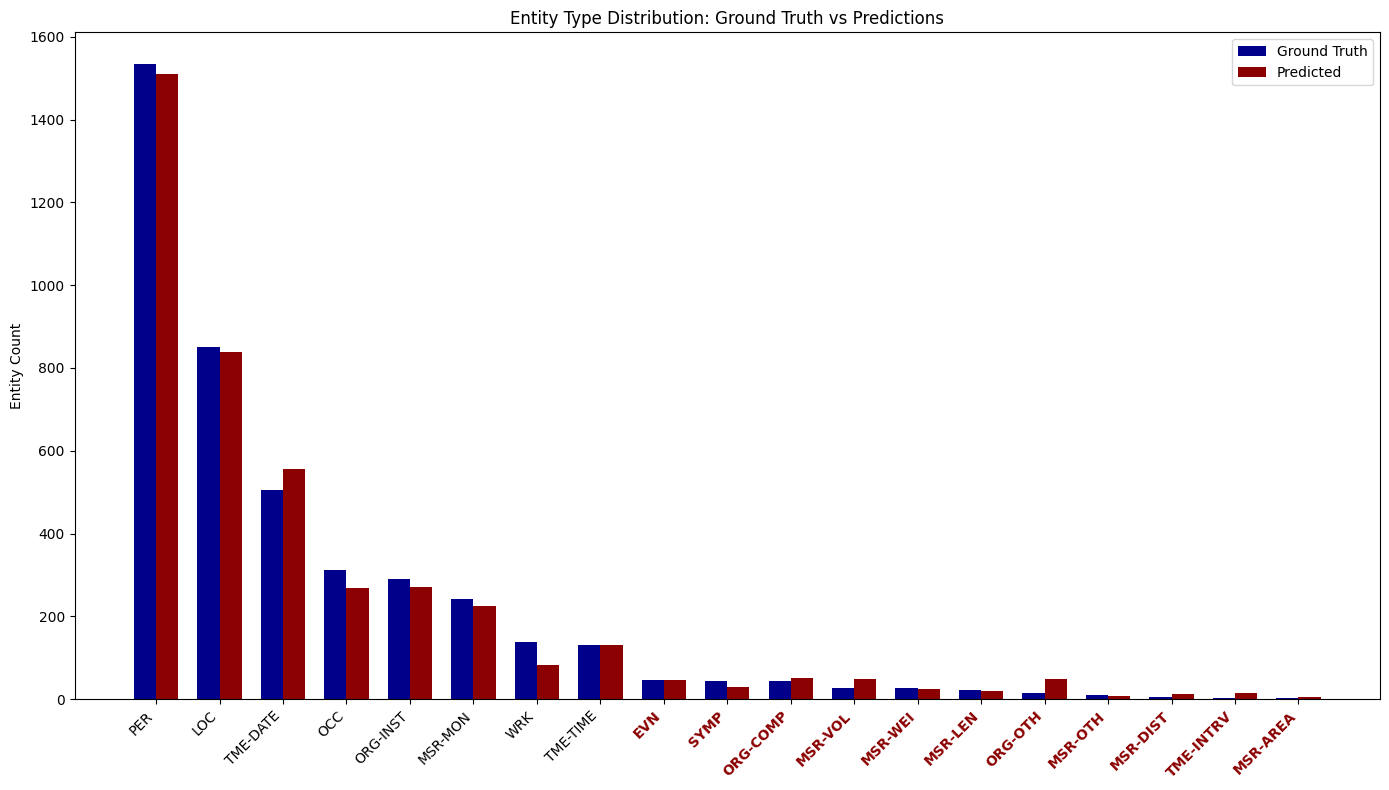

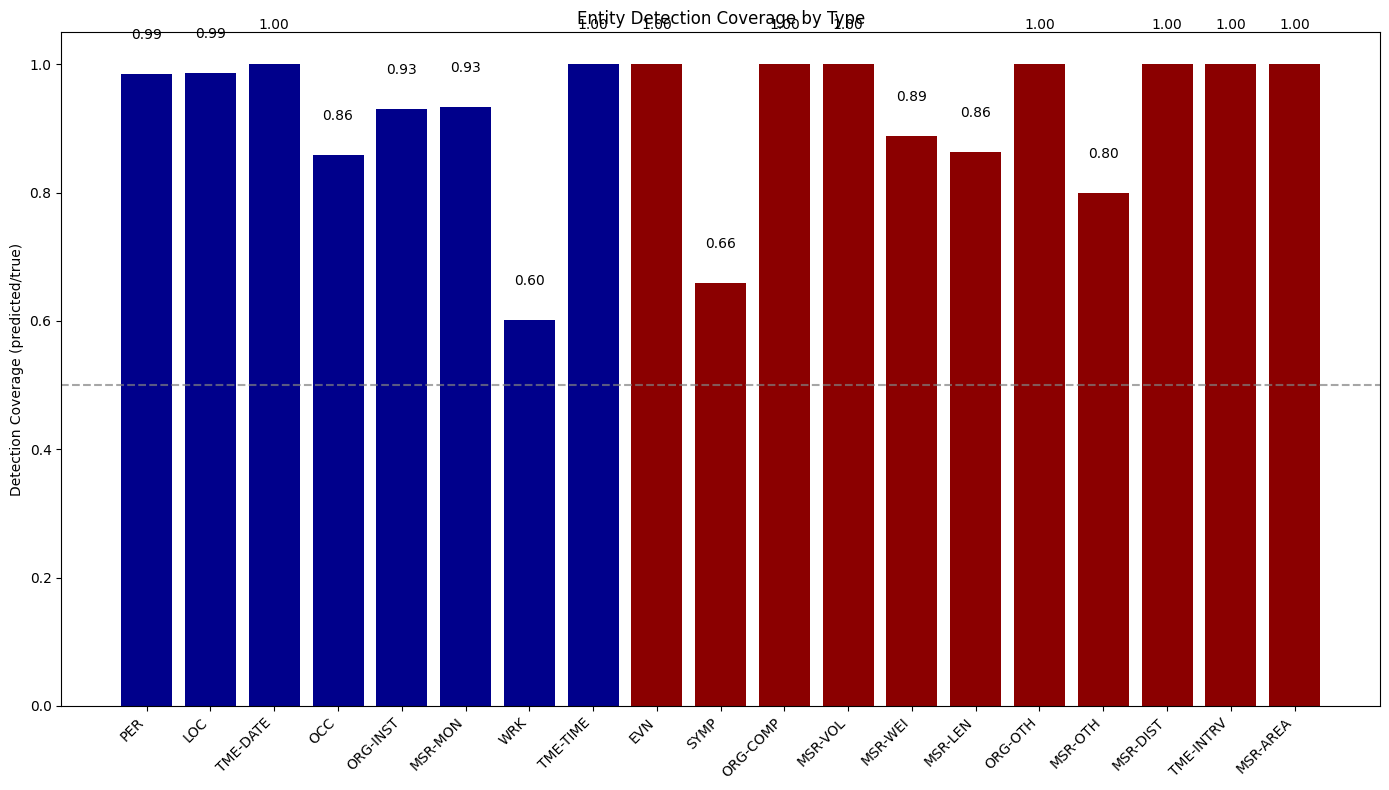

In [ ]:
def analyze_existing_predictions(prediction_results, test_dataset):
    """
    Analyze predictions made by the model

    Args:
        prediction_results: Output from predict_entities function
        test_dataset: Test dataset containing ground truth entities

    Returns:
        DataFrame with analysis of entity type distribution and confidence
    """

    # Create mapping from document ID to predictions
    pred_by_id = {result['id']: result['entities'] for result in prediction_results}

    # Create mapping from document ID to ground truth entities (from test dataset)
    true_entities_by_id = {}

    for _, row in test_dataset.iterrows():
        doc_id = row['id']
        if 'entities' in row and doc_id not in true_entities_by_id:
            true_entities_by_id[doc_id] = row['entities']

    # Count entity types in predictions and ground truth
    pred_counts = {}
    true_counts = {}
    confidence_by_type = {}

    # Analyze predictions
    for doc_id, entities in pred_by_id.items():
        for entity in entities:
            entity_type = entity['label']
            confidence = entity.get('confidence', 0)

            # Count predicted entities
            if entity_type not in pred_counts:
                pred_counts[entity_type] = 0
                confidence_by_type[entity_type] = []

            pred_counts[entity_type] += 1
            confidence_by_type[entity_type].append(confidence)

    # Count ground truth entities
    for doc_id, entities in true_entities_by_id.items():
        for entity in entities:
            entity_type = entity['label']

            if entity_type not in true_counts:
                true_counts[entity_type] = 0

            true_counts[entity_type] += 1

    # Compile results
    results = []
    all_types = set(list(true_counts.keys()) + list(pred_counts.keys()))

    for entity_type in sorted(all_types):
        true_count = true_counts.get(entity_type, 0)
        pred_count = pred_counts.get(entity_type, 0)

        # Calculate confidence stats if we have predictions
        if pred_count > 0:
            confidences = confidence_by_type[entity_type]
            avg_conf = sum(confidences) / len(confidences)
            min_conf = min(confidences)
            max_conf = max(confidences)
        else:
            avg_conf = 0
            min_conf = 0
            max_conf = 0

        # Calculate coverage
        coverage = pred_count / true_count if true_count > 0 else 0

        results.append({
            'entity_type': entity_type,
            'true_count': true_count,
            'predicted_count': pred_count,
            'coverage': coverage,
            'avg_confidence': avg_conf,
            'min_confidence': min_conf,
            'max_confidence': max_conf
        })

    # Convert to DataFrame
    return pd.DataFrame(results)

# Define rare entity types
rare_entities = ['EVN', 'ORG-COMP', 'MSR-VOL', 'SYMP', 'ORG-OTH',
                'MSR-WEI', 'MSR-LEN', 'MSR-OTH', 'MSR-DIST', 'TME-INTRV', 'MSR-AREA']

# Run analysis
analysis_df = analyze_existing_predictions(test_prediction_results, test_df)

# Add is_rare column
analysis_df['is_rare'] = analysis_df['entity_type'].apply(lambda x: x in rare_entities)

# Sort by true count
analysis_df = analysis_df.sort_values('true_count', ascending=False)

# Display results
print("=== Entity Prediction Analysis ===")
pd.set_option('display.max_rows', None)  # Show all rows
print(analysis_df[['entity_type', 'is_rare', 'true_count', 'predicted_count', 'coverage', 'avg_confidence']])

# Visualize true vs predicted counts

plt.figure(figsize=(14, 8))

# Prepare data for plotting
entity_types = analysis_df['entity_type'].tolist()
true_counts = analysis_df['true_count'].tolist()
pred_counts = analysis_df['predicted_count'].tolist()
is_rare = analysis_df['is_rare'].tolist()

# Set up bar positions
x = np.arange(len(entity_types))
width = 0.35

# Create bars
fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(x - width/2, true_counts, width, label='Ground Truth', color='darkblue')
ax.bar(x + width/2, pred_counts, width, label='Predicted', color='darkred')

# Customize plot
ax.set_ylabel('Entity Count')
ax.set_title('Entity Type Distribution: Ground Truth vs Predictions')
ax.set_xticks(x)
ax.set_xticklabels(entity_types, rotation=45, ha='right')
ax.legend()

# Highlight rare entities
for i, rare in enumerate(is_rare):
    if rare:
        plt.gca().get_xticklabels()[i].set_color('darkred')
        plt.gca().get_xticklabels()[i].set_fontweight('bold')

plt.tight_layout()
plt.show()

# Plot detection coverage (predicted/true) for each entity type
plt.figure(figsize=(14, 8))
coverage = [min(c, 1.0) for c in analysis_df['coverage']]  # Cap at 1.0 for visualization
colors = ['darkred' if r else 'darkblue' for r in analysis_df['is_rare']]

plt.bar(analysis_df['entity_type'], coverage, color=colors)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
plt.ylabel('Detection Coverage (predicted/true)')
plt.title('Entity Detection Coverage by Type')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)

for i, v in enumerate(coverage):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center', va='bottom',
             color='black', fontweight='bold' if v < 0.1 else 'normal')

plt.tight_layout()
plt.show()

In [ ]:
print(prediction_results)

[{'id': 72774, 'entities': [{'label': 'TME-DATE', 'start': 0, 'end': 14, 'word_indices': [0, 1, 2], 'confidence': np.float32(0.7526673)}, {'label': 'TME-DATE', 'start': 15, 'end': 25, 'word_indices': [3], 'confidence': np.float32(0.5988816)}, {'label': 'LOC', 'start': 62, 'end': 73, 'word_indices': [11], 'confidence': np.float32(0.89703506)}, {'label': 'OCC', 'start': 213, 'end': 222, 'word_indices': [40], 'confidence': np.float32(0.99803555)}, {'label': 'OCC', 'start': 251, 'end': 257, 'word_indices': [48], 'confidence': np.float32(0.9986272)}, {'label': 'OCC', 'start': 314, 'end': 322, 'word_indices': [60], 'confidence': np.float32(0.99848795)}, {'label': 'PER', 'start': 732, 'end': 745, 'word_indices': [144, 145, 146], 'confidence': np.float32(0.8988279)}, {'label': 'PER', 'start': 1041, 'end': 1060, 'word_indices': [209, 210], 'confidence': np.float32(0.8964467)}, {'label': 'OCC', 'start': 1128, 'end': 1138, 'word_indices': [56], 'confidence': np.float32(0.9823489)}, {'label': 'OCC

Entity counts in original training data:
   entity_type  train_count  train_pct
13         PER         7550  38.340443
1          LOC         3464  17.590900
15    TME-DATE         2220  11.273614
9          OCC         1753   8.902092
5      MSR-MON         1216   6.175096
11    ORG-INST         1015   5.154377
17    TME-TIME          821   4.169206
18         WRK          624   3.168800
0          EVN          235   1.193378
10    ORG-COMP          203   1.030875
7      MSR-VOL          141   0.716027
12     ORG-OTH          128   0.650010
14        SYMP          108   0.548446
8      MSR-WEI           65   0.330083
4      MSR-LEN           42   0.213285
6      MSR-OTH           38   0.192972
3     MSR-DIST           24   0.121877
16   TME-INTRV           23   0.116799
2     MSR-AREA           22   0.111720

Entity counts in predictions:
   entity_type  pred_count   pred_pct
13         PER        2250  35.366237
1          LOC        1288  20.245206
15    TME-DATE         902  14.177

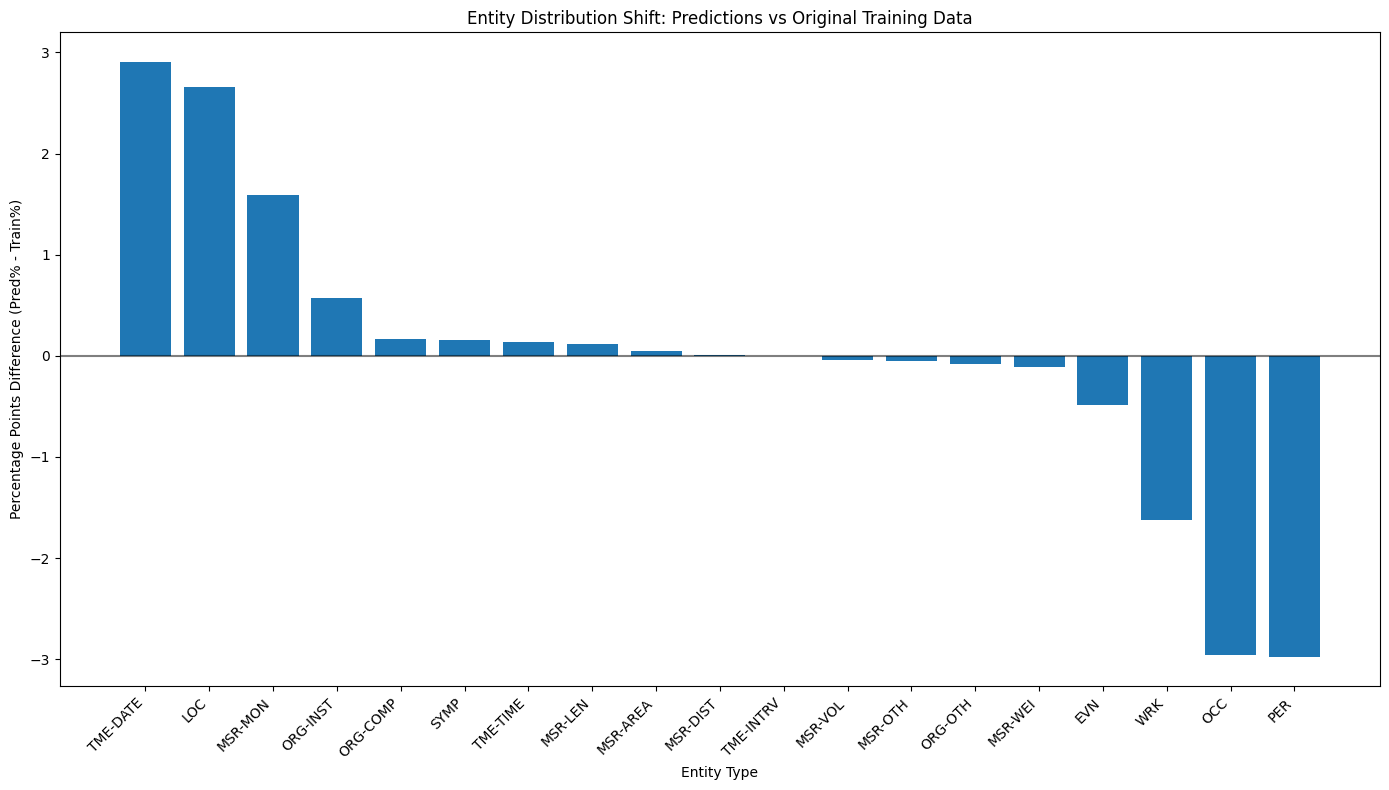

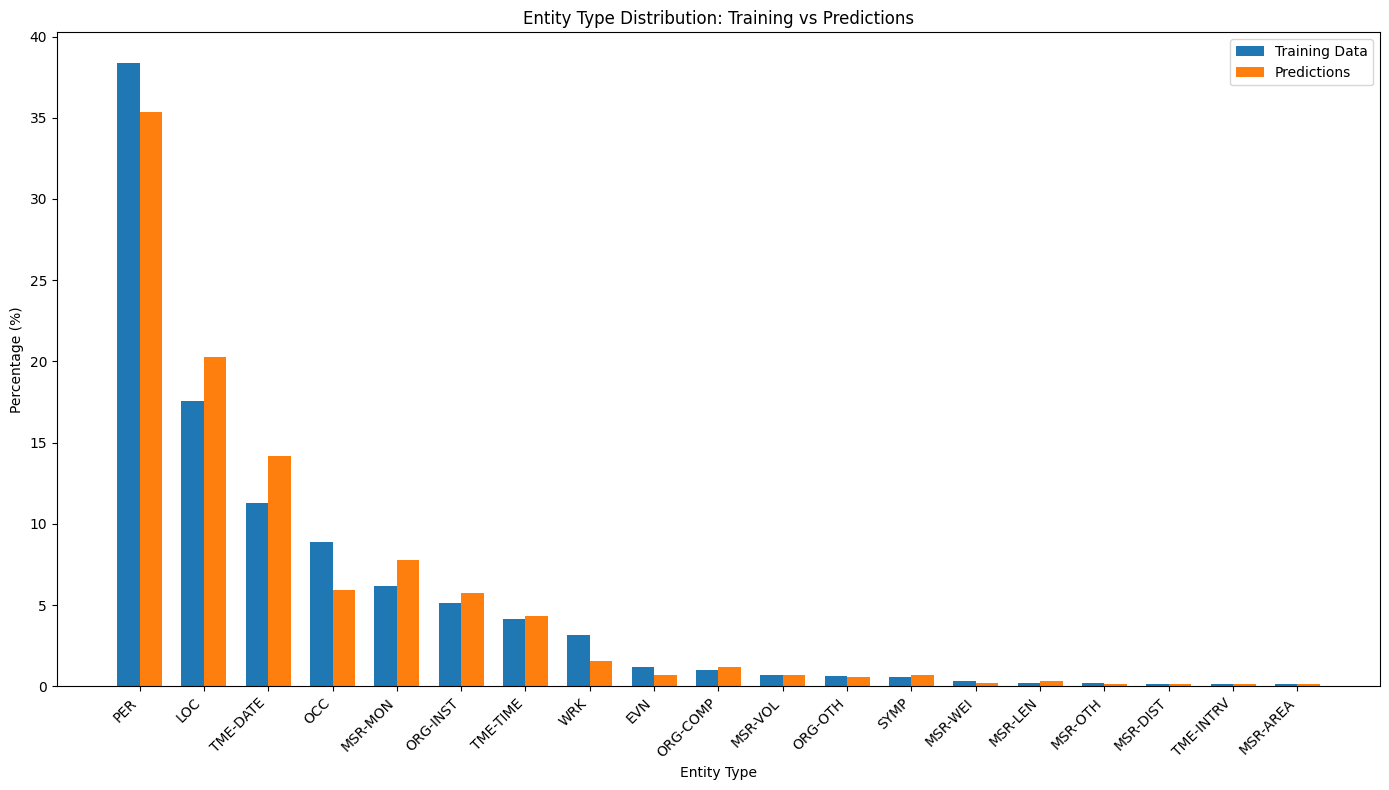

In [ ]:
def analyze_entity_distributions(prediction_results, train_df):
    """
    Compare entity distributions between predictions and original training data.

    Args:
        prediction_results: List of prediction dictionaries from predict_entities
        train_df: Original training DataFrame with entities column

    Returns:
        DataFrame with distribution analysis
    """

    # Count entity types in predictions
    pred_counts = Counter()
    for result in prediction_results:
        # Access the entities key within each result
        entities = result['entities']
        for entity in entities:
            pred_counts[entity['label']] += 1

    # Count entity types in original training data
    train_counts = Counter()
    for _, row in train_df.iterrows():
        for entity in row['entities']:
            if isinstance(entity, dict) and 'label' in entity:
                train_counts[entity['label']] += 1

    # Calculate totals for percentages
    pred_total = sum(pred_counts.values())
    train_total = sum(train_counts.values())

    # Get all unique entity types
    all_types = sorted(set(list(pred_counts.keys()) + list(train_counts.keys())))

    # Create comprehensive DataFrame
    df = pd.DataFrame({
        'entity_type': all_types,
        'train_count': [train_counts.get(t, 0) for t in all_types],
        'pred_count': [pred_counts.get(t, 0) for t in all_types],
        'train_pct': [train_counts.get(t, 0)/train_total*100 for t in all_types],
        'pred_pct': [pred_counts.get(t, 0)/pred_total*100 for t in all_types]
    })

    # Calculate percentage point difference
    df['diff_pct'] = df['pred_pct'] - df['train_pct']

    return df

# Run the analysis
distribution_df = analyze_entity_distributions(prediction_results, train_df)

# Display results sorted by training count (most common to least common)
print("Entity counts in original training data:")
print(distribution_df.sort_values('train_count', ascending=False)[['entity_type', 'train_count', 'train_pct']])

# Display results sorted by prediction count
print("\nEntity counts in predictions:")
print(distribution_df.sort_values('pred_count', ascending=False)[['entity_type', 'pred_count', 'pred_pct']])

# Display the differences (most overrepresented to most underrepresented)
print("\nDistribution difference (percentage points):")
print(distribution_df.sort_values('diff_pct', ascending=False)[['entity_type', 'diff_pct']])

# Visualize the distribution difference
plt.figure(figsize=(14, 8))
diff_df = distribution_df.sort_values('diff_pct', ascending=False)
plt.bar(diff_df['entity_type'], diff_df['diff_pct'])
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Entity Type')
plt.ylabel('Percentage Points Difference (Pred% - Train%)')
plt.title('Entity Distribution Shift: Predictions vs Original Training Data')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create side-by-side bar chart
plt.figure(figsize=(14, 8))
comparison_df = distribution_df.sort_values('train_count', ascending=False)
entity_types = comparison_df['entity_type']
x = range(len(entity_types))
width = 0.35

plt.bar([i - width/2 for i in x], comparison_df['train_pct'], width, label='Training Data')
plt.bar([i + width/2 for i in x], comparison_df['pred_pct'], width, label='Predictions')

plt.xlabel('Entity Type')
plt.ylabel('Percentage (%)')
plt.title('Entity Type Distribution: Training vs Predictions')
plt.xticks(x, entity_types, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## Submission Formatting

In [ ]:
# Process the entities to remove unwanted fields
processed_results = []
for result in prediction_results:
    # Create a new entities list with only the desired fields
    cleaned_entities = [
        {
            'label': entity['label'],
            'start': entity['start'],
            'end': entity['end']
        }
        for entity in result['entities']
    ]
    processed_results.append({
        'id': result['id'],
        'entities': cleaned_entities
    })

# Format for submission
submission_df = pd.DataFrame([
    {'id': result['id'], 'entities': str(result['entities'])}
    for result in processed_results
])

# Create a new 'predictions' folder in Google Drive root if it doesn't exist
predictions_dir = "/content/drive/MyDrive/predictions"
os.makedirs(predictions_dir, exist_ok=True)

# Use timestamp to create unique filename
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"submission_{timestamp}.csv"

# Save to CSV with timestamped filename
submission_path = os.path.join(predictions_dir, filename)
submission_df.to_csv(submission_path, index=False)

print(f"Predictions completed. Found {sum(len(r['entities']) for r in processed_results)} entities across {len(processed_results)} documents.")
print(f"Predictions saved to: {submission_path}")
print("Sample predictions:")
print(submission_df.head())

Predictions completed. Found 6362 entities across 170 documents.
Predictions saved to: /content/drive/MyDrive/predictions/submission_20250408_165841.csv
Sample predictions:
      id                                           entities
0  72774  [{'label': 'TME-DATE', 'start': 0, 'end': 14},...
1  38204  [{'label': 'PER', 'start': 24, 'end': 36}, {'l...
2  24317  [{'label': 'OCC', 'start': 24, 'end': 37}, {'l...
3  72632  [{'label': 'PER', 'start': 11, 'end': 27}, {'l...
4  24485  [{'label': 'LOC', 'start': 0, 'end': 9}, {'lab...
